# Notebook Start

In [28]:
%matplotlib inline
import numpy as np
#import numpy.ma as ma
import matplotlib.pyplot as plt
#import matplotlib as mpl
#import matplotlib.colors as colors
import datetime #
import sys
import glob
import os
import h5py
import hdf5plugin
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
#from RAMS_Post_Process import fx_postproc_RAMS as RAMS_fx
import cartopy.crs as crs
import seaborn as sns
import matplotlib
import re
from pathlib import Path

matplotlib.rcParams["font.family"] = "Roboto"
matplotlib.rcParams["font.sans-serif"] = ["Roboto"]  # For non-unicode text
#matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['axes.titlesize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['legend.fontsize'] = 16
matplotlib.rcParams['legend.facecolor'] = 'w'
#matplotlib.rcParams['hatch.linewidth'] = 0.25

In [ ]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import ticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
from wrf import (
    CoordPair,
    GeoBounds,
    cartopy_xlim,
    cartopy_ylim,
    get_cartopy,
    getvar,
    interplevel,
    interpline,
    latlon_coords,
    ll_to_xy,
    smooth2d,
    to_np,
    vertcross,
    xy_to_ll,
    ll_to_xy_proj,
    cape_2d
)

In [ ]:
def radar_colormap():
    nws_reflectivity_colors = [
    "#646464", # ND
    "#ccffff", # -30
    "#cc99cc", # -25
    "#996699", # -20
    "#663366", # -15
    "#cccc99", # -10
    "#999966", # -5
    "#646464", # 0
    "#04e9e7", # 5
    "#019ff4", # 10
    "#0300f4", # 15
    "#02fd02", # 20
    "#01c501", # 25
    "#008e00", # 30
    "#fdf802", # 35
    "#e5bc00", # 40
    "#fd9500", # 45
    "#fd0000", # 50
    "#d40000", # 55
    "#bc0000", # 60
    "#f800fd", # 65
    "#9854c6", # 70
    "#fdfdfd" # 75
    ]

    return mpl.colors.ListedColormap(nws_reflectivity_colors)


cma1=plt.get_cmap('bwr')
cma2=radar_colormap()
cma3=plt.get_cmap('tab20c')
import nclcmaps as ncm
cma4=ncm.cmap("WhiteBlueGreenYellowRed")
cma5=plt.get_cmap('gray_r')
cma6=plt.get_cmap('rainbow')
cma7=plt.get_cmap('Oranges')
cma8=plt.get_cmap('coolwarm')
#cma9=cma4.reversed()
cma10=plt.get_cmap('gist_yarg')

# Useful functions

In [ ]:
def fig_process_vert(AX, TER, CONTOUR, XY1, XY2, Y_CROSS, CBAR_EXP, TITLESTRING, TIMESTRING, FILENAMESTRING, PROD, UNITS, VERT_CROSS, HEIGHT, YLABEL, IS_PANEL_PLOT):
    #F = plt.gcf()  # Gets the current figure
    #ax = plt.gca()  # Gets the current axes

    if IS_PANEL_PLOT == False:
        AX.set_title('%s (%s) \n %s' % (TITLESTRING, UNITS, TIMESTRING),
                  fontsize=16, stretch='normal')

    if VERT_CROSS == "zonal":
        AX.fill_between(xh[XY1:XY2], 0, TER[int(Y_CROSS),
                        XY1:XY2]/1000.0, facecolor='wheat')
        AX.set_xlabel('x-distance (m)', fontsize=16)

    else:
        AX.fill_between(yh[XY1:XY2], 0, TER[XY1:XY2,
                        int(Y_CROSS)]/1000.0, facecolor='wheat')
        AX.set_xlabel('y-distance (m)', fontsize=16)

    AX.patch.set_color("white")

    if YLABEL:
        AX.set_ylabel('Height (km)', fontsize=18)
    AX.set_ylim([0, HEIGHT])
    AX.set_xlim([XY1*100.0, XY2*100.0])

    class OOMFormatter(matplotlib.ticker.ScalarFormatter):
        def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
            self.oom = order
            self.fformat = fformat
            matplotlib.ticker.ScalarFormatter.__init__(
                self, useOffset=offset, useMathText=mathText)

        def _set_orderOfMagnitude(self, nothing):
            self.orderOfMagnitude = self.oom

        def _set_format(self, vmin, vmax):
            self.format = self.fformat
            if self._useMathText:
                self.format = '$%s$' % matplotlib.ticker._mathdefault(
                    self.format)

    if IS_PANEL_PLOT == False:
        if abs(CBAR_EXP):
            divider = make_axes_locatable(AX)
            cax = divider.append_axes("bottom", size="2%", pad=0.6)
            bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal",
                               format=OOMFormatter(CBAR_EXP, mathText=False),extend='both')
            bar.ax.tick_params(labelsize=15)
            #file_id = '%s_%s' % (PROD, FILENAMESTRING)
            #filename = '%s.png' % (file_id)
            #print(filename)
            # Saves the figure with small margins
            #plt.savefig(filename, dpi=my_dpi, bbox_inches='tight')
        else:
            divider = make_axes_locatable(AX)
            cax = divider.append_axes("bottom", size="2%", pad=0.66)
            bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal",extend='both')
            bar.ax.tick_params(labelsize=15)
            #file_id = '%s_%s' % (PROD, FILENAMESTRING)
            #filename = '%s.png' % (file_id)
            #print(filename)
            # Saves the figure with small margins
            #plt.savefig(filename, dpi=my_dpi, bbox_inches='tight')

    else:
        if abs(CBAR_EXP):
            divider = make_axes_locatable(AX)
            cax = divider.append_axes("bottom", size="2%", pad=0.4)
            bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal",
                               format=OOMFormatter(CBAR_EXP, mathText=False),extend='both')
            bar.ax.tick_params(labelsize=15)
        else:
            divider = make_axes_locatable(AX)
            cax = divider.append_axes("bottom", size="2%", pad=0.4)
            bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal",extend='both')
            bar.ax.tick_params(labelsize=15)
    # plt.close() This should remain commented. plt should be closed in the panel plot function
    # if export_flag == 1:
    # Convert the figure to a gif file
    #os.system('convert -render -flatten %s %s.gif' % (filename, file_id))
    #os.system('rm -f %s' % filename)
    
def get_time_from_RAMS_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][4:21] # Grab time string from RAMS file
    pd_time = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S')

def read_head(headfile,h5file):
        # Function that reads header files from RAMS

        # Inputs:
        #   headfile: header file including full path in str format
        #   h5file: h5 datafile including full path in str format

        # Returns:
        #   zmn: height levels for momentum values (i.e., grid box upper and lower levels)
        #   ztn: height levels for thermodynaic values (i.e., grid box centers)
        #   nx:: the number of x points for the domain associated with the h5file
        #   ny: the number of y points for the domain associated with the h5file
        #   npa: the number of surface patches


        dom_num = h5file[h5file.index('.h5')-1] # Find index of .h5 to determine position showing which nest domain to use

        with open(headfile) as f:
            contents = f.readlines()

        idx_zmn = contents.index('__zmn0'+dom_num+'\n')
        nz_m = int(contents[idx_zmn+1])
        zmn = np.zeros(nz_m)
        for i in np.arange(0,nz_m):
            zmn[i] =  float(contents[idx_zmn+2+i])

        idx_ztn = contents.index('__ztn0'+dom_num+'\n')
        nz_t = int(contents[idx_ztn+1])
        ztn = np.zeros(nz_t)
        for i in np.arange(0,nz_t):
            ztn[i] =  float(contents[idx_ztn+2+i])

        ztop = np.max(ztn) # Model domain top (m)

        # Grad the size of the horizontal grid spacing
        idx_dxy = contents.index('__deltaxn\n')
        dxy = float(contents[idx_dxy+1+int(dom_num)].strip())

        idx_npatch = contents.index('__npatch\n')
        npa = int(contents[idx_npatch+2])

        idx_ny = contents.index('__nnyp\n')
        idx_nx = contents.index('__nnxp\n')
        ny = np.ones(int(contents[idx_ny+1]))
        nx = np.ones(int(contents[idx_ny+1]))
        for i in np.arange(0,len(ny)):
            nx[i] = int(contents[idx_nx+2+i])
            ny[i] = int(contents[idx_ny+2+i])

        ny_out = ny[int(dom_num)-1]
        nx_out = nx[int(dom_num)-1]

        return zmn, ztn, nx_out, ny_out, dxy, npa 

## Arrange figure files (png) into a panel plot

In [ ]:
from PIL import Image
import os
import math
import glob

def arrange_images_with_wildcard(input_folder, output_file, wildcard_pattern, non_target_string):
    # Get a list of PNG images in the input folder matching the wildcard pattern
    if non_target_string:
        image_files = sorted([f for f in glob.glob(os.path.join(input_folder, wildcard_pattern)) if f.lower().endswith('.png') and non_target_string not in f])[1::2]
    else:
        image_files = sorted([f for f in glob.glob(os.path.join(input_folder, wildcard_pattern)) if f.lower().endswith('.png')])[1::2]

    print('found ',len(image_files),' images')
    for fil in image_files:
        print(fil)
    # Check if there are any matching images
    if not image_files:
        print(f"Error: No PNG images matching the wildcard pattern '{wildcard_pattern}' found in the folder.")
        return

    # Calculate the number of rows and columns for the matrix
    num_images = len(image_files)
    num_cols = int(math.sqrt(num_images))
    num_rows = math.ceil(num_images / num_cols)

    # Create a new image with dimensions for the matrix and reduced white space
    img_width, img_height = Image.open(image_files[0]).size
    margin = 60  # Adjust this value to control the margin
    result_image = Image.new('RGB', (num_cols * (img_width - margin), num_rows * (img_height - margin)))

    # Loop through the matching images and paste them onto the result image with reduced white space
    for i in range(num_images):
        img = Image.open(image_files[i])

        # Calculate the position with margin to paste the image
        col = i % num_cols
        row = i // num_cols
        position = (col * (img_width - margin), row * (img_height - margin))

        # Paste the image onto the result image
        result_image.paste(img, position)

    # Save the result image
    result_image.save(output_file)

# Example usage
input_folder = "./"
output_file = "WSPD_lev0.png"
wildcard_pattern = "plan_view_RAMS_*_WSPD_levtype_pressure_lev_750_d03_time_*.png"  # Replace with your specific wildcard pattern
non_target_string = 'ARG1.1'
arrange_images_with_wildcard(input_folder, output_file, wildcard_pattern,non_target_string)

In [ ]:
filepath = '/monsoon/MODEL/LES_MODEL_DATA/V0/ARG1.2-WM-V0/G1/wrfout_d01_2018-12-13_20:30:00'
da = xr.open_dataset(filepath)
da['QICE'][0,80,:,:].plot()

## Make panel plots to check WRF output

In [ ]:
import matplotlib.pyplot as plt
import read_vars_WRF_RAMS

domain = '1'
# Extract QCLOUD variable
variables = ['QC']
levels=[800,500,250]
simulation_name = 'ARG1.2-WM-V0'
filepath = '/monsoon/MODEL/LES_MODEL_DATA/V0/'+simulation_name+'/G1/wrfout_d01_2018-12-13_20:30:00'
da = Dataset(filepath)
for variable in variables:
    # Create a 2x2 subplot grid
    fig, axes = plt.subplots(1, 3, figsize=(10,10))

    # Plot QCLOUD variable in each subplot
    for i, ax in enumerate(axes.flat):
        z, z_name, z_units, z_time = read_vars_WRF_RAMS.read_variable(filepath,variable,'WRF',output_height=False,interpolate=True,level=levels[i],interptype='pressure')
        #print(z)
        #print(np.nanmax(z))
        y_dim,x_dim = np.shape(z)
        if domain=='1':
            dx=1.6
        if domain=='2':
            dx=0.4
        if domain=='3':
            dx=0.1
        #xx = np.arange(0,dx*x_dim,dx)
        #yy = np.arange(0,dx*y_dim,dx)
        #print('shape of xx is ',np.shape(xx))
        #print('shape of yy is ',np.shape(yy))
        #print('shape of z is ',np.shape(z))
        timestep_str     = pd.to_datetime(z_time,format='%Y%m%d%H%M%S').strftime('%Y-%m-%d %H:%M:%S')
        #vert = getvar(da, "pres").values
        #print(vert)
        #output_var = interpz3d(output_var, vert, level)
        #output_var = getvar(da,'QCLOUD')
        #print(output_var)
        #z = interplevel(output_var, vert, level, meta=False)
        ax.set_title(simulation_name+'\n'+variable+' at pres level '+str(levels[i])+' hPa\n'+timestep_str)
        cont = ax.contourf(z,levels=20,cmap=plt.get_cmap('viridis'),extend='both')#,ax=ax) 
        ax.set_aspect('equal', 'box')

        # Add a common colorbar
        #plt.colorbar(cont,label='QC')
    #plt.suptitle(variable+' for '+simulation_name+'\n'+timestep_pd.strftime('%Y-%m-%d %H:%M:%S'))
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import datetime #
import sys
import glob
import os
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
#from RAMS_Post_Process import fx_postproc_RAMS as RAMS_fx
import matplotlib.pyplot as plt
import read_vars_WRF_RAMS

domain = 'd01'
# Extract QCLOUD variable
variables = ['TT','RH']
levels=[0,10,20]

simulation_name = 'ARG1.1-WM-V1'
directory_met_em="/nobackupp11/isingh2/WPS/run_"+simulation_name[0:6]+"_PROD/"
print('searching directory" ',directory_met_em)
fi_list_met_em  = []

file_finding_string_met_em = "met_em."+domain+".*.nc"
fi_list_met_em=sorted(glob.glob(directory_met_em+file_finding_string_met_em))
print('number of met_em files found: ',len(fi_list_met_em))
#print('WRF files: ',fi_list_met_em)
#filepath = fi_list_met_em[int(len(fi_list_met_em)/2)]#'/monsoon/MODEL/LES_MODEL_DATA/V0/'+simulation_name+'/G1/wrfout_d01_2018-12-13_20:30:00'
#print('choosing the middle file: ',filepath)
for fil in fi_list_met_em[::10]:
    da = xr.open_dataset(fil)
    for variable in variables:
        # Create a 2x2 subplot grid
        fig, axes = plt.subplots(1, 3, figsize=(10,10))
        z = da.variables[variable]
        # Plot QCLOUD variable in each subplot
        for i, ax in enumerate(axes.flat):
            y_dim,x_dim = np.shape(z)
            if domain=='1':
                dx=1.6
            if domain=='2':
                dx=0.4
            if domain=='3':
                dx=0.1
            timestep_str = da.Times.values[0].decode()
            ax.set_title(simulation_name+'\n'+variable+' at level '+str(levels[i])+'\n'+timestep_str)
            cont = ax.contourf(z,levels=20,cmap=plt.get_cmap('viridis'),extend='both')#,ax=ax) 
            ax.set_aspect('equal', 'box')
            # Add a common colorbar
            #plt.colorbar(cont,label='QC')
    print('---------\n')
    #plt.suptitle(variable+' for '+simulation_name+'\n'+timestep_pd.strftime('%Y-%m-%d %H:%M:%S'))
    # Adjust layout and display the plot
    plt.tight_layout()
    #plt.show()
    png_filename = '/nobackupp11/isingh2/LES_simulations_plots/quick_look_ITC/'+'met_em_'+simulation_name+'_'+domain+'_'+variable+'_'+pd.to_datetime(timestep_str,format='%Y-%m-%d_%H:%M:%S').strftime('%Y%m%d%H%M%S')+'.png'
    print('saving image to : ',png_filename)
    plt.savefig(png_filename,dpi=150)                                                                                                                                                                                        104,18        Bot

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
#image_path = "result_image.png"  # Replace with the path to your image file
img = mpimg.imread(output_file)
print("Shape of the resulting image:", np.shape(img))
#print

# Display the image
plt.imshow(img)
plt.axis('off')  # Optional: Turn off axis labels
plt.show()

## Make plan views of variables RAMS and WRF

In [ ]:
#%%writefile make_plan_views_RAMS.py
# make plan views of variables:
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import os
from multiprocessing import Pool, cpu_count
import time
import h5py
import hdf5plugin
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import cartopy.crs as crs
import random
import skgstat as skg
plt.style.use('ggplot')
from pprint import pprint
import seaborn as sns
import matplotlib.ticker as ticker
import read_vars_WRF_RAMS


def get_time_from_RAMS_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][4:21] # Grab time string from RAMS file
    pd_time = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S')
   
def read_head(headfile,h5file):
        # Function that reads header files from RAMS

        # Inputs:
        #   headfile: header file including full path in str format
        #   h5file: h5 datafile including full path in str format

        # Returns:
        #   zmn: height levels for momentum values (i.e., grid box upper and lower levels)
        #   ztn: height levels for thermodynaic values (i.e., grid box centers)
        #   nx:: the number of x points for the domain associated with the h5file
        #   ny: the number of y points for the domain associated with the h5file
        #   npa: the number of surface patches


        dom_num = h5file[h5file.index('.h5')-1] # Find index of .h5 to determine position showing which nest domain to use

        with open(headfile) as f:
            contents = f.readlines()

        idx_zmn = contents.index('__zmn0'+dom_num+'\n')
        nz_m = int(contents[idx_zmn+1])
        zmn = np.zeros(nz_m)
        for i in np.arange(0,nz_m):
            zmn[i] =  float(contents[idx_zmn+2+i])

        idx_ztn = contents.index('__ztn0'+dom_num+'\n')
        nz_t = int(contents[idx_ztn+1])
        ztn = np.zeros(nz_t)
        for i in np.arange(0,nz_t):
            ztn[i] =  float(contents[idx_ztn+2+i])

        ztop = np.max(ztn) # Model domain top (m)

        # Grad the size of the horizontal grid spacing
        idx_dxy = contents.index('__deltaxn\n')
        dxy = float(contents[idx_dxy+1+int(dom_num)].strip())

        idx_npatch = contents.index('__npatch\n')
        npa = int(contents[idx_npatch+2])

        idx_ny = contents.index('__nnyp\n')
        idx_nx = contents.index('__nnxp\n')
        ny = np.ones(int(contents[idx_ny+1]))
        nx = np.ones(int(contents[idx_ny+1]))
        for i in np.arange(0,len(ny)):
            nx[i] = int(contents[idx_nx+2+i])
            ny[i] = int(contents[idx_ny+2+i])

        ny_out = ny[int(dom_num)-1]
        nx_out = nx[int(dom_num)-1]

        return zmn, ztn, nx_out, ny_out, dxy, npa 

simulations=['USA1.1-R']#PHI1.1-R','PHI2.1-R','WPO1.1-R','BRA1.1-R','DRC1.1-R','AUS1.1-R']
domain='3'
variables = [['THETA', 0, 'model', '$Theta_{sfc}^{2} (K^{2})$'],['QV', 0, 'model', '$Qvapor_{sfc}^{2} (kg^{2}kg^{-2})$']]
# variables = [['Tk', 0, 'model', '$T_{sfc}^{2} (K^{2})$']             , ['THETA', 0, 'model', '$Theta_{sfc}^{2} (K^{2})$'],\
#              ['QV', 0, 'model', '$Qvapor_{sfc}^{2} (kg^{2}kg^{-2})$'], ['RH', 0, 'model', '$RH_{sfc}^{2} (percent^{2})$'],\
#              ['U', 0, 'model', '$U_{sfc}^{2} (m^{2}s^{-2})$']        , ['V', 0, 'model', '$V_{sfc}^{2} (m^{2}s^{-2})$'],\
#              ['WSPD', 0, 'model', '$WSPD_{sfc}^{2} (m^{2}s^{-2})$']  , ['W', 0, 'model', '$W_{sfc}^{2} (m^{2}s^{-2})$'],\
#              ['MCAPE', -999, None, '$MCAPE^{2} (J^{2}kg^{-2})$']     , ['MCIN', -999, None, '$MCIN^{2} (J^{2}kg^{-2})$'], \
#              ['Tk', 750, 'pressure', '$T_{750}^{2} (K^{2})$']        , ['THETA', 750, 'pressure', '$Theta_{750}^{2} (K^{2})$'],\
#              ['QV', 750, 'pressure', '$Qvapor_{750}^{2} (kg^{2}kg^{-2})$'], ['RH', 750, 'pressure', '$RH_{750}^{2} (percent^{2})$'],\
#              ['U', 750, 'pressure', '$U_{750}^{2} (m^{2}s^{-2})$']   , ['V', 750, 'pressure', '$V_{750}^{2} (m^{2}s^{-2})$'],\
#              ['WSPD', 750, 'pressure', '$WSPD_{750}^{2} (m^{2}s^{-2})$'], ['W', 750, 'pressure', '$W_{750}^{2} (m^{2}s^{-2})$'],\
#              ['Tk', 500, 'pressure', '$T_{500}^{2} (K^{2})$']        , ['THETA', 500, 'pressure', '$Theta_{500}^{2} (K^{2})$'],\
#              ['QV', 500, 'pressure', '$Qvapor_{500}^{2} (kg^{2}kg^{-2})$'], ['RH', 500, 'pressure', '$RH_{500}^{2} (percent^{2})$'],\
#              ['U', 500, 'pressure', '$U_{500}^{2} (m^{2}s^{-2})$']   , ['V', 500, 'pressure', '$V_{500}^{2} (m^{2}s^{-2})$'],\
#              ['WSPD', 500, 'pressure', '$WSPD_{500}^{2} (m^{2}s^{-2})$'], ['W', 500, 'pressure', '$W_{500}^{2} (m^{2}s^{-2})$'],\
#              ['Tk', 200, 'pressure', '$T_{200}^{2} (K^{2})$']        , ['THETA', 200, 'pressure', '$Theta_{200}^{2} (K^{2})$'],\
#              ['QV', 200, 'pressure', '$Qvapor_{200}^{2} (kg^{2}kg^{-2})$'], ['RH', 200, 'pressure', '$RH_{200}^{2} (percent^{2})$'],\
#              ['U', 200, 'pressure', '$U_{200}^{2} (m^{2}s^{-2})$']   , ['V', 200, 'pressure', '$V_{200}^{2} (m^{2}s^{-2})$'], \
#              ['WSPD', 200, 'pressure', '$WSPD_{200}^{2} (m^{2}s^{-2})$'], ['W', 200, 'pressure', '$W_{200}^{2} (m^{2}s^{-2})$']]

units_dict = {'Tk':'$K$','QV':'$kg kg^{-1}$','RH':'percent','WSPD':'$m s^{-1}$','U':'$m s^{-1}$',\
              'V':'$m s^{-1}$','W':'$m s^{-1}$','MCAPE':'$J kg^{-1}$','MCIN':'$J kg^{-1}$','THETA':'$K$'}
vmin_vmax_dict = {'Tk':[290,331,1],'QV':[0.006,0.0024,0.001],'RH':[70,101,1],'WSPD':[1,20,1],'U':[1,20,1],\
              'V':[1,20,1],'W':[-5,21,1],'MCAPE':[100,3100,100],'MCIN':[0,310,10],'THETA':[290,331,1]}

colors    =  ['#000000','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7']

def make_plan_view(WHICH_TIME, VARIABLE, SIMULATIONS, DOMAIN):

    print('working on ',VARIABLE,'\n')
    
    for ii,simulation in enumerate(SIMULATIONS): 
        fig    = plt.figure(figsize=(8,8))
        print('    working on simulation: ',simulation)
        if DOMAIN=='1' or DOMAIN =='2':
            rams_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/'+simulation+'/G'+DOMAIN+'/out/'+'a-A-*g'+DOMAIN+'.h5'))# CSU machine
        if DOMAIN=='3':
            rams_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/'+simulation+'/G'+DOMAIN+'/out_30s/'+'a-L-*g3.h5'))# CSU machine
        print('        total # files = ',len(rams_files))
        print('        first file is ',rams_files[0])
        print('        last file is ',rams_files[-1])
        if WHICH_TIME=='start':
            rams_fil    = rams_files[0]
        if WHICH_TIME=='middle':
            rams_fil    = rams_files[int(len(rams_files)/2)]
        if WHICH_TIME=='end':
            rams_fil    = rams_files[-1]
        print('        choosing the '+WHICH_TIME+' file: ',rams_fil)
      
        z, z_name, z_units, z_time = read_vars_WRF_RAMS.read_variable(rams_fil,VARIABLE[0],'RAMS',output_height=False,interpolate=VARIABLE[1]>-1,level=VARIABLE[1],interptype=VARIABLE[2])
        y_dim,x_dim = np.shape(z)
        if DOMAIN=='1':
            dx=1.6
        if DOMAIN=='2':
            dx=0.4
        if DOMAIN=='3':
            dx=0.1
        xx = np.arange(0,dx*x_dim,dx)
        yy = np.arange(0,dx*y_dim,dx)
        print('shape of xx is ',np.shape(xx))
        print('shape of yy is ',np.shape(yy))
        print('shape of z is ',np.shape(z))
        timestep_pd     = pd.to_datetime(z_time,format='%Y%m%d%H%M%S')
        plt.contourf(xx,yy,z,levels=20,cmap=plt.get_cmap('viridis'),extend='both')

        if VARIABLE[2]:
            title_string = simulation+' '+VARIABLE[0]+' ('+units_dict[VARIABLE[0]]+')'+' at '+VARIABLE[2]+' level '+str(int(VARIABLE[1]))+' for d0'+DOMAIN+'\n'+timestep_pd.strftime('%Y-%m-%d %H:%M:%S')
        else:
            title_string = simulation+' '+VARIABLE[0]+' ('+units_dict[VARIABLE[0]]+')'+' for d0'+DOMAIN+'\n'+timestep_pd.strftime('%Y-%m-%d %H:%M:%S')
        plt.title(title_string)
        plt.xlabel('x (km)')
        plt.ylabel('y (km)')
        plt.colorbar()
        if VARIABLE[2]:
            filename = 'plan_view_RAMS_'+simulation+'_'+VARIABLE[0]+'_levtype_'+VARIABLE[2]+'_lev_'+str(int(VARIABLE[1]))+'_d0'+DOMAIN+'_time_'+z_time+'.png'
        else:
            filename = 'plan_view_RAMS_'+simulation+'_'+VARIABLE[0]+'_levtype_'+'None'+'_lev_'+'None'+'_d0'+DOMAIN+'_time_'+z_time+'.png'
        print('saving to png file: ',filename)
        plt.savefig(filename,dpi=150)
        plt.close()
        print('\n\n')
for var in variables:
    make_plan_view('middle', var, simulations, '3')

# print('working on domain' ,domain)
# #Running on the terminal in parallel
# argument = []
# for var in variables:
#     argument = argument + [('middle',var, simulations, domain)]

# print('length of argument is: ',len(argument))


# # # ############################### FIRST OF ALL ################################
# cpu_count1 = 37 #cpu_count()
# print('number of cpus: ',cpu_count1)
# # # #############################################################################

# def main(FUNCTION, ARGUMENT):
#     start_time = time.perf_counter()
#     with Pool(processes = (cpu_count1-1)) as pool:
#         data = pool.starmap(FUNCTION, ARGUMENT)
#     finish_time = time.perf_counter()
#     print(f"Program finished in {finish_time-start_time} seconds")
#     #df_all = pd.concat(data, ignore_index=True)
#     #thermo_indices_data_csv_file = csv_folder+'thermodynamic_indices_' + DOMAIN + '_comb_track_filt_01_02_50_02_sr5017_setpos.csv'
#     #print('saving thermodynamic indices to the file: ',thermo_indices_data_csv_file)
#     #df_all.to_csv(thermo_indices_data_csv_file)  # sounding data
    
# if __name__ == "__main__":
#     main(make_plan_view, argument)

## Xarray-based functions

In [ ]:
# XARRA

Cp=1004.
Rd=287.0

def plot_zonal_vertcross(FILE, X_1D, Z_3D, Z_1D, DXY, VAR1, DESTAGGER, STAGGER_DIM, LEVELS_VAR1, CMAP_VAR1,
                       VAR2, LEVELS_VAR2, VAR2_COLOR,
                       VAR3, LEVELS_VAR3, VAR3_COLOR,
                       VAR4, LEVELS_VAR4, VAR4_COLOR,
                       yy, x1, x2,
                       PLOT_WINDS, PANEL_PLOT, HEIGHT, AX, EXP_LABEL, PANEL_LABEL, PLOT_PT_X, PLOT_PT_Z):  # rcParams["contour.negative_linestyle"] = 'dashed'

    DATA=xr.open_dataset(FILE,engine='h5netcdf', phony_dims='sort')
      
    XV1, ZV1 = np.meshgrid(X_1D[x1:x2], Z_1D)
    zh=Z_3D

    var1 = DATA[VAR1]
    terr = DATA.TOPT.values

    if DESTAGGER:
        print(var1)
        var1 = destagger(var1, STAGGER_DIM, meta=True)
    else:
        print(' ')

    
    if (isinstance(LEVELS_VAR1, np.ndarray)):
        C1 = AX.contourf(XV1, zh[:, yy, x1:x2]/1000.0, var1[:, yy, x1:x2], levels=LEVELS_VAR1,
                           cmap=CMAP_VAR1, extend='both')  # Spectral for qv
    else:
        C1 = AX.contourf(XV1, zh[:, yy, x1:x2]/1000.0, var1[:, yy, x1:x2],
                           cmap=CMAP_VAR1, extend='both')

        
    #levels_th = np.arange(290.0, 690.0, 2.0)
    #C4 = plt.contour(XV1, zh[:, yy, x1:x2]/1000.0, DATA.THETA.values[:, yy, x1:x2], colors='k', levels=levels_th, axis=AX, linewidth=0.6)
    #plt.clabel(C4, inline=1, fontsize=14, fmt='%3.0f')

        
    if VAR2:
        var2 = DATA.variables[VAR2]
        if (isinstance(LEVELS_VAR2, np.ndarray)):
            C2 = AX.contour(XV1, zh[:, yy, x1:x2]/1000.0, var2[:, yy, x1:x2],
                             levels=LEVELS_VAR2, colors=VAR2_COLOR, linewidths=1., linestyles="-")
        else:
            C2 = AX.contour(XV1, zh[:, yy, x1:x2]/1000.0, var2[:, yy, x1:x2],
                             colors='k', linewidths=1., linestyles="--")
        AX.clabel(C2, inline=1, fontsize=10, fmt='%3.0f')

    if VAR3:
        if VAR3=="RTP-RV":
            
            var3 = np.absolute(DATA["RTP"]*1000.-DATA["RV"]*1000.)
            #exner = DATA["PI"]/1004.0
            #temp  = DATA["THETA"]*exner
            #pressure = 100000.0*(exner)**(Cp/Rd)
            #density = pressure/(temp*Rd)
            #print('density: ',density)
            #var3=condensate_mr*density
            #print('g/m3: ',var3)
        else:
            var3 = DATA.variables[VAR3]
        if (isinstance(LEVELS_VAR3, np.ndarray)):
            C3 = AX.contour(XV1, zh[:, yy, x1:x2]/1000.0, var3[:, yy, x1:x2],
                             levels=LEVELS_VAR3, colors=VAR3_COLOR, linewidths=2.0, linestyles="--")  # , linewidths=0.85,linestyles="--")#hatches=[None,None,'.','/']
        else:
            print('please provide levels!')
            # C3 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var3[0,:,yy,x1:x2]*1000.,\
            #          axis=AX,colors='green',linewidths=2.0,linestyles="--")

        #plt.clabel(C2, inline=1, fontsize=15, fmt='%3.0f')

    if VAR4:
        var4 = DATA.variables[VAR4]
        if (isinstance(LEVELS_VAR4, np.ndarray)):
            C4 = pAXlt.contour(XV1, zh[:, yy, x1:x2]/1000.0, var4[:, yy, x1:x2]*1000.,
                             levels=LEVELS_VAR4, colors=VAR4_COLOR, linewidths=2.0, linestyles=":")  # , linewidths=0.85,linestyles="--")#hatches=[None,None,'.','/']
        else:
            print('please provide levels!')
            
    if PLOT_WINDS:
        winds_thin_x = 4
        winds_thin_z = 4
        XVwind, ZVwind = np.meshgrid(xh[x1:x2:winds_thin_x], z[::winds_thin_z])
        u1 = DATA.variables["UP"][::winds_thin_z,
                                       yy, x1:x2:winds_thin_x]*1.94384
        w1 = DATA.variables["WP"][::winds_thin_z,
                                       yy, x1:x2:winds_thin_x]*1.94384
        QV1 = AX.barbs(XVwind, zh[::winds_thin_z, yy, x1:x2:winds_thin_x]/1000.0,
                       u1, w1, length=7.2, pivot='middle', linewidth=0.60, flip_barb=True)
          
    C4zs = AX.plot(xh[x1:x2], terr[yy, x1:x2]/1000., color='sienna', linewidth=3.6)
    # if DATA.variables['zs']:
    #    C5 = plot(xh[x1:x2],zs[0,yy,x1:x2]/1000.0, color = "black") # Plot topography

    title = 'Vertical cross-section (zonal) of $w$'
    prodid = 'tests'+'_'+VAR1+'_th_vcross_zonal_'+'y' + \
        str(yy)+'_x1_'+str(x1)+'_x2_'+str(x2)+'.png'
    units = 'm/s'#var1.attrs['units']  # '$ x 10^{-5} $'+

    import matplotlib.transforms as transforms
    trans = transforms.blended_transform_factory(
        AX.transAxes, AX.transData)
    # the x coords of this transformation are axes, and the
    # y coord are data
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
    # AX.text(0.85, 13, EXP_LABEL, transform=trans,fontsize=26,
    #        verticalalignment='top', bbox=props)
    AX.text(0.70, 0.94, EXP_LABEL, fontsize=12,
            verticalalignment='top', bbox=props, transform=AX.transAxes)
    
    if PANEL_LABEL:
        props1 = dict(boxstyle='round', facecolor='white', alpha=1)
        # AX.text(0.85, 13, EXP_LABEL, transform=trans,fontsize=26,
        #        verticalalignment='top', bbox=props)
        AX.text(0.04, 0.94, PANEL_LABEL, fontsize=18,
        verticalalignment='top', bbox=props1, transform=AX.transAxes)
        
    # text(0.5, 0.5, 'matplotlib', horizontalalignment='center',
    #  verticalalignment='center', transform=ax.transAxes
    
    AX.scatter(PLOT_PT_X*DXY,PLOT_PT_Z/1000.,marker='+',color='k',s=130.5)
    
    #AX.scatter(xh[x1:x2], zh[:, yy, x1:x2]/1000.0[var1[:, yy, x1:x2].idmax(dim='phony_dim_3')],marker='o',color='k',s=10.5)
    
    # plot 

    fig_process_vert(AX, terr, C1, x1, x2, yy, 0, title, get_time_from_RAMS_file(FILE)[0], get_time_from_RAMS_file(FILE)[1], prodid, units, "zonal", HEIGHT, True, PANEL_PLOT)
    

    # fig_process_vert(CONTOUR,Y_CROSS,CBAR_EXP,TITLESTRING,TIMESTRING,FILENAMESTRING,PROD,UNITS,VERT_CROSS,HEIGHT,IS_PANEL_PLOT):

    ###

def plot_meridional_vertcross(FILE, Y_1D, Z_3D, Z_1D, DXY, VAR1, DESTAGGER, STAGGER_DIM, LEVELS_VAR1, CMAP_VAR1,
                       VAR2, LEVELS_VAR2, VAR2_COLOR,
                       VAR3, LEVELS_VAR3, VAR3_COLOR,
                       VAR4, LEVELS_VAR4, VAR4_COLOR,
                       xx, y1, y2,
                       PLOT_WINDS, PANEL_PLOT, HEIGHT, AX, EXP_LABEL, PANEL_LABEL, PLOT_PT_Y, PLOT_PT_Z):  # rcParams["contour.negative_linestyle"] = 'dashed'

    DATA=xr.open_dataset(FILE,engine='h5netcdf', phony_dims='sort')
    
    
    YV1, ZV1 = np.meshgrid(Y_1D[y1:y2], Z_1D)
    zh=Z_3D

    var1 = DATA[VAR1]
    terr = DATA.TOPT.values

    if DESTAGGER:
        print(var1)
        var1 = destagger(var1, STAGGER_DIM, meta=True)
    else:
        print(' ')

    
    if (isinstance(LEVELS_VAR1, np.ndarray)):
        C1 = AX.contourf(YV1, zh[:, y1:y2, xx]/1000.0, var1[:, y1:y2, xx], levels=LEVELS_VAR1,
                          cmap=CMAP_VAR1, extend='both')  # Spectral for qv
    else:
        C1 = AX.contourf(YV1, zh[:, y1:y2, xx]/1000.0, var1[:, y1:y2, xx],
                          cmap=CMAP_VAR1, extend='both')

        
    #levels_th = np.arange(290.0, 690.0, 2.0)
    #C4 = plt.contour(XV1, zh[:, yy, x1:x2]/1000.0, DATA.THETA.values[:, yy, x1:x2], colors='k', levels=levels_th, axis=AX, linewidth=0.6)
    #plt.clabel(C4, inline=1, fontsize=14, fmt='%3.0f')

        
    if VAR2:
        var2 = DATA.variables[VAR2]
        if (isinstance(LEVELS_VAR2, np.ndarray)):
            C2 = AX.contour(YV1, zh[:, y1:y2, xx]/1000.0, var2[:, y1:y2, xx],
                             levels=LEVELS_VAR2, colors=VAR2_COLOR, linewidths=1., linestyles="-")
        else:
            C2 = AX.contour(YV1, zh[:, y1:y2, xx]/1000.0, var2[:, y1:y2, xx],
                             colors='k', linewidths=1., linestyles="--")
        AX.clabel(C2, inline=1, fontsize=10, fmt='%3.0f')

    if VAR3:
        if VAR3=="RTP-RV":
            var3 = np.absolute(DATA["RTP"]*1000. - DATA["RV"]*1000.)
            #exner = DATA["PI"]/1004.0
            #temp = DATA["THETA"]*exner
            #pressure = 100000.0*(exner)**(Cp/Rd)
            #density = pressure/(temp*Rd)
            #print('pressure: ',pressure)
            #print('temp: ',temp)
            #print('density: ',density)
            #var3=condensate_mr*density
            #print('g/m3: ',var3)
        else:
            var3 = DATA.variables[VAR3]
        if (isinstance(LEVELS_VAR3, np.ndarray)):
            C3 = AX.contour(YV1, zh[:, y1:y2, xx]/1000.0, var3[:, y1:y2, xx],
                            levels=LEVELS_VAR3, colors=VAR3_COLOR, linewidths=2.0, linestyles="--")  # , linewidths=0.85,linestyles="--")#hatches=[None,None,'.','/']
        else:
            print('please provide levels!')
            # C2 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var3[0,:,yy,x1:x2]*1000.,\
            #          axis=AX,colors='green',linewidths=2.0,linestyles="--")

        #plt.clabel(C2, inline=1, fontsize=15, fmt='%3.0f')

    if VAR4:
        var4 = DATA.variables[VAR4]
        if (isinstance(LEVELS_VAR4, np.ndarray)):
            C4 = AX.contour(YV1, zh[:, y1:y2, xx]/1000.0, var4[:, y1:y2, xx]*1000.,
                            levels=LEVELS_VAR4, colors=VAR4_COLOR, linewidths=2.0, linestyles=":")  # , linewidths=0.85,linestyles="--")#hatches=[None,None,'.','/']
        else:
            print('please provide levels!')
            
    if PLOT_WINDS:
        winds_thin_x = 4
        winds_thin_z = 4
        YVwind, ZVwind = np.meshgrid(yh[y1:y2:winds_thin_x], z[::winds_thin_z])
        v1 = DATA.variables["VP"][::winds_thin_z,y1:y2:winds_thin_x, xx]*1.94384
        w1 = DATA.variables["WP"][::winds_thin_z,y1:y2:winds_thin_x, xx]*1.94384
        QV1 = AX.barbs(YVwind, zh[::winds_thin_z,y1:y2:winds_thin_x, xx]/1000.0,
                       v1, w1, length=7.2, pivot='middle', linewidth=0.60, flip_barb=True)
          

    C4zs = AX.plot(yh[y1:y2], terr[y1:y2, xx]/1000., color='sienna', linewidth=3.6)
    # if DATA.variables['zs']:
    #    C5 = plot(xh[x1:x2],zs[0,yy,x1:x2]/1000.0, color = "black") # Plot topography

    title = 'Vertical cross-section (meridional) of $w$'
    prodid = 'tests'+'_'+VAR1+'_th_vcross_zonal_'+'xx' + \
        str(xx)+'_y1_'+str(y1)+'_y2_'+str(y2)+'.png'
    units = 'm/s'#var1.attrs['units']  # '$ x 10^{-5} $'+

    import matplotlib.transforms as transforms
    trans = transforms.blended_transform_factory(
        AX.transAxes, AX.transData)
    # the x coords of this transformation are axes, and the
    # y coord are data
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
    # AX.text(0.85, 13, EXP_LABEL, transform=trans,fontsize=26,
    #        verticalalignment='top', bbox=props)
    AX.text(0.70, 0.94, EXP_LABEL, fontsize=12,
            verticalalignment='top', bbox=props, transform=AX.transAxes)
    
    if PANEL_LABEL:
        props1 = dict(boxstyle='round', facecolor='white', alpha=1)
        # AX.text(0.85, 13, EXP_LABEL, transform=trans,fontsize=26,
        #        verticalalignment='top', bbox=props)
        AX.text(0.04, 0.94, PANEL_LABEL, fontsize=18,
        verticalalignment='top', bbox=props1, transform=AX.transAxes)
        
    # text(0.5, 0.5, 'matplotlib', horizontalalignment='center',
    #  verticalalignment='center', transform=ax.transAxes
    
    AX.scatter(PLOT_PT_Y*DXY,PLOT_PT_Z/1000.,marker='+',color='k',s=130.5)
    
    #AX.scatter(xh[x1:x2], zh[:, yy, x1:x2]/1000.0[var1[:, yy, x1:x2].idmax(dim='phony_dim_3')],marker='o',color='k',s=10.5)
    
    # plot 

    fig_process_vert(AX, terr, C1, y1, y2, xx, 0, title, get_time_from_RAMS_file(FILE)[0], get_time_from_RAMS_file(FILE)[1], prodid, units, "meridional", HEIGHT, False, PANEL_PLOT)
    

    # fig_process_vert(CONTOUR,Y_CROSS,CBAR_EXP,TITLESTRING,TIMESTRING,FILENAMESTRING,PROD,UNITS,VERT_CROSS,HEIGHT,IS_PANEL_PLOT):

    ###

## h5py-based functions

In [ ]:
# XARRA

Cp=1004.
Rd=287.0

def plot_zonal_vertcross_h5py(FILE, X_1D, Z_3D, Z_1D, DXY, VAR1, DESTAGGER, STAGGER_DIM, LEVELS_VAR1, CMAP_VAR1,
                       VAR2, LEVELS_VAR2, VAR2_COLOR,
                       VAR3, LEVELS_VAR3, VAR3_COLOR,
                       VAR4, LEVELS_VAR4, VAR4_COLOR,
                       yy, x1, x2,
                       PLOT_WINDS, PANEL_PLOT, HEIGHT, AX, EXP_LABEL, PANEL_LABEL, PLOT_PT_X, PLOT_PT_Z):  # rcParams["contour.negative_linestyle"] = 'dashed'

    DATA = h5py.File(FILE, 'r')
    
    XV1, ZV1 = np.meshgrid(X_1D[x1:x2], Z_1D)
    zh=Z_3D
    

    var1 = np.array(DATA[VAR1][:])
    #print('var1: ',var1)
    terr = np.array(DATA['TOPT'][:])#.values
    #print('terrain: terr')

    if DESTAGGER:
        print(var1)
        var1 = destagger(var1, STAGGER_DIM, meta=True)
    else:
        print(' ')

    
    if (isinstance(LEVELS_VAR1, np.ndarray)):
        C1 = AX.contourf(XV1, zh[:, yy, x1:x2]/1000.0, var1[:, yy, x1:x2], levels=LEVELS_VAR1,
                          axis=AX, cmap=CMAP_VAR1, extend='both')  # Spectral for qv
    else:
        C1 = AX.contourf(XV1, zh[:, yy, x1:x2]/1000.0, var1[:, yy, x1:x2],
                          axis=AX, cmap=CMAP_VAR1, extend='both')

        
    #levels_th = np.arange(290.0, 690.0, 2.0)
    #C4 = plt.contour(XV1, zh[:, yy, x1:x2]/1000.0, DATA.THETA.values[:, yy, x1:x2], colors='k', levels=levels_th, axis=AX, linewidth=0.6)
    #plt.clabel(C4, inline=1, fontsize=14, fmt='%3.0f')

        
    if VAR2:
        var2 = np.array(DATA[VAR2][:])
        if (isinstance(LEVELS_VAR2, np.ndarray)):
            C2 = AX.contour(XV1, zh[:, yy, x1:x2]/1000.0, var2[:, yy, x1:x2],
                             axis=AX, levels=LEVELS_VAR2, colors=VAR2_COLOR, linewidths=1., linestyles="-")
        else:
            C2 = AX.contour(XV1, zh[:, yy, x1:x2]/1000.0, var2[:, yy, x1:x2],
                             axis=AX, colors='k', linewidths=1., linestyles="--")
        AX.clabel(C2, inline=1, fontsize=10, fmt='%3.0f')

    if VAR3:
        if VAR3=="RTP-RV":
            var3 = np.absolute(np.array(DATA["RTP"][:])*1000.-np.array(DATA["RV"][:])*1000.)
            #exner = DATA["PI"]/1004.0
            #temp  = DATA["THETA"]*exner
            #pressure = 100000.0*(exner)**(Cp/Rd)
            #density = pressure/(temp*Rd)
            #print('density: ',density)
            #var3=condensate_mr*density
            #print('g/m3: ',var3)
        else:
            var3 = np.array(DATA[VAR3][:])
        if (isinstance(LEVELS_VAR3, np.ndarray)):
            C3 = AX.contour(XV1, zh[:, yy, x1:x2]/1000.0, var3[:, yy, x1:x2],
                             axis=AX, levels=LEVELS_VAR3, colors=VAR3_COLOR, linewidths=2.0, linestyles="--")  # , linewidths=0.85,linestyles="--")#hatches=[None,None,'.','/']
        else:
            print('please provide levels!')
            # C3 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var3[0,:,yy,x1:x2]*1000.,\
            #          axis=AX,colors='green',linewidths=2.0,linestyles="--")

        #plt.clabel(C2, inline=1, fontsize=15, fmt='%3.0f')

    if VAR4:
        var4 = np.array(DATA[VAR4][:])
        if (isinstance(LEVELS_VAR4, np.ndarray)):
            C4 = pAXlt.contour(XV1, zh[:, yy, x1:x2]/1000.0, var4[:, yy, x1:x2]*1000.,
                             axis=AX, levels=LEVELS_VAR4, colors=VAR4_COLOR, linewidths=2.0, linestyles=":")  # , linewidths=0.85,linestyles="--")#hatches=[None,None,'.','/']
        else:
            print('please provide levels!')
            
    if PLOT_WINDS:
        winds_thin_x = 4
        winds_thin_z = 4
        XVwind, ZVwind = np.meshgrid(xh[x1:x2:winds_thin_x], z[::winds_thin_z])
        u1 = np.array(DATA["UP"][:])[::winds_thin_z,
                                       yy, x1:x2:winds_thin_x]*1.94384
        w1 = np.array(DATA["WP"][:])[::winds_thin_z,
                                       yy, x1:x2:winds_thin_x]*1.94384
        QV1 = AX.barbs(XVwind, zh[::winds_thin_z, yy, x1:x2:winds_thin_x]/1000.0,
                       u1, w1, length=7.2, pivot='middle', linewidth=0.60, flip_barb=True)
          
    C4zs = AX.plot(xh[x1:x2], terr[yy, x1:x2]/1000., color='sienna', linewidth=3.6)
    # if DATA.variables['zs']:
    #    C5 = plot(xh[x1:x2],zs[0,yy,x1:x2]/1000.0, color = "black") # Plot topography
    
    DATA.close()

    title = 'Vertical cross-section (zonal) of $w$'
    prodid = 'tests'+'_'+VAR1+'_th_vcross_zonal_'+'y' + \
        str(yy)+'_x1_'+str(x1)+'_x2_'+str(x2)+'.png'
    units = 'm/s'#var1.attrs['units']  # '$ x 10^{-5} $'+

    import matplotlib.transforms as transforms
    trans = transforms.blended_transform_factory(
        AX.transAxes, AX.transData)
    # the x coords of this transformation are axes, and the
    # y coord are data
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
    # AX.text(0.85, 13, EXP_LABEL, transform=trans,fontsize=26,
    #        verticalalignment='top', bbox=props)
    AX.text(0.70, 0.94, EXP_LABEL, fontsize=12,
            verticalalignment='top', bbox=props, transform=AX.transAxes)
    
    if PANEL_LABEL:
        props1 = dict(boxstyle='round', facecolor='white', alpha=1)
        # AX.text(0.85, 13, EXP_LABEL, transform=trans,fontsize=26,
        #        verticalalignment='top', bbox=props)
        AX.text(0.04, 0.94, PANEL_LABEL, fontsize=18,
        verticalalignment='top', bbox=props1, transform=AX.transAxes)
        
    # text(0.5, 0.5, 'matplotlib', horizontalalignment='center',
    #  verticalalignment='center', transform=ax.transAxes
    
    AX.scatter(PLOT_PT_X*DXY,PLOT_PT_Z/1000.,marker='+',color='k',s=130.5)
    
    #AX.scatter(xh[x1:x2], zh[:, yy, x1:x2]/1000.0[var1[:, yy, x1:x2].idmax(dim='phony_dim_3')],marker='o',color='k',s=10.5)
    
    # plot 

    fig_process_vert(AX, terr, C1, x1, x2, yy, 0, title, get_time_from_RAMS_file(FILE)[0], get_time_from_RAMS_file(FILE)[1], prodid, units, "zonal", HEIGHT, True, PANEL_PLOT)
    

    # fig_process_vert(CONTOUR,Y_CROSS,CBAR_EXP,TITLESTRING,TIMESTRING,FILENAMESTRING,PROD,UNITS,VERT_CROSS,HEIGHT,IS_PANEL_PLOT):

    ###
    

def plot_meridional_vertcross_h5py(FILE, Y_1D, Z_3D, Z_1D, DXY, VAR1, DESTAGGER, STAGGER_DIM, LEVELS_VAR1, CMAP_VAR1,
                       VAR2, LEVELS_VAR2, VAR2_COLOR,
                       VAR3, LEVELS_VAR3, VAR3_COLOR,
                       VAR4, LEVELS_VAR4, VAR4_COLOR,
                       xx, y1, y2,
                       PLOT_WINDS, PANEL_PLOT, HEIGHT, AX, EXP_LABEL, PANEL_LABEL, PLOT_PT_Y, PLOT_PT_Z):  # rcParams["contour.negative_linestyle"] = 'dashed'

    DATA = h5py.File(FILE, 'r')
    
    
    YV1, ZV1 = np.meshgrid(Y_1D[y1:y2], Z_1D)
    zh=Z_3D

    var1 = np.array(DATA[VAR1][:])
    terr = np.array(DATA['TOPT'][:])

    if DESTAGGER:
        print(var1)
        var1 = destagger(var1, STAGGER_DIM, meta=True)
    else:
        print(' ')

    
    if (isinstance(LEVELS_VAR1, np.ndarray)):
        C1 = AX.contourf(YV1, zh[:, y1:y2, xx]/1000.0, var1[:, y1:y2, xx], levels=LEVELS_VAR1,
                          axis=AX, cmap=CMAP_VAR1, extend='both')  # Spectral for qv
    else:
        C1 = AX.contourf(YV1, zh[:, y1:y2, xx]/1000.0, var1[:, y1:y2, xx],
                          axis=AX, cmap=CMAP_VAR1, extend='both')

        
    #levels_th = np.arange(290.0, 690.0, 2.0)
    #C4 = plt.contour(XV1, zh[:, yy, x1:x2]/1000.0, DATA.THETA.values[:, yy, x1:x2], colors='k', levels=levels_th, axis=AX, linewidth=0.6)
    #plt.clabel(C4, inline=1, fontsize=14, fmt='%3.0f')

        
    if VAR2:
        var2 = np.array(DATA[VAR2][:])
        if (isinstance(LEVELS_VAR2, np.ndarray)):
            C2 = AX.contour(YV1, zh[:, y1:y2, xx]/1000.0, var2[:, y1:y2, xx],
                             axis=AX, levels=LEVELS_VAR2, colors=VAR2_COLOR, linewidths=1., linestyles="-")
        else:
            C2 = AX.contour(YV1, zh[:, y1:y2, xx]/1000.0, var2[:, y1:y2, xx],
                             axis=AX, colors='k', linewidths=1., linestyles="--")
        AX.clabel(C2, inline=1, fontsize=10, fmt='%3.0f')

    if VAR3:
        if VAR3=="RTP-RV":
            var3 = np.absolute(np.array(DATA["RTP"][:])*1000. - np.array(DATA["RV"][:])*1000.)
            #exner = DATA["PI"]/1004.0
            #temp = DATA["THETA"]*exner
            #pressure = 100000.0*(exner)**(Cp/Rd)
            #density = pressure/(temp*Rd)
            #print('pressure: ',pressure)
            #print('temp: ',temp)
            #print('density: ',density)
            #var3=condensate_mr*density
            #print('g/m3: ',var3)
        else:
            var3 = np.array(DATA[VAR3][:])
        if (isinstance(LEVELS_VAR3, np.ndarray)):
            C3 = AX.contour(YV1, zh[:, y1:y2, xx]/1000.0, var3[:, y1:y2, xx],
                             axis=AX, levels=LEVELS_VAR3, colors=VAR3_COLOR, linewidths=2.0, linestyles="--")  # , linewidths=0.85,linestyles="--")#hatches=[None,None,'.','/']
        else:
            print('please provide levels!')
            # C2 = plt.contour(XV1,zh[0,:,yy,x1:x2]/1000.0, var3[0,:,yy,x1:x2]*1000.,\
            #          axis=AX,colors='green',linewidths=2.0,linestyles="--")

        #plt.clabel(C2, inline=1, fontsize=15, fmt='%3.0f')

    if VAR4:
        var4 = np.array(DATA[VAR4][:])
        if (isinstance(LEVELS_VAR4, np.ndarray)):
            C4 = AX.contour(YV1, zh[:, y1:y2, xx]/1000.0, var4[:, y1:y2, xx]*1000.,
                             axis=AX, levels=LEVELS_VAR4, colors=VAR4_COLOR, linewidths=2.0, linestyles=":")  # , linewidths=0.85,linestyles="--")#hatches=[None,None,'.','/']
        else:
            print('please provide levels!')
            
    if PLOT_WINDS:
        winds_thin_x = 4
        winds_thin_z = 4
        YVwind, ZVwind = np.meshgrid(yh[y1:y2:winds_thin_x], z[::winds_thin_z])
        v1 = np.array(DATA["VP"][:])[::winds_thin_z,y1:y2:winds_thin_x, xx]*1.94384
        w1 = np.array(DATA["WP"][:])[::winds_thin_z,y1:y2:winds_thin_x, xx]*1.94384
        QV1 = AX.barbs(YVwind, zh[::winds_thin_z,y1:y2:winds_thin_x, xx]/1000.0,
                       v1, w1, length=7.2, pivot='middle', linewidth=0.60, flip_barb=True)
          

    C4zs = AX.plot(yh[y1:y2], terr[y1:y2, xx]/1000., color='sienna', linewidth=3.6)
    # if DATA.variables['zs']:
    #    C5 = plot(xh[x1:x2],zs[0,yy,x1:x2]/1000.0, color = "black") # Plot topography

    DATA.close()
    
    title = 'Vertical cross-section (meridional) of $w$'
    prodid = 'tests'+'_'+VAR1+'_th_vcross_zonal_'+'xx' + \
        str(xx)+'_y1_'+str(y1)+'_y2_'+str(y2)+'.png'
    units = 'm/s'#var1.attrs['units']  # '$ x 10^{-5} $'+

    import matplotlib.transforms as transforms
    trans = transforms.blended_transform_factory(
        AX.transAxes, AX.transData)
    # the x coords of this transformation are axes, and the
    # y coord are data
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
    # AX.text(0.85, 13, EXP_LABEL, transform=trans,fontsize=26,
    #        verticalalignment='top', bbox=props)
    AX.text(0.70, 0.94, EXP_LABEL, fontsize=12,
            verticalalignment='top', bbox=props, transform=AX.transAxes)
    
    if PANEL_LABEL:
        props1 = dict(boxstyle='round', facecolor='white', alpha=1)
        # AX.text(0.85, 13, EXP_LABEL, transform=trans,fontsize=26,
        #        verticalalignment='top', bbox=props)
        AX.text(0.04, 0.94, PANEL_LABEL, fontsize=18,
        verticalalignment='top', bbox=props1, transform=AX.transAxes)
        
    # text(0.5, 0.5, 'matplotlib', horizontalalignment='center',
    #  verticalalignment='center', transform=ax.transAxes
    
    AX.scatter(PLOT_PT_Y*DXY,PLOT_PT_Z/1000.,marker='+',color='k',s=130.5)
    
    #AX.scatter(xh[x1:x2], zh[:, yy, x1:x2]/1000.0[var1[:, yy, x1:x2].idmax(dim='phony_dim_3')],marker='o',color='k',s=10.5)
    
    # plot 

    fig_process_vert(AX, terr, C1, y1, y2, xx, 0, title, get_time_from_RAMS_file(FILE)[0], get_time_from_RAMS_file(FILE)[1], prodid, units, "meridional", HEIGHT, False, PANEL_PLOT)
    

    # fig_process_vert(CONTOUR,Y_CROSS,CBAR_EXP,TITLESTRING,TIMESTRING,FILENAMESTRING,PROD,UNITS,VERT_CROSS,HEIGHT,IS_PANEL_PLOT):

    ###
    
    

# Executing code starts

## Scratch

In [ ]:
# Paths to model data and where to save data
path = '/monsoon/MODEL/LES_MODEL_DATA/DRC1.1-R/G1/out/'

# Grab all the rams files 
h5filepath = path+'a-A*g1.h5'
h5files1 = sorted(glob.glob(h5filepath))
hefilepath = path+'a-A*head.txt'
hefiles1 = sorted(glob.glob(hefilepath))
print(len(h5files1))
print(len(hefiles1))

In [ ]:
# Read RAMS header file to get coordinate information
zm, zt, nx, ny, dxy, npa = read_head(hefiles1[0],h5files1[0])
# print('momentum heights: ',zm)
# print('thermody heights: ',zt)
# print('nx              : ',nx)
# print('ny              : ',ny)
# print('#sfc patches    : ',npa)
#five_km_hgt_index=np.abs(zm-5000.).argmin()
#print(five_km_hgt_index)

In [ ]:
#rams_file = h5py.File(h5files1[0], 'r')
da = xr.open_dataset(h5files1[10],engine="h5netcdf",phony_dims='sort')
print(da)
#print(da.variables)

In [ ]:
# for var in da.variables:
#     print(var)
print(da.SOIL_ENERGY)


In [ ]:
# Loop through files
for i in np.arange(0,len(h5files1)):

    # Read in RAMS file
    rams_file = h5py.File(h5files1[i], 'r')
    cur_time = os.path.split(h5files1[i])[1][4:21] # Grab time string from RAMS file
    print(cur_time)
    pd_time = cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17]
    print(pd_time)

    # Read lat, lon, topography from RAMS files
    lats = np.array(rams_file['GLAT'])
    lons = np.array(rams_file['GLON'])
    topt = np.array(rams_file['TOPT'][:])

    # Calculcate z_coord using rams_tool function (reading it from header files)
    zcoords = rams_tools.calc_zcoords(hefiles1[i])
    print(zcoords)
    dzcoords = np.diff(zcoords)
    
    # Read in column maximum vertical velocity from RAMS files
    pltvar = np.array(np.nanmax(rams_file['WP'][:,:,:],axis=0))

    # Close RAMS file
    rams_file.close()


    # Grab current positions of tracked objects from current time.
    tdata_cur = tdata[tdata['timestr'] == pd_time]
    tlon = tdata_cur['lon'].values
    tlat = tdata_cur['lat'].values

    # same as above but in gridpoint space, versus lat/lon space above
    tx = tdata_cur['hdim_2'].values
    ty = tdata_cur['hdim_1'].values

    tlvls = np.arange(0,4001,200) # contours for topography
    wlvls = np.arange(-70,70.1,2) # contours for vertical velocity

    # Plot vertical velocity with feature locations on lat/lon grid
    fig,ax = plt.subplots(1,1,figsize=(12,12))

    a = ax.contourf(lons,lats,pltvar,levels=np.arange(-70,70.1,2),cmap=plt.cm.bwr,extend='both')
    plt.colorbar(a,ax=ax)
    b = ax.contour(lons,lats,topt,levels=tlvls,colors='k')
    c = ax.scatter(tlon,tlat,s=5,c='k')

    ax.set_title('MAX WP')
    ax.grid() 
    plt.tight_layout()
    plt.savefig(savepath+savename+'LATLON_WPMAX_'+cur_time+'.png')
    plt.close(fig)
    del(pltvar)

In [ ]:
# Loop through files
for i in np.arange(0,len(h5files1)): 
    #len(h5files1)
    # Read in RAMS file
    rams_file = h5py.File(h5files1[i], 'r')
    cur_time = os.path.split(h5files1[i])[1][4:21] # Grab time string from RAMS file
    print(cur_time)
    pd_time = cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17]
    print(pd_time)

    # Read lat, lon, topography from RAMS files
    lats = np.array(rams_file['GLAT'])
    lons = np.array(rams_file['GLON'])
    topt = np.array(rams_file['TOPT'][:])

    # Calculcate z_coord using rams_tool function (reading it from header files)
    zcoords = rams_tools.calc_zcoords(hefiles1[i])
    #print(zcoords)
    dzcoords = np.diff(zcoords)
    
    # Read in column maximum vertical velocity from RAMS files
    #pltvar = np.array(np.nanmax(rams_file['WP'][:,:,:],axis=0))
    pltvar = np.array(rams_file['WP'][51,:,:])

    # Close RAMS file
    rams_file.close()


    # Grab current positions of tracked objects from current time.
    tdata_cur = tdata[tdata['timestr'] == pd_time]
    tlon = tdata_cur['lon'].values
    tlat = tdata_cur['lat'].values

    # same as above but in gridpoint space, versus lat/lon space above
    tx = tdata_cur['hdim_2'].values
    ty = tdata_cur['hdim_1'].values

    tlvls = np.arange(0,4001,200) # contours for topography
    wlvls = np.arange(-40,41,1) # contours for vertical velocity

    # Plot vertical velocity with feature locations on lat/lon grid
    ####
    fig = plt.figure(figsize=(11,8))
    AX = fig.add_subplot(1, 1, 1, projection=crs.PlateCarree())
    C111 = AX.contourf(lons ,lats, pltvar,transform=crs.PlateCarree(),levels=wlvls,cmap=plt.get_cmap('bwr'),extend='both')#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
    C_terr = AX.contour(lons, lats, topt, levels=tlvls,linewidths=1.4,colors="saddlebrown",transform=crs.PlateCarree())
    c_tracks = AX.scatter(tlon,tlat,s=3,c='k')
    plt.colorbar(C111)
    gl = AX.gridlines()#color="gray",alpha=0.5, linestyle='--',draw_labels=True,linewidth=2)
    AX.coastlines(resolution='110m')
    gl.xlines = True
    gl.ylines = True
    LATLON_LABELS=True
    if LATLON_LABELS:
        print('LATLON labels are on')
        gl.xlabels_top = True
        gl.ylabels_right = False
        gl.ylabels_left = True
        gl.ylabels_bottom = True
    else:
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.ylabels_left = False
        gl.ylabels_bottom = True
    #gl.xlines = False
    #gl.xlocator = mticker.FixedLocator([-67, -66, 0, 45, 180])
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'color': 'gray'}#, 'weight': 'bold'}
    gl.ylabel_style = {'size': 15, 'color': 'gray'}#, 'weight': 'bold'}
    
    AX.set_title('WP (m/s) at 5 km')
   
    plt.tight_layout()
    png_filename=savename+'W_5km_'+cur_time+'.png'
    print(png_filename)
    plt.savefig(savepath+png_filename,dpi=150)
    plt.close(fig)

    del(pltvar)

# WRF Special functions

## Helper functions

In [ ]:
def get_2dvar_from_3dvar(VARIABLE_NAM,COORDINATE_VAR_ARRAY,THREED_VAR,COPIED_ARR,LVL_TYPE,LVL_VALUE,OUTPUT_VAR_DESCRIPTION,OUTPUT_VAR_UNITS):
    
    # if the 3D array passed as input for interpolation on a pressure or height surface is not a DataArray,
    # convert it into one before interpolation
    if not isinstance(THREED_VAR, xr.core.dataarray.DataArray):
        print('This 3D array passed (for interpolation onto a surface) is a ',type(THREED_VAR))
        print('... converting to Xarray Dataarray')
        THREED_VAR = COPIED_ARR.copy(data=THREED_VAR)
        if (LVL_TYPE == 'pressure'):
            THREED_VAR.rename(VARIABLE_NAM+'_at_plev_'+str(LEVEL_VALUE))
        elif LVL_TYPE == 'height':
            THREED_VAR.rename(VARIABLE_NAM+'_at_zlev_'+str(LEVEL_VALUE))
        elif LVL_TYPE == 'model':
            THREED_VAR.rename(VARIABLE_NAM+'_at_mlev_'+str(LEVEL_VALUE))
        elif LVL_TYPE == 'pv':
            THREED_VAR.rename(VARIABLE_NAM+'_at_pvlev_'+str(LEVEL_VALUE))
        elif LVL_TYPE == 'theta':
            THREED_VAR.rename(VARIABLE_NAM+'_at_thetalev_'+str(LEVEL_VALUE))
        elif LVL_TYPE == 'vert_avgd_pressure_levs':
            THREED_VAR.rename(VARIABLE_NAM+'_vert_avgd_'+str(max(LEVEL_VALUE))+'-'+str(min(LEVEL_VALUE))+'hPa')
        else: 
            print('<<<LVL_TYPE>>> INPUT INVALID!!!')
        
    if LVL_TYPE == 'pressure':
        
        print('interpolating ',VARIABLE_NAM,'to pressure level ',LVL_VALUE)
        VAR2D = interplevel(THREED_VAR, COORDINATE_VAR_ARRAY, LVL_VALUE)
        
        if OUTPUT_VAR_DESCRIPTION:
            VAR2D.attrs['description'] = OUTPUT_VAR_DESCRIPTION + ' at '+str(LVL_VALUE)+' hPa'
        else:
            print('no description attribute found. Setting description to variable name ...')
            VAR2D.attrs['description'] = VARIABLE_NAM + ' at '+str(LVL_VALUE)+' hPa'
            
        VAR2D.attrs['units'] = OUTPUT_VAR_UNITS
        
    elif LVL_TYPE == 'height':
        
        print('interpolating ',VARIABLE_NAM,'to height level ',LVL_VALUE)
        VAR2D = interplevel(THREED_VAR, COORDINATE_VAR_ARRAY, LVL_VALUE)
        
        if OUTPUT_VAR_DESCRIPTION:
            VAR2D.attrs['description'] = OUTPUT_VAR_DESCRIPTION + ' at height level '+str(LVL_VALUE)+' m'
        else:
            VAR2D.attrs['description'] = VARIABLE_NAM + ' at height level '+str(LVL_VALUE)+' m'

        VAR2D.attrs['units'] = OUTPUT_VAR_UNITS
        
    elif LVL_TYPE == 'pv':
        
        print('interpolating ',VARIABLE_NAM,'to pv level ',LVL_VALUE)
        VAR2D = interplevel(THREED_VAR, COORDINATE_VAR_ARRAY, LVL_VALUE)
        
        if OUTPUT_VAR_DESCRIPTION:
            VAR2D.attrs['description'] = OUTPUT_VAR_DESCRIPTION + ' at PV level '+str(LVL_VALUE)+' PVU'
        else:
            VAR2D.attrs['description'] = VARIABLE_NAM + ' at PV level '+str(LVL_VALUE)+' PVU'
    
        VAR2D.attrs['units'] = OUTPUT_VAR_UNITS
        
    elif LVL_TYPE == 'theta':
        
        print('interpolating ',VARIABLE_NAM,'to theta level ',LVL_VALUE)
        #print(COORDINATE_VAR_ARRAY)
        #print(THREED_VAR)
        #print(THREED_VAR[10:,:,:])
        #print(np.shape(THREED_VAR[10:,:,:]))
        VAR2D = interplevel(THREED_VAR[::-1], COORDINATE_VAR_ARRAY[::-1], LVL_VALUE)
        
        if OUTPUT_VAR_DESCRIPTION:
            VAR2D.attrs['description'] = OUTPUT_VAR_DESCRIPTION + ' at theta level '+str(LVL_VALUE)+' K'
        else:
            VAR2D.attrs['description'] = VARIABLE_NAM + ' at theta level '+str(LVL_VALUE)+' K'
    
        VAR2D.attrs['units'] = OUTPUT_VAR_UNITS
        
    elif LVL_TYPE == 'model':
        
        print('getting ',VARIABLE_NAM,'at model level ',LVL_VALUE+1)
        VAR2D = THREED_VAR[LVL_VALUE,:,:]
        
        if OUTPUT_VAR_DESCRIPTION:
            VAR2D.attrs['description'] = OUTPUT_VAR_DESCRIPTION + ' at model level '+str(LVL_VALUE)
        else:
            VAR2D.attrs['description'] = VARIABLE_NAM + ' at model level '+str(LVL_VALUE)
        
        VAR2D.attrs['units'] = OUTPUT_VAR_UNITS
        
    else: 
        
        print('<<<LVL_VALUE>>> INPUT INVALID!!!')
        
    return VAR2D

def set_val_attrs_2darray(VARIABLE_NAM,VARIABLE_DATA,COPIED_ARR,LVL_TYPE,LVL_VALUE,VAR_DESCRIPTION,VAR_UNITS): 
    
    VAR2D = COPIED_ARR.copy(data=VARIABLE_DATA)

    if LVL_TYPE == 'pressure':
        VAR2D = VAR2D.rename(VARIABLE_NAM+'_at_plev_'+str(LVL_VALUE))
        if not hasattr(VAR2D,'description'):
            VAR2D.attrs['description']=VARIABLE_NAM+' at '+ str(LVL_VALUE) + ' hPa'
        else:
            VAR2D.attrs['description']=VAR_DESCRIPTION+' at '+ str(LVL_VALUE) + ' hPa'
    elif LVL_TYPE == 'height':
        VAR2D = VAR2D.rename(VARIABLE_NAM+'_at_zlev_'+str(LVL_VALUE))
        if not hasattr(VAR2D,'description'):
            VAR2D.attrs['description']=VARIABLE_NAM+' at height level '+ str(LVL_VALUE) + ' m'
        else:
            VAR2D.attrs['description']=VAR_DESCRIPTION+' at height level'+ str(LVL_VALUE) + ' m'
    elif LVL_TYPE == 'pv':
        VAR2D = VAR2D.rename(VARIABLE_NAM+'_at_pvlev_'+str(LVL_VALUE))
        if not hasattr(VAR2D,'description'):
            VAR2D.attrs['description']=VARIABLE_NAM+' at PV level '+ str(LVL_VALUE) + ' PVU'
        else:
            VAR2D.attrs['description']=VAR_DESCRIPTION+' at PV level'+ str(LVL_VALUE) + ' PVU'
    elif LVL_TYPE == 'theta':
        VAR2D = VAR2D.rename(VARIABLE_NAM+'_at_thetalev_'+str(LVL_VALUE))
        if not hasattr(VAR2D,'description'):
            VAR2D.attrs['description']=VARIABLE_NAM+' at theta level '+ str(LVL_VALUE) + ' K'
        else:
            VAR2D.attrs['description']=VAR_DESCRIPTION+' at theta level'+ str(LVL_VALUE) + ' K'
    elif LVL_TYPE == 'vert_avgd_pressure_levs':
        VAR2D = VAR2D.rename(VARIABLE_NAM+'_vert_avgd_'+str(max(LVL_VALUE))+'-'+str(min(LVL_VALUE))+'hPa')
        if not hasattr(VAR2D,'description'):
            VAR2D.attrs['description']=VARIABLE_NAM+' vertically averaged b/w '+ str(max(LVL_VALUE))+'-'+str(min(LVL_VALUE))+ ' hPa'
        else:
            VAR2D.attrs['description']=VAR_DESCRIPTION+' vertically averaged b/w '+ str(max(LVL_VALUE))+'-'+str(min(LVL_VALUE))+ ' hPa'  
    else:
        print('This variable is only available at pressure, height, theta, and PV levels')

    VAR2D.attrs['units']=VAR_UNITS
    
    return VAR2D

def get_var_at_level_from_wrfoutput(NC_FILE,VARIABLE_NAME,LEVEL_TYPE,LEVEL_VALUE,TWOD_TEMPLATE_DATAARRAY,THREED_TEMPLATE_DATAARRAY):
    
    if (LEVEL_TYPE == 'pressure') or (LEVEL_TYPE == 'vert_avgd_pressure_levs'):
        coord_var_array = getvar(NC_FILE, "pressure")
    elif LEVEL_TYPE == 'height':
        coord_var_array = getvar(NC_FILE, "height")
    elif LEVEL_TYPE == 'pv':
        coord_var_array = getvar(NC_FILE, "pvo")
    elif LEVEL_TYPE == 'theta':
        coord_var_array = getvar(NC_FILE, "theta")
    elif LEVEL_TYPE == 'model':
        coord_var_array = None
    elif LEVEL_TYPE == '2D':
        coord_var_array = None
    else:
        print('<<<LEVEL_TYPE>>> INPUT INVALID!!! (pressure or height ot pvo or theta or model or 2D)')
        
    # We first cover special variables that are neither in the WRF file nor in the wrf-python 
    # diagnostics table.
    # All 2D variables passed into the plt.contour later have to xarray Dataarray objects with 
    # description and units. These attributes are passed into the title string
    # The variable name is passed into the image file name string.
    
    if (LEVEL_TYPE == 'pressure') or (LEVEL_TYPE == 'height') or (LEVEL_TYPE == 'model') or (LEVEL_TYPE == 'pv') or (LEVEL_TYPE == 'theta'):
        if VARIABLE_NAME=='rel_vort':
            print('Variable: ',VARIABLE_NAME)
            var3d =  (getvar(NC_FILE, "avo")*(10**-5) - getvar(NC_FILE, "F")) 
            var2d = get_2dvar_from_3dvar(VARIABLE_NAME,coord_var_array,var3d,THREED_TEMPLATE_DATAARRAY,LEVEL_TYPE,LEVEL_VALUE,'relative vorticity','1/s')

        if VARIABLE_NAME=='cape_3d':
            print('Variable: ',VARIABLE_NAME)
            var3d,temp =  getvar(NC_FILE, "cape_3d")
            var2d = get_2dvar_from_3dvar(VARIABLE_NAME,coord_var_array,var3d,THREED_TEMPLATE_DATAARRAY,LEVEL_TYPE,LEVEL_VALUE,'3D CAPE','J/kg')
            
        elif VARIABLE_NAME=='frontogenesis':
            theta = getvar(NC_FILE,'theta')
            u,v = getvar(NC_FILE,'uvmet')
            lat_2d = getvar(NC_FILE,'lat')
            lon_2d = getvar(NC_FILE,'lon')
            dx, dy = mpcalc.lat_lon_grid_deltas(lon_2d.values*units('degrees'),lat_2d.values*units('degrees'))

            theta_lev = interplevel(theta, coord_var_array, LEVEL_VALUE).values*units('K')
            u_lev = interplevel(u, coord_var_array, LEVEL_VALUE).values*units('m/s')
            v_lev = interplevel(v, coord_var_array, LEVEL_VALUE).values*units('m/s')

            fronto = mpcalc.frontogenesis(theta_lev, u = u_lev, v = v_lev, dx=dx, dy=dy)*1.08*(10**9)

            var2d = set_val_attrs_2darray(VARIABLE_NAME,fronto.magnitude,TWOD_TEMPLATE_DATAARRAY,LEVEL_TYPE,LEVEL_VALUE,'Frontogenesis','K/100km/3h')
        
        elif VARIABLE_NAME=='d_wspd_dt':
            print('CURRENTLY SET TO D02; CHANGE DOMAIN and TIMESTEP MANUALLY IN THE FUNCTION')
            directory="/glade/u/home/isingh9/scratch/WRF_4.3_run_theta_tend_template/LHT_ON_70_vertlevs_maxdom2/"
            time_step=20. # mins
            wrf_timess=getvar(NC_FILE,'times')
            search_string = (pd.to_datetime(wrf_timess.values) -  pd.Timedelta(minutes=time_step)).strftime("%Y-%m-%d_%H:%M:%S")
            second_file = sorted(glob.glob(directory+"wrfout_d02_"+search_string))
            print('second file is ',second_file)
            wspd1 = getvar(NC_FILE,'wspd')
            wspd1_lev = interplevel(wspd1, coord_var_array, LEVEL_VALUE)
            NC_FILE1 = Dataset(second_file[0])
            wspd2 = getvar(NC_FILE1,'wspd')
            wspd2_lev = interplevel(wspd2, coord_var_array, LEVEL_VALUE)
            d_wspd_dt = (wspd1_lev.values - wspd2_lev.values)/time_step
            var2d = set_val_attrs_2darray(VARIABLE_NAME,d_wspd_dt,TWOD_TEMPLATE_DATAARRAY,LEVEL_TYPE,LEVEL_VALUE,'wind speed tendency','m/s/min')
            NC_FILE1.close()
    
        elif VARIABLE_NAME=='meridional_index':
            v   = getvar(NC_FILE,'va')
            print('calculating meridional index at '+str(LEVEL_VALUE)+' hPa')
            var2d_values = np.abs(interplevel(v, coord_var_array, LEVEL_VALUE).values)#.values*units('kg/kg')
            #print('mean value is ',np.mean(var2d_values))
            var2d = set_val_attrs_2darray(VARIABLE_NAME,var2d_values,TWOD_TEMPLATE_DATAARRAY,LEVEL_TYPE,LEVEL_VALUE,'Absolute val of meridional wind','m/s')
        
        elif VARIABLE_NAME=='moisture_conv':
            qq = getvar(NC_FILE,'QVAPOR')
            u,v = getvar(NC_FILE,'uvmet')

            qq_lev = interplevel(qq, coord_var_array, LEVEL_VALUE)#.values*units('kg/kg')
            u_lev = interplevel(u, coord_var_array, LEVEL_VALUE)#.values*units('m/s')
            v_lev = interplevel(v, coord_var_array, LEVEL_VALUE)#.values*units('m/s')
            moist_conv = -1000.0* qq_plev *(np.gradient(u_plev,GRID_SPACING_XY,axis=1) + np.gradient(v_plev,GRID_SPACING_XY,axis=0)) * 86400.0 

            var2d = set_val_attrs_2darray(VARIABLE_NAME,moist_conv.magnitude,TWOD_TEMPLATE_DATAARRAY,LEVEL_TYPE,LEVEL_VALUE,'moisture convergence','g/kg d^{-1}')

        elif VARIABLE_NAME=='pv_adv':
            pvo = getvar(NC_FILE,'pvo')
            u,v = getvar(NC_FILE,'uvmet')
            lat_2d = getvar(NC_FILE,'lat')
            lon_2d = getvar(NC_FILE,'lon')
            dx, dy = mpcalc.lat_lon_grid_deltas(lon_2d.values*units('degrees'),lat_2d.values*units('degrees'))
            #print(dx)
            pv_lev = interplevel(pvo, coord_var_array, LEVEL_VALUE)#.values*units('kg/kg')
            u_lev = interplevel(u, coord_var_array, LEVEL_VALUE)#.values*units('m/s')
            v_lev = interplevel(v, coord_var_array, LEVEL_VALUE)#.values*units('m/s')

            #var2d = (u_plev*np.gradient(pv_plev,GRID_SPACING_XY,axis=1) + v_plev*np.gradient(pv_plev,GRID_SPACING_XY,axis=0)) * -3600.
            pv_adv = mpcalc.advection(pv_lev.values, u=u_lev.values, v=v_lev.values,dx=dx.magnitude, dy=dy.magnitude)*3600.

            var2d = set_val_attrs_2darray(VARIABLE_NAME,pv_adv.magnitude,TWOD_TEMPLATE_DATAARRAY,LEVEL_TYPE,LEVEL_VALUE,'PV advection','PVU/hr')
               
        elif VARIABLE_NAME=='smoothed_divergence':
            u_3d = getvar(NC_FILE,'ua')
            v_3d = getvar(NC_FILE,'va')
            
            u_2d_above    = interplevel(u_3d       , coord_var_array, LEVEL_VALUE-100)
            v_2d_above    = interplevel(v_3d       , coord_var_array, LEVEL_VALUE-100)
            
            u_2d_main     = interplevel(u_3d       , coord_var_array, LEVEL_VALUE)
            v_2d_main     = interplevel(v_3d       , coord_var_array, LEVEL_VALUE)
            
            u_2d_below    = interplevel(u_3d       , coord_var_array, LEVEL_VALUE+100)
            v_2d_below    = interplevel(v_3d       , coord_var_array, LEVEL_VALUE+100)
            
            lat_2d = getvar(NC_FILE,'lat')
            lon_2d = getvar(NC_FILE,'lon')
            dx, dy = mpcalc.lat_lon_grid_deltas(lon_2d.values*units('degrees'),lat_2d.values*units('degrees'))
            
            div_above = mpcalc.divergence(u_2d_above.values*units('m/s'), v_2d_above.values*units('m/s'), dx=dx, dy=dy)
            div_main  = mpcalc.divergence(u_2d_main.values*units('m/s'), v_2d_main.values*units('m/s'), dx=dx, dy=dy)
            div_below = mpcalc.divergence(u_2d_below.values*units('m/s'), v_2d_below.values*units('m/s'), dx=dx, dy=dy)

            div_mean = (div_above + div_main + div_below)/3.0
            
            print(np.shape(div_mean))
            
            n_reps = 20
            div_smooth = mpcalc.smooth_n_point(div_mean, 9, n_reps)
            var2d = set_val_attrs_2darray(VARIABLE_NAME,div_smooth.magnitude,TWOD_TEMPLATE_DATAARRAY,LEVEL_TYPE,LEVEL_VALUE,\
                                          'Divergence (smoothed) avgd. over 200 hPa cent. at ','1/s')

        elif VARIABLE_NAME=='pv_adv_ageo':
            pvo = getvar(NC_FILE,'pvo')
            pv_lev = interplevel(pvo, coord_var_array, LEVEL_VALUE)#.values*units('kg/kg')
            
            lat_2d = getvar(NC_FILE,'lat')
            lon_2d = getvar(NC_FILE,'lon')
            dx, dy = mpcalc.lat_lon_grid_deltas(lon_2d.values*units('degrees'),lat_2d.values*units('degrees'))
            #print(dx)
            
            geo_hgts_3d = getvar(NC_FILE,'height')
            geo_hgts = interplevel(geo_hgts_3d, coord_var_array, LEVEL_VALUE)
            geo_hgts = ndimage.gaussian_filter(geo_hgts.values, sigma=1.5, order=0)
            
            u_3d = getvar(NC_FILE,'ua')
            v_3d = getvar(NC_FILE,'va')
            u_2d     = interplevel(u_3d       , coord_var_array, LEVEL_VALUE)
            v_2d     = interplevel(v_3d       , coord_var_array, LEVEL_VALUE)
            #ageo_wind_u, ageo_wind_v = mpcalc.ageostrophic_wind(geo_hgts.values*units.m,u=u_2d, v = v_2d, latitude=np.deg2rad(lat_2d.values),dx=20000.*units.m,dy=20000.*units.m)
            ageo_wind_u, ageo_wind_v = mpcalc.ageostrophic_wind(geo_hgts*units.m,u=u_2d, v = v_2d, latitude=np.deg2rad(lat_2d.values),dx=dx,dy=dy)
            
            #var2d = (u_plev*np.gradient(pv_plev,GRID_SPACING_XY,axis=1) + v_plev*np.gradient(pv_plev,GRID_SPACING_XY,axis=0)) * -3600.
            pv_adv = mpcalc.advection(pv_lev.values, u=ageo_wind_u, v=ageo_wind_v,dx=dx.magnitude, dy=dy.magnitude)*3600.

            var2d = set_val_attrs_2darray(VARIABLE_NAME,pv_adv.magnitude,TWOD_TEMPLATE_DATAARRAY,LEVEL_TYPE,LEVEL_VALUE,'PV advection by ageostrophic winds','PVU/hr')
            print('min values : ',np.nanmin(var2d.values))
            print('max values : ',np.nanmax(var2d.values))
            
        elif VARIABLE_NAME=='NBE':
            radius_earth = 6378100.0
            omega = 2*np.pi/(24*60*60)
            u,v = getvar(NC_FILE,'uvmet')
            geopotential = getvar(NC_FILE,'geopotential')
            cor_param = getvar(NC_FILE, "F")
            rel_vort =  (getvar(NC_FILE, "avo")*(10**-5) - cor_param) 
            
            lat_2d = getvar(NC_FILE,'lat')
            lon_2d = getvar(NC_FILE,'lon')
            dx, dy = mpcalc.lat_lon_grid_deltas(lon_2d.values*units('degrees'),lat_2d.values*units('degrees'))

            rossby_param = 2.0*omega*np.cos(lat_2d.values*np.pi/180.0)/radius_earth
            
            u_lev = interplevel(u, coord_var_array, LEVEL_VALUE)#.values*units('m/s')
            v_lev = interplevel(v, coord_var_array, LEVEL_VALUE)#.values*units('m/s')
            geopot_lev = interplevel(geopotential, coord_var_array, LEVEL_VALUE)
            rel_vort_lev = interplevel(rel_vort, coord_var_array, LEVEL_VALUE)
            
            d_u_dy = mpcalc.first_derivative(u_lev.values, axis=0, delta=dy).magnitude
            d_u_dx = mpcalc.first_derivative(u_lev.values, axis=1, delta=dx).magnitude
            
            d_v_dy = mpcalc.first_derivative(v_lev.values, axis=0, delta=dy).magnitude
            d_v_dx = mpcalc.first_derivative(v_lev.values, axis=1, delta=dx).magnitude 
            
            laplacian_geopot = mpcalc.laplacian(geopot_lev.values,deltas=[dy.magnitude,dx.magnitude])
            
            nbe = 2.0*(d_u_dx*d_v_dy - d_v_dx*d_u_dy) + cor_param.values*rel_vort_lev.values \
                  -1.0*rossby_param*u_lev.values - laplacian_geopot
            
            nbe = ndimage.gaussian_filter(nbe, sigma=1.5, order=0) # smoothen
            #var2d = (u_plev*np.gradient(pv_plev,GRID_SPACING_XY,axis=1) + v_plev*np.gradient(pv_plev,GRID_SPACING_XY,axis=0)) * -3600.

            var2d = set_val_attrs_2darray(VARIABLE_NAME,nbe*10**6,TWOD_TEMPLATE_DATAARRAY,LEVEL_TYPE,LEVEL_VALUE,'NBE residual','s^-2')

        elif VARIABLE_NAME=='pv_diabatic_tendency':
            p1 = getvar(NC_FILE,'pres',units='Pa')
            theta_tend = getvar(NC_FILE,'H_DIABATIC')
            ua = getvar(NC_FILE,'ua')
            va = getvar(NC_FILE,'va')
            wa = getvar(NC_FILE,'wa')
            planetary_vort_vert = getvar(NC_FILE,'F')
            
            print('shape of ua is ',np.shape(ua))

            lat_2d = getvar(NC_FILE,'lat')
            lon_2d = getvar(NC_FILE,'lon')
            dx, dy = mpcalc.lat_lon_grid_deltas(lon_2d.values*units('degrees'),lat_2d.values*units('degrees'))
            dp =  p1[1:,:,:].values - p1[:-1,:,:].values
            #print('dp',dp)
            dx = dx[None,:,:]
            dy = dy[None,:,:]

            d_theta_dp = mpcalc.first_derivative(theta_tend.values, axis=0, delta=dp).magnitude
            d_theta_dy = mpcalc.first_derivative(theta_tend.values, axis=1, delta=dy).magnitude
            d_theta_dx = mpcalc.first_derivative(theta_tend.values, axis=2, delta=dx).magnitude

            d_ua_dp = mpcalc.first_derivative(ua.values, axis=0, delta=dp).magnitude
            d_ua_dy = mpcalc.first_derivative(ua.values, axis=1, delta=dy).magnitude
            d_ua_dx = mpcalc.first_derivative(ua.values, axis=2, delta=dx).magnitude

            d_va_dp = mpcalc.first_derivative(va.values, axis=0, delta=dp).magnitude
            d_va_dy = mpcalc.first_derivative(va.values, axis=1, delta=dy).magnitude
            d_va_dx = mpcalc.first_derivative(va.values, axis=2, delta=dx).magnitude

            # may need to omit this part
            d_wa_dp = 0.0 #mpcalc.first_derivative(wa.values, axis=0, delta=dp).magnitude
            d_wa_dy = mpcalc.first_derivative(wa.values, axis=1, delta=dy).magnitude
            d_wa_dx = mpcalc.first_derivative(wa.values, axis=2, delta=dx).magnitude
            ###
            
            var3d = -9.81*((d_theta_dx*(d_wa_dy - d_va_dp)) + (d_theta_dy*(d_ua_dp - d_wa_dx)) + (d_theta_dp*(d_va_dx - d_ua_dy + planetary_vort_vert.values[None,:,:])))*(10**6)*3600.
            #var3d = (1.0/density)*((d_theta_dz*(d_va_dx - d_ua_dy + planetary_vort_vert.values[None,:,:])))#*(10**6)*3600.0
            print('shape of 3d pv dia tend is ',np.shape(var3d))
            
            
            temp3d=ua.copy()
            print(np.shape(temp3d))
            temp3d.values=var3d
            
            var2d_data = interplevel(temp3d, coord_var_array, LEVEL_VALUE)#.values*units('kg/kg')
            
            var2d = set_val_attrs_2darray(VARIABLE_NAME,var2d_data,TWOD_TEMPLATE_DATAARRAY,LEVEL_TYPE,LEVEL_VALUE,'PV debataic tendency','PVU/hr')

        elif VARIABLE_NAME=='geostrophic_wind':
            geo_hgts_3d = getvar(NC_FILE,'height')
            lat_2d = getvar(NC_FILE,'lat')
            lon_2d = getvar(NC_FILE,'lon')
            dx, dy = mpcalc.lat_lon_grid_deltas(lon_2d.values*units('degrees'),lat_2d.values*units('degrees'))

            geo_hgts = interplevel(geo_hgts_3d, coord_var_array, LEVEL_VALUE)
            geo_hgts = ndimage.gaussian_filter(geo_hgts.values, sigma=1.5, order=0) # smoothen the heights

            geo_wind_u, geo_wind_v = mpcalc.geostrophic_wind(geo_hgts*units.m,latitude=np.deg2rad(lat_2d.values),dx=dx[:,:],dy=dy[:,:])
            var2d_data = np.sqrt(geo_wind_u.magnitude**2 + geo_wind_v.magnitude**2)

            var2d = set_val_attrs_2darray(VARIABLE_NAME,var2d_data,TWOD_TEMPLATE_DATAARRAY,LEVEL_TYPE,LEVEL_VALUE,'geostrophic wind','m/s')

        elif VARIABLE_NAME=='ageostrophic_wind':
            geo_hgts_3d = getvar(NC_FILE,'height')
            u_3d = getvar(NC_FILE,'ua')
            v_3d = getvar(NC_FILE,'va')
            lat_2d = getvar(NC_FILE,'lat')
            lon_2d = getvar(NC_FILE,'lon')
            dx, dy = mpcalc.lat_lon_grid_deltas(lon_2d.values*units('degrees'),lat_2d.values*units('degrees'))

            geo_hgts = interplevel(geo_hgts_3d, coord_var_array, LEVEL_VALUE)
            u_2d     = interplevel(u_3d       , coord_var_array, LEVEL_VALUE)
            v_2d     = interplevel(v_3d       , coord_var_array, LEVEL_VALUE)

            geo_hgts = ndimage.gaussian_filter(geo_hgts.values, sigma=1.5, order=0)

            #ageo_wind_u, ageo_wind_v = mpcalc.ageostrophic_wind(geo_hgts.values*units.m,u=u_2d, v = v_2d, latitude=np.deg2rad(lat_2d.values),dx=20000.*units.m,dy=20000.*units.m)
            ageo_wind_u, ageo_wind_v = mpcalc.ageostrophic_wind(geo_hgts*units.m,u=u_2d, v = v_2d, latitude=np.deg2rad(lat_2d.values),dx=dx,dy=dy)
            var2d_data = np.sqrt(ageo_wind_u.magnitude**2 + ageo_wind_v.magnitude**2)

            var2d = set_val_attrs_2darray(VARIABLE_NAME,var2d_data,TWOD_TEMPLATE_DATAARRAY,LEVEL_TYPE,LEVEL_VALUE,'ageostrophic wind','m/s')
            
            
        elif VARIABLE_NAME=='Q-vector_div':
            n_reps = 150
            
            geo_hgts_3d = getvar(NC_FILE,'height')
            p      = getvar(NC_FILE, "pressure")
            #u_3d   = getvar(NC_FILE,'ua')
            #v_3d   = getvar(NC_FILE,'va')
            tk_3d  = getvar(NC_FILE,'tk')
            
            lat_2d = getvar(NC_FILE,'lat')
            lon_2d = getvar(NC_FILE,'lon')
            dx, dy = mpcalc.lat_lon_grid_deltas(lon_2d.values*units('degrees'),lat_2d.values*units('degrees'))

            geo_hgts = interplevel(geo_hgts_3d, p, LEVEL_VALUE).values
            geo_hgts = ndimage.gaussian_filter(geo_hgts, sigma=10, order=0) # smoothen the heights
            u_2d_s, v_2d_s = mpcalc.geostrophic_wind(geo_hgts*units.m,latitude=np.deg2rad(lat_2d.values),dx=dx[:,:],dy=dy[:,:])

            #u_2d     = interplevel(u_3d       , p, LEVEL_VALUE).values*units('m/s')
            #v_2d     = interplevel(v_3d       , p, LEVEL_VALUE).values*units('m/s')
            tk_2d_s    = interplevel(tk_3d      , p, LEVEL_VALUE).values
            #print('temp ',tk_2d)

            #u_2d_s   = mpcalc.smooth_gaussian(u_2d,  8)
            #v_2d_s   = mpcalc.smooth_gaussian(v_2d,  8)
            #tk_2d_s  = mpcalc.smooth_gaussian(tk_2d, 8)
            
            #u_2d_s   = mpcalc.smooth_n_point(u_2d,  9, n_reps)
            #v_2d_s   = mpcalc.smooth_n_point(v_2d,  9, n_reps)
            #tk_2d_s  = mpcalc.smooth_n_point(tk_2d, 9, n_reps)
            tk_2d_s = ndimage.gaussian_filter(tk_2d_s, sigma=10, order=0)
            
            uqvect, vqvect = mpcalc.q_vector(u=u_2d_s, v=v_2d_s, temperature=tk_2d_s*units('K'  ), pressure=LEVEL_VALUE*units('hPa'), dx=dx, dy=dy)
            print('u component of q vector ',uqvect)
            var2d_vals = -2.0*mpcalc.divergence(uqvect, vqvect, dx=dx, dy=dy).m*1e16
            #var2d_vals = np.sign(var2d_vals) * np.log10(np.abs(var2d_vals))
            var2d_vals = ndimage.gaussian_filter(var2d_vals, sigma=2, order=0) # smoothen the heights
            var2d = set_val_attrs_2darray(VARIABLE_NAME,var2d_vals,TWOD_TEMPLATE_DATAARRAY,LEVEL_TYPE,LEVEL_VALUE,'Q-vector divergence','10^16 m kg-1 s-1')

        # Add more special variables here
        elif ( (VARIABLE_NAME=='qg_omega_termA') | (VARIABLE_NAME=='qg_omega_termB') | (VARIABLE_NAME=='qg_omega_RHS')):
            
            print('NOTE: only works at pressure levels')
            # Set constant values that will be needed in computations
            
            # Number of repetitions of smoothing function
            n_reps = 50
            pres_diff_layers = 200
            
            # Set default static stability value
            sigma = 2.5* 10**-6 * units('m^2 Pa^-2 s^-2')

            # Set f-plane at typical synoptic f0 value
            f0 = -0.771 * 1e-4 * units('s^-1')

            # Use dry gas constant from MetPy constants
            Rd = mpconstants.Rd
            #print(Rd)
            
            lat_2d = getvar(NC_FILE,'lat')
            lon_2d = getvar(NC_FILE,'lon')
            dx, dy = mpcalc.lat_lon_grid_deltas(lon_2d.values*units('degrees'),lat_2d.values*units('degrees'))
            
            p1 = getvar(NC_FILE,'pressure')
            
            geo_hgts_3d = getvar(NC_FILE,'height')
            
            geo_hgts_main_level      = interplevel(geo_hgts_3d, p1, LEVEL_VALUE      )
            geo_hgts_one_level_above = interplevel(geo_hgts_3d, p1, LEVEL_VALUE - pres_diff_layers)
            geo_hgts_one_level_below = interplevel(geo_hgts_3d, p1, LEVEL_VALUE + pres_diff_layers)
            #print('geo_hgts_main_level',geo_hgts_main_level)
            #print('geo_hgts_one_level_below',geo_hgts_one_level_below)
            #print('geo_hgts_one_level_above',geo_hgts_one_level_above)
            
            geo_hgts_mains   = mpcalc.smooth_n_point(geo_hgts_main_level.values, 9, n_reps)
            geo_hgts_aboves  = mpcalc.smooth_n_point(geo_hgts_one_level_above.values, 9, n_reps)
            geo_hgts_belows  = mpcalc.smooth_n_point(geo_hgts_one_level_below.values, 9, n_reps)
            
            #geo_hgts_mains  = ndimage.gaussian_filter(geo_hgts_main_level.values, sigma=1.5, order=0) # smoothen the heights
            #geo_hgts_aboves = ndimage.gaussian_filter(geo_hgts_one_level_above.values, sigma=1.5, order=0) # smoothen the heights
            #geo_hgts_belows = ndimage.gaussian_filter(geo_hgts_one_level_below.values, sigma=1.5, order=0) # smoothen the heights
            #print('geo_hgts_belows',geo_hgts_belows)
            
            #uwnd_mains,  vwnd_mains  = mpcalc.geostrophic_wind(geo_hgts_mains*units.m,latitude=np.deg2rad(lat_2d.values),dx=dx[:,:],dy=dy[:,:])
            #uwnd_aboves, vwnd_aboves = mpcalc.geostrophic_wind(geo_hgts_aboves*units.m,latitude=np.deg2rad(lat_2d.values),dx=dx[:,:],dy=dy[:,:])
            #uwnd_belows, vwnd_belows = mpcalc.geostrophic_wind(geo_hgts_belows*units.m,latitude=np.deg2rad(lat_2d.values),dx=dx[:,:],dy=dy[:,:])
            #print(np.shape(uwnd_aboves))
            #print('uwnd_aboves',uwnd_aboves)
            #
            tk_3d              = getvar(NC_FILE,'tk')
            tk_main_level      = interplevel(tk_3d, p1, LEVEL_VALUE       ).values*units('K')
            print('tk_main_level',tk_main_level)
            tmpk_mains  = mpcalc.smooth_n_point(tk_main_level, 9, n_reps)#.metpy.unit_array
            #print('tk_mains',tmpk_mains)
            #print('shape of tmpk_mains',np.shape(tmpk_mains))
            #tmpc_mains  = tmpk_mains.to('degC')
            
            uwnd_3d              = getvar(NC_FILE,'ua')
            uwnd_one_level_above = interplevel(uwnd_3d, p1, LEVEL_VALUE  - pres_diff_layers).values*units('m/s')
            uwnd_main_level      = interplevel(uwnd_3d, p1, LEVEL_VALUE       ).values*units('m/s')
            uwnd_one_level_below = interplevel(uwnd_3d, p1, LEVEL_VALUE  + pres_diff_layers).values*units('m/s')
            print('uwnd_one_level_below',uwnd_one_level_below)
            
            vwnd_3d              = getvar(NC_FILE,'va')
            vwnd_one_level_above = interplevel(vwnd_3d, p1, LEVEL_VALUE  - pres_diff_layers).values*units('m/s')
            vwnd_main_level      = interplevel(vwnd_3d, p1, LEVEL_VALUE       ).values*units('m/s')
            vwnd_one_level_below = interplevel(vwnd_3d, p1, LEVEL_VALUE  + pres_diff_layers).values*units('m/s')

            uwnd_mains = mpcalc.smooth_n_point(uwnd_main_level, 9, n_reps)#.metpy.unit_array
            vwnd_mains = mpcalc.smooth_n_point(vwnd_main_level, 9, n_reps)#.metpy.unit_array

            uwnd_aboves = mpcalc.smooth_n_point(uwnd_one_level_above, 9, n_reps)#.metpy.unit_array
            vwnd_aboves = mpcalc.smooth_n_point(vwnd_one_level_above, 9, n_reps)#.metpy.unit_array

            uwnd_belows = mpcalc.smooth_n_point(uwnd_one_level_below, 9, n_reps)#.metpy.unit_array
            vwnd_belows = mpcalc.smooth_n_point(vwnd_one_level_below, 9, n_reps)#.metpy.unit_array
            
            # Absolute Vorticity Calculation
            #avo_3d              = getvar(NC_FILE,'avo') *10**-5
            #avo_one_level_above = interplevel(avo_3d, coord_var_array, LEVEL_VALUE  - pres_diff_layers).values*units('1/s')
            #avo_one_level_below = interplevel(avo_3d, coord_var_array, LEVEL_VALUE  + pres_diff_layers).values*units('1/s')
            cor_param = getvar(NC_FILE, "F").values
            avo_one_level_above = mpcalc.vorticity(u=uwnd_aboves, v=vwnd_aboves, dx=dx, dy=dy) + cor_param*units('1/s')
            avo_one_level_below = mpcalc.vorticity(u=uwnd_belows, v=vwnd_belows, dx=dx, dy=dy) + cor_param*units('1/s')
            #print('avo_one_level_below',avo_one_level_below)

            # Advection of Absolute Vorticity
            vortadv_one_level_above = mpcalc.advection(avo_one_level_above,u=uwnd_aboves,v=vwnd_aboves,dx=dx,dy=dy).to_base_units()
            vortadv_one_level_below = mpcalc.advection(avo_one_level_below,u=uwnd_belows,v=vwnd_belows,dx=dx,dy=dy).to_base_units()

            # Differential Vorticity Advection between two levels
            diff_avor = ((vortadv_one_level_below - vortadv_one_level_above)/(2.0*pres_diff_layers*100. * units.Pa)).to_base_units()

            # Calculation of final differential vorticity advection term
            print('calculating Term A in the omega equation: differential vorticity advection')
            term_A = (-f0 / sigma * diff_avor).to_base_units()
            #print(term_A.units)
            
            # 700-hPa Temperature Advection
            tadv_main_level = mpcalc.advection(tmpk_mains,u=uwnd_mains,v=vwnd_mains,dx=dx,dy=dy).to_base_units()
            #print(tadv_main_level)
            #print(np.shape(tadv_main_level.magnitude))
            # Laplacian of Temperature Advection
            #print(dy)
            lap_tadv_main_level = mpcalc.laplacian(tadv_main_level, deltas=[dy, dx])
            
            # Final term B calculation with constants
            print('calculating Term B in the omega equation: temperature advection')
            term_B = (-Rd / (sigma * (LEVEL_VALUE * 100. * units.Pa)) * lap_tadv_main_level).to_base_units()
            
            print('units of tmpk_mains',tmpk_mains.units)
            print('units of avo_one_level_above',avo_one_level_above.units)
            print('units of diff_avor',diff_avor.units)
            print('units of term_A',term_A.units)
            print('units of tadv_main_level',tadv_main_level.units)
            print('units of lap_tadv_main_level',lap_tadv_main_level.units)
            print('units of term_B',term_B.units)
            
            RHS = term_A + term_B
            
            if VARIABLE_NAME   =='qg_omega_termA':
                var2d = set_val_attrs_2darray(VARIABLE_NAME,term_A*10**12,TWOD_TEMPLATE_DATAARRAY,LEVEL_TYPE,LEVEL_VALUE,'QG Omega Forcing: Diff. Vorticity advection','10^12 kg m^-3 s^-3')
            elif VARIABLE_NAME =='qg_omega_termB':
                var2d = set_val_attrs_2darray(VARIABLE_NAME,term_B*10**12,TWOD_TEMPLATE_DATAARRAY,LEVEL_TYPE,LEVEL_VALUE,'QG Omega Forcing: Temperature advection','10^12 kg m^-3 s^-3')
            elif VARIABLE_NAME =='qg_omega_RHS':
                var2d = set_val_attrs_2darray(VARIABLE_NAME,RHS*10**12,TWOD_TEMPLATE_DATAARRAY,LEVEL_TYPE,LEVEL_VALUE,'QG Omega Forcing: Total','10^12 kg m^-3 s^-3')
            else:
                print('Enter a valid variable name: qg_omega_termA or qg_omega_termB or qg_omega_RHS')
        else:
        #print('not a special variable')
            var3d = getvar(NC_FILE,VARIABLE_NAME)
            var2d = get_2dvar_from_3dvar(VARIABLE_NAME,coord_var_array,var3d,THREED_TEMPLATE_DATAARRAY,LEVEL_TYPE,LEVEL_VALUE,var3d.description,var3d.units)

    elif LEVEL_TYPE=='2D':
        #MCAPE/MCIN/LCL/LFC
        if VARIABLE_NAME=='rain':
            RAINC = getvar(NC_FILE,'RAINC')
            var2d = RAINC + getvar(NC_FILE,'RAINNC') + getvar(NC_FILE,'RAINSH')
            var2d.attrs['description'] = 'total rain'
            var2d.attrs['units'] = RAINC.units
        elif VARIABLE_NAME=='cape':
            var2d,temp2,temp3,temp4 = getvar(NC_FILE,'cape_2d')
            var2d.attrs['description'] = 'CAPE'
            var2d.attrs['units'] = 'J/kg'
        elif VARIABLE_NAME=='cin':
            temp1,var2d,temp3,temp4  = getvar(NC_FILE,'cape_2d')
            var2d.attrs['description'] = 'CIN'
            var2d.attrs['units'] = 'J/kg'
        elif VARIABLE_NAME=='lcl':
            temp1,temp2,var2d,temp4 = getvar(NC_FILE,'cape_2d')
            var2d.attrs['description'] = 'LCL'
            var2d.attrs['units'] = 'm'
        elif VARIABLE_NAME=='lfc':
            temp1,temp2,temp3,var2d = getvar(NC_FILE,'cape_2d')
            var2d.attrs['description'] = 'LFC'
            var2d.attrs['units'] = 'm'
        elif VARIABLE_NAME=='T2':
            var2d = getvar(NC_FILE,'T2') - 273.15
            var2d.attrs['description'] = '2-m temperature'
            var2d.attrs['units'] = 'deg C'
        elif VARIABLE_NAME=='0-6km_shear':
            print(' NOT completeted !!!')
            var2d = getvar(NC_FILE,'T2') - 273.15
            var2d.attrs['description'] = '0-6 km shear'
            var2d.attrs['units'] = 'knots'
        elif VARIABLE_NAME=='vint_mfc':
            qq = getvar(NC_FILE,'QVAPOR')[0:-1,:,:]
            u,v = getvar(NC_FILE,'uvmet')
            u = u[0:-1,:,:]
            v = v[0:-1,:,:]
            tk = getvar(NC_FILE,'tk')[0:-1,:,:]
            p = getvar(NC_FILE,'p',units='Pa')[0:-1,:,:]
            heights = getvar(NC_FILE,'z')
            rho = p.values/(281.0 * tk.values)
            
            lat_2d = getvar(NC_FILE,'lat')
            lon_2d = getvar(NC_FILE,'lon')
            dx, dy = mpcalc.lat_lon_grid_deltas(lon_2d.values*units('degrees'),lat_2d.values*units('degrees'))
            dx = dx[None,:,:]
            dy = dy[None,:,:]
            dz =  heights[1:,:,:].values - heights[:-1,:,:].values
            div = mpcalc.first_derivative(rho*u.values*qq.values, axis=2, delta=dx).magnitude + \
                  mpcalc.first_derivative(rho*v.values*qq.values, axis=1, delta=dy).magnitude
            var2d_vals = np.sum(div*dz,axis=0)
            var2d = TWOD_TEMPLATE_DATAARRAY.copy(data=var2d_vals)
            var2d.attrs['description'] = 'Vint MFC'
            var2d.attrs['units'] = 'kg m^-2 s^-1'
            #print(var2d)
            #print(np.shape(var2d))
        elif VARIABLE_NAME=='IVT':
            qq = getvar(NC_FILE,'QVAPOR')[0:-1,:,:]
            #print()
            u = getvar(NC_FILE,'ua')
            v = getvar(NC_FILE,'va')
            u = u[0:-1,:,:]
            v = v[0:-1,:,:]
            tk = getvar(NC_FILE,'tk')[0:-1,:,:]
            p = getvar(NC_FILE,'p',units='Pa')[0:-1,:,:]
            heights = getvar(NC_FILE,'z')
            rho = p.values/(281.0 * tk.values)
            
            lat_2d = getvar(NC_FILE,'lat')
            lon_2d = getvar(NC_FILE,'lon')
            dx, dy = mpcalc.lat_lon_grid_deltas(lon_2d.values*units('degrees'),lat_2d.values*units('degrees'))
            dx = dx[None,:,:]
            dy = dy[None,:,:]
            dz =  heights[1:,:,:].values - heights[:-1,:,:].values
            #print('dz: ',dz)
            ivt_3d = qq*rho*np.sqrt(u**2 + v**2)*dz
            #print('shape of ivt 3d: ', np.shape(ivt_3d))
            var2d_vals = np.sum(ivt_3d,axis=0)
            var2d = TWOD_TEMPLATE_DATAARRAY.copy(data=var2d_vals)
            var2d.attrs['description'] = 'Integrated Water Vapor Transport'
            var2d.attrs['units'] = '$kg m^{-1} s^{-1}$'
            #print(var2d)
            #print(np.shape(var2d))
        elif VARIABLE_NAME=='rain_rate':
            directory='/glade/u/home/isingh9/scratch/WRF_4.3_run_theta_tend_template/LHT_ON_70_vertlevs_maxdom2/'
            time_diff_files_mins = 60.
            print('plotting rain rate ...')
            print('using the directory <<',directory,'>> to search for previous file to calculate rain rate')
            print('using a time difference of ',time_diff_files_mins,' mins to calculate rain rate in mm/min')
            wrf_time_rr = getvar(NC_FILE,'times')
            search_string = (pd.to_datetime(wrf_time_rr.values) -  pd.Timedelta(minutes=60)).strftime("%Y-%m-%d_%H:%M:%S")
            #print('main file: ',NC_FILE)
            #print('search string: ',search_string)
            second_file = sorted(glob.glob(directory+"wrfout_d01_"+search_string))
            print('second file used to calculate rr: ',second_file)
            rainc = getvar(NC_FILE,'RAINC')
            rain = rainc + getvar(NC_FILE,'RAINNC') + getvar(NC_FILE,'RAINSH')
            rain.attrs['description'] = 'total rain'
            rain.attrs['units'] = rainc.units

            NC_FILE1 = Dataset(second_file[0])
            rainc1 = getvar(NC_FILE1,'RAINC')
            rain1 = rainc1 + getvar(NC_FILE1,'RAINNC') + getvar(NC_FILE1,'RAINSH')
            rain1.attrs['description'] = 'total rain'
            rain1.attrs['units'] = rainc1.units

            NC_FILE1.close()
            
            var2d_vals = (rain - rain1)/time_diff_files_mins
            var2d = TWOD_TEMPLATE_DATAARRAY.copy(data=var2d_vals)
            var2d.attrs['description'] = 'rain rate'
            var2d.attrs['units'] = 'mm/min'
            #print(rr)
            #print('max value  of rr =',rr.max())
            #print('min value  of rr =',rr.min())
        elif VARIABLE_NAME=='vert_avgd_H_DIABATIC':
            theta_tend_microphys = getvar(NC_FILE,'H_DIABATIC')
            #print(theta_tend_microphys)
            var2d_vals = theta_tend_microphys.mean(dim='bottom_top').values*3600.
            var2d = TWOD_TEMPLATE_DATAARRAY.copy(data=var2d_vals)
            var2d.attrs['description'] = 'vertically averaged theta tendency (microphysics)'
            var2d.attrs['units'] = 'K/hr'
            
        elif VARIABLE_NAME=='500-200hpa_H_DIABATIC':
            theta_tend_microphys = getvar(NC_FILE,'H_DIABATIC')
            p_levs = [200,250,300,350,400,450,500]
            pressure = getvar(NC_FILE,'pressure')
            hdia_levs = interplevel(theta_tend_microphys, pressure, p_levs)#.values*units('kg/kg')
            print('hdia_levs at p levs: ',hdia_levs)
            var2d_vals = np.nanmean(hdia_levs.values*3600.,axis=0)
            var2d = TWOD_TEMPLATE_DATAARRAY.copy(data=var2d_vals)
            var2d.attrs['description'] = '500-200 hPa vertically averaged theta tendency (microphysics)'
            var2d.attrs['units'] = 'K/hr'
            
        
        elif VARIABLE_NAME=='height_of_max_heating_mp':
            theta_tend_microphys = getvar(NC_FILE,'H_DIABATIC')
            #print(np.shape(theta_tend_microphys))
            heights = getvar(NC_FILE,'height').values
            max_heating_ind = np.argmax(theta_tend_microphys.values, axis=0)
            #print('max_heating_ind shape: ',np.shape(max_heating_ind))
            ax_1 = np.arange(heights.shape[1])[:,None]
            ax_2 = np.arange(heights.shape[2])[None,:]
            
            #print('shape of ax_1', np.shape(ax_1))
            #print(ax_1)
            #print('shape of ax_2', np.shape(ax_2))
            #print(ax_2)
            
            var2d_vals = heights[max_heating_ind, ax_1, ax_2]
            var2d = TWOD_TEMPLATE_DATAARRAY.copy(data=var2d_vals)
            var2d.attrs['description'] = 'Height of maximum microphysical heating'
            var2d.attrs['units'] = 'm'
            
        elif VARIABLE_NAME=='250-150hpa_pv_adv_ageo':
            p_levs = [250,200,150]
            pvo = getvar(NC_FILE,'pvo')
            pressure = getvar(NC_FILE,'pressure')
            pv_levs = interplevel(pvo, pressure, p_levs)#.values*units('kg/kg')
            
        
            lat_2d = getvar(NC_FILE,'lat')
            lon_2d = getvar(NC_FILE,'lon')
            dx, dy = mpcalc.lat_lon_grid_deltas(lon_2d.values*units('degrees'),lat_2d.values*units('degrees'))
            #print(dx)
            dx=dx[None,:,:]
            dy=dy[None,:,:]
            
            geo_hgts_3d = getvar(NC_FILE,'height')
            geo_hgts = interplevel(geo_hgts_3d, pressure, p_levs)
            geo_hgts = ndimage.gaussian_filter(geo_hgts.values, sigma=1.5, order=0)
            
            u_3d = getvar(NC_FILE,'ua')
            v_3d = getvar(NC_FILE,'va')
            u_2d     = interplevel(u_3d       , pressure, p_levs)
            v_2d     = interplevel(v_3d       , pressure, p_levs)
            
            #ageo_wind_u, ageo_wind_v = mpcalc.ageostrophic_wind(geo_hgts.values*units.m,u=u_2d, v = v_2d, latitude=np.deg2rad(lat_2d.values),dx=20000.*units.m,dy=20000.*units.m)
            ageo_wind_u, ageo_wind_v = mpcalc.ageostrophic_wind(geo_hgts*units.m,u=u_2d, v = v_2d, latitude=np.deg2rad(lat_2d.values),dx=dx,dy=dy)
            
            #var2d = (u_plev*np.gradient(pv_plev,GRID_SPACING_XY,axis=1) + v_plev*np.gradient(pv_plev,GRID_SPACING_XY,axis=0)) * -3600.
            pv_adv = mpcalc.advection(pv_levs.values, u=ageo_wind_u, v=ageo_wind_v,dx=dx.magnitude, dy=dy.magnitude)*3600.
            
            var2d = TWOD_TEMPLATE_DATAARRAY.copy(data=np.nanmean(pv_adv.magnitude,axis=0))
            var2d.attrs['description'] = 'Vertically averaged (250-150 hPa) PV advection by ageostrophic winds'
            var2d.attrs['units'] = 'PV/hr'

        else:
            var2d = getvar(NC_FILE,VARIABLE_NAME)
            
    elif LEVEL_TYPE=='vert_avgd_pressure_levs':
        #print('Variable for vertical averaging: ',VARIABLE_NAME)
        var3d = getvar(NC_FILE, VARIABLE_NAME)
        var_at_levs=[]
        #print('getting variable at ',len(LEVEL_VALUE),' levels')
        for lev in LEVEL_VALUE:
            #print('level : ',str(lev)+' hPa')
            var3d = getvar(NC_FILE,VARIABLE_NAME)
            var2d_temp = get_2dvar_from_3dvar(VARIABLE_NAME,coord_var_array,var3d,THREED_TEMPLATE_DATAARRAY,'pressure',lev,var3d.description,var3d.units)
            #print(var2d_temp)
            var_at_levs.append(var2d_temp.values)
            
        print('shape of the var at multiple levels ',np.shape(var_at_levs))
        var2d_vals = np.nanmean(np.array(var_at_levs),axis=0)
        var2d = set_val_attrs_2darray(VARIABLE_NAME,var2d_vals,TWOD_TEMPLATE_DATAARRAY,LEVEL_TYPE,LEVEL_VALUE,var3d.description,var3d.units)
    else:
        print('unknown LEVEL/VARIABLE TYPE !!!')
   
    #print(var2d)
    return var2d

## Main function

In [ ]:
# perform calculations on a sub-domain to speed things up
from multiprocessing import Pool
import os
import time

def plot_WRF_3dvar_parallel(RUN, DOMAIN,SUPTITLE,PANEL_TEXT,FILE,GRID_SPACING_XY,VARTYPE,VARNAME,LEVEL,VAR_SMOOTH,\
                   MIN_LEV,MAX_LEV,STEP_LEV,NUMLEVELS,COLORMAP,\
                   AREA_TAG,LONS,LATS,LATLON_LABELS,\
                   PLOT_ANOTHER_VAR_CONT,\
                   PLOT_WINDS,WINDS_INFO,PLOT_REFL,PLOT_UH,PLOT_UPDRAFT,PLOT_RAIN,PLOT_RAIN_RATE,PLOT_MSLP,PLOT_HGTS,PLOT_HGTS1,\
                   HATCHING,\
                   WINDS_THIN_XY,\
                   PLOT_LINE,PT1,PT2,\
                   TERR):
    
    
    fig = plt.figure(figsize=(16,12)) # Create a figure
    AX = fig.add_subplot(1, 1, 1, projection=crs.PlateCarree())
    
    # Open the NetCDF file
    nc_file = Dataset(FILE)

    wrf_times = getvar(nc_file,'times')
    tiempo = np.datetime_as_string(wrf_times.values, timezone='UTC',unit='m')
        
    if VARTYPE!='2D':
        var2d = get_var_at_level_from_wrfoutput(nc_file,VARNAME,VARTYPE,LEVEL,terr,temp)
        #print(var2d)
        save_string =  DOMAIN+'_'+VARNAME+'_at_'+VARTYPE+'_'+str(LEVEL)+'_'+tiempo+'_'+AREA_TAG+'.png'
        title_string = var2d.description + ' (' +var2d.units + ') \n'
        #title_string = title_string.replace ('at ', '\nat ')
    elif VARTYPE=='2D':
        var2d = get_var_at_level_from_wrfoutput(nc_file,VARNAME,VARTYPE,LEVEL,terr,temp)
        save_string = VARNAME
        title_string = var2d.description + ' (' +var2d.units + ') \n'
    else:
        print('The values of VARTYPE can only be <2D> or <pressure> or <height> or <model> or <pv> !')
        
    print('minimum  value of var: ',np.nanmin(var2d.values))
    print('maximum  value of var: ',np.nanmax(var2d.values))
        
    if VAR_SMOOTH:
        print('smoothing the primary variable...')
        var2d.values = ndimage.gaussian_filter(var2d.values, sigma=1.5, order=0)
    #print(var2d)
    
    if PLOT_ANOTHER_VAR_CONT[0]:
        var2d_1 = get_var_at_level_from_wrfoutput(nc_file,PLOT_ANOTHER_VAR_CONT[1],PLOT_ANOTHER_VAR_CONT[2],PLOT_ANOTHER_VAR_CONT[3],terr,temp)
        
        if PLOT_ANOTHER_VAR_CONT[10]:
            print('smoothing the secondary variable...')
            var2d_1.values = ndimage.gaussian_filter(var2d_1.values, sigma=1.5, order=0)
            
        if PLOT_ANOTHER_VAR_CONT[5]:
            if isinstance(PLOT_ANOTHER_VAR_CONT[7],str):
                levels  = np.arange(PLOT_ANOTHER_VAR_CONT[4],PLOT_ANOTHER_VAR_CONT[5],PLOT_ANOTHER_VAR_CONT[6])
                levels = levels[levels!=0]
                #np.where(levels >= 0, "-", "--")
                C111 = AX.contour(LONS ,LATS, var2d_1.values,transform=crs.PlateCarree(),levels=levels,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles='-',linewidths=PLOT_ANOTHER_VAR_CONT[8])
            elif isinstance(PLOT_ANOTHER_VAR_CONT[7],matplotlib.colors.LinearSegmentedColormap):
                levels  = np.arange(PLOT_ANOTHER_VAR_CONT[4],PLOT_ANOTHER_VAR_CONT[5],PLOT_ANOTHER_VAR_CONT[6])
                levels = levels[levels!=0]
                C111 = AX.contour(LONS ,LATS, var2d_1.values,transform=crs.PlateCarree(),levels=levels,cmap=PLOT_ANOTHER_VAR_CONT[7],linewidths=PLOT_ANOTHER_VAR_CONT[8],linestyles='-')#,linestyles='--')
                #C111.monochrome = True
                #for col, ls in zip(C111.collections, C111._process_linestyles()):
                #    col.set_linestyle(ls)
            else:
                print('Need to specify correct color/colormap for the secondary contour')
                #break
        else:
            #print('no max value given for secondary variable')
            levels  = np.arange(PLOT_ANOTHER_VAR_CONT[4],PLOT_ANOTHER_VAR_CONT[5],PLOT_ANOTHER_VAR_CONT[6])
            C111 = AX.contour(LONS ,LATS, var2d_1.values,transform=crs.PlateCarree(),levels=[PLOT_ANOTHER_VAR_CONT[4]],colors=PLOT_ANOTHER_VAR_CONT[7],linestyles='--',linewidths=PLOT_ANOTHER_VAR_CONT[8])
        
        if PLOT_ANOTHER_VAR_CONT[9]:
            plt.clabel(C111, inline=1, fontsize=10, fmt="%i")
            
        
    if PLOT_UH:
        uh = getvar(nc_file,'updraft_helicity')
        C0 = AX.contour(LONS, LATS, uh.values,transform=crs.PlateCarree(),\
                 levels = [-250.],colors='blue',linestyles='-')
    
    if PLOT_UPDRAFT:
        wa_ud = getvar(nc_file,'wa')
        ww = wa_ud[12:31,:,:].mean(axis=0)
        #print(ww)
        AX.contour(LONS, LATS, ww.values,levels=[8.],\
                     linewidths=1.3,colors="green",transform=crs.PlateCarree()) #fuchsia
        
    if PLOT_RAIN:
        RAINC = getvar(nc_file,'RAINC')
        rain = RAINC + getvar(nc_file,'RAINNC') + getvar(nc_file,'RAINSH')
        rain.attrs['description'] = 'total rain'
        rain.attrs['units'] = RAINC.units
        AX.contour(LONS ,LATS, rain.values,transform=crs.PlateCarree(),\
             cmap=cma4,linewidths=1.3)
        
    if PLOT_RAIN_RATE:
        search_string = (pd.to_datetime(wrf_times.values) -  pd.Timedelta(minutes=60)).strftime("%Y-%m-%d_%H:%M:%S")
        second_file = sorted(glob.glob(directory+"wrfout_d01_"+search_string))
        
        rainc = getvar(nc_file,'RAINC')
        rain = rainc + getvar(nc_file,'RAINNC') + getvar(nc_file,'RAINSH')
        rain.attrs['description'] = 'total rain'
        rain.attrs['units'] = rainc.units
        
        nc_file1 = Dataset(second_file[0])
        rainc1 = getvar(nc_file1,'RAINC')
        rain1 = rainc1 + getvar(nc_file1,'RAINNC') + getvar(nc_file1,'RAINSH')
        rain1.attrs['description'] = 'total rain'
        rain1.attrs['units'] = rainc1.units
        
        rr = (rain - rain1)/60.
        rr.attrs['description'] = 'rain rate'
        rr.attrs['units'] = 'mm/min'
        
        nc_file1.close()
        
        #print(rr)
        #print('max value  of rr =',rr.max())
        #print('min value  of rr =',rr.min())
        
        C4_1 = AX.contour(LONS ,LATS, rr.values,levels=np.arange(0.4,2.8,0.4),transform=crs.PlateCarree(),\
             cmap=cma4,linewidths=1.3,extend=True) # cma4 plt.get_cmap('autumn')
        #
    
    if MIN_LEV!=None:
        levels  = np.arange(MIN_LEV,MAX_LEV,STEP_LEV)
        C1 = AX.contourf(LONS ,LATS, var2d.values,transform=crs.PlateCarree(),levels=levels,\
             extend='both',cmap=COLORMAP)
    else:
        var2d_without_inf = np.where((var2d==np.inf),-1.0*10**-34,var2d)
        var2d_without_inf = np.where((var2d_without_inf==np.nan),-1.0*10**-34,var2d_without_inf)
        if (np.nanmin(var2d_without_inf))==0.0 and (np.nanmax(var2d_without_inf))==0.0:
            C1 = AX.contourf(LONS, LATS, var2d.values,transform=crs.PlateCarree(),\
                 extend='both',cmap=COLORMAP)
        else:
            C1 = AX.contourf(LONS, LATS, var2d.values,transform=crs.PlateCarree(),\
                 levels = np.linspace(np.amin(var2d.values),np.amax(var2d.values),NUMLEVELS),extend='both',\
                 cmap=COLORMAP)
    AX.background_patch.set_facecolor('gray')
    
    # Terrain
    C2 = AX.contour(LONS, LATS, TERR, np.array([1000.]),\
                     linewidths=1.4,colors="saddlebrown",transform=crs.PlateCarree())
    #np.array([500.,1000.,1500.,2000.,2500.])
    
    if PLOT_WINDS:
        n=2
        winds_thin_x=WINDS_THIN_XY
        
        if WINDS_INFO[0]=='regular':
            if WINDS_INFO[1]=='sfc':
                print('plotting wind barbs at the surface')
                u10,v10=getvar(nc_file,'uvmet10')
                C3=AX.barbs(LONS[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x], LATS[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],\
                       u10[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],\
                       v10[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],linewidth=0.9, length=5, pivot='middle',transform=crs.PlateCarree(),\
                            flip_barb=True)

                #if WIND_STYLE=='sl':
                #    C3=AX.streamplot(LONS, LATS, u10.values, v10.values, density=1, linewidth=0.9, color='k', cmap=None,\
                #              norm=None, arrowsize=1.5, arrowstyle='-|>', minlength=0.1, transform=crs.PlateCarree(),\
                #              zorder=None, start_points=None, integration_direction='both',data=None)

            elif WINDS_INFO[1]=='p_level':
                print('plotting wind barbs at pressure level ',WINDS_INFO[2])
                u, v = getvar(nc_file,'uvmet')
                p = getvar(nc_file, "pressure")
                u10 = interplevel(u, p, WINDS_INFO[2])
                v10 = interplevel(v, p, WINDS_INFO[2])
                C3=AX.barbs(LONS[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x], LATS[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],\
                       u10[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],\
                       v10[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],linewidth=0.9, length=5, pivot='middle',transform=crs.PlateCarree(),\
                            flip_barb=True)  

            elif WINDS_INFO[1]=='z_level':
                print('plotting wind barbs at height level ',WINDS_INFO[2])
                u, v = getvar(nc_file,'uvmet')
                z = getvar(nc_file, "z")
                u10 = interplevel(u, z, WINDS_INFO[2])
                v10 = interplevel(v, z, WINDS_INFO[2])
                C3=AX.barbs(LONS[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x], LATS[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],\
                       u10[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],\
                       v10[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],linewidth=0.9, length=5, pivot='middle',transform=crs.PlateCarree(),\
                            flip_barb=True)
                
        elif WINDS_INFO[0]=='geostrophic':
            if WINDS_INFO[1]=='p_level':
                print('plotting geostrophic wind barbs at pressure level ',WINDS_INFO[2])
                lat_2d = getvar(nc_file,'lat')
                p = getvar(nc_file, "pressure")
                geo_hgts_3d = getvar(nc_file,'height')
                geo_hgts = interplevel(geo_hgts_3d, p, WINDS_INFO[2])
                geo_wind_u, geo_wind_v = mpcalc.geostrophic_wind(geo_hgts.values*units.m,latitude=np.deg2rad(lat_2d.values),dx=20000.*units.m,dy=20000.*units.m)
                u10 = geo_wind_u.magnitude
                v10 = geo_wind_v.magnitude
                C3=AX.barbs(LONS[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x], LATS[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],\
                       u10[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],\
                       v10[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],linewidth=0.9, length=5, pivot='middle',transform=crs.PlateCarree(),\
                            flip_barb=True)
            elif WINDS_INFO[1]=='z_level':
                print('plotting geostrophic wind barbs at height level ',WINDS_INFO[2])
                #z = getvar(nc_file, "z")
                lat_2d = getvar(nc_file,'lat')
                geo_hgts_3d = getvar(nc_file,'height')
                geo_hgts = interplevel(geo_hgts_3d, geo_hgts_3d, WINDS_INFO[2])
                geo_wind_u, geo_wind_v = mpcalc.geostrophic_wind(geo_hgts.values*units.m,latitude=np.deg2rad(lat_2d.values),dx=20000.*units.m,dy=20000.*units.m)
                u10 = geo_wind_u.magnitude
                v10 = geo_wind_v.magnitude
                C3=AX.barbs(LONS[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x], LATS[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],\
                       u10[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],\
                       v10[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],linewidth=0.9, length=5, pivot='middle',transform=crs.PlateCarree(),\
                            flip_barb=True)
        elif WINDS_INFO[0]=='ageostrophic':
            if WINDS_INFO[1]=='p_level':
                print('plotting  ageostrophic wind barbs at pressure level ',WINDS_INFO[2])
                lat_2d = getvar(nc_file,'lat')
                p = getvar(nc_file, "pressure")
                geo_hgts_3d = getvar(nc_file,'height')
                u_3d = getvar(nc_file,'ua')
                v_3d = getvar(nc_file,'va')
                geo_hgts = interplevel(geo_hgts_3d, p, WINDS_INFO[2])
                u_2d     = interplevel(u_3d       , p, WINDS_INFO[2])
                v_2d     = interplevel(v_3d       , p, WINDS_INFO[2])
                ageo_wind_u, ageo_wind_v = mpcalc.ageostrophic_wind(geo_hgts.values*units.m,u=u_2d, v = v_2d, latitude=np.deg2rad(lat_2d.values),dx=20000.*units.m,dy=20000.*units.m)
                u10 = ageo_wind_u.magnitude
                v10 = ageo_wind_v.magnitude
                C3=AX.barbs(LONS[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x], LATS[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],\
                       u10[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],\
                       v10[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],linewidth=0.9, length=5, pivot='middle',transform=crs.PlateCarree(),\
                            flip_barb=True)
            elif WINDS_INFO[1]=='z_level':
                print('plotting ageostrophic wind barbs at height level ',WINDS_INFO[2])
                #z = getvar(nc_file, "z")
                lat_2d = getvar(nc_file,'lat')
                geo_hgts_3d = getvar(nc_file,'height')
                u_3d = getvar(nc_file,'ua')
                v_3d = getvar(nc_file,'va')
                geo_hgts = interplevel(geo_hgts_3d, geo_hgts_3d, WINDS_INFO[2])
                u_2d     = interplevel(u_3d       , geo_hgts_3d, WINDS_INFO[2])
                v_2d     = interplevel(v_3d       , geo_hgts_3d, WINDS_INFO[2])
                ageo_wind_u, ageo_wind_v = mpcalc.ageostrophic_wind(geo_hgts.values*units.m,u=u_2d, v = v_2d, latitude=np.deg2rad(lat_2d.values),dx=20000.*units.m,dy=20000.*units.m)
                u10 = ageo_wind_u.magnitude
                v10 = ageo_wind_v.magnitude
                C3=AX.barbs(LONS[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x], LATS[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],\
                       u10[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],\
                       v10[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],linewidth=0.9, length=5, pivot='middle',transform=crs.PlateCarree(),\
                            flip_barb=True)
                
        elif WINDS_INFO[0]=='Q-vector':
            winds_thin_x=10
            n_reps_quiver = 50
            if WINDS_INFO[1]=='p_level':
                print('plotting Q-vectors at ',WINDS_INFO[2],' hPa')
                p      = getvar(nc_file, "pressure")
                z      = getvar(nc_file, "height")
                #theta  = getvar(nc_file, "theta")
                u_3d   = getvar(nc_file,'ua')
                v_3d   = getvar(nc_file,'va')
                tk_3d  = getvar(nc_file,'tk')
                
                u_2d     = interplevel(u_3d       , p, WINDS_INFO[2]).values*units('m/s')
                v_2d     = interplevel(v_3d       , p, WINDS_INFO[2]).values*units('m/s')
                tk_2d    = interplevel(tk_3d      , p, WINDS_INFO[2]).values*units('K'  )
                print('temp ',tk_2d)
                
                u_2d_s   = mpcalc.smooth_n_point(u_2d,  9, n_reps_quiver)
                v_2d_s   = mpcalc.smooth_n_point(v_2d,  9, n_reps_quiver)
                tk_2d_s  = mpcalc.smooth_n_point(tk_2d, 9, n_reps_quiver)
                
                lat_2d = getvar(nc_file,'lat')
                lon_2d = getvar(nc_file,'lon')
                dx, dy = mpcalc.lat_lon_grid_deltas(lon_2d.values*units('degrees'),lat_2d.values*units('degrees'))
                
                #dp     = (p[1:,:,:].values*100.0 - p[:-1,:,:].values*100.0)
                #sigma    = (mpconstants.Rd.magnitude * tk_2d_s.magnitude/WINDS_INFO[2]*100.0)*mpcalc.first_derivative(np.log(theta.values), axis=0, delta=dp)
                #sigma_2d = interplevel(sigma       , p.values, WINDS_INFO[2]).units('m^2 Pa^-2 s^-2')
                #print(sigma) 
                
                u10, v10 = mpcalc.q_vector(u_2d_s, v_2d_s, tk_2d_s, WINDS_INFO[2]*units('hPa'), dx=dx, dy=dy)
                print(u10)
                C3231=AX.quiver(LONS[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x], LATS[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],\
                       u10[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x].m,\
                       v10[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x].m,pivot='middle',scale=2e-11, scale_units='inches',transform=crs.PlateCarree())
                #qk = AX.quiverkey(C3231, 0.49, 0.95, 500, r'$ 500 kg m^{-1} s^{-1}$', labelpos='E',
                #       coordinates='figure')
                
        elif WINDS_INFO[0]=='IVT':
            print('plotting IVT vectors...')
            qq = getvar(nc_file,'QVAPOR')[0:-1,:,:]
            #print()
            u,v = getvar(nc_file,'uvmet')
            #v = getvar(NC_FILE,'va')
            u = u[0:-1,:,:]
            v = v[0:-1,:,:]
            tk = getvar(nc_file,'tk')[0:-1,:,:]
            p = getvar(nc_file,'p',units='Pa')[0:-1,:,:]
            heights = getvar(nc_file,'z')
            rho = p.values/(281.0 * tk.values)

            lat_2d = getvar(nc_file,'lat')
            lon_2d = getvar(nc_file,'lon')
            dx, dy = mpcalc.lat_lon_grid_deltas(lon_2d.values*units('degrees'),lat_2d.values*units('degrees'))
            dx = dx[None,:,:]
            dy = dy[None,:,:]
            dz =  heights[1:,:,:].values - heights[:-1,:,:].values
            #print('dz: ',dz)
            u10 = np.sum(qq*rho*u*dz,axis=0) 
            v10 = np.sum(qq*rho*v*dz,axis=0) 
            #print('shape of ivt 3d: ', np.shape(ivt_3d))
            C3231=AX.quiver(LONS[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x], LATS[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],\
                   u10[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],\
                   v10[n:-1*n:winds_thin_x,n:-1*n:winds_thin_x],pivot='middle',transform=crs.PlateCarree())
            qk = AX.quiverkey(C3231, 0.49, 0.95, 500, r'$ 500 kg m^{-1} s^{-1}$', labelpos='E',
                   coordinates='figure')

        else:
            print('please provide correct value of WINDS_TYPE: sfc, p_level, or z_level')
        
    if PLOT_REFL[0]:
        print('plotting '+str(int(PLOT_REFL[1]))+'-dBZ reflectivity contours')
        refl = getvar(nc_file,'dbz')[0,:,:].values
        refl[refl < -5.0] = 0.0
        #print(np.max(refl))
        C4 = AX.contour(LONS ,LATS, refl,transform=crs.PlateCarree(),levels=[PLOT_REFL[1]],colors=PLOT_REFL[2],linestyle='-')
   
    if PLOT_MSLP:
        print('plotting mslp')
        slp = getvar(nc_file,'slp')
        C41 = AX.contour(LONS ,LATS, slp.values,transform=crs.PlateCarree(),levels=np.arange(990,1010,2),colors='k',linestyles='-',linewidths=0.5)
        plt.clabel(C41,fontsize=9)
        
    if PLOT_HGTS[0]:
        p = getvar(nc_file, "pressure")
        z = getvar(nc_file, "z", units="m")
        z_prs_lvl = interplevel(z, p, PLOT_HGTS[1])
        if PLOT_HGTS[1]==850:
            levs=np.arange(1000,3500,40)
        elif PLOT_HGTS[1]==700:
            levs=np.arange(2000,4500,40)
        elif PLOT_HGTS[1]==500:
            levs=np.arange(5000,6000,40)
        elif PLOT_HGTS[1]==300:
            levs=np.arange(8000,10000,40)
        elif PLOT_HGTS[1]==250:
            levs=np.arange(10000,13000,40)
        elif PLOT_HGTS[1]==200:
            levs=np.arange(10000,13000,40)
        else:
            levs=np.arange(1000,13000,40)
        C42 = AX.contour(LONS ,LATS, z_prs_lvl.values,transform=crs.PlateCarree(),levels=levs,colors=PLOT_HGTS[2],linestyle='-',linewidth=0.4)
        plt.clabel(C42, inline=1, fontsize=10, fmt="%i")
        
    if PLOT_HGTS1[0]:
        print('plotting additional heights for ',PLOT_HGTS1[1],' hPa')
        p = getvar(nc_file, "pressure")
        z = getvar(nc_file, "z", units="m")
        z_prs_lvl = interplevel(z, p, PLOT_HGTS1[1])
        #print(z_prs_lvl)
        if PLOT_HGTS1[1]==850:
            levs=np.arange(1000,3500,20)
        elif PLOT_HGTS1[1]==700:
            levs=np.arange(2000,4500,40)
        elif PLOT_HGTS1[1]==500:
            levs=np.arange(5000,6000,40)
        elif PLOT_HGTS1[1]==300:
            levs=np.arange(8000,10000,40)
        elif PLOT_HGTS1[1]==250:
            levs=np.arange(10000,13000,40)
        elif PLOT_HGTS1[1]==200:
            levs=np.arange(10000,13000,40)
        else:
            levs=np.arange(1000,13000,40)
        C422 = AX.contour(LONS ,LATS, z_prs_lvl.values,transform=crs.PlateCarree(),levels=levs,colors=PLOT_HGTS1[2],linestyle='-',linewidth=0.4)
        plt.clabel(C422, inline=1, fontsize=10, fmt="%i")
        
        
    if HATCHING[0]:
        print('hatching '+HATCHING[1]+' values at pressure level ',HATCHING[2],' hPa')
        p = getvar(nc_file, "pressure")
        hatch_var = getvar(nc_file, HATCHING[1])
        hatch_var_prs_lvl = interplevel(hatch_var, p, HATCHING[2]).values
        C423 = AX.contourf(LONS ,LATS, hatch_var_prs_lvl, levels=np.arange(50,90,10), transform=crs.PlateCarree(),colors=HATCHING[3],alpha=0.09)#,hatches=['', '..'],  alpha=0.25)
        C4231 = AX.contour(LONS ,LATS, hatch_var_prs_lvl, levels=np.arange(50,90,10), transform=crs.PlateCarree(),colors=HATCHING[3],alpha=0.35,linewidths=1.8)

        #plt.clabel(C423, inline=1, fontsize=10, fmt="%i")
    
    if PLOT_LINE:
        AX.plot([PT1[1],PT2[1]],[PT1[0],PT2[0]],transform=crs.PlateCarree(),color='black')
        
    #AX.add_patch(mpatches.Rectangle(xy=[-90, -50], width=50, height=30,
    #                                facecolor='blue',
    #                                alpha=0.2,
    #                                transform=crs.PlateCarree()))

    # Add the gridlines
    gl = AX.gridlines()#color="gray",alpha=0.5, linestyle='--',draw_labels=True,linewidth=2)
    AX.coastlines(resolution='110m')
    gl.xlines = True
    gl.ylines = True
    if LATLON_LABELS:
        print('LATLON labels are on')
        gl.xlabels_top = True
        gl.ylabels_right = False
        gl.ylabels_left = True
        gl.ylabels_bottom = True
    else:
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.ylabels_left = False
        gl.ylabels_bottom = True
    #gl.xlines = False
    #gl.xlocator = mticker.FixedLocator([-67, -66, 0, 45, 180])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'color': 'gray'}#, 'weight': 'bold'}
    gl.ylabel_style = {'size': 15, 'color': 'gray'}#, 'weight': 'bold'}
    #MP_PHYSICS=ncfile.MP_PHYSICS
    #RA_LW_PHYSICS=ncfile.RA_LW_PHYSICS
    #RA_SW_PHYSICS=ncfile.RA_SW_PHYSICS
    #SF_SFCLAY_PHYSICS=ncfile.SF_SFCLAY_PHYSICS
    #SF_SURFACE_PHYSICS=ncfile.SF_SURFACE_PHYSICS
    #BL_PBL_PHYSICS=ncfile.BL_PBL_PHYSICS
    if SUPTITLE:
        title_string = title_string + ' (' + SUPTITLE + ')'
        #plt.suptitle(SUPTITLE, x=0.67,y=0.84, fontsize=8)
    
    AX.set_title(title_string + ' ' + tiempo, fontsize=16)
    
    #AX.text(x, y, s, bbox=dict(facecolor='red', alpha=0.5))
    #AX.text(x, y, s, bbox=dict(facecolor='red', alpha=0.5))
    if PANEL_TEXT:
        AX.annotate(PANEL_TEXT, xy=(0.04, 0.96), fontsize=12,
            xycoords='axes fraction', textcoords='offset points',
            bbox=dict(facecolor='white', alpha=0.9, boxstyle='round'),
            horizontalalignment='left', verticalalignment='top') #xytext=(-15, -15)
    #else:
    #    suptitle='MP:'+wrf_mp_physics[MP_PHYSICS]+'\n'+'SFC:'+wrf_sfc_physics[SF_SURFACE_PHYSICS]+'\n'+'Init. '+SIMULATION_START_DATE
   
    AX.set_extent([-85, -35, -50, -10], crs=crs.PlateCarree())
    if DOMAIN=='d02':
        AX.set_extent([-75, -50, -42, -20], crs=crs.PlateCarree())
    #if DOMAIN=='d01':
    #    AX.set_extent([-55, -30, -55, -10], crs=crs.PlateCarree())
    #AX.set_extent([-80, -45, -45, -10], crs=crs.PlateCarree())
    #AX.set_extent([-70, -55, -40, -20], crs=crs.PlateCarree())
    nc_file.close()
    print('------- X -------')
    
    cbar = fig.colorbar(C1,  orientation = 'horizontal',fraction=0.09,shrink=0.6,aspect=30,pad=0.02) #cax=cb_ax,
    #cbar.formatter.set_powerlimits((0,0))
    plt.tight_layout()
    
    filename= (RUN + '_' + domain + '_' + VARNAME + '_' + VARTYPE + '_' + str(LEVEL) +'_' + tiempo + '.png').replace(":", "-")
    print(filename)   
    plt.savefig(filename,dpi=150,bbox_inches='tight')
    # plt.close()
    #return C1, tiempo

combo ='surface'
domain='d02'
#'LHT_exps_two_lh_on_'

if domain=='d01':
    grid_spacing = 9000.
    winds_thin=15
elif domain=='d02':
    grid_spacing=3000.
    winds_thin=25
else:
    print('provide correct value of grid spacing!!!')

if combo == 'surface':
    main_variable            = 'eth'
    lev_min                  = 285 # have to provide this
    lev_max                  = 381
    lev_spacing              = 1
    main_var_level           = 0
    main_var_level_type      = 'model'
    panel_plot               = False
    save_png                 = True
    variable_and_level       = main_variable + '_' + main_var_level_type + '_' + str(main_var_level)
    common_cmap              = cma4
    secondary_variable_plot  = True
    secondary_variable_name  = 'slp'
    secondary_variable_leveltype = '2D'
    secondary_variable_level = ''
    secondary_variable_min   = 980
    secondary_variable_step  = 3
    secondary_variable_max   = 1010
    secondary_variable_cmap_or_color = 'k'
    secondary_variable_lw    = 1.6
    secondary_variable_clabel= True 
    secondary_variable_smoothing = True 
    plot_winds               = True
    winds_type               = 'regular'
    winds_level_type         = 'sfc'
    winds_level              = ''
    plot_refl                = True
    refl_threshold           = 30
    refl_cont_color          = 'magenta'
    plot_uh                  = False
    plot_rain                = False
    plot_rainrate            = False
    plot_mslp                = False
    plot_hgts1               = False
    plot_hgts1_level         = False
    plot_hgts1_color         = False
    plot_hgts2               = False
    plot_hgts2_level         = False
    plot_hgts2_color         = False  
    hatching                 = False
    hatching_variable        = 'wspd'
    hatching_var_level       = 300
    hatching_var_cont_color  ='green'
    
elif combo == '250hpa':
    main_variable            = 'wspd'
    lev_min                  = 35 # have to provide this
    lev_max                  = 81
    lev_spacing              = 1
    main_var_level           = 250
    main_var_level_type      = 'pressure'
    main_var_smooth          = False
    panel_plot               = False
    save_png                 = False
    variable_and_level       = main_variable + '_' + main_var_level_type + '_' + str(main_var_level)
    common_cmap              = cma4
    secondary_variable_plot  = True
    secondary_variable_name  = 'z'
    secondary_variable_leveltype='pressure'
    secondary_variable_level = 250
    secondary_variable_min   = 8000
    secondary_variable_step  = 40
    secondary_variable_max   = 16000
    secondary_variable_cmap_or_color = 'k'
    secondary_variable_lw    = 1.6
    secondary_variable_clabel= True
    secondary_variable_smoothing=False
    plot_winds               = True
    winds_type               = 'regular'
    winds_level_type         = 'p_level'
    winds_level              = 250
    plot_refl                = True
    refl_threshold           = 30
    refl_cont_color          = 'magenta'
    plot_uh                  = False
    plot_rain                = False
    plot_rainrate            = False
    plot_mslp                = False
    plot_hgts1               = False
    plot_hgts1_level         = False
    plot_hgts1_color         = False
    plot_hgts2               = False
    plot_hgts2_level         = False
    plot_hgts2_color         = False  
    hatching                 = False
    hatching_variable        = 'wspd'
    hatching_var_level       = 250
    hatching_var_cont_color  = 'green'
    
elif combo == '200hpa':
    main_variable            = 'wspd'
    lev_min                  = 35 # have to provide this
    lev_max                  = 81
    lev_spacing              = 1
    main_var_level           = 200
    main_var_level_type      = 'pressure'
    panel_plot               = False
    save_png                 = False
    variable_and_level       = main_variable + '_' + main_var_level_type + '_' + str(main_var_level)
    common_cmap              = cma4
    secondary_variable_plot  = True
    secondary_variable_name  = 'z'
    secondary_variable_leveltype='pressure'
    secondary_variable_level = 200
    secondary_variable_min   = 8000
    secondary_variable_step  = 40
    secondary_variable_max   = 18000
    secondary_variable_cmap_or_color = 'k'
    secondary_variable_lw    = 1.6
    secondary_variable_clabel= True
    secondary_variable_smoothing=False
    plot_winds               = True
    winds_type               = 'regular'
    winds_level_type         = 'p_level'
    winds_level              = 200
    plot_refl                = True
    refl_threshold           = 30
    refl_cont_color          = 'magenta'
    plot_uh                  = False
    plot_rain                = False
    plot_rainrate            = False
    plot_mslp                = False
    plot_hgts1               = False
    plot_hgts1_level         = False
    plot_hgts1_color         = False
    plot_hgts2               = False
    plot_hgts2_level         = False
    plot_hgts2_color         = False  
    hatching                 = False
    hatching_variable        = 'wspd'
    hatching_var_level       = 200
    hatching_var_cont_color  = 'green'
    
elif combo=='850hpa':
    main_variable='wspd'
    lev_min                  = 8 # have to provide this
    lev_max                  = 31
    lev_spacing              = 1
    main_var_level           = 850
    main_var_level_type      = 'pressure'
    main_var_smooth          = False
    panel_plot               = False
    save_png                 = False
    experiment_name          = 'LT'#'LHT_exps_two_lh_on_'
    run_name                 = 'latent_heat_on_exps'
    variable_and_level       = main_variable + '_' + main_var_level_type + '_' + str(main_var_level)
    common_cmap              = cma4
    secondary_variable_plot  = True
    secondary_variable_name  = 'z'
    secondary_variable_leveltype='pressure'
    secondary_variable_level = 850
    secondary_variable_min   = 100
    secondary_variable_step  = 20
    secondary_variable_max   = 15000
    secondary_variable_cmap_or_color='k'
    secondary_variable_lw    = 1.3
    secondary_variable_clabel= True
    secondary_variable_smoothing = True
    plot_winds               = True
    winds_type               = 'regular'
    winds_level_type         = 'p_level'
    winds_level              = 850
    plot_refl                = True
    refl_threshold           = 30
    refl_cont_color          = 'red'
    plot_uh                  = False
    plot_rain                = False
    plot_rainrate            = False
    plot_mslp                = False
    plot_hgts1               = False
    plot_hgts1_level         = False
    plot_hgts1_color         = False
    plot_hgts2               = False
    plot_hgts2_level         = False
    plot_hgts2_color         = False  
    hatching                 = True
    hatching_variable        = 'wspd'
    hatching_var_level       = 250
    hatching_var_cont_color  = 'magenta'
    
elif combo == 'pv':
    main_variable            = 'pvo'
    lev_min                  = -9 # have to provide this
    lev_max                  = 9.1
    lev_spacing              = .1
    main_var_level           = 250
    main_var_level_type      = 'pressure'
    main_var_smooth          = True
    panel_plot               = False
    variable_and_level       = main_variable + '_' + main_var_level_type + '_' + str(main_var_level)
    common_cmap              = cma1
    secondary_variable_plot  = True
    secondary_variable_name  = 'z'
    secondary_variable_leveltype='pressure'
    secondary_variable_level = 250
    secondary_variable_min   = 8000
    secondary_variable_step  = 40
    secondary_variable_max   = 16000
    secondary_variable_cmap_or_color = 'k'
    secondary_variable_lw    = 1.6
    secondary_variable_clabel= True
    secondary_variable_smoothing=False
    plot_winds               = True
    winds_type               = 'regular'
    winds_level_type         = 'p_level'
    winds_level              = 250
    plot_refl                = True
    refl_threshold           = 30
    refl_cont_color          = 'magenta'
    plot_uh                  = False
    plot_rain                = False
    plot_rainrate            = False
    plot_mslp                = False
    plot_hgts1               = False
    plot_hgts1_level         = False
    plot_hgts1_color         = False
    plot_hgts2               = False
    plot_hgts2_level         = False
    plot_hgts2_color         = False  
    hatching                 = True
    hatching_variable        = 'wspd'
    hatching_var_level       = 250
    hatching_var_cont_color  = 'green'
      
elif combo == 'hdiabatic_pv':
    print('###^^^^^###')
    main_variable            = 'vert_avgd_H_DIABATIC'
    lev_min                  = -4 # have to provide this
    lev_max                  = 4.1
    lev_spacing              = .1
    main_var_level           = None
    main_var_level_type      = '2D'
    main_var_smooth          = False
    panel_plot               = False
    save_png                 = False
    variable_and_level       = main_variable + '_' + main_var_level_type + '_' + str(main_var_level)
    common_cmap              = cma1
    secondary_variable_plot  = True
    secondary_variable_name  = 'pvo'
    secondary_variable_leveltype='pressure'
    secondary_variable_level = 250
    secondary_variable_min   = -9
    secondary_variable_step  = -2
    secondary_variable_max   = -1
    secondary_variable_cmap_or_color = 'k'
    secondary_variable_lw    = 1.6
    secondary_variable_clabel= True
    secondary_variable_smoothing=True
    plot_winds               = True
    winds_type               = 'regular'
    winds_level_type         = 'p_level'
    winds_level              = 250
    plot_refl                = False
    refl_threshold           = 30
    refl_cont_color          = 'magenta'
    plot_uh                  = False
    plot_rain                = False
    plot_rainrate            = False
    plot_mslp                = False
    plot_hgts1               = False
    plot_hgts1_level         = False
    plot_hgts1_color         = False
    plot_hgts2               = False
    plot_hgts2_level         = False
    plot_hgts2_color         = False  
    hatching                 = True
    hatching_variable        = 'wspd'
    hatching_var_level       = 250
    hatching_var_cont_color  = 'green'

else:
    print('no')
    
    
##########################################################
##########################################################
##########################################################
##########################################################
directory='/glade/u/home/isingh9/scratch/WRF_4.3_run_theta_tend_template/'
#directory = '/glade/u/home/isingh9/scratch/Zhixiao_WRF_run/'
ncfile = Dataset(directory+'wrfout_'+domain+'_2018-12-13_12:00:00')
#print(ncfile)
MP_PHYSICS=ncfile.MP_PHYSICS
RA_LW_PHYSICS=ncfile.RA_LW_PHYSICS
RA_SW_PHYSICS=ncfile.RA_SW_PHYSICS
SF_SFCLAY_PHYSICS=ncfile.SF_SFCLAY_PHYSICS
SF_SURFACE_PHYSICS=ncfile.SF_SURFACE_PHYSICS
BL_PBL_PHYSICS=ncfile.BL_PBL_PHYSICS
SIMULATION_START_DATE=ncfile.SIMULATION_START_DATE
DX=ncfile.DX
DY=ncfile.DY

temp = getvar(ncfile,'ua')
terr = getvar(ncfile,'ter')
lats, lons = latlon_coords(temp) # Get the latitude and longitude points
#lats = to_np(lats)
#lons = to_np(lons)
cart_proj = get_cartopy(temp) # Get the cartopy mapping object
ncfile.close()
##########################################################
##########################################################
##########################################################
##########################################################

In [ ]:
#directory1="/glade/u/home/isingh9/scratch/WRF_4.3_run_theta_tend_template/LHT_ON_70_vertlevs_maxdom2/" #LHT_ON_70_vertlevs_maxdom2/'
#directory2='/glade/u/home/isingh9/scratch/WRF_4.3_run_theta_tend_template/LHT_OFF_70_vertlevs_maxdom2/'
directory='/glade/u/home/isingh9/scratch/WRF_4.3_run_theta_tend_template/'
#directory = '/glade/u/home/isingh9/scratch/Zhixiao_WRF_run/'
file_finding_string = "wrfout_"+domain+"_2018-12-13*"
experiment_name= '13-14dec_LHT_exps_lh_on'
fi_list1=(sorted(glob.glob(directory+file_finding_string)))
print(fi_list1)

argument = []
for fil in fi_list1:
    argument = argument + [(experiment_name,domain,'','(a)',fil, grid_spacing, main_var_level_type,main_variable,main_var_level,main_var_smooth,\
                    lev_min,lev_max,lev_spacing,20,common_cmap,\
                    'small_area',lons,lats,True,\
                    [secondary_variable_plot,secondary_variable_name,secondary_variable_leveltype,secondary_variable_level,secondary_variable_min,secondary_variable_max,secondary_variable_step,secondary_variable_cmap_or_color,secondary_variable_lw,secondary_variable_clabel,secondary_variable_smoothing],\
                    plot_winds,[winds_type,winds_level_type,winds_level],[plot_refl,refl_threshold,refl_cont_color],plot_uh,plot_uh,plot_rain,plot_rainrate,plot_mslp,[plot_hgts1,plot_hgts1_level,plot_hgts1_color],[plot_hgts2,plot_hgts2_level,plot_hgts2_color],\
                    [hatching,hatching_variable,hatching_var_level,hatching_var_cont_color],\
                    winds_thin,\
                    False,None,None,\
                    terr)]

#print(argument)
print(len(argument))
    

def main(FUNCTION, ARGUMENT):
    pool = Pool(12)
    start_time = time.perf_counter()
    results = pool.starmap(FUNCTION, ARGUMENT)
    finish_time = time.perf_counter()
    print(f"Program finished in {finish_time-start_time} seconds")

if __name__ == "__main__":
    main(plot_WRF_3dvar_parallel, argument)
#print(argument)
#era5_time_range.month

# PSD of RAMS/WRF data

## Useful functions

In [ ]:
def integrate(x, y):
    sm = 0
    for i in range(1, len(x)):
        h = x[i] - x[i-1]
        sm += h * (y[i-1] + y[i]) / 2.0
    return sm


def calc_avg_kinetic_energy_1D(U_1D,V_1D):
    return np.mean(0.5*(U_1D**2 + V_1D**2))

def calc_avg_kinetic_energy_2D(U_2D,V_2D):
    return np.mean(0.5*(U_2D**2 + V_2D**2))

def calc_avg_kinetic_energy_mean_removed_1D(U_1D,V_1D):
    return np.mean(0.5*((U_1D-np.mean(U_1D))**2 + (V_1D-np.mean(V_1D))**2))

def calc_avg_kinetic_energy_mean_removed_2D(U_2D,V_2D):
    return np.mean(0.5*((U_2D-np.mean(U_2D))**2 + (V_2D-np.mean(V_2D))**2))

In [ ]:
aas = xr.open_dataset('/Users/isingh/SVH/INCUS/sample_LES_data/DRC1.1-R/a-L-2016-12-30-112130-g3.h5',engine="h5netcdf",phony_dims='sort')
aas

In [ ]:
from scipy.fft import fft, fftfreq, fftshift
from scipy import signal


image=aas['UP'][50,1300,:].values

N=len(image)
print('length of sample is ',N)

dx=100.0 # m 
y = image
w = signal.windows.hann(N)
Cw=np.mean(w*w)
print('Hann correction factor for energy: ',1/Cw)
yw=y*w
ydl = signal.detrend(y,type='linear')
ydm = signal.detrend(y,type='constant')
ydmw=ydm*w
ydlw=ydl*w

print('\n')
print('----------------------------')
print('mean of unmodified 1d input array: ',np.mean(y))
print('mean of the unmodified-windowed 1d input array: ',np.mean(yw))
print('mean of the detrended (linear trend) 1d input array: ',np.mean(ydl))
print('mean of the detrended (mean removal) 1d input array: ',np.mean(ydm))
print('mean of the detrended-windowed (linear trend) 1d input array: ',np.mean(ydlw))
print('mean of the detrended-windowed (mean removal) 1d input array: ',np.mean(ydmw))
print('----------------------------')
print('\n')

f   = fft(y)
fw  = fft(yw)
fdl = fft(ydl)
fdm = fft(ydm)
fdlw = fft(ydlw)
fdmw= fft(ydmw)



wavenums = fftfreq(N, dx)[0:N//2]*2.0*np.pi
print('----- wavenumber info ------')
print('length of the full wavenumber array: ',np.shape(wavenums))
print('length of the full FFT array: ',np.shape(ydwf))
print('lowest wavenumber (non-negative): ',wavenums[0])
print('highest positive wavenumber ',wavenums[(N//2)-1])
print('----------------------------')
print('\n')
print('----------------------------')
print('DC component in f: ',(np.abs(f[0]))**2)
print('DC component in fw: ',(np.abs(fw[0]))**2)
print('DC component in fdl: ',(np.abs(fdl[0]))**2)
print('DC component in fdm: ',(np.abs(fdm[0]))**2)
print('DC component in fdlw: ',(np.abs(fdlw[0]))**2)
print('DC component in fdmw: ',(np.abs(fdmw[0]))**2)
print('----------------------------')
print('\n')
print('----------------------------')
print('DC component in e:    ',(dx/(2*np.pi*N)) *(np.abs(f[0]))**2)
print('DC component in ew:   ',(dx/(2*np.pi*N)) *(np.abs(fw[0]))**2)
print('DC component in edl:  ',(dx/(2*np.pi*N)) *(np.abs(fdl[0]))**2)
print('DC component in edm:  ',(dx/(2*np.pi*N)) *(np.abs(fdm[0]))**2)
print('DC component in edlw: ',(dx/(2*np.pi*N)) *(np.abs(fdlw[0]))**2)
print('DC component in edmw: ',(dx/(2*np.pi*N)) *(np.abs(fdmw[0]))**2)
print('----------------------------')
e    = (dx/(2*np.pi*N)) * (np.abs(f   [0:N//2]))**2
ew   = (dx/(2*np.pi*N)) * (np.abs(fw  [0:N//2]))**2
edl  = (dx/(2*np.pi*N)) * (np.abs(fdl [0:N//2]))**2
edm  = (dx/(2*np.pi*N)) * (np.abs(fdm [0:N//2]))**2
edmw = (dx/(2*np.pi*N)) * (np.abs(fdmw[0:N//2]))**2
edlw = (dx/(2*np.pi*N)) * (np.abs(fdlw[0:N//2]))**2
#dale_durran_formula_2017[-1]=dale_durran_formula_2017[-1]/2.0


print('-------Parsivel Theorem info --------')
print('Mean total kinetic energy : ',np.mean(0.5*(y**2)))
print('Mean anomaly kinetic energy : ',np.mean(0.5*((y-np.mean(y))**2)))
print('\n')
print('Area under curve/Total spectral energy for e                 : ',integrate(wavenums, e))
print('Area under curve/Total spectral energy for ew                : ',integrate(wavenums, ew))
print('Area under curve/Total spectral energy for ew (corrected)    : ',integrate(wavenums, ew/Cw))
print('Area under curve/Total spectral energy for edl               : ',integrate(wavenums, edl))
print('Area under curve/Total spectral energy for edm               : ',integrate(wavenums, edm))
print('Area under curve/Total spectral energy for edmw (uncorrected): ',integrate(wavenums, edmw))
print('Area under curve/Total spectral energy for edlw (uncorrected): ',integrate(wavenums, edlw))
print('Area under curve/Total spectral energy for edmw (corrected)  : ',integrate(wavenums, edmw/Cw))
print('Area under curve/Total spectral energy for edlw (corrected)  : ',integrate(wavenums, edlw/Cw))
print('----------------------------')
print('\n')

plt.figure(figsize=(9,9))
plt.plot(y,label='y')
plt.plot(yw,label='yw')
plt.plot(ydl,label='ydl')
plt.plot(ydm,label='ydm')
plt.plot(ydlw,label='ydlw')
plt.plot(ydmw,label='ydmw')
plt.legend()


plt.figure(figsize=(9,9))
plt.semilogy(wavenums[0:N//2],  e    ,label='e')#, '-b')
# plt.semilogy(wavenums[0:N//2], 10* ew   ,label='ew')#, '-r')
# plt.semilogy(wavenums[0:N//2], 100* edl  ,label='edl')#, '-g')
# plt.semilogy(wavenums[0:N//2], 1000* edm  ,label='edm')#, '-k')
# plt.semilogy(wavenums[0:N//2], 10000*edlw ,label='edlw')#,'-k')
# plt.semilogy(wavenums[0:N//2], 100000* edmw ,label='edmw')#,'-k')

#plt.legend(['FFT detrended', 'FFT detrended w. window'])
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Frequency characteristics of different windows
N_w              = 100
hann             = signal.detrend(signal.windows.hann(N_w),type='constant')
blackman         = signal.detrend(signal.windows.blackman(N_w),type='constant')
tukey            = signal.detrend(signal.windows.tukey(N_w),type='constant')
boxcar           = signal.detrend(signal.windows.boxcar(N_w),type='constant')
blackmanharris   = signal.detrend(signal.windows.blackmanharris(N_w),type='constant')


fig=plt.figure(figsize=(8,8))
plt.plot(hann,label='hann')
plt.plot(blackman,label='blackman')
plt.plot(tukey,label='tukey')
plt.plot(boxcar,label='boxcar')
plt.plot(blackmanharris,label='blackmanharris')
plt.legend()

fr_w       = fftfreq(N_w) [0:N_w//2]

power_hann = np.abs(fft(hann)[0:N_w//2])**2
power_blackman = np.abs(fft(blackman)[0:N_w//2])**2
power_tukey = np.abs(fft(tukey)[0:N_w//2])**2
power_boxcar = np.abs(fft(boxcar)[0:N_w//2])**2
power_blackmanharris = np.abs(fft(blackmanharris)[0:N_w//2])**2

print('dc component of hann is ',fft(hann)[0])

fig=plt.figure(figsize=(8,8))
plt.plot(fr_w,power_hann,label='hann')
plt.plot(fr_w,power_blackman,label='blackman')
plt.plot(fr_w,power_tukey,label='tukey')
plt.plot(fr_w,power_boxcar,label='boxcar')
plt.plot(fr_w,power_blackmanharris,label='blackmanharris')
plt.xscale('log')
plt.yscale('log')
plt.legend()

## Use Hanning window
1. https://journals.ametsoc.org/view/journals/apme/54/5/jamc-d-14-0047.1.xml
<br>The paper above uses Hann window and applies a correction to the energy spectrum.
![image-2.png](attachment:image-2.png)
![image-3.png](attachment:image-3.png)
![image.png](attachment:image.png)
![image-4.png](attachment:image-4.png)

2. https://download.ni.com/evaluation/pxi/Understanding%20FFTs%20and%20Windowing.pdf
<br>The document above suggests using Hann window for most cases. 

## Final version of 1-D KE spectrum calculation from aperiodic LES output

In [ ]:
from scipy.fft import fft, fftfreq, fftshift
from scipy import signal
#import cmath
#import numba as nb
# Number of sample points
#image=0.5*(aas['UP'][50,1300,:].values**2) + (aas['VP'][50,1300,:].values**2)

rams_filename = "/nobackup/pmarines/PROD/AUS1.1-R/G12/out/"+"a-A-2006-01-23-090000-g1.h5"
aas=xr.open_dataset(rams_filename,engine='h5netcdf', phony_dims='sort') 
print('working on file: ',rams_filename)

def get_spectral_density(one_d_u_velocity,one_d_v_velocity=None,DX=100.0):

    N=len(one_d_u_velocity)
    w = signal.windows.hann(N)
    Cw=np.mean(w*w)
    
    xf = fftfreq(N, DX)[0:N//2] # get positive incl 0 frequencies; 
    #zero frequency (or the DC signal) was removed by detrending, TO DO: make sure the value of fourier coeff for k=0 are small
    if isinstance(one_d_v_velocity,np.ndarray):
        #print('two 1D var provided')
        detrended_u = signal.detrend(one_d_u_velocity,type='linear')
        detrended_v = signal.detrend(one_d_v_velocity,type='linear')
        udwf = fft(detrended_u*w)
        vdwf = fft(detrended_v*w)
        dale_durran_formula_2017 = (DX/(2.0*np.pi*N))*((np.abs(udwf[0:N//2]))**2 + (np.abs(vdwf[0:N//2]))**2)*(1.0/Cw)
    else:
        #print('only one 1D var provided')
        detrended_u = signal.detrend(one_d_u_velocity,type='linear')
        udwf = fft(detrended_u*w)
        dale_durran_formula_2017 = (DX/(2.0*np.pi*N))*((np.abs(udwf[0:N//2]))**2)*(1.0/Cw)
    #dale_durran_formula_2017[-1]=dale_durran_formula_2017[-1]/2.0
    return xf, dale_durran_formula_2017

In [ ]:
print(aas)

In [ ]:
# try in the meridional direction
# try dct
spec_den_list = []
print(aas.phony_dim_2.values)
#for iii in aas.phony_dim_1.values:
for iii in aas.phony_dim_2.values:
    print(iii)
    #non_zero_pos_freq,one_d_Ek=get_spectral_density(aas['WP'][50,iii,:].values)
    #non_zero_pos_freq,one_d_Ek=get_spectral_density(aas['UP'][50,iii,:].values,aas['VP'][50,iii,:].values)
    non_zero_pos_freq,one_d_Ek=get_spectral_density(aas['UP'][50,:,iii].values,aas['VP'][50,:,iii].values)
    spec_den_list.append(one_d_Ek)
                                                    
spec_den_np = np.stack(spec_den_list, axis=0)
print(np.shape(spec_den_np))

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.rcParams["font.family"] = "helvetica"

mean_spec_density=spec_den_np.mean(axis=0)


def wavenumber_to_lambda(k):
    return 2*np.pi/k

fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(111)

wavenums=non_zero_pos_freq*2*np.pi

ax1.semilogy(wavenums[1:], mean_spec_density[1:]  , '-k')
ax1.set_xscale("log") 
ax1.plot(non_zero_pos_freq[25:-120]*2*np.pi,(25*non_zero_pos_freq[25:-120]*2*np.pi)**(-5/3) , \
         linestyle='--',label=r'$E(k) \propto k^{-5/3}$', linewidth=1.5, color='r')
ax1.set_ylabel(r'KE spectral density $(m^{3} s^{-2})$')
ax1.set_xlabel(r'Wavenumber (radian/m)')
ax1.axvline(2*np.pi/700., color='g', alpha=0.5,label='')
secax = ax1.secondary_xaxis('top', functions=(lambda x: 2*np.pi/x, lambda x: 2*np.pi/x))
secax.set_xlabel(r"Wavelength (m)")

plt.legend(loc=('upper left'))
#plt.savefig('KE_uv_lev_50_west_to_east_1D_spectral_density_linear_detrend_then_window.png')
#plt.savefig('KE_uv_lev_50_north_to_south_1D_spectral_density_linear_detrend_then_window.png')

## Parsivel Theorem testing of the PSD above

In [ ]:
# calculate area under the curve of spectral density; 
# must match the average the kinetic energy of the domain at that level
    
u_2d=aas['UP'][50,:,:].values
v_2d=aas['VP'][50,:,:].values

print('Mean spectral energy: ',integrate(wavenums, mean_spec_density))
print('-------\n')
print('Mean total -- DC component removed -- KE (spatial domain): ',np.mean(0.5*(u_2d**2 + v_2d**2)))
print('Mean anomaly KE (spatial domain): ',np.mean(0.5*((u_2d-np.mean(u_2d))**2 + (v_2d-np.mean(v_2d))**2)))
u_2d_detrended_linear = signal.detrend(u_2d,axis=0)
v_2d_detrended_linear = signal.detrend(v_2d,axis=0)
print('Mean linear detrended KE (spatial domain): ',0.5*np.mean(u_2d_detrended_linear**2 + v_2d_detrended_linear**2))

## Parallel implementaion of 1-D spectra

### WRF

In [ ]:
import sys
import xarray as xr
from netCDF4 import Dataset
import glob
import hdf5plugin
import h5py
import numpy as np
import datetime 
import pandas as pd
import csv
#import wrf
#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt

from wrf import (
    CoordPair,
    GeoBounds,
    cartopy_xlim,
    cartopy_ylim,
    get_cartopy,
    getvar,
    interplevel,
    interpline,
    latlon_coords,
    ll_to_xy,
    smooth2d,
    to_np,
    vertcross,
    xy_to_ll,
    ll_to_xy_proj
)


from multiprocessing import Pool, cpu_count
import os
import time


from scipy.fft import fft, fft2, fftfreq, fftshift
from scipy import signal

def get_time_from_WRF_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][11:30] # Grab time string from WRF file
    pd_time = pd.to_datetime(cur_time[0:9]+' '+cur_time[11:18])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S')

def get_spectral_density(one_d_u_velocity,one_d_v_velocity=None,DX=100.0):

    N=len(one_d_u_velocity)
    w = signal.windows.hann(N)
    Cw=np.mean(w*w)
    
    xf = fftfreq(N, DX)[0:N//2] # get positive incl 0 frequencies; 
    #zero frequency (or the DC signal) was removed by detrending, TO DO: make sure the value of fourier coeff for k=0 are small
    if isinstance(one_d_v_velocity,np.ndarray):
        #print('two 1D var provided')
        detrended_u = signal.detrend(one_d_u_velocity,type='linear')
        detrended_v = signal.detrend(one_d_v_velocity,type='linear')
        udwf = fft(detrended_u*w)
        vdwf = fft(detrended_v*w)
        dale_durran_formula_2017 = (DX/(2.0*np.pi*N))*((np.abs(udwf[0:N//2]))**2 + (np.abs(vdwf[0:N//2]))**2)*(1.0/Cw)
    else:
        #print('only one 1D var provided')
        detrended_u = signal.detrend(one_d_u_velocity,type='linear')
        udwf = fft(detrended_u*w)
        dale_durran_formula_2017 = (DX/(2.0*np.pi*N))*((np.abs(udwf[0:N//2]))**2)*(1.0/Cw)
    #dale_durran_formula_2017[-1]=dale_durran_formula_2017[-1]/2.0
    return xf, dale_durran_formula_2017


def get_KE_spectral_density_wes_to_east_1D_from_xr(FILENAME,MODEL_LEVEL,DX=100.0):

    spectral_density_all_rows=[]
    
    print('working on file: ',FILENAME)
    ncfile = Dataset(FILENAME)
    UP = getvar(ncfile,'ua')
    VP = getvar(ncfile,'va')

    nlevs,nrows,ncols=np.shape(UP)
    
    for row in range(nrows):
        print('row: ',row)
        one_d_u_velocity=UP[MODEL_LEVEL,row,:].values
        one_d_v_velocity=VP[MODEL_LEVEL,row,:].values
        
        N=len(one_d_u_velocity)
        w = signal.windows.hann(N)
        Cw=np.mean(w*w)
        
        #xf = fftfreq(N, DX)[0:N//2]*2.0*np.pi # get positive incl 0 frequencies; 
        #zero frequency (or the DC signal) was removed by detrending, TO DO: make sure the value of fourier coeff for k=0 are small
        detrended_u = signal.detrend(one_d_u_velocity,type='linear')
        detrended_v = signal.detrend(one_d_v_velocity,type='linear')
        udwf = fft(detrended_u*w)
        vdwf = fft(detrended_v*w)
        dale_durran_formula_2017 = (DX/(2.0*np.pi*N))*((np.abs(udwf[0:N//2]))**2 + (np.abs(vdwf[0:N//2]))**2)*(1.0/Cw)
        #dale_durran_formula_2017[-1]=dale_durran_formula_2017[-1]/2.0
        spectral_density_all_rows.append(dale_durran_formula_2017)
    
    
    return np.array(spectral_density_all_rows).mean(axis=0)

domain='AUS1.1-R'
dx=1600.0
model_lev=60
les_files = sorted(glob.glob('/nobackupp11/isingh2/WRF_final_for_testing/WRF/run/FIRST_RUN/wrfout_d01_2006-01-23_10:30:00'))  #g1
print('# files/timesteps to be processed: ',len(les_files))
print('first file is : ',les_files[0])
ds_les_0 = Dataset(les_files[0])
uu = getvar(ds_les_0,'ua')[model_lev,10,:]
print('\n')
print('\n')
print('getting times from all the files ...')
start_time=get_time_from_WRF_file(les_files[0])[0]
end_time=get_time_from_WRF_file(les_files[-1])[0]
print('times vary from ',start_time,' to ',end_time)
time_suffix=get_time_from_WRF_file(les_files[0])[1]+'-'+get_time_from_WRF_file(les_files[-1])[1]
times_list=[get_time_from_WRF_file(filio)[0] for filio in les_files]
print(times_list)
print('\n')
print('\n')
print('getting wavenumbers from the first file...')
len_uu = len(uu)
print('length of 1D u velocity array: ',len(uu))
wavenums = fftfreq(len_uu, dx)[0:len_uu//2]*2.0*np.pi # get positive incl 0 frequencies; 
print('\n')
print('\n')

print('creating arguments for passing on to multiprocessing.starmap ...')
total_ke_density_all_timesteps=[]
cpu_count1 = cpu_count()

argument=[]
for fil in les_files:
    argument = argument + [(fil,model_lev,dx)]
    #print(argument)

print('# arguments: ',len(argument))
print('first argument is ',argument[0])

spec_density_list=[]
print('\n')
print('\n')
print('number of processors = ',cpu_count1)
print('starting the multiprocessing part ...')

if __name__ == "__main__":
    start_time = time.perf_counter()
    with Pool(cpu_count1) as p:
        for result in p.starmap(get_KE_spectral_density_wes_to_east_1D_from_xr,argument):
            #wavenumber_list    = result[0]
            total_ke_density_all_timesteps += [result]
    finish_time = time.perf_counter()
    print(f"Program finished in {finish_time-start_time} seconds")

total_ke_density_all_timesteps = np.array(total_ke_density_all_timesteps)
print('length of KE PSD array for all timesteps is : ',np.shape(total_ke_density_all_timesteps))


spectral_density_text_filename="KE_hor_psd_WRF_west_to_east_1D_"+domain+"_model_lev_"+str(model_lev)+"_multiple_timesteps_"+time_suffix+".txt"
wavenumber_text_file="KE_hor_wavenums_WRF_west_to_east_1D_"+domain+"_model_lev_"+str(model_lev)+"_multiple_timesteps_"+time_suffix+".txt"
times_text_file="KE_hor_times_WRF_west_to_east_1D_"+domain+"_model_lev_"+str(model_lev)+"_multiple_timesteps_"+time_suffix+".csv"


print('saving PSD values to file : ',spectral_density_text_filename)
np.savetxt(spectral_density_text_filename, total_ke_density_all_timesteps)
print('saving wavenumber values to file : ',wavenumber_text_file)
np.savetxt(wavenumber_text_file, wavenums)
print('saving time values to file : ',times_text_file)
#np.savetxt(times_text_file, np.array(times_list))
with open(times_text_file, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(times_list)
    
print("\n\n FILENAMES \n ")
print('spectral_density_text_filename: ',spectral_density_text_filename)
print('wavenumber_text_file: ',wavenumber_text_file)
print('times_text_file: ',times_text_file)

### RAMS

In [ ]:
import sys
import xarray as xr
import glob
import hdf5plugin
import h5py
import numpy as np
import datetime 
import pandas as pd
import csv
#import wrf
#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt

from multiprocessing import Pool, cpu_count
import os
import time


from scipy.fft import fft, fft2, fftfreq, fftshift
from scipy import signal

def get_time_from_RAMS_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][4:21] # Grab time string from RAMS file
    pd_time = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S')

def get_spectral_density(one_d_u_velocity,one_d_v_velocity=None,DX=100.0):

    N=len(one_d_u_velocity)
    w = signal.windows.hann(N)
    Cw=np.mean(w*w)
    
    xf = fftfreq(N, DX)[0:N//2] # get positive incl 0 frequencies; 
    #zero frequency (or the DC signal) was removed by detrending, TO DO: make sure the value of fourier coeff for k=0 are small
    if isinstance(one_d_v_velocity,np.ndarray):
        #print('two 1D var provided')
        detrended_u = signal.detrend(one_d_u_velocity,type='linear')
        detrended_v = signal.detrend(one_d_v_velocity,type='linear')
        udwf = fft(detrended_u*w)
        vdwf = fft(detrended_v*w)
        dale_durran_formula_2017 = (DX/(2.0*np.pi*N))*((np.abs(udwf[0:N//2]))**2 + (np.abs(vdwf[0:N//2]))**2)*(1.0/Cw)
    else:
        #print('only one 1D var provided')
        detrended_u = signal.detrend(one_d_u_velocity,type='linear')
        udwf = fft(detrended_u*w)
        dale_durran_formula_2017 = (DX/(2.0*np.pi*N))*((np.abs(udwf[0:N//2]))**2)*(1.0/Cw)
    #dale_durran_formula_2017[-1]=dale_durran_formula_2017[-1]/2.0
    return xf, dale_durran_formula_2017


def get_KE_spectral_density_wes_to_east_1D_from_xr(FILENAME,MODEL_LEVEL,DX=100.0):

    spectral_density_all_rows=[]
    
    print('working on file: ',FILENAME)
    ds_les = xr.open_dataset(FILENAME,engine="h5netcdf",phony_dims='sort')

    nlevs,nrows,ncols=np.shape(ds_les.UP)
    
    for row in range(nrows):
        print('row: ',row)

        # vertical KE
        #one_d_u_velocity=ds_les.WP[MODEL_LEVEL,row,:].values
        #one_d_v_velocity=ds_les.WP[MODEL_LEVEL,row,:].values
        
        # horizontal KE
        one_d_u_velocity=ds_les.UP[MODEL_LEVEL,row,:].values
        one_d_v_velocity=ds_les.VP[MODEL_LEVEL,row,:].values
        
        N=len(one_d_u_velocity)
        w = signal.windows.hann(N)
        Cw=np.mean(w*w)
        
        #xf = fftfreq(N, DX)[0:N//2]*2.0*np.pi # get positive incl 0 frequencies; 
        #zero frequency (or the DC signal) was removed by detrending, TO DO: make sure the value of fourier coeff for k=0 are small
        detrended_u = signal.detrend(one_d_u_velocity,type='linear')
        detrended_v = signal.detrend(one_d_v_velocity,type='linear')
        udwf = fft(detrended_u*w)
        vdwf = fft(detrended_v*w)
        dale_durran_formula_2017 = (DX/(2.0*np.pi*N))*((np.abs(udwf[0:N//2]))**2 + (np.abs(vdwf[0:N//2]))**2)*(1.0/Cw)
        #dale_durran_formula_2017[-1]=dale_durran_formula_2017[-1]/2.0
        spectral_density_all_rows.append(dale_durran_formula_2017)
    
    
    return np.array(spectral_density_all_rows).mean(axis=0)



domain='AUS1.1-R'
dx=1600.0
model_lev=60
les_files = sorted(glob.glob('/nobackup/pmarines/PROD/'+domain+'/G12/out/a-A-2006-01-23-103000-g1.h5'))  #g1
#les_files = sorted(glob.glob('/nobackup/pmarines/DATA_FM/'+domain+'/LES_data/a-L-2016-12-30-11[0-4]*-g3.h5'))[::2]  #g2
#les_files = sorted(glob.glob('/nobackup/pmarines/DATA_FM/'+domain+'/LES_data/a-L-2016-12-30-11[0-4]*-g3.h5'))[::2]  #g3
print('# files/timesteps to be processed: ',len(les_files))
print('first file is : ',les_files[0])
ds_les_0 = xr.open_dataset(les_files[0],engine="h5netcdf",phony_dims='sort')
uu = ds_les_0.UP[model_lev,10,:]
print('\n')
print('\n')
print('getting times from all the files ...')
start_time=get_time_from_RAMS_file(les_files[0])[0]
end_time=get_time_from_RAMS_file(les_files[-1])[0]
print('times vary from ',start_time,' to ',end_time)
time_suffix=get_time_from_RAMS_file(les_files[0])[1]+'-'+get_time_from_RAMS_file(les_files[-1])[1]
times_list=[get_time_from_RAMS_file(filio)[0] for filio in les_files]
print(times_list)
print('\n')
print('\n')
print('getting wavenumbers from the first file...')
len_uu = len(uu)
print('length of 1D u velocity array: ',len(uu))
wavenums = fftfreq(len_uu, dx)[0:len_uu//2]*2.0*np.pi # get positive incl 0 frequencies; 
print('\n')
print('\n')

print('creating arguments for passing on to multiprocessing.starmap ...')
total_ke_density_all_timesteps=[]
cpu_count1 = cpu_count()

argument=[]
for fil in les_files:
    argument = argument + [(fil,model_lev,dx)]
    #print(argument)

print('# arguments: ',len(argument))
print('first argument is ',argument[0])


spec_density_list=[]
print('\n')
print('\n')
print('number of processors = ',cpu_count1)
print('starting the multiprocessing part ...')

if __name__ == "__main__":
    start_time = time.perf_counter()
    with Pool(cpu_count1) as p:
        for result in p.starmap(get_KE_spectral_density_wes_to_east_1D_from_xr,argument):
            #wavenumber_list    = result[0]
            total_ke_density_all_timesteps += [result]
    finish_time = time.perf_counter()
    print(f"Program finished in {finish_time-start_time} seconds")


# plotting

total_ke_density_all_timesteps = np.array(total_ke_density_all_timesteps)
print('length of KE PSD array for all timesteps is : ',np.shape(total_ke_density_all_timesteps))


spectral_density_text_filename="KE_hor_psd_RAMS_west_to_east_1D_"+domain+"_model_lev_"+str(model_lev)+"_multiple_timesteps_"+time_suffix+".txt"
wavenumber_text_file="KE_hor_wavenums_RAMS_west_to_east_1D_"+domain+"_model_lev_"+str(model_lev)+"_multiple_timesteps_"+time_suffix+".txt"
times_text_file="KE_hor_times_RAMS_west_to_east_1D_"+domain+"_model_lev_"+str(model_lev)+"multiple_timesteps_"+time_suffix+".csv"


print('saving PSD values to file : ',spectral_density_text_filename)
np.savetxt(spectral_density_text_filename, total_ke_density_all_timesteps)
print('saving wavenumber values to file : ',wavenumber_text_file)
np.savetxt(wavenumber_text_file, wavenums)
print('saving time values to file : ',times_text_file)
#np.savetxt(times_text_file, np.array(times_list))
with open(times_text_file, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(times_list)
    
print("\n\n FILENAMES \n ")
print('spectral_density_text_filename: ',spectral_density_text_filename)
print('wavenumber_text_file: ',wavenumber_text_file)
print('times_text_file: ',times_text_file)

### plotting

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['axes.titlesize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 17
matplotlib.rcParams['ytick.labelsize'] = 17
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.facecolor'] = 'w'
matplotlib.rcParams['hatch.linewidth'] = 0.25
matplotlib.rcParams['font.family'] = 'Helvetica'


fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(111)

lev_num = 60

## RAMS
wavenums_rams=np.loadtxt('KE_hor_wavenums_RAMS_west_to_east_1D_AUS1.1-R_model_lev_'+str(lev_num)+'_multiple_timesteps_20060123103000-20060123103000.txt')
mean_spec_density_rams=np.loadtxt('KE_hor_psd_RAMS_west_to_east_1D_AUS1.1-R_model_lev_'+str(lev_num)+'_multiple_timesteps_20060123103000-20060123103000.txt')

## WRF
wavenums_wrf=np.loadtxt('KE_hor_wavenums_WRF_west_to_east_1D_AUS1.1-R_model_lev_'+str(lev_num)+'_multiple_timesteps_20060102103000-20060102103000.txt')
mean_spec_density_wrf=np.loadtxt('KE_hor_psd_WRF_west_to_east_1D_AUS1.1-R_model_lev_'+str(lev_num)+'_multiple_timesteps_20060102103000-20060102103000.txt')

ax1.semilogy(wavenums_rams[1:], mean_spec_density_rams[1:]  , '-k', label='RAMS')
ax1.semilogy(wavenums_wrf[1:], mean_spec_density_wrf[1:]  , '-g', label = 'WRF')
ax1.set_xscale("log")
ax1.plot(wavenums_rams[25:-120],(25*wavenums_rams[25:-120])**(-5/3) , linestyle='--',label=r'$E(k) \propto k^{-5/3}$', linewidth=1.5, color='r')
ax1.set_ylabel(r'KE spectral density $(m^{3} s^{-2})$')
ax1.set_xlabel(r'Wavenumber (radian/m)')
ax1.axvline(2*np.pi/11200., color='g', alpha=0.5,label='')
secax = ax1.secondary_xaxis('top', functions=(lambda x: 2*np.pi/x, lambda x: 2*np.pi/x))
secax.set_xlabel(r"Wavelength (m)")

plt.legend(loc=('upper left'))
plt.title('KE (w) spectrum (1D, west to east) for WRF and RAMS at  model level '+str(lev_num))
plt.savefig('KE_uv_lev_'+str(lev_num)+'_west_to_east_1D_spectral_density_linear_detrend_then_window_WRF_RAMS.png',dpi=200)
#plt.savefig('KE_uv_lev_'+str(lev_num)+'_west_to_east_1D_spectral_density_linear_detrend_then_window.png')
print('-----\n')

### Functions for power spectrum comparison

In [ ]:
import sys
import xarray as xr
from netCDF4 import Dataset
import glob
import hdf5plugin
import h5py
import numpy as np
import datetime 
import pandas as pd
import csv
#import wrf
#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt

from scipy.fft import fft, fft2, fftfreq, fftshift
from scipy import signal

from wrf import (
    CoordPair,
    GeoBounds,
    cartopy_xlim,
    cartopy_ylim,
    get_cartopy,
    getvar,
    interplevel,
    interpline,
    latlon_coords,
    ll_to_xy,
    smooth2d,
    to_np,
    vertcross,
    xy_to_ll,
    ll_to_xy_proj
)

from multiprocessing import Pool, cpu_count
import os
import time

def get_time_from_WRF_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][11:30] # Grab time string from WRF file
    pd_time = pd.to_datetime(cur_time[0:9]+' '+cur_time[11:18])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S')

def get_spectral_density(one_d_u_velocity,one_d_v_velocity=None,DX=100.0):
    N=len(one_d_u_velocity)
    w = signal.windows.hann(N)
    Cw=np.mean(w*w)
    
    xf = fftfreq(N, DX)[0:N//2] # get positive incl 0 frequencies; 
    #zero frequency (or the DC signal) was removed by detrending, TO DO: make sure the value of fourier coeff for k=0 are small
    if isinstance(one_d_v_velocity,np.ndarray):
        #print('two 1D var provided')
        detrended_u = signal.detrend(one_d_u_velocity,type='linear')
        detrended_v = signal.detrend(one_d_v_velocity,type='linear')
        udwf = fft(detrended_u*w)
        vdwf = fft(detrended_v*w)
        dale_durran_formula_2017 = (DX/(2.0*np.pi*N))*((np.abs(udwf[0:N//2]))**2 + (np.abs(vdwf[0:N//2]))**2)*(1.0/Cw)
    else:
        #print('only one 1D var provided')
        detrended_u = signal.detrend(one_d_u_velocity,type='linear')
        udwf = fft(detrended_u*w)
        dale_durran_formula_2017 = (DX/(2.0*np.pi*N))*((np.abs(udwf[0:N//2]))**2)*(1.0/Cw)
    #dale_durran_formula_2017[-1]=dale_durran_formula_2017[-1]/2.0
    return xf, dale_durran_formula_2017

def get_KE_spectral_density_wes_to_east_1D_from_xr(FILENAME,MODEL_LEVEL,DX=100.0):
    spectral_density_all_rows=[]
    print('working on file: ',FILENAME)
    ncfile = Dataset(FILENAME)
    UP = getvar(ncfile,'ua')
    VP = getvar(ncfile,'va')

    nlevs,nrows,ncols=np.shape(UP)
    
    for row in range(nrows):
        print('row: ',row)
        one_d_u_velocity=UP[MODEL_LEVEL,row,:].values
        one_d_v_velocity=VP[MODEL_LEVEL,row,:].values
        
        N=len(one_d_u_velocity)
        w = signal.windows.hann(N)
        Cw=np.mean(w*w)
        
        #xf = fftfreq(N, DX)[0:N//2]*2.0*np.pi # get positive incl 0 frequencies; 
        #zero frequency (or the DC signal) was removed by detrending, TO DO: make sure the value of fourier coeff for k=0 are small
        detrended_u = signal.detrend(one_d_u_velocity,type='linear')
        detrended_v = signal.detrend(one_d_v_velocity,type='linear')
        udwf = fft(detrended_u*w)
        vdwf = fft(detrended_v*w)
        dale_durran_formula_2017 = (DX/(2.0*np.pi*N))*((np.abs(udwf[0:N//2]))**2 + (np.abs(vdwf[0:N//2]))**2)*(1.0/Cw)
        #dale_durran_formula_2017[-1]=dale_durran_formula_2017[-1]/2.0
        spectral_density_all_rows.append(dale_durran_formula_2017)
    
    
    return np.array(spectral_density_all_rows).mean(axis=0)


def compare_KE_spectrum(FILENAME,MODEL_FLAG):
domain='AUS1.1-R'
dx=1600.0
model_lev=60
les_files = sorted(glob.glob('/nobackupp11/isingh2/WRF_final_for_testing/WRF/run/FIRST_RUN/wrfout_d01_2006-01-23_10:30:00'))  #g1
print('# files/timesteps to be processed: ',len(les_files))
print('first file is : ',les_files[0])
ds_les_0 = Dataset(les_files[0])
uu = getvar(ds_les_0,'ua')[model_lev,10,:]
print('\n')
print('\n')
print('getting times from all the files ...')
start_time=get_time_from_WRF_file(les_files[0])[0]
end_time=get_time_from_WRF_file(les_files[-1])[0]
print('times vary from ',start_time,' to ',end_time)
time_suffix=get_time_from_WRF_file(les_files[0])[1]+'-'+get_time_from_WRF_file(les_files[-1])[1]
times_list=[get_time_from_WRF_file(filio)[0] for filio in les_files]
print(times_list)
print('\n')
print('\n')
print('getting wavenumbers from the first file...')
len_uu = len(uu)
print('length of 1D u velocity array: ',len(uu))
wavenums = fftfreq(len_uu, dx)[0:len_uu//2]*2.0*np.pi # get positive incl 0 frequencies; 
print('\n')
print('\n')

print('creating arguments for passing on to multiprocessing.starmap ...')
total_ke_density_all_timesteps=[]
cpu_count1 = cpu_count()

argument=[]
for fil in les_files:
    argument = argument + [(fil,model_lev,dx)]
    #print(argument)

print('# arguments: ',len(argument))
print('first argument is ',argument[0])


spec_density_list=[]
print('\n')
print('\n')
print('number of processors = ',cpu_count1)
print('starting the multiprocessing part ...')

if __name__ == "__main__":
    start_time = time.perf_counter()
    with Pool(cpu_count1) as p:
        for result in p.starmap(get_KE_spectral_density_wes_to_east_1D_from_xr,argument):
            #wavenumber_list    = result[0]
            total_ke_density_all_timesteps += [result]
    finish_time = time.perf_counter()
    print(f"Program finished in {finish_time-start_time} seconds")


# plotting

total_ke_density_all_timesteps = np.array(total_ke_density_all_timesteps)
print('length of KE PSD array for all timesteps is : ',np.shape(total_ke_density_all_timesteps))


spectral_density_text_filename="KE_hor_psd_WRF_west_to_east_1D_"+domain+"_model_lev_"+str(model_lev)+"_multiple_timesteps_"+time_suffix+".txt"
wavenumber_text_file="KE_hor_wavenums_WRF_west_to_east_1D_"+domain+"_model_lev_"+str(model_lev)+"_multiple_timesteps_"+time_suffix+".txt"
times_text_file="KE_hor_times_WRF_west_to_east_1D_"+domain+"_model_lev_"+str(model_lev)+"_multiple_timesteps_"+time_suffix+".csv"


print('saving PSD values to file : ',spectral_density_text_filename)
np.savetxt(spectral_density_text_filename, total_ke_density_all_timesteps)
print('saving wavenumber values to file : ',wavenumber_text_file)
np.savetxt(wavenumber_text_file, wavenums)
print('saving time values to file : ',times_text_file)
#np.savetxt(times_text_file, np.array(times_list))
with open(times_text_file, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(times_list)
    
print("\n\n FILENAMES \n ")
print('spectral_density_text_filename: ',spectral_density_text_filename)
print('wavenumber_text_file: ',wavenumber_text_file)
print('times_text_file: ',times_text_file)

In [ ]:
!cat  ../get_KE_psd_WRF_parallel.py

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

def plotly_colorbar2(ZMIN,ZMAX,n = 8):
  
    print('tickvals = ',np.linspace(np.log10(ZMIN), np.log10(ZMAX), n))
    print('ticktext = ',10 ** np.linspace(np.log10(ZMIN), np.log10(ZMAX), n))
    return dict(
        title = "KE spectral density",
        tickmode = "array",
        dtick=1,
        tickvals = np.linspace(np.log10(ZMIN), np.log10(ZMAX), n),
        ticktext = 10 ** np.linspace(np.log10(ZMIN),np.log10(ZMAX), n))#,
        #tickformat= '4e')


#color list here : https://plotly.com/python/builtin-colorscales/
zvals=np.array(total_ke_density_all_levs[1:])
# k_5_3_line=(10*wavenums[25:-125])**(-5/3)
# k_5_3_plane_vals=    np.repeat(k_5_3_line[np.newaxis,:], len(lev_nums), axis=0)
# print(np.shape(k_5_3_plane_vals))
# print(np.shape(wavenums[25:-125]))
# print('min of 5/3 plane = ',np.min(k_5_3_plane_vals))
# print('max of 5/3 plane = ',np.max(k_5_3_plane_vals))
print(np.shape(zvals))
zmin=np.min(zvals)
zmax=np.max(zvals)
print('zmin = ',zmin)
print('zmax = ',zmax)
    
    
fig = go.Figure(data=[go.Surface(z=zvals, y=lev_nums, x=wavenums[1:], \
                                 colorscale= 'Viridis', cmin=np.log10(zmin),cmax=np.log10(zmax),\
                                 colorbar=plotly_colorbar2(zmin,zmax,n=8))])
#                       go.Surface(z=k_5_3_plane_vals,  y=lev_nums, x=wavenums[25:-125],opacity=0.5, colorscale='Viridis', showscale=False)]) 
#fig = go.Figure(data=[go.Surface(z=k_5_3_plane_vals,  y=lev_nums, x=wavenums[25:-125],opacity=0.5, colorscale='Viridis', showscale=False)]) 

fig.update_layout(title='KE spectral density with height', autosize=True,\
                  width=1000, height=1000,\
                  scene = {
                      "xaxis": {"nticks": 5, "title" : "Wavenumber (radians/m)"},
                      "yaxis": {"nticks": 20, "title" : "Model level"},
                      "zaxis": {"nticks": 5,  "title" : "KE spectral density (m<sup>2</sup> s<sup>-3</sup>)"},
                      'camera_eye': {"x": 0, "y": -1, "z": 0.5},
                      "aspectratio": {"x": 1, "y": 1, "z":1}
                    }
                  )
fig.update_coloraxes(colorbar_exponentformat = 'power')

fig.update_layout(scene=dict(zaxis=dict(dtick=1, type='log'),xaxis=dict(dtick=1, type='log')))
fig.update_scenes(zaxis_exponentformat='power',xaxis_exponentformat='power')
#show contour on top
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.show()
fig.write_html("plotly_interactive_store_test.html")

In [ ]:
X, Y, Z = np.meshgrid(aas.phony_dim_1.values, aas.phony_dim_2.values,aas.phony_dim_3.values)

# ellipsoid
values = aas.WP.values

fig = go.Figure(data=go.Isosurface(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    isomin=20,
    isomax=21,
    caps=dict(x_show=False, y_show=False)
    ))
fig.show()

## Alternate plot of the KE spectrum 

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.rcParams["font.family"] = "helvetica"

mean_spec_density=spec_den_np.mean(axis=0)


def wavenumber_to_lambda(k):
    return 2*np.pi/k

fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(111)

wavenums=non_zero_pos_freq*2*np.pi

ax1.semilogy(wavenums, mean_spec_density*(wavenums[2]-wavenums[1])  , '-k')
ax1.set_xscale("log")
ax1.plot(non_zero_pos_freq[25:-120]*2*np.pi,(10*non_zero_pos_freq[25:-120]*2*np.pi)**(-5/3) , \
         linestyle='--',label=r'$E(k) \propto k^{-5/3}$', linewidth=1.5, color='r')
ax1.set_ylabel(r'E(k)Δk $(m^{2} s^{-2})$')
ax1.set_xlabel(r'Wavenumber (radian/m)')
ax1.axvline(2*np.pi/700., color='g', alpha=0.5,label='')
secax = ax1.secondary_xaxis('top', functions=(lambda x: 2*np.pi/x, lambda x: 2*np.pi/x))
secax.set_xlabel(r"Wavelength (m)")

plt.legend(loc=('upper left'))
#plt.savefig('KE_uv_lev_50_spectral_density_linear_detrend_then_window.png')

## 2D FFT : Dale Durran formulation (testing)

In [ ]:
from scipy.fft import fft, fft2, fftfreq, fftshift
from scipy import signal
#import cmath
#import numba as nb
# Number of sample points
#image=0.5*(aas['UP'][50,1300,:].values**2) + (aas['VP'][50,1300,:].values**2)


def get_spectral_density(twoD_field,DX=100.0,DY=100.0):

    Nx=np.shape(twoD_field)[1]
    Ny=np.shape(twoD_field)[0]
    #w = signal.windows.hann(N)
    
    
    wavenum_x = fftfreq(Nx, DX)[0:Nx//2]*2.0*np.pi # get non-negative frequencies; 
    wavenum_y = fftfreq(Ny, DY)[0:Ny//2]*2.0*np.pi # get non-negative frequencies; 
    
    delkx = 2.0*np.pi/Nx*DX
    delky = 2.0*np.pi/Ny*DY
    delkh = max([delkx, delky]) 
    Nmax = int(np.sqrt(2)*max([Nx/2,Ny/2]))
    p=np.arange(0,Nmax+1,1)
    kp    = p*delkh
    #zero frequency (or the DC signal) was removed by detrending, TO DO: make sure the value of fourier coeff for k=0 are small

    #print('two 1D var provided')
    detrended_u = signal.detrend(one_d_u_velocity,type='constant')
    detrended_v = signal.detrend(one_d_v_velocity,type='constant')
    #udwf = fft(detrended_u*w)
    #vdwf = fft(detrended_v*w)
    dale_durran_formula_2017 = (DX*DY*min([delkx,delky]))/(8*Nx*Ny*np.pi**2)*((np.abs(udwf[0:N//2]))**2+(np.abs(vdwf[0:N//2]))**2)

    #dale_durran_formula_2017[-1]=dale_durran_formula_2017[-1]/2.0
    return xf, dale_durran_formula_2017

In [ ]:
from scipy.fft import fft, fft2, fftfreq, fftshift
print(np.shape(u_2d))
print(np.shape(fft2(u_2d)))
print(np.min((np.abs(fft2(u_2d))**2)))
print(np.max((np.abs(fft2(u_2d))**2)))
plt.imshow(np.abs(fftshift(fft2(u_2d-np.mean(u_2d))))**2)
plt.colorbar()



In [ ]:
twoD_field=u_2d

Nx=np.shape(twoD_field)[1]
Ny=np.shape(twoD_field)[0]
#w = signal.windows.hann(N)
print('Nx = ',Nx)
print('Ny = ',Ny)

wavenum_x = fftfreq(Nx, 100.0)[0:Nx//2]*2.0*np.pi # get non-negative frequencies; 
wavenum_y = fftfreq(Ny, 100.0)[0:Ny//2]*2.0*np.pi # get non-negative frequencies; 

delkx = 2.0*np.pi/Nx*100.0
delky = 2.0*np.pi/Ny*100.0
delkh = max([delkx, delky]) 
print('delkh ',delkh)
Nmax = int(np.sqrt(2)*max([Nx/2,Ny/2]))
print('Nmax: ',Nmax)
p=np.arange(0,Nmax+1,1)
kp    = p*delkh
print('number of kp ',len(kp))
print(kp)

## 2D PSD: Bert Vandenbroucke's Code (Complete)

The following code is based on the script provided at https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/

In [ ]:
#%%writefile make_PSD_RAMS.py
import matplotlib.image as mpimg
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import glob
import os
from multiprocessing import Pool, cpu_count
import time
import h5py
import hdf5plugin
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
plt.style.use('ggplot')
import read_vars_WRF_RAMS


def get_time_from_RAMS_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][4:21] # Grab time string from RAMS file
    pd_time = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S')
   
def read_head(headfile,h5file):
        # Function that reads header files from RAMS

        # Inputs:
        #   headfile: header file including full path in str format
        #   h5file: h5 datafile including full path in str format

        # Returns:
        #   zmn: height levels for momentum values (i.e., grid box upper and lower levels)
        #   ztn: height levels for thermodynaic values (i.e., grid box centers)
        #   nx:: the number of x points for the domain associated with the h5file
        #   ny: the number of y points for the domain associated with the h5file
        #   npa: the number of surface patches


        dom_num = h5file[h5file.index('.h5')-1] # Find index of .h5 to determine position showing which nest domain to use

        with open(headfile) as f:
            contents = f.readlines()

        idx_zmn = contents.index('__zmn0'+dom_num+'\n')
        nz_m = int(contents[idx_zmn+1])
        zmn = np.zeros(nz_m)
        for i in np.arange(0,nz_m):
            zmn[i] =  float(contents[idx_zmn+2+i])

        idx_ztn = contents.index('__ztn0'+dom_num+'\n')
        nz_t = int(contents[idx_ztn+1])
        ztn = np.zeros(nz_t)
        for i in np.arange(0,nz_t):
            ztn[i] =  float(contents[idx_ztn+2+i])

        ztop = np.max(ztn) # Model domain top (m)

        # Grad the size of the horizontal grid spacing
        idx_dxy = contents.index('__deltaxn\n')
        dxy = float(contents[idx_dxy+1+int(dom_num)].strip())

        idx_npatch = contents.index('__npatch\n')
        npa = int(contents[idx_npatch+2])

        idx_ny = contents.index('__nnyp\n')
        idx_nx = contents.index('__nnxp\n')
        ny = np.ones(int(contents[idx_ny+1]))
        nx = np.ones(int(contents[idx_ny+1]))
        for i in np.arange(0,len(ny)):
            nx[i] = int(contents[idx_nx+2+i])
            ny[i] = int(contents[idx_ny+2+i])

        ny_out = ny[int(dom_num)-1]
        nx_out = nx[int(dom_num)-1]

        return zmn, ztn, nx_out, ny_out, dxy, npa 

simulations=['PHI1.1-R','PHI2.1-R','WPO1.1-R','BRA1.1-R','DRC1.1-R','AUS1.1-R','USA1.1-R']
domain='3'
variables = [['Tk', 0, 'model', '$K$']             , ['THETA', 0, 'model', '$K$'],\
             ['QV', 0, 'model', '$kg kg^{-1}$'], ['RH', 0, 'model', '$RH_{sfc}^{2} (percent^{2})$'],\
             ['U', 0, 'model', '$m s^{-1}$']        , ['V', 0, 'model', '$m s^{-1}$'],\
             ['WSPD', 0, 'model', '$m s^{-1}$']  , ['W', 0, 'model', '$m s^{-1}$'],\
             ['MCAPE', -999, None, '$J^{2}kg^{-2})$']     , ['MCIN', -999, None, '$MCIN^{2} (J^{2}kg^{-2})$'], \
             ['Tk', 750, 'pressure', '$K$']        , ['THETA', 750, 'pressure', '$K$'],\
             ['QV', 750, 'pressure', '$kg kg^{-1}$'], ['RH', 750, 'pressure', '$RH_{750}^{2} (percent^{2})$'],\
             ['U', 750, 'pressure', '$m^{2}s^{-2})$']   , ['V', 750, 'pressure', '$m s^{-1}$'],\
             ['WSPD', 750, 'pressure', '$m s^{-1}$'], ['W', 750, 'pressure', '$m s^{-1}$'],\
             ['Tk', 500, 'pressure', '$K$']        , ['THETA', 500, 'pressure', '$K$'],\
             ['QV', 500, 'pressure', '$kg kg^{-1}$'], ['RH', 500, 'pressure', '$RH_{500}^{2} (percent^{2})$'],\
             ['U', 500, 'pressure', '$m s^{-1}$']   , ['V', 500, 'pressure', '$m s^{-1}$'],\
             ['WSPD', 500, 'pressure', '$m s^{-1}$'], ['W', 500, 'pressure', '$m s^{-1}$'],\
             ['Tk', 200, 'pressure', '$K$']        , ['THETA', 200, 'pressure', '$K$'],\
             ['QV', 200, 'pressure', '$kg kg^{-1}$'], ['RH', 200, 'pressure', '$percent$'],\
             ['U', 200, 'pressure', '$m s^{-1}$']   , ['V', 200, 'pressure', '$m s^{-1}$'], \
             ['WSPD', 200, 'pressure', '$m s^{-1}$'], ['W', 200, 'pressure', '$m s^{-1}$']]

units_dict = {'Tk':'$K$','QV':'$kg kg^{-1}$','RH':'percent','WSPD':'$m s^{-1}$','U':'$m s^{-1}$',\
              'V':'$m s^{-1}$','W':'$m s^{-1}$','MCAPE':'$J kg^{-1}$','MCIN':'$J kg^{-1}$','THETA':'$K$'}

colors    =  ['#000000','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7']

color_dict = {'ARG1.1-R_old':'#000000',\
              'PHI1.1-R':'#E69F00',\
              'PHI2.1-R':'#56B4E9',\
              'WPO1.1-R':'#009E73',\
              'BRA1.1-R':'#7F7F7F',\
              'USA1.1-R':'#0072B2',\
              'DRC1.1-R':'#D55E00',\
              'AUS1.1-R':'#CC79A7'}

def make_PSD_RAMS(TYPE, WHICH_TIME, VARIABLE, SIMULATIONS, DOMAIN):

    print('working on ',VARIABLE,'\n')
    fig = plt.figure(figsize=(9,9))
    ax1 = fig.add_subplot(111)
    for ii,simulation in enumerate(SIMULATIONS): 
        print('    working on simulation: ',simulation)
        if DOMAIN=='1' or DOMAIN =='2':
            rams_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/'+simulation+'/G'+DOMAIN+'/out/'+'a-A-*g'+DOMAIN+'.h5'))# CSU machine
        if DOMAIN=='3':
            rams_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/'+simulation+'/G'+DOMAIN+'/out_30s/'+'a-L-*g3.h5'))# CSU machine
        print('        total # files = ',len(rams_files))
        print('        first file is ',rams_files[0])
        print('        last file is ',rams_files[-1])
        if WHICH_TIME=='start':
            rams_fil    = rams_files[0]
        if WHICH_TIME=='middle':
            rams_fil    = rams_files[int(len(rams_files)/2)]
        if WHICH_TIME=='end':
            rams_fil    = rams_files[-1]
        print('        choosing the '+WHICH_TIME+' file: ',rams_fil)
      
        z, z_name, z_units, z_time = read_vars_WRF_RAMS.read_variable(rams_fil,VARIABLE[0],'RAMS',output_height=False,interpolate=VARIABLE[1]>-1,level=VARIABLE[1],interptype=VARIABLE[2])
        y_dim,x_dim = np.shape(z)
        if DOMAIN=='1':
            dx=1.6
        if DOMAIN=='2':
            dx=0.4
        if DOMAIN=='3':
            dx=0.1
            
        print('        cropping the array')
        # make array square
        # Get the dimensions of the image
        height, width = z.shape
        print('        original height of image: ',height)
        print('        original width of image: ',width)
        # Calculate the size of the square
        size = min(width, height)

        # Calculate the coordinates for cropping
        left = (width - size) // 2
        top = (height - size) // 2
        right = (width + size) // 2
        bottom = (height + size) // 2

        # Crop the image using NumPy slicing
        cropped_img_array = z[top:bottom, left:right]

        # fourier spectrum part
        image = cropped_img_array
        print('        shape of input image: ',np.shape(image))
        npix = image.shape[0]

        fourier_image = np.fft.fftn(image)
        fourier_amplitudes = np.abs(fourier_image)**2

        kfreq = np.fft.fftfreq(npix) * npix
        print('size of wavenumbers from np.fft.fftfreq: ',len(np.fft.fftfreq(npix)))
        #print('wavenumbers from np.fft.fftfreq: ',np.fft.fftfreq(npix))
        print('min/max of wavenumbers from np.fft.fftfreq: ',min(np.fft.fftfreq(npix)),'/',max(np.fft.fftfreq(npix)))
        print('size of wavenumbers from np.fft.fftfreq*npix: ',len(kfreq))
        #print('wavenumbers from np.fft.fftfreq*npix: ',kfreq)
        print('min/max of wavenumbers from np.fft.fftfreq*npix: ',min(kfreq),'/',max(kfreq))
        kfreq2D = np.meshgrid(kfreq, kfreq)
        knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
        #print('shape of knrm: ',np.shape(knrm))
        #print('shape of fourier_amplitudes: ',np.shape(fourier_amplitudes))
        knrm = knrm.flatten()
        fourier_amplitudes = fourier_amplitudes.flatten()
        #print('shape of knrm: ',np.shape(knrm))
        #print('shape of fourier_amplitudes: ',np.shape(fourier_amplitudes))
        kbins = np.arange(0.5, npix//2+1, 1.)
        #print(kbins)
        kvals = 0.5 * (kbins[1:] + kbins[:-1])
        Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                             statistic = "mean",
                                             bins = kbins)
        Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
        wavelengths = npix*dx/kvals
        #print('wavenumbers: ',kvals)
        #print('wavelengths: ',wavelengths)
        # plotting part
        #ax1.semilogy(kvals, Abins  , color=color_dict[simulation], label=simulation)
        if TYPE=='standard':
            ax1.semilogy(wavelengths, Abins  , color=color_dict[simulation], label=simulation)
        if TYPE=='premultiplied':
            ax1.plot(kvals, Abins*kvals, color=color_dict[simulation], label=simulation)
        #ax1.plot(kvals, Abins  , color=color_dict[simulation], label=simulation)
        #ax1.plot(kvals, Abins*kvals, color=color_dict[simulation], label=simulation)
        #ax1.semilogy(kvals, Abins*kvals, color=color_dict[simulation], label=simulation)

    ax1.set_xscale("log")
    ax1.invert_xaxis()  # Invert the x-axis
    #ax1.plot(kvals[25:-120],(25*kvals[25:-120])**(-5/3) , linestyle='--',label=r'$E(k) \propto k^{-5/3}$', linewidth=1.5, color='r')
    if TYPE=='standard': 
        ax1.set_ylabel(r'power spectral density (arbitrary units)')# $(m^{3} s^{-2})$')
    if TYPE=='premultiplied':
        ax1.set_ylabel(r'power spectral density*k (arbitrary units)')# $(m^{3} s^{-2})$')
    #ax1.set_xlabel(r'# waves/length of domain')
    ax1.set_xlabel(r'wavelength (km)')
    #ax1.axvline(2*np.pi/11200., color='g', alpha=0.5,label='')
    #secax = ax1.secondary_xaxis('top', functions=(lambda x: 2*np.pi/x, lambda x: 2*np.pi/x))
    #secax = ax1.secondary_xaxis('top', functions=(lambda x: npix*dx/x, lambda x: npix*dx/x))
    #secax.set_xlabel(r"Wavelength (km)")
    plt.legend(loc=('upper right'))
    if VARIABLE[2]:
        title_string = 'Power spectrum of '+VARIABLE[0]+' at '+VARIABLE[2]+' level '+str(int(VARIABLE[1]))+' for d0'+DOMAIN+': '+WHICH_TIME+' of the simulation'
    else:
        title_string = 'Power spectrum of '+VARIABLE[0]+' for d0'+DOMAIN+': '+WHICH_TIME+' of the simulation'
    plt.title(title_string)
    #plt.title('KE (w) spectrum (1D, west to east) for WRF and RAMS at  model level '+str(lev_num))
    #plt.savefig('KE_uv_lev_'+str(lev_num)+'_west_to_east_1D_spectral_density_linear_detrend_then_window_WRF_RAMS.png',dpi=200)
    #plt.savefig('KE_uv_lev_'+str(lev_num)+'_west_to_east_1D_spectral_density_linear_detrend_then_window.png')
    print('-----\n')
    plt.tight_layout()
    if VARIABLE[2]:
        filename = 'power_spectrum_'+TYPE+'_RAMS_'+VARIABLE[0]+'_levtype_'+VARIABLE[2]+'_lev_'+str(int(VARIABLE[1]))+'_d0'+DOMAIN+'_'+WHICH_TIME+'.png'
    else:
        filename = 'power_spectrum_'+TYPE+'_RAMS_'+VARIABLE[0]+'_levtype_'+'None'+'_lev_'+'None'+'_d0'+DOMAIN+'_'+WHICH_TIME+'.png'
    print('saving to png file: ',filename)
    plt.savefig(filename, dpi = 150, bbox_inches = "tight")
    plt.close()
    
for var in variables:
    for psd_type in ['standard','premultiplied']:
        make_PSD_RAMS(psd_type,'middle', var, simulations, domain)
        
        
# argument = []
# for var in variables:
#     for psd_type in ['standard','premultiplied']:
#         argument = argument + [(psd_type,'middle', var, simulations, domain)]

# print('length of argument is: ',len(argument))
# # # ############################### FIRST OF ALL ################################
# cpu_count1 = 37 #cpu_count()
# print('number of cpus: ',cpu_count1)
# # # #############################################################################

# def main(FUNCTION, ARGUMENT):
#     start_time = time.perf_counter()
#     with Pool(processes = (cpu_count1-1)) as pool:
#         data = pool.starmap(FUNCTION, ARGUMENT)
#     finish_time = time.perf_counter()
#     print(f"Program finished in {finish_time-start_time} seconds")
#     #df_all = pd.concat(data, ignore_index=True)
#     #thermo_indices_data_csv_file = csv_folder+'thermodynamic_indices_' + DOMAIN + '_comb_track_filt_01_02_50_02_sr5017_setpos.csv'
#     #print('saving thermodynamic indices to the file: ',thermo_indices_data_csv_file)
#     #df_all.to_csv(thermo_indices_data_csv_file)  # sounding data
    
# if __name__ == "__main__":
#     main(make_PSD_RAMS, argument)

# Multiprocessing 3-panel vertical cross-sections

In [ ]:
#%%writefile plot_tobac_crosssections_parallel_plot_cell_dim_box.py

## plot features (besides the cell being tracked) in the plan view
import numpy as np
import matplotlib
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import datetime
import sys
import glob
import rams_tools
import os
import h5py
import hdf5plugin
import pandas as pd
import xarray as xr
from RAMS_Post_Process import fx_postproc_RAMS as RAMS_fx
import cartopy.crs as crs

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import ticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D


from multiprocessing import Pool, cpu_count
import os
import time
import random

def radar_colormap():
    nws_reflectivity_colors = [
    "#646464", # ND
    "#ccffff", # -30
    "#cc99cc", # -25
    "#996699", # -20
    "#663366", # -15
    "#cccc99", # -10
    "#999966", # -5
    "#646464", # 0
    "#04e9e7", # 5
    "#019ff4", # 10
    "#0300f4", # 15
    "#02fd02", # 20
    "#01c501", # 25
    "#008e00", # 30
    "#fdf802", # 35
    "#e5bc00", # 40
    "#fd9500", # 45
    "#fd0000", # 50
    "#d40000", # 55
    "#bc0000", # 60
    "#f800fd", # 65
    "#9854c6", # 70
    "#fdfdfd" # 75
    ]

    return mpl.colors.ListedColormap(nws_reflectivity_colors)


cma1=plt.get_cmap('bwr')
cma2=radar_colormap()
cma3=plt.get_cmap('tab20c')
#cma4=ncm.cmap("WhiteBlueGreenYellowRed")
cma5=plt.get_cmap('gray_r')
cma6=plt.get_cmap('rainbow')
cma7=plt.get_cmap('Oranges')
cma8=plt.get_cmap('coolwarm')
#cma9=cma4.reversed()
cma10=plt.get_cmap('gist_yarg')

Cp=1004.
Rd=287.0
p00 = 100000.0


def get_time_from_RAMS_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][4:21] # Grab time string from RAMS file
    pd_time = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S')

def fig_process_vert(AX, TER, CONTOUR, XY_1D, XY1, XY2, Y_CROSS, PLOT_COLORBAR, CBAR_EXP, FONTSIZE, TITLESTRING, TIMESTRING, FILENAMESTRING, PROD, UNITS, VERT_CROSS, HEIGHT, YLABEL, IS_PANEL_PLOT):
    #F = plt.gcf()  # Gets the current figure
    #ax = plt.gca()  # Gets the current axes

    if IS_PANEL_PLOT == False:
        AX.set_title('%s (%s) \n %s' % (TITLESTRING, UNITS, TIMESTRING),
                  fontsize=FONTSIZE, stretch='normal')

    if VERT_CROSS == "zonal":
        AX.fill_between(XY_1D[XY1:XY2], 0, TER[int(Y_CROSS),
                        XY1:XY2]/1000.0, facecolor='wheat')
        AX.set_xlabel('x-distance (km)', fontsize=FONTSIZE)

    else:
        AX.fill_between(XY_1D[XY1:XY2], 0, TER[XY1:XY2,
                        int(Y_CROSS)]/1000.0, facecolor='wheat')
        AX.set_xlabel('y-distance (km)', fontsize=FONTSIZE)

    AX.patch.set_color("white")

    if YLABEL:
        AX.set_ylabel('Height (km)', fontsize=FONTSIZE)
    AX.set_ylim([0, HEIGHT])
    AX.set_xlim([XY1*100.0/1000.0, XY2*100.0/1000.0])

    class OOMFormatter(matplotlib.ticker.ScalarFormatter):
        def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
            self.oom = order
            self.fformat = fformat
            matplotlib.ticker.ScalarFormatter.__init__(
                self, useOffset=offset, useMathText=mathText)

        def _set_orderOfMagnitude(self, nothing):
            self.orderOfMagnitude = self.oom

        def _set_format(self, vmin, vmax):
            self.format = self.fformat
            if self._useMathText:
                self.format = '$%s$' % matplotlib.ticker._mathdefault(
                    self.format)

    if PLOT_COLORBAR:
        if IS_PANEL_PLOT == False:
            if abs(CBAR_EXP):
                divider = make_axes_locatable(AX)
                cax = divider.append_axes("bottom", size="2%", pad=0.6)
                bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal",
                                   format=OOMFormatter(CBAR_EXP, mathText=False),extend='both')
                bar.ax.tick_params(labelsize=FONTSIZE-1)
                #file_id = '%s_%s' % (PROD, FILENAMESTRING)
                #filename = '%s.png' % (file_id)
                #print(filename)
                # Saves the figure with small margins
                #plt.savefig(filename, dpi=my_dpi, bbox_inches='tight')
            else:
                divider = make_axes_locatable(AX)
                cax = divider.append_axes("bottom", size="2%", pad=0.66)
                bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal",extend='both')
                bar.ax.tick_params(labelsize=FONTSIZE-1)
                #file_id = '%s_%s' % (PROD, FILENAMESTRING)
                #filename = '%s.png' % (file_id)
                #print(filename)
                # Saves the figure with small margins
                #plt.savefig(filename, dpi=my_dpi, bbox_inches='tight')

        else:
            if abs(CBAR_EXP):
                divider = make_axes_locatable(AX)
                cax = divider.append_axes("bottom", size="2%", pad=0.4)
                bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal",
                                   format=OOMFormatter(CBAR_EXP, mathText=False),extend='both')
                bar.ax.tick_params(labelsize=FONTSIZE-1)
            else:
                divider = make_axes_locatable(AX)
                cax = divider.append_axes("bottom", size="2%", pad=0.4)
                bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal",extend='both')
                bar.ax.tick_params(labelsize=FONTSIZE-1)
        # plt.close() This should remain commented. plt should be closed in the panel plot function
        # if export_flag == 1:
        # Convert the figure to a gif file
        #os.system('convert -render -flatten %s %s.gif' % (filename, file_id))
        #os.system('rm -f %s' % filename)

def plot_zonal_vertcross(DATA, TERR, X_1D, Z_3D, Z_1D, DXY, VAR1, DESTAGGER, STAGGER_DIM, LEVELS_VAR1, CMAP_VAR1,
                       VAR2_XR, LEVELS_VAR2, VAR2_COLOR,
                       VAR3, LEVELS_VAR3, VAR3_COLOR,
                       VAR4, LEVELS_VAR4, VAR4_COLOR,
                       yy, x1, x2,
                       PLOT_WINDS, PANEL_PLOT, HEIGHT, AX, PLOT_CBAR, EXP_LABEL, PANEL_LABEL, XPOS, YPOS, ZPOS, ZPOS_GRID, CELL_DIM, NUM_MODEL_LEVS, TITLETIME, FILENAMETIME):  # rcParams["contour.negative_linestyle"] = 'dashed'

       
    XV1, __ = np.meshgrid(X_1D[x1:x2]/1000.0, Z_1D/1000.0)
    z_3D_2D_slice    =  (TERR[yy,x1:x2] + Z_1D[:,np.newaxis])/1000.0

    #var1 = DATA[VAR1]


    if DESTAGGER:
        print(var1)
        var1 = destagger(var1, STAGGER_DIM, meta=True)
    else:
        print(' ')

    
    if (isinstance(LEVELS_VAR1, np.ndarray)):
#         C1 = AX.contourf(XV1, zh[:, yy, x1:x2]/1000.0, VAR2_XR[:, yy, x1:x2], levels=LEVELS_VAR1,
#                            cmap=CMAP_VAR1, extend='both')  # Spectral for qv
        C1 = AX.contourf(XV1,z_3D_2D_slice, VAR2_XR[:, yy, x1:x2], levels=LEVELS_VAR1,
                           cmap=CMAP_VAR1, extend='both')  # Spectral for qv
    else:
        C1 = AX.contourf(XV1, z_3D_2D_slice, VAR2_XR[:, yy, x1:x2],
                           cmap=CMAP_VAR1, extend='both')

        
    #levels_th = np.arange(290.0, 690.0, 2.0)
    #C4 = plt.contour(XV1, zh[:, yy, x1:x2]/1000.0, DATA.THETA.values[:, yy, x1:x2], colors='k', levels=levels_th, axis=AX, linewidth=0.6)
    #plt.clabel(C4, inline=1, fontsize=14, fmt='%3.0f')

        
    if (isinstance(LEVELS_VAR2, np.ndarray)):
        C2 = AX.contour(XV1, z_3D_2D_slice, VAR2_XR[:, yy, x1:x2],
                             levels=LEVELS_VAR2, colors=VAR2_COLOR, linewidths=1., linestyles="-")
    else:
        C2 = AX.contour(XV1, z_3D_2D_slice, VAR2_XR[:, yy, x1:x2],
                             colors='k', linewidths=1., linestyles="--")
    AX.clabel(C2, inline=1, fontsize=10, fmt='%3.0f')

    if VAR3=='RTP-RV_g/kg':
        total_condensate_zonal = DATA["RTP"][:, yy, x1:x2]*1000.0 - DATA["RV"][:, yy, x1:x2]*1000.0
        if (isinstance(LEVELS_VAR3, np.ndarray)):
            C3 = AX.contour(XV1,z_3D_2D_slice, np.absolute(total_condensate_zonal),
                                 levels=LEVELS_VAR3, colors=VAR3_COLOR, linewidths=2.0, linestyles="--") 
            AX.clabel(C3, inline=1, fontsize=10, fmt='%3.3f')
            
        else:
            print('please provide levels!')
            
    elif VAR3=='RTP-RV_g/m3':
        th = DATA['THETA'][:, yy, x1:x2]
        pi = DATA['PI'][:, yy, x1:x2]
        rv = DATA['RV'][:, yy, x1:x2]
        pres = np.power((pi/Cp),Cp/Rd)*p00
        temp = th*(pi/Cp)
        del(th,pi)
        dens = pres/(Rd*temp*(1+0.61*rv))
        del(pres,temp,rv)
        
        total_condensate_zonal = (DATA["RTP"][:, yy, x1:x2]*1000.0 - DATA["RV"] [:, yy, x1:x2]*1000.0)*dens
        if (isinstance(LEVELS_VAR3, np.ndarray)):
            C3 = AX.contour(XV1,z_3D_2D_slice, np.absolute(total_condensate_zonal),
                                 levels=LEVELS_VAR3, colors=VAR3_COLOR, linewidths=2.0, linestyles="--") 
            AX.clabel(C3, inline=1, fontsize=10, fmt='%3.3f')
            
        else:
            print('please provide levels!')
            
    elif VAR3=='precipitating_condensate_g/m3':
        th = DATA['THETA'][:, yy, x1:x2]
        pi = DATA['PI'][:, yy, x1:x2]
        rv = DATA['RV'][:, yy, x1:x2]
        pres = np.power((pi/Cp),Cp/Rd)*p00
        temp = th*(pi/Cp)
        del(th,pi)
        dens = pres/(Rd*temp*(1+0.61*rv))
        del(pres,temp,rv)
        
        total_condensate_zonal = (DATA["RTP"][:, yy, x1:x2]*1000.0 - DATA["RV"] [:, yy, x1:x2]*1000.0 \
                                                                        - DATA["RCP"][:, yy, x1:x2]*1000.0 \
                                                                        - DATA["RPP"][:, yy, x1:x2]*1000.0)*dens
        if (isinstance(LEVELS_VAR3, np.ndarray)):
            C3 = AX.contour(XV1,z_3D_2D_slice, np.absolute(total_condensate_zonal),
                                 levels=LEVELS_VAR3, colors=VAR3_COLOR, linewidths=2.0, linestyles="--")
            AX.clabel(C3, inline=1, fontsize=10, fmt='%3.3f')

        else:
            print('please provide levels!')
        #del total_condensate_zonal
        
    else:
        print('please provide correct value of VAR3')

    if VAR4:
        print('something')
#         var4 = DATA.variables[VAR4]
#         if (isinstance(LEVELS_VAR4, np.ndarray)):
#             C4 = pAXlt.contour(XV1, z_3D_2D_slice/1000.0, var4[:, yy, x1:x2]*1000.,
#                              levels=LEVELS_VAR4, colors=VAR4_COLOR, linewidths=2.0, linestyles=":")  # , linewidths=0.85,linestyles="--")#hatches=[None,None,'.','/']
#         else:
#             print('please provide levels!')
            
#     if PLOT_WINDS:
#         winds_thin_x = 4
#         winds_thin_z = 4
#         XVwind, ZVwind = np.meshgrid(xh[x1:x2:winds_thin_x], z[::winds_thin_z])
#         u1 = DATA.variables["UP"][::winds_thin_z,
#                                        yy, x1:x2:winds_thin_x]*1.94384
#         w1 = DATA.variables["WP"][::winds_thin_z,
#                                        yy, x1:x2:winds_thin_x]*1.94384
#         QV1 = AX.barbs(XVwind, zh[::winds_thin_z, yy, x1:x2:winds_thin_x]/1000.0,
#                        u1, w1, length=7.2, pivot='middle', linewidth=0.60, flip_barb=True)
          
    C4zs = AX.plot(X_1D[x1:x2], TERR[yy, x1:x2]/1000., color='sienna', linewidth=3.6)
    # if DATA.variables['zs']:
    #    C5 = plot(xh[x1:x2],zs[0,yy,x1:x2]/1000.0, color = "black") # Plot topography

    title = 'Vertical cross-section (zonal) of $w$'
    prodid = 'tests'+'_'+VAR1+'_th_vcross_zonal_'+'y' + \
        str(yy)+'_x1_'+str(x1)+'_x2_'+str(x2)+'.png'
    units = 'm/s'#var1.attrs['units']  # '$ x 10^{-5} $'+

    import matplotlib.transforms as transforms
    trans = transforms.blended_transform_factory(
        AX.transAxes, AX.transData)
    # the x coords of this transformation are axes, and the
    # y coord are data
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
    # AX.text(0.85, 13, EXP_LABEL, transform=trans,fontsize=26,
    #        verticalalignment='top', bbox=props)
    AX.text(0.55, 0.94, EXP_LABEL, fontsize=12,
            verticalalignment='top', bbox=props, transform=AX.transAxes)
    
    if PANEL_LABEL:
        props1 = dict(boxstyle='round', facecolor='white', alpha=1)
        # AX.text(0.85, 13, EXP_LABEL, transform=trans,fontsize=26,
        #        verticalalignment='top', bbox=props)
        AX.text(0.04, 0.94, PANEL_LABEL, fontsize=18,
        verticalalignment='top', bbox=props1, transform=AX.transAxes)
        
    # text(0.5, 0.5, 'matplotlib', horizontalalignment='center',
    #  verticalalignment='center', transform=ax.transAxes
    
    AX.scatter(XPOS*DXY/1000.0,TERR[YPOS,XPOS]/1000.+ZPOS/1000.,marker='+',color='k',s=130.5)
    
     # Draw box that is used for averaging of hydrometeor conc. for filtering:
    if CELL_DIM is not None:
        #print('making zonal cross-section: xpos = ',XPOS)
        #print('making zonal cross-section: cell_dim = ',CELL_DIM)
        print('cell dimension is ',CELL_DIM,' grid points')
        low_x_km  = np.max([(XPOS - (CELL_DIM/2.)),0.0])*DXY/1000.0
        box_width_km = CELL_DIM*DXY/1000.0
        print('width of the box is ',box_width_km,' km')
        low_z_grid  = int(np.max([ZPOS_GRID - (CELL_DIM / 2.),0]))
        high_z_grid = int(np.min([ZPOS_GRID + (CELL_DIM / 2.),NUM_MODEL_LEVS]))
        box_height_km = (Z_1D[high_z_grid] - Z_1D[low_z_grid])/1000.0
        print('width of the box is ',box_height_km,' km')
        low_z_km   = (TERR[YPOS,XPOS] + Z_1D[low_z_grid])/1000.0
        print('bottom side of the box is ',low_z_km,' km high')
        print('lower left corner of the box is x= ',low_x_km, ' z=',low_z_km)
        rect1  = AX.add_patch(Rectangle((low_x_km,low_z_km), box_width_km, box_height_km , color='green', fc = 'none',lw = 1.8))

    
    #AX.scatter(xh[x1:x2], zh[:, yy, x1:x2]/1000.0[var1[:, yy, x1:x2].idmax(dim='phony_dim_3')],marker='o',color='k',s=10.5)
    
    # plot 
    fig_process_vert(AX, TERR, C1, X_1D, x1, x2, yy, PLOT_CBAR, 0, 15, title, TITLETIME, FILENAMETIME, prodid, units, "zonal", HEIGHT, True, PANEL_PLOT)
    # fig_process_vert(CONTOUR,Y_CROSS,CBAR_EXP,TITLESTRING,TIMESTRING,FILENAMESTRING,PROD,UNITS,VERT_CROSS,HEIGHT,IS_PANEL_PLOT):
    ###

def plot_meridional_vertcross(DATA, TERR, Y_1D, Z_3D, Z_1D, DXY, VAR1, DESTAGGER, STAGGER_DIM, LEVELS_VAR1, CMAP_VAR1,
                       VAR2_XR, LEVELS_VAR2, VAR2_COLOR,
                       VAR3, LEVELS_VAR3, VAR3_COLOR,
                       VAR4, LEVELS_VAR4, VAR4_COLOR,
                       xx, y1, y2,
                       PLOT_WINDS, PANEL_PLOT, HEIGHT, AX, PLOT_CBAR, EXP_LABEL, PANEL_LABEL, XPOS, YPOS, ZPOS, ZPOS_GRID, CELL_DIM, NUM_MODEL_LEVS, TITLETIME, FILENAMETIME):  # rcParams["contour.negative_linestyle"] = 'dashed'
    
    
    YV1, __ = np.meshgrid(Y_1D[y1:y2]/1000.0, Z_1D/1000.0)
    z_3D_2D_slice    =  (TERR[y1:y2, xx] + Z_1D[:,np.newaxis])/1000.0
    #zh=Z_3D

    #var1 = DATA[VAR1]

    if DESTAGGER:
        print(var1)
        var1 = destagger(var1, STAGGER_DIM, meta=True)
    else:
        print(' ')

    
    if (isinstance(LEVELS_VAR1, np.ndarray)):
        #C1 = AX.contourf(YV1, zh[:, y1:y2, xx]/1000.0, VAR2_XR[:, y1:y2, xx], levels=LEVELS_VAR1,
        #                  cmap=CMAP_VAR1, extend='both')  # Spectral for qv
        C1 = AX.contourf(YV1, z_3D_2D_slice, VAR2_XR[:, y1:y2, xx], levels=LEVELS_VAR1,
                          cmap=CMAP_VAR1, extend='both')  # Spectral for qv
    else:
        C1 = AX.contourf(YV1, z_3D_2D_slice, VAR2_XR[:, y1:y2, xx],
                          cmap=CMAP_VAR1, extend='both')

        
    #levels_th = np.arange(290.0, 690.0, 2.0)
    #C4 = plt.contour(XV1, zh[:, yy, x1:x2]/1000.0, DATA.THETA.values[:, yy, x1:x2], colors='k', levels=levels_th, axis=AX, linewidth=0.6)
    #plt.clabel(C4, inline=1, fontsize=14, fmt='%3.0f')

        
    if (isinstance(LEVELS_VAR2, np.ndarray)):
        C2 = AX.contour(YV1, z_3D_2D_slice, VAR2_XR[:, y1:y2, xx],
                             levels=LEVELS_VAR2, colors=VAR2_COLOR, linewidths=1., linestyles="-")
    else:
        C2 = AX.contour(YV1,z_3D_2D_slice, VAR2_XR[:, y1:y2, xx],
                             colors='k', linewidths=1., linestyles="--")
    AX.clabel(C2, inline=1, fontsize=10, fmt='%3.0f')


    if VAR3=='RTP-RV_g/kg':
        total_condensate_meridional = DATA["RTP"][:, y1:y2, xx]*1000.0 - DATA["RV"][:, y1:y2, xx]*1000.0
        if (isinstance(LEVELS_VAR3, np.ndarray)):
            C3 = AX.contour(YV1, z_3D_2D_slice, np.absolute(total_condensate_meridional),\
                                levels=LEVELS_VAR3, colors=VAR3_COLOR, linewidths=2.0, linestyles="--")
        else:
            print('please provide levels!')
            
    elif VAR3=='RTP-RV_g/m3':
        th = DATA['THETA'][:, y1:y2, xx]
        pi = DATA['PI'][:, y1:y2, xx]
        rv = DATA['RV'][:, y1:y2, xx]
        pres = np.power((pi/Cp),Cp/Rd)*p00
        temp = th*(pi/Cp)
        del(th,pi)
        dens = pres/(Rd*temp*(1+0.61*rv))
        del(pres,temp,rv)
        
        total_condensate_meridional = (DATA["RTP"][:, y1:y2, xx]*1000.0 - DATA["RV"][:, y1:y2, xx]*1000.0)*dens
        if (isinstance(LEVELS_VAR3, np.ndarray)):
            C3 = AX.contour(YV1, z_3D_2D_slice, np.absolute(total_condensate_meridional),\
                                levels=LEVELS_VAR3, colors=VAR3_COLOR, linewidths=2.0, linestyles="--")
            AX.clabel(C3, inline=1, fontsize=10, fmt='%3.3f')
        else:
            print('please provide levels!')
            
    elif VAR3=='precipitating_condensate_g/m3':
        th = DATA['THETA'][:, y1:y2, xx]
        pi = DATA['PI'][:, y1:y2, xx]
        rv = DATA['RV'][:, y1:y2, xx]
        pres = np.power((pi/Cp),Cp/Rd)*p00
        temp = th*(pi/Cp)
        del(th,pi)
        dens = pres/(Rd*temp*(1+0.61*rv))
        del(pres,temp,rv)
        
        total_condensate_meridional = (DATA["RTP"][:, y1:y2, xx]*1000.0 - DATA["RV"] [:, y1:y2, xx]*1000.0 \
                                                                        - DATA["RCP"][:, y1:y2, xx]*1000.0 \
                                                                        - DATA["RPP"][:, y1:y2, xx]*1000.0)*dens
        
        
        if (isinstance(LEVELS_VAR3, np.ndarray)):
            C3 = AX.contour(YV1, z_3D_2D_slice, np.absolute(total_condensate_meridional),\
                                levels=LEVELS_VAR3, colors=VAR3_COLOR, linewidths=2.0, linestyles="--")
            AX.clabel(C3, inline=1, fontsize=10, fmt='%3.3f')
        else:
            print('please provide levels!')
            
            
    else:
        print('please provide correct value of VAR3')
 
        #del total_condensate_meridional
           
#   if VAR4:
#         var4 = DATA.variables[VAR4]
#         if (isinstance(LEVELS_VAR4, np.ndarray)):
#             C4 = AX.contour(YV1, z_3D_2D_slice/1000.0, var4[:, y1:y2, xx]*1000.,
#                             levels=LEVELS_VAR4, colors=VAR4_COLOR, linewidths=2.0, linestyles=":")  # , linewidths=0.85,linestyles="--")#hatches=[None,None,'.','/']
#         else:
#             print('please provide levels!')
            
#     if PLOT_WINDS:
#         winds_thin_x = 4
#         winds_thin_z = 4
#         YVwind, ZVwind = np.meshgrid(yh[y1:y2:winds_thin_x], z[::winds_thin_z])
#         v1 = DATA.variables["VP"][::winds_thin_z,y1:y2:winds_thin_x, xx]*1.94384
#         w1 = DATA.variables["WP"][::winds_thin_z,y1:y2:winds_thin_x, xx]*1.94384
#         #QV1 = AX.barbs(YVwind, zh[::winds_thin_z,y1:y2:winds_thin_x, xx]/1000.0,
#         #               v1, w1, length=7.2, pivot='middle', linewidth=0.60, flip_barb=True)
          

    C4zs = AX.plot(Y_1D[y1:y2], TERR[y1:y2, xx]/1000., color='sienna', linewidth=3.6)
    # if DATA.variables['zs']:
    #    C5 = plot(xh[x1:x2],zs[0,yy,x1:x2]/1000.0, color = "black") # Plot topography

    title = 'Vertical cross-section (meridional) of $w$'
    prodid = 'tests'+'_'+VAR1+'_th_vcross_zonal_'+'xx' + \
        str(xx)+'_y1_'+str(y1)+'_y2_'+str(y2)+'.png'
    units = 'm/s'#var1.attrs['units']  # '$ x 10^{-5} $'+

    import matplotlib.transforms as transforms
    trans = transforms.blended_transform_factory(
        AX.transAxes, AX.transData)
    # the x coords of this transformation are axes, and the
    # y coord are data
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
    # AX.text(0.85, 13, EXP_LABEL, transform=trans,fontsize=26,
    #        verticalalignment='top', bbox=props)
    AX.text(0.55, 0.94, EXP_LABEL, fontsize=12,
            verticalalignment='top', bbox=props, transform=AX.transAxes)
    
    if PANEL_LABEL:
        props1 = dict(boxstyle='round', facecolor='white', alpha=1)
        # AX.text(0.85, 13, EXP_LABEL, transform=trans,fontsize=26,
        #        verticalalignment='top', bbox=props)
        AX.text(0.04, 0.94, PANEL_LABEL, fontsize=18,
        verticalalignment='top', bbox=props1, transform=AX.transAxes)
        
    # text(0.5, 0.5, 'matplotlib', horizontalalignment='center',
    #  verticalalignment='center', transform=ax.transAxes
    
    AX.scatter(YPOS*DXY/1000.0,TERR[YPOS,XPOS]/1000.+ZPOS/1000.,marker='+',color='k',s=130.5)
    
    
    # Draw box that is used for averaging of hydrometeor conc. for filtering:
    if CELL_DIM is not None:
        low_y_km  = np.max([(YPOS - (CELL_DIM/2.)),0.0])*DXY/1000.0
        box_width_km = CELL_DIM*DXY/1000.0
        low_z_grid  = int(np.max([ZPOS_GRID - (CELL_DIM / 2.),0]))
        high_z_grid = int(np.min([ZPOS_GRID + (CELL_DIM / 2.),NUM_MODEL_LEVS]))
        box_height_km = (Z_1D[high_z_grid] - Z_1D[low_z_grid])/1000.0
        low_z_km   = (TERR[YPOS,XPOS] + Z_1D[low_z_grid])/1000.0
        rect1  =  AX.add_patch(Rectangle((low_y_km,low_z_km), box_width_km, box_height_km , color='green', fc = 'none',lw = 1.8))

    #AX.scatter(xh[x1:x2], zh[:, yy, x1:x2]/1000.0[var1[:, yy, x1:x2].idmax(dim='phony_dim_3')],marker='o',color='k',s=10.5)

    fig_process_vert(AX, TERR, C1, Y_1D, y1, y2, xx, PLOT_CBAR, 0, 15, title, TITLETIME, FILENAMETIME, prodid, units, "meridional", HEIGHT, False, PANEL_PLOT)
 
def plot_plan_view_cell(DATA, TERR, X_1D, Y_1D, ZM, XPOS, YPOS, ZPOS, DXY, VAR1, LEVELS_VAR1, SINGLE_LEVEL_VAR1, CMAP_VAR1,x1,x2, y1, y2,
                    AX, PLOT_CBAR, EXP_LABEL, PANEL_LABEL,  TITLETIME, FILENAMETIME, XPOS_FEATURES=None,YPOS_FEATURES=None):  # rcParams["contour.negative_linestyle"] = 'dashed'
    XH1, YH1 = np.meshgrid(X_1D[x1:x2]/1000.0,Y_1D[y1:y2]/1000.0)
    vert_lev = np.argmin(np.abs(ZM-ZPOS))
    var_to_plotted=DATA.variables[VAR1][vert_lev,y1:y2,x1:x2].values
    C111   = AX.contourf(XH1 ,YH1,var_to_plotted ,levels=LEVELS_VAR1,cmap= CMAP_VAR1,extend='both')#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
    C112   = AX.contour(XH1 ,YH1,var_to_plotted ,levels=SINGLE_LEVEL_VAR1,colors='k')#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
    AX.clabel(C112, inline=1, fontsize=10, fmt='%3.0f')
    #C_terr = AX.contour (XH1, YH1, TERR[y1:y2,x1:x2], np.array([500.]),linewidths=1.4,colors="saddlebrown")

    if XPOS_FEATURES is not None:
        tobac_features_scatter1 = AX.scatter(XPOS_FEATURES*DXY/1000.0,YPOS_FEATURES*DXY/1000.0,marker='^',s=100.5,c='green')#facecolors='none', edgecolors='green')
        
        
    tobac_features_scatter = AX.scatter(XPOS*DXY/1000.0,YPOS*DXY/1000.0,marker='+',s=130.5,c='k')
    
    #plt.colorbar(C111,shrink=0.7, pad=0.02,fraction=0.11)

    import matplotlib.transforms as transforms
    trans = transforms.blended_transform_factory(
        AX.transAxes, AX.transData)
    # the x coords of this transformation are axes, and the
    # y coord are data
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
    # AX.text(0.85, 13, EXP_LABEL, transform=trans,fontsize=26,
    #        verticalalignment='top', bbox=props)
    if EXP_LABEL:
        AX.text(0.55, 0.94, EXP_LABEL, fontsize=12,
                verticalalignment='top', bbox=props, transform=AX.transAxes)

    AX.set_title('Vertical velocity at model level '+str(vert_lev)+'\n'+TITLETIME,fontsize=16)
    AX.set_xlabel('x-distance (km)',fontsize=16)
    AX.set_ylabel('y-distance (km)',fontsize=16)
    
    if PLOT_CBAR:
        print('not plotting colorbar for the plan view')
    if PANEL_LABEL:
        props1 = dict(boxstyle='round', facecolor='white', alpha=1)
        # AX.text(0.85, 13, EXP_LABEL, transform=trans,fontsize=26,
        #        verticalalignment='top', bbox=props)
        AX.text(0.04, 0.94, PANEL_LABEL, fontsize=18,
        verticalalignment='top', bbox=props1, transform=AX.transAxes)
        
    return C111

def plot_vert_zonal_meridional_crosssection_tobac(DOMAIN,TOBAC_DF,CELL_NO,XH,YH,ZZ_M,ZM,TERR,DXY,CMAP,OUTPUT_DIR):
        tdata_neu=TOBAC_DF[TOBAC_DF['cell']==CELL_NO]
        #print('tracking cell# ',cell_no, '(',str(jj+1), 'cell out of 20)')
        print('this cell has '+str(len(tdata_neu))+' time steps')
        xpos=tdata_neu.X.values.astype(int)
        ypos=tdata_neu.Y.values.astype(int)
        zpos=tdata_neu.zmn.values.astype(int)
        zpos_grid=tdata_neu.vdim.values.astype(int)
        #num=tdata_neu.num.values.astype(int)
        times_tracked=tdata_neu.timestr.values
        thresholds=tdata_neu.threshold_value.values
        print(times_tracked)

        ii = 0 

        for tim in times_tracked:
            print('timestep '+str(ii)+': '+tim)
            tim_pd = pd.to_datetime(tim)
            rams_fil='/nobackup/pmarines/DATA_FM/'+DOMAIN+'/LES_data/a-L-'+tim_pd.strftime("%Y-%m-%d-%H%M%S")+'-g3.h5'
            print('RAMS date file: ',rams_fil)
            rams_fil_da=xr.open_dataset(rams_fil,engine='h5netcdf', phony_dims='sort')
            titletime= get_time_from_RAMS_file(rams_fil)[0]
            filenametime= get_time_from_RAMS_file(rams_fil)[1]
            wpp = rams_fil_da["WP"]
            #print('size of total condensate is ',sys.getsizeof(total_condensate)/1000000)
            fig = plt.figure(figsize=(11, 11), frameon=False)  # (16,11)
            #ax1=plt.gca()
            ax1 = plt.subplot(1, 2, 1)
            ax2 = plt.subplot(1, 2, 2)
            print('threshold for identification of updraft for this cell is : ',thresholds[0])
            plot_zonal_vertcross     (rams_fil_da, TERR, XH, ZZ_M, ZM, DXY, 'WP', False, 2, np.arange(-20.,20.1,.1), CMAP,
                                       wpp,np.array([thresholds[0]]), 'k',
                                       'precipitating_condensate_g/m3', np.array([0.05]), 'purple',
                                       None, np.array([5]), 'green',
                                       ypos[ii], min(xpos)-50, max(xpos)+50 ,
                                       False, False, 16.0, ax1,'cell#'+str(CELL_NO)+'\nxpos:'+str(xpos[ii])+' gr pt'+'\nypos:'+str(ypos[ii])+' gr pt'+'\nzpos:'+str(zpos[ii])+' m','(a)',xpos[ii],zpos[ii],titletime, filenametime)
            
            
            plot_meridional_vertcross(rams_fil_da, TERR, YH, ZZ_M, ZM,DXY, 'WP', False, 2, np.arange(-20.,20.1,.1), CMAP,
                                      wpp,np.array([thresholds[0]]), 'k',
                                      'precipitating_condensate_g/m3', np.array([0.05]), 'purple',
                                      None, np.array([5]), 'green',
                                      xpos[ii], min(ypos)-50, max(ypos)+50 ,
                                      False, False, 16.0, ax2,'cell#'+str(CELL_NO)+'\nxpos:'+str(xpos[ii])+' gr pt'+'\nypos:'+str(ypos[ii])+' gr pt'+'\nzpos:'+str(zpos[ii])+' m','(b)',ypos[ii],zpos[ii],titletime,filenametime)
            
            plt.tight_layout()
            #png_file='vert_cross_cell_num'+str(cell_no)+'_xpos'+str(xpos[ii])+'_ypos'+str(ypos[ii])+'_zpos'+str(zpos[ii])+'_timestep'+tim_pd.strftime("%Y%m%d%H%M%S")+'.png'
            png_file=OUTPUT_DIR+'vert_cross_'+DOMAIN+'_eq_UD_thres-1-2-5-10-20'+'_cellno'+str(CELL_NO)+'_timestep'+tim_pd.strftime("%Y%m%d%H%M%S")+'.png'
            print(png_file)
            plt.savefig(png_file,dpi=150)
            #plt.close()
            ii = ii + 1
        print('============================================\n\n')  
    
def plot_vert_zonal_meridional_crosssection_plan_view_tobac(DOMAIN,TOBAC_DF,CELL_NO,XH,YH,ZZ_M,ZM,TERR,DXY,CMAP,OUTPUT_DIR,EXPERIMENT_MARKER,TOBAC_FEATURES_DF=None):
        tdata_neu=TOBAC_DF[TOBAC_DF['cell']==CELL_NO]
        #print('tracking cell# ',cell_no, '(',str(jj+1), 'cell out of 20)')
        print('this cell has '+str(len(tdata_neu))+' time steps')
        xpos=list(tdata_neu.X.values.astype(int))
        ypos=list(tdata_neu.Y.values.astype(int))
        zpos=list(tdata_neu.zmn.values.astype(int))    
        zpos_grid=list(tdata_neu.vdim.values.astype(int))
        cell_dim =list(np.array(tdata_neu.num.values.astype(int))**(1/3))
        times_tracked=tdata_neu.timestr.values
        times_tracked_pd = pd.to_datetime(times_tracked)
        thresholds=tdata_neu.threshold_value.values
        cell_labels=['cell#'+str(CELL_NO)+'\nxpos:'+str(xpos[kk])+' gr pt'+'\nypos:'+str(ypos[kk])+' gr pt'+'\nzpos:'+str(zpos[kk])+' m' for kk in range(len(xpos))]

#         print('original xpos: ',xpos)
#         print('type of xpos: ',type(xpos))
#         print('original times_tracked: ',times_tracked_pd)
#         print('earliest time tracked for all cells = ',min(pd.to_datetime(TOBAC_DF.timestr.values)))
#         print('last time tracked for all cells = ',max(pd.to_datetime(TOBAC_DF.timestr.values)))
#         print('original cell labels: ',cell_labels)
        
        if ((min(times_tracked_pd)-min(pd.to_datetime(TOBAC_DF.timestr.values))).total_seconds() >= 120.0):
            preinit_times=pd.date_range(end=min(times_tracked_pd), periods=5, freq='30S')[:-1]
            times_tracked_pd=preinit_times.union(times_tracked_pd)
            xpos=list([xpos[0],xpos[0],xpos[0],xpos[0]])+xpos
            ypos=list([ypos[0],ypos[0],ypos[0],ypos[0]])+ypos
            zpos=list([zpos[0],zpos[0],zpos[0],zpos[0]])+zpos
            zpos_grid=list([zpos_grid[0],zpos_grid[0],zpos_grid[0],zpos_grid[0]])+zpos_grid
            cell_dim=list([cell_dim[0],cell_dim[0],cell_dim[0],cell_dim[0]])+cell_dim
            #print(xpos)
            cell_labels=['Cell not yet detected' for kk in range(4)] + cell_labels
                                                
        if ((max(pd.to_datetime(TOBAC_DF.timestr.values))-max(times_tracked_pd)).total_seconds() >= 120.0):
            post_times=pd.date_range(start=max(times_tracked_pd), periods=5, freq='30S')[1:]
            times_tracked_pd=times_tracked_pd.append(post_times)
            xpos = xpos + list([xpos[-1],xpos[-1],xpos[-1],xpos[-1]])
            ypos = ypos + list([ypos[-1],ypos[-1],ypos[-1],ypos[-1]])
            zpos = zpos + list([zpos[-1],zpos[-1],zpos[-1],zpos[-1]])
            zpos_grid=zpos_grid + list([zpos_grid[-1],zpos_grid[-1],zpos_grid[-1],zpos_grid[-1]])
            cell_dim= cell_dim + list([cell_dim[-1],cell_dim[-1],cell_dim[-1],cell_dim[-1]])
            cell_labels= cell_labels + ['Cell tracking over' for kk in range(4)]
            
        #print('After times are added: ',times_tracked_pd)
        #print('processed xpos: ',xpos)
        #print('processed cell labels: ',cell_labels)
        
        original_cell_labels=['cell#'+str(CELL_NO)+'\nxpos:'+str(xpos[kk])+' gr pt'+'\nypos:'+str(ypos[kk])+' gr pt'+'\nzpos:'+str(zpos[kk])+' m' for kk in range(len(xpos))]
        

        ii = 0 

        for tim_pd in times_tracked_pd:
            print('timestep '+str(ii)+': '+tim_pd.strftime("%Y-%m-%d-%H:%M:%S"))
            #tim_pd = pd.to_datetime(tim)
            rams_fil='/nobackup/pmarines/DATA_FM/'+DOMAIN+'/LES_data/a-L-'+tim_pd.strftime("%Y-%m-%d-%H%M%S")+'-g3.h5'
            print('RAMS date file: ',rams_fil)
            rams_fil_da=xr.open_dataset(rams_fil,engine='h5netcdf', phony_dims='sort')
            titletime= get_time_from_RAMS_file(rams_fil)[0]
            filenametime= get_time_from_RAMS_file(rams_fil)[1]
            wpp = rams_fil_da["WP"]
            
            
            if TOBAC_FEATURES_DF is not None:
                # plot features that are wiithin 1 km of the vertical level of the cell that is being plotted
                tdata_feat=TOBAC_FEATURES_DF[(TOBAC_FEATURES_DF['time']==tim_pd)   & (abs(TOBAC_FEATURES_DF['zmn']-zpos[ii])<=1000.) & \
                                             (TOBAC_FEATURES_DF['X']>=xpos[ii]-50) & (TOBAC_FEATURES_DF['X']<=xpos[ii]+50)          & \
                                             (TOBAC_FEATURES_DF['Y']>=ypos[ii]-50) & (TOBAC_FEATURES_DF['Y']<=ypos[ii]+50)]
                                            
                xpos_feat=np.array((tdata_feat.X.values.astype(int)))
                ypos_feat=np.array((tdata_feat.Y.values.astype(int)))
            else:
                xpos_feat=None
                ypos_feat=None
            
            
            #print('size of total condensate is ',sys.getsizeof(total_condensate)/1000000)
            fig = plt.figure(figsize=(15, 9), frameon=False)  # (16,11)
            #ax1=plt.gca()
            ax1 = plt.subplot(1, 3, 1)
            ax1.set_aspect('equal', adjustable='box')
            ax2 = plt.subplot(1, 3, 2)
            #ax2.set_aspect('equal', adjustable='box')
            ax3 = plt.subplot(1, 3, 3)
            #ax3.set_aspect('equal', adjustable='box')
            print('threshold for identification of updraft for this cell is : ',thresholds[0])
            
            cbar_conts = plot_plan_view_cell      (rams_fil_da, TERR, XH, YH, ZM, xpos[ii], ypos[ii], zpos[ii], DXY, 'WP', np.arange(-20.,20.1,.1),[thresholds[0]], CMAP, min(xpos)-50, max(xpos)+50,  min(ypos)-50,  max(ypos)+50,
                                      ax1, False,cell_labels[ii], '(a)'  ,titletime, filenametime,xpos_feat,ypos_feat)
            print('plan view done')
            plot_zonal_vertcross     (rams_fil_da, TERR, XH, ZZ_M, ZM, DXY, 'WP', False, 2, np.arange(-20.,20.1,.1), CMAP,
                                       wpp,np.array([thresholds[0]]), 'k',
                                       'precipitating_condensate_g/m3', np.array([0.05]), 'purple',
                                       None, np.array([5]), 'green',
                                       ypos[ii], min(xpos)-50, max(xpos)+50 ,
                                       False, False, 15.0, ax2,False,cell_labels[ii],'(b)',xpos[ii],ypos[ii],zpos[ii],zpos_grid[ii],cell_dim[ii], 231, titletime,filenametime)
            print('vertical zonal cross-section done')
         
            
            plot_meridional_vertcross(rams_fil_da, TERR, YH, ZZ_M, ZM,DXY, 'WP', False, 2, np.arange(-20.,20.1,.1), CMAP,
                                      wpp,np.array([thresholds[0]]), 'k',
                                      'precipitating_condensate_g/m3', np.array([0.05]), 'purple',
                                      None, np.array([5]), 'green',
                                      xpos[ii], min(ypos)-50, max(ypos)+50 ,
                                      False, False, 15.0, ax3,False,cell_labels[ii],'(c)',xpos[ii],ypos[ii],zpos[ii],zpos_grid[ii],cell_dim[ii], 231,titletime,filenametime)
            print('vertical meridional cross-section done')
            
            cb_ax = fig.add_axes([0.2, 0.0001, 0.6, 0.02])  # two panels
            #[left, bottom, width, height]
            cbar  = fig.colorbar(cbar_conts, cax=cb_ax, orientation = 'horizontal')
            #cb = fig.colorbar(cbar_conts, ax=(ax1, ax2,ax3), orientation='horizontal')
            plt.tight_layout()
            #png_file='vert_cross_cell_num'+str(cell_no)+'_xpos'+str(xpos[ii])+'_ypos'+str(ypos[ii])+'_zpos'+str(zpos[ii])+'_timestep'+tim_pd.strftime("%Y%m%d%H%M%S")+'.png'
            png_file=OUTPUT_DIR+'three_panel_'+DOMAIN+'_'+EXPERIMENT_MARKER+'_UD_thres-1-2-5-10-20'+'_cellno'+str(CELL_NO)+'_timestep'+tim_pd.strftime("%Y%m%d%H%M%S")+'.png'
            print(png_file)
            plt.savefig(png_file,dpi=150)
            #plt.close()
            ii = ii + 1
        print('============================================\n\n')

        
############################### FIRST OF ALL ################################
cpu_count1 = cpu_count()
print('number of cpus: ',cpu_count1)
#############################################################################


# Paths to model data and where to save data

domain='DRC1.1-R'
#domain='PHI1.1-R'
#domain='PHI2.1-R'
#domain='DRC1.1-R'



#tobac_tracking_dirpath = '/nobackupp11/isingh2/tobac_tracking-main/' # Pleiades
tobac_tracking_dirpath='/Users/isingh/SVH/INCUS/jupyter_nbks/tobac_thermals/peter_tobac_output/'+domain+'/'# personal macbook
#tobac_features_dirpath = '/nobackup/pmarines/DATA_FM/'+domain+'/tobac_data/OLD/' # Pleiades

#les_path = '/nobackup/pmarines/DATA_FM/'+domain+'/LES_data/'
les_path = '/Users/isingh/SVH/INCUS/sample_LES_data/'+domain+'/' # personal macbook

tobac_tracking_filename  = 'comb_filt_track_01_02_05_10_20_ARG1.1-R.p'
#tobac_features_filename  = 'combined_df_1_2_5_10_20_nmin64.p'

tobac_tracking_filepath  = tobac_tracking_dirpath+tobac_tracking_filename
#tobac_features_filepath  = tobac_features_dirpath+tobac_features_filename

# Grab all the rams files
h5filepath = les_path+'a-L*g3.h5'
h5files1 = sorted(glob.glob(h5filepath))
hefilepath = les_path+'a-L*head.txt'
hefiles1 = sorted(glob.glob(hefilepath))
#print(h5files1)
start_time=get_time_from_RAMS_file(h5files1[0])[0]
end_time=get_time_from_RAMS_file(h5files1[-1])[0]
print('starting time in simulations: ',start_time)
print('ending time in simulations: ',end_time)


#### read in RAMS data file to get parameters for plotting ####
rams_terr=xr.open_dataset(h5files1[0],engine='h5netcdf', phony_dims='sort').TOPT.values
#rams_lats=ds.GLAT.values #
#rams_lons=ds.GLON.values


zm, zt, nx, ny, dxy, npa = RAMS_fx.read_head(hefiles1[0],h5files1[0])

xh=np.arange(dxy/2,nx*dxy,dxy)
yh=np.arange(dxy/2,ny*dxy,dxy)

#zt_msl_3D    =  rams_terr[:,:] + zt[:,np.newaxis,np.newaxis]
#zm_msl_3D    =  rams_terr[:,:] + zm[:,np.newaxis,np.newaxis]

#thres_list=[1.0,2.0,5.0,10.0,20.0]#,30.0,40.0,50.0]

##### read in tobac data #####
print('reading tracking file: ',tobac_tracking_filepath)
tdata =          pd.read_pickle(tobac_tracking_filepath)

print('reading features file',tobac_features_filepath)
tdata_features = pd.read_pickle(tobac_features_filepath)

print('number of unique cells identified: ',len(tdata.cell.unique()))
all_cells=np.array(tdata.cell.unique())


cl = random.choice(all_cells)
print('cell number = ',cl)
plot_vert_zonal_meridional_crosssection_plan_view_tobac(domain,tdata,cl,xh,yh,None,zm,rams_terr,dxy,plt.get_cmap('bwr'),'/Users/isingh/SVH/SVH_paper1/scratch/','precip_condensate_localized_makebox_other_features_incl_trackpy_changes',False)
# argument = []
# for __ in range(100):
#     cl = random.choice(all_cells)
#     #for cl in all_cells:
#     argument = argument + [(domain,tdata,cl,xh,yh,None,zm,rams_terr,dxy,plt.get_cmap('bwr'),'/home3/isingh2/nobackup/tobac_plots/','precip_condensate_localized_makebox_other_features_incl_trackpy_changes',tdata_features)]

# #print(argument)
# print('will make plots for ',len(argument),' cells')
# #print('first argument is ',argument[0])


# def main(FUNCTION, ARGUMENT):
#     pool = Pool(cpu_count1-1)
#     #pool = Pool(1)
#     start_time = time.perf_counter()
#     results = pool.starmap(FUNCTION, ARGUMENT)
#     finish_time = time.perf_counter()
#     print(f"Program finished in {finish_time-start_time} seconds")

# if __name__ == "__main__":
#     main(plot_vert_zonal_meridional_crosssection_plan_view_tobac, argument)

# WRF Python cross-section

In [ ]:
for ii in range(len(xpos)-12):
    print('-----')
    print('time : ',times_tracked[ii])
    print('xpos : ',xpos[ii])
    print('ypos : ',ypos[ii])
    print('zpos : ',zpos[ii])
    print('-----')
    cross_start = CoordPair(x=int(xpos[ii])-100, y=int(ypos[ii]))
    cross_end = CoordPair(x=int(xpos[ii])+100, y=int(ypos[ii]))
    #z_cross = zz_cross.copy()
    #z_cross_values=z_cross_filled.data

    zz_cross = vertcross(var1,vert=ZZ_T,levels=None,\
                        wrfin=None,timeidx=None,stagger=None,\
                        projection=None,ll_point=None,pivot_point=None,\
                        angle=None,start_point=cross_start,end_point=cross_end,\
                        latlon=False, meta=True)

    #zz_cross_th = vertcross(theta,vert=ZZ_M,levels=None,\
    #                    wrfin=None,timeidx=None,stagger=None,\
    #                    projection=None,ll_point=None,pivot_point=piv,\
    #                    angle=None,start_point=cross_start,end_point=cross_end,\
    #                    latlon=False, meta=True)

    ter_line = interpline(ter, wrfin=None, start_point=cross_start,end_point=cross_end)#,pivot_point=piv, angle=90)#)

    fig = plt.figure(figsize=(15,11))
    ax_cross = plt.axes()
    xs = np.arange(0, zz_cross.shape[-1], 1)
    ys = to_np(zz_cross.coords["vertical"])
    contours = ax_cross.contourf(xs,ys,to_np(zz_cross),cmap=cma1,extend="both",levels=np.arange(-30,31,1))
    #contours_th = ax_cross.contour(xs,ys,to_np(zz_cross_th),extend="both",levels=np.arange(290,600,5),colors='k')
    #ax_cross.clabel(contours_th, inline=1, fontsize=10, fmt="%i")
    # Add the color bar
    cb = fig.colorbar(contours, ax=ax_cross)
    cb.ax.tick_params(labelsize=8)

    # Fill in the mountain area
    ax_cross.fill_between(xs, 0, ter_line.values[:],facecolor='wheat')
    ax_cross.plot(xs,ter_line.values[:], color = "black",linewidth=1.0) # Plot topography
    #ht_fill = ax_cross.fill_between(xs, 0, to_np(ter_line),facecolor="saddlebrown")
    
    ax_cross.scatter(xpos[ii],zpos[ii],marker="+",color='red')

    # Set the x-ticks to use latitude and longitude labels
    coord_pairs = to_np(zz_cross.coords["xy_loc"])
    x_ticks = np.arange(coord_pairs.shape[0])
    x_labels = [pair.xy_str() for pair in to_np(coord_pairs)]

    # Set the desired number of x ticks below
    num_ticks = 5
    thin = int((len(x_ticks) / num_ticks) + .5)
    ax_cross.set_title('Vertical cross-section of vertical velocity (m/s)\n'+times_tracked[ii])
    
    ax_cross.text(0.89, 0.89, 'Cell#'+str(cell_no)+'\nX='+str(xpos[ii])+'\nY='+str(ypos[ii])+'\nZ='+str(zpos[ii]), horizontalalignment='center',
     verticalalignment='center', transform=ax_cross.transAxes,bbox=dict(edgecolor='k', alpha=0.5))
    
    
    ax_cross.set_xticks(x_ticks[::thin])
    ax_cross.set_xticklabels(x_labels[::thin], rotation=45, fontsize=8)
    ax_cross.set_ylim([0,19000])
    # Set the x-axis and  y-axis labels
    ax_cross.set_xlabel("x, y", fontsize=12)
    ax_cross.set_ylabel("Height (m)", fontsize=12)
    filename='vert_cross_tracking_ARG_test_cell'+str(cell_no)+'_xpos'+str(xpos[ii])+'_ypos'+str(ypos[ii])+'.png'
    print(filename)
    plt.savefig(filename,dpi=150)
    print('############################\n\n')

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset, InsetPosition


# Get the WRF variables
def plot_vert_cross(FILE,ZZ,PT1,PT2,CMAP,\
                    VARNAME1,LEVELS_VAR1,\
                    VARNAME2,LEVELS_VAR2,\
                    VARNAME3,LEVELS_VAR3,\
                    VARNAME4,LEVELS_VAR4,\
                    VERT_VORTICITY,Q_HYDROMETEORS,LEVELS_HYD_G_KG,QCLOUD,Q_COLOR,\
                    SHADE_TERRAIN,AX,\
                    CREATE_XLABELS, CREATE_YLABELS, CREATE_COLORBAR, CREATE_TITLE,\
                    SUPTITLE,PANEL_TEXT,\
                    INSET_AXIS):
    
     # Open the NetCDF file
    nc_file = xr.open_dataset(FILE)
    cur_time = os.path.split(h5files1[i])[1][4:21] # Grab time string from RAMS file
    print(cur_time)
    rams_times = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    print(rams_times)
    
    tiempo = np.datetime_as_string(rams_times.values, timezone='UTC',unit='m')

    ter     =  nc_file['TOPT']
    ZZ_T    =  ter + zt[:,np.newaxis,np.newaxis]
    ZZ_M    =  ter + zm[:,np.newaxis,np.newaxis]
    
    if VARNAME1:
        var1 =  nc_file[VARNAME1]
    if VARNAME2:
        var2 =  nc_file[VARNAME2]
    if VARNAME3:
        var3 =  nc_file[VARNAME3]
    if VARNAME4:
        var4 =  nc_file[VARNAME4]
    if VERT_VORTICITY:
        print('vert vorticity not available')
        #vort =  (getvar(nc_file, "avo")*(10**-5) - getvar(nc_file, "F"))
    if Q_HYDROMETEORS:
        qhyd =  (nc_file['QCLOUD']+nc_file['QCLOUD']+nc_file['QCLOUD']+nc_file['QCLOUD'])*1000.
    if QCLOUD:
        qclo =  nc_file['QCLOUD']*1000.0
    #if Q_NONPRECIP_HYD:
    #    q_nonprec =  getvar(nc_file, "QCLOUD")+getvar(nc_file,"QSNOW")+getvar(nc_file,"QICE")+getvar(nc_file,"QGRAUP")

    #print(var1)

    # Set the start point and end point for the cross section
    start_point = CoordPair(lat=PT1[0], lon=PT1[1])
    end_point = CoordPair(lat=PT2[0], lon=PT2[1])

    # Compute the vertical cross-section interpolation.  Also, include the
    # lat/lon points along the cross-section in the metadata by setting latlon
    # to True.

    # Get the lat/lon points
    lats, lons = latlon_coords(z)

    # Make the contour plot for wind speed
    if VARNAME1:
        var1_cross = vertcross(var1, ZZ_T, wrfin=None, start_point=start_point,
                           end_point=end_point, latlon=True, meta=True)
        print('min '+VARNAME1+' ',np.min(var1_cross))
        print('max '+VARNAME1+' ',np.max(var1_cross))
        #print(var1_cross)
        #print(np.shape(var1_cross))
        xs = np.arange(0, var1_cross.shape[-1], 1)
        ys = to_np(var1_cross.coords["vertical"])
        if LEVELS_VAR1 is None:
            var1_contours = AX.contourf(xs,ys,to_np(var1_cross),cmap=CMAP,extend='both')
        else:
            var1_contours = AX.contourf(xs,ys,to_np(var1_cross),levels=LEVELS_VAR1,cmap=CMAP,extend='both')
    if VARNAME2:
        var2_cross = vertcross(var2, ZZ_T, wrfin=nc_file, start_point=start_point,
                           end_point=end_point, latlon=True, meta=True)
        var2_contours = AX.contour(xs,ys,to_np(var2_cross),levels=LEVELS_VAR2,linestyles='-',colors='k')
        AX.clabel(var2_contours, inline=1, fontsize=10,fmt='%.0f')
    if VARNAME3:
        var3_cross = vertcross(var3, ZZ_T, wrfin=nc_file, start_point=start_point,
                           end_point=end_point, latlon=True, meta=True)
        var3_contours = AX.contour(xs,ys,to_np(var3_cross), levels=LEVELS_VAR3,linestyles='-',colors='blue')
        AX.clabel(var3_contours, inline=1, fontsize=10,fmt='%.3f')
    if VARNAME4:
        var4_cross = vertcross(var4, ZZ_T, wrfin=nc_file, start_point=start_point,
                           end_point=end_point, latlon=True, meta=True)
        var4_contours = AX.contour(xs,ys,to_np(var4_cross), levels=LEVELS_VAR4,linestyles='-',colors='magenta')
        AX.clabel(var4_contours, inline=1, fontsize=10,fmt='%.0f')
        
    if VERT_VORTICITY:
        vort_cross = vertcross(vort, z, wrfin=nc_file, start_point=start_point,
                           end_point=end_point, latlon=True, meta=True)
        vort_contours = AX.contour(xs,ys,to_np(vort_cross), levels=np.arange(-0.05,-0.01,0.005),colors='forestgreen',\
                    linestyles='--')
        vort_contours = AX.contour(xs,ys,to_np(vort_cross), levels=np.arange(0.01,0.055,0.005),colors='forestgreen',\
                    linestyles='-')   
    if Q_HYDROMETEORS:
        qhyd_cross = vertcross(qhyd, z, wrfin=nc_file, start_point=start_point,
                           end_point=end_point, latlon=True, meta=True)
        if LEVELS_HYD_G_KG is None:
            qhyd_contours = AX.contour(xs,ys,to_np(qhyd_cross),linestyles='-',colors=Q_COLOR,linewidths=2.5)
        else:
            qhyd_contours = AX.contour(xs,ys,to_np(qhyd_cross),levels=[LEVELS_HYD_G_KG],linestyles='-',colors=Q_COLOR,linewidths=2.5)
        #AX.clabel(qhyd_contours, inline=1, fontsize=10,fmt='%.0f')
    if QCLOUD:
        qclo_cross = vertcross(qclo, z, wrfin=nc_file, start_point=start_point,
                           end_point=end_point, latlon=True, meta=True)
        qclo_contours = AX.contour(xs,ys,to_np(qclo_cross)*1000.,linestyles='-',colors=Q_COLOR)
    
    thin_x=7
    thin_y=7
    if PT1[1]==PT2[1]:
        print('NS')
        va   =  getvar(nc_file, "va")
        wa   =  getvar(nc_file, "wa")
        va_cross   = vertcross(va, z, wrfin=nc_file, start_point=start_point,
                           end_point=end_point, latlon=True, meta=True)
        wa_cross   = vertcross(wa, z, wrfin=nc_file, start_point=start_point,
                           end_point=end_point, latlon=True, meta=True)
        barbs = AX.barbs(xs[::thin_x],ys[::thin_y],va_cross.values[::thin_x,::thin_y],wa_cross.values[::thin_x,::thin_y],\
                           length=6,pivot='middle',flip_barb=True,linewidth=0.9)
    elif PT1[0]==PT2[0]:
        print('WE')
        ua   =  getvar(nc_file, "ua")
        wa   =  getvar(nc_file, "wa")
        ua_cross   = vertcross(ua, z, wrfin=nc_file, start_point=start_point,
                           end_point=end_point, latlon=True, meta=True)
        wa_cross   = vertcross(wa, z, wrfin=nc_file, start_point=start_point,
                           end_point=end_point, latlon=True, meta=True)
        barbs = AX.barbs(xs[::thin_x],ys[::thin_y],ua_cross[::thin_x,::thin_y],wa_cross[::thin_x,::thin_y],\
                           length=6,pivot='middle',flip_barb=True,linewidth=0.9)
    else:
        print('SLANTED CROSS-SEC')
        print('no barbs')


    #AX.clabel(var4_contours, inline=1, fontsize=10,fmt='%.3f')
    #AX.clabel(var4_contours, inline=1, fontsize=10,fmt='%.0f')
    # Add the color bar
    if CREATE_COLORBAR:
        cb = plt.colorbar(var1_contours,ax=AX,orientation='horizontal')
        cb.ax.tick_params(labelsize=16) 
    
    ##############
    if SHADE_TERRAIN:
        # Make a copy of the z cross data. Let's use regular numpy arrays for this.
        var_cross_filled = np.ma.copy(to_np(var1_cross))

        # For each cross section column, find the first index with non-missing
        # values and copy these to the missing elements below.
        for i in range(var_cross_filled.shape[-1]):
            column_vals = var_cross_filled[:,i]
            # Let's find the lowest index that isn't filled. The nonzero function
            # finds all unmasked values greater than 0. Since 0 is a valid value
            # for dBZ, let's change that threshold to be -200 dBZ instead.
            first_idx = int(np.transpose((column_vals > -200).nonzero())[0])
            var_cross_filled[0:first_idx, i] = var_cross_filled[first_idx, i]

        # Get the terrain heights along the cross section line
        ter_line = interpline(ter, wrfin=nc_file, start_point=start_point,
                              end_point=end_point)
        #print(ter_line)
        ht_fill = AX.fill_between(xs, 0, to_np(ter_line),facecolor="burlywood")
    ####################


    # Set the x-ticks to use latitude and longitude labels
    if CREATE_XLABELS:
        coord_pairs = to_np(var1_cross.coords["xy_loc"])
        x_ticks = np.arange(coord_pairs.shape[0])
        #x_labels = [pair.latlon_str() for pair in to_np(coord_pairs)]
        x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
                for pair in to_np(coord_pairs)]
        #print(x_labels)
        AX.set_xticks(x_ticks[::10])
        AX.set_xticklabels(x_labels[::10], rotation=45,fontsize=9)
        AX.set_xlabel("Latitude, Longitude", fontsize=16)
    else:
        AX.set(xticklabels=[]) 
        AX.tick_params(bottom=False)  # remove the ticks

    # Set the y-ticks to be height
    #vert_vals = np.round(to_np(var1_cross.coords["vertical"]),decimals=0)
    #print(vert_vals)
    #v_ticks = np.arange(vert_vals.shape[0])
    #AX.set_yticks(v_ticks[::10])
    #AX.set_yticklabels(vert_vals[::10], fontsize=16)
    
    AX.set_ylim([0,18000])
    
    if CREATE_YLABELS:
        AX.set_ylabel("Height (m)", fontsize=16)
    else:
        AX.set(xticklabels=[]) 
        AX.tick_params(left=False)

    
    title_string = "vertical cross-section of "+var1.description.lower()+' ('+var1.units+')\n'+ tiempo
    
    if SUPTITLE:
        title_string = title_string + ' (' + SUPTITLE + ')'
        #plt.suptitle(SUPTITLE, x=0.67,y=0.84, fontsize=8)
    # Add a title
    if CREATE_TITLE:
        AX.set_title(title_string, {"fontsize" : 14})

    if PANEL_TEXT:
        AX.annotate(PANEL_TEXT, xy=(0.04, 0.96), fontsize=12,
            xycoords='axes fraction', textcoords='offset points',
            bbox=dict(facecolor='white', alpha=0.9, boxstyle='round'),
            horizontalalignment='left', verticalalignment='top') 
    
    if INSET_AXIS:
        rect = [0.1, 0.15, 0.4, 0.4]
        # inset location relative to main plot (ax) in normalized units
        inset_x = 1
        inset_y = 1
        inset_size = 0.2
        AX_INSET = plt.axes([0, 0, 1, 1], projection=crs.PlateCarree())
        #ax2.add_feature(cfeature.LAND)
        #ax2.add_feature(cfeature.OCEAN)
        #ax2.add_feature(cfeature.COASTLINE)
        #ip = InsetPosition(AX, [inset_x - inset_size,
        #                        inset_y - inset_size,
        #                        inset_size,
        #                        inset_size])
        ip = InsetPosition(AX, [0.01,inset_y - inset_size,inset_size,inset_size])
        AX_INSET.set_axes_locator(ip)
        refl = getvar(nc_file,'dbz')[0,:,:]
        p_inset = getvar(nc_file, "pressure")
        wspd_inset = getvar(nc_file, "wspd")
        z_inset = getvar(nc_file, "z", units="m")
        z_prs_lvl_inset = interplevel(z_inset, p_inset,300)
        wspd_prs_lvl_inset = interplevel(wspd_inset, p_inset,300)
        lats_inset, lons_inset = latlon_coords(p_inset)
        #refl_values = refl[0,:,:].values
        #refl_values[refl_values < -5.0] = 0.0
        #print(np.max(refl))
        
        C_terr_inset = AX_INSET.contour(lons_inset,lats_inset,ter,transform=crs.PlateCarree(),levels=[1000.0],colors='saddlebrown')#np.arange(1000,7000,2000))
        C_refl_inset = AX_INSET.contour(lons_inset,lats_inset,refl.values,transform=crs.PlateCarree(),levels=[35],colors='magenta')
        C_hgts_inset = AX_INSET.contour(lons_inset,lats_inset,z_prs_lvl_inset.values,transform=crs.PlateCarree(),levels=np.arange(8000,12000,60),colors='k',linewidths=0.7)#,cmap=cma4)
        C_wspd_inset = AX_INSET.contourf(lons_inset,lats_inset,wspd_prs_lvl_inset.values,transform=crs.PlateCarree(),levels=np.arange(40,91,1),cmap=cma4)
        #AX_INSET.set_extent([-75, -55, -40, -25], crs=crs.PlateCarree())
        AX_INSET.plot([PT1[1],PT2[1]],[PT1[0],PT2[0]],transform=crs.PlateCarree(),color='k')
        AX_INSET.coastlines(resolution='110m')
        
    nc_file.close()
    #plt.show()
    return var1_contours,tiempo

# WRF-RAMS comparison

## Integrated total condensate

In [ ]:
# parallel version
import datetime
import glob
import os
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.ticker
import metpy.calc as metcalc
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FormatStrFormatter, LinearLocator
import nclcmaps as ncm
import cartopy.crs as crs
import matplotlib.ticker as mticker
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from matplotlib.cm import get_cmap


def radar_colormap():
    nws_reflectivity_colors = [
    "#646464", # ND
    "#ccffff", # -30
    "#cc99cc", # -25
    "#996699", # -20
    "#663366", # -15
    "#cccc99", # -10
    "#999966", # -5
    "#646464", # 0
    "#04e9e7", # 5
    "#019ff4", # 10
    "#0300f4", # 15
    "#02fd02", # 20
    "#01c501", # 25
    "#008e00", # 30
    "#fdf802", # 35
    "#e5bc00", # 40
    "#fd9500", # 45
    "#fd0000", # 50
    "#d40000", # 55
    "#bc0000", # 60
    "#f800fd", # 65
    "#9854c6", # 70
    "#fdfdfd" # 75
    ]

    return mpl.colors.ListedColormap(nws_reflectivity_colors)


cma1=plt.get_cmap('bwr')
cma2=radar_colormap()
cma3=plt.get_cmap('tab20c')
cma4=ncm.cmap("WhiteBlueGreenYellowRed")
cma5=plt.get_cmap('gray_r')
cma6=plt.get_cmap('rainbow')
cma7=plt.get_cmap('Oranges')
cma8=plt.get_cmap('coolwarm')
cma9=cma4.reversed()
cma10=plt.get_cmap('gist_yarg')

from matplotlib.colors import LinearSegmentedColormap
colorlist=["darkblue", "lightsteelblue", "white"]
newcmp = LinearSegmentedColormap.from_list('testCmap', colors=colorlist, N=256)
                
import rams_tools
import h5py
import hdf5plugin
from RAMS_Post_Process import fx_postproc_RAMS as RAMS_fx
from memory_profiler import profile

from wrf import (
    CoordPair,
    GeoBounds,
    cartopy_xlim,
    cartopy_ylim,
    get_cartopy,
    getvar,
    interplevel,
    interpline,
    latlon_coords,
    ll_to_xy,
    smooth2d,
    to_np,
    vertcross,
    xy_to_ll,
    ll_to_xy_proj
)

from multiprocessing import Pool, cpu_count
import time
import random

#rc('mathtext', default='regular')
#matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['axes.titlesize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 17
matplotlib.rcParams['ytick.labelsize'] = 17
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.facecolor'] = 'w'
matplotlib.rcParams['hatch.linewidth'] = 0.25
matplotlib.rcParams['font.family'] = 'Helvetica'

def get_time_from_RAMS_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][4:21] # Grab time string from RAMS file
    pd_time = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S')

def read_var(filename,varname):
    with h5py.File(filename,"r") as f:
        data_out = f[varname][:]
    return data_out

def read_3dvar_subset(filename,varname,X1,X2,Y1,Y2):
    with h5py.File(filename,"r") as f:
        data_out = f[varname][:,Y1:Y2,X1:X2]
    return data_out

def read_2dvar_subset(filename,varname,X1,X2,Y1,Y2):
    with h5py.File(filename,"r") as f:
        data_out = f[varname][Y1:Y2,X1:X2]
    return data_out

#@profile
def plot_w_itc_WRF_RAMS_comparison(WRF_FILENAME,RAMS_FILENAME,ZT,savepath):
    # Constants for calculating total integrated condensate
    cp = 1004; # J/kg/K
    rd = 287; # J/kg/K
    p00 = 100000; # Reference Pressure
    ########### WRF PORTION ###########
    print('calculating WRF ITC for file: ',WRF_FILENAME)
    #NC_FILE = Dataset(WRF_FILENAME)
    ncfile = Dataset(WRF_FILENAME)
    wrf_terr = getvar(ncfile,'ter')
    wrf_lats, wrf_lons = latlon_coords(wrf_terr)
    da_wrf = xr.open_dataset(WRF_FILENAME)
    qq =  da_wrf['QCLOUD'].squeeze() + da_wrf['QGRAUP'].squeeze() + da_wrf['QICE'].squeeze() + da_wrf['QRAIN'].squeeze() + da_wrf['QSNOW'].squeeze()
    moist_pot_temp_pert = da_wrf['THM'] .squeeze()
    base_temp = da_wrf['T00'].squeeze() 
    moist_pot_temp = moist_pot_temp_pert + base_temp
    qv   = da_wrf['QVAPOR'].squeeze()
    theta = moist_pot_temp/(1+1.61*qv)
    p = da_wrf['P'].squeeze() + da_wrf['PB'].squeeze()
    tk = theta/((100000.0/p)**0.286)
    heights = (da_wrf['PH'].squeeze()+da_wrf['PHB'].squeeze())/9.81
    rho = p/(281.0 * tk)
    del(theta,p,tk,qv,moist_pot_temp,moist_pot_temp_pert)
    dz =  heights[1:,:,:] - heights[:-1,:,:]
    itc_wrf = np.nansum(qq.values*rho.values*dz.values,axis=0) # integrated total condensate in kg
    del(rho,qq,dz)
    itc_mm_wrf = itc_wrf/997.0*1000.0 # integrated total condensate in mm
    #print(itc_mm_wrf)
    print('shape of ITC WRF is ',np.shape(itc_mm_wrf))
    print('done calculating ITC (mm) WRF')
    wrf_times = da_wrf['XTIME']
    cur_time_wrf = np.datetime_as_string(wrf_times.values, timezone='UTC',unit='m')
    #---------------#---------------#---------------#---------------#---------------#---------------
    
    ########### RAMS PORTION ###########
    print('calculating RAMS ITC for file: ',RAMS_FILENAME)
    cur_time = os.path.split(RAMS_FILENAME)[1][9:21]
    ds_rams=xr.open_dataset(RAMS_FILENAME,engine='h5netcdf', phony_dims='sort')
    rams_lats=ds_rams.GLAT.values
    rams_lons=ds_rams.GLON.values
    rams_terr=ds_rams.TOPT.values
    #zm, zt, nx, ny, dxy, npa = RAMS_fx.read_head(hefiles1[0],h5files1[0])
    rams_time, rams_time_savestr = get_time_from_RAMS_file(RAMS_FILENAME)
    print('Time in this file ',rams_time)

    wp = ds_rams['WP']
    nx = np.shape(wp)[2]
    ny = np.shape(wp)[1]
    rtp = ds_rams['RTP'] - ds_rams['RV']
    th = ds_rams['THETA']
    pi = ds_rams['PI']
    rv = ds_rams['RV']
    # Convert RAMS native variables to temperature and pressure
    pres = np.power((pi/cp),cp/rd)*p00
    temp = th*(pi/cp)
    del(th,pi)
    # Calculate atmospheric density
    dens = pres/(rd*temp*(1+0.61*rv))
    del(pres,temp,rv)
    # Difference in heights (dz)    
    diff_zt_3D = np.tile(np.diff(ZT),(int(ny),int(nx),1))
    diff_zt_3D = np.moveaxis(diff_zt_3D,2,0)
    # Calculate integrated condensate
    itc = np.nansum(rtp[1:,:,:]*dens[1:,:,:]*diff_zt_3D,axis=0) # integrated total condensate in kg
    itc_mm_rams = itc/997*1000 # integrated total condensate in mm
    itc_mm_rams[itc_mm_rams<=0] = 0.001
    print('shape of ITC RAMS is ',np.shape(itc_mm_rams))
    print('done calculating ITC (mm) RAMS')
    ######################## PLOTTING ##########################################
    itc_lvls = np.arange(0.01,10.01,0.01) # Adjusted these levels, such that figure shows regions with at least 1 grid box with 0.1 g/kg of condensate
    itc_cbar_ticks = np.log10(np.array([1,5,10]))
    itc_cbar_ticklbls = np.array([1,5,10])
    
    # Scale size of figure based on dimensions of domain
    max_dim = np.max([nx,ny])
    fs_scale = 9
    lw = 1.0
   
    # Plot Figure
    fig, axs = plt.subplots(nrows=2,ncols=1,subplot_kw={'projection': crs.PlateCarree()},figsize=(11,11))
    # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
    axs=axs.flatten()
    
    itc_wrf_cont  = axs[0].contourf(wrf_lons ,wrf_lats ,np.log10(itc_mm_wrf), levels=np.log10(itc_lvls),transform=crs.PlateCarree(),cmap=newcmp,extend='both')
    wrf_terr      = axs[0].contour (wrf_lons ,wrf_lats ,wrf_terr,levels=[500.],transform=crs.PlateCarree(),linewidths=1.4,colors="saddlebrown")
    itc_rams_cont = axs[1].contourf(rams_lons,rams_lats,np.log10(itc_mm_rams),levels=np.log10(itc_lvls),transform=crs.PlateCarree(),cmap=newcmp,extend='both')
    rams_terr     = axs[1].contour (rams_lons,rams_lats,rams_terr,levels=[500.],transform=crs.PlateCarree(),linewidths=1.4,colors="saddlebrown")

    axs[0].set_title ('WRF: Int. Total Condensate (mm; shaded) at '+cur_time, size=12)
    axs[1].set_title('RAMS: Int. Total Condensate (mm; shaded) at '+cur_time, size=12)
    #----------
    gl1 = axs[0].gridlines()#color="gray",alpha=0.5, linestyle='--',draw_labels=True,linewidth=2)
    axs[0].coastlines(resolution='110m')
    gl1.xlines = True
    gl1.ylines = True
    LATLON_LABELS=True
    if LATLON_LABELS:
        print('LATLON labels are on')
        gl1.xlabels_top = True
        gl1.ylabels_right = False
        gl1.ylabels_left = True
        gl1.ylabels_bottom = True
    else:
        gl1.xlabels_top = False
        gl1.ylabels_right = False
        gl1.ylabels_left = False
        gl1.ylabels_bottom = True
    gl1.xlabel_style = {'size': 15, 'color': 'gray'}#, 'weight': 'bold'}
    gl1.ylabel_style = {'size': 15, 'color': 'gray'}#, 'weight': 'bold'}
    #----------
    gl2 = axs[1].gridlines()#color="gray",alpha=0.5, linestyle='--',draw_labels=True,linewidth=2)
    axs[1].coastlines(resolution='110m')
    gl2.xlines = True
    gl2.ylines = True
    LATLON_LABELS=True
    if LATLON_LABELS:
        print('LATLON labels are on')
        gl2.xlabels_top = True
        gl2.ylabels_right = False
        gl2.ylabels_left = True
        gl2.ylabels_bottom = True
    else:
        gl2.xlabels_top = False
        gl2.ylabels_right = False
        gl2.ylabels_left = False
        gl2.ylabels_bottom = True
    gl2.xlabel_style = {'size': 15, 'color': 'gray'}#, 'weight': 'bold'}
    gl2.ylabel_style = {'size': 15, 'color': 'gray'}#, 'weight': 'bold'}
    
    # COLORBAR
    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.2, -0.017, 0.6, 0.015])
    cbar=fig.colorbar(rams_terr, cax=cbar_ax,orientation='horizontal',ticks=itc_cbar_ticks)
    cbar.ax.set_yticklabels(itc_cbar_ticklbls)
    cbar.ax.set_ylabel('Integrated Total Condensate (mm)')

    plt.tight_layout()
    png_name = 'WRF_RAMS_D01_ITC_mm_comparison_cbar_'+cur_time+'.png'
    print('saving to file: ',png_name)
    fig.savefig(savepath+png_name,dpi=200)
    plt.close()
    return
###############################################################
domain_wrf = "d01"  #2019-04-21 13
domain_rams = "g1"

if domain_wrf=='d01':
    grid_spacing = 1600.
    winds_thin=25
elif domain_wrf=='d02':
    grid_spacing=400.
    winds_thin=30
else:
    print('provide correct value of grid spacing!!!')
    
directory_wrf="/nobackupp11/isingh2/WRF_final_for_testing/WRF/run/FIRST_RUN/"
directory_rams="/nobackup/pmarines/PROD/AUS1.1-R/G12/out/"

start_time = '2006-01-23 03:00:00'
end_time = '2006-01-23 04:00:00'
date_range = pd.date_range(start_time,end_time,freq='30min')

fi_list_wrf = []
fi_list_rams = []


for times in date_range:
    file_finding_string_wrf = "wrfout_"+domain_wrf+"_"+times.strftime('%Y-%m-%d_%H:%M:%S')
    fi_list_wrf.append(sorted(glob.glob(directory_wrf+file_finding_string_wrf))[0])
    
    file_finding_string_rams = "a-A-"+times.strftime('%Y-%m-%d-%H%M%S')+"-"+domain_rams+".h5"
    fi_list_rams.append(sorted(glob.glob(directory_rams+file_finding_string_rams))[0])#.pop()
    
print('number of WRF files found: ',len(fi_list_wrf))
print('WRF files: ',fi_list_wrf)
    
print('number of RAMS files found: ',len(fi_list_rams))
print('RAMS files: ',fi_list_rams)
print('------\n\n')
    
hefilepath = directory_rams+'a-A*head.txt'
hefiles1 = sorted(glob.glob(hefilepath))

zm, zt, nx, ny, dxy, npa = RAMS_fx.read_head(hefiles1[0],fi_list_rams[0]) 

argument = []
for ii in range(len(fi_list_wrf)):
    argument = argument + [(fi_list_wrf[ii],fi_list_rams[ii],zt,'./')]

#print(argument)
print('will make plots for ',len(argument),' filesx2','\n\n\n')
print('first argument is ',argument[0])

# single processor
plot_w_itc_WRF_RAMS_comparison(*random.choice(argument))

# multiple processors
# cpu_count1 = cpu_count()

# def main(FUNCTION, ARGUMENT):
#     pool = Pool(int(cpu_count1/8))
#     #pool = Pool(1)
#     start_time = time.perf_counter()
#     results = pool.starmap(FUNCTION, ARGUMENT)
#     finish_time = time.perf_counter()
#     print(f"Program finished in {finish_time-start_time} seconds")

# if __name__ == "__main__":
#     main(plot_w_itc_WRF_RAMS_comparison, argument)

## Max Column w

In [ ]:
# parallel version
import datetime
import glob
import os
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.ticker
import metpy.calc as metcalc
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FormatStrFormatter, LinearLocator
import nclcmaps as ncm
import cartopy.crs as crs
import matplotlib.ticker as mticker
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from matplotlib.cm import get_cmap

def radar_colormap():
    nws_reflectivity_colors = [
    "#646464", # ND
    "#ccffff", # -30
    "#cc99cc", # -25
    "#996699", # -20
    "#663366", # -15
    "#cccc99", # -10
    "#999966", # -5
    "#646464", # 0
    "#04e9e7", # 5
    "#019ff4", # 10
    "#0300f4", # 15
    "#02fd02", # 20
    "#01c501", # 25
    "#008e00", # 30
    "#fdf802", # 35
    "#e5bc00", # 40
    "#fd9500", # 45
    "#fd0000", # 50
    "#d40000", # 55
    "#bc0000", # 60
    "#f800fd", # 65
    "#9854c6", # 70
    "#fdfdfd" # 75
    ]

    return mpl.colors.ListedColormap(nws_reflectivity_colors)


cma1=plt.get_cmap('bwr')
cma2=radar_colormap()
cma3=plt.get_cmap('tab20c')
cma4=ncm.cmap("WhiteBlueGreenYellowRed")
cma5=plt.get_cmap('gray_r')
cma6=plt.get_cmap('rainbow')
cma7=plt.get_cmap('Oranges')
cma8=plt.get_cmap('coolwarm')
cma9=cma4.reversed()
cma10=plt.get_cmap('gist_yarg')

from matplotlib.colors import LinearSegmentedColormap
colorlist=["darkblue", "lightsteelblue", "white"]
newcmp = LinearSegmentedColormap.from_list('testCmap', colors=colorlist, N=256)
                
import rams_tools
import h5py
import hdf5plugin
from RAMS_Post_Process import fx_postproc_RAMS as RAMS_fx
from memory_profiler import profile

from wrf import (
    CoordPair,
    GeoBounds,
    cartopy_xlim,
    cartopy_ylim,
    get_cartopy,
    getvar,
    interplevel,
    interpline,
    latlon_coords,
    ll_to_xy,
    smooth2d,
    to_np,
    vertcross,
    xy_to_ll,
    ll_to_xy_proj
)

from multiprocessing import Pool, cpu_count
import time
import random

#rc('mathtext', default='regular')
#matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['axes.titlesize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 17
matplotlib.rcParams['ytick.labelsize'] = 17
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.facecolor'] = 'w'
matplotlib.rcParams['hatch.linewidth'] = 0.25
matplotlib.rcParams['font.family'] = 'Helvetica'

def get_time_from_RAMS_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][4:21] # Grab time string from RAMS file
    pd_time = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S')

def read_var(filename,varname):
    with h5py.File(filename,"r") as f:
        data_out = f[varname][:]
    return data_out

def read_3dvar_subset(filename,varname,X1,X2,Y1,Y2):
    with h5py.File(filename,"r") as f:
        data_out = f[varname][:,Y1:Y2,X1:X2]
    return data_out

def read_2dvar_subset(filename,varname,X1,X2,Y1,Y2):
    with h5py.File(filename,"r") as f:
        data_out = f[varname][Y1:Y2,X1:X2]
    return data_out

#@profile
def plot_maxcol_w_WRF_RAMS_comparison(WRF_FILENAME,RAMS_FILENAME,ZT,savepath):
    ########### WRF PORTION ###########
    print('calculating WRF w for file: ',WRF_FILENAME)
    #NC_FILE = Dataset(WRF_FILENAME)
    ncfile   = Dataset(WRF_FILENAME)
    wrf_terr = getvar(ncfile,'ter')
    wrf_w    = getvar(ncfile,'wa')
    print(wrf_w)
    wrf_lats, wrf_lons = latlon_coords(wrf_terr)
    da_wrf   = xr.open_dataset(WRF_FILENAME)
    print(da_wrf)
    w_col_max_wrf =  wrf_w.max(axis=0)
    #print(itc_mm_wrf)
    print('shape of WRF max column w is ',np.shape(w_col_max_wrf))
    wrf_times = da_wrf['XTIME']
    cur_time_wrf = np.datetime_as_string(wrf_times.values, timezone='UTC',unit='m')
    #---------------#---------------#---------------#---------------#---------------#---------------
    ########### RAMS PORTION ###########
    print('calculating RAMS w for file: ',RAMS_FILENAME)
    cur_time = os.path.split(RAMS_FILENAME)[1][9:21]
    ds_rams=xr.open_dataset(RAMS_FILENAME,engine='h5netcdf', phony_dims='sort')
    rams_lats=ds_rams.GLAT.values
    rams_lons=ds_rams.GLON.values
    rams_terr=ds_rams.TOPT.values
    #zm, zt, nx, ny, dxy, npa = RAMS_fx.read_head(hefiles1[0],h5files1[0])
    rams_time, rams_time_savestr = get_time_from_RAMS_file(RAMS_FILENAME)
    print('Time in this file ',rams_time)

    w_col_max_rams = ds_rams['WP'].max(axis=0)
    print('shape of RAMS max column w is ',np.shape(w_col_max_rams))
    ######################## PLOTTING ##########################################
    # Plot Figure
    fig, axs = plt.subplots(nrows=2,ncols=1,subplot_kw={'projection': crs.PlateCarree()},figsize=(11,11))
    # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
    axs=axs.flatten()
    
    w_wrf_cont  = axs[0].contourf(wrf_lons ,wrf_lats ,w_col_max_wrf, levels=np.arange(-40,41,1),transform=crs.PlateCarree(),cmap=cma1,extend='both')
    wrf_terr    = axs[0].contour (wrf_lons ,wrf_lats ,wrf_terr,levels=[500.],transform=crs.PlateCarree(),linewidths=1.4,colors="saddlebrown")
    w_rams_cont = axs[1].contourf(rams_lons,rams_lats,w_col_max_rams,levels=np.arange(-40,41,1),transform=crs.PlateCarree(),cmap=cma1,extend='both')
    rams_terr   = axs[1].contour (rams_lons,rams_lats,rams_terr,levels=[500.],transform=crs.PlateCarree(),linewidths=1.4,colors="saddlebrown")

    axs[0].set_title ('WRF: Max col. w (m/s; shaded) at '+cur_time, size=12)
    axs[1].set_title('RAMS: Max col w (m/s; shaded) at '+cur_time, size=12)
    #----------
    gl1 = axs[0].gridlines()#color="gray",alpha=0.5, linestyle='--',draw_labels=True,linewidth=2)
    axs[0].coastlines(resolution='110m')
    gl1.xlines = True
    gl1.ylines = True
    LATLON_LABELS=True
    if LATLON_LABELS:
        print('LATLON labels are on')
        gl1.xlabels_top = True
        gl1.ylabels_right = False
        gl1.ylabels_left = True
        gl1.ylabels_bottom = True
    else:
        gl1.xlabels_top = False
        gl1.ylabels_right = False
        gl1.ylabels_left = False
        gl1.ylabels_bottom = True
    gl1.xlabel_style = {'size': 15, 'color': 'gray'}#, 'weight': 'bold'}
    gl1.ylabel_style = {'size': 15, 'color': 'gray'}#, 'weight': 'bold'}
    #----------
    gl2 = axs[1].gridlines()#color="gray",alpha=0.5, linestyle='--',draw_labels=True,linewidth=2)
    axs[1].coastlines(resolution='110m')
    gl2.xlines = True
    gl2.ylines = True
    LATLON_LABELS=True
    if LATLON_LABELS:
        print('LATLON labels are on')
        gl2.xlabels_top = True
        gl2.ylabels_right = False
        gl2.ylabels_left = True
        gl2.ylabels_bottom = True
    else:
        gl2.xlabels_top = False
        gl2.ylabels_right = False
        gl2.ylabels_left = False
        gl2.ylabels_bottom = True
    gl2.xlabel_style = {'size': 15, 'color': 'gray'}#, 'weight': 'bold'}
    gl2.ylabel_style = {'size': 15, 'color': 'gray'}#, 'weight': 'bold'}
    
    # COLORBAR
    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.2, -0.017, 0.6, 0.015])
    cbar=fig.colorbar(w_wrf_cont, cax=cbar_ax,orientation='horizontal')#,ticks=itc_cbar_ticks)
    #cbar.ax.set_yticklabels(itc_cbar_ticklbls)
    cbar.ax.set_ylabel('max col w (m/s)')

    plt.tight_layout()
    png_name = 'WRF_RAMS_D02_colmax_w_mps_comparison_cbar_'+cur_time+'.png'
    print('saving to file: ',png_name)
    fig.savefig(savepath+png_name,dpi=200)
    plt.close()
    return
###############################################################
domain_wrf = "d02"  #2019-04-21 13
domain_rams = "g2"

if domain_wrf=='d01':
    grid_spacing = 1600.
    winds_thin=25
elif domain_wrf=='d02':
    grid_spacing=400.
    winds_thin=30
else:
    print('provide correct value of grid spacing!!!')
    
directory_wrf="/nobackupp11/isingh2/WRF_final_for_testing/WRF/run/FIRST_RUN/"
directory_rams="/nobackup/pmarines/PROD/AUS1.1-R/G12/out/"

start_time = '2006-01-23 03:00:00'
end_time = '2006-01-23 16:00:00'
date_range = pd.date_range(start_time,end_time,freq='30min')

fi_list_wrf = []
fi_list_rams = []


for times in date_range:
    file_finding_string_wrf = "wrfout_"+domain_wrf+"_"+times.strftime('%Y-%m-%d_%H:%M:%S')
    fi_list_wrf.append(sorted(glob.glob(directory_wrf+file_finding_string_wrf))[0])
    
    file_finding_string_rams = "a-A-"+times.strftime('%Y-%m-%d-%H%M%S')+"-"+domain_rams+".h5"
    fi_list_rams.append(sorted(glob.glob(directory_rams+file_finding_string_rams))[0])#.pop()
    
print('number of WRF files found: ',len(fi_list_wrf))
print('WRF files: ',fi_list_wrf)
    
print('number of RAMS files found: ',len(fi_list_rams))
print('RAMS files: ',fi_list_rams)
print('------\n\n')
    
hefilepath = directory_rams+'a-A*head.txt'
hefiles1 = sorted(glob.glob(hefilepath))

zm, zt, nx, ny, dxy, npa = RAMS_fx.read_head(hefiles1[0],fi_list_rams[0]) 

argument = []
for ii in range(len(fi_list_wrf)):
    argument = argument + [(fi_list_wrf[ii],fi_list_rams[ii],zt,'./')]

#print(argument)
print('will make plots for ',len(argument),' filesx2','\n\n\n')
print('first argument is ',argument[0])

# single processor
#plot_maxcol_w_WRF_RAMS_comparison(*random.choice(argument))


# for argu in argument:
#     plot_maxcol_w_WRF_RAMS_comparison(*argu)
# multiple processors
cpu_count1 = cpu_count()

def main(FUNCTION, ARGUMENT):
    pool = Pool(int(cpu_count1/2))
    #pool = Pool(1)
    start_time = time.perf_counter()
    results = pool.starmap(FUNCTION, ARGUMENT)
    finish_time = time.perf_counter()
    print(f"Program finished in {finish_time-start_time} seconds")

if __name__ == "__main__":
    main(plot_maxcol_w_WRF_RAMS_comparison, argument)

## PDFs of various quanitities

In [ ]:
import seaborn as sns
from netCDF4 import Dataset
from scipy import stats

domain_wrf = "d01"  #2019-04-21 13
domain_rams = "g1"

directory_wrf="/nobackupp11/isingh2/WRF_final_for_testing/WRF/run/FIRST_RUN/"
directory_rams="/nobackup/pmarines/PROD/AUS1.1-R/G12/out/"

start_time = '2006-01-23 09:00:00'
end_time = '2006-01-23 10:00:00'
date_range = pd.date_range(start_time,end_time,freq='30min')
print(date_range)

fi_list_wrf = []
fi_list_rams = []


for times in date_range:
    file_finding_string_wrf = "wrfout_"+domain_wrf+"_"+times.strftime('%Y-%m-%d_%H:%M:%S')
    fi_list_wrf.append(sorted(glob.glob(directory_wrf+file_finding_string_wrf))[0])
    
    file_finding_string_rams = "a-A-"+times.strftime('%Y-%m-%d-%H%M%S')+"-"+domain_rams+".h5"
    fi_list_rams.append(sorted(glob.glob(directory_rams+file_finding_string_rams))[0])#.pop()
    
print('number of WRF files found: ',len(fi_list_wrf))
print('WRF files: ',fi_list_wrf)
    
print('number of RAMS files found: ',len(fi_list_rams))
print('RAMS files: ',fi_list_rams)
print('------\n\n')
    
hefilepath = directory_rams+'a-A*head.txt'
hefiles1 = sorted(glob.glob(hefilepath))

zm, zt, nx, ny, dxy, npa = RAMS_fx.read_head(hefiles1[0],fi_list_rams[0]) 

def get_time_from_WRF_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][11:30] # Grab time string from WRF file
    pd_time = pd.to_datetime(cur_time[0:9]+' '+cur_time[11:18])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S')

def get_time_from_RAMS_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][4:21] # Grab time string from RAMS file
    pd_time = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S')

def plot_pdf(WRF_VARIABLE_NAME='wa',RAMS_VARIABLE_NAME='WP',WRF_FILENAME=None,RAMS_FILENAME=None,WRF_USE_DATASET_XARRAY='XARRAY'):
    if WRF_FILENAME:
        print('reading <<',WRF_VARIABLE_NAME,'>> in the WRF file for time ',get_time_from_WRF_file(WRF_FILENAME)[0])
        
        if WRF_USE_DATASET_XARRAY=='DATASET':
            ncfile = Dataset(WRF_FILENAME)
            wrf_var =  getvar(ncfile,WRF_VARIABLE_NAME)
        elif WRF_USE_DATASET_XARRAY:
            wrf_var = xr.open_dataset(WRF_FILENAME)[WRF_VARIABLE_NAME]
        else:
            print('DATASET or XARRAY')
        
        print('shape of WRF variable is ',np.shape(wrf_var))
        
        #sns.kdeplot(wrf_var.to_series(),label='WRF')
        print('plotting the data')
        stacked_wrf=wrf_var.stack(stacked=[...])
        sns.kdeplot(stacked_wrf,label='WRF')
        stats.gaussian_kde(dataset
        
    if RAMS_FILENAME:
        print('reading <<',RAMS_VARIABLE_NAME,'>> in the RAMS file for time ',get_time_from_RAMS_file(RAMS_FILENAME)[0])
        rams_var=xr.open_dataset(RAMS_FILENAME,engine='h5netcdf', phony_dims='sort')[RAMS_VARIABLE_NAME]
        print('shape of RAMS variable is ',np.shape(rams_var))
        print('plotting the data')
        #sns.kdeplot(rams_var.to_series(),label='RAMS')
        #sns.kdeplot(rams_var.stack(stacked=[...]),label='RAMS')
        
    plt.legend()
    #plt.savefig()
    
def plot_CFAD(WRF_VARIABLE_NAME='wa',WRF_FILENAME=None,WRF_USE_DATASET_XARRAY='XARRAY'):
    print('reading <<',WRF_VARIABLE_NAME,'>> in the WRF file for time ',get_time_from_WRF_file(WRF_FILENAME)[0])

plot_pdf('wa','WP',fi_list_wrf[1],fi_list_rams[1],'DATASET') 

## Calculate CMF

In [ ]:
domain_wrf = "d01"  #2019-04-21 13
domain_rams = "g1"

directory_wrf="/nobackupp11/isingh2/WRF_final_for_testing/WRF/run/FIRST_RUN/"
directory_rams="/nobackup/pmarines/PROD/AUS1.1-R/G12/out/"

start_time = '2006-01-23 09:00:00'
end_time = '2006-01-23 10:00:00'
date_range = pd.date_range(start_time,end_time,freq='30min')
print(date_range)

fi_list_wrf = []
fi_list_rams = []


for times in date_range:
    file_finding_string_wrf = "wrfout_"+domain_wrf+"_"+times.strftime('%Y-%m-%d_%H:%M:%S')
    fi_list_wrf.append(sorted(glob.glob(directory_wrf+file_finding_string_wrf))[0])
    
    file_finding_string_rams = "a-A-"+times.strftime('%Y-%m-%d-%H%M%S')+"-"+domain_rams+".h5"
    fi_list_rams.append(sorted(glob.glob(directory_rams+file_finding_string_rams))[0])#.pop()
    
print('number of WRF files found: ',len(fi_list_wrf))
print('WRF files: ',fi_list_wrf)
    
print('number of RAMS files found: ',len(fi_list_rams))
print('RAMS files: ',fi_list_rams)
print('------\n\n')

def calculate_CMF(WRF_FILENAME,LEVEL):
    #------
    #ncfile = Dataset(WRF_FILENAME)
    #wa = getvar(ncfile,'wa')#.squeeze()
    #print(wa)
    #wrf_terr = getvar(ncfile,'ter')
    #wrf_lats, wrf_lons = latlon_coords(wrf_terr)
    #-------
    da_wrf = xr.open_dataset(WRF_FILENAME)
    #qq =  da_wrf['QCLOUD'].squeeze() + da_wrf['QGRAUP'].squeeze() + da_wrf['QICE'].squeeze() + da_wrf['QRAIN'].squeeze() + da_wrf['QSNOW'].squeeze()
    moist_pot_temp_pert = da_wrf['THM'] .squeeze()
    base_temp = da_wrf['T00'].squeeze() 
    moist_pot_temp = moist_pot_temp_pert + base_temp
    qv   = da_wrf['QVAPOR'].squeeze()
    theta = moist_pot_temp/(1+1.61*qv)
    p = da_wrf['P'].squeeze() + da_wrf['PB'].squeeze()
    tk = theta/((100000.0/p)**0.286)
    heights = (da_wrf['PH'].squeeze()+da_wrf['PHB'].squeeze())/9.81
    rho = p/(281.0 * tk)
    del(tk,p,theta,qv,moist_pot_temp,moist_pot_temp_pert,base_temp)
    print('rho calculation done')
    print(da_wrf['w'])
    wa_level = (da_wrf['w'][:,LEVEL,:,:].squeeze() + da_wrf['w'][:,LEVEL+1,:,:].squeeze())/2.0
    wa_mask  = np.where(wa_level>0.5,wa_level,np.nan)
    print(np.nanmean(rho[LEVEL,:,:]*wa_mask))
    
calculate_CMF(fi_list_wrf[1],10)

# 3D visualization (Pyvista- Ben Ascher)

# Segmentation 

## Perform segmentation

### Useful functions

### Main segmentation function

In [ ]:
def perform_segmentation_3D(lite_file_name, head_file_name, pd_dataframe_one_timestep, SEGMENTATION_THRESHOLD, SIMULATION_NAME, debug_print=True):
    """Run tobac segmentation on the input RAMS file.

    Parameters
    ----------
    lite_file_name: str
        RAMS HDF5 file (currently must be lite, although it wouldn't be
        very much work to switch to allow analysis).
    head_file_name: str
        RAMS header file name (see caveats in ```calc_zcoords_zmn``` function)
    pd_dataframe_one_timestep: str
        pandas trackpy output but only for one timestep
    debug_print: bool
        True to print debug/status statements to stdout. False to not.

    Returns
    -------
    Features: pd.DataFrame
        the Pandas Dataframe of the RAMS output features.

    """
    # prep the coordinates so that we can load RAMS as an xarray
    # note while tobac v1.x requires iris, xarray support is coming.
    rams_shared_coords = prep_rams_coordinates(lite_file_name, head_file_name)
    if debug_print:
        print(lite_file_name)
    curr_coords = copy.deepcopy(rams_shared_coords)
    lite_file = h5py.File(lite_file_name, "r")
    lite_file_fn_only = lite_file_name.split("/")[-1]
    # get the current time from the input file.
    curr_time = datetime.datetime.strptime(
        lite_file_fn_only, "a-L-%Y-%m-%d-%H%M%S-g3.h5"
    )
    curr_coords["time"] = [
        curr_time,
    ]
    data_out = dict()
    # if we are detecting on a 2D variable
    if len(lite_file[var_of_interest].shape) == 2:
        data_out[var_of_interest] = (
            ["time", "Y", "X"],
            np.expand_dims(np.array(lite_file[var_of_interest]), axis=0),
        )

    # 3D variable, may be z by y by x or patches by y by x
    elif len(lite_file[var_of_interest].shape) == 3:
        if var_of_interest in patch_variables:
            data_out[var_of_interest] = (
                ["time", "patch", "Y", "X"],
                np.expand_dims(np.array(lite_file[var_of_interest]), axis=0),
            )
        else:
            data_out[var_of_interest] = (
                ["time", "ztn", "Y", "X"],
                np.expand_dims(np.array(lite_file[var_of_interest]), axis=0),
            )

    # convert RAMS to iris for tobac
    iris_df = xr.Dataset(data_vars=data_out, coords=curr_coords)[
        var_of_interest
    ].to_iris()

    print('CURR_COORDS',curr_coords,np.shape(data_out))
    #print(data_out)
    print(iris_df)

    # we now have an xarray dataset, let's run tobac segmentation
    # see the tobac documentation for documentation of these
    parameters_segmentation = {}
    parameters_segmentation["threshold"] = SEGMENTATION_THRESHOLD
    parameters_segmentation["target"] = "maximum" 
    parameters_segmentation["level"] = None
    parameters_segmentation["method"] = 'watershed'
    parameters_segmentation["max_distance"] = None
    parameters_segmentation["vertical_coord"] = "ztn"
    parameters_segmentation["seed_3D_flag"] = 'column'
    parameters_segmentation["seed_3D_size"] = None
    #parameters_segmentation["segment_number_below_threshold"] = 0
    #parameters_segmentation["segment_number_unassigned"] = 0

    # grid spacing in meters
    dxy = 100
    segmentation_cube, segmentation_dataframe = tobac.segmentation.segmentation(pd_dataframe_one_timestep , iris_df, dxy, **parameters_segmentation)
    
    # save the output iris cube with segmentation masks for this one timestep to netCDF
    iris_netcdf_filename =  '/home3/isingh2/nobackup/tobac_tracking-main/'+SIMULATION_NAME + "_segmentation_mask_threshold_"+str(segmentation_threshold)+"_"+pd_time.strftime('%Y%m%d%H%M%S')+".nc"
    iris.save(segmentation_cube, iris_netcdf_filename) # save the iris cube to netcdf
    print('saving segmentation mask to ',iris_netcdf_filename)
    
    
    return segmentation_dataframe

def combine_tobac_feats(list_of_feats):
    """Function to combine the many different individual dataframes
    generated by the 'perform_segmentation_3D' function.

    Parameters
    ----------
    list_of_feats: list[pd.DataFrame]
        A list of the various dataframes from tobac feature detection
        output

    Returns
    -------
    pd.DataFrame
        A combined DataFrame of Pandas features

    """
    return tobac.utils.combine_tobac_feats(list_of_feats,preserve_old_feat_nums="original_feature")

def save_tobac_feats(feat_df, out_file_name):
    """Function to save tobac features

    Parameters
    ----------
    feat_df: pd.DataFrame
        Feature DataFrame
    out_file_name: str
        Output file name

    """
    feat_df.to_pickle(out_file_name)
    
argument = []

# get the file names from the base folder
lite_file_names = sorted(glob.glob(simulation_base_folder + "a-L-2018-08-28-061*.h5"))
head_file_names = sorted(glob.glob(simulation_base_folder + "a-L-2018-08-28-061*.txt"))
print('number of total RAMS files: ',len(lite_file_names))
tracking_dataframe = pd.read_pickle(tracking_output_file)

all_segs = list()

# loop over files
for lite_file, head_file in zip(lite_file_names, head_file_names):
    print('working on file: ',lite_file)
    
    # Grab time string from RAMS file
    cur_time = os.path.split(lite_file)[1][4:21] 
    print('cur_time: ',cur_time)
    pd_time = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    print('time is : ',pd_time)
    
    # subset the tracking output: choose the timestep in the file
    tracking_dataframe_subset = tracking_dataframe[tracking_dataframe.time==pd_time]
    print('tracking_dataframe_subset :')
    print(tracking_dataframe_subset)
    print('----------------------------\n\n')
    
    # perform segmentation
    argument = argument + [(lite_file, head_file, tracking_dataframe_subset, segmentation_threshold, simulation_name)]

## Characteristics of thermals from segmentation

In [ ]:
def calc_w_stuff(RAMS_FILE,SEG_FILE,FEATURE_NUMBER,CENTROID_X_INT,CENTROID_Y_INT,DIST):
    w_rams=xr.open_dataset(RAMS_FILE,engine='h5netcdf', phony_dims='sort').variables['WP'][:,CENTROID_Y_INT-DIST:CENTROID_Y_INT+DIST,CENTROID_X_INT-DIST:CENTROID_X_INT+DIST]
    seg=xr.open_dataset(SEG_FILE).variables['segmentation_mask'][:,CENTROID_Y_INT-DIST:CENTROID_Y_INT+DIST,CENTROID_X_INT-DIST:CENTROID_X_INT+DIST]
    #print(w_rams)
    mask=np.where(seg==FEATURE_NUMBER,1.0,np.nan)
    #print('done with np where')
    #print(mask)
    mean_cell_w=np.nanmean(w_rams*mask)
    max_cell_w=np.nanmax(w_rams*mask)
    #print('mean cell w is ',mean_cell_w)
    #print('max cell w is ',max_cell_w)
    return mean_cell_w,max_cell_w

simulation_name='BRA1.1-R'
seg_files=sorted(glob.glob('/home3/isingh2/nobackup/tobac_tracking-main/'+simulation_name+'_segmentation_mask_box_threshold_2*.nc'))
print(len(seg_files))

tobac_tracking_file=glob.glob('/nobackup/pmarines/DATA_FM/'+simulation_name+\
                              '/tobac_data/comb_track_filt_01_02_05_10_20.p')
tdata =          pd.read_pickle(tobac_tracking_file[0])
tdata

In [ ]:
all_cells=np.array(tdata.cell.unique())
df = pd.DataFrame()
print('total number of cells: ',len(all_cells))
ii = 0
for cell in all_cells:
    df['cell']=cell
    print('working on cell# ',cell,' ',str(ii),'/',len(all_cells))
    tobac_cell_subset = tdata[tdata['cell']==cell]
    #print('threshold for this cell: ',tobac_cell_subset.threshold_value.values)
    cell_times = pd.to_datetime(tobac_cell_subset.timestr.values)
    feature_numbers = tobac_cell_subset.feature.values
    print('feature numbers for this cell are: ',feature_numbers)
    print('times for which this cell exists are: ')
    iii=0
    for tim in cell_times:
        df['timestr']=tim.strftime('%Y-%m-%d %H:%M:%S')
        print(tim)
        print('the cell is represented by feature number: ',feature_numbers[iii])
        seg_filename=glob.glob('/home3/isingh2/nobackup/tobac_tracking-main/'+\
               simulation_name+'_segmentation_mask_box_threshold_2_'+tim.strftime('%Y%m%d%H%M%S')+'.nc')
        rams_filename = glob.glob('/nobackup/pmarines/DATA_FM/'+simulation_name+'/LES_data/'+'a-L-'+\
               tim.strftime('%Y')+'-'+tim.strftime('%m')+'-'+tim.strftime('%d')+'-'+tim.strftime('%H%M%S')+'-g3.h5')
        print('corresponding segmentation file is : ',seg_filename[0])
        print('corresponding RAMS file is ',rams_filename[0])
        w_avg, w_max = calc_w_stuff(rams_filename[0],seg_filename[0],feature_numbers[iii],int(tobac_cell_subset.X.values[iii]),int(tobac_cell_subset.Y.values[iii]),125)
        df['mean_w']=w_avg
        df['max_w']=w_max
        print('\n')
        iii = iii + 1
    print('--')
    
    print('---------\n')#
    ii = ii + 1

In [ ]:
# sample script to get WP at cell centoid

from RAMS_Post_Process import fx_postproc_RAMS as RAMS_fxdef get_time_from_RAMS_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][4:21] # Grab time string from RAMS file
    pd_time = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S')


domain='WPO1.1-R'

path = '/nobackup/pmarines/DATA_FM/'+domain+'/LES_data/' # Pleiades
tobac_data='/nobackup/pmarines/DATA_FM/'+domain+'/tobac_data/' # Pleiades
tobac_filename  = 'comb_track_filt_01_02_05_10_20.p'
tobac_filepath  = tobac_data+tobac_filename


# Get RAMS files info
h5filepath = path+'a-L*g3.h5'
h5files1 = sorted(glob.glob(h5filepath))
hefilepath = path+'a-L*head.txt'
hefiles1 = sorted(glob.glob(hefilepath))
#print(h5files1)
start_time=get_time_from_RAMS_file(h5files1[0])[0]
end_time=get_time_from_RAMS_file(h5files1[-1])[0]
print('Simulation name: ',domain)
print('start time of the G3 ' + domain + ' simulation: ',start_time)
print('end time of the G3 '+ domain + ' simulation: ',end_time)


zm, zt, nx, ny, dxy, npa = RAMS_fx.read_head(hefiles1[0],h5files1[0])

##### read in tobac data #####
print('reading ',tobac_filepath)
tdata_temp = pd.read_pickle(tobac_filepath)

all_cells = tdata.cell.unique()
print('number of unique cells identified: ',len(all_cells))

for cell_no in [all_cells]: # loop over all cells
    print('-----cell#-----',cell_no)#
    tdata_neu=tdata_temp[tdata_temp['cell']==cell_no]
    print('this cell has '+str(len(tdata_neu))+' time steps -- lifetime of ',len(tdata_neu)*0.5,' mins')
    xpos=tdata_neu.X.values.astype(int)
    ypos=tdata_neu.Y.values.astype(int)
    zpos=tdata_neu.zmn.values.astype(int)
    times_tracked=tdata_neu.timestr.values
    thresholds=tdata_neu.threshold_value.values
    print('x-positions: ',xpos)
    print('y-positions: ',ypos)
    print('z-positions: ',zpos)
    print('thresholds for this cell: ',thresholds)
    print('times for this cells: ',times_tracked)

    ii = 0 
    for tim in times_tracked: # loop over timesteps of this cell 
        print('------------------------------------------------')
        print('timestep '+str(ii)+': '+tim)
        tim_pd = pd.to_datetime(tim)
        rams_fil='/nobackup/pmarines/DATA_FM/'+domain+'/LES_data/a-L-'+tim_pd.strftime("%Y-%m-%d-%H%M%S")+'-g3.h5'
        print('RAMS file for this time: ',rams_fil)
        
        # use xarray like here or h5py
        da = xr.open_dataset(rams_fil,engine='h5netcdf', phony_dims='sort')
         
        RAMS_closest_level = np.argmin(np.abs(zm-zpos[ii]))
        print('RAMS closest vertical level to the thermal centroid is ',RAMS_closest_level)
        vertical_vel_centroid = da.WP[RAMS_closest_level,ypos[ii],xpos[ii]].values
        print('vertical velocity at the centroid is ',vertical_vel_centroid)
        ii = ii + 1
        print('===============================\n\n')

## Vertical cross-sections with segmentation

In [ ]:
%%writefile plot_tobac_crosssections_parallel_plot_cell_dim_box_segmentation.py

## plot features (besides the cell being tracked) in the plan view
import numpy as np
import matplotlib
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import datetime
import sys
import glob
import os
import h5py
import hdf5plugin
import pandas as pd
import xarray as xr
from RAMS_Post_Process import fx_postproc_RAMS as RAMS_fx
#import cartopy.crs as crs

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import ticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D


from multiprocessing import Pool, cpu_count
import os
import time
import random

def radar_colormap():
    nws_reflectivity_colors = [
    "#646464", # ND
    "#ccffff", # -30
    "#cc99cc", # -25
    "#996699", # -20
    "#663366", # -15
    "#cccc99", # -10
    "#999966", # -5
    "#646464", # 0
    "#04e9e7", # 5
    "#019ff4", # 10
    "#0300f4", # 15
    "#02fd02", # 20
    "#01c501", # 25
    "#008e00", # 30
    "#fdf802", # 35
    "#e5bc00", # 40
    "#fd9500", # 45
    "#fd0000", # 50
    "#d40000", # 55
    "#bc0000", # 60
    "#f800fd", # 65
    "#9854c6", # 70
    "#fdfdfd" # 75
    ]

    return mpl.colors.ListedColormap(nws_reflectivity_colors)


cma1=plt.get_cmap('bwr')
cma2=radar_colormap()
cma3=plt.get_cmap('tab20c')
#cma4=ncm.cmap("WhiteBlueGreenYellowRed")
cma5=plt.get_cmap('gray_r')
cma6=plt.get_cmap('rainbow')
cma7=plt.get_cmap('Oranges')
cma8=plt.get_cmap('coolwarm')
#cma9=cma4.reversed()
cma10=plt.get_cmap('gist_yarg')

Cp=1004.
Rd=287.0
p00 = 100000.0


def get_time_from_RAMS_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][4:21] # Grab time string from RAMS file
    pd_time = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S')

def fig_process_vert(AX, TER, CONTOUR, XY_1D, XY1, XY2, Y_CROSS, PLOT_COLORBAR, CBAR_EXP, FONTSIZE, TITLESTRING, TIMESTRING, FILENAMESTRING, PROD, UNITS, VERT_CROSS, HEIGHT, YLABEL, IS_PANEL_PLOT):
    #F = plt.gcf()  # Gets the current figure
    #ax = plt.gca()  # Gets the current axes

    if IS_PANEL_PLOT == False:
        AX.set_title('%s (%s) \n %s' % (TITLESTRING, UNITS, TIMESTRING),
                  fontsize=FONTSIZE, stretch='normal')

    if VERT_CROSS == "zonal":
        AX.fill_between(XY_1D[XY1:XY2], 0, TER[int(Y_CROSS),
                        XY1:XY2]/1000.0, facecolor='wheat')
        AX.set_xlabel('x-distance (km)', fontsize=FONTSIZE)

    else:
        AX.fill_between(XY_1D[XY1:XY2], 0, TER[XY1:XY2,
                        int(Y_CROSS)]/1000.0, facecolor='wheat')
        AX.set_xlabel('y-distance (km)', fontsize=FONTSIZE)

    AX.patch.set_color("white")

    if YLABEL:
        AX.set_ylabel('Height (km)', fontsize=FONTSIZE)
    AX.set_ylim([0, HEIGHT])
    AX.set_xlim([XY1*100.0/1000.0, XY2*100.0/1000.0])

    class OOMFormatter(matplotlib.ticker.ScalarFormatter):
        def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
            self.oom = order
            self.fformat = fformat
            matplotlib.ticker.ScalarFormatter.__init__(
                self, useOffset=offset, useMathText=mathText)

        def _set_orderOfMagnitude(self, nothing):
            self.orderOfMagnitude = self.oom

        def _set_format(self, vmin, vmax):
            self.format = self.fformat
            if self._useMathText:
                self.format = '$%s$' % matplotlib.ticker._mathdefault(
                    self.format)

    if PLOT_COLORBAR:
        if IS_PANEL_PLOT == False:
            if abs(CBAR_EXP):
                divider = make_axes_locatable(AX)
                cax = divider.append_axes("bottom", size="2%", pad=0.6)
                bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal",
                                   format=OOMFormatter(CBAR_EXP, mathText=False),extend='both')
                bar.ax.tick_params(labelsize=FONTSIZE-1)
                #file_id = '%s_%s' % (PROD, FILENAMESTRING)
                #filename = '%s.png' % (file_id)
                #print(filename)
                # Saves the figure with small margins
                #plt.savefig(filename, dpi=my_dpi, bbox_inches='tight')
            else:
                divider = make_axes_locatable(AX)
                cax = divider.append_axes("bottom", size="2%", pad=0.66)
                bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal",extend='both')
                bar.ax.tick_params(labelsize=FONTSIZE-1)
                #file_id = '%s_%s' % (PROD, FILENAMESTRING)
                #filename = '%s.png' % (file_id)
                #print(filename)
                # Saves the figure with small margins
                #plt.savefig(filename, dpi=my_dpi, bbox_inches='tight')

        else:
            if abs(CBAR_EXP):
                divider = make_axes_locatable(AX)
                cax = divider.append_axes("bottom", size="2%", pad=0.4)
                bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal",
                                   format=OOMFormatter(CBAR_EXP, mathText=False),extend='both')
                bar.ax.tick_params(labelsize=FONTSIZE-1)
            else:
                divider = make_axes_locatable(AX)
                cax = divider.append_axes("bottom", size="2%", pad=0.4)
                bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal",extend='both')
                bar.ax.tick_params(labelsize=FONTSIZE-1)
        # plt.close() This should remain commented. plt should be closed in the panel plot function
        # if export_flag == 1:
        # Convert the figure to a gif file
        #os.system('convert -render -flatten %s %s.gif' % (filename, file_id))
        #os.system('rm -f %s' % filename)

def plot_zonal_vertcross(DOMAIN, DATA, DX, DY ,TERR, X_1D, Z_3D, Z_1D, DXY, VAR1, DESTAGGER, STAGGER_DIM, LEVELS_VAR1, CMAP_VAR1,
                       VAR2, LEVELS_VAR2, VAR2_COLOR,
                       VAR3, LEVELS_VAR3, VAR3_COLOR,
                       VAR4, LEVELS_VAR4, VAR4_COLOR,
                       yy, x1, x2,
                       PLOT_WINDS, PANEL_PLOT, HEIGHT, AX, PLOT_CBAR, EXP_LABEL, PANEL_LABEL, XPOS, YPOS, ZPOS, ZPOS_GRID, CELL_DIM, FEATURE_NUM, PLOT_SEGMENTATION_OUTPUT, NUM_MODEL_LEVS, TITLETIME, FILENAMETIME,EXTERNAL_FIELD=None):  # rcParams["contour.negative_linestyle"] = 'dashed'

    y1 = yy - 50
    y2 = yy + 50
       
    XV1, __ = np.meshgrid(X_1D[x1:x2]/1000.0, Z_1D/1000.0)
    z_3D_2D_slice    =  (TERR[yy,x1:x2] + Z_1D[:,np.newaxis])/1000.0

    if DESTAGGER:
        print(var1)
        var1 = destagger(var1, STAGGER_DIM, meta=True)
    else:
        print(' ')

    if VAR1=='EXTERNAL':
        if (isinstance(LEVELS_VAR1, np.ndarray)):
            C1 = AX.contourf(XV1,z_3D_2D_slice, EXTERNAL_FIELD[:, yy,:], levels=LEVELS_VAR1,
                           cmap=CMAP_VAR1, extend='both')  # Spectral for qv
        else:
            C1 = AX.contourf(XV1, z_3D_2D_slice, VAR2_XR[:, yy, :],
                           cmap=CMAP_VAR1, extend='both')
    else:
        if (isinstance(LEVELS_VAR1, np.ndarray)):
            C1 = AX.contourf(XV1,z_3D_2D_slice, EXTERNAL_FIELD[:, yy, x1:x2], levels=LEVELS_VAR1,
                           cmap=CMAP_VAR1, extend='both')  # Spectral for qv
        else:
            C1 = AX.contourf(XV1, z_3D_2D_slice, VAR2_XR[:, yy, x1:x2],
                           cmap=CMAP_VAR1, extend='both')
        
        
    if (isinstance(LEVELS_VAR1, np.ndarray)):
        C1 = AX.contourf(XV1,z_3D_2D_slice, VAR2_XR[:, yy, x1:x2], levels=LEVELS_VAR1,
                           cmap=CMAP_VAR1, extend='both')  # Spectral for qv
    else:
        C1 = AX.contourf(XV1, z_3D_2D_slice, VAR2_XR[:, yy, x1:x2],
                           cmap=CMAP_VAR1, extend='both')
       
    if (isinstance(LEVELS_VAR2, np.ndarray)):
        C2 = AX.contour(XV1, z_3D_2D_slice, VAR2_XR[:, yy, x1:x2],
                             levels=LEVELS_VAR2, colors=VAR2_COLOR, linewidths=1., linestyles="-")
    else:
        C2 = AX.contour(XV1, z_3D_2D_slice, VAR2_XR[:, yy, x1:x2],
                             colors='k', linewidths=1., linestyles="--")
    AX.clabel(C2, inline=1, fontsize=10, fmt='%3.0f')

    if VAR3=='RTP-RV_g/kg':
        total_condensate_zonal = DATA["RTP"][:, yy, x1:x2]*1000.0 - DATA["RV"][:, yy, x1:x2]*1000.0
        if (isinstance(LEVELS_VAR3, np.ndarray)):
            C3 = AX.contour(XV1,z_3D_2D_slice, np.absolute(total_condensate_zonal),
                                 levels=LEVELS_VAR3, colors=VAR3_COLOR, linewidths=2.0, linestyles="--") 
            AX.clabel(C3, inline=1, fontsize=10, fmt='%3.3f')
            
        else:
            print('please provide levels!')
            
    elif VAR3=='RTP-RV_g/m3':
        th = DATA['THETA'][:, yy, x1:x2]
        pi = DATA['PI'][:, yy, x1:x2]
        rv = DATA['RV'][:, yy, x1:x2]
        pres = np.power((pi/Cp),Cp/Rd)*p00
        temp = th*(pi/Cp)
        del(th,pi)
        dens = pres/(Rd*temp*(1+0.61*rv))
        del(pres,temp,rv)
        
        total_condensate_zonal = (DATA["RTP"][:, yy, x1:x2]*1000.0 - DATA["RV"] [:, yy, x1:x2]*1000.0)*dens
        
        if (isinstance(LEVELS_VAR3, np.ndarray)):
            C3 = AX.contour(XV1,z_3D_2D_slice, np.absolute(total_condensate_zonal),
                                 levels=LEVELS_VAR3, colors=VAR3_COLOR, linewidths=2.0, linestyles="--") 
            AX.clabel(C3, inline=1, fontsize=10, fmt='%3.3f')
            
        else:
            print('please provide levels!')
            
    elif VAR3=='precipitating_condensate_g/m3':
        th = DATA['THETA'][:, yy, x1:x2]
        pi = DATA['PI'][:, yy, x1:x2]
        rv = DATA['RV'][:, yy, x1:x2]
        pres = np.power((pi/Cp),Cp/Rd)*p00
        temp = th*(pi/Cp)
        del(th,pi)
        dens = pres/(Rd*temp*(1+0.61*rv))
        del(pres,temp,rv)
        total_condensate_zonal = (DATA["RTP"][:, yy, x1:x2]*1000.0 - DATA["RV"] [:, yy, x1:x2]*1000.0 \
                                                                        - DATA["RCP"][:, yy, x1:x2]*1000.0 \
                                                                        - DATA["RPP"][:, yy, x1:x2]*1000.0)*dens
        print('shape of zonal crosssec total_condensate_zonal = ',np.shape(total_condensate_zonal))

        if (isinstance(LEVELS_VAR3, np.ndarray)):
            C3 = AX.contour(XV1,z_3D_2D_slice, np.absolute(total_condensate_zonal),
                                 levels=LEVELS_VAR3, colors=VAR3_COLOR, linewidths=2.0, linestyles="--")
            AX.clabel(C3, inline=1, fontsize=10, fmt='%3.3f')

        else:
            print('please provide levels!')
        
    else:
        print('please provide correct value of VAR3')

    if VAR4:
        if VAR4=='buoyancy':
            th = DATA['THETA'][:, y1:y2, x1:x2]
            pi = DATA['PI'][:, y1:y2, x1:x2]
            rv = DATA['RV'][:, y1:y2, x1:x2]
            pres = np.power((pi/Cp),Cp/Rd)*p00
            temp = th*(pi/Cp) #
            del(th,pi)
            dens = np.array(pres/(Rd*temp*(1+0.61*rv)))
            print('shape of zonal crosssec density : ',np.shape(dens))
            density_hor_mean = np.mean(dens,axis=(1,2))
            print('shape of zonal crosssec density_hor_mean : ',np.shape(density_hor_mean))
            dens_perturbation = dens - density_hor_mean[:, np.newaxis,np.newaxis]
            bouyancy = -1.0*9.81*dens_perturbation/dens
            print('shape of zonal crosssec bouyancy : ',np.shape(bouyancy))
            print('shape of zonal crosssec bouyancy cross-sec : ',np.shape(bouyancy[:,(y2-y1)//2 , :]))
            print('shape of zonal crosssec XV1 : ',np.shape(XV1))
            del(pres,temp,rv)
            C112_buoyancy = AX.contour(XV1,z_3D_2D_slice,bouyancy[:, (y2-y1)//2, :],levels=LEVELS_VAR4,colors=VAR4_COLOR)#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
            AX.clabel(C112_buoyancy, inline=1, fontsize=10, fmt='%3.2f')

        if VAR4=='xvort':
            v = DATA['VP'][:, y1:y2, x1:x2]
            w = DATA['WP'][:, y1:y2, x1:x2]
            xvort = (np.gradient(w, DY, axis=1) - np.gradient(v, Z_1D, axis=0))
            if LEVELS_VAR4:
                C112_xvort   = AX.contour(XV1,z_3D_2D_slice,xvort[:, yy, x1:x2],levels=LEVELS_VAR4,colors=VAR4_COLOR)#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
            else:
                C112_xvort   = AX.contour(XV1,z_3D_2D_slice,xvort[:, yy, x1:x2],colors=VAR4_COLOR)#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])

            AX.clabel(C112_xvort, inline=1, fontsize=10, fmt='%3.2f')
            
        if VAR4=='yvort':
            u = DATA['UP'][:, y1:y2, x1:x2]
            w = DATA['WP'][:, y1:y2, x1:x2]
            yvort = (np.gradient(u, Z_1D, axis=0) - np.gradient(w, DX, axis=2))
            if LEVELS_VAR4:
                C112_yvort   = AX.contour(XV1,z_3D_2D_slice,yvort[:, yy, x1:x2],levels=LEVELS_VAR4,colors=VAR4_COLOR)#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
            else:
                C112_yvort   = AX.contour(XV1,z_3D_2D_slice,yvort[:, yy, x1:x2],colors=VAR4_COLOR)#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])

            AX.clabel(C112_yvort, inline=1, fontsize=10, fmt='%3.2f')

        if VAR4=='zvort':
            u = DATA['UP'][:, y1:y2, x1:x2]
            v = DATA['VP'][:, y1:y2, x1:x2]
            zvort = (np.gradient(v, DX, axis=2) - np.gradient(u, DY, axis=1))
            if LEVELS_VAR4:
                C112_zvort   = AX.contour(XV1,z_3D_2D_slice,zvort[:, yy, x1:x2],levels=LEVELS_VAR4,colors=VAR4_COLOR)#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
            else:
                C112_zvort   = AX.contour(XV1,z_3D_2D_slice,zvort[:, yy, x1:x2],colors=VAR4_COLOR)#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])

            AX.clabel(C112_zvort, inline=1, fontsize=10, fmt='%3.2f')
            

    C4zs = AX.plot(X_1D[x1:x2], TERR[yy, x1:x2]/1000., color='sienna', linewidth=3.6)
    
    if PLOT_SEGMENTATION_OUTPUT:
        seg_filename=glob.glob('/nobackupp11/isingh2/tobac_tracking-main/'+DOMAIN+'_segmentation_mask_box_threshold_2_'+pd.to_datetime(FILENAMETIME).strftime('%Y%m%d%H%M%S')+'.nc')
        print('segmentation file is: ',seg_filename[0])
        print('feature# ',FEATURE_NUM)
        segmentation_da = xr.open_dataset(seg_filename[0]).segmentation_mask
        C_seg = AX.contour(XV1,z_3D_2D_slice, np.where(segmentation_da[:, yy, x1:x2]==FEATURE_NUM,1.0,0.0), levels=[0.9],  colors='green', linewidths=1.0, linestyles="-") 
        AX.clabel(C_seg, inline=1, fontsize=13, fmt='%f')
            
    
    title = 'Vertical cross-section (zonal) of $w$'
    prodid = 'tests'+'_'+VAR1+'_th_vcross_zonal_'+'y' + \
        str(yy)+'_x1_'+str(x1)+'_x2_'+str(x2)+'.png'
    units = 'm/s'#var1.attrs['units']  # '$ x 10^{-5} $'+

    import matplotlib.transforms as transforms
    trans = transforms.blended_transform_factory(
        AX.transAxes, AX.transData)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
    AX.text(0.55, 0.94, EXP_LABEL, fontsize=12,
            verticalalignment='top', bbox=props, transform=AX.transAxes)
    
    if PANEL_LABEL:
        props1 = dict(boxstyle='round', facecolor='white', alpha=1)
        AX.text(0.04, 0.94, PANEL_LABEL, fontsize=18,
        verticalalignment='top', bbox=props1, transform=AX.transAxes)
        
    AX.scatter(XPOS*DXY/1000.0,TERR[YPOS,XPOS]/1000.+ZPOS/1000.,marker='+',color='k',s=130.5)
    
     # Draw box that is used for averaging of hydrometeor conc. for filtering:
    if CELL_DIM is not None:
        #print('cell dimension is ',CELL_DIM,' grid points')
        low_x_km  = np.max([(XPOS - (CELL_DIM/2.)),0.0])*DXY/1000.0
        box_width_km = CELL_DIM*DXY/1000.0
        #print('width of the box is ',box_width_km,' km')
        low_z_grid  = int(np.max([ZPOS_GRID - (CELL_DIM / 2.),0]))
        high_z_grid = int(np.min([ZPOS_GRID + (CELL_DIM / 2.),NUM_MODEL_LEVS]))
        box_height_km = (Z_1D[high_z_grid] - Z_1D[low_z_grid])/1000.0
        #print('width of the box is ',box_height_km,' km')
        low_z_km   = (TERR[YPOS,XPOS] + Z_1D[low_z_grid])/1000.0
        #print('bottom side of the box is ',low_z_km,' km high')
        #print('lower left corner of the box is x= ',low_x_km, ' z=',low_z_km)
        rect1  = AX.add_patch(Rectangle((low_x_km,low_z_km), box_width_km, box_height_km , color='green', fc = 'none',lw = 1.8))

    PLOT_INCUS_COLUMN_MAXIMA=False
    if PLOT_INCUS_COLUMN_MAXIMA:
        BOX_SCALING_FACTOR = 1.5
        y_small = int(np.max([YPOS - BOX_SCALING_FACTOR*(CELL_DIM/2.),0]))
        y_large = int(YPOS + BOX_SCALING_FACTOR*(CELL_DIM / 2.))
        x_small = int(np.max([XPOS - BOX_SCALING_FACTOR*(CELL_DIM/2.),0]))
        x_large = int(XPOS + BOX_SCALING_FACTOR*(CELL_DIM / 2.))
        low_z_grid  = int(np.max([ZPOS_GRID - BOX_SCALING_FACTOR*(CELL_DIM / 2.),0]))
        high_z_grid = int(np.min([ZPOS_GRID + BOX_SCALING_FACTOR*(CELL_DIM / 2.),NUM_MODEL_LEVS]))
        
        wp_array = VAR2_XR[low_z_grid:high_z_grid, y_small:y_large, x_small:x_large].values
        
        print('shape of cell is ',np.shape(wp_array))
        
        ind_max = np.unravel_index(np.nanargmax(wp_array),wp_array.shape)
        z_coord_wmax = ind_max[0]+low_z_grid
        y_coord_wmax = ind_max[1]+y_small
        x_coord_wmax = ind_max[2]+x_small
    
        print('index of w max is ',ind_max)
        print('z coordinate is :', z_coord_wmax)
        print('y coordinate is :', y_coord_wmax)
        print('x coordinate is :', x_coord_wmax)
        
        zpos_wmax    = (TERR[y_coord_wmax,x_coord_wmax] + Z_1D[z_coord_wmax,np.newaxis])/1000.0
        ypos_wmax    = y_coord_wmax*DXY/1000.0
        xpos_wmax    = x_coord_wmax*DXY/1000.0
        
        print('z position is :',zpos_wmax)
        print('y position is :',ypos_wmax)
        print('x position is :',xpos_wmax)
        

        th = DATA['THETA'][low_z_grid:high_z_grid, y_small:y_large, x_small:x_large]
        pi = DATA['PI'][low_z_grid:high_z_grid, y_small:y_large, x_small:x_large]
        rv = DATA['RV'][low_z_grid:high_z_grid, y_small:y_large, x_small:x_large]
        pres = np.power((pi/Cp),Cp/Rd)*p00
        temp = th*(pi/Cp)
        del(th,pi)
        dens = pres/(Rd*temp*(1+0.61*rv))
        del(pres,temp,rv)
        
        cond_array =  (DATA["RTP"][low_z_grid:high_z_grid, y_small:y_large, x_small:x_large]*1000.0 - DATA["RV"][low_z_grid:high_z_grid, y_small:y_large,x_small:x_large]*1000.0)*dens
        print('shape of cell is ',np.shape(cond_array))
        ind_max = np.unravel_index(np.nanargmax(cond_array),cond_array.shape)
        z_coord_condmax = ind_max[0]+low_z_grid
        y_coord_condmax = ind_max[1]+y_small
        x_coord_condmax = ind_max[2]+x_small
        
        print('index of cond max is ',ind_max)
        print('z coordinate is :', z_coord_condmax)
        print('y coordinate is :', y_coord_condmax)
        print('x coordinate is :', x_coord_condmax)
        zpos_condmax    =  (TERR[y_coord_wmax,x_coord_condmax] + Z_1D[z_coord_condmax,np.newaxis])/1000.0
        ypos_condmax = y_coord_condmax*DXY/1000.0
        xpos_condmax = x_coord_condmax*DXY/1000.0
        print('z position is :',zpos_condmax)
        print('y position is :',ypos_condmax)
        print('x position is :',xpos_condmax)
        
        AX.scatter(xpos_wmax,zpos_wmax[0],s=130.5,marker='+',color='fuchsia')#facecolors='none',edgecolors='blue')
        AX.scatter(xpos_condmax,zpos_condmax[0],s=130.5,marker='+',color='blue')#facecolors='none',edgecolors='blue')

    
    # plot 
    fig_process_vert(AX, TERR, C1, X_1D, x1, x2, yy, PLOT_CBAR, 0, 15, title, TITLETIME, FILENAMETIME, prodid, units, "zonal", HEIGHT, True, PANEL_PLOT)

def plot_meridional_vertcross(DOMAIN, DATA, DX, DY ,TERR, Y_1D, Z_3D, Z_1D, DXY, VAR1, DESTAGGER, STAGGER_DIM, LEVELS_VAR1, CMAP_VAR1,
                       VAR2_XR, LEVELS_VAR2, VAR2_COLOR,
                       VAR3, LEVELS_VAR3, VAR3_COLOR,
                       VAR4, LEVELS_VAR4, VAR4_COLOR,
                       xx, y1, y2,
                       PLOT_WINDS, PANEL_PLOT, HEIGHT, AX, PLOT_CBAR, EXP_LABEL, PANEL_LABEL, XPOS, YPOS, ZPOS, ZPOS_GRID, CELL_DIM, FEATURE_NUM, PLOT_SEGMENTATION_OUTPUT, NUM_MODEL_LEVS, TITLETIME, FILENAMETIME):  # rcParams["contour.negative_linestyle"] = 'dashed'
    
    x1 = xx - 50
    x2 = xx + 50
    
    YV1, __ = np.meshgrid(Y_1D[y1:y2]/1000.0, Z_1D/1000.0)
    z_3D_2D_slice    =  (TERR[y1:y2, xx] + Z_1D[:,np.newaxis])/1000.0

    if DESTAGGER:
        print(var1)
        var1 = destagger(var1, STAGGER_DIM, meta=True)
    else:
        print(' ')

    
    if (isinstance(LEVELS_VAR1, np.ndarray)):
        #C1 = AX.contourf(YV1, zh[:, y1:y2, xx]/1000.0, VAR2_XR[:, y1:y2, xx], levels=LEVELS_VAR1,
        #                  cmap=CMAP_VAR1, extend='both')  # Spectral for qv
        C1 = AX.contourf(YV1, z_3D_2D_slice, VAR2_XR[:, y1:y2, xx], levels=LEVELS_VAR1,
                          cmap=CMAP_VAR1, extend='both')  # Spectral for qv
    else:
        C1 = AX.contourf(YV1, z_3D_2D_slice, VAR2_XR[:, y1:y2, xx],
                          cmap=CMAP_VAR1, extend='both')

        
    #levels_th = np.arange(290.0, 690.0, 2.0)
    #C4 = plt.contour(XV1, zh[:, yy, x1:x2]/1000.0, DATA.THETA.values[:, yy, x1:x2], colors='k', levels=levels_th, axis=AX, linewidth=0.6)
    #plt.clabel(C4, inline=1, fontsize=14, fmt='%3.0f')

        
    if (isinstance(LEVELS_VAR2, np.ndarray)):
        C2 = AX.contour(YV1, z_3D_2D_slice, VAR2_XR[:, y1:y2, xx],
                             levels=LEVELS_VAR2, colors=VAR2_COLOR, linewidths=1., linestyles="-")
    else:
        C2 = AX.contour(YV1,z_3D_2D_slice, VAR2_XR[:, y1:y2, xx],
                             colors='k', linewidths=1., linestyles="--")
    AX.clabel(C2, inline=1, fontsize=10, fmt='%3.0f')


    if VAR3=='RTP-RV_g/kg':
        total_condensate_meridional = DATA["RTP"][:, y1:y2, xx]*1000.0 - DATA["RV"][:, y1:y2, xx]*1000.0
        if (isinstance(LEVELS_VAR3, np.ndarray)):
            C3 = AX.contour(YV1, z_3D_2D_slice, np.absolute(total_condensate_meridional),\
                                levels=LEVELS_VAR3, colors=VAR3_COLOR, linewidths=2.0, linestyles="--")
        else:
            print('please provide levels!')
            
    elif VAR3=='RTP-RV_g/m3':
        th = DATA['THETA'][:, y1:y2, xx]
        pi = DATA['PI'][:, y1:y2, xx]
        rv = DATA['RV'][:, y1:y2, xx]
        pres = np.power((pi/Cp),Cp/Rd)*p00
        temp = th*(pi/Cp)
        del(th,pi)
        dens = pres/(Rd*temp*(1+0.61*rv))
        del(pres,temp,rv)
        
        total_condensate_meridional = (DATA["RTP"][:, y1:y2, xx]*1000.0 - DATA["RV"][:, y1:y2, xx]*1000.0)*dens
        if (isinstance(LEVELS_VAR3, np.ndarray)):
            C3 = AX.contour(YV1, z_3D_2D_slice, np.absolute(total_condensate_meridional),\
                                levels=LEVELS_VAR3, colors=VAR3_COLOR, linewidths=2.0, linestyles="--")
            AX.clabel(C3, inline=1, fontsize=10, fmt='%3.3f')
        else:
            print('please provide levels!')
            
    elif VAR3=='precipitating_condensate_g/m3':
        th = DATA['THETA'][:, y1:y2, xx]
        pi = DATA['PI'][:, y1:y2, xx]
        rv = DATA['RV'][:, y1:y2, xx]
        pres = np.power((pi/Cp),Cp/Rd)*p00
        temp = th*(pi/Cp)
        del(th,pi)
        dens = pres/(Rd*temp*(1+0.61*rv))
        del(pres,temp,rv)
        
        total_condensate_meridional = (DATA["RTP"][:, y1:y2, xx]*1000.0 - DATA["RV"] [:, y1:y2, xx]*1000.0 \
                                                                        - DATA["RCP"][:, y1:y2, xx]*1000.0 \
                                                                        - DATA["RPP"][:, y1:y2, xx]*1000.0)*dens
        
        
        if (isinstance(LEVELS_VAR3, np.ndarray)):
            C3 = AX.contour(YV1, z_3D_2D_slice, np.absolute(total_condensate_meridional),\
                                levels=LEVELS_VAR3, colors=VAR3_COLOR, linewidths=2.0, linestyles="--")
            AX.clabel(C3, inline=1, fontsize=10, fmt='%3.3f')
        else:
            print('please provide levels!')
            
            
    else:
        print('please provide correct value of VAR3')
 
        #del total_condensate_meridional
           
    if VAR4:
        if VAR4=='buoyancy':
            th = DATA['THETA'][:, y1:y2, x1:x2]
            pi = DATA['PI'][:, y1:y2, x1:x2]
            rv = DATA['RV'][:, y1:y2, x1:x2]
            pres = np.power((pi/Cp),Cp/Rd)*p00
            temp = th*(pi/Cp) #
            del(th,pi)
            dens = np.array(pres/(Rd*temp*(1+0.61*rv)))
            print('shape of density : ',np.shape(dens))
            density_hor_mean = np.mean(dens,axis=(1,2))
            print('shape of density_hor_mean : ',np.shape(density_hor_mean))
            dens_perturbation = dens - density_hor_mean[:, np.newaxis,np.newaxis]
            bouyancy = -1.0*9.81*dens_perturbation/dens
            del(pres,temp,rv)
            C112_buoyancy   = AX.contour(YV1,z_3D_2D_slice,bouyancy[:, :, (x2-x1)//2],levels=LEVELS_VAR4,colors=VAR4_COLOR)#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
            AX.clabel(C112_buoyancy, inline=1, fontsize=10, fmt='%3.2f')

        if VAR4=='xvort':
            v = DATA['VP'][:, y1:y2, x1:x2]
            w = DATA['WP'][:, y1:y2, x1:x2]
            xvort = (np.gradient(w, DY, axis=1) - np.gradient(v, Z_1D, axis=0))
            if LEVELS_VAR4:
                C112_xvort   = AX.contour(YV1,z_3D_2D_slice,xvort[:, :, (x2-x1)//2],levels=LEVELS_VAR4,colors=VAR4_COLOR)#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
            else:
                C112_xvort   = AX.contour(YV1,z_3D_2D_slice,xvort[:, :, (x2-x1)//2],colors=VAR4_COLOR)#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])

            AX.clabel(C112_xvort, inline=1, fontsize=10, fmt='%3.2f')
            
        if VAR4=='yvort':
            u = DATA['UP'][:, y1:y2, x1:x2]
            w = DATA['WP'][:, y1:y2, x1:x2]
            yvort = (np.gradient(u, Z_1D, axis=0) - np.gradient(w, DX, axis=2))
            if LEVELS_VAR4:
                C112_yvort   = AX.contour(YV1,z_3D_2D_slice,yvort[:, :, (x2-x1)//2],levels=LEVELS_VAR4,colors=VAR4_COLOR)#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
            else:
                C112_yvort   = AX.contour(YV1,z_3D_2D_slice,yvort[:, :, (x2-x1)//2],colors=VAR4_COLOR)#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])

            AX.clabel(C112_yvort, inline=1, fontsize=10, fmt='%3.2f')

        if VAR4=='zvort':
            u = DATA['UP'][:, y1:y2, x1:x2]
            v = DATA['VP'][:, y1:y2, x1:x2]
            zvort = (np.gradient(v, DX, axis=2) - np.gradient(u, DY, axis=1))
            if LEVELS_VAR4:
                C112_zvort   = AX.contour(YV1,z_3D_2D_slice,zvort[:, :, (x2-x1)//2],levels=LEVELS_VAR4,colors=VAR4_COLOR)#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
            else:
                C112_zvort   = AX.contour(YV1,z_3D_2D_slice,zvort[:, :, (x2-x1)//2],colors=VAR4_COLOR)#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])

            AX.clabel(C112_zvort, inline=1, fontsize=10, fmt='%3.2f')
            
#     if PLOT_WINDS:
#         winds_thin_x = 4
#         winds_thin_z = 4
#         YVwind, ZVwind = np.meshgrid(yh[y1:y2:winds_thin_x], z[::winds_thin_z])
#         v1 = DATA.variables["VP"][::winds_thin_z,y1:y2:winds_thin_x, xx]*1.94384
#         w1 = DATA.variables["WP"][::winds_thin_z,y1:y2:winds_thin_x, xx]*1.94384
#         #QV1 = AX.barbs(YVwind, zh[::winds_thin_z,y1:y2:winds_thin_x, xx]/1000.0,
#         #               v1, w1, length=7.2, pivot='middle', linewidth=0.60, flip_barb=True)
          

    C4zs = AX.plot(Y_1D[y1:y2], TERR[y1:y2, xx]/1000., color='sienna', linewidth=3.6)
    
    if PLOT_SEGMENTATION_OUTPUT:
        seg_filename=glob.glob('/nobackupp11/isingh2/tobac_tracking-main/'+DOMAIN+'_segmentation_mask_box_threshold_2_'+pd.to_datetime(FILENAMETIME).strftime('%Y%m%d%H%M%S')+'.nc')
        print('segmentation file is: ',seg_filename[0])
        print('feature# ',FEATURE_NUM)
        segmentation_da = xr.open_dataset(seg_filename[0]).segmentation_mask
        C_seg = AX.contour(YV1, z_3D_2D_slice, np.where(segmentation_da[:, y1:y2, xx]==FEATURE_NUM,1.0,0.0), levels=[0.9],colors='green', linewidths=1.0, linestyles="-")
        AX.clabel(C_seg, inline=1, fontsize=13, fmt='%f')
        
    title = 'Vertical cross-section (meridional) of $w$'
    prodid = 'tests'+'_'+VAR1+'_th_vcross_zonal_'+'xx' + \
        str(xx)+'_y1_'+str(y1)+'_y2_'+str(y2)+'.png'
    units = 'm/s'#var1.attrs['units']  # '$ x 10^{-5} $'+

    import matplotlib.transforms as transforms
    trans = transforms.blended_transform_factory(
        AX.transAxes, AX.transData)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
    AX.text(0.55, 0.94, EXP_LABEL, fontsize=12,
            verticalalignment='top', bbox=props, transform=AX.transAxes)
    
    if PANEL_LABEL:
        props1 = dict(boxstyle='round', facecolor='white', alpha=1)
        AX.text(0.04, 0.94, PANEL_LABEL, fontsize=18,
        verticalalignment='top', bbox=props1, transform=AX.transAxes)
    
    AX.scatter(YPOS*DXY/1000.0,TERR[YPOS,XPOS]/1000.+ZPOS/1000.,marker='+',color='k',s=130.5)
    
    # Draw box that is used for averaging of hydrometeor conc. for filtering:
    if CELL_DIM is not None:
        low_y_km  = np.max([(YPOS - (CELL_DIM/2.)),0.0])*DXY/1000.0
        box_width_km = CELL_DIM*DXY/1000.0
        low_z_grid  = int(np.max([ZPOS_GRID - (CELL_DIM / 2.),0]))
        high_z_grid = int(np.min([ZPOS_GRID + (CELL_DIM / 2.),NUM_MODEL_LEVS]))
        box_height_km = (Z_1D[high_z_grid] - Z_1D[low_z_grid])/1000.0
        low_z_km   = (TERR[YPOS,XPOS] + Z_1D[low_z_grid])/1000.0
        rect1  =  AX.add_patch(Rectangle((low_y_km,low_z_km), box_width_km, box_height_km , color='green', fc = 'none',lw = 1.8))

    PLOT_INCUS_COLUMN_MAXIMA=False
    if PLOT_INCUS_COLUMN_MAXIMA:
        BOX_SCALING_FACTOR = 1.5
        y_small = int(np.max([YPOS - BOX_SCALING_FACTOR*(CELL_DIM/2.),0]))
        y_large = int(YPOS + BOX_SCALING_FACTOR*(CELL_DIM / 2.))
        x_small = int(np.max([XPOS - BOX_SCALING_FACTOR*(CELL_DIM/2.),0]))
        x_large = int(XPOS + BOX_SCALING_FACTOR*(CELL_DIM / 2.))
        low_z_grid  = int(np.max([ZPOS_GRID - BOX_SCALING_FACTOR*(CELL_DIM / 2.),0]))
        high_z_grid = int(np.min([ZPOS_GRID + BOX_SCALING_FACTOR*(CELL_DIM / 2.),NUM_MODEL_LEVS]))
        
        wp_array = VAR2_XR[low_z_grid:high_z_grid, y_small:y_large, x_small:x_large].values
        
        print('shape of cell is ',np.shape(wp_array))
        
        ind_max = np.unravel_index(np.nanargmax(wp_array),wp_array.shape)
        z_coord_wmax = ind_max[0]+low_z_grid
        y_coord_wmax = ind_max[1]+y_small
        x_coord_wmax = ind_max[2]+x_small
    
        print('index of w max is ',ind_max)
        print('z coordinate is :', z_coord_wmax)
        print('y coordinate is :', y_coord_wmax)
        print('x coordinate is :', x_coord_wmax)
        
        zpos_wmax    = (TERR[y_coord_wmax,x_coord_wmax] + Z_1D[z_coord_wmax,np.newaxis])/1000.0
        ypos_wmax    = y_coord_wmax*DXY/1000.0
        xpos_wmax    = x_coord_wmax*DXY/1000.0
        
        print('z position is :',zpos_wmax)
        print('y position is :',ypos_wmax)
        print('x position is :',xpos_wmax)
        

        th = DATA['THETA'][low_z_grid:high_z_grid, y_small:y_large, x_small:x_large]
        pi = DATA['PI'][low_z_grid:high_z_grid, y_small:y_large, x_small:x_large]
        rv = DATA['RV'][low_z_grid:high_z_grid, y_small:y_large, x_small:x_large]
        pres = np.power((pi/Cp),Cp/Rd)*p00
        temp = th*(pi/Cp)
        del(th,pi)
        dens = pres/(Rd*temp*(1+0.61*rv))
        del(pres,temp,rv)
        
        cond_array =  (DATA["RTP"][low_z_grid:high_z_grid, y_small:y_large, x_small:x_large]*1000.0 - DATA["RV"][low_z_grid:high_z_grid, y_small:y_large,x_small:x_large]*1000.0)*dens
        print('shape of cell is ',np.shape(cond_array))
        ind_max = np.unravel_index(np.nanargmax(cond_array),cond_array.shape)
        z_coord_condmax = ind_max[0]+low_z_grid
        y_coord_condmax = ind_max[1]+y_small
        x_coord_condmax = ind_max[2]+x_small
        
        print('index of cond max is ',ind_max)
        print('z coordinate is :', z_coord_condmax)
        print('y coordinate is :', y_coord_condmax)
        print('x coordinate is :', x_coord_condmax)
        zpos_condmax    =  (TERR[y_coord_wmax,x_coord_condmax] + Z_1D[z_coord_condmax,np.newaxis])/1000.0
        ypos_condmax = y_coord_condmax*DXY/1000.0
        xpos_condmax = x_coord_condmax*DXY/1000.0
        print('z position is :',zpos_condmax)
        print('y position is :',ypos_condmax)
        print('x position is :',xpos_condmax)
        AX.scatter(ypos_wmax,zpos_wmax[0],s=130.5,marker='+',color='fuchsia')#facecolors='none',edgecolors='blue')
        AX.scatter(ypos_condmax,zpos_condmax[0],s=130.5,marker='+',color='blue')#facecolors='none',edgecolors='blue')
        #AX.axvline(x = y_small*DXY/1000.0, color = 'b')
        #AX.axvline(x = y_large*DXY/1000.0, color = 'b')

    fig_process_vert(AX, TERR, C1, Y_1D, y1, y2, xx, PLOT_CBAR, 0, 15, title, TITLETIME, FILENAMETIME, prodid, units, "meridional", HEIGHT, False, PANEL_PLOT)
 
def plot_plan_view_cell(DOMAIN, DATA, DX, DY, TERR, X_1D, Y_1D, ZM, XPOS, YPOS, ZPOS, DXY, VAR1, LEVELS_VAR1, SINGLE_LEVEL_VAR1, CMAP_VAR1, VAR2, LEVELS_VAR2, VAR2_COLOR, x1,x2, y1, y2, FEATURE_NUM, PLOT_SEGMENTATION_OUTPUT,
                    AX, PLOT_CBAR, EXP_LABEL, PANEL_LABEL,  TITLETIME, FILENAMETIME, XPOS_FEATURES=None,YPOS_FEATURES=None,EXTERNAL_FIELD=None):  # rcParams["contour.negative_linestyle"] = 'dashed'
    
    XH1, YH1 = np.meshgrid(X_1D[x1:x2]/1000.0,Y_1D[y1:y2]/1000.0)
    vert_lev = np.argmin(np.abs(ZM-ZPOS))
    
    if VAR1=='EXTERNAL':
        C111   = AX.contourf(XH1 ,YH1,EXTERNAL_FIELD[vert_lev,:,:] ,levels=LEVELS_VAR1,cmap= CMAP_VAR1,extend='both')#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8]) 
    else:
        print('plotting field: ',VAR1)
        var_to_plotted=DATA.variables[VAR1][vert_lev,y1:y2,x1:x2].values
        C111   = AX.contourf(XH1 ,YH1,var_to_plotted ,levels=LEVELS_VAR1,cmap= CMAP_VAR1,extend='both')#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
        C112   = AX.contour(XH1 ,YH1,var_to_plotted ,levels=SINGLE_LEVEL_VAR1,colors='k')#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
        AX.clabel(C112, inline=1, fontsize=10, fmt='%3.0f')

    if XPOS_FEATURES is not None:
        tobac_features_scatter1 = AX.scatter(XPOS_FEATURES*DXY/1000.0,YPOS_FEATURES*DXY/1000.0,marker='^',s=100.5,c='green')#facecolors='none', edgecolors='green')
        
    if VAR2:
        if VAR2=='buoyancy':
            th = DATA['THETA'][vert_lev, y1:y2, x1:x2]
            pi = DATA['PI'][vert_lev, y1:y2, x1:x2]
            rv = DATA['RV'][vert_lev, y1:y2, x1:x2]
            pres = np.power((pi/Cp),Cp/Rd)*p00
            temp = th*(pi/Cp) #
            del(th,pi)
            dens = np.array(pres/(Rd*temp*(1+0.61*rv)))
            print('shape of density : ',np.shape(dens))
            density_hor_mean = np.mean(dens)
            print('shape of density_hor_mean : ',np.shape(density_hor_mean))
            dens_perturbation = dens - density_hor_mean[np.newaxis,np.newaxis]
            bouyancy = -1.0*9.81*dens_perturbation/dens
            del(pres,temp,rv)
            if LEVELS_VAR2:
                C112_buoyancy   = AX.contour(XH1 ,YH1,bouyancy,levels=LEVELS_VAR2,colors=VAR2_COLOR)#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
            else:
                C112_buoyancy   = AX.contour(XH1 ,YH1,bouyancy,colors='maroon')#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
            
            AX.clabel(C112_buoyancy, inline=1, fontsize=10, fmt='%3.2f')

        if VAR2=='xvort':
            v = DATA['VP'][:, y1:y2, x1:x2]
            w = DATA['WP'][:, y1:y2, x1:x2]
            xvort = (np.gradient(w, DY, axis=1) - np.gradient(v, ZM, axis=0))
            if LEVELS_VAR4:
                C112_xvort   = AX.contour(XH1 ,YH1,xvort[vert_lev,:,:],levels=LEVELS_VAR2,colors=VAR2_COLOR)#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
            else:
                C112_xvort   = AX.contour(XH1 ,YH1,xvort[vert_lev,:,:],colors=VAR2_COLOR)#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])

            AX.clabel(C112_xvort, inline=1, fontsize=10, fmt='%3.2f')
            
        if VAR2=='yvort':
            u = DATA['UP'][:, y1:y2, x1:x2]
            w = DATA['WP'][:, y1:y2, x1:x2]
            yvort = (np.gradient(u, ZM, axis=0) - np.gradient(w, DX, axis=2))
            if LEVELS_VAR4:
                C112_yvort   = AX.contour(XH1 ,YH1,yvort[vert_lev,:,:],levels=LEVELS_VAR2,colors=VAR2_COLOR)#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
            else:
                C112_yvort   = AX.contour(XH1 ,YH1,yvort[vert_lev,:,:],colors=VAR2_COLOR)#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])

            AX.clabel(C112_yvort, inline=1, fontsize=10, fmt='%3.2f')

        if VAR2=='zvort':
            u = DATA['UP'][:, y1:y2, x1:x2]
            v = DATA['VP'][:, y1:y2, x1:x2]
            zvort = (np.gradient(v, DX, axis=2) - np.gradient(u, DY, axis=1))
            if LEVELS_VAR4:
                C112_zvort   = AX.contour(XH1 ,YH1,zvort[vert_lev,:,:],levels=LEVELS_VAR2,colors=VAR2_COLOR)#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
            else:
                C112_zvort   = AX.contour(XH1 ,YH1,zvort[vert_lev,:,:],colors=VAR2_COLOR)#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])

            AX.clabel(C112_zvort, inline=1, fontsize=10, fmt='%3.2f')

    tobac_features_scatter = AX.scatter(XPOS*DXY/1000.0,YPOS*DXY/1000.0,marker='+',s=130.5,c='k')
    
    if PLOT_SEGMENTATION_OUTPUT:
        seg_filename=glob.glob('/nobackupp11/isingh2/tobac_tracking-main/'+DOMAIN+'_segmentation_mask_box_threshold_2_'+pd.to_datetime(FILENAMETIME).strftime('%Y%m%d%H%M%S')+'.nc')
        print('segmentation file is: ',seg_filename[0])
        print('feature# ',FEATURE_NUM)
        segmentation_da = xr.open_dataset(seg_filename[0]).segmentation_mask
        C_plan_seg = AX.contour(XH1 ,YH1, np.where(segmentation_da[vert_lev, y1:y2, x1:x2]==FEATURE_NUM,1.0,0.0), levels=[0.9],colors='green', linewidths=1.0, linestyles="-")
        AX.clabel(C_plan_seg, inline=1, fontsize=13, fmt='%f')

    import matplotlib.transforms as transforms
    trans = transforms.blended_transform_factory(
        AX.transAxes, AX.transData)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)

    if EXP_LABEL:
        AX.text(0.55, 0.94, EXP_LABEL, fontsize=12,
                verticalalignment='top', bbox=props, transform=AX.transAxes)

    AX.set_title('Vertical velocity at model level '+str(vert_lev)+'\n'+TITLETIME,fontsize=16)
    AX.set_xlabel('x-distance (km)',fontsize=16)
    AX.set_ylabel('y-distance (km)',fontsize=16)
    
    if PLOT_CBAR:
        print('not plotting colorbar for the plan view')
    if PANEL_LABEL:
        props1 = dict(boxstyle='round', facecolor='white', alpha=1)
        AX.text(0.04, 0.94, PANEL_LABEL, fontsize=18,
        verticalalignment='top', bbox=props1, transform=AX.transAxes)
        
    return C111

def plot_vert_zonal_meridional_crosssection_tobac(DOMAIN,TOBAC_DF,CELL_NO,XH,YH,ZZ_M,ZM,TERR,DXY,CMAP,OUTPUT_DIR):
        tdata_neu=TOBAC_DF[TOBAC_DF['cell']==CELL_NO]
        #print('tracking cell# ',cell_no, '(',str(jj+1), 'cell out of 20)')
        print('this cell has '+str(len(tdata_neu))+' time steps')
        xpos=tdata_neu.X.values.astype(int)
        ypos=tdata_neu.Y.values.astype(int)
        zpos=tdata_neu.zmn.values.astype(int)
        zpos_grid=tdata_neu.vdim.values.astype(int)
        #num=tdata_neu.num.values.astype(int)
        times_tracked=tdata_neu.timestr.values
        thresholds=tdata_neu.threshold_value.values
        print(times_tracked)

        ii = 0 

        for tim in times_tracked[0:2]:
            print('timestep '+str(ii)+': '+tim)
            tim_pd = pd.to_datetime(tim)
            rams_fil=simulation_base_folder+'a-L-'+tim_pd.strftime("%Y-%m-%d-%H%M%S")+'-g3.h5'
            print('RAMS date file: ',rams_fil)
            rams_fil_da=xr.open_dataset(rams_fil,engine='h5netcdf', phony_dims='sort')
            titletime= get_time_from_RAMS_file(rams_fil)[0]
            filenametime= get_time_from_RAMS_file(rams_fil)[1]
            wpp = rams_fil_da["WP"]
            #print('size of total condensate is ',sys.getsizeof(total_condensate)/1000000)
            fig = plt.figure(figsize=(11, 11), frameon=False)  # (16,11)
            #ax1=plt.gca()
            ax1 = plt.subplot(1, 2, 1)
            ax2 = plt.subplot(1, 2, 2)
            print('threshold for identification of updraft for this cell is : ',thresholds[0])
            plot_zonal_vertcross     (rams_fil_da, TERR, XH, ZZ_M, ZM, DXY, 'WP', False, 2, np.arange(-20.,20.1,.1), CMAP,
                                       wpp,np.array([thresholds[ii]]), 'k',
                                       'precipitating_condensate_g/m3', np.array([0.05]), 'purple',
                                       None, np.array([5]), 'green',
                                       ypos[ii], min(xpos)-50, max(xpos)+50 ,
                                       False, False, 16.0, ax1,'cell#'+str(CELL_NO)+'\nxpos:'+str(xpos[ii])+' gr pt'+'\nypos:'+str(ypos[ii])+' gr pt'+'\nzpos:'+str(zpos[ii])+' m','(a)',xpos[ii],zpos[ii],titletime, filenametime)
            
            
            plot_meridional_vertcross(rams_fil_da, TERR, YH, ZZ_M, ZM,DXY, 'WP', False, 2, np.arange(-20.,20.1,.1), CMAP,
                                      wpp,np.array([thresholds[ii]]), 'k',
                                      'precipitating_condensate_g/m3', np.array([0.05]), 'purple',
                                      None, np.array([5]), 'green',
                                      xpos[ii], min(ypos)-50, max(ypos)+50 ,
                                      False, False, 16.0, ax2,'cell#'+str(CELL_NO)+'\nxpos:'+str(xpos[ii])+' gr pt'+'\nypos:'+str(ypos[ii])+' gr pt'+'\nzpos:'+str(zpos[ii])+' m','(b)',ypos[ii],zpos[ii],titletime,filenametime)
            
            plt.tight_layout()
            #png_file='vert_cross_cell_num'+str(cell_no)+'_xpos'+str(xpos[ii])+'_ypos'+str(ypos[ii])+'_zpos'+str(zpos[ii])+'_timestep'+tim_pd.strftime("%Y%m%d%H%M%S")+'.png'
            png_file=OUTPUT_DIR+'vert_cross_'+DOMAIN+'_eq_UD_thres-1-2-5-10-20'+'_cellno'+str(CELL_NO)+'_timestep'+tim_pd.strftime("%Y%m%d%H%M%S")+'.png'
            print(png_file)
            plt.savefig(png_file,dpi=150)
            #plt.close()
            ii = ii + 1
        print('============================================\n\n')  
    
def plot_vert_zonal_meridional_crosssection_plan_view_tobac(DOMAIN,TOBAC_DF,CELL_NO,XH,YH,ZZ_M,ZM,TERR,DXY,CMAP,OUTPUT_DIR,EXPERIMENT_MARKER,TOBAC_FEATURES_DF=None):
        tdata_neu=TOBAC_DF[TOBAC_DF['cell']==CELL_NO]
        #print('subset of tracking dataframe for this cell: ',tdata_neu)
        #print('tracking cell# ',cell_no, '(',str(jj+1), 'cell out of 20)')
        print('this cell has '+str(len(tdata_neu))+' time steps')
        xpos=list(tdata_neu.X.values.astype(int))
        ypos=list(tdata_neu.Y.values.astype(int))
        zpos=list(tdata_neu.zmn.values.astype(int))    
        zpos_grid=list(tdata_neu.vdim.values.astype(int))
        features=list(tdata_neu.feature.values)
        cell_dim =list(np.array(tdata_neu.num.values.astype(int))**(1/3))
        times_tracked=tdata_neu.timestr.values
        times_tracked_pd = pd.to_datetime(times_tracked)
        thresholds=tdata_neu.threshold_value.values
        cell_labels=['cell#'+str(CELL_NO)+'\nfeature#'+str(features[kk])+'\nxpos:'+str(xpos[kk])+' gr pt'+'\nypos:'+str(ypos[kk])+' gr pt'+'\nzpos:'+str(zpos[kk])+' m' for kk in range(len(xpos))]
        
        #original_cell_labels=['cell#'+str(CELL_NO)+'\nfeature#'+str(features[kk])+'\nxpos:'+str(xpos[kk])+' gr pt'+'\nypos:'+str(ypos[kk])+' gr pt'+'\nzpos:'+str(zpos[kk])+' m' for kk in range(len(xpos))]
        

        ii = 0 

        for tim_pd in times_tracked_pd:
            print('timestep '+str(ii)+': '+tim_pd.strftime("%Y-%m-%d-%H:%M:%S"))
            #tim_pd = pd.to_datetime(tim)
            rams_fil=simulation_base_folder+'a-L-'+tim_pd.strftime("%Y-%m-%d-%H%M%S")+'-g3.h5'
            print('RAMS date file: ',rams_fil)
            rams_fil_da=xr.open_dataset(rams_fil,engine='h5netcdf', phony_dims='sort')
            titletime= get_time_from_RAMS_file(rams_fil)[0]
            filenametime= get_time_from_RAMS_file(rams_fil)[1]
            wpp = rams_fil_da["WP"]
            
            
            if TOBAC_FEATURES_DF is not None:
                # plot features that are wiithin 1 km of the vertical level of the cell that is being plotted
                tdata_feat=TOBAC_FEATURES_DF[(TOBAC_FEATURES_DF['time']==tim_pd)   & (abs(TOBAC_FEATURES_DF['zmn']-zpos[ii])<=2000.) & \
                                             (TOBAC_FEATURES_DF['X']>=xpos[ii]-50) & (TOBAC_FEATURES_DF['X']<=xpos[ii]+50)          & \
                                             (TOBAC_FEATURES_DF['Y']>=ypos[ii]-50) & (TOBAC_FEATURES_DF['Y']<=ypos[ii]+50)]
                                            
                xpos_feat=np.array((tdata_feat.X.values.astype(int)))
                ypos_feat=np.array((tdata_feat.Y.values.astype(int)))
            else:
                xpos_feat=None
                ypos_feat=None
            
            
            #print('size of total condensate is ',sys.getsizeof(total_condensate)/1000000)
            fig = plt.figure(figsize=(15, 9), frameon=False)  # (16,11)
            #ax1=plt.gca()
            ax1 = plt.subplot(1, 3, 1)
            ax1.set_aspect('equal', adjustable='box')
            ax2 = plt.subplot(1, 3, 2)
            #ax2.set_aspect('equal', adjustable='box')
            ax3 = plt.subplot(1, 3, 3)
            #ax3.set_aspect('equal', adjustable='box')
            print('threshold for identification of updraft for this cell is : ',thresholds[0])
            
            cbar_conts = plot_plan_view_cell      (DOMAIN, rams_fil_da, 100.0, 100.0, TERR, XH, YH, ZM, xpos[ii], ypos[ii], zpos[ii], DXY, 'WP', np.arange(-20.,20.1,.1),[thresholds[0]], CMAP, None, [0.01], 'maroon', min(xpos)-50, max(xpos)+50,  min(ypos)-50,  max(ypos)+50, features[ii], False,
                                      ax1, False,cell_labels[ii], '(a)'  ,titletime, filenametime,xpos_feat,ypos_feat)
            print('plan view done')
            plot_zonal_vertcross     (DOMAIN, rams_fil_da,  100.0, 100.0, TERR, XH, ZZ_M, ZM, DXY, 'WP', False, 2, np.arange(-20.,20.1,.1), CMAP,
                                       wpp,np.array([thresholds[ii]]), 'k',
                                       'RTP-RV_g/m3', np.array([0.05]), 'purple',
                                       None,[0.01], 'maroon',
                                       ypos[ii], min(xpos)-50, max(xpos)+50 ,
                                       False, False, 15.0, ax2,False,cell_labels[ii],'(b)',xpos[ii],ypos[ii],zpos[ii],zpos_grid[ii],cell_dim[ii], features[ii], False, 231, titletime,filenametime)
            print('vertical zonal cross-section done')
         
            plot_meridional_vertcross(DOMAIN, rams_fil_da,  100.0, 100.0,TERR, YH, ZZ_M, ZM,DXY, 'WP', False, 2, np.arange(-20.,20.1,.1), CMAP,
                                      wpp,np.array([thresholds[ii]]), 'k',
                                      'RTP-RV_g/m3', np.array([0.05]), 'purple',
                                      None, [0.01], 'maroon',
                                      xpos[ii], min(ypos)-50, max(ypos)+50 ,
                                      False, False, 15.0, ax3,False,cell_labels[ii],'(c)',xpos[ii],ypos[ii],zpos[ii],zpos_grid[ii],cell_dim[ii], features[ii], False, 231,titletime,filenametime)
            print('vertical meridional cross-section done')
            
            cb_ax = fig.add_axes([0.2, 0.0001, 0.6, 0.02])  # two panels
            #[left, bottom, width, height]
            cbar  = fig.colorbar(cbar_conts, cax=cb_ax, orientation = 'horizontal')
            #cb = fig.colorbar(cbar_conts, ax=(ax1, ax2,ax3), orientation='horizontal')
            plt.tight_layout()
            #png_file='vert_cross_cell_num'+str(cell_no)+'_xpos'+str(xpos[ii])+'_ypos'+str(ypos[ii])+'_zpos'+str(zpos[ii])+'_timestep'+tim_pd.strftime("%Y%m%d%H%M%S")+'.png'
            png_file=OUTPUT_DIR+'three_panel_'+DOMAIN+'_'+EXPERIMENT_MARKER+'_UD_thres-1-2-5-10-20'+'_cellno'+str(CELL_NO)+'_timestep'+tim_pd.strftime("%Y%m%d%H%M%S")+'.png'
            print(png_file)
            plt.savefig(png_file,dpi=150)
            #plt.close()
            ii = ii + 1
        print('============================================\n\n')
        
def plot_vert_zonal_meridional_crosssection_plan_view_tobac_first_step(DOMAIN,TOBAC_DF,CELL_NO,XH,YH,ZZ_M,ZM,TERR,EXTERNAL_FIELD,DXY,CMAP,OUTPUT_DIR,EXPERIMENT_MARKER,TOBAC_FEATURES_DF=None):
        tdata_neu=TOBAC_DF[TOBAC_DF['cell']==CELL_NO]
        #print('subset of tracking dataframe for this cell: ',tdata_neu)
        #print('tracking cell# ',cell_no, '(',str(jj+1), 'cell out of 20)')
        print('this cell has '+str(len(tdata_neu))+' time steps')
        xpos=list(tdata_neu.X.values.astype(int))
        ypos=list(tdata_neu.Y.values.astype(int))
        zpos=list(tdata_neu.zmn.values.astype(int))    
        zpos_grid=list(tdata_neu.vdim.values.astype(int))
        features=list(tdata_neu.feature.values)
        cell_dim =list(np.array(tdata_neu.num.values.astype(int))**(1/3))
        times_tracked=tdata_neu.timestr.values
        times_tracked_pd = pd.to_datetime(times_tracked)
        thresholds=tdata_neu.threshold_value.values
        cell_labels=['cell#'+str(CELL_NO)+'\nfeature#'+str(features[kk])+'\nxpos:'+str(xpos[kk])+' gr pt'+'\nypos:'+str(ypos[kk])+' gr pt'+'\nzpos:'+str(zpos[kk])+' m' for kk in range(len(xpos))]
        
        #original_cell_labels=['cell#'+str(CELL_NO)+'\nfeature#'+str(features[kk])+'\nxpos:'+str(xpos[kk])+' gr pt'+'\nypos:'+str(ypos[kk])+' gr pt'+'\nzpos:'+str(zpos[kk])+' m' for kk in range(len(xpos))]
        

        ii = 0 

        for tim_pd in [times_tracked_pd[0],times_tracked_pd[-1]]:
            print('timestep '+str(ii)+': '+tim_pd.strftime("%Y-%m-%d-%H:%M:%S"))
            #tim_pd = pd.to_datetime(tim)
            rams_fil=simulation_base_folder+'a-L-'+tim_pd.strftime("%Y-%m-%d-%H%M%S")+'-g3.h5'
            print('RAMS date file: ',rams_fil)
            rams_fil_da=xr.open_dataset(rams_fil,engine='h5netcdf', phony_dims='sort')
            titletime= get_time_from_RAMS_file(rams_fil)[0]
            filenametime= get_time_from_RAMS_file(rams_fil)[1]
            wpp = rams_fil_da["WP"]
            
            
            if TOBAC_FEATURES_DF is not None:
                # plot features that are wiithin 1 km of the vertical level of the cell that is being plotted
                tdata_feat=TOBAC_FEATURES_DF[(TOBAC_FEATURES_DF['time']==tim_pd)   & (abs(TOBAC_FEATURES_DF['zmn']-zpos[ii])<=2000.) & \
                                             (TOBAC_FEATURES_DF['X']>=xpos[ii]-50) & (TOBAC_FEATURES_DF['X']<=xpos[ii]+50)          & \
                                             (TOBAC_FEATURES_DF['Y']>=ypos[ii]-50) & (TOBAC_FEATURES_DF['Y']<=ypos[ii]+50)]
                                            
                xpos_feat=np.array((tdata_feat.X.values.astype(int)))
                ypos_feat=np.array((tdata_feat.Y.values.astype(int)))
            else:
                xpos_feat=None
                ypos_feat=None
            
            
            #print('size of total condensate is ',sys.getsizeof(total_condensate)/1000000)
            fig = plt.figure(figsize=(15, 9), frameon=False)  # (16,11)
            #ax1=plt.gca()
            ax1 = plt.subplot(1, 3, 1)
            ax1.set_aspect('equal', adjustable='box')
            ax2 = plt.subplot(1, 3, 2)
            #ax2.set_aspect('equal', adjustable='box')
            ax3 = plt.subplot(1, 3, 3)
            #ax3.set_aspect('equal', adjustable='box')
            print('threshold for identification of updraft for this cell is : ',thresholds[0])
            
            cbar_conts = plot_plan_view_cell      (DOMAIN, rams_fil_da, 100.0, 100.0, TERR, XH, YH, ZM, xpos[ii], ypos[ii], zpos[ii], DXY, 'WP', np.arange(-20.,20.1,.1),[thresholds[0]], CMAP, None, [0.01], 'maroon', min(xpos)-50, max(xpos)+50,  min(ypos)-50,  max(ypos)+50, features[ii], False,
                                      ax1, False,cell_labels[ii], '(a)'  ,titletime, filenametime,xpos_feat,ypos_feat)
            print('plan view done')
            plot_zonal_vertcross     (DOMAIN, rams_fil_da,  100.0, 100.0, TERR, XH, ZZ_M, ZM, DXY, 'WP', False, 2, np.arange(-20.,20.1,.1), CMAP,
                                       wpp,np.array([thresholds[ii]]), 'k',
                                       'RTP-RV_g/m3', np.array([0.05]), 'purple',
                                       None,[0.01], 'maroon',
                                       ypos[ii], min(xpos)-50, max(xpos)+50 ,
                                       False, False, 15.0, ax2,False,cell_labels[ii],'(b)',xpos[ii],ypos[ii],zpos[ii],zpos_grid[ii],cell_dim[ii], features[ii], False, 231, titletime,filenametime)
            print('vertical zonal cross-section done')
         
            plot_meridional_vertcross(DOMAIN, rams_fil_da,  100.0, 100.0,TERR, YH, ZZ_M, ZM,DXY, 'WP', False, 2, np.arange(-20.,20.1,.1), CMAP,
                                      wpp,np.array([thresholds[ii]]), 'k',
                                      'RTP-RV_g/m3', np.array([0.05]), 'purple',
                                      None, [0.01], 'maroon',
                                      xpos[ii], min(ypos)-50, max(ypos)+50 ,
                                      False, False, 15.0, ax3,False,cell_labels[ii],'(c)',xpos[ii],ypos[ii],zpos[ii],zpos_grid[ii],cell_dim[ii], features[ii], False, 231,titletime,filenametime)
            print('vertical meridional cross-section done')
            
            cb_ax = fig.add_axes([0.2, 0.0001, 0.6, 0.02])  # two panels
            #[left, bottom, width, height]
            cbar  = fig.colorbar(cbar_conts, cax=cb_ax, orientation = 'horizontal')
            #cb = fig.colorbar(cbar_conts, ax=(ax1, ax2,ax3), orientation='horizontal')
            plt.tight_layout()
            #png_file='vert_cross_cell_num'+str(cell_no)+'_xpos'+str(xpos[ii])+'_ypos'+str(ypos[ii])+'_zpos'+str(zpos[ii])+'_timestep'+tim_pd.strftime("%Y%m%d%H%M%S")+'.png'
            png_file=OUTPUT_DIR+'three_panel_'+DOMAIN+'_'+EXPERIMENT_MARKER+'_UD_thres-1-2-5-10-20'+'_cellno'+str(CELL_NO)+'_timestep'+tim_pd.strftime("%Y%m%d%H%M%S")+'.png'
            print(png_file)
            plt.savefig(png_file,dpi=150)
            #plt.close()
            ii = ii + 1
        print('============================================\n\n')

def plot_vert_zonal_meridional_crosssection_plan_view_tobac_comparison(DOMAIN,TOBAC_DF1,TOBAC_DF2,CELL_NO1,CELL_NO2,XH,YH,ZZ_M,ZM,TERR,DXY,CMAP,OUTPUT_DIR,EXPERIMENT_MARKER,TOBAC_FEATURES_DF=None):
        tdata_neu1=TOBAC_DF1[TOBAC_DF1['cell']==CELL_NO1]
        print('this cell has '+str(len(tdata_neu1))+' time steps')
        xpos1=list(tdata_neu1.X.values.astype(int))
        ypos1=list(tdata_neu1.Y.values.astype(int))
        zpos1=list(tdata_neu1.zmn.values.astype(int))    
        zpos_grid1=list(tdata_neu1.vdim.values.astype(int))
        features1=list(tdata_neu1.feature.values)
        cell_dim1 =list(np.array(tdata_neu1.num.values.astype(int))**(1/3))
        times_tracked1=tdata_neu1.timestr.values
        times_tracked_pd1 = pd.to_datetime(times_tracked1)
        thresholds1=tdata_neu1.threshold_value.values
        cell_labels1=['cell#'+str(CELL_NO1)+'\nfeature#'+str(features1[kk])+'\nxpos:'+str(xpos1[kk])+' gr pt'+'\nypos:'+str(ypos1[kk])+' gr pt'+'\nzpos:'+str(zpos1[kk])+' m' for kk in range(len(xpos1))]
        print('cell one times vary from ',min(times_tracked_pd1),' to ',max(times_tracked_pd1))
        
        tdata_neu2=TOBAC_DF2[TOBAC_DF2['cell']==CELL_NO2]
        print('this cell has '+str(len(tdata_neu2))+' time steps')
        xpos2=list(tdata_neu2.X.values.astype(int))
        ypos2=list(tdata_neu2.Y.values.astype(int))
        zpos2=list(tdata_neu2.zmn.values.astype(int))    
        zpos_grid2=list(tdata_neu2.vdim.values.astype(int))
        features2=list(tdata_neu2.feature.values)
        cell_dim2 =list(np.array(tdata_neu2.num.values.astype(int))**(1/3))
        times_tracked2=tdata_neu2.timestr.values
        times_tracked_pd2 = pd.to_datetime(times_tracked2)
        thresholds2=tdata_neu2.threshold_value.values
        cell_labels2=['cell#'+str(CELL_NO2)+'\nfeature#'+str(features2[kk])+'\nxpos:'+str(xpos2[kk])+' gr pt'+'\nypos:'+str(ypos2[kk])+' gr pt'+'\nzpos:'+str(zpos2[kk])+' m' for kk in range(len(xpos2))]
        print('cell two times vary from ',min(times_tracked_pd2),' to ',max(times_tracked_pd2))
              
        start_time = min(min(times_tracked_pd1),min(times_tracked_pd2))
        end_time = max(max(times_tracked_pd1),max(times_tracked_pd2))
        all_times = pd.date_range(start=start_time, end=end_time, freq='30S')
        print('\n=======================')
        print('plotting times vary from ',min(all_times),' to ',max(all_times))
        print('=======================\n')
        
        ii = 0 
        ii1 = 0
        ii2 = 0
        for tim_pd in all_times:
            print('-------------------------------------------------------')
            if all_times[ii] in times_tracked_pd1:
                switch_1=True
            else:
                switch_1=False
                
            if all_times[ii] in times_tracked_pd2:
                switch_2=True
            else:
                switch_2=False
                
            print('timestep '+str(ii)+': '+tim_pd.strftime("%Y-%m-%d-%H:%M:%S"))
            #tim_pd = pd.to_datetime(tim)
            rams_fil=simulation_base_folder+'a-L-'+tim_pd.strftime("%Y-%m-%d-%H%M%S")+'-g3.h5'
            print('RAMS date file: ',rams_fil)
            rams_fil_da=xr.open_dataset(rams_fil,engine='h5netcdf', phony_dims='sort')
            titletime= get_time_from_RAMS_file(rams_fil)[0]
            filenametime= get_time_from_RAMS_file(rams_fil)[1]
            wpp = rams_fil_da["WP"]
            
            #COMPARISON PLOTTING STARTS HERE
            fig = plt.figure(figsize=(15, 15), frameon=False)  # (16,11)
            ax1 = plt.subplot(2, 3, 1)
            ax1.set_aspect('equal', adjustable='box') # plot square plan view
            ax2 = plt.subplot(2, 3, 2)
            ax3 = plt.subplot(2, 3, 3)
            ax4 = plt.subplot(2, 3, 4)
            ax4.set_aspect('equal', adjustable='box') # plot square plan view
            ax5 = plt.subplot(2, 3, 5)
            ax6 = plt.subplot(2, 3, 6)
            
            # plot first row from tracking file#1
            if switch_1:
                print('\nii1 = ',ii1,'\n')
                if TOBAC_FEATURES_DF is not None:
                # plot features that are wiithin 1 km of the vertical level of the cell that is being plotted
                    tdata_feat1=TOBAC_FEATURES_DF[(TOBAC_FEATURES_DF['time']==tim_pd)   & (abs(TOBAC_FEATURES_DF['zmn']-zpos1[ii1])<=2000.) & \
                                                 (TOBAC_FEATURES_DF['X']>=xpos1[ii1]-50) & (TOBAC_FEATURES_DF['X']<=xpos1[ii1]+50)          & \
                                                 (TOBAC_FEATURES_DF['Y']>=ypos1[ii1]-50) & (TOBAC_FEATURES_DF['Y']<=ypos1[ii1]+50)]
                    xpos_feat1=np.array((tdata_feat1.X.values.astype(int)))
                    ypos_feat1=np.array((tdata_feat1.Y.values.astype(int)))
                else:
                    xpos_feat1=None
                    ypos_feat1=None
               
            
                cbar_conts1 = plot_plan_view_cell      (DOMAIN, rams_fil_da, 100.0, 100.0, TERR, XH, YH, ZM, xpos1[ii1], ypos1[ii1], zpos1[ii1], DXY, 'WP', np.arange(-20.,20.1,.1),[thresholds1[ii1]], CMAP, None, [0.01], 'maroon', min(xpos1)-50, max(xpos1)+50,  min(ypos1)-50,  max(ypos1)+50, features1[ii1], False,
                                          ax1, False,cell_labels1[ii1], '(a)'  ,titletime, filenametime,xpos_feat1,ypos_feat1)
                print('plan view done #1')

                plot_zonal_vertcross     (DOMAIN, rams_fil_da,  100.0, 100.0, TERR, XH, ZZ_M, ZM, DXY, 'WP', False, 2, np.arange(-20.,20.1,.1), CMAP,
                                           wpp,np.array([thresholds1[ii1]]), 'k',
                                           'RTP-RV_g/m3', np.array([0.05]), 'purple',
                                           None,[0.01], 'maroon',
                                           ypos1[ii1], min(xpos1)-50, max(xpos1)+50 ,
                                           False, False, 15.0, ax2,False,cell_labels1[ii1],'(b)',xpos1[ii1],ypos1[ii1],zpos1[ii1],zpos_grid1[ii1],cell_dim1[ii1], features1[ii1], False, 231, titletime,filenametime)
                print('vertical zonal cross-section done #1')

                plot_meridional_vertcross(DOMAIN, rams_fil_da,  100.0, 100.0,TERR, YH, ZZ_M, ZM,DXY, 'WP', False, 2, np.arange(-20.,20.1,.1), CMAP,
                                          wpp,np.array([thresholds1[ii1]]), 'k',
                                          'RTP-RV_g/m3', np.array([0.05]), 'purple',
                                          None, [0.01], 'maroon',
                                          xpos1[ii1], min(ypos1)-50, max(ypos1)+50 ,
                                          False, False, 15.0, ax3,False,cell_labels1[ii1],'(c)',xpos1[ii1],ypos1[ii1],zpos1[ii1],zpos_grid1[ii1],cell_dim1[ii1], features1[ii1], False, 231,titletime,filenametime)
                print('vertical meridional cross-section done #1')
                ii1=ii1+1
            #-----#-----#-----#-----#-----#-----#-----#-----#-----#-----#-----
            # plot second row from tracking file#2
            if switch_2:
                print('\nii2 = ',ii2,'\n')
                if TOBAC_FEATURES_DF is not None:
                    # plot features that are wiithin 1 km of the vertical level of the cell that is being plotted
                    tdata_feat2=TOBAC_FEATURES_DF[(TOBAC_FEATURES_DF['time']==tim_pd)   & (abs(TOBAC_FEATURES_DF['zmn']-zpos2[ii2])<=2000.) & \
                                                 (TOBAC_FEATURES_DF['X']>=xpos2[ii2]-50) & (TOBAC_FEATURES_DF['X']<=xpos2[ii2]+50)          & \
                                                 (TOBAC_FEATURES_DF['Y']>=ypos2[ii2]-50) & (TOBAC_FEATURES_DF['Y']<=ypos2[ii2]+50)]

                    xpos_feat2=np.array((tdata_feat2.X.values.astype(int)))
                    ypos_feat2=np.array((tdata_feat2.Y.values.astype(int)))
                else:
                    xpos_feat2=None
                    ypos_feat2=None
            
                cbar_conts1 = plot_plan_view_cell      (DOMAIN, rams_fil_da, 100.0, 100.0, TERR, XH, YH, ZM, xpos2[ii2], ypos2[ii2], zpos2[ii2], DXY, 'WP', np.arange(-20.,20.1,.1),[thresholds2[0]], CMAP, None, [0.01], 'maroon', min(xpos2)-50, max(xpos2)+50,  min(ypos2)-50,  max(ypos2)+50, features2[ii2], False,
                                          ax4, False,cell_labels2[ii2], '(a)'  ,titletime, filenametime,xpos_feat2,ypos_feat2)
                print('plan view done #2')

                plot_zonal_vertcross     (DOMAIN, rams_fil_da,  100.0, 100.0, TERR, XH, ZZ_M, ZM, DXY, 'WP', False, 2, np.arange(-20.,20.1,.1), CMAP,
                                           wpp,np.array([thresholds2[ii2]]), 'k',
                                           'RTP-RV_g/m3', np.array([0.05]), 'purple',
                                           None,[0.01], 'maroon',
                                           ypos2[ii2], min(xpos2)-50, max(xpos2)+50 ,
                                           False, False, 15.0, ax5,False,cell_labels2[ii2],'(b)',xpos2[ii2],ypos2[ii2],zpos2[ii2],zpos_grid2[ii2],cell_dim2[ii2], features2[ii2], False, 231, titletime,filenametime)
                print('vertical zonal cross-section done #2')

                plot_meridional_vertcross(DOMAIN, rams_fil_da,  100.0, 100.0,TERR, YH, ZZ_M, ZM,DXY, 'WP', False, 2, np.arange(-20.,20.1,.1), CMAP,
                                          wpp,np.array([thresholds2[ii2]]), 'k',
                                          'RTP-RV_g/m3', np.array([0.05]), 'purple',
                                          None, [0.01], 'maroon',
                                          xpos2[ii2], min(ypos2)-50, max(ypos2)+50 ,
                                          False, False, 15.0, ax6,False,cell_labels2[ii2],'(c)',xpos2[ii2],ypos2[ii2],zpos2[ii2],zpos_grid2[ii2],cell_dim2[ii2], features2[ii2], False, 231,titletime,filenametime)
                print('vertical meridional cross-section done #2')
                ii2=ii2+1

            cb_ax = fig.add_axes([0.2, 0.0001, 0.6, 0.02])  # two panels #[left, bottom, width, height]
            cbar  = fig.colorbar(cbar_conts1, cax=cb_ax, orientation = 'horizontal')
            plt.tight_layout()
            png_file=OUTPUT_DIR+'three_panel_'+DOMAIN+'_'+EXPERIMENT_MARKER+'_UD_thres-1-2-5-10-20'+'_cell1_'+str(CELL_NO1)+'_cell2'+str(CELL_NO2)+'_timestep'+tim_pd.strftime("%Y%m%d%H%M%S")+'.png'
            print('\n')
            print(png_file)
            plt.savefig(png_file,dpi=150)
            plt.close()
            ii = ii + 1
        print('============================================\n\n')






# domain = 'DRC1.1-R'
# print('working on simulation: ',domain)
# simulation_base_folder= '/nobackup/pmarines/DATA_FM/'+domain+'/LES_data/'
# tobac_tracking_dirpath = '/nobackup/pmarines/DATA_FM/'+domain+'/tobac_data/'
# tobac_features_dirpath = '/nobackup/pmarines/DATA_FM/'+domain+'/tobac_data/'
# les_path = simulation_base_folder
# #
# tobac_tracking_filename  = 'comb_track_filt_01_02_05_10_20.p'
# tobac_features_filename  = 'comb_df_01_02_05_10_20.p'

# tobac_tracking_filepath  = tobac_tracking_dirpath+tobac_tracking_filename
# tobac_features_filepath  = tobac_features_dirpath+tobac_features_filename

# #Grab all the rams files
# h5filepath = les_path+'a-L*g3.h5'
# h5files1 = sorted(glob.glob(h5filepath))
# hefilepath = les_path+'a-L*head.txt'
# hefiles1 = sorted(glob.glob(hefilepath))
# #print(h5files1)
# start_time=get_time_from_RAMS_file(h5files1[0])[0]
# end_time=get_time_from_RAMS_file(h5files1[-1])[0]
# print('starting time in simulations: ',start_time)
# print('ending time in simulations: ',end_time)


# #### read in RAMS data file to get parameters for plotting ####
# rams_terr=xr.open_dataset(h5files1[0],engine='h5netcdf', phony_dims='sort').TOPT.values


# zm, zt, nx, ny, dxy, npa = RAMS_fx.read_head(hefiles1[0],h5files1[0])

# xh=np.arange(dxy/2,nx*dxy,dxy)
# yh=np.arange(dxy/2,ny*dxy,dxy)

# ##### read in tobac data #####
# print('reading tracking file: ',tobac_tracking_filepath)
# tdata =          pd.read_pickle(tobac_tracking_filepath)

# print('reading features file',tobac_features_filepath)
# tdata_features = pd.read_pickle(tobac_features_filepath)

# print('number of unique cells identified: ',len(tdata.cell.unique()))
# all_cells=np.array(tdata.cell.unique())


# #single processor below
# print('number of unique cells : ',len(all_cells))
# cl = random.choice(all_cells)
# print('randomly chosen cell#: ',cl)

#cl = 13277
#plot_vert_zonal_meridional_crosssection_plan_view_tobac(domain,tdata,cl,xh,yh,None,zm,rams_terr,dxy,plt.get_cmap('bwr'),'/nobackupp11/isingh2/tobac_plots/','segmentaion_box_thres2',tdata_features)


# multiprocessing below
# cpu_count1 = cpu_count()
# argument = []
# for __ in range(100):
#     cl = random.choice(all_cells)
#     #for cl in all_cells:
#     argument = argument + [(domain,tdata,cl,xh,yh,None,zm,rams_terr,dxy,\
#                             plt.get_cmap('bwr'),'/home3/isingh2/nobackup/tobac_plots/',\
#                             'check_box_wmax_condmax',tdata_features)]

# print('will make plots for ',len(argument),' cells')



# def main(FUNCTION, ARGUMENT):
#     pool = Pool(cpu_count1-1)
#     #pool = Pool(1)
#     start_time = time.perf_counter()
#     results = pool.starmap(FUNCTION, ARGUMENT)
#     finish_time = time.perf_counter()
#     print(f"Program finished in {finish_time-start_time} seconds")

# if __name__ == "__main__":
#     main(plot_vert_zonal_meridional_crosssection_plan_view_tobac, argument)

    
##################### PLOT TRACKING DIFFERENCES - SAME FEATURES ############################################
# domain = 'USA1.1-R'
# print('working on simulation: ',domain)
# simulation_base_folder= '/nobackup/pmarines/DATA_FM/'+domain+'/LES_data/'
# tobac_tracking_dirpath1 = '/nobackup/pmarines/DATA_FM/'+domain+'/tobac_data/'
# tobac_tracking_dirpath2 = '/nobackup/pmarines/DATA_FM/'+domain+'/tobac_data/'
# tobac_features_dirpath = '/nobackup/pmarines/DATA_FM/'+domain+'/tobac_data/'
# les_path = simulation_base_folder

# tobac_tracking_filename1  = 'comb_track_01_02_05_10_20_sr10021.p'
# tobac_tracking_filename2  = 'comb_track_01_02_05_10_20_sr10050.p'
# tobac_features_filename  = 'comb_df_01_02_05_10_20.p'

# tobac_tracking_filepath1  = tobac_tracking_dirpath1+tobac_tracking_filename1
# tobac_tracking_filepath2  = tobac_tracking_dirpath2+tobac_tracking_filename2
# tobac_features_filepath  = tobac_features_dirpath+tobac_features_filename

# # Grab all the rams files
# h5filepath = les_path+'a-L*g3.h5'
# h5files1 = sorted(glob.glob(h5filepath))
# hefilepath = les_path+'a-L*head.txt'
# hefiles1 = sorted(glob.glob(hefilepath))
# #print(h5files1)
# start_time=get_time_from_RAMS_file(h5files1[0])[0]
# end_time=get_time_from_RAMS_file(h5files1[-1])[0]
# print('starting time in simulations: ',start_time)
# print('ending time in simulations: ',end_time)


# #### read in RAMS data file to get parameters for plotting ####
# rams_terr=xr.open_dataset(h5files1[0],engine='h5netcdf', phony_dims='sort').TOPT.values


# zm, zt, nx, ny, dxy, npa = RAMS_fx.read_head(hefiles1[0],h5files1[0])

# xh=np.arange(dxy/2,nx*dxy,dxy)
# yh=np.arange(dxy/2,ny*dxy,dxy)

# find_mismatched_cells=True
# if find_mismatched_cells:
#     ##### read in tobac data #####
#     print('reading tracking file1: ',tobac_tracking_filepath1)
#     tdata1 =          pd.read_pickle(tobac_tracking_filepath1)

#     print('reading tracking file2: ',tobac_tracking_filepath2)
#     tdata2 =          pd.read_pickle(tobac_tracking_filepath2)

#     print('reading features file',tobac_features_filepath)
#     tdata_features = pd.read_pickle(tobac_features_filepath)

#     print('number of unique cells identified in tracking file 1: ',len(tdata1.cell.unique()))
#     print('number of unique cells identified in tracking file 2: ',len(tdata2.cell.unique()))



#     def filt_high_thres(g):
#         return (g.threshold_value.max() >= 10.0)

#     tdata_high_thr1=tdata1.groupby('cell').filter(filt_high_thres)
#     print('number of unique cells identified in filtered tracking file 1: ',len(tdata_high_thr1.cell.unique()))

#     tdata_high_thr2=tdata2.groupby('cell').filter(filt_high_thres)
#     print('number of unique cells identified in filtered tracking file 2: ',len(tdata_high_thr2.cell.unique()))

#     mismatched_cells=[]
#     times_tracked=tdata_high_thr1.timestr.values
#     times_tracked_pd = sorted(pd.to_datetime(times_tracked).unique())
#     print('times vary from : ',min(times_tracked_pd))
#     print('times vary from : ',max(times_tracked_pd))

#     for tim_pd in times_tracked_pd:
#         print(tim_pd)
#         tdata_neu1=tdata_high_thr1[tdata_high_thr1['time']==tim_pd]
#         tdata_neu2=tdata_high_thr2[tdata_high_thr2['time']==tim_pd]
#         features=list(tdata_neu1.feature.values)
#         print('number of features at this time: ',len(features),'\n\n')
#         for feature in features:
#             print('feature# ',feature)
#             try:
#                 cellno1= tdata_high_thr1.loc[tdata_high_thr1['feature'] == feature, 'cell'].values[0]
#                 cellno2= tdata_high_thr2.loc[tdata_high_thr2['feature'] == feature, 'cell'].values[0]
#             except IndexError:
#                 print('index error')
#                 pass

#             print('cell# for this feature in tracking file1 = ',cellno1)
#             print('cell# for this feature in tracking file2 = ',cellno2)

#             tdata_cell1=tdata_high_thr1[tdata_high_thr1['cell']==cellno1]
#             features_cell1 = tdata_cell1.feature.values

#             tdata_cell2=tdata_high_thr2[tdata_high_thr2['cell']==cellno2]
#             features_cell2 = tdata_cell2.feature.values

#             if ((set(features_cell1)==set(features_cell2)) | (len(set(features_cell1) & set(features_cell2))/len(set(features_cell1)) <=0.2 )) :
#                 print('cells are the same! :)')
#             else:
#                 print('\nmismatch found!!\n')
#                 mismatched_cells.append((cellno1,cellno2))
#             print('-----')

#     mismatched_cell_list_final = list(set(mismatched_cells))
#     print('here is the list of mismatched cells: ')
#     print(mismatched_cell_list_final)
#     print('-------------------------------------\n\n\n')

# #single processor
# cl = random.choice(mismatched_cell_list_final)
# print('random cell is ',cl)
# for cl in mismatched_cell_list_final:
#     cl1=cl[0]
#     cl2=cl[1]
#     plot_vert_zonal_meridional_crosssection_plan_view_tobac_comparison(domain,tdata_high_thr1,tdata_high_thr2,cl1,cl2,xh,yh,None,zm,rams_terr,dxy,plt.get_cmap('bwr'),'/nobackupp11/isingh2/tobac_plots/','tracking_comparison_100_21_21_vs_100_50_50',tdata_features)

# multiprocessing below
# cpu_count1 = cpu_count()
# argument = []
# for cl in mismatched_cell_list_final:
#     cl1=cl[0]
#     cl2=cl[1]
#     argument = argument + [(domain,tdata_high_thr1,tdata_high_thr2,cl1,cl2,xh,yh,None,\
#                            zm,rams_terr,dxy,plt.get_cmap('bwr'),'/nobackupp11/isingh2/tobac_plots/',\
#                            'tracking_comparison_100_21_21_vs_100_50_50',tdata_features)]  

# print('will make plots for ',len(argument),' cells')

# def main(FUNCTION, ARGUMENT):
#     pool = Pool(cpu_count1-1)
#     #pool = Pool(1)
#     start_time = time.perf_counter()
#     results = pool.starmap(FUNCTION, ARGUMENT)
#     finish_time = time.perf_counter()
#     print(f"Program finished in {finish_time-start_time} seconds")

# if __name__ == "__main__":
#     main(plot_vert_zonal_meridional_crosssection_plan_view_tobac_comparison, argument)

##################### PLOT TRACKING DIFFERENCES - DIFFERENT FEATURES ############################################
##################### PLOT TRACKING DIFFERENCES - DIFFERENT FEATURES ############################################
domain = 'DRC1.1-R'
print('working on simulation: ',domain)

#simulation_base_folder   = '/Users/isingh/SVH/INCUS/sample_LES_data/'+domain+'/'  # personal macbook
simulation_base_folder  = '/nobackup/pmarines/DATA_FM/'+domain+'/LES_data/'      # Pleiades
#tobac_tracking_dirpath1  = '/Users/isingh/SVH/INCUS/jupyter_nbks/tobac_thermals/peter_tobac_output/'+domain+'/' # personal macbook
tobac_tracking_dirpath1 = '/nobackup/pmarines/DATA_FM/'+domain+'/tobac_data/'   # Pleiades
#tobac_tracking_dirpath2  = '/Users/isingh/SVH/INCUS/jupyter_nbks/tobac_thermals/peter_tobac_output/'+domain+'/' # personal macbook
tobac_tracking_dirpath2 = '/nobackup/pmarines/DATA_FM/'+domain+'/tobac_data/'  # Pleiades
#tobac_features_dirpath  = '/nobackup/pmarines/DATA_FM/'+domain+'/tobac_data/'  # personal macbook
#tobac_features_dirpath  = '/nobackup/pmarines/DATA_FM/'+domain+'/tobac_data/'  # Pleiades
les_path                 = simulation_base_folder

tobac_tracking_filename1  = 'comb_track_filt_01_02_05_10_20.p'
tobac_tracking_filename2  = 'comb_track_filt_01_02_50_02_sr5017_setpos.p'
#tobac_features_filename  = 'comb_df_01_02_05_10_20.p'

tobac_tracking_filepath1  = tobac_tracking_dirpath1+tobac_tracking_filename1
tobac_tracking_filepath2  = tobac_tracking_dirpath2+tobac_tracking_filename2
#tobac_features_filepath  = tobac_features_dirpath+tobac_features_filename

# Grab all the rams files
h5filepath = les_path+'a-L*g3.h5'
h5files1 = sorted(glob.glob(h5filepath))
hefilepath = les_path+'a-L*head.txt'
hefiles1 = sorted(glob.glob(hefilepath))
#print(h5files1)
start_time=get_time_from_RAMS_file(h5files1[0])[0]
end_time=get_time_from_RAMS_file(h5files1[-1])[0]
print('starting time in simulations: ',start_time)
print('ending time in simulations: ',end_time)


#### read in RAMS data file to get parameters for plotting ####
rams_terr=xr.open_dataset(h5files1[0],engine='h5netcdf', phony_dims='sort').TOPT.values

zm, zt, nx, ny, dxy, npa = RAMS_fx.read_head(hefiles1[0],h5files1[0])

xh=np.arange(dxy/2,nx*dxy,dxy)
yh=np.arange(dxy/2,ny*dxy,dxy)

find_mismatched_cells=True
start_time = time.perf_counter()
if find_mismatched_cells:
    print('finding mismatched cell...\n')
    ##### read in tobac data #####
    print('reading tracking file1: ',tobac_tracking_filepath1)
    tdata1 =          pd.read_pickle(tobac_tracking_filepath1)

    print('reading tracking file2: ',tobac_tracking_filepath2)
    tdata2 =          pd.read_pickle(tobac_tracking_filepath2)

    #print('reading features file',tobac_features_filepath)
    #tdata_features = pd.read_pickle(tobac_features_filepath)

    print('number of unique cells identified in tracking file 1: ',len(tdata1.cell.unique()))
    print('number of unique cells identified in tracking file 2: ',len(tdata2.cell.unique()),'\n')

    def filt_high_thres(g):
        return (g.threshold_value.max() >= 10.0)

    tdata_high_thr1=tdata1.groupby('cell').filter(filt_high_thres)
    print('number of unique cells identified in filtered tracking file 1: ',len(tdata_high_thr1.cell.unique()))

    tdata_high_thr2=tdata2.groupby('cell').filter(filt_high_thres)
    print('number of unique cells identified in filtered tracking file 2: ',len(tdata_high_thr2.cell.unique()),'\n')

    first_tracking_file_cells = tdata_high_thr1.cell.unique()
    times_tracked=tdata_high_thr1.timestr.values
    times_tracked_pd = sorted(pd.to_datetime(times_tracked).unique())
    
    print('times vary from : ',min(times_tracked_pd))
    print('times vary from : ',max(times_tracked_pd),'\n\n')
    
    matched_cell_dictionary = {}
    ii = 1
    print('finding cells in tracking file#2 matching with the following cells in file#1: \n')
    for cl in first_tracking_file_cells:
        potential_cells = []
        matched_cell_dictionary.update({cl:[]})
        print('working on cell#: ',cl,' - ',ii,'/',len(first_tracking_file_cells))
        track_data_cell_subset = tdata_high_thr1[tdata_high_thr1.cell == cl]
        #print('times in this cell: ',track_data_cell_subset.timestr.values)
        all_times = track_data_cell_subset.timestr.values
        all_xpos = track_data_cell_subset.X.values
        all_ypos = track_data_cell_subset.Y.values
    
        for timestep,xpos,ypos in list(zip(all_times,all_xpos,all_ypos)):
            #print('time: ',timestep)
            second_df_time_subset = tdata_high_thr2[(tdata_high_thr2.timestr.values == timestep)  & \
                                                    (tdata_high_thr2.X.values > (xpos-0.25))      & \
                                                    (tdata_high_thr2.X.values < (xpos+0.25))      & \
                                                    (tdata_high_thr2.Y.values > (ypos-0.25))      & \
                                                    (tdata_high_thr2.Y.values < (ypos+0.25))]
            if len(second_df_time_subset)>0:
                potential_cells.extend(second_df_time_subset.cell.unique())
           
        potential_cells = list(set(potential_cells))
        #print('potential cells that coincide with this cell: ',potential_cells)
        if len(potential_cells) > 0:
            for matched_cell in potential_cells:
                matched_cell_dictionary[cl].append(matched_cell) 

        ii = ii + 1
        
        
# #single processor
cl1, cl2 = random.choice(list(matched_cell_dictionary.items()))
print('matching cells are: ',cl1,' and ' ,cl2[0])
#for cl1,cl2 in mismatched_cell_list_final:  
#plot_vert_zonal_meridional_crosssection_plan_view_tobac_comparison(domain,tdata_high_thr1,tdata_high_thr2,cl1,cl2,xh,yh,None,zm,rams_terr,dxy,plt.get_cmap('bwr'),'/nobackupp11/isingh2/tobac_plots/','tracking_comparison_100_21_21_vs_100_50_50',tdata_features)

# multiprocessing below
# cpu_count1 = cpu_count()
# argument = []
# for cl in mismatched_cell_list_final:
#     cl1=cl[0]
#     cl2=cl[1]
#     argument = argument + [(domain,tdata_high_thr1,tdata_high_thr2,cl1,cl2,xh,yh,None,\
#                            zm,rams_terr,dxy,plt.get_cmap('bwr'),'/nobackupp11/isingh2/tobac_plots/',\
#                            'tracking_comparison_100_21_21_vs_100_50_50',tdata_features)]  

# print('will make plots for ',len(argument),' cells')

# def main(FUNCTION, ARGUMENT):
#     pool = Pool(cpu_count1-1)
#     #pool = Pool(1)
#     start_time = time.perf_counter()
#     results = pool.starmap(FUNCTION, ARGUMENT)
#     finish_time = time.perf_counter()
#     print(f"Program finished in {finish_time-start_time} seconds")

# if __name__ == "__main__":
#     main(plot_vert_zonal_meridional_crosssection_plan_view_tobac_comparison, argument)

finish_time = time.perf_counter()
print(f"Program finished in {finish_time-start_time} seconds")

## Vertical cross-sections different tracks different features

In [ ]:
%%writefile plot_tobac_comparison_crosssections_different_tracks_different_features.py
# Script created by:
# Itinderjot Singh
# Colorado State University
# itinder@colostate.edu
## plot features (besides the cell being tracked) in the plan view
import numpy as np
import matplotlib
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import datetime
import sys
import glob
import os
import h5py
import hdf5plugin
import pandas as pd
import xarray as xr
from RAMS_Post_Process import fx_postproc_RAMS as RAMS_fx
#import cartopy.crs as crs

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import ticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D


from multiprocessing import Pool, cpu_count
import os
import time
import random

cma1=plt.get_cmap('bwr')
cma3=plt.get_cmap('tab20c')
cma5=plt.get_cmap('gray_r')
cma6=plt.get_cmap('rainbow')
cma7=plt.get_cmap('Oranges')
cma8=plt.get_cmap('coolwarm')
#cma9=cma4.reversed()
cma10=plt.get_cmap('gist_yarg')

Cp=1004.
Rd=287.0
p00 = 100000.0


def get_time_from_RAMS_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][4:21] # Grab time string from RAMS file
    pd_time = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S')

def fig_process_vert(AX, TER, CONTOUR, XY_1D, XY1, XY2, Y_CROSS, PLOT_COLORBAR, CBAR_EXP, FONTSIZE, TITLESTRING, TIMESTRING, FILENAMESTRING, PROD, UNITS, VERT_CROSS, HEIGHT, YLABEL, IS_PANEL_PLOT):
    #F = plt.gcf()  # Gets the current figure
    #ax = plt.gca()  # Gets the current axes

    if IS_PANEL_PLOT == False:
        AX.set_title('%s (%s) \n %s' % (TITLESTRING, UNITS, TIMESTRING),
                  fontsize=FONTSIZE, stretch='normal')

    if VERT_CROSS == "zonal":
        AX.fill_between(XY_1D[XY1:XY2], 0, TER[int(Y_CROSS),
                        XY1:XY2]/1000.0, facecolor='wheat')
        AX.set_xlabel('x-distance (km)', fontsize=FONTSIZE)

    else:
        AX.fill_between(XY_1D[XY1:XY2], 0, TER[XY1:XY2,
                        int(Y_CROSS)]/1000.0, facecolor='wheat')
        AX.set_xlabel('y-distance (km)', fontsize=FONTSIZE)

    AX.patch.set_color("white")

    if YLABEL:
        AX.set_ylabel('Height (km)', fontsize=FONTSIZE)
    AX.set_ylim([0, HEIGHT])
    AX.set_xlim([XY1*100.0/1000.0, XY2*100.0/1000.0])

    class OOMFormatter(matplotlib.ticker.ScalarFormatter):
        def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
            self.oom = order
            self.fformat = fformat
            matplotlib.ticker.ScalarFormatter.__init__(
                self, useOffset=offset, useMathText=mathText)

        def _set_orderOfMagnitude(self, nothing):
            self.orderOfMagnitude = self.oom

        def _set_format(self, vmin, vmax):
            self.format = self.fformat
            if self._useMathText:
                self.format = '$%s$' % matplotlib.ticker._mathdefault(
                    self.format)

    if PLOT_COLORBAR:
        if IS_PANEL_PLOT == False:
            if abs(CBAR_EXP):
                divider = make_axes_locatable(AX)
                cax = divider.append_axes("bottom", size="2%", pad=0.6)
                bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal",
                                   format=OOMFormatter(CBAR_EXP, mathText=False),extend='both')
                bar.ax.tick_params(labelsize=FONTSIZE-1)
                #file_id = '%s_%s' % (PROD, FILENAMESTRING)
                #filename = '%s.png' % (file_id)
                #print(filename)
                # Saves the figure with small margins
                #plt.savefig(filename, dpi=my_dpi, bbox_inches='tight')
            else:
                divider = make_axes_locatable(AX)
                cax = divider.append_axes("bottom", size="2%", pad=0.66)
                bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal",extend='both')
                bar.ax.tick_params(labelsize=FONTSIZE-1)
                #file_id = '%s_%s' % (PROD, FILENAMESTRING)
                #filename = '%s.png' % (file_id)
                #print(filename)
                # Saves the figure with small margins
                #plt.savefig(filename, dpi=my_dpi, bbox_inches='tight')

        else:
            if abs(CBAR_EXP):
                divider = make_axes_locatable(AX)
                cax = divider.append_axes("bottom", size="2%", pad=0.4)
                bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal",
                                   format=OOMFormatter(CBAR_EXP, mathText=False),extend='both')
                bar.ax.tick_params(labelsize=FONTSIZE-1)
            else:
                divider = make_axes_locatable(AX)
                cax = divider.append_axes("bottom", size="2%", pad=0.4)
                bar = plt.colorbar(CONTOUR, cax=cax, orientation="horizontal",extend='both')
                bar.ax.tick_params(labelsize=FONTSIZE-1)
        # plt.close() This should remain commented. plt should be closed in the panel plot function
        # if export_flag == 1:
        # Convert the figure to a gif file
        #os.system('convert -render -flatten %s %s.gif' % (filename, file_id))
        #os.system('rm -f %s' % filename)

def plot_zonal_vertcross(DOMAIN, DATA, DX, DY ,TERR, X_1D, Z_3D, Z_1D, DXY, VAR1, DESTAGGER, STAGGER_DIM, LEVELS_VAR1, CMAP_VAR1,
                       VAR2_XR, LEVELS_VAR2, VAR2_COLOR,
                       VAR3, LEVELS_VAR3, VAR3_COLOR,
                       VAR4, LEVELS_VAR4, VAR4_COLOR,
                       yy, x1, x2,
                       PLOT_WINDS, PANEL_PLOT, HEIGHT, AX, PLOT_CBAR, EXP_LABEL, PANEL_LABEL, XPOS, YPOS, ZPOS, ZPOS_GRID, CELL_DIM, FEATURE_NUM, PLOT_SEGMENTATION_OUTPUT, NUM_MODEL_LEVS, TITLETIME, FILENAMETIME):  # rcParams["contour.negative_linestyle"] = 'dashed'

    y1 = yy - 50
    y2 = yy + 50
       
    XV1, __ = np.meshgrid(X_1D[x1:x2]/1000.0, Z_1D/1000.0)
    z_3D_2D_slice    =  (TERR[yy,x1:x2] + Z_1D[:,np.newaxis])/1000.0

    if DESTAGGER:
        print(var1)
        var1 = destagger(var1, STAGGER_DIM, meta=True)
    else:
        print(' ')

    if (isinstance(LEVELS_VAR1, np.ndarray)):
        C1 = AX.contourf(XV1,z_3D_2D_slice, VAR2_XR[:, yy, x1:x2], levels=LEVELS_VAR1,
                           cmap=CMAP_VAR1, extend='both')  # Spectral for qv
    else:
        C1 = AX.contourf(XV1, z_3D_2D_slice, VAR2_XR[:, yy, x1:x2],
                           cmap=CMAP_VAR1, extend='both')
       
    if (isinstance(LEVELS_VAR2, np.ndarray)):
        C2 = AX.contour(XV1, z_3D_2D_slice, VAR2_XR[:, yy, x1:x2],
                             levels=LEVELS_VAR2, colors=VAR2_COLOR, linewidths=1., linestyles="-")
    else:
        C2 = AX.contour(XV1, z_3D_2D_slice, VAR2_XR[:, yy, x1:x2],
                             colors='k', linewidths=1., linestyles="--")
    AX.clabel(C2, inline=1, fontsize=10, fmt='%3.0f')

    if VAR3=='RTP-RV_g/kg':
        total_condensate_zonal = DATA["RTP"][:, yy, x1:x2]*1000.0 - DATA["RV"][:, yy, x1:x2]*1000.0
        if (isinstance(LEVELS_VAR3, np.ndarray)):
            C3 = AX.contour(XV1,z_3D_2D_slice, np.absolute(total_condensate_zonal),
                                 levels=LEVELS_VAR3, colors=VAR3_COLOR, linewidths=2.0, linestyles="--") 
            AX.clabel(C3, inline=1, fontsize=10, fmt='%3.3f')
            
        else:
            print('please provide levels!')
            
    elif VAR3=='RTP-RV_g/m3':
        th = DATA['THETA'][:, yy, x1:x2]
        pi = DATA['PI'][:, yy, x1:x2]
        rv = DATA['RV'][:, yy, x1:x2]
        pres = np.power((pi/Cp),Cp/Rd)*p00
        temp = th*(pi/Cp)
        del(th,pi)
        dens = pres/(Rd*temp*(1+0.61*rv))
        del(pres,temp,rv)
        
        total_condensate_zonal = (DATA["RTP"][:, yy, x1:x2]*1000.0 - DATA["RV"] [:, yy, x1:x2]*1000.0)*dens
        
        if (isinstance(LEVELS_VAR3, np.ndarray)):
            C3 = AX.contour(XV1,z_3D_2D_slice, np.absolute(total_condensate_zonal),
                                 levels=LEVELS_VAR3, colors=VAR3_COLOR, linewidths=2.0, linestyles="--") 
            AX.clabel(C3, inline=1, fontsize=10, fmt='%3.3f')
            
        else:
            print('please provide levels!')
            
    elif VAR3=='precipitating_condensate_g/m3':
        th = DATA['THETA'][:, yy, x1:x2]
        pi = DATA['PI'][:, yy, x1:x2]
        rv = DATA['RV'][:, yy, x1:x2]
        pres = np.power((pi/Cp),Cp/Rd)*p00
        temp = th*(pi/Cp)
        del(th,pi)
        dens = pres/(Rd*temp*(1+0.61*rv))
        del(pres,temp,rv)
        total_condensate_zonal = (DATA["RTP"][:, yy, x1:x2]*1000.0 - DATA["RV"] [:, yy, x1:x2]*1000.0 \
                                                                        - DATA["RCP"][:, yy, x1:x2]*1000.0 \
                                                                        - DATA["RPP"][:, yy, x1:x2]*1000.0)*dens
        print('shape of zonal crosssec total_condensate_zonal = ',np.shape(total_condensate_zonal))

        if (isinstance(LEVELS_VAR3, np.ndarray)):
            C3 = AX.contour(XV1,z_3D_2D_slice, np.absolute(total_condensate_zonal),
                                 levels=LEVELS_VAR3, colors=VAR3_COLOR, linewidths=2.0, linestyles="--")
            AX.clabel(C3, inline=1, fontsize=10, fmt='%3.3f')

        else:
            print('please provide levels!')
        
    else:
        print('please provide correct value of VAR3')

    if VAR4:
        if VAR4=='buoyancy':
            print('buoyancy') 

    C4zs = AX.plot(X_1D[x1:x2], TERR[yy, x1:x2]/1000., color='sienna', linewidth=3.6)
    
    if PLOT_SEGMENTATION_OUTPUT:
        seg_filename=glob.glob('/nobackupp11/isingh2/tobac_tracking-main/'+DOMAIN+'_segmentation_mask_box_threshold_2_'+pd.to_datetime(FILENAMETIME).strftime('%Y%m%d%H%M%S')+'.nc')
        print('segmentation file is: ',seg_filename[0])
        print('feature# ',FEATURE_NUM)
        segmentation_da = xr.open_dataset(seg_filename[0]).segmentation_mask
        C_seg = AX.contour(XV1,z_3D_2D_slice, np.where(segmentation_da[:, yy, x1:x2]==FEATURE_NUM,1.0,0.0), levels=[0.9],  colors='green', linewidths=1.0, linestyles="-") 
        AX.clabel(C_seg, inline=1, fontsize=13, fmt='%f')
            
    
    title = 'Vertical cross-section (zonal) of $w$'
    prodid = 'tests'+'_'+VAR1+'_th_vcross_zonal_'+'y' + \
        str(yy)+'_x1_'+str(x1)+'_x2_'+str(x2)+'.png'
    units = 'm/s'#var1.attrs['units']  # '$ x 10^{-5} $'+

    import matplotlib.transforms as transforms
    trans = transforms.blended_transform_factory(
        AX.transAxes, AX.transData)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
    AX.text(0.55, 0.94, EXP_LABEL, fontsize=12,
            verticalalignment='top', bbox=props, transform=AX.transAxes)
    
    if PANEL_LABEL:
        props1 = dict(boxstyle='round', facecolor='white', alpha=1)
        AX.text(0.04, 0.94, PANEL_LABEL, fontsize=18,
        verticalalignment='top', bbox=props1, transform=AX.transAxes)
        
    AX.scatter(XPOS*DXY/1000.0,TERR[YPOS,XPOS]/1000.+ZPOS/1000.,marker='+',color='k',s=130.5)
    
     # Draw box that is used for averaging of hydrometeor conc. for filtering:
    if CELL_DIM is not None:
        #print('cell dimension is ',CELL_DIM,' grid points')
        low_x_km  = np.max([(XPOS - (CELL_DIM/2.)),0.0])*DXY/1000.0
        box_width_km = CELL_DIM*DXY/1000.0
        #print('width of the box is ',box_width_km,' km')
        low_z_grid  = int(np.max([ZPOS_GRID - (CELL_DIM / 2.),0]))
        high_z_grid = int(np.min([ZPOS_GRID + (CELL_DIM / 2.),NUM_MODEL_LEVS]))
        box_height_km = (Z_1D[high_z_grid] - Z_1D[low_z_grid])/1000.0
        #print('width of the box is ',box_height_km,' km')
        low_z_km   = (TERR[YPOS,XPOS] + Z_1D[low_z_grid])/1000.0
        #print('bottom side of the box is ',low_z_km,' km high')
        #print('lower left corner of the box is x= ',low_x_km, ' z=',low_z_km)
        rect1  = AX.add_patch(Rectangle((low_x_km,low_z_km), box_width_km, box_height_km , color='green', fc = 'none',lw = 1.8))

    PLOT_INCUS_COLUMN_MAXIMA=False
    if PLOT_INCUS_COLUMN_MAXIMA:
        BOX_SCALING_FACTOR = 1.5
        y_small = int(np.max([YPOS - BOX_SCALING_FACTOR*(CELL_DIM/2.),0]))
        y_large = int(YPOS + BOX_SCALING_FACTOR*(CELL_DIM / 2.))
        x_small = int(np.max([XPOS - BOX_SCALING_FACTOR*(CELL_DIM/2.),0]))
        x_large = int(XPOS + BOX_SCALING_FACTOR*(CELL_DIM / 2.))
        low_z_grid  = int(np.max([ZPOS_GRID - BOX_SCALING_FACTOR*(CELL_DIM / 2.),0]))
        high_z_grid = int(np.min([ZPOS_GRID + BOX_SCALING_FACTOR*(CELL_DIM / 2.),NUM_MODEL_LEVS]))
        
        wp_array = VAR2_XR[low_z_grid:high_z_grid, y_small:y_large, x_small:x_large].values
        
        print('shape of cell is ',np.shape(wp_array))
        
        ind_max = np.unravel_index(np.nanargmax(wp_array),wp_array.shape)
        z_coord_wmax = ind_max[0]+low_z_grid
        y_coord_wmax = ind_max[1]+y_small
        x_coord_wmax = ind_max[2]+x_small
    
        print('index of w max is ',ind_max)
        print('z coordinate is :', z_coord_wmax)
        print('y coordinate is :', y_coord_wmax)
        print('x coordinate is :', x_coord_wmax)
        
        zpos_wmax    = (TERR[y_coord_wmax,x_coord_wmax] + Z_1D[z_coord_wmax,np.newaxis])/1000.0
        ypos_wmax    = y_coord_wmax*DXY/1000.0
        xpos_wmax    = x_coord_wmax*DXY/1000.0
        
        print('z position is :',zpos_wmax)
        print('y position is :',ypos_wmax)
        print('x position is :',xpos_wmax)
        

        th = DATA['THETA'][low_z_grid:high_z_grid, y_small:y_large, x_small:x_large]
        pi = DATA['PI'][low_z_grid:high_z_grid, y_small:y_large, x_small:x_large]
        rv = DATA['RV'][low_z_grid:high_z_grid, y_small:y_large, x_small:x_large]
        pres = np.power((pi/Cp),Cp/Rd)*p00
        temp = th*(pi/Cp)
        del(th,pi)
        dens = pres/(Rd*temp*(1+0.61*rv))
        del(pres,temp,rv)
        
        cond_array =  (DATA["RTP"][low_z_grid:high_z_grid, y_small:y_large, x_small:x_large]*1000.0 - DATA["RV"][low_z_grid:high_z_grid, y_small:y_large,x_small:x_large]*1000.0)*dens
        print('shape of cell is ',np.shape(cond_array))
        ind_max = np.unravel_index(np.nanargmax(cond_array),cond_array.shape)
        z_coord_condmax = ind_max[0]+low_z_grid
        y_coord_condmax = ind_max[1]+y_small
        x_coord_condmax = ind_max[2]+x_small
        
        print('index of cond max is ',ind_max)
        print('z coordinate is :', z_coord_condmax)
        print('y coordinate is :', y_coord_condmax)
        print('x coordinate is :', x_coord_condmax)
        zpos_condmax    =  (TERR[y_coord_wmax,x_coord_condmax] + Z_1D[z_coord_condmax,np.newaxis])/1000.0
        ypos_condmax = y_coord_condmax*DXY/1000.0
        xpos_condmax = x_coord_condmax*DXY/1000.0
        print('z position is :',zpos_condmax)
        print('y position is :',ypos_condmax)
        print('x position is :',xpos_condmax)
        
        AX.scatter(xpos_wmax,zpos_wmax[0],s=130.5,marker='+',color='fuchsia')#facecolors='none',edgecolors='blue')
        AX.scatter(xpos_condmax,zpos_condmax[0],s=130.5,marker='+',color='blue')#facecolors='none',edgecolors='blue')

    
    # plot 
    fig_process_vert(AX, TERR, C1, X_1D, x1, x2, yy, PLOT_CBAR, 0, 15, title, TITLETIME, FILENAMETIME, prodid, units, "zonal", HEIGHT, True, PANEL_PLOT)

def plot_meridional_vertcross(DOMAIN, DATA, DX, DY ,TERR, Y_1D, Z_3D, Z_1D, DXY, VAR1, DESTAGGER, STAGGER_DIM, LEVELS_VAR1, CMAP_VAR1,
                       VAR2_XR, LEVELS_VAR2, VAR2_COLOR,
                       VAR3, LEVELS_VAR3, VAR3_COLOR,
                       VAR4, LEVELS_VAR4, VAR4_COLOR,
                       xx, y1, y2,
                       PLOT_WINDS, PANEL_PLOT, HEIGHT, AX, PLOT_CBAR, EXP_LABEL, PANEL_LABEL, XPOS, YPOS, ZPOS, ZPOS_GRID, CELL_DIM, FEATURE_NUM, PLOT_SEGMENTATION_OUTPUT, NUM_MODEL_LEVS, TITLETIME, FILENAMETIME):  # rcParams["contour.negative_linestyle"] = 'dashed'
    
    x1 = xx - 50
    x2 = xx + 50
    
    YV1, __ = np.meshgrid(Y_1D[y1:y2]/1000.0, Z_1D/1000.0)
    z_3D_2D_slice    =  (TERR[y1:y2, xx] + Z_1D[:,np.newaxis])/1000.0

    if DESTAGGER:
        print(var1)
        var1 = destagger(var1, STAGGER_DIM, meta=True)
    else:
        print(' ')

    
    if (isinstance(LEVELS_VAR1, np.ndarray)):
        #C1 = AX.contourf(YV1, zh[:, y1:y2, xx]/1000.0, VAR2_XR[:, y1:y2, xx], levels=LEVELS_VAR1,
        #                  cmap=CMAP_VAR1, extend='both')  # Spectral for qv
        C1 = AX.contourf(YV1, z_3D_2D_slice, VAR2_XR[:, y1:y2, xx], levels=LEVELS_VAR1,
                          cmap=CMAP_VAR1, extend='both')  # Spectral for qv
    else:
        C1 = AX.contourf(YV1, z_3D_2D_slice, VAR2_XR[:, y1:y2, xx],
                          cmap=CMAP_VAR1, extend='both')

        
    #levels_th = np.arange(290.0, 690.0, 2.0)
    #C4 = plt.contour(XV1, zh[:, yy, x1:x2]/1000.0, DATA.THETA.values[:, yy, x1:x2], colors='k', levels=levels_th, axis=AX, linewidth=0.6)
    #plt.clabel(C4, inline=1, fontsize=14, fmt='%3.0f')

        
    if (isinstance(LEVELS_VAR2, np.ndarray)):
        C2 = AX.contour(YV1, z_3D_2D_slice, VAR2_XR[:, y1:y2, xx],
                             levels=LEVELS_VAR2, colors=VAR2_COLOR, linewidths=1., linestyles="-")
    else:
        C2 = AX.contour(YV1,z_3D_2D_slice, VAR2_XR[:, y1:y2, xx],
                             colors='k', linewidths=1., linestyles="--")
    AX.clabel(C2, inline=1, fontsize=10, fmt='%3.0f')


    if VAR3=='RTP-RV_g/kg':
        total_condensate_meridional = DATA["RTP"][:, y1:y2, xx]*1000.0 - DATA["RV"][:, y1:y2, xx]*1000.0
        if (isinstance(LEVELS_VAR3, np.ndarray)):
            C3 = AX.contour(YV1, z_3D_2D_slice, np.absolute(total_condensate_meridional),\
                                levels=LEVELS_VAR3, colors=VAR3_COLOR, linewidths=2.0, linestyles="--")
        else:
            print('please provide levels!')
            
    elif VAR3=='RTP-RV_g/m3':
        th = DATA['THETA'][:, y1:y2, xx]
        pi = DATA['PI'][:, y1:y2, xx]
        rv = DATA['RV'][:, y1:y2, xx]
        pres = np.power((pi/Cp),Cp/Rd)*p00
        temp = th*(pi/Cp)
        del(th,pi)
        dens = pres/(Rd*temp*(1+0.61*rv))
        del(pres,temp,rv)
        
        total_condensate_meridional = (DATA["RTP"][:, y1:y2, xx]*1000.0 - DATA["RV"][:, y1:y2, xx]*1000.0)*dens
        if (isinstance(LEVELS_VAR3, np.ndarray)):
            C3 = AX.contour(YV1, z_3D_2D_slice, np.absolute(total_condensate_meridional),\
                                levels=LEVELS_VAR3, colors=VAR3_COLOR, linewidths=2.0, linestyles="--")
            AX.clabel(C3, inline=1, fontsize=10, fmt='%3.3f')
        else:
            print('please provide levels!')
            
    elif VAR3=='precipitating_condensate_g/m3':
        th = DATA['THETA'][:, y1:y2, xx]
        pi = DATA['PI'][:, y1:y2, xx]
        rv = DATA['RV'][:, y1:y2, xx]
        pres = np.power((pi/Cp),Cp/Rd)*p00
        temp = th*(pi/Cp)
        del(th,pi)
        dens = pres/(Rd*temp*(1+0.61*rv))
        del(pres,temp,rv)
        
        total_condensate_meridional = (DATA["RTP"][:, y1:y2, xx]*1000.0 - DATA["RV"] [:, y1:y2, xx]*1000.0 \
                                                                        - DATA["RCP"][:, y1:y2, xx]*1000.0 \
                                                                        - DATA["RPP"][:, y1:y2, xx]*1000.0)*dens
        
        
        if (isinstance(LEVELS_VAR3, np.ndarray)):
            C3 = AX.contour(YV1, z_3D_2D_slice, np.absolute(total_condensate_meridional),\
                                levels=LEVELS_VAR3, colors=VAR3_COLOR, linewidths=2.0, linestyles="--")
            AX.clabel(C3, inline=1, fontsize=10, fmt='%3.3f')
        else:
            print('please provide levels!')
            
            
    else:
        print('please provide correct value of VAR3')
 
        #del total_condensate_meridional
           
    if VAR4:
        if VAR4=='buoyancy':
            print('buoyancy')    
#     if PLOT_WINDS:
#         winds_thin_x = 4
#         winds_thin_z = 4
#         YVwind, ZVwind = np.meshgrid(yh[y1:y2:winds_thin_x], z[::winds_thin_z])
#         v1 = DATA.variables["VP"][::winds_thin_z,y1:y2:winds_thin_x, xx]*1.94384
#         w1 = DATA.variables["WP"][::winds_thin_z,y1:y2:winds_thin_x, xx]*1.94384
#         #QV1 = AX.barbs(YVwind, zh[::winds_thin_z,y1:y2:winds_thin_x, xx]/1000.0,
#         #               v1, w1, length=7.2, pivot='middle', linewidth=0.60, flip_barb=True)
          

    C4zs = AX.plot(Y_1D[y1:y2], TERR[y1:y2, xx]/1000., color='sienna', linewidth=3.6)
    
    if PLOT_SEGMENTATION_OUTPUT:
        seg_filename=glob.glob('/nobackupp11/isingh2/tobac_tracking-main/'+DOMAIN+'_segmentation_mask_box_threshold_2_'+pd.to_datetime(FILENAMETIME).strftime('%Y%m%d%H%M%S')+'.nc')
        print('segmentation file is: ',seg_filename[0])
        print('feature# ',FEATURE_NUM)
        segmentation_da = xr.open_dataset(seg_filename[0]).segmentation_mask
        C_seg = AX.contour(YV1, z_3D_2D_slice, np.where(segmentation_da[:, y1:y2, xx]==FEATURE_NUM,1.0,0.0), levels=[0.9],colors='green', linewidths=1.0, linestyles="-")
        AX.clabel(C_seg, inline=1, fontsize=13, fmt='%f')
        
    title = 'Vertical cross-section (meridional) of $w$'
    prodid = 'tests'+'_'+VAR1+'_th_vcross_zonal_'+'xx' + \
        str(xx)+'_y1_'+str(y1)+'_y2_'+str(y2)+'.png'
    units = 'm/s'#var1.attrs['units']  # '$ x 10^{-5} $'+

    import matplotlib.transforms as transforms
    trans = transforms.blended_transform_factory(
        AX.transAxes, AX.transData)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
    AX.text(0.55, 0.94, EXP_LABEL, fontsize=12,
            verticalalignment='top', bbox=props, transform=AX.transAxes)
    
    if PANEL_LABEL:
        props1 = dict(boxstyle='round', facecolor='white', alpha=1)
        AX.text(0.04, 0.94, PANEL_LABEL, fontsize=18,
        verticalalignment='top', bbox=props1, transform=AX.transAxes)
    
    AX.scatter(YPOS*DXY/1000.0,TERR[YPOS,XPOS]/1000.+ZPOS/1000.,marker='+',color='k',s=130.5)
    
    # Draw box that is used for averaging of hydrometeor conc. for filtering:
    if CELL_DIM is not None:
        low_y_km  = np.max([(YPOS - (CELL_DIM/2.)),0.0])*DXY/1000.0
        box_width_km = CELL_DIM*DXY/1000.0
        low_z_grid  = int(np.max([ZPOS_GRID - (CELL_DIM / 2.),0]))
        high_z_grid = int(np.min([ZPOS_GRID + (CELL_DIM / 2.),NUM_MODEL_LEVS]))
        box_height_km = (Z_1D[high_z_grid] - Z_1D[low_z_grid])/1000.0
        low_z_km   = (TERR[YPOS,XPOS] + Z_1D[low_z_grid])/1000.0
        rect1  =  AX.add_patch(Rectangle((low_y_km,low_z_km), box_width_km, box_height_km , color='green', fc = 'none',lw = 1.8))

    PLOT_INCUS_COLUMN_MAXIMA=False
    if PLOT_INCUS_COLUMN_MAXIMA:
        BOX_SCALING_FACTOR = 1.5
        y_small = int(np.max([YPOS - BOX_SCALING_FACTOR*(CELL_DIM/2.),0]))
        y_large = int(YPOS + BOX_SCALING_FACTOR*(CELL_DIM / 2.))
        x_small = int(np.max([XPOS - BOX_SCALING_FACTOR*(CELL_DIM/2.),0]))
        x_large = int(XPOS + BOX_SCALING_FACTOR*(CELL_DIM / 2.))
        low_z_grid  = int(np.max([ZPOS_GRID - BOX_SCALING_FACTOR*(CELL_DIM / 2.),0]))
        high_z_grid = int(np.min([ZPOS_GRID + BOX_SCALING_FACTOR*(CELL_DIM / 2.),NUM_MODEL_LEVS]))
        
        wp_array = VAR2_XR[low_z_grid:high_z_grid, y_small:y_large, x_small:x_large].values
        
        print('shape of cell is ',np.shape(wp_array))
        
        ind_max = np.unravel_index(np.nanargmax(wp_array),wp_array.shape)
        z_coord_wmax = ind_max[0]+low_z_grid
        y_coord_wmax = ind_max[1]+y_small
        x_coord_wmax = ind_max[2]+x_small
    
        print('index of w max is ',ind_max)
        print('z coordinate is :', z_coord_wmax)
        print('y coordinate is :', y_coord_wmax)
        print('x coordinate is :', x_coord_wmax)
        
        zpos_wmax    = (TERR[y_coord_wmax,x_coord_wmax] + Z_1D[z_coord_wmax,np.newaxis])/1000.0
        ypos_wmax    = y_coord_wmax*DXY/1000.0
        xpos_wmax    = x_coord_wmax*DXY/1000.0
        
        print('z position is :',zpos_wmax)
        print('y position is :',ypos_wmax)
        print('x position is :',xpos_wmax)
        

        th = DATA['THETA'][low_z_grid:high_z_grid, y_small:y_large, x_small:x_large]
        pi = DATA['PI'][low_z_grid:high_z_grid, y_small:y_large, x_small:x_large]
        rv = DATA['RV'][low_z_grid:high_z_grid, y_small:y_large, x_small:x_large]
        pres = np.power((pi/Cp),Cp/Rd)*p00
        temp = th*(pi/Cp)
        del(th,pi)
        dens = pres/(Rd*temp*(1+0.61*rv))
        del(pres,temp,rv)
        
        cond_array =  (DATA["RTP"][low_z_grid:high_z_grid, y_small:y_large, x_small:x_large]*1000.0 - DATA["RV"][low_z_grid:high_z_grid, y_small:y_large,x_small:x_large]*1000.0)*dens
        print('shape of cell is ',np.shape(cond_array))
        ind_max = np.unravel_index(np.nanargmax(cond_array),cond_array.shape)
        z_coord_condmax = ind_max[0]+low_z_grid
        y_coord_condmax = ind_max[1]+y_small
        x_coord_condmax = ind_max[2]+x_small
        
        print('index of cond max is ',ind_max)
        print('z coordinate is :', z_coord_condmax)
        print('y coordinate is :', y_coord_condmax)
        print('x coordinate is :', x_coord_condmax)
        zpos_condmax    =  (TERR[y_coord_wmax,x_coord_condmax] + Z_1D[z_coord_condmax,np.newaxis])/1000.0
        ypos_condmax = y_coord_condmax*DXY/1000.0
        xpos_condmax = x_coord_condmax*DXY/1000.0
        print('z position is :',zpos_condmax)
        print('y position is :',ypos_condmax)
        print('x position is :',xpos_condmax)
        AX.scatter(ypos_wmax,zpos_wmax[0],s=130.5,marker='+',color='fuchsia')#facecolors='none',edgecolors='blue')
        AX.scatter(ypos_condmax,zpos_condmax[0],s=130.5,marker='+',color='blue')#facecolors='none',edgecolors='blue')
        #AX.axvline(x = y_small*DXY/1000.0, color = 'b')
        #AX.axvline(x = y_large*DXY/1000.0, color = 'b')

    fig_process_vert(AX, TERR, C1, Y_1D, y1, y2, xx, PLOT_CBAR, 0, 15, title, TITLETIME, FILENAMETIME, prodid, units, "meridional", HEIGHT, False, PANEL_PLOT)
 
def plot_plan_view_cell(DOMAIN, DATA, DX, DY, TERR, X_1D, Y_1D, ZM, XPOS, YPOS, ZPOS, DXY, VAR1, LEVELS_VAR1, SINGLE_LEVEL_VAR1, CMAP_VAR1, VAR2, LEVELS_VAR2, VAR2_COLOR, x1,x2, y1, y2, FEATURE_NUM, PLOT_SEGMENTATION_OUTPUT,
                    AX, PLOT_CBAR, EXP_LABEL, PANEL_LABEL,  TITLETIME, FILENAMETIME, XPOS_FEATURES=None,YPOS_FEATURES=None,XPOS_LIST=None,YPOS_LIST=None):  # rcParams["contour.negative_linestyle"] = 'dashed'
    
    XH1, YH1 = np.meshgrid(X_1D[x1:x2]/1000.0,Y_1D[y1:y2]/1000.0)
    vert_lev = np.argmin(np.abs(ZM-ZPOS))
    var_to_plotted=DATA.variables[VAR1][vert_lev,y1:y2,x1:x2].values
    C111   = AX.contourf(XH1 ,YH1,var_to_plotted ,levels=LEVELS_VAR1,cmap= CMAP_VAR1,extend='both')#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
    
    if SINGLE_LEVEL_VAR1:
        C112   = AX.contour(XH1 ,YH1,var_to_plotted ,levels=SINGLE_LEVEL_VAR1,colors='k')#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
        AX.clabel(C112, inline=1, fontsize=10, fmt='%3.0f')

    if XPOS_FEATURES is not None:
        tobac_features_scatter1 = AX.scatter(XPOS_FEATURES*DXY/1000.0,YPOS_FEATURES*DXY/1000.0,marker='^',s=100.5,c='green')#facecolors='none', edgecolors='green')
        
    if XPOS_LIST:
        print('plotting cell track...')
        AX.plot(np.array(XPOS_LIST)*DXY/1000.0,np.array(YPOS_LIST)*DXY/1000.0,color='k',linewidth=1.5,linestyle='--')
        
    if VAR2:
        if VAR2=='buoyancy':
            print('buoyancy')
            
    if XPOS:
        tobac_features_scatter = AX.scatter(XPOS*DXY/1000.0,YPOS*DXY/1000.0,marker='+',s=130.5,c='k')
    
    if PLOT_SEGMENTATION_OUTPUT:
        seg_filename=glob.glob('/nobackupp11/isingh2/tobac_tracking-main/'+DOMAIN+'_segmentation_mask_box_threshold_2_'+pd.to_datetime(FILENAMETIME).strftime('%Y%m%d%H%M%S')+'.nc')
        print('segmentation file is: ',seg_filename[0])
        print('feature# ',FEATURE_NUM)
        segmentation_da = xr.open_dataset(seg_filename[0]).segmentation_mask
        C_plan_seg = AX.contour(XH1 ,YH1, np.where(segmentation_da[vert_lev, y1:y2, x1:x2]==FEATURE_NUM,1.0,0.0), levels=[0.9],colors='green', linewidths=1.0, linestyles="-")
        AX.clabel(C_plan_seg, inline=1, fontsize=13, fmt='%f')

    import matplotlib.transforms as transforms
    trans = transforms.blended_transform_factory(
        AX.transAxes, AX.transData)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)

    if EXP_LABEL:
        AX.text(0.55, 0.94, EXP_LABEL, fontsize=12,
                verticalalignment='top', bbox=props, transform=AX.transAxes)

    AX.set_title('Vertical velocity at model level '+str(vert_lev)+'\n'+TITLETIME,fontsize=16)
    AX.set_xlabel('x-distance (km)',fontsize=16)
    AX.set_ylabel('y-distance (km)',fontsize=16)
    
    if PLOT_CBAR:
        print('not plotting colorbar for the plan view')
    if PANEL_LABEL:
        props1 = dict(boxstyle='round', facecolor='white', alpha=1)
        AX.text(0.04, 0.94, PANEL_LABEL, fontsize=18,
        verticalalignment='top', bbox=props1, transform=AX.transAxes)
        
    return C111

def plot_vert_zonal_meridional_crosssection_plan_view_tobac_comparison(DOMAIN,TOBAC_DF1,TOBAC_DF2,CELL_NO1,CELL_NO2,XH,YH,ZZ_M,ZM,TERR,DXY,CMAP,OUTPUT_DIR,EXPERIMENT_MARKER,TOBAC_FEATURES_DF1=None,TOBAC_FEATURES_DF2=None):
        print('cell in file#1: ',CELL_NO1,' and cell in file#2:',CELL_NO2)
        tdata_neu1=TOBAC_DF1[TOBAC_DF1['cell']==CELL_NO1]
        print('this cell has '+str(len(tdata_neu1))+' time steps')
        xpos1=list(tdata_neu1.X.values.astype(int))
        ypos1=list(tdata_neu1.Y.values.astype(int))
        zpos1=list(tdata_neu1.zmn.values.astype(int))    
        zpos_grid1=list(tdata_neu1.vdim.values.astype(int))
        features1=list(tdata_neu1.feature.values)
        cell_dim1 =list(np.array(tdata_neu1.num.values.astype(int))**(1/3))
        times_tracked1=tdata_neu1.timestr.values
        times_tracked_pd1 = pd.to_datetime(times_tracked1)
        thresholds1=tdata_neu1.threshold_value.values
        cell_labels1=['cell#'+str(CELL_NO1)+'\nfeature#'+str(features1[kk])+'\nxpos:'+str(xpos1[kk])+' gr pt'+'\nypos:'+str(ypos1[kk])+' gr pt'+'\nzpos:'+str(zpos1[kk])+' m' for kk in range(len(xpos1))]
        print('cell one times vary from ',min(times_tracked_pd1),' to ',max(times_tracked_pd1))
        
        tdata_neu2=TOBAC_DF2[TOBAC_DF2['cell']==CELL_NO2]
        print('this cell has '+str(len(tdata_neu2))+' time steps')
        xpos2=list(tdata_neu2.X.values.astype(int))
        ypos2=list(tdata_neu2.Y.values.astype(int))
        zpos2=list(tdata_neu2.zmn.values.astype(int))    
        zpos_grid2=list(tdata_neu2.vdim.values.astype(int))
        features2=list(tdata_neu2.feature.values)
        cell_dim2 =list(np.array(tdata_neu2.num.values.astype(int))**(1/3))
        times_tracked2=tdata_neu2.timestr.values
        times_tracked_pd2 = pd.to_datetime(times_tracked2)
        thresholds2=tdata_neu2.threshold_value.values
        cell_labels2=['cell#'+str(CELL_NO2)+'\nfeature#'+str(features2[kk])+'\nxpos:'+str(xpos2[kk])+' gr pt'+'\nypos:'+str(ypos2[kk])+' gr pt'+'\nzpos:'+str(zpos2[kk])+' m' for kk in range(len(xpos2))]
        print('cell two times vary from ',min(times_tracked_pd2),' to ',max(times_tracked_pd2))
              
        start_time = min(min(times_tracked_pd1),min(times_tracked_pd2)) 
        end_time = max(max(times_tracked_pd1),max(times_tracked_pd2))
        all_times = pd.date_range(start=start_time, end=end_time, freq='30S')
        print('\n=======================')
        print('plotting times vary from ',min(all_times),' to ',max(all_times))
        print('=======================\n')
        # ADDING TWO MINUTES BEFORE AND AFTER
        start_time = min(min(times_tracked_pd1),min(times_tracked_pd2)) - pd.Timedelta(minutes=2) 
        end_time = max(max(times_tracked_pd1),max(times_tracked_pd2))   + pd.Timedelta(minutes=2) 
        all_times = pd.date_range(start=start_time, end=end_time, freq='30S')
        print('\n=======================')
        print('plotting times vary from (after adding 2 minutes before and after) ',min(all_times),' to ',max(all_times))
        print('=======================\n')
        
        ii = 0 
        ii1 = 0
        ii2 = 0
        for tim_pd in all_times:
            print('-------------------------------------------------------')
            if all_times[ii] in times_tracked_pd1:
                switch_1=True
            else:
                switch_1=False
                
            if all_times[ii] in times_tracked_pd2:
                switch_2=True
            else:
                switch_2=False
                
            print('timestep '+str(ii)+': '+tim_pd.strftime("%Y-%m-%d-%H:%M:%S"))
            #tim_pd = pd.to_datetime(tim)
            rams_fil=simulation_base_folder+'a-L-'+tim_pd.strftime("%Y-%m-%d-%H%M%S")+'-g3.h5'
            print('RAMS date file: ',rams_fil)
            rams_fil_da=xr.open_dataset(rams_fil,engine='h5netcdf', phony_dims='sort')
            titletime= get_time_from_RAMS_file(rams_fil)[0]
            filenametime= get_time_from_RAMS_file(rams_fil)[1]
            wpp = rams_fil_da["WP"]
            
            #COMPARISON PLOTTING STARTS HERE
            fig = plt.figure(figsize=(15, 15), frameon=False)  # (16,11)
            ax1 = plt.subplot(2, 3, 1)
            ax1.set_aspect('equal', adjustable='box') # plot square plan view
            ax2 = plt.subplot(2, 3, 2)
            ax3 = plt.subplot(2, 3, 3)
            ax4 = plt.subplot(2, 3, 4)
            ax4.set_aspect('equal', adjustable='box') # plot square plan view
            ax5 = plt.subplot(2, 3, 5)
            ax6 = plt.subplot(2, 3, 6)
            
            # plot first row from tracking file#1
            if switch_1:
                print('\nii1 = ',ii1,'\n')
                if TOBAC_FEATURES_DF1 is not None:
                # plot features that are wiithin 1 km of the vertical level of the cell that is being plotted
                    tdata_feat1=TOBAC_FEATURES_DF1[(TOBAC_FEATURES_DF1['time']==tim_pd)   & (abs(TOBAC_FEATURES_DF1['zmn']-zpos1[ii1])<=2000.) & \
                                                 (TOBAC_FEATURES_DF1['X']>=xpos1[ii1]-50) & (TOBAC_FEATURES_DF1['X']<=xpos1[ii1]+50)          & \
                                                 (TOBAC_FEATURES_DF1['Y']>=ypos1[ii1]-50) & (TOBAC_FEATURES_DF1['Y']<=ypos1[ii1]+50)]
                    xpos_feat1=np.array((tdata_feat1.X.values.astype(int)))
                    ypos_feat1=np.array((tdata_feat1.Y.values.astype(int)))
                else:
                    xpos_feat1=None
                    ypos_feat1=None
               
            
                cbar_conts1 = plot_plan_view_cell      (DOMAIN, rams_fil_da, 100.0, 100.0, TERR, XH, YH, ZM, xpos1[ii1], ypos1[ii1], zpos1[ii1], DXY, 'WP', np.arange(-20.,20.1,.1),[thresholds1[ii1]], CMAP, None, [0.01], 'maroon', min(xpos1)-50, max(xpos1)+50,  min(ypos1)-50,  max(ypos1)+50, features1[ii1], False,
                                          ax1, False,cell_labels1[ii1], '(a)'  ,titletime, filenametime,xpos_feat1,ypos_feat1,xpos1,ypos1)
                print('plan view done #1')

                plot_zonal_vertcross     (DOMAIN, rams_fil_da,  100.0, 100.0, TERR, XH, ZZ_M, ZM, DXY, 'WP', False, 2, np.arange(-20.,20.1,.1), CMAP,
                                           wpp,np.array([thresholds1[ii1]]), 'k',
                                           'RTP-RV_g/m3', np.array([0.05]), 'purple',
                                           None,[0.01], 'maroon',
                                           ypos1[ii1], min(xpos1)-50, max(xpos1)+50 ,
                                           False, False, 15.0, ax2,False,cell_labels1[ii1],'(b)',xpos1[ii1],ypos1[ii1],zpos1[ii1],zpos_grid1[ii1],cell_dim1[ii1], features1[ii1], False, 231, titletime,filenametime)
                print('vertical zonal cross-section done #1')

                plot_meridional_vertcross(DOMAIN, rams_fil_da,  100.0, 100.0,TERR, YH, ZZ_M, ZM,DXY, 'WP', False, 2, np.arange(-20.,20.1,.1), CMAP,
                                          wpp,np.array([thresholds1[ii1]]), 'k',
                                          'RTP-RV_g/m3', np.array([0.05]), 'purple',
                                          None, [0.01], 'maroon',
                                          xpos1[ii1], min(ypos1)-50, max(ypos1)+50 ,
                                          False, False, 15.0, ax3,False,cell_labels1[ii1],'(c)',xpos1[ii1],ypos1[ii1],zpos1[ii1],zpos_grid1[ii1],cell_dim1[ii1], features1[ii1], False, 231,titletime,filenametime)
                print('vertical meridional cross-section done #1')
                ii1=ii1+1
                
            print('\n$$###########$$\n')
            #-----#-----#-----#-----#-----#-----#-----#-----#-----#-----#-----
            # plot second row from tracking file#2
            if switch_2:
                print('\nii2 = ',ii2,'\n')
                if TOBAC_FEATURES_DF2 is not None:
                    # plot features that are wiithin 1 km of the vertical level of the cell that is being plotted
                    tdata_feat2=TOBAC_FEATURES_DF2[(TOBAC_FEATURES_DF2['time']==tim_pd)   & (abs(TOBAC_FEATURES_DF2['zmn']-zpos2[ii2])<=2000.) & \
                                                 (TOBAC_FEATURES_DF2['X']>=xpos2[ii2]-50) & (TOBAC_FEATURES_DF2['X']<=xpos2[ii2]+50)          & \
                                                 (TOBAC_FEATURES_DF2['Y']>=ypos2[ii2]-50) & (TOBAC_FEATURES_DF2['Y']<=ypos2[ii2]+50)]

                    xpos_feat2=np.array((tdata_feat2.X.values.astype(int)))
                    ypos_feat2=np.array((tdata_feat2.Y.values.astype(int)))
                else:
                    xpos_feat2=None
                    ypos_feat2=None
            
                cbar_conts1 = plot_plan_view_cell      (DOMAIN, rams_fil_da, 100.0, 100.0, TERR, XH, YH, ZM, xpos2[ii2], ypos2[ii2], zpos2[ii2], DXY, 'WP', np.arange(-20.,20.1,.1),[thresholds2[0]], CMAP, None, [0.01], 'maroon', min(xpos2)-50, max(xpos2)+50,  min(ypos2)-50,  max(ypos2)+50, features2[ii2], False,
                                          ax4, False,cell_labels2[ii2], '(d)'  ,titletime, filenametime,xpos_feat2,ypos_feat2,xpos2,ypos2)
                print('plan view done #2')

                plot_zonal_vertcross     (DOMAIN, rams_fil_da,  100.0, 100.0, TERR, XH, ZZ_M, ZM, DXY, 'WP', False, 2, np.arange(-20.,20.1,.1), CMAP,
                                           wpp,np.array([thresholds2[ii2]]), 'k',
                                           'RTP-RV_g/m3', np.array([0.05]), 'purple',
                                           None,[0.01], 'maroon',
                                           ypos2[ii2], min(xpos2)-50, max(xpos2)+50 ,
                                           False, False, 15.0, ax5,False,cell_labels2[ii2],'(e)',xpos2[ii2],ypos2[ii2],zpos2[ii2],zpos_grid2[ii2],cell_dim2[ii2], features2[ii2], False, 231, titletime,filenametime)
                print('vertical zonal cross-section done #2')

                plot_meridional_vertcross(DOMAIN, rams_fil_da,  100.0, 100.0,TERR, YH, ZZ_M, ZM,DXY, 'WP', False, 2, np.arange(-20.,20.1,.1), CMAP,
                                          wpp,np.array([thresholds2[ii2]]), 'k',
                                          'RTP-RV_g/m3', np.array([0.05]), 'purple',
                                          None, [0.01], 'maroon',
                                          xpos2[ii2], min(ypos2)-50, max(ypos2)+50 ,
                                          False, False, 15.0, ax6,False,cell_labels2[ii2],'(f)',xpos2[ii2],ypos2[ii2],zpos2[ii2],zpos_grid2[ii2],cell_dim2[ii2], features2[ii2], False, 231,titletime,filenametime)
                print('vertical meridional cross-section done #2')
                ii2=ii2+1

            if (switch_1==True) &  (switch_2==False): 
                req_index = max([(ii2-1),0])
                if TOBAC_FEATURES_DF2 is not None:
                    # plot features that are wiithin 1 km of the vertical level of the cell that is being plotted
                    tdata_feat2=TOBAC_FEATURES_DF2[(TOBAC_FEATURES_DF2['time']==tim_pd)     & (abs(TOBAC_FEATURES_DF2['zmn']-zpos2[req_index])<=2000.) & \
                                                   (TOBAC_FEATURES_DF2['X']>=xpos2[req_index]-50) & (TOBAC_FEATURES_DF2['X']<=xpos2[req_index]+50)          & \
                                                   (TOBAC_FEATURES_DF2['Y']>=ypos2[req_index]-50) & (TOBAC_FEATURES_DF2['Y']<=ypos2[req_index]+50)]

                    xpos_feat2=np.array((tdata_feat2.X.values.astype(int)))
                    ypos_feat2=np.array((tdata_feat2.Y.values.astype(int)))
                else:
                    xpos_feat2=None
                    ypos_feat2=None
                print('found cell in file 1 but not in file 2...\n plotting features from file 2')
                
                cbar_conts1 = plot_plan_view_cell      (DOMAIN, rams_fil_da, 100.0, 100.0, TERR, XH, YH, ZM, None, None, zpos2[req_index], DXY, 'WP', np.arange(-20.,20.1,.1),None, CMAP, None, [0.01], 'maroon', min(xpos2)-50, max(xpos2)+50,  min(ypos2)-50,  max(ypos2)+50, None, False,
                                          ax4, False,None, '(d)'  ,titletime, filenametime,xpos_feat2,ypos_feat2,xpos2,ypos2)
                print('plan view done #2')
                
            if (switch_1==False) &  (switch_2==True):
                req_index = max([ii1-1,0])
                if TOBAC_FEATURES_DF1 is not None:
                # plot features that are wiithin 1 km of the vertical level of the cell that is being plotted
                    tdata_feat1=TOBAC_FEATURES_DF1[(TOBAC_FEATURES_DF1['time']==tim_pd)     & (abs(TOBAC_FEATURES_DF1['zmn']-zpos1[req_index])<=2000.) & \
                                                   (TOBAC_FEATURES_DF1['X']>=xpos1[req_index]-50) &     (TOBAC_FEATURES_DF1['X']<=xpos1[req_index]+50)          & \
                                                   (TOBAC_FEATURES_DF1['Y']>=ypos1[req_index]-50) &     (TOBAC_FEATURES_DF1['Y']<=ypos1[req_index]+50)]
                    xpos_feat1=np.array((tdata_feat1.X.values.astype(int)))
                    ypos_feat1=np.array((tdata_feat1.Y.values.astype(int)))
                else:
                    xpos_feat1=None
                    ypos_feat1=None
                print('found cell in file 2 but not in file 1\n plotting features from file 1')
                
                cbar_conts1 = plot_plan_view_cell      (DOMAIN, rams_fil_da, 100.0, 100.0, TERR, XH, YH, ZM, None, None, zpos1[req_index], DXY, 'WP', np.arange(-20.,20.1,.1),None, CMAP, None, [0.01], 'maroon', min(xpos1)-50, max(xpos1)+50,  min(ypos1)-50,  max(ypos1)+50, None, False,
                                          ax1, False,None, '(a)'  ,titletime, filenametime,xpos_feat1,ypos_feat1,xpos1,ypos1)
                print('plan view done #1')
                
                
            if (switch_1==False) &  (switch_2==False):
                print('before and after part!!!')
                req_index1 = max([ii1-1,0])
                req_index2 = max([ii2-1,0])
                
                if TOBAC_FEATURES_DF1 is not None:
                # plot features that are wiithin 1 km of the vertical level of the cell that is being plotted
                    tdata_feat1=TOBAC_FEATURES_DF1[(TOBAC_FEATURES_DF1['time']==tim_pd)     & (abs(TOBAC_FEATURES_DF1['zmn']-zpos1[req_index1])<=2000.) & \
                                                   (TOBAC_FEATURES_DF1['X']>=xpos1[req_index1]-50) &     (TOBAC_FEATURES_DF1['X']<=xpos1[req_index1]+50)          & \
                                                   (TOBAC_FEATURES_DF1['Y']>=ypos1[req_index1]-50) &     (TOBAC_FEATURES_DF1['Y']<=ypos1[req_index1]+50)]
                    xpos_feat1=np.array((tdata_feat1.X.values.astype(int)))
                    ypos_feat1=np.array((tdata_feat1.Y.values.astype(int)))
                else:
                    xpos_feat1=None
                    ypos_feat1=None
                
                if TOBAC_FEATURES_DF2 is not None:
                    # plot features that are wiithin 1 km of the vertical level of the cell that is being plotted
                    tdata_feat2=TOBAC_FEATURES_DF2[(TOBAC_FEATURES_DF2['time']==tim_pd)     & (abs(TOBAC_FEATURES_DF2['zmn']-zpos2[req_index2])<=2000.) & \
                                                   (TOBAC_FEATURES_DF2['X']>=xpos2[req_index2]-50) & (TOBAC_FEATURES_DF2['X']<=xpos2[req_index2]+50)          & \
                                                   (TOBAC_FEATURES_DF2['Y']>=ypos2[req_index2]-50) & (TOBAC_FEATURES_DF2['Y']<=ypos2[req_index2]+50)]
                    xpos_feat2=np.array((tdata_feat2.X.values.astype(int)))
                    ypos_feat2=np.array((tdata_feat2.Y.values.astype(int)))
                else:
                    xpos_feat2=None
                    ypos_feat2=None

                cbar_conts1 = plot_plan_view_cell      (DOMAIN, rams_fil_da, 100.0, 100.0, TERR, XH, YH, ZM, None, None, zpos1[req_index1], DXY, 'WP', np.arange(-20.,20.1,.1),None, CMAP, None, [0.01], 'maroon', min(xpos1)-50, max(xpos1)+50,  min(ypos1)-50,  max(ypos1)+50, None, False,
                                          ax1, False,'No cell (2 extra mins)', '(a)'  ,titletime, filenametime,xpos_feat1,ypos_feat1,xpos1,ypos1)
                cbar_conts2 = plot_plan_view_cell      (DOMAIN, rams_fil_da, 100.0, 100.0, TERR, XH, YH, ZM, None, None, zpos2[req_index2], DXY, 'WP', np.arange(-20.,20.1,.1),None, CMAP, None, [0.01], 'maroon', min(xpos2)-50, max(xpos2)+50,  min(ypos2)-50,  max(ypos2)+50, None, False,
                                          ax4, False,'No cell (2 extra mins)', '(d)'  ,titletime, filenametime,xpos_feat2,ypos_feat2,xpos2,ypos2)
     
            cb_ax = fig.add_axes([0.2, 0.0001, 0.6, 0.02])  # two panels #[left, bottom, width, height]
            cbar  = fig.colorbar(cbar_conts1, cax=cb_ax, orientation = 'horizontal')
            plt.tight_layout()
            png_file=OUTPUT_DIR+'three_panel_'+DOMAIN+'_'+EXPERIMENT_MARKER+'_cell1_'+str(CELL_NO1)+'_cell2_'+str(CELL_NO2)+'_timestep'+tim_pd.strftime("%Y%m%d%H%M%S")+'.png'
            print('\n')
            print(png_file)
            plt.savefig(png_file,dpi=150)
            plt.close()
            ii = ii + 1
        print('============================================\n\n\n')
        
        
        
#plot tracking differences
# MAKE CHANGES IN THE LINES MARKED WITH <CHANGE HERE>

domain = 'AUS1.1-R' # simulation name <CHANGE HERE>
print('working on simulation: ',domain)
simulation_base_folder= '/nobackup/pmarines/DATA_FM/'+domain+'/LES_data/'
tobac_tracking_dirpath1 = '/nobackup/pmarines/DATA_FM/'+domain+'/tobac_data/'
tobac_tracking_dirpath2 = '/nobackup/pmarines/DATA_FM/'+domain+'/tobac_data/'
tobac_features_dirpath1 = '/nobackup/pmarines/DATA_FM/'+domain+'/tobac_data/'
tobac_features_dirpath2 = '/nobackup/pmarines/DATA_FM/'+domain+'/tobac_data/'
les_path = simulation_base_folder

tobac_tracking_filename1   = 'comb_track_01_01_50_sr5035_setpos.p' # name of the first tracking file <CHANGE HERE>
tobac_tracking_filename2   = 'comb_track_01_02_50_02_sr5035_setpos.p' # name of the second tracking file <CHANGE HERE>
tobac_features_filename1   = 'comb_df_01_01_50.p'
tobac_features_filename2   = 'comb_df_01_02_50_02.p'

tobac_tracking_filepath1  = tobac_tracking_dirpath1+tobac_tracking_filename1
tobac_tracking_filepath2  = tobac_tracking_dirpath2+tobac_tracking_filename2
tobac_features_filepath1  = tobac_features_dirpath1+tobac_features_filename1
tobac_features_filepath2  = tobac_features_dirpath2+tobac_features_filename2

# Grab all the rams files
h5filepath = les_path+'a-L*g3.h5'
h5files1 = sorted(glob.glob(h5filepath))
hefilepath = les_path+'a-L*head.txt'
hefiles1 = sorted(glob.glob(hefilepath))
#print(h5files1)
start_time_simulation=get_time_from_RAMS_file(h5files1[0])[0]
end_time_simulation=get_time_from_RAMS_file(h5files1[-1])[0]
print('starting time in simulations: ',start_time_simulation)
print('ending time in simulations: ',end_time_simulation)

#### read in RAMS data file to get parameters for plotting ####
rams_terr=xr.open_dataset(h5files1[0],engine='h5netcdf', phony_dims='sort').TOPT.values

zm, zt, nx, ny, dxy, npa = RAMS_fx.read_head(hefiles1[0],h5files1[0])

xh=np.arange(dxy/2,nx*dxy,dxy)
yh=np.arange(dxy/2,ny*dxy,dxy)

##### read in tobac data #####
print('reading tracking file1: ',tobac_tracking_filepath1)
tdata1          = pd.read_pickle(tobac_tracking_filepath1)

print('reading tracking file2: ',tobac_tracking_filepath2)
tdata2          = pd.read_pickle(tobac_tracking_filepath2)

print('reading features file1',tobac_features_filepath1)
tdata_features1 = pd.read_pickle(tobac_features_filepath1)

print('reading features file2',tobac_features_filepath2)
tdata_features2 = pd.read_pickle(tobac_features_filepath2)

print('number of unique cells identified in tracking file 1: ',len(tdata1.cell.unique()))
print('number of unique cells identified in tracking file 2: ',len(tdata2.cell.unique()),'\n')

find_matched_cells=False
if find_matched_cells:
    print('finding matched cells...\n')  
    def filt_high_thres(g):
        return ((g.threshold_value.max() >= 5.0) & (g.zmn.max() >= 2000.0) & (g.zmn.min() <= 8000.0) & (abs((pd.to_datetime((g.timestr.values)).min() - pd.to_datetime(start_time_simulation)).total_seconds()) >= 120) & \
                                                                                                       (abs((pd.to_datetime((g.timestr.values)).max() - pd.to_datetime(end_time_simulation  )).total_seconds()) >= 120))            
    tdata_high_thr1=tdata1.groupby('cell').filter(filt_high_thres)
    print('number of unique cells identified in filtered tracking file 1: ',len(tdata_high_thr1.cell.unique()))

    tdata_high_thr2=tdata2.groupby('cell').filter(filt_high_thres)
    print('number of unique cells identified in filtered tracking file 2: ',len(tdata_high_thr2.cell.unique()),'\n')

    first_tracking_file_cells = tdata_high_thr1.cell.unique()
    times_tracked=tdata_high_thr1.timestr.values
    times_tracked_pd = sorted(pd.to_datetime(times_tracked).unique())
    
    print('times vary from : ',min(times_tracked_pd))
    print('times vary from : ',max(times_tracked_pd),'\n\n')
    
    matched_cell_dictionary = {}
    ii = 1
    print('finding cells in tracking file#2 matching with the following cells in file#1: \n')
    for cl in first_tracking_file_cells:
        potential_cells = []
        matched_cell_dictionary.update({cl:[]})
        print('working on cell#: ',cl,' - ',ii,'/',len(first_tracking_file_cells))
        track_data_cell_subset = tdata_high_thr1[tdata_high_thr1.cell == cl]
        all_times = track_data_cell_subset.timestr.values
        all_xpos = track_data_cell_subset.X.values
        all_ypos = track_data_cell_subset.Y.values
        all_zpos = track_data_cell_subset.zmn.values
    
        for timestep,xpos,ypos,zpos in list(zip(all_times,all_xpos,all_ypos,all_zpos)):
            second_df_time_subset = tdata_high_thr2[(tdata_high_thr2.timestr.values == timestep)     & \
                                                    (tdata_high_thr2.X.values   > (xpos-0.25))       & \
                                                    (tdata_high_thr2.X.values   < (xpos+0.25))       & \
                                                    (tdata_high_thr2.Y.values   > (ypos-0.25))       & \
                                                    (tdata_high_thr2.Y.values   < (ypos+0.25))       & \
                                                    (tdata_high_thr2.zmn.values > (zpos-100.0))      & \
                                                    (tdata_high_thr2.zmn.values < (zpos+100.0))]
            # <CHANGE ABOVE> for two cells to be the same entity, they need to be within 0.25 grid point of each 
            # other for now. 
            if len(second_df_time_subset)>0:
                potential_cells.extend(second_df_time_subset.cell.unique())
           
        potential_cells = list(set(potential_cells))
        if len(potential_cells) > 0:
            for matched_cell in potential_cells:
                matched_cell_dictionary[cl].append(matched_cell) 

        ii = ii + 1
        
    csv_filename = domain+'_matching_cells_file1_'+tobac_tracking_filename1+'_file2_'+tobac_tracking_filename2+'_v2.csv'
    print('saving the matched cells to a csv file: ',csv_filename)
    pd.DataFrame.from_dict(matched_cell_dictionary,orient='index').to_csv(csv_filename)

read_matched_from_csv = True
if read_matched_from_csv:
    def filt_high_thres(g):
        return ((g.threshold_value.max() >= 5.0) & (g.zmn.max() >= 2000.0) & (g.zmn.min() <= 8000.0) & (abs((pd.to_datetime((g.timestr.values)).min() - pd.to_datetime(start_time_simulation)).total_seconds()) >= 120) & \
                                                                                                       (abs((pd.to_datetime((g.timestr.values)).max() - pd.to_datetime(end_time_simulation  )).total_seconds()) >= 120))            
    # <CHANGE HERE FOR CHANGING THE CRITERIA>
    ## HERE ONLY CELLS THAT GET STRONGER THAN 5 m/s ARE SELECTED ##
    tdata_high_thr1=tdata1.groupby('cell').filter(filt_high_thres)
    print('number of unique cells identified in filtered tracking file 1: ',len(tdata_high_thr1.cell.unique()))

    tdata_high_thr2=tdata2.groupby('cell').filter(filt_high_thres)
    print('number of unique cells identified in filtered tracking file 2: ',len(tdata_high_thr2.cell.unique()),'\n')

    first_tracking_file_cells = tdata_high_thr1.cell.unique()
    times_tracked=tdata_high_thr1.timestr.values
    times_tracked_pd = sorted(pd.to_datetime(times_tracked).unique())
    
    print('times vary from : ',min(times_tracked_pd))
    print('times vary from : ',max(times_tracked_pd),'\n\n')
    
    csv_filename = domain+'_matching_cells_file1_'+tobac_tracking_filename1+'_file2_'+tobac_tracking_filename2+'_v2.csv'
    print('reading matching cells from csv: ',csv_filename)
    df = pd.read_csv(csv_filename,index_col='Unnamed: 0')
    matched_cell_dictionary = df.T.to_dict('list')
    for cl1,cl2_list in matched_cell_dictionary.items():
        cl2_list_no_nans = [int(item) for item in cl2_list if not(pd.isnull(item)) == True]
        matched_cell_dictionary.update({cl1:cl2_list_no_nans})
    
print('\n\n')
#multiprocessing below
cpu_count1 = cpu_count()
argument = []
for cl1,cl2_list in matched_cell_dictionary.items():
    if len(cl2_list) > 0:
        for cl2 in cl2_list:
            # IN THE SECOND LINE OF THE ARGUMENT, CHANGE THIS PATH TO WHERE YOU WANT THE OUPUT PNGS <CHANGE HERE>
            argument = argument + [(domain,tdata_high_thr1,tdata_high_thr2,cl1,cl2,\
                                    xh,yh,None,zm,rams_terr,dxy,plt.get_cmap('bwr'),'/nobackupp11/isingh2/tobac_plots/',\
                                    'tracking_comparison_different_features_01_01_50_vs_01_02_50_02_before_after_2mins',tdata_features1,tdata_features2)]  # CHANGE THIS DESCRIPTIVE STRING - THIS WILL BE IN THE FILENAME <CHANGE HERE>

print('total argument length: ',len(argument),' cells')

#run with single processor on a random cell
#plot_vert_zonal_meridional_crosssection_plan_view_tobac_comparison(*random.choice(argument))

arguments_100 = random.sample(argument, 100)

def main(FUNCTION, ARGUMENT):
    print('using parallel processing to create plots for ',len(arguments_100),' cells')
    pool = Pool(cpu_count1-1)
    start_time_function = time.perf_counter()
    results = pool.starmap(FUNCTION, ARGUMENT)
    finish_time_function = time.perf_counter()
    print(f"Program finished in {finish_time_function-start_time_function} seconds")

if __name__ == "__main__":
    main(plot_vert_zonal_meridional_crosssection_plan_view_tobac_comparison, arguments_100)

In [ ]:
plot_vert_zonal_meridional_crosssection_plan_view_tobac_comparison(*random.choice(argument))

# Plans views of RAMS data and tobac

In [ ]:
# Paths to model data and where to save data

#domain='ARG1.1-R'
#domain='PHI1.1-R' 
#domain='PHI2.1-R'
domain='DRC1.1-R'

path = '/nobackup/pmarines/DATA_FM/'+domain+'/LES_data/' # Pleiades
#path = '/nobackup/pmarines/DATA_FM/'+domain+'/LES_data/' # personal macbook
savepath = './'
tobac_data='/nobackup/pmarines/DATA_FM/'+domain+'/tobac_data/' # Pleiades
#tobac_data='/avalanche/pmarin/INCUS/C2X/tobac_tests/'         # personal macbook

tobac_filename  = 'comb_track_filt_01_02_05_10_20.p'
tobac_filepath  = tobac_data+tobac_filename


# Grab all the rams files 
h5filepath = path+'a-L*g3.h5'
h5files1 = sorted(glob.glob(h5filepath))
hefilepath = path+'a-L*head.txt'
hefiles1 = sorted(glob.glob(hefilepath))
#print(h5files1)
start_time=get_time_from_RAMS_file(h5files1[0])[0]
end_time=get_time_from_RAMS_file(h5files1[-1])[0]
print('starting time in simulations: ',start_time)
print('ending time in simulations: ',end_time)

In [ ]:
#### read in RAMS data file to get parameters for plotting ####
ds=xr.open_dataset(h5files1[0],engine='h5netcdf', phony_dims='sort')
rams_lats=ds.GLAT.values
rams_lons=ds.GLON.values
rams_terr=ds.TOPT.values
zm, zt, nx, ny, dxy, npa = RAMS_fx.read_head(hefiles1[0],h5files1[0])
lev_8km = np.argmin(np.abs(zm-8000.))
lev_5km = np.argmin(np.abs(zm-5000.))
lev_2km = np.argmin(np.abs(zm-2000.))
print('level corresponsinding to 2 km is :',lev_2km)
print('level corresponsinding to 5 km is :',lev_5km)
print('level corresponsinding to 8 km is :',lev_8km)

In [ ]:
# only if plotting feature from two different tracking tobac files
tobac_data1='/avalanche/pmarin/INCUS/TOBAC_SENS_TESTS/'+domain+'/'
tobac_filename1  = 'comb_track_01_02_05_10_20.p'
tobac_filepath1=tobac_data1+tobac_filename1
tdata_temp1 = pd.read_pickle(tobac_filepath1)
#tdata_temp1 = tdata1[(tdata1.time >= pd.to_datetime(start_time)) & (tdata1.time <= pd.to_datetime(end_time))]# & (tdata1.threshold_value.isin(thres_list))]# & (tdata1.zmn >=1000.) & (tdata1.zmn <=15000.)]
print('number of unique cells identified: ',len(tdata_temp1.cell.unique()))
#tdata_temp = tdata[(tdata.time >= pd.to_datetime('2019-09-10 12:00:00')) & (tdata.time <= pd.to_datetime('2019-09-10 12:09:30'))]
tdata_temp1

In [ ]:
thres_list=[1.0,2.0,5.0,10.0,20.0]#,30.0,40.0,50.0]

##### read in tobac data #####
print('reading ',tobac_filepath)
#tdata1 = pd.read_pickle('tobac_filepath')
tdata1 = pd.read_pickle('/nobackup/pmarines/DATA_FM/ARG1.1-R/tobac_data/OLD/combined_df_1_2_5_10_20_nmin64.p')
print(tdata1.columns)
#tdata_temp = tdata[(tdata.time >= pd.to_datetime(start_time)) & (tdata.time <= pd.to_datetime(end_time))]# & (tdata.threshold_value.isin(thres_list))]# & (tdata.zmn >=1000.) & (tdata.zmn <=15000.)] # regular
#tdata_temp1 = tdata[(tdata.time == pd.to_datetime("2018-12-13 20:50:00"))] # specific time
#tdata_temp = tdata_temp1[(tdata_temp1.lon >= -62.95) & (tdata_temp1.lon <= -62.7) & (tdata_temp1.lat >= -32.85) & (tdata_temp1.lat <= -32.625)]
#print('number of unique cells identified: ',len(tdata_temp.cell.unique()))
#tdata_temp

In [ ]:
#levs=[lev_2km,lev_5km,lev_8km]
levs=[lev_5km]
iii=0
level_str=['5km']#,'5km','8km']

if domain=='ARG1.1-R':
    levels=np.arange(-40,40.5,0.5)
elif domain=='PHI1.1-R':
    levels=np.arange(-15,15.5,0.5)
elif domain=='DRC1.1-R':
    levels=np.arange(-15,15.5,0.5)
elif domain=='PHI2.1-R':
    levels=np.arange(-15,15.5,0.5)
else:
    print('enter correct domain name')

    
for lev in levs:
    print('#########')
    level_in_title=level_str[iii]
    print('lev = ',lev)
    print('level str = ',level_in_title)
    
    for fil in h5files1:
        print('RAMS file is ',fil)
        ds1=xr.open_dataset(fil,engine='h5netcdf', phony_dims='sort')
        rams_time, rams_time_savestr = get_time_from_RAMS_file(fil)
        print('Time in this file ',rams_time)

        print('tobac file 1 is ',tobac_filepath)
        tobac_data_subset=tdata_temp[tdata_temp.time==pd.to_datetime(rams_time)]

        # lat-lon box
        #tobac_data_subset = tobac_data_subset[(tobac_data_subset.lon >= -62.95) & (tobac_data_subset.lon <= -62.7) & (tobac_data_subset.lat >= -32.85) & (tobac_data_subset.lat <= -32.625)]    

        tobac_lats=tobac_data_subset.lat
        tobac_lons=tobac_data_subset.lon
        #tobac_hgts=tobac_data_subset.zmn
        #tobac_vols=tobac_data_subset.num

#         print('tobac file 2 is ',tobac_filepath1)
#         tobac_data_subset1=tdata_temp1[tdata_temp1.time==pd.to_datetime(rams_time)]
#         tobac_lats1=tobac_data_subset1.lat
#         tobac_lons1=tobac_data_subset1.lon
#         #tobac_hgts1=tobac_data_subset1.zmn

        fig = plt.figure(figsize=(14,14))
        AX = fig.add_subplot(1, 1, 1, projection=crs.PlateCarree())
        C111 = AX.contourf(rams_lons ,rams_lats, ds1.WP[lev,:,:].values,transform=crs.PlateCarree(),levels=levels,cmap=plt.get_cmap('bwr'),extend='both')#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
        C_terr = AX.contour(rams_lons, rams_lats, rams_terr, np.array([500.]),linewidths=1.4,colors="saddlebrown",transform=crs.PlateCarree())


        # plot tobac data
        #tobac_features_scatter = AX.scatter(tobac_lons,tobac_lats,c=tobac_vols,vmin=64.,vmax=2000000.,cmap=plt.get_cmap('viridis'),label=tobac_filename.split(".")[0],marker='o',s=7.5)
        #tobac_features_scatter = AX.scatter(tobac_lons,tobac_lats,label=tobac_filename.split(".")[0],marker='o',s=16,c='aqua',transform=crs.PlateCarree())
        #tobac_features_scatter1 = AX.scatter(tobac_lons1,tobac_lats1,label=tobac_filename1.split(".")[0],marker='^',s=4.5,c='green',transform=crs.PlateCarree())

        # for zoomed in 
        tobac_features_scatter = AX.scatter(tobac_lons,tobac_lats,label=tobac_filename.split(".")[0],marker='o',s=25.5,c='k',transform=crs.PlateCarree())
        #tobac_features_scatter1 = AX.scatter(tobac_lons1,tobac_lats1,label=tobac_filename1.split(".")[0],marker='^',s=60.5,c='green',transform=crs.PlateCarree())

        plt.colorbar(C111,shrink=0.7, pad=0.02,fraction=0.11)
        gl = AX.gridlines()#color="gray",alpha=0.5, linestyle='--',draw_labels=True,linewidth=2)
        AX.coastlines(resolution='110m')
        AX.set_title('Vertical velocity at '+level_in_title+' (m/s)\n'+rams_time)
        #AX.set_title('Vertical velocity at 5 km (m/s)\n'+rams_time)
        #AX.set_title('Vertical velocity at 8 km (m/s)\n'+rams_time)
        gl.xlines = True
        gl.ylines = True
        LATLON_LABELS=True
        if LATLON_LABELS:
            print('LATLON labels are on')
            gl.xlabels_top = True
            gl.ylabels_right = False
            gl.ylabels_left = True
            gl.ylabels_bottom = True
        else:
            gl.xlabels_top = False
            gl.ylabels_right = False
            gl.ylabels_left = False
            gl.ylabels_bottom = True
        #gl.xlines = False
        #gl.xlocator = mticker.FixedLocator([-67, -66, 0, 45, 180])
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 15, 'color': 'gray'}#, 'weight': 'bold'}
        gl.ylabel_style = {'size': 15, 'color': 'gray'}#, 'weight': 'bold'}

        #plt.colorbar(tobac_features_scatter,pad=0.03,extend='both',orientation='horizontal',shrink=0.8)
        #AX.set_extent([-63.,-62.5,-33,-32.5])
        #AX.set_extent([119.3,119.8,17.2,17.6])
        plt.legend(loc='upper right')

        #outfilepng='RAMS_tobac_plan_view_'+domain+'_w_'+level_in_title+'_comparison_file1-'+tobac_filename.split(".")[0]+'_file2-'+tobac_filename1.split(".")[0]+'_'+rams_time_savestr+'.png'
        #sigma1-2_thres-2-5-10-20_zmn-3000-15000_
        outfilepng='RAMS_tobac_plan_view_'+domain+'_latlonbox_'+tobac_filename.split(".")[0]+'_'+rams_time_savestr+'.png'
        print('output png is ',outfilepng)
        plt.savefig(outfilepng,dpi=150)
        #plt.close()
        print('--------------\n')
    iii=iii+1

In [ ]:
def get_time_from_RAMS_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][4:21] # Grab time string from RAMS file
    pd_time = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S')

def plot_RAMS_tobac_planview_parallel(DOMAIN,FIL,LEV,RAMS_LONS,RAMS_LATS,RAMS_TERR,TOBAC_FILE,TOBAC_DF):

    if domain=='ARG1.1-R':
        levels=np.arange(-40,40.5,0.5)
    elif domain=='PHI1.1-R':
        levels=np.arange(-15,15.5,0.5)
    elif domain=='DRC1.1-R':
        levels=np.arange(-15,15.5,0.5)
    elif domain=='PHI2.1-R':
        levels=np.arange(-15,15.5,0.5)
    else:
        print('enter correct domain name')

    print('RAMS file is ',FIL)
    ds1=xr.open_dataset(FIL,engine='h5netcdf', phony_dims='sort')
    rams_time, rams_time_savestr = get_time_from_RAMS_file(FIL)
    print('Time in this file ',rams_time)

    print('tobac file 1 is ',TOBAC_FILE)
    tobac_data_subset=TOBAC_DF[TOBAC_DF.time==pd.to_datetime(rams_time)]

    # lat-lon box
    #tobac_data_subset = tobac_data_subset[(tobac_data_subset.lon >= -62.95) & (tobac_data_subset.lon <= -62.7) & (tobac_data_subset.lat >= -32.85) & (tobac_data_subset.lat <= -32.625)]    

    tobac_lats=tobac_data_subset.lat
    tobac_lons=tobac_data_subset.lon

    fig = plt.figure(figsize=(14,14))
    AX = fig.add_subplot(1, 1, 1, projection=crs.PlateCarree())
    C111 = AX.contourf(RAMS_LONS ,RAMS_LATS, ds1.WP[LEV,:,:].values,transform=crs.PlateCarree(),levels=levels,cmap=plt.get_cmap('bwr'),extend='both')#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
    C_terr = AX.contour(RAMS_LONS, RAMS_LATS, RAMS_TERR, np.array([500.]),linewidths=1.4,colors="saddlebrown",transform=crs.PlateCarree())

    tobac_features_scatter = AX.scatter(tobac_lons,tobac_lats,label=tobac_filename.split(".")[0],marker='o',s=25.5,c='k',transform=crs.PlateCarree())

    plt.colorbar(C111,shrink=0.7, pad=0.02,fraction=0.11)
    gl = AX.gridlines()#color="gray",alpha=0.5, linestyle='--',draw_labels=True,linewidth=2)
    AX.coastlines(resolution='110m')
    AX.set_title('Vertical velocity (m/s) at 5km \n'+rams_time)
    #AX.set_title('Vertical velocity at 5 km (m/s)\n'+rams_time)
    #AX.set_title('Vertical velocity at 8 km (m/s)\n'+rams_time)
    gl.xlines = True
    gl.ylines = True
    LATLON_LABELS=True
    if LATLON_LABELS:
        print('LATLON labels are on')
        gl.xlabels_top = True
        gl.ylabels_right = False
        gl.ylabels_left = True
        gl.ylabels_bottom = True
    else:
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.ylabels_left = False
        gl.ylabels_bottom = True

    gl.xlabel_style = {'size': 15, 'color': 'gray'}#, 'weight': 'bold'}
    gl.ylabel_style = {'size': 15, 'color': 'gray'}#, 'weight': 'bold'}
    plt.legend(loc='upper right')

    outfilepng='RAMS_tobac_plan_view_'+DOMAIN+TOBAC_FILE.split(".")[0]+'_'+rams_time_savestr+'.png'
    print('output png is ',outfilepng)
    plt.savefig(outfilepng,dpi=150)
    #plt.close()
    print('--------------\n')
    
    
# Paths to model data and where to save data

#domain='ARG1.1-R'
#domain='PHI1.1-R' 
#domain='PHI2.1-R'
domain='DRC1.1-R'

path = '/nobackup/pmarines/DATA_FM/'+domain+'/LES_data/' # Pleiades
#path = '/nobackup/pmarines/DATA_FM/'+domain+'/LES_data/' # personal macbook
savepath = './'
tobac_data='/nobackup/pmarines/DATA_FM/'+domain+'/tobac_data/' # Pleiades
#tobac_data='/avalanche/pmarin/INCUS/C2X/tobac_tests/'         # personal macbook

tobac_filename  = 'comb_track_filt_01_02_05_10_20.p'
tobac_filepath  = tobac_data+tobac_filename


# Grab all the rams files 
h5filepath = path+'a-L*g3.h5'
h5files1 = sorted(glob.glob(h5filepath))
hefilepath = path+'a-L*head.txt'
hefiles1 = sorted(glob.glob(hefilepath))
#print(h5files1)
start_time=get_time_from_RAMS_file(h5files1[0])[0]
end_time=get_time_from_RAMS_file(h5files1[-1])[0]
print('starting time in simulations: ',start_time)
print('ending time in simulations: ',end_time)


#### read in RAMS data file to get parameters for plotting ####
ds=xr.open_dataset(h5files1[0],engine='h5netcdf', phony_dims='sort')
rams_lats=ds.GLAT.values
rams_lons=ds.GLON.values
rams_terr=ds.TOPT.values
zm, zt, nx, ny, dxy, npa = RAMS_fx.read_head(hefiles1[0],h5files1[0])
lev_5km = np.argmin(np.abs(zm-5000.))
print('level corresponsinding to 5 km is :',lev_5km)


thres_list=[1.0,2.0,5.0,10.0,20.0]#,30.0,40.0,50.0]

##### read in tobac data #####
print('reading ',tobac_filepath)
tdata = pd.read_pickle(tobac_filepath)
#tdata_temp = tdata[(tdata.time >= pd.to_datetime(start_time)) & (tdata.time <= pd.to_datetime(end_time))]# & (tdata.threshold_value.isin(thres_list))]# & (tdata.zmn >=1000.) & (tdata.zmn <=15000.)] # regular
#tdata_temp1 = tdata[(tdata.time == pd.to_datetime("2018-12-13 20:50:00"))] # specific time
#tdata_temp = tdata_temp1[(tdata_temp1.lon >= -62.95) & (tdata_temp1.lon <= -62.7) & (tdata_temp1.lat >= -32.85) & (tdata_temp1.lat <= -32.625)]
print('number of unique cells identified: ',len(tdata.cell.unique()))


# single processor
plot_RAMS_tobac_planview_parallel(domain,h5files1[0],lev_5km,rams_lons,rams_lats,rams_terr,tobac_filename,tdata)


# multiprocessing

############################### FIRST OF ALL ################################
#cpu_count1 = cpu_count()
#print('number of cpus: ',cpu_count1)
#############################################################################


# argument = []
# for fi in h5files1:
#     argument = argument + [(domain,fi,rams_lons,rams_lats,rams_terr,tobac_filename,tdata)]

# print(len(argument))

# def main(FUNCTION, ARGUMENT):
#     pool = Pool(cpu_count1-1)
#     start_time = time.perf_counter()
#     results = pool.starmap(FUNCTION, ARGUMENT)
#     finish_time = time.perf_counter()
#     print(f"Program finished in {finish_time-start_time} seconds")

# if __name__ == "__main__":
#     main(plot_RAMS_tobac_planview_parallel, argument)

# Statistics of features

In [ ]:
domain='DRC1.1-R'
path = '/nobackup/pmarines/DATA_FM/'+domain+'/LES_data/'
savepath = './'
# Grab all the rams files 
h5filepath = path+'a-L*g3.h5'
h5files1 = sorted(glob.glob(h5filepath))
hefilepath = path+'a-L*head.txt'
hefiles1 = sorted(glob.glob(hefilepath))
#print(h5files1)
start_time=get_time_from_RAMS_file(h5files1[0])[0]
end_time=get_time_from_RAMS_file(h5files1[-1])[0]
print('starting time in simulations: ',start_time)
print('ending time in simulations: ',end_time)

In [ ]:
import seaborn as sns

simulation_labels=['Phillipines 1: oceanic scattered','Phillipines 2: oceanic MCS','Argentina 1: MCS+isolated','Argentina 2: terrain-forced deep',\
                  'Congo: scattered deep','Western Pacific: scattered','Darwin: organized linear','Amazon: wet season scattered','USA: TRACER']

simulation_labels_short=['PHI1','PHI2','ARG1','ARG2','DRC','WPO','DARWIN','AMAZON','TRACER']
simulation_names=['PHI1.1-R','PHI2.1-R','ARG1.1-R','ARG1.2-R','DRC1.1-R','WPO1.1-R','AUS1.1-R','BRA1.1-R','USA1.1-R']
tobac_track_dirs=['/nobackup/pmarines/DATA_FM/'+sim_name+'/tobac_data/' for sim_name in simulation_names]
tobac_track_dirs_old=['/nobackup/pmarines/DATA_FM/'+sim_name+'/tobac_data/OLD/' for sim_name in simulation_names]

print(tobac_track_dirs)


tobac_file='comb_track_filt_01_02_05_10_20.p'

tobac_filepath_list=[vv+tobac_file for vv in tobac_track_dirs]
tobac_filepath_list_old=[vv+tobac_file for vv in tobac_track_dirs_old]
print('-----')
print(tobac_filepath_list)
print(tobac_filepath_list_old)

# Here data is being filtered to make sure that thermals that reach a max height of 2000 km AGL are not included
track_df_list = [pd.read_pickle(track_fil).sort_values(['time'],ascending=True) for track_fil in tobac_filepath_list]
track_df_list_old = [pd.read_pickle(track_fil).sort_values(['time'],ascending=True) for track_fil in tobac_filepath_list]

# min_dz_thermal=1000.0
# max_z_thermal=1000.0
# min_z_thermal=15000.0

# def custom_filt_func(g):
#     return ((g.zmn.max() >= max_z_thermal) & ((g.zmn.max()-g.zmn.min()) >= min_dz_thermal) \
#          &  (g.zmn.min() <= min_z_thermal)                                                )
   

# def custom_filt_func(g):
#     return ((g.zmn.max() >= max_z_thermal) \
#          &  (g.zmn.min() <= min_z_thermal)                                                )

    
def filt_positive_vert_vel(g):
    #print(g)
    y = g['zmn'].values
    x = g.time_cell.dt.total_seconds().values
    del_t=max(x)-min(x)
    del_z=y[-1]-y[0]
    w_calc = del_z/del_t
    return ((g.zmn.max() >= 1500.0) & (g.zmn.min() <= 15000.))# & (w_calc > 0.1))

total_cells_list=[]

filter_condition_string='standard'
plot_base_name = 'tobac_tracking_stats_new_vmax'
#print(track_df_list)
track_df_filtered_list=[tdata.groupby('cell').filter(filt_positive_vert_vel) for tdata in track_df_list]

total_cells_list=[len(tdata.cell.unique()) for tdata in track_df_list]
filtered_cells_list=[len(tdata.cell.unique()) for tdata in track_df_filtered_list]
print(total_cells_list)
print(filtered_cells_list)
#plt.hist([total_cells_list, filtered_cells_list], label=simulation_labels_short)

## Cell# histograms

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.bar(x=range(len(total_cells_list)),height=total_cells_list,label='total')
plt.bar(x=range(len(filtered_cells_list)),height=filtered_cells_list,label='filtered')
ax=plt.gca()
ax.set_xticks(range(len(total_cells_list)))
ax.set_xticklabels(simulation_names,rotation=45)
plt.title('#cells tracked')
plt.legend()
plt.savefig(plot_base_name+'_number_'+filter_condition_string+'.png',dpi=150)

## Cell# time series

In [ ]:
import matplotlib.dates as mdates

fig = plt.figure(figsize=(8,8))
ii=0
for df in track_df_filtered_list:
    plt.plot(np.arange(0,len(df.groupby("time")))/2.0,df.groupby("time").cell.nunique().values,label=simulation_labels[ii])
    ii=ii+1
plt.legend()

plt.xlabel('Time since the beginning of tracking (min)') 

plt.ylabel('#cells')
plt.title('Time series of #cells')
plt.legend()
plt.savefig(plot_base_name+'_timeseries_number_'+filter_condition_string+'.png',dpi=150)

## Cell lifetime histograms

In [ ]:
import seaborn as sns

cell_lifetimes_list = [df.groupby("cell").time.count()*0.5 for df in track_df_filtered_list]

fig = plt.figure(figsize=(8,8))
ii=0
for cell_lif in cell_lifetimes_list:
    ss1 = sns.kdeplot(cell_lif,label=simulation_labels[ii],fill=False) 
    ii = ii + 1
    
plt.xlabel('Cell lifetime (minutes)')
plt.ylabel('Density')
plt.title('PDF of cell lifetimes')
#plt.yscale('log')
plt.xlim([1,65])
plt.legend()
filenamepng=plot_base_name+'_pdf_lifetime_'+filter_condition_string+'.png'
print(filenamepng)
plt.savefig(filenamepng,dpi=150)

### Cell lifetime difference histograms

In [ ]:
import seaborn as sns

cell_lifetimes_list = [df.groupby("cell").time.count()*0.5 for df in track_df_filtered_list]

fig = plt.figure(figsize=(8,8))
ii=0
for cell_lif in cell_lifetimes_list:
    ss1 = sns.kdeplot(cell_lif,label=simulation_labels[ii],fill=False) 
    ii = ii + 1
    
plt.xlabel('Cell lifetime (minutes)')
plt.ylabel('Density')
plt.title('PDF of cell lifetimes')
#plt.yscale('log')
plt.xlim([1,65])
plt.legend()
filenamepng=plot_base_name+'_pdf_lifetime_'+filter_condition_string+'.png'
print(filenamepng)
plt.savefig(filenamepng,dpi=150)

## Cell lifetime violin plots

In [ ]:
# box plots of the vertical ascension of thermals
fig = plt.figure(figsize=(8,8))
snsbxplt=sns.violinplot(data = cell_lifetimes_list)
snsbxplt.set_xticklabels(simulation_labels_short)
snsbxplt.set_xlabel('Simulation')
snsbxplt.set_ylabel('Cell lifetime (minutes)')
snsbxplt.set_title('Cell lifetime (minutes)')
filenamepng=plot_base_name+'_violinplot_lifetime_'+filter_condition_string+'.png'
print(filenamepng)
plt.savefig(filenamepng,dpi=150)

## Cell max height histograms

In [ ]:
import seaborn as sns

cell_heights_list = [df.groupby("cell").zmn.max()/1000. for df in track_df_filtered_list]

fig = plt.figure(figsize=(8,8))
ii=0
for cell_hgt in cell_heights_list:
    ss1 = sns.kdeplot(cell_hgt,label=simulation_labels[ii],fill=False) 
    ii = ii + 1
    
plt.xlabel('Maximum height AGL (km)') 
plt.ylabel('Density')
plt.title('PDF of cell maximum height')
plt.xlim([0.25,20.])
plt.legend()
filenamepng=plot_base_name+'_pdf_max_hgt_'+filter_condition_string+'.png'
print(filenamepng)
plt.savefig(filenamepng,dpi=150)

## Cell ascent rate histograms

In [ ]:
# vertical velocities
# function applied to each group

from scipy import odr
import seaborn as sns

def fit_polynomial(g):
    # get height data from the group
    y = g['zmn'].values
    #print('heights: ',y)
    x = g.time_cell.dt.total_seconds().values
    #print('times: ',x)
    x_high_res = np.arange(min(x),max(x)+20,30)
    #print('high res times: ',x_high_res)
    #print('tobac centroid heights are : ',y)
    #print('tobac times are are : ',x)
    poly_model = odr.polynomial(2)  # using second order polynomial model
    data = odr.Data(x, y)
    odr_obj = odr.ODR(data, poly_model)
    output = odr_obj.run()  # running ODR fitting
    poly = np.poly1d(output.beta[::-1])
    poly_y = poly(x_high_res)
    #print('high res polynomial heights',poly_y)
    w_calc = np.gradient(np.array(poly_y),x_high_res)
    #print('vertical velocities: ',w_calc)
    w_calc = w_calc[w_calc>0.5]  # choose only + w
    #print('filtered, positive vertical velocities: ',w_calc)
    return np.nanmean(w_calc)

def linear_vel(g):
    y = g['zmn'].values
    x = g.time_cell.dt.total_seconds().values
    del_t=max(x)-min(x)
    del_z=y[-1]-y[0]
    w_calc = del_z/del_t
    #if w_calc<0.0:
    #    w_calc=0.0
    return w_calc
    

cell_mean_w_list  = [df.groupby("cell").apply(linear_vel) for df in track_df_filtered_list] 

fig = plt.figure(figsize=(8,8))


ii=0
for cell_w in cell_mean_w_list:
    ss1 = sns.kdeplot(cell_w,label=simulation_labels[ii],fill=False) 
    ii = ii + 1

plt.xlabel('Mean cell ascent rate $(ms^{-1})$') 
plt.ylabel('Density')
plt.title('PDF of mean cell ascent rate')
plt.xlim([-5,25.])
plt.legend()
filenamepng=plot_base_name+'_pdf_w_'+filter_condition_string+'.png'
print(filenamepng)
plt.savefig(filenamepng,dpi=150)

## Cell lifetime violin plots

In [ ]:
# box plots of the vertical ascension of thermals
fig = plt.figure(figsize=(8,8))
snsbxplt=sns.violinplot(data = cell_mean_w_list)
snsbxplt.set_xticklabels(simulation_labels_short)
snsbxplt.set_xlabel('Simulation')
snsbxplt.set_ylabel('Mean cell ascent rate $(ms^{-1})$')
snsbxplt.set_title('Mean cell ascent rate $(ms^{-1})$')
filenamepng=plot_base_name+'_violinplot_mean_thermal_ascent_rate_'+filter_condition_string+'.png'
print(filenamepng)
plt.savefig(filenamepng,dpi=150)

## Cell z-distance covered  histograms

In [ ]:
# box plots of the vertical ascension of thermals
fig = plt.figure(figsize=(8,8))
thermal_z_list = [df.groupby("cell").apply(lambda x: (x.zmn.max() - x.zmn.min())) for df in track_df_filtered_list]
snsbxplt=sns.violinplot(data = thermal_z_list)
snsbxplt.set_xticklabels(simulation_labels_short)
snsbxplt.set_xlabel('Simulation')
snsbxplt.set_ylabel('Distance covered in z-direction (m)')
snsbxplt.set_title('Distance covered in z-direction (m)')
filenamepng=plot_base_name+'_violinplot_dist_z_'+filter_condition_string+'.png'
print(filenamepng)
plt.savefig(filenamepng,dpi=150)

## Cell origin height violin plot

In [ ]:
# box plots of the vertical ascension of thermals

cell_orig_heights_list = [df.groupby("cell").apply(lambda x: (x.zmn.min())) for df in track_df_filtered_list]


fig = plt.figure(figsize=(8,8))
snsbxplt=sns.violinplot(data=cell_orig_heights_list)
snsbxplt.set_xticklabels(simulation_labels_short)
snsbxplt.set_xlabel('Simulation')
snsbxplt.set_ylabel('Origin height AGL (AGL; m)')
snsbxplt.set_title('Origin height (AGL; m) of tobac-tracked cells')
filenamepng=plot_base_name+'_violinplot_orig_hgt_'+filter_condition_string+'.png'
print(filenamepng)
plt.savefig(filenamepng,dpi=150)

## Cell origin height histogram

In [ ]:
fig = plt.figure(figsize=(8,8))
ii=0
for cell_hgt in cell_orig_heights_list:
    ss1 = sns.kdeplot(cell_hgt,label=simulation_labels[ii],fill=False) 
    ii = ii + 1
    
plt.xlabel('Cell origin height AGL (m)') 
plt.ylabel('Density')
plt.title('PDF of cell origin height')
#plt.xlim([0.25,20.])
plt.legend()
filenamepng=plot_base_name+'_pdf_orig_hgt_'+filter_condition_string+'.png'
print(filenamepng)
plt.savefig(filenamepng,dpi=150)

## Cell max height violin plot

In [ ]:
# box plots of the vertical ascension of thermals
fig = plt.figure(figsize=(8,8))
thermal_max_z_list = [df.groupby("cell").apply(lambda x: (x.zmn.max())) for df in track_df_filtered_list]
snsbxplt=sns.violinplot(data=thermal_max_z_list)
snsbxplt.set_xticklabels(simulation_labels_short)
snsbxplt.set_xlabel('Simulation')
snsbxplt.set_ylabel('Max height AGL (m)')
snsbxplt.set_title('Max height (AGL; m) of tobac-tracked cells')
filenamepng=plot_base_name+'_violinplot_max_z_'+filter_condition_string+'.png'
print(filenamepng)
plt.savefig(filenamepng,dpi=150)

# Vertical momentum budget of thermals

## Jeevanjee's formulation of $a_{b}$ and $a_{i}$

-$\nabla^{2}a_{b}\bar{\rho} = g\nabla^{2}_{h} \rho$
*  $a_{b} = 0$ at top and bottom boundaries

In [ ]:
from numpy import linalg as LA

def get_time_from_RAMS_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][4:21] # Grab time string from RAMS file
    pd_time = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S')

def read_var(filename,varname):
    with h5py.File(filename,"r") as f:
        data_out = f[varname][:]
    return data_out

def read_3dvar_subset(filename,varname,X1,X2,Y1,Y2):
    with h5py.File(filename,"r") as f:
        data_out = f[varname][:,Y1:Y2,X1:X2]
    return data_out

def read_2dvar_subset(filename,varname,X1,X2,Y1,Y2):
    with h5py.File(filename,"r") as f:
        data_out = f[varname][Y1:Y2,X1:X2]
    return data_out

In [ ]:
from numba import jit

@jit(nopython=True) 
def gauss_seidel_numba(FIELD_3D,DELTA_X,ZM,NX,NY,NZ,RHS):
    FIELD_3D_new = np.zeros_like(FIELD_3D)
    for k in range(1, NZ-1):
        for j in range(1, NY-1):
            for i in range(1, NX-1):
                delta_z = ZM[k]-ZM[k-1]
                multiplication_factor = 1.0/((4.0/DELTA_X**2)+(2.0/delta_z**2))
                #print('delta_z = ',delta_z)
                FIELD_3D_new[k,j,i] = ( (FIELD_3D[k,j,i-1]+FIELD_3D[k,j,i+1])/DELTA_X**2 + (FIELD_3D[k,j-1,i]+FIELD_3D[k,j+1,i])/DELTA_X**2 \
                              + (FIELD_3D[k-1,j,i]+FIELD_3D[k+1,j,i])/delta_z**2 - RHS[k,j,i]) * multiplication_factor
    
    return FIELD_3D_new

## Cell by cell approach

In [ ]:
#%%timeit
# Paths to model data and where to save data
Cp=1004.
Rd=287.0
p00 = 100000.0



domain = 'DRC1.1-R'
print('working on simulation: ',domain)
simulation_base_folder= '/nobackup/pmarines/DATA_FM/'+domain+'/LES_data/'
tobac_tracking_dirpath = '/nobackup/pmarines/DATA_FM/'+domain+'/tobac_data/'
tobac_features_dirpath = '/nobackup/pmarines/DATA_FM/'+domain+'/tobac_data/'
les_path = simulation_base_folder
#
tobac_tracking_filename  = 'comb_track_filt_01_02_05_10_20.p'
tobac_features_filename  = 'comb_df_01_02_05_10_20.p'

tobac_tracking_filepath  = tobac_tracking_dirpath+tobac_tracking_filename
tobac_features_filepath  = tobac_features_dirpath+tobac_features_filename

#Grab all the rams files
h5filepath = les_path+'a-L*g3.h5'
h5files1 = sorted(glob.glob(h5filepath))
hefilepath = les_path+'a-L*head.txt'
hefiles1 = sorted(glob.glob(hefilepath))
#print(h5files1)
start_time=get_time_from_RAMS_file(h5files1[0])[0]
end_time=get_time_from_RAMS_file(h5files1[-1])[0]
print('starting time in simulations: ',start_time)
print('ending time in simulations: ',end_time)


#### read in RAMS data file to get parameters for plotting ####
rams_terr=xr.open_dataset(h5files1[0],engine='h5netcdf', phony_dims='sort').TOPT.values


zm, zt, nx, ny, dxy, npa = RAMS_fx.read_head(hefiles1[0],h5files1[0])

xh=np.arange(dxy/2,nx*dxy,dxy)
yh=np.arange(dxy/2,ny*dxy,dxy)

##### read in tobac data #####
print('reading tracking file: ',tobac_tracking_filepath)
tdata =          pd.read_pickle(tobac_tracking_filepath)

print('reading features file',tobac_features_filepath)
tdata_features = pd.read_pickle(tobac_features_filepath)

print('number of unique cells identified: ',len(tdata.cell.unique()))
all_cells=np.array(tdata.cell.unique())


#single processor below
print('number of unique cells : ',len(all_cells))
cl = random.choice(all_cells)
print('randomly chosen cell#: ',cl)

#cl = 13277
print('randomly chosen cell is : ',cl)
print('plotting vertical cross-sections of w for the first and last time steps for cell # ',cl)
plot_vert_zonal_meridional_crosssection_plan_view_tobac_first_last(domain,tdata,cl,xh,yh,None,zm,rams_terr,dxy,plt.get_cmap('bwr'),'/nobackupp11/isingh2/tobac_plots/','segmentaion_box_thres2',tdata_features)

In [ ]:
tdata_neu=tdata[tdata['cell']==cl]
print('this cell has '+str(len(tdata_neu))+' time steps')
xpos=list(tdata_neu.X.values.astype(int))
ypos=list(tdata_neu.Y.values.astype(int))
zpos=list(tdata_neu.zmn.values.astype(int))    
zpos_grid=list(tdata_neu.vdim.values.astype(int))
features=list(tdata_neu.feature.values)
cell_dim =list(np.array(tdata_neu.num.values.astype(int))**(1/3))
times_tracked=tdata_neu.timestr.values
times_tracked_pd = pd.to_datetime(times_tracked)
thresholds=tdata_neu.threshold_value.values
print('---------')
x1=min(xpos)-50
x2=min(xpos)+50
y1=min(ypos)-50
y2=min(ypos)+50

WP = read_3dvar_subset(h5files1[0],'WP',x1,x2,y1,y2)
th = read_3dvar_subset(h5files1[0],'THETA',x1,x2,y1,y2)
pi = read_3dvar_subset(h5files1[0],'PI',x1,x2,y1,y2)
rv = read_3dvar_subset(h5files1[0],'RV',x1,x2,y1,y2)

pres = np.power((pi/Cp),Cp/Rd)*p00
temp = th*(pi/Cp)
plt.imshow(WP[120,:,:])
del(th,pi)
dens = pres/(Rd*temp*(1+0.61*rv))
print('nans in the density field : ',np.isnan(dens).any())
del(pres,temp,rv)

hor_avgd_rho = np.mean(dens,axis=(1,2))
print('shape of hor_avgd_rho',np.shape(hor_avgd_rho))
hor_avgd_rho = hor_avgd_rho[:,None,None]
print('shape of expanded hor_avgd_rho',np.shape(hor_avgd_rho))
#print(dens/hor_avgd_rho)
#print('shape of expanded hor_avgd_rho',np.shape(hor_avgd_rho[:,np.newaxis]))


nx = np.shape(dens)[2]
print('nx = ',nx)
ny = np.shape(dens)[1] 
print('ny = ',ny)
nz = np.shape(dens)[0]
print('nz = ',nz)

rhs = -1.0*9.81*(np.gradient(np.gradient(dens,100.0,axis=(2)),100.0,axis=(2)) + \
                 np.gradient(np.gradient(dens,100.0,axis=(1)),100.0,axis=(1)))
print('shape of RHS: ',np.shape(rhs))

tolerance = 1e-4
max_iter = 10000

x  = np.zeros((nz, ny, nx))

it = 0 # iteration counter
diff = 1.0
tol_hist_gs = []

p0 = np.zeros((nz, ny, nx))
p  = np.zeros((nz, ny, nx))
pnew = p0.copy() # initialize with zeros

while (diff > tolerance):
    if it > max_iter:
        print('\nSolution did not converged within the maximum'
              ' number of iterations'
              f'\nLast l2_diff was: {diff:.5e}')
        break

    # We only modify interior nodes. The boundary nodes remain equal to
    # zero and the Dirichlet boundary conditions are therefore automatically
    # enforced.
    np.copyto(p, pnew)
    pnew = gauss_seidel_numba(p,100.,zm,nx,ny,nz,rhs)
    diff = LA.norm(pnew.ravel()-p.ravel(), 2)
    print('diff = ',diff)
    tol_hist_gs.append(diff)

    it += 1
    print('iteration --> ',it)
    #pbar.update(1)

else:
    print(f'\nThe solution converged after {it} iterations')

#del(pbar)
print('shape of pnew = ',np.shape(pnew))
a_b_jeevanjee =  pnew/hor_avgd_rho

In [ ]:
plt.imshow(a_b_jeevanjee[150,:,:])
plt.colorbar()

## For the entire domain

In [ ]:
print('reading file: ',h5files1[20])
da=xr.open_dataset(h5files1[20],engine='h5netcdf', phony_dims='sort')

WP = da['WP']
th = da['THETA']
pi = da['PI']
rv = da['RV']

pres = np.power((pi/Cp),Cp/Rd)*p00
temp = th*(pi/Cp)
plt.imshow(WP[120,:,:])
del(th,pi)
dens = pres/(Rd*temp*(1+0.61*rv))
print('nans in the density field : ',np.isnan(dens).any())
del(pres,temp,rv)

hor_avgd_rho = np.mean(dens,axis=(1,2))
print('shape of hor_avgd_rho',np.shape(hor_avgd_rho))
hor_avgd_rho = hor_avgd_rho[:,None,None]
print('shape of expanded hor_avgd_rho',np.shape(hor_avgd_rho))
#print(dens/hor_avgd_rho)
#print('shape of expanded hor_avgd_rho',np.shape(hor_avgd_rho[:,np.newaxis]))


nx = np.shape(dens)[2]
print('nx = ',nx)
ny = np.shape(dens)[1] 
print('ny = ',ny)
nz = np.shape(dens)[0]
print('nz = ',nz)

rhs = -1.0*9.81*(np.gradient(np.gradient(dens,100.0,axis=(2)),100.0,axis=(2)) + \
                 np.gradient(np.gradient(dens,100.0,axis=(1)),100.0,axis=(1)))
print('shape of RHS: ',np.shape(rhs))

tolerance = 1e-5
max_iter = 10000

x  = np.zeros((nz, ny, nx))

it = 0 # iteration counter
diff = 1.0
tol_hist_gs = []

p0 = np.zeros((nz, ny, nx))
p  = np.zeros((nz, ny, nx))
pnew = p0.copy() # initialize with zeros

while (diff > tolerance):
    if it > max_iter:
        print('\nSolution did not converged within the maximum'
              ' number of iterations'
              f'\nLast l2_diff was: {diff:.5e}')
        break

    # We only modify interior nodes. The boundary nodes remain equal to
    # zero and the Dirichlet boundary conditions are therefore automatically
    # enforced.
    np.copyto(p, pnew)
    pnew = gauss_seidel_numba(p,100.,zm,nx,ny,nz,rhs)
    diff = LA.norm(pnew.ravel()-p.ravel(), 2)
    print('diff = ',diff)
    tol_hist_gs.append(diff)

    it += 1
    print('iteration --> ',it)
    #pbar.update(1)

else:
    print(f'\nThe solution converged after {it} iterations')

#del(pbar)
print('shape of pnew = ',np.shape(pnew))
a_b_jeevanjee =  pnew/hor_avgd_rho

# Variability within the domain

## Variograms

### Helper functions

In [7]:
%%writefile variogram_helper_functions.py


import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import os
import time
import h5py
import hdf5plugin
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import random
import skgstat as skg
from pprint import pprint
import seaborn as sns
import matplotlib.ticker as ticker
import read_vars_WRF_RAMS
from libpysal.weights.distance import DistanceBand
import libpysal 
from esda.moran import Moran

def find_WRF_file(SIMULATION,DOMAIN,WHICH_TIME):
    print('/monsoon/MODEL/LES_MODEL_DATA/V0/'+SIMULATION+'-V0/G'+DOMAIN+'/wrfout*')
    wrf_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/V0/'+SIMULATION+'-V0/G'+DOMAIN+'/wrfout*'))# CSU machine
    print('        total # files = ',len(wrf_files))
    print('        first file is ',wrf_files[0])
    print('        last file is ',wrf_files[-1])
    if WHICH_TIME=='start':
        selected_fil    = wrf_files[0]
    if WHICH_TIME=='middle':
        selected_fil    = wrf_files[int(len(wrf_files)/2)]
    if WHICH_TIME=='end':
        selected_fil    = wrf_files[-1]
    print('        choosing the middle file: ',selected_fil)

    return selected_fil

def find_RAMS_file(SIMULATION, DOMAIN, WHICH_TIME):
    if DOMAIN=='1' or DOMAIN =='2':
        try:
            first_folder = '/monsoon/MODEL/LES_MODEL_DATA/V0/'+SIMULATION+'-V0/G3/out_30s/'
            print('searching in ',first_folder)
            rams_files=sorted(glob.glob(first_folder+'a-L-*g'+DOMAIN+'.h5'))
            print('        total # files = ',len(rams_files))
            print('        first file is ',rams_files[0])
            print('        last file is ',rams_files[-1])

            if WHICH_TIME=='start':
                selected_fil    = rams_files[0]
            if WHICH_TIME=='middle':
                selected_fil    = rams_files[int(len(rams_files)/2)]
            if WHICH_TIME=='end':
                selected_fil    = rams_files[-1]
            print('        choosing the middle file: ',selected_fil)
        except (IndexError, FileNotFoundError):
            second_folder = '/monsoon/MODEL/LES_MODEL_DATA/V0/'+SIMULATION+'-V0/G'+DOMAIN+'/out/'
            print('No files found or folder does not exist. Now searching in '+second_folder)
            # Change directory to a different folder and try again
            if os.path.isdir(second_folder):
                rams_files=sorted(glob.glob(second_folder+'a-A-*g'+DOMAIN+'.h5'))
                print('        total # files = ',len(rams_files))
                print('        first file is ',rams_files[0])
                print('        last file is ',rams_files[-1])

                if WHICH_TIME=='start':
                    selected_fil    = rams_files[0]
                if WHICH_TIME=='middle':
                    selected_fil    = rams_files[int(len(rams_files)/2)]
                if WHICH_TIME=='end':
                    selected_fil    = rams_files[-1]
                print('        choosing the middle file: ',selected_fil)           
            else:
                print("Alternate folder does not exist. Exiting function.")
        
    if DOMAIN=='3':
        try:
            first_folder = '/monsoon/MODEL/LES_MODEL_DATA/V0/'+SIMULATION+'-V0/G'+DOMAIN+'/out_30s/'
            print('searching in ',first_folder)
            rams_files=sorted(glob.glob(first_folder+'a-L-*g3.h5'))
            print('        total # files = ',len(rams_files))
            print('        first file is ',rams_files[0])
            print('        last file is ',rams_files[-1])

            if WHICH_TIME=='start':
                selected_fil    = rams_files[0]
            if WHICH_TIME=='middle':
                selected_fil    = rams_files[int(len(rams_files)/2)]
            if WHICH_TIME=='end':
                selected_fil    = rams_files[-1]
            print('        choosing the middle file: ',selected_fil)
        except (IndexError, FileNotFoundError):
            second_folder = '/monsoon/MODEL/LES_MODEL_DATA/V0/'+SIMULATION+'-V0/G'+DOMAIN+'_old/out_30s/'
            print('No files found or folder does not exist. Now searching in '+second_folder)
            # Change directory to a different folder and try again
            if os.path.isdir(second_folder):
                rams_files=sorted(glob.glob(second_folder+'a-L-*g3.h5'))#
                print('        total # files = ',len(rams_files))
                print('        first file is ',rams_files[0])
                print('        last file is ',rams_files[-1])

                if WHICH_TIME=='start':
                    selected_fil    = rams_files[0]
                if WHICH_TIME=='middle':
                    selected_fil    = rams_files[int(len(rams_files)/2)]
                if WHICH_TIME=='end':
                    selected_fil    = rams_files[-1]
                print('        choosing the middle file: ',selected_fil)
            else:
                print("Alternate folder does not exist. Exiting function.")

    return selected_fil
   
def read_head(headfile,h5file):
        # Function that reads header files from RAMS

        # Inputs:
        #   headfile: header file including full path in str format
        #   h5file: h5 datafile including full path in str format

        # Returns:
        #   zmn: height levels for momentum values (i.e., grid box upper and lower levels)
        #   ztn: height levels for thermodynaic values (i.e., grid box centers)
        #   nx:: the number of x points for the domain associated with the h5file
        #   ny: the number of y points for the domain associated with the h5file
        #   npa: the number of surface patches


        dom_num = h5file[h5file.index('.h5')-1] # Find index of .h5 to determine position showing which nest domain to use

        with open(headfile) as f:
            contents = f.readlines()

        idx_zmn = contents.index('__zmn0'+dom_num+'\n')
        nz_m = int(contents[idx_zmn+1])
        zmn = np.zeros(nz_m)
        for i in np.arange(0,nz_m):
            zmn[i] =  float(contents[idx_zmn+2+i])

        idx_ztn = contents.index('__ztn0'+dom_num+'\n')
        nz_t = int(contents[idx_ztn+1])
        ztn = np.zeros(nz_t)
        for i in np.arange(0,nz_t):
            ztn[i] =  float(contents[idx_ztn+2+i])

        ztop = np.max(ztn) # Model domain top (m)

        # Grad the size of the horizontal grid spacing
        idx_dxy = contents.index('__deltaxn\n')
        dxy = float(contents[idx_dxy+1+int(dom_num)].strip())

        idx_npatch = contents.index('__npatch\n')
        npa = int(contents[idx_npatch+2])

        idx_ny = contents.index('__nnyp\n')
        idx_nx = contents.index('__nnxp\n')
        ny = np.ones(int(contents[idx_ny+1]))
        nx = np.ones(int(contents[idx_ny+1]))
        for i in np.arange(0,len(ny)):
            nx[i] = int(contents[idx_nx+2+i])
            ny[i] = int(contents[idx_ny+2+i])

        ny_out = ny[int(dom_num)-1]
        nx_out = nx[int(dom_num)-1]

        return zmn, ztn, nx_out, ny_out, dxy, npa 
    
def produce_random_coords(X_DIM,Y_DIM,SAMPLE_SIZE,COORDS_RETURN_TYPE='list'):
    print('getting a random sample of coordinates...')
    print('        shape of the arrays is ',Y_DIM,'x',X_DIM)
    x      = np.arange(0,X_DIM)
    y      = np.arange(0,Y_DIM)
    # # full coordinate arrays
    xx, yy = np.meshgrid(x, y)
        
    coords_tuples_2d = np.vstack(([yy.T], [xx.T])).T
    print('        shape of combined coords matrix: ',np.shape(coords_tuples_2d))
    coords_all = coords_tuples_2d.reshape(-1, 2).tolist()
    print('        shape of 1d list of coords: ',np.shape(coords_all))
    
    if COORDS_RETURN_TYPE=='tuple':
        coords_all =  [tuple(sublist) for sublist in coords_all]
    
    if SAMPLE_SIZE>=(X_DIM*Y_DIM):
        print('        sample = or > than the population; choosing all points')
        coords = coords_all 
    else:
        coords = random.sample(coords_all,SAMPLE_SIZE)
        
    return coords

def produce_random_coords_conditional(SAMPLE_SIZE,TWOD_CONDITIONAL_FIELD, CONDITION_STATEMENT=lambda x: x != np.nan,COORDS_RETURN_TYPE='list'):
    print('getting a random sample of coordinates where ',CONDITION_STATEMENT)
    print('        shape of the 2D condition field is ',np.shape(TWOD_CONDITIONAL_FIELD))
    
    def indices_where_condition_met(array, condition):
        indices = np.where(condition(array))
        return list(zip(indices[0], indices[1]))

    # Get indices where condition is met
    coords_all = indices_where_condition_met(TWOD_CONDITIONAL_FIELD, CONDITION_STATEMENT)
    print('length of all coordinates where condition is met is ',len(coords_all),' about ',int(len(coords_all)*100.0/TWOD_CONDITIONAL_FIELD.size), ' percent of the total grid points')

    if COORDS_RETURN_TYPE=='list':
        coords_all =  [list(sublist) for sublist in coords_all]
    if COORDS_RETURN_TYPE=='tuple':
        pass

    print('        shape of 1d list of coords: ',np.shape(coords_all))
    
    if SAMPLE_SIZE>=(np.shape(TWOD_CONDITIONAL_FIELD)[0]*np.shape(TWOD_CONDITIONAL_FIELD)[1]):
        print('        sample = or > than the population; choosing all points')
        coords = coords_all 
    if SAMPLE_SIZE>len(coords_all):
        coords = coords_all 
    else:
        coords = random.sample(coords_all,SAMPLE_SIZE)
    return coords
    
def get_values_at_random_coords(TWOD_FIELD, COORDS, COORDS_RETURN_TYPE='list'):
    print('getting values at the chosen coordinates...')
    print('        got the data... min = ',np.nanmin(TWOD_FIELD),' max = ',np.nanmax(TWOD_FIELD))
    print('        percentage of nans is ',np.count_nonzero(np.isnan(TWOD_FIELD))/len(TWOD_FIELD.flatten()))
    print('        choosing '+str(len(COORDS))+' random points...')
    print('        get field values from these points...')
    values = np.fromiter((TWOD_FIELD[c[0], c[1]] for c in COORDS), dtype=float)
    # Remove nan values
    print('        Removing nan values and the corresponding coordinates...')
    nan_mask = ~np.isnan(values)
    print('        # non-nan values',np.count_nonzero(nan_mask))
    values   = values[nan_mask]
    sampled_coords_array = np.array(COORDS)
    coords   = sampled_coords_array[nan_mask].tolist()
    
    if COORDS_RETURN_TYPE=='tuple':
        coords =  [tuple(sublist) for sublist in coords]
        
    print('        final shape of coords is ',np.shape(coords))
    print('        final shape of values is ',np.shape(values))
    return coords, values

def make_variogram(COORDS, VALUES, NBINS, MAXLAG, DX=1.0, BIN_FUNCTION='even',ESTIMATOR='matheron'):
    """
    Estimator options:
    1. matheron [Matheron, default]
    2. cressie [Cressie-Hawkins]
    3. dowd [Dowd-Estimator]
    4. genton [Genton]
    5. minmax [MinMax Scaler]
    6. entropy [Shannon Entropy]
    """
    print('        creating variogram...')
    print('        MAXLAG= ',MAXLAG,'grid points')
    V        = skg.Variogram(COORDS, VALUES,n_lags=NBINS,maxlag = MAXLAG, bin_func=BIN_FUNCTION,estimator=ESTIMATOR)
    bins     = V.bins*DX # convert from integer coordinates to physical coordinates (km)
    #print('        upper edges of bins: ',bins,'\n')
    bins = np.subtract(bins, np.diff([0] + bins.tolist()) / 2)
    #print('        mid points of bins: ',bins)
    exp_variogram =  V.experimental
    #matrix_for_saving = np.array([bins,exp_variogram]).T
    return V , bins, exp_variogram#, matrix_for_saving
    
def retrieve_histogram(VARIOGRAM,DX=1.0):
    print('        retreiving counts of pairwise obs per lag class ...')
    bins_upper_edges = VARIOGRAM.bins*DX
    counts = np.fromiter((g.size for g in VARIOGRAM.lag_classes()), dtype=int)
    widths = np.diff([0] + bins_upper_edges.tolist())
    bins_middle_points   = np.subtract(bins_upper_edges, np.diff([0] + bins_upper_edges.tolist()) / 2)
    #print('        widths of lag classes are: ',widths)
    #print('length of bins_middle_points:',len(bins_middle_points))
    #print('length of width:',len(widths))
    return bins_middle_points, counts, widths

def grab_intersection_gbig_gsmall_RAMS(VARIABLE,RAMS_G1_or_G2_FILE,RAMS_G3_FILE):
    z, z_name, z_units, z_time = read_vars_WRF_RAMS.read_variable(RAMS_G1_or_G2_FILE,VARIABLE[0],'RAMS',output_height=False,interpolate=VARIABLE[1]>-1,level=VARIABLE[1],interptype=VARIABLE[2])
    #print(np.min(z))
    #print(np.max(z))
    #z2, z_name2, z_units2, z_time2 = read_vars_WRF_RAMS.read_variable(RAMS_G3_FILE,VARIABLE[0],'RAMS',output_height=False,interpolate=VARIABLE[1]>-1,level=VARIABLE[1],interptype=VARIABLE[2])
    print('        done getting the variable ',VARIABLE[0],' with shape: ',np.shape(z),'\n')
    print('        subsetting the larger domain...\n')
    # read the variables for which you want the variogram
    ds_big   = xr.open_dataset(RAMS_G1_or_G2_FILE,engine='h5netcdf',phony_dims='sort')[['GLAT','GLON']]
    ds_small = xr.open_dataset(RAMS_G3_FILE,engine='h5netcdf',phony_dims='sort')[['GLAT','GLON']]
    dim1, dim2 = ds_big.GLAT.dims
    #print(ds_big)
    #print(ds_small)
    #ds_big = ds_big.rename_dims({'phony_dim_0': 'y','phony_dim_1': 'x'})
    #ds_small = ds_small.rename_dims({'phony_dim_0': 'y','phony_dim_1': 'x'})
    min_lat_big = ds_big.GLAT.min().values
    max_lat_big = ds_big.GLAT.max().values
    min_lon_big = ds_big.GLON.min().values
    max_lon_big = ds_big.GLON.max().values
    print('        min and max lat for big domain = ',min_lat_big,' ',max_lat_big)
    print('        min and max lon for big domain = ',min_lon_big,' ',max_lon_big)
    print('        ----')
    min_lat_small = ds_small.GLAT.min().values
    max_lat_small = ds_small.GLAT.max().values
    min_lon_small = ds_small.GLON.min().values
    max_lon_small = ds_small.GLON.max().values
    print('        min and max lat for small domain = ',min_lat_small,' ',max_lat_small)
    print('        min and max lon for small domain = ',min_lon_small,' ',max_lon_small)
    print('        ----')
    #subset by lat/lon - used so only region covered by inner grid is compared
    ds = xr.Dataset({VARIABLE[0]: xr.DataArray(data   = z,  dims   = [dim1,dim2])})
    ds = ds.assign(GLAT=ds_big.GLAT)
    ds = ds.assign(GLON=ds_big.GLON)
    #print(ds)
    ds = ds.where((ds.GLAT>=min_lat_small) & (ds.GLAT<=max_lat_small) & (ds.GLON>=min_lon_small) & (ds.GLON<=max_lon_small), drop=True)
    #print(ds)
    min_lat = ds.GLAT.min().values
    max_lat = ds.GLAT.max().values
    min_lon = ds.GLON.min().values
    max_lon = ds.GLON.max().values
    
    print('        min and max lat for modified domain = ',min_lat,' ',max_lat)
    print('        min and max lon for modified domain = ',min_lon,' ',max_lon)
    print('        ----')
    
    #print(ds)
    print('        shape of small domain: ',np.shape(ds_small.GLAT))
    print('        shape of big domain: ',np.shape(ds_big.GLAT))
    print('        shape of modified domain: ',np.shape(ds.GLAT))
    #return z, z_name, z_units, z_time
    return ds.variables[VARIABLE[0]].values, z_name, z_units, z_time

def get_time_from_RAMS_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][4:21] # Grab time string from RAMS file
    pd_time = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S'), pd_time

def find_closest_datetime_index(datetime_list, target_datetime):
    """
    Find the index of the closest datetime in the datetime_list to the target_datetime.
    """
    closest_datetime = min(datetime_list, key=lambda x: abs(x - target_datetime))
    closest_index = datetime_list.index(closest_datetime)
    return closest_index

def compute_moran(DISTANCE_INTERVAL, COORDS, VALUES):
    # Create binary spatial weights matrix based on distance interval
    w = libpysal.weights.DistanceBand(COORDS, threshold=DISTANCE_INTERVAL, binary=True, silence_warnings=True)
    # Compute Moran's I
    moran = Moran(VALUES, w)
    return DISTANCE_INTERVAL, moran.I, moran.EI, moran.VI_norm, moran.p_norm, moran.z_norm


def arrange_images_with_wildcard(input_folder, output_file, wildcard_pattern, non_target_string):
    # Get a list of PNG images in the input folder matching the wildcard pattern
    if non_target_string:
        image_files = sorted([f for f in glob.glob(os.path.join(input_folder, wildcard_pattern)) if f.lower().endswith('.png') and non_target_string not in f])[1::2]
    else:
        image_files = sorted([f for f in glob.glob(os.path.join(input_folder, wildcard_pattern)) if f.lower().endswith('.png')])[1::2]

    print('found ',len(image_files),' images')
    for fil in image_files:
        print(fil)
    # Check if there are any matching images
    if not image_files:
        print(f"Error: No PNG images matching the wildcard pattern '{wildcard_pattern}' found in the folder.")
        return

    # Calculate the number of rows and columns for the matrix
    num_images = len(image_files)
    num_cols = int(math.sqrt(num_images))
    num_rows = math.ceil(num_images / num_cols)

    # Create a new image with dimensions for the matrix and reduced white space
    img_width, img_height = Image.open(image_files[0]).size
    margin = 60  # Adjust this value to control the margin
    result_image = Image.new('RGB', (num_cols * (img_width - margin), num_rows * (img_height - margin)))

    # Loop through the matching images and paste them onto the result image with reduced white space
    for i in range(num_images):
        img = Image.open(image_files[i])

        # Calculate the position with margin to paste the image
        col = i % num_cols
        row = i // num_cols
        position = (col * (img_width - margin), row * (img_height - margin))

        # Paste the image onto the result image
        result_image.paste(img, position)

    # Save the result image
    result_image.save(output_file)
    
    
def make_plan_view(WHICH_TIME, VARIABLE, SIMULATION, DOMAIN, SAMPLE_SIZE, CONDITION_INFO=None):

    units_dict = {'Tk':'$K$','QV':'$kg kg^{-1}$','RH':'percent','WSPD':'$m s^{-1}$','U':'$m s^{-1}$',\
              'V':'$m s^{-1}$','W':'$m s^{-1}$','MCAPE':'$J kg^{-1}$','MCIN':'$J kg^{-1}$','THETA':'$K$','QTC':'$kg kg^{-1}$'}
    vmin_vmax_dict = {'Tk':[290,331,1],'QV':[0.006,0.0024,0.001],'RH':[70,101,1],'WSPD':[1,20,1],'U':[1,20,1],\
              'V':[1,20,1],'W':[-5,21,1],'MCAPE':[100,3100,100],'MCIN':[0,310,10],'THETA':[290,331,1]}

    print('Contour plotting ',VARIABLE,'\n')
    

    fig    = plt.figure(figsize=(8,8))
    print('    working on simulation: ',SIMULATION)
    #if model_name=='RAMS':   
    selected_fil = variogram_helper_functions.find_RAMS_file(SIMULATION=SIMULATION,DOMAIN=DOMAIN,WHICH_TIME=WHICH_TIME)
    #if model_name=='WRF':
    #        selected_fil =  variogram_helper_functions.find_WRF_file(SIMULATION=simulation,DOMAIN=DOMAIN,WHICH_TIME=WHICH_TIME)
    z, z_name, z_units, z_time = read_vars_WRF_RAMS.read_variable(selected_fil,VARIABLE[0],'RAMS',output_height=False,interpolate=VARIABLE[1]>-1,level=VARIABLE[1],interptype=VARIABLE[2])
    y_dim,x_dim = np.shape(z)

    if DOMAIN=='1':
        dx=1.6
    if DOMAIN=='2':
        dx=0.4
    if DOMAIN=='3':
        dx=0.1
    xx = np.arange(0,dx*x_dim,dx)
    yy = np.arange(0,dx*y_dim,dx)
    timestep_pd     = pd.to_datetime(z_time,format='%Y%m%d%H%M%S')

    if CONDITION_INFO:
    
        if CONDITION_INFO[0]=='environment':
            print('getting random coordinates over ',CONDITION_INFO[0],' points')
            print('        getting total condensate for conditional variogram')
            conditional_field, _, _, _ = read_vars_WRF_RAMS.read_variable(selected_fil,'QTC','RAMS',output_height=False,interpolate=VARIABLE[1]>-1,level=VARIABLE[1],interptype=VARIABLE[2])
            #conditional_field = gaussian_filter(conditional_field, sigma=1) 
            masked_z = np.ma.masked_where(conditional_field > CONDITION_INFO[1], z)
            main_cont =plt.contourf(xx,yy,masked_z,levels=30,cmap=plt.get_cmap('viridis'),extend='both')
            #plt.contour(xx,yy,conditional_field,levels=[0.0001])
            print('        min, max for the condensate field is ',np.min(conditional_field),' ',np.max(conditional_field))
            coords = variogram_helper_functions.produce_random_coords_conditional(SAMPLE_SIZE, conditional_field, CONDITION_STATEMENT=lambda x: x < CONDITION_INFO[1])
        if CONDITION_INFO[0]=='storm': 
            print('getting random coordinates over ',CONDITION_INFO[0],' points')
            print('        getting total condensate for conditional variogram')
            conditional_field, _, _, _ = read_vars_WRF_RAMS.read_variable(selected_fil,'QTC','RAMS',output_height=False,interpolate=VARIABLE[1]>-1,level=VARIABLE[1],interptype=VARIABLE[2])
            #conditional_field = gaussian_filter(conditional_field, sigma=1) 
            masked_z = np.ma.masked_where(conditional_field <=CONDITION_INFO[1], z)
            main_cont =plt.contourf(xx,yy,masked_z,levels=30,cmap=plt.get_cmap('viridis'),extend='both')
            print('        min, max for the condensate field is ',np.min(conditional_field),' ',np.max(conditional_field))
            coords = variogram_helper_functions.produce_random_coords_conditional(SAMPLE_SIZE, conditional_field, CONDITION_STATEMENT=lambda x: x >= CONDITION_INFO[1])
        if CONDITION_INFO[0]=='all':
            print('getting random coordinates over ',CONDITION_INFO[0],' points')
            coords = variogram_helper_functions.produce_random_coords(x_dim,y_dim,SAMPLE_SIZE)   
            main_cont =plt.contourf(xx,yy,z,levels=30,cmap=plt.get_cmap('viridis'),extend='both')

        # Create scatter plot
        y_coords, x_coords = zip(*coords)
        plt.scatter(np.array(x_coords)*dx, np.array(y_coords)*dx, color='red', marker='o',s=.1)
    else:
        main_cont =plt.contourf(xx,yy,z,levels=30,cmap=plt.get_cmap('viridis'),extend='both')
        
    if VARIABLE[2]:
        if  VARIABLE[2]=='pressure':
            level_units = ' mb'
            lev = int(VARIABLE[1])
        if  VARIABLE[2]=='model':
            level_units = ''
            lev = int(VARIABLE[1]+1)
        title_string = SIMULATION+' '+VARIABLE[0]+' ('+units_dict[VARIABLE[0]]+')'+' at '+VARIABLE[2]+' level '+str(lev)+level_units+' for G'+DOMAIN+'\n'+timestep_pd.strftime('%Y-%m-%d %H:%M:%S')
    else:
        title_string = SIMULATION+' '+VARIABLE[0]+' ('+units_dict[VARIABLE[0]]+')'+' for G'+DOMAIN+'\n'+timestep_pd.strftime('%Y-%m-%d %H:%M:%S')
    plt.title(title_string,fontsize=16)
    plt.xlabel('x (km)',fontsize=16)
    plt.ylabel('y (km)',fontsize=16)
    plt.colorbar(main_cont)
    if VARIABLE[2]:
        filename = 'plan_view_RAMS_'+SIMULATION+'_G'+DOMAIN+'_'+VARIABLE[0]+'_levtype_'+VARIABLE[2]+'_lev_'+str(int(VARIABLE[1]))+'_'+z_time+'.png'
    else:
        filename = 'plan_view_RAMS_'+SIMULATION+'_G'+DOMAIN+'_'+VARIABLE[0]+'_levtype_'+'None'+'_lev_'+'None'+'_'+z_time+'.png'
    print('saving to png file: ',filename)
    #plt.savefig(filename,dpi=150)
    #plt.close()
    print('\n\n')

Overwriting variogram_helper_functions.py


## Drawing multiple samples for the same variable (box plots)

In [ ]:
# random coordinates
#from random import sample 
def create_box_plot_multiple_variograms(simulations,variables,ylabels,nsamples,sample_size,nbins,area_type='all'):
    for ii, var in enumerate(variables):
        print('working on ',var,'\n')
        for simulation in simulations:  
            vario_experimental_list = []
            vario_bin_list =[]
            print('    working on ',simulation,'\n')
            rams_files_g3=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/'+simulation+'/G3/out_30s/'+'a-L-*g3.h5'))# CSU machine
            print('    total # files = ',len(rams_files_g3))
            print('    first file is ',rams_files_g3[0])
            print('    last file is ',rams_files_g3[-1])
            rams_fil     = rams_files_g3[int(len(rams_files_g3)/2)]
            print('    choosing the middle file: ',rams_fil)
            timestr = get_time_from_RAMS_file(rams_fil)[1]
            da     = xr.open_dataset(rams_fil,engine='h5netcdf', phony_dims='sort')
            z_temp = da['TOPT'].values
            y_dim, x_dim = np.shape(z_temp)
            print('    shape of the arrays is ',y_dim,'x',x_dim)
            
            x      = np.arange(0,x_dim)
            y      = np.arange(0,y_dim)
            
            if area_type=='near_storm':
                print('    choosing points near storms...')
                mask_name = 'storm_mask_'+simulation+'_'+timestr+'.npy'
                print('    using storm mask file: ',mask_name)
                mask    = np.load(mask_name)
                xx, yy = np.meshgrid(x, y)*mask
            elif area_type=='not_near_storm':
                print('    choosing points away from storms...')
                mask_name = 'storm_mask_'+simulation+'_'+timestr+'.npy'
                print('    using storm mask file: ',mask_name)
                mask    = np.load(mask_name)
                mask    = np.where((mask < 1.1) & (mask > 0.9), np.nan , 1.0)
                xx, yy = np.meshgrid(x, y)*mask
            elif area_type=='all':
                print('    choosing all points...')
                xx, yy = np.meshgrid(x, y)
            else:
                print('    please provide a corect value of area type!!!')
                #exit()
            # # full coordinate arrays
            
            coords_tuples_2d = np.vstack(([yy.T], [xx.T])).T
            print('    shape of combined coords matrix: ',np.shape(coords_tuples_2d))
            coords_all_np    = coords_tuples_2d.reshape(-1, 2)#.tolist()
            print('    shape of flattened combined coords matrix: ',np.shape(coords_all_np))
            
            if area_type!='all':
                # Create a boolean mask for rows with NaN values
                nan_rows_mask = np.any(np.isnan(coords_all_np), axis=1)
                # Use the mask to select rows without NaN values
                coords_all_np = coords_all_np[~nan_rows_mask]
                coords_all    = coords_all_np.tolist()
            else:
                coords_all    = coords_all_np.tolist()
            
            print('    shape of flattened combined coords list with nans removed: ',np.shape(coords_all))
            values_all = z_temp.flatten()# reshape(-1,0)
            print('    shape of flattened values array : ',np.shape(values_all))

            if var=='WSPD':
                print('    calculating WSPD')
                z      = np.sqrt((da['UP'][0,:,:].values**2 + da['VP'][0,:,:].values**2))
            if var=='500mb_RH':
                print('    calculating WSPD')
                z      = np.sqrt((da['UP'][0,:,:].values**2 + da['VP'][0,:,:].values**2))
            else:
                z      = da[var][0,:,:].values
            
            fig     = plt.figure(figsize=(8,8))
            
            for sample_no in range(nsamples):
                print('        working on sample#: ',sample_no)
                print('        choosing ',sample_size,' random points...')
                coords = random.sample(coords_all,sample_size)
                print('        shape of '+str(sample_size)+' random selected coords :',np.shape(coords))
                print('        get field values from these points...')
                values = np.fromiter((z[int(c[0]), int(c[1])] for c in coords), dtype=float)
                V      = skg.Variogram(coords, values,n_lags=nbins,bin_func='even')
                #print('        ',V.experimental)
                #print('        ',np.shape(V.experimental))
                vario_experimental_list.append(V.experimental)
                vario_bin_list.append(V.bins/10.0)
                print('        --\n')
                
            #print('        Variogram properties: ')
            #pprint(V.describe())
            #print('\n')
            vario_experimental_array = np.array(vario_experimental_list)
            vario_bin_array = np.array(vario_bin_list)
            average_bin_values = np.mean(vario_bin_array,axis=0)
            #print('average bin values are: ',average_bin_values)
            df = pd.DataFrame(vario_experimental_array, columns=average_bin_values)
            #print(df)
            #print(vario_bin_array)
            #print(vario_experimental_array)
            print(np.shape(vario_experimental_array))
            print(np.shape(vario_bin_list))
            #for vario in vario_list:
            #    plt.plot(vario.bins/10.0, vario.experimental,label=simulation)
            ax = plt.gca()
            #bp = ax.boxplot(vario_experimental_array)
            bp = sns.boxplot(data=df)
            ax.set_xticklabels([int(val) for val in average_bin_values])
            for ind, label in enumerate(bp.get_xticklabels()):
                if ind % 8 == 0:  # every 10th label is kept
                    label.set_visible(True)
                else:
                    label.set_visible(False)
            #print('bin values are: ',average_bin_values)
            #print('x-ticks are: ',average_bin_values[::8])
            #ax.xaxis.set_major_locator(ticker.MultipleLocator(8))
            #ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
            #ax.set_xticklabels([int(val) for val in average_bin_values[::8]])
            plt.title('Box plot of variograms for '+simulation+':'+str(nsamples)+' samples of size '+str(sample_size)+' each for\n surface '+var)
            plt.xlabel('distance (km)')
            plt.ylabel(ylabels[ii])
            #plt.legend(loc='upper right')
            # l, b, h, w = .15, .72, .1, .2
            # axins = fig.add_axes([l, b, w, h])
            # axins.hist(output_variogram.distance/10.0,bins=nbins) 
            # axins.set_yticks([])
            # axins.set_xticks([50,150,250],labels=['50','150','250'])
            # axins.set_xticklabels(axins.get_xticklabels(), rotation=0, fontsize=8)
            # axins.set_xlabel('distance (km)',fontsize=8)
            # axins.set_title('#pairs by distance',fontsize=8)
            filename = 'box_plot_experimental_variogram_'+simulation+'_'+var+'_'+str(nsamples)+'_samples_d03_'+area_type+'_points.png'
            print('    saving to file: ',filename)
            plt.savefig(filename,dpi=150)
            print('\n\n')
    return

sims=['AUS1.1-R','DRC1.1-R']#,'PHI1.1-R','PHI2.1-R','WPO1.1-R','BRA1.1-R','USA1.1-R','RSA1.1-R']
varnames = ['THETA','RV','UP','VP','WSPD']
ylabs=['$\Theta^{2} (K^{2})$','$RV^{2} (kg^{2}kg^{-2})$','$u^{2} (m^{2}s^{-2})$','$v^{2} (m^{2}s^{-2})$',\
        '$WSPD^{2} (m^{2}s^{-2})$']

create_box_plot_multiple_variograms(sims,varnames,ylabs,20,10000,200,area_type='all')

## Regular Variograms

### Conceptual demo

#### Create dummy data with circular features

In [ ]:
import variogram_helper_functions
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import matplotlib.ticker as mticker


def create_two_circles_data(DOMAIN_SIZE, RADIUS1, RADIUS2, VALUE1, VALUE2, CENTER1, CENTER2, ADD_GAUSSIAN_NOISE=True, CIRCLE_VARIATION=None):
    #temp_data = np.random.rand(DOMAIN_SIZE, DOMAIN_SIZE)*2  # Example random temperature field data
    array = np.zeros((DOMAIN_SIZE, DOMAIN_SIZE))

    # Define the center and radius of the circle
    center_x1 = CENTER1[0]
    center_y1 = CENTER1[1]
    radius1   = RADIUS1

    center_x2 = CENTER2[0]
    center_y2 = CENTER2[1]
    radius2   = RADIUS2

    # Generate indices for the circle
    y_indices, x_indices = np.ogrid[:DOMAIN_SIZE, :DOMAIN_SIZE]
    # Calculate the distance from each point to the center
    distances1 = np.sqrt((x_indices - center_x1)**2 + (y_indices - center_y1)**2)
    distances2 = np.sqrt((x_indices - center_x2)**2 + (y_indices - center_y2)**2)
   
   # Set the values of the array based on the variation type
    if CIRCLE_VARIATION == 'linear':
        array[distances1 <= RADIUS1] = VALUE1*(1.0 - (distances1[distances1 <= RADIUS1] / RADIUS1))
        array[distances2 <= RADIUS2] = VALUE2*(1.0 - (distances2[distances2 <= RADIUS2] / RADIUS2))
    elif CIRCLE_VARIATION == 'sinusoidal':
        # Sinusoidal variation from the center to the edge of the circles
        array[distances1 <= RADIUS1] = VALUE1 * np.sin(np.pi * distances1[distances1 <= RADIUS1] / RADIUS1)
        array[distances2 <= RADIUS2] = VALUE2 * np.sin(np.pi * distances2[distances2 <= RADIUS2] / RADIUS2)
    elif CIRCLE_VARIATION == 'gaussian':
        # Gaussian variation from the center to the edge of the circles
        array[distances1 <= RADIUS1] = VALUE1 * np.exp(-(distances1[distances1 <= RADIUS1]**2) / (2 * RADIUS1**2))
        array[distances2 <= RADIUS2] = VALUE2 * np.exp(-(distances2[distances2 <= RADIUS2]**2) / (2 * RADIUS2**2))
    else:
        # Set the values inside the circle to 1
        array[distances1 <= RADIUS1] = VALUE1
        array[distances2 <= RADIUS2] = VALUE2
        #temp_data = temp_data  + array
    
    if ADD_GAUSSIAN_NOISE:
        print('Adding Gaussian noise to the array...')
        noise_mean = 3
        noise_std = 3.0
        noise = np.random.normal(noise_mean, noise_std, size=array.shape)
        #print(noise)
        array = array + noise
    
    title_string = 'r1 = '+str(RADIUS1)+', r2 = '+str(RADIUS2)+'\nvalue1 = '+str(VALUE1)+', value2 = '+str(VALUE2)    
    corner_distances1 = []
    corner_distances2 = []
    corner_distances1.append(RADIUS1)
    corner_distances2.append(RADIUS2)
    for corner_x in [0, DOMAIN_SIZE-1]:
        for corner_y in [0, DOMAIN_SIZE-1]:
            distance = np.sqrt((CENTER1[0] - corner_x)**2 + (CENTER1[1] - corner_y)**2)
            corner_distances1.append(distance)
            
    for corner_x in [0, DOMAIN_SIZE-1]:
        for corner_y in [0, DOMAIN_SIZE-1]:
            distance = np.sqrt((CENTER2[0] - corner_x)**2 + (CENTER2[1] - corner_y)**2)
            corner_distances2.append(distance)

    #print('corner distances for circle 1 ',corner_distances1)
    #print('corner distances for circle 2 ',corner_distances2)
    #plt.savefig('circle_test5.png',dpi=150)
    return array, title_string

def plot_variogram_toy(TEMP_DATA,SAMPLE_SIZE,BIN_FUNCTION):
    y_dim, x_dim     = np.shape(TEMP_DATA)
    coords = variogram_helper_functions.produce_random_coords(x_dim,y_dim,SAMPLE_SIZE)                           
    nonnan_coords, nonnan_values = variogram_helper_functions.get_values_at_random_coords(TEMP_DATA, coords)
    max_lag = np.sqrt(x_dim**2 + y_dim**2)/2.0
    V, x1, y1, _ = variogram_helper_functions.make_variogram(nonnan_coords, nonnan_values, 50, max_lag, DX = 1.0, BIN_FUNCTION=BIN_FUNCTION)
    return V, x1, y1

def plot_conditional_variogram_toy(TEMP_DATA,SAMPLE_SIZE,CONDITION,BIN_FUNCTION):
    y_dim, x_dim     = np.shape(TEMP_DATA)
    coords = variogram_helper_functions.produce_random_coords_conditional(SAMPLE_SIZE,TEMP_DATA,CONDITION)   
    nonnan_coords, nonnan_values = variogram_helper_functions.get_values_at_random_coords(TEMP_DATA, coords)
    max_lag = np.sqrt(x_dim**2 + y_dim**2)/2.0
    V, x1, y1, _ = variogram_helper_functions.make_variogram(nonnan_coords, nonnan_values, 50, max_lag, DX = 1.0, BIN_FUNCTION=BIN_FUNCTION)
    return V, x1, y1

In [ ]:
#-------------------------------------------------------------------------

ii = 0 
#for variation in [None,'linear','sinusoidal','gaussian']:
#     for rad2 in [5,20]:
#         for val2 in [0,25]:
            
for variation in [None,'linear','sinusoidal','gaussian']:
    for rad2 in [5,20]:
        for val2 in [25]:
            for lag_class_method in ['even','uniform']:
                ii = ii + 1
                temperature_data, title_string = create_two_circles_data(100,20,rad2,25,val2,[40,30],[70,80],True,variation)
                print('created dummy data for test ',ii,'\n')
                fig   = plt.figure()
                V, bins1, vario1  = plot_variogram_toy(temperature_data,5000,lag_class_method)
                bins_histogram1, counts_histogram1, widths_histogram1 = variogram_helper_functions.retrieve_histogram(V)
                V, bins2, vario2  = plot_conditional_variogram_toy(temperature_data,5000,lambda x: x > 10.0,lag_class_method)
                bins_histogram2, counts_histogram2, widths_histogram2 = variogram_helper_functions.retrieve_histogram(V)


                fig, axes    = plt.subplots(1,3,figsize=(14,5))
                cont         = axes[0].contourf(temperature_data,levels=np.arange(np.min(temperature_data),np.max(temperature_data)+1,1),extend='both')
                if variation==None:
                    variation_title = 'constant'
                else:
                    variation_title = variation
                axes[0].set_title('2D field\n'+title_string+' :'+variation_title)
                axes[0].set_xlabel('x-direction (units)')
                axes[0].set_ylabel('y-direction (units)')
                axes[0].set_aspect('equal', 'box')
                fig.colorbar(cont, ax=axes[0])

                #formatter = plt.FuncFormatter(lambda x, _: '{:.0e}'.format(x))
                formatter = mticker.ScalarFormatter(useMathText=True)
                formatter.set_powerlimits((-2,2))

                ax_twin1 = axes[1].twinx()
                ax_twin1.yaxis.set_major_formatter(formatter)
                #ax_twin1.yaxis.offsetText.set_visible(False)
                #offset = ax_twin1.yaxis.get_major_formatter().get_offset()
                #ax_twin1.get_yaxis().get_major_formatter().set_scientific(True)
                ax_twin1.bar(bins_histogram1, counts_histogram1, width = widths_histogram1, color='yellowgreen', alpha=0.3)
                ax_twin1.set_ylabel('# pairwise observations')

                axes[1].plot(bins1, vario1, label='Variogram Curve',color='k')
                print('plotting variogram for for test ',ii)
                axes[1].set_title('Variogram (all points)')
                axes[1].set_xlabel('Spatial lag (units)')
                axes[1].set_ylabel('Semi-variogram $(arbitrary-unit^{2})$')

                ax_twin2 = axes[2].twinx()
                ax_twin2.yaxis.set_major_formatter(formatter)
                #ax_twin2.yaxis.offsetText.set_visible(False)
                #offset = ax_twin2.yaxis.get_major_formatter().get_offset()
                #ax_twin2.get_yaxis().get_major_formatter().set_scientific(True)
                ax_twin2.bar(bins_histogram2, counts_histogram2, width = widths_histogram2, color='yellowgreen', alpha=0.3)
                ax_twin2.set_ylabel('# pairwise observations')

                axes[2].plot(bins2, vario2, label='Variogram Curve',color='k')
                print('plotting the conditional variogram for for test ',ii)
                axes[2].set_title('Variogram only for \npoints with values > 10')
                axes[2].set_xlabel('Spatial lag (units)')
                axes[2].set_ylabel('Semi-variogram $(arbitrary-unit^{2})$')

                plt.tight_layout()
                pngname = 'vario_test_'+str(ii)+'.png'
                print('saving to file: ',pngname)
                plt.savefig(pngname,dpi=150)
                print('============\n')

#### Dummy data with fractal features (A)

In [ ]:

import matplotlib as mpl
from scipy.ndimage import gaussian_filter

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.ndimage import gaussian_filter



def fractal_iteration(z, max_iter):
    for i in range(max_iter):
        z = z ** 4 - (2 + 3j) / 6
        if abs(z) > 2:
            return i
    return max_iter

def generate_cloud_fractal(x_min, x_max, y_min, y_max, width, height, max_iter):
    fractal = np.zeros((width, height))

    for x in range(width):
        for y in range(height):
            real = x_min + (x / width) * (x_max - x_min)
            imag = y_min + (y / height) * (y_max - y_min)
            z = complex(real, imag)
            fractal[x, y] = fractal_iteration(z, max_iter)


    return gaussian_filter(fractal**2, sigma=0.01)
    #return fractal#**2

# Define the parameters

def create_fractal_main():
    x_min, x_max = -1, 1
    y_min, y_max = -1, 1
    width, height = 2000, 2000
    max_iter = 100

    # Generate the fractal
    temperature_data = generate_cloud_fractal(x_min, x_max, y_min, y_max, width, height, max_iter)

    print('max value of the image is ',np.max(temperature_data))
    print('shape of temperature_data is',np.shape(temperature_data))
    #cmap = mpl.cm.Blues_r(np.linspace(0,1,20))
    #cmap = mpl.colors.ListedColormap(cmap[7:,:-1])


    #fig  = plt.figure(figsize = (8,8))
    cropped_array = temperature_data[height*3//4:, :width//4]
    print('shape of cropped array is ',np.shape(cropped_array))
    #plt.contourf(cropped_array,levels = np.arange(np.min(temperature_data),np.max(temperature_data)+10,10),cmap=cmap, extend='both') #extent=[x_min, x_max, y_min, y_max],
    #levels = np.arange(np.min(temperature_data),np.max(temperature_data)+1,1)
    #plt.colorbar()
    #plt.imshow(fractal.T, cmap='PuBu')
    #plt.axis("off")
    #plt.show()
    
    return cropped_array
    
    
temperature_data = create_fractal_main()

V, bins1, vario1  = plot_variogram_toy(temperature_data,5000,'uniform')
bins_histogram1, counts_histogram1, widths_histogram1 = variogram_helper_functions.retrieve_histogram(V)

fig, axes    = plt.subplots(1,2,figsize=(9.5,5))
cont         = axes[0].contourf(temperature_data,levels=np.arange(np.min(temperature_data),np.max(temperature_data)+1,1),extend='both')
if variation==None:
    variation_title = 'constant'
else:
    variation_title = variation
axes[0].set_title('2D field\n'+title_string+' :'+variation_title)
axes[0].set_xlabel('x-direction (units)')
axes[0].set_ylabel('y-direction (units)')
axes[0].set_aspect('equal', 'box')
fig.colorbar(cont, ax=axes[0])

#formatter = plt.FuncFormatter(lambda x, _: '{:.0e}'.format(x))
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2,2))

ax_twin1 = axes[1].twinx()
ax_twin1.yaxis.set_major_formatter(formatter)
ax_twin1.bar(bins_histogram1, counts_histogram1, width = widths_histogram1, color='yellowgreen', alpha=0.3)
ax_twin1.set_ylabel('# pairwise observations')

axes[1].plot(bins1, vario1, label='Variogram Curve',color='k')
axes[1].set_title('Variogram (all points)')
axes[1].set_xlabel('Spatial lag (units)')
axes[1].set_ylabel('Semi-variogram $(arbitrary-unit^{2})$')

plt.tight_layout()
#pngname = 'vario_test_'+str(ii)+'.png'
#print('saving to file: ',pngname)
#plt.savefig(pngname,dpi=150)
print('============\n')

#### Dummy data with fractal features (B)

In [ ]:
def mandelbrot(n_rows, n_columns, iterations, cx, cy):
    x_cor = np.linspace(-2, 2, n_rows)
    y_cor = np.linspace(-2, 2, n_columns)
    x_len = len(x_cor)
    y_len = len(y_cor)
    output = np.zeros((x_len,y_len))
    c = complex(cx, cy)
    for i in range(x_len):
        for j in range(y_len):
            z = complex(x_cor[i], y_cor[j])
            count = 0
            for k in range(iterations):
                z = (z * z) + c
                count = count + 1
                if (abs(z) > 4):
                    break
            output[i,j] = count
        #print(int((i/x_len)*100),"% completed")

    #print(output)
    print(np.min(output),np.max(output))
    #fig  = plt.figure(figsize = (7,7))
    #cont = plt.contourf(output, levels=np.arange(np.min(output),np.max(output)+1,1),cmap='hot',extend='all')
    #plt.colorbar(cont)
    #plt.axis("off")
    #plt.show()
    return output
    
#mandelbrot(1000,1000,150,-0.42,0.6)
#mandelbrot(1000,1000,150,-1.9,0.9)
temperature_data = mandelbrot(200,200,150,-2.19,0.5)

V, bins1, vario1  = plot_variogram_toy(temperature_data,10000,'uniform')
bins_histogram1, counts_histogram1, widths_histogram1 = variogram_helper_functions.retrieve_histogram(V)
print('-------\n')
V, bins2, vario2  = plot_conditional_variogram_toy(temperature_data,10000,lambda x: x > 3.0,'uniform')
bins_histogram2, counts_histogram2, widths_histogram2 = variogram_helper_functions.retrieve_histogram(V)

fig, axes    = plt.subplots(1,3,figsize=(14,5))
cont         = axes[0].contourf(temperature_data,levels=np.arange(np.min(temperature_data),np.max(temperature_data)+0.5,0.5),extend='both')

axes[0].set_title('2D fractal field')
axes[0].set_xlabel('x-direction (units)')
axes[0].set_ylabel('y-direction (units)')
axes[0].set_aspect('equal', 'box')
fig.colorbar(cont, ax=axes[0])

#formatter = plt.FuncFormatter(lambda x, _: '{:.0e}'.format(x))
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2,2))

ax_twin1 = axes[1].twinx()
ax_twin1.yaxis.set_major_formatter(formatter)
ax_twin1.bar(bins_histogram1, counts_histogram1, width = widths_histogram1, color='yellowgreen', alpha=0.3)
ax_twin1.set_ylabel('# pairwise observations')

axes[1].plot(bins1, vario1, label='Variogram Curve',color='k')
axes[1].set_title('Variogram (all points)')
axes[1].set_xlabel('Spatial lag (units)')
axes[1].set_ylabel('Semi-variogram $(arbitrary-unit^{2})$')


ax_twin2 = axes[2].twinx()
ax_twin2.yaxis.set_major_formatter(formatter)
#ax_twin2.yaxis.offsetText.set_visible(False)
#offset = ax_twin2.yaxis.get_major_formatter().get_offset()
#ax_twin2.get_yaxis().get_major_formatter().set_scientific(True)
ax_twin2.bar(bins_histogram2, counts_histogram2, width = widths_histogram2, color='yellowgreen', alpha=0.3)
ax_twin2.set_ylabel('# pairwise observations')

axes[2].plot(bins2, vario2, label='Variogram Curve',color='k')
axes[2].set_title('Variogram only for \npoints with values > 3')
axes[2].set_xlabel('Spatial lag (units)')
axes[2].set_ylabel('Semi-variogram $(arbitrary-unit^{2})$')

plt.tight_layout()
pngname = 'mandelbrot_variogram_uniform_classes.png'
print('saving to file: ',pngname)
plt.savefig(pngname,dpi=150)
print('============\n')

In [ ]:
def mandelbrot(n_rows, n_columns, iterations, cx, cy):
    x_cor = np.linspace(-2, 2, n_rows)
    y_cor = np.linspace(-2, 2, n_columns)
    x_len = len(x_cor)
    y_len = len(y_cor)
    output = np.zeros((x_len,y_len))
    c = complex(cx, cy)
    for i in range(x_len):
        for j in range(y_len):
            z = complex(x_cor[i], y_cor[j])
            count = 0
            for k in range(iterations):
                z = (z * z) + c
                count = count + 1
                if (abs(z) > 4):
                    break
            output[i,j] = count
        #print(int((i/x_len)*100),"% completed")

    #print(output)
    print(np.min(output),np.max(output))
    #fig  = plt.figure(figsize = (7,7))
    #cont = plt.contourf(output, levels=np.arange(np.min(output),np.max(output)+1,1),cmap='hot',extend='all')
    #plt.colorbar(cont)
    #plt.axis("off")
    #plt.show()
    return output
    
#mandelbrot(1000,1000,150,-0.42,0.6)
#mandelbrot(1000,1000,150,-1.9,0.9)
temperature_data = mandelbrot(200,200,150,-2.19,0.5)

V, bins1, vario1  = plot_variogram_toy(temperature_data,10000,'even')
bins_histogram1, counts_histogram1, widths_histogram1 = variogram_helper_functions.retrieve_histogram(V)
print('-------\n')
V, bins2, vario2  = plot_conditional_variogram_toy(temperature_data,10000,lambda x: x > 3.0,'even')
bins_histogram2, counts_histogram2, widths_histogram2 = variogram_helper_functions.retrieve_histogram(V)

fig, axes    = plt.subplots(1,3,figsize=(14,5))
cont         = axes[0].contourf(temperature_data,levels=np.arange(np.min(temperature_data),np.max(temperature_data)+0.5,0.5),extend='both')

axes[0].set_title('2D fractal field')
axes[0].set_xlabel('x-direction (units)')
axes[0].set_ylabel('y-direction (units)')
axes[0].set_aspect('equal', 'box')
fig.colorbar(cont, ax=axes[0])

#formatter = plt.FuncFormatter(lambda x, _: '{:.0e}'.format(x))
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2,2))

ax_twin1 = axes[1].twinx()
ax_twin1.yaxis.set_major_formatter(formatter)
ax_twin1.bar(bins_histogram1, counts_histogram1, width = widths_histogram1, color='yellowgreen', alpha=0.3)
ax_twin1.set_ylabel('# pairwise observations')

axes[1].plot(bins1, vario1, label='Variogram Curve',color='k')
axes[1].set_title('Variogram (all points)')
axes[1].set_xlabel('Spatial lag (units)')
axes[1].set_ylabel('Semi-variogram $(arbitrary-unit^{2})$')


ax_twin2 = axes[2].twinx()
ax_twin2.yaxis.set_major_formatter(formatter)
#ax_twin2.yaxis.offsetText.set_visible(False)
#offset = ax_twin2.yaxis.get_major_formatter().get_offset()
#ax_twin2.get_yaxis().get_major_formatter().set_scientific(True)
ax_twin2.bar(bins_histogram2, counts_histogram2, width = widths_histogram2, color='yellowgreen', alpha=0.3)
ax_twin2.set_ylabel('# pairwise observations')

axes[2].plot(bins2, vario2, label='Variogram Curve',color='k')
axes[2].set_title('Variogram only for \npoints with values > 3')
axes[2].set_xlabel('Spatial lag (units)')
axes[2].set_ylabel('Semi-variogram $(arbitrary-unit^{2})$')

plt.tight_layout()
pngname = 'mandelbrot_variogram_even_classes.png'
print('saving to file: ',pngname)
plt.savefig(pngname,dpi=150)
print('============\n')

#### Plot Z-score from Moran's I

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from functools import partial
from libpysal.weights.distance import DistanceBand
import libpysal 
from esda.moran import Moran
import variogram_helper_functions

def compute_moran(DISTANCE_INTERVAL, COORDS, VALUES):
    # Create binary spatial weights matrix based on distance interval
    w = libpysal.weights.DistanceBand(COORDS, threshold=DISTANCE_INTERVAL, binary=True, silence_warnings=True)
    # Compute Moran's I
    moran = Moran(VALUES, w)
    return DISTANCE_INTERVAL, moran.I, moran.EI, moran.VI_norm, moran.p_norm, moran.z_norm

def plot_z_score_moran(DATA,NSAMPLES,DIST_INTERVALS):
    y_dim, x_dim     = np.shape(DATA)
    sample_coords_tuple = variogram_helper_functions.produce_random_coords(x_dim, y_dim, NSAMPLES, 'tuple')
    nonnan_coords, nonnan_values = variogram_helper_functions.get_values_at_random_coords(DATA, sample_coords_tuple, 'tuple')
    print('first 10 coords: ',nonnan_coords[0:10])
    print('first 10 values: ',nonnan_values[0:10])

    # Parallel computation of Moran's I for each distance interval
    print('starting multiprocessing...')
    with Pool(18) as pool:
        moran_results = pool.starmap(compute_moran, [(DIST, nonnan_coords, nonnan_values) for DIST in DIST_INTERVALS])

    # Unpack results
    dist_values, moran_i_values, moran_ei_values, moran_vi_values, moran_p_values, moran_z_values = zip(*moran_results)

    #print('# distances: ',len(distance_intervals))
    #print('# moran_vals: ',len(moran_i_values))
    # Plot Moran's I versus distance
    #     fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
    #     ax = axes.flatten()
    #     ax[0].plot(distance_intervals, moran_i_values, marker='o')
    #     ax[0].set_xlabel('Spatial lag (km)')
    #     ax[0].set_ylabel("Moran's I")
    #     ax[0].set_title("Moran's I vs Distance")
    #     ax[0].grid()

    #     ax[1].plot(distance_intervals, moran_ei_values, marker='o')
    #     ax[1].set_xlabel('Spatial lag (km)')
    #     ax[1].set_ylabel("Moran EI")
    #     ax[1].set_title("Moran EI vs Distance")
    #     ax[1].grid()

    #     ax[2].plot(distance_intervals, moran_p_values, marker='o')
    #     ax[2].set_xlabel('Spatial lag (km)')
    #     ax[2].set_ylabel("Moran p_norm")
    #     ax[2].set_title("Moran's p_norm vs Distance")
    #     ax[2].grid()

    #     ax[3].plot(distance_intervals, moran_z_values, marker='o')
    #     ax[3].set_xlabel('Spatial lag (km)')
    #     ax[3].set_ylabel("Moran z_norm")
    #     ax[3].set_title("Moran z_norm vs Distance")
    #     ax[3].grid()

    #     #plt.savefig('moran_testing.png', dpi=200)
    #     plt.tight_layout()
    #     plt.show()
    
    df = pd.DataFrame(moran_results, columns=['distance', 'moran_I', 'moran_EI', 'moran_VI_norm', 'moran_p_norm','moran_z_norm'])
    print(df)
    #fig, axes = plt.subplots(1,1,figsize=(8, 8))
    plt.plot(df.distance,df.moran_z_norm)
    ax = plt.gca()
    ax.set_xlabel('Spatial lag (km)')
    ax.set_ylabel("Moran z_norm")
    ax.set_title("Moran z_norm vs Distance")
    plt.savefig('moran_z_norm_test5.png',dpi=150)
    return df

distance_intervals = np.arange(1, 100, 1)  
plot_z_score_moran(temperature_data,5000,distance_intervals)

# Convert the list of tuples to a pandas DataFrame
#df = pd.DataFrame(moran_results, columns=['distance','moran_I', 'moran_EI', 'moran_VI_norm', 'moran_p_norm','moran_z_norm'])
#plt.plot(distance_intervals,df.moran_z_norm)

#### Plot PSD

In [ ]:
import scipy.stats as stats


def plot_PSD_np_array(DATA):
    fig = plt.figure(figsize=(9,9))
    ax1 = fig.add_subplot(111)
    z = DATA - np.mean(DATA)
    y_dim,x_dim = np.shape(z)
    dx=1.0

    print('        cropping the array')
    height, width = z.shape
    print('        original height of image: ',height)
    print('        original width of image: ',width)
    # Calculate the size of the square
    size = min(width, height)

    # Calculate the coordinates for cropping
    left = (width - size) // 2
    top = (height - size) // 2
    right = (width + size) // 2
    bottom = (height + size) // 2

    # Crop the image using NumPy slicing
    cropped_img_array = z[top:bottom, left:right]

    # fourier spectrum part
    image = cropped_img_array
    print('        shape of input image: ',np.shape(image))
    npix = image.shape[0]

    fourier_image = np.fft.fftn(image)
    fourier_amplitudes = np.abs(fourier_image)**2

    kfreq = np.fft.fftfreq(npix) * npix
    print('size of wavenumbers from np.fft.fftfreq: ',len(np.fft.fftfreq(npix)))
    print('wavenumbers from np.fft.fftfreq: ',np.fft.fftfreq(npix))
    print('min/max of wavenumbers from np.fft.fftfreq: ',min(np.fft.fftfreq(npix)),'/',max(np.fft.fftfreq(npix)))
    print('size of wavenumbers from np.fft.fftfreq*npix: ',len(kfreq))
    print('wavenumbers from kfreq: ',kfreq)
    print('min/max of wavenumbers from kfreq: ',min(kfreq),'/',max(kfreq))
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
    #print('shape of knrm: ',np.shape(knrm))
    #print('shape of fourier_amplitudes: ',np.shape(fourier_amplitudes))
    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()
    #print('shape of knrm: ',np.shape(knrm))
    #print('shape of fourier_amplitudes: ',np.shape(fourier_amplitudes))
    kbins = np.arange(0.5, npix//2+1, 1.)
    #print(kbins)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                         statistic = "mean",
                                         bins = kbins)
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    wavelengths = npix*dx/kvals

    ax1.semilogy(wavelengths, Abins)#  , color=color_dict[simulation], label=simulation)
    ax1.set_xscale("log")
    ax1.invert_xaxis()  # Invert the x-axis
    ax1.set_ylabel(r'power spectral density (arbitrary units)')# $(m^{3} s^{-2})$')
    ax1.set_xlabel(r'wavelength (km)')
    plt.legend(loc=('upper right'))
    
plot_PSD_np_array(temperature_data)

### Drawing one sample for multiple variables for multiple simulations and save as a csv file

In [68]:
#%%writefile save_variogram_multiprocessing.py
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import os
from multiprocessing import Pool, cpu_count
import time
import h5py
import hdf5plugin
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import cartopy.crs as crs
import random
import skgstat as skg
plt.style.use('ggplot')
from pprint import pprint
import seaborn as sns
import matplotlib.ticker as ticker
import read_vars_WRF_RAMS
import variogram_helper_functions
import matplotlib

matplotlib.rcParams["font.family"] = "Roboto"
matplotlib.rcParams["font.sans-serif"] = ["Roboto"]  # For non-unicode text
#matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['axes.titlesize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 18
#matplotlib.rcParams['legend.facecolor'] = 'w'
 
def save_variogram(WHICH_TIME, VARIABLE, SIMULATION, CONDITION_INFO, SAMPLE_SIZE, DOMAIN, SAVE_CSV):
    print('working on domain' ,domain)
    print('working on ',VARIABLE)
    print('working on simulation: ',SIMULATION)
    
    # provide grid spacings in km to multiply with the variogram bin distances
    if DOMAIN=='1':
        dx = 1.6 # km
    if DOMAIN=='2':
        dx=0.4   # km
    if DOMAIN=='3':
        dx=0.1   # km
        
    
    # which model are we working on; need this for the read_RAMS_WRF_data_file
    if SIMULATION[7]=='W':
        model_name = 'WRF'
        microphysics_scheme = SIMULATION[8]
    elif SIMULATION[7]=='R':
        model_name = 'RAMS'
    else:
        print('!!!!!issues with identifying model_name!!!!!')

    print('        model name: ',model_name)

    # grab the file needed
    if model_name=='RAMS':   
        selected_fil = variogram_helper_functions.find_RAMS_file(SIMULATION=SIMULATION,DOMAIN=DOMAIN,WHICH_TIME=WHICH_TIME)

    if model_name=='WRF':
        selected_fil =  variogram_helper_functions.find_WRF_file(SIMULATION=SIMULATION,DOMAIN=DOMAIN,WHICH_TIME=WHICH_TIME)

    timestring = variogram_helper_functions.get_time_from_RAMS_file(selected_fil)[0]
    #### MAIN PART ####
    z, z_name, z_units, z_time = read_vars_WRF_RAMS.read_variable(selected_fil,VARIABLE[0],model_name,output_height=False,interpolate=VARIABLE[1]>-1,level=VARIABLE[1],interptype=VARIABLE[2])
    # read the file to get coordinates
    y_dim, x_dim     = np.shape(z)

    if CONDITION_INFO[0]=='environment':
        print('getting random coordinates over ',CONDITION_INFO[0],' points with threshold ',CONDITION_INFO[1])
        print('        getting total condensate for conditional variogram')
        if VARIABLE[1]<0:
            conditional_field, _, _, _ = read_vars_WRF_RAMS.read_variable(selected_fil,'QTC',model_name,output_height=False,interpolate=True,level=0,interptype='model')
        else:
            conditional_field, _, _, _ = read_vars_WRF_RAMS.read_variable(selected_fil,'QTC',model_name,output_height=False,interpolate=VARIABLE[1]>-1,level=VARIABLE[1],interptype=VARIABLE[2])
        print('        min, max for the condensate field is ',np.min(conditional_field),' ',np.max(conditional_field))
        coords = variogram_helper_functions.produce_random_coords_conditional(SAMPLE_SIZE, conditional_field, CONDITION_STATEMENT=lambda x: x < CONDITION_INFO[1])
    if CONDITION_INFO[0]=='storm': 
        print('getting random coordinates over ',CONDITION_INFO[0],' points with threshold ',CONDITION_INFO[1])
        print('        getting total condensate for conditional variogram')
        if VARIABLE[1]<0:
            conditional_field, _, _, _ = read_vars_WRF_RAMS.read_variable(selected_fil,'QTC',model_name,output_height=False,interpolate=True,level=0,interptype='model')
        else:
            conditional_field, _, _, _ = read_vars_WRF_RAMS.read_variable(selected_fil,'QTC',model_name,output_height=False,interpolate=VARIABLE[1]>-1,level=VARIABLE[1],interptype=VARIABLE[2])
        print('        min, max for the condensate field is ',np.min(conditional_field),' ',np.max(conditional_field))
        coords = variogram_helper_functions.produce_random_coords_conditional(SAMPLE_SIZE, conditional_field, CONDITION_STATEMENT=lambda x: x >= CONDITION_INFO[1])
    if CONDITION_INFO[0]=='all':
        print('getting random coordinates over ',CONDITION_INFO[0],' points')
        coords = variogram_helper_functions.produce_random_coords(x_dim,y_dim,SAMPLE_SIZE)   

    # produce a random sample of coordinates
    nonnan_coords, nonnan_values = variogram_helper_functions.get_values_at_random_coords(z, coords)
    # get the values of the field at the random coordinates
    max_lag = np.sqrt(x_dim**2 + y_dim**2)/2.0# in grid points
    num_lag_classses = int(max_lag*dx/5.0)
    # create a variogram and save bin and variogram values in a matrix for saving
    V , bins, exp_variogram = variogram_helper_functions.make_variogram(nonnan_coords, nonnan_values,num_lag_classses,MAXLAG=max_lag,DX=dx)
    bins_middle_points, counts, widths = variogram_helper_functions.retrieve_histogram(V,DX=dx)
    ##########################

    if SAVE_CSV:
        savecsv = '/home/isingh/code/variogram_data/'+SIMULATION+'/'+'G'+DOMAIN+'/CSVs'
        if not os.path.exists(savecsv):
            os.makedirs(savecsv)
        if VARIABLE[2]:
            data_file = savecsv+'/experimental_variogram_'+SIMULATION+'_G'+DOMAIN+'_'+CONDITION_INFO[0]+'_points_threshold_'+str(CONDITION_INFO[1])+'_'+VARIABLE[0]+'_levtype_'+VARIABLE[2]+'_lev_'+str(int(VARIABLE[1]))+'_'+z_time+'.csv'
        else:
            data_file = savecsv+'/experimental_variogram_'+SIMULATION+'_G'+DOMAIN+'_'+CONDITION_INFO[0]+'_points_threshold_'+str(CONDITION_INFO[1])+'_'+VARIABLE[0]+'_levtype_'+'None'+'_lev_'+'None'+'_'+z_time+'.csv'

        data_matrix = np.column_stack((bins, counts, widths, exp_variogram))
        np.savetxt(data_file, data_matrix, delimiter=',', header='bins,counts,widths,exp_variogram', comments='')

        print('        saving variogram data to ',data_file)
        #print('    ------\n')


#------------------------------------------------------------------------------------------------------------------------

variables =[ ['QV', 0, 'model', '$q_{v}$', '$kg^{2}kg^{-2}$']     ,['THETAV', 0, 'model','${\Theta}_{v}$', '$K^{2}$'],\
             ['QV', 750, 'pressure', '$q_{v}$', '$kg^{2}kg^{-2}$'],['THETAV', 750, 'pressure','${\Theta}_{v}$', '$K^{2}$'],\
             ['W', 750, 'pressure', '$w$', '$m^{2}s^{-2}$']       ,['WSPD', 0, 'model', '$wspd$', '$m^{2}s^{-2}$'],\
             ['SHF', -999, None, '$SHF$', '$W^{2}m^{-4}$']        ,['LHF', -999, None, '$LHF$' , '$W^{2}m^{-4}$'],\
             ['ITC',-999, None, '$ITC$', '$mm^{2}$']]

colors      = ['#000000','#377eb8', '#56B4E9','#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
simulations = ['AUS1.1-R','DRC1.1-R','PHI1.1-R','USA1.1-R','WPO1.1-R','PHI2.1-R','BRA1.1-R','BRA1.2-R','RSA1.1-R','ARG1.1-R','ARG1.2-R']
#simulations_wrf=['AUS1.1-WT','AUS1.1-WM','DRC1.1-WT','DRC1.1-WM','USA1.1-WT','USA1.1-WM','PHI1.1-WT','PHI1.1-WM','WPO1.1-WT','WPO1.1-WM']
domain='1'
thresholds = [0.0000001,0.000001,0.00001,0.0001]

# for simulation in simulations:
#     for variable in variables:
#         for threshold in thresholds:
#             for partition in ['storm','environment','all']:
#                 save_variogram('middle', variable, simulation, [partition, threshold] , 15000, domain, True)
#                 print('=====================================================================================\n\n\n\n')

                
# Running on the terminal in parallel
argument = []


# for variable in variables:
#     argument = argument + [('middle', variable, simulations, 15000, domain, colors, False, True)]

for simulation in simulations:
    for variable in variables:
        for threshold in thresholds:
            for partition in ['storm','environment','all']:
                #save_variogram('middle', variable, simulation, [partition, threshold] , 15000, domain, True)
                #print('=====================================================================================\n\n\n\n')
                argument = argument + [('middle', variable, simulation, [partition, threshold] , 15000, domain, True)]

print('length of argument is: ',len(argument))


# # ############################### FIRST OF ALL ################################
cpu_count1 = 20 #cpu_count()
print('number of cpus: ',cpu_count1)
# # #############################################################################

def main(FUNCTION, ARGUMENT):
    start_time = time.perf_counter()
    with Pool(processes = (cpu_count1-1)) as pool:
        data = pool.starmap(FUNCTION, ARGUMENT)
    finish_time = time.perf_counter()
    print(f"Program finished in {finish_time-start_time} seconds")
    
if __name__ == "__main__":
    main(save_variogram, argument)

Overwriting save_variogram_multiprocessing.py


In [65]:
def plot_variogram_from_csv(CSV_FILES,EXPERIMENT_NAME,SAVE_DIR):
    
    fig  = plt.figure()
    for csv_file in CSV_FILES:
        csv_filename = Path(csv_file).stem
        print(csv_filename)
        all_info = csv_filename.split('_')
        simulation_name = all_info[2]
        grid = all_info[3]
        partition = all_info[4]
        threshold = all_info[7]
        variable_name = all_info[8]
        levtype = all_info[10]
        lev = all_info[12]
        time = all_info[13]
        print(simulation_name)
        print(grid)
        print(partition)
        print(threshold)
        print(variable_name)
        print(levtype)
        print(lev)
        print(time)

        df = pd.read_csv(csv_file)
        plt.plot(df.bins,df.exp_variogram,label=simulation_name+' '+partition+' '+threshold)#, color=COLORS[ii],linestyle = linestyles[jj])
        print('------------')
    

    if levtype!='None':
        if levtype=='pressure':
            level_units = 'mb'
        if levtype=='model': 
            level_units = ''
        title_string = 'Variogram for '+variable_name+' at '+levtype+' level '+str(lev)+' '+level_units+' for '+grid+'\nmid-simulation'#' + timestring + ' UTC'

    else:
        level_units = ''
        title_string = 'Variogram for '+variable_name+' for '+grid+'\nmid-simulation'#' + timestring + ' UTC'

    plt.title(title_string,fontsize=16)
    plt.xlabel('distance (km)',fontsize=16)
    plt.ylabel('Variogram',fontsize=16)
    #plt.yscale("log") 
    plt.legend()
#         if VARIABLE[2]:
#             filename = 'log_experimental_variogram_'+simulation[0:6]+'_'+VARIABLE[0]+'_levtype_'+VARIABLE[2]+'_lev_'+str(int(VARIABLE[1]))+'_1_sample_no_mask_G'+DOMAIN+'_mid-simulation.png'
#         else:
#             filename = 'log_experimental_variogram_'+simulation[0:6]+'_'+VARIABLE[0]+'_levtype_'+'None'+'_lev_'+'None'+'_1_sample_no_mask_G'+DOMAIN+'_mid-simulation.png'
#         savepng = '/home/isingh/code/variogram_data/'+simulation+'/'+'G'+DOMAIN+'/PNGs'
#         if VARIABLE[2]:
#             filename = savepng+'/experimental_variogram_'+simulation+'_'+CONDITION_INFO+'_points_'+VARIABLE[0]+'_levtype_'+VARIABLE[2]+'_lev_'+str(int(VARIABLE[1]))+'_1_sample_G'+DOMAIN+'_'+WHICH_TIME+'-simulation.png'
#         else:
#             filename = savepng+'/experimental_variogram_'+simulation+'_'+CONDITION_INFO+'_points_'+VARIABLE[0]+'_levtype_'+'None'+'_lev_'+'None'+'_1_sample_G'+DOMAIN+'_'+WHICH_TIME+'-simulation.png'

#         print('saving to file: ',filename)
#         plt.savefig(filename,dpi=150)
#         print('\n\n')

['/home/isingh/code/variogram_data/AUS1.1-R/G1/CSVs/experimental_variogram_AUS1.1-R_G1_storm_points_threshold_0.0001_SHF_levtype_None_lev_None_20060123120230.csv', '/home/isingh/code/variogram_data/AUS1.1-R/G1/CSVs/experimental_variogram_AUS1.1-R_G1_storm_points_threshold_1e-05_SHF_levtype_None_lev_None_20060123120230.csv', '/home/isingh/code/variogram_data/AUS1.1-R/G1/CSVs/experimental_variogram_AUS1.1-R_G1_storm_points_threshold_1e-06_SHF_levtype_None_lev_None_20060123120230.csv']
experimental_variogram_AUS1.1-R_G1_storm_points_threshold_0.0001_SHF_levtype_None_lev_None_20060123120230
AUS1.1-R
G1
storm
0.0001
SHF
None
None
20060123120230
------------
experimental_variogram_AUS1.1-R_G1_storm_points_threshold_1e-05_SHF_levtype_None_lev_None_20060123120230
AUS1.1-R
G1
storm
1e-05
SHF
None
None
20060123120230
------------
experimental_variogram_AUS1.1-R_G1_storm_points_threshold_1e-06_SHF_levtype_None_lev_None_20060123120230
AUS1.1-R
G1
storm
1e-06
SHF
None
None
20060123120230
----------

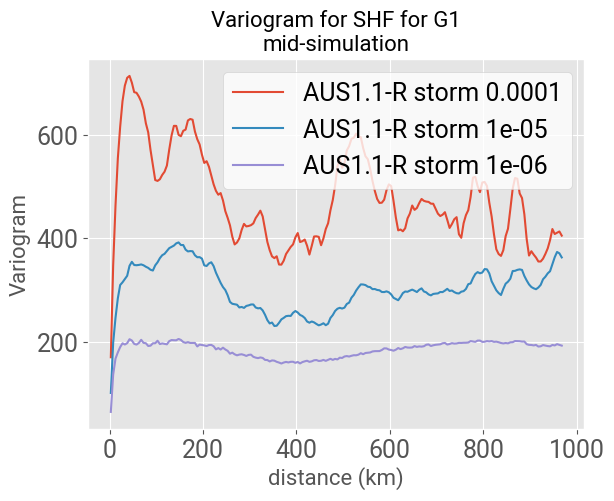

In [66]:
vario_files = sorted(glob.glob('/home/isingh/code/variogram_data/AUS1.1-R/G1/CSVs/*storm*SHF*.csv'))
print(vario_files)
plot_variogram_from_csv(vario_files,None,None)

Contour plotting  ['QTC', 750, 'pressure', '$Theta_{sfc}^{2} (K^{2})$'] 

    working on simulation:  AUS1.1-R
searching in  /monsoon/MODEL/LES_MODEL_DATA/V0/AUS1.1-R-V0/G3/out_30s/
        total # files =  131
        first file is  /monsoon/MODEL/LES_MODEL_DATA/V0/AUS1.1-R-V0/G3/out_30s/a-L-2006-01-23-113000-g1.h5
        last file is  /monsoon/MODEL/LES_MODEL_DATA/V0/AUS1.1-R-V0/G3/out_30s/a-L-2006-01-23-123500-g1.h5
        choosing the middle file:  /monsoon/MODEL/LES_MODEL_DATA/V0/AUS1.1-R-V0/G3/out_30s/a-L-2006-01-23-120230-g1.h5
getting QTC data on pressure level  750  hPa
getting random coordinates over  environment  points
        getting total condensate for conditional variogram
getting QTC data on pressure level  750  hPa
        min, max for the condensate field is  -1.15320545e-05   0.010996649
getting a random sample of coordinates where  <function make_plan_view.<locals>.<lambda> at 0x7fe7274b0160>
        shape of the 2D condition field is  (625, 1040)
length of all c

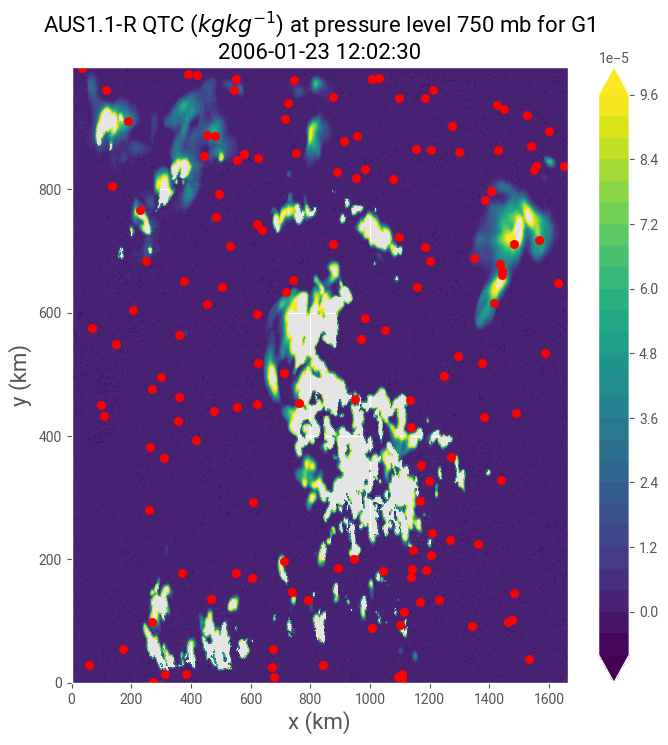

In [6]:
#%%writefile make_plan_views_RAMS.py
# make plan views of variables:
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import os
from multiprocessing import Pool, cpu_count
import time
import h5py
import hdf5plugin
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import cartopy.crs as crs
import random
import skgstat as skg
plt.style.use('ggplot')
from pprint import pprint
import seaborn as sns
import matplotlib.ticker as ticker
import read_vars_WRF_RAMS
from scipy.ndimage import gaussian_filter
import variogram_helper_functions



simulations=['AUS1.1-R']#PHI1.1-R','PHI2.1-R','WPO1.1-R','BRA1.1-R','DRC1.1-R','AUS1.1-R']
domain='1'
variables = [['QTC', 750, 'pressure', '$Theta_{sfc}^{2} (K^{2})$']]#['THETA', 0, 'model', '$Theta_{sfc}^{2} (K^{2})$'],['QV', 0, 'model', '$Qvapor_{sfc}^{2} (kg^{2}kg^{-2})$']]



for var in variables:
    for sim in simulations:
        make_plan_view('middle', var, sim, '1', 150, ['environment',0.000001])

# print('working on domain' ,domain)
# #Running on the terminal in parallel
# argument = []
# for var in variables:
#     argument = argument + [('middle',var, simulations, domain)]

# print('length of argument is: ',len(argument))


# # # ############################### FIRST OF ALL ################################
# cpu_count1 = 37 #cpu_count()
# print('number of cpus: ',cpu_count1)
# # # #############################################################################

# def main(FUNCTION, ARGUMENT):
#     start_time = time.perf_counter()
#     with Pool(processes = (cpu_count1-1)) as pool:
#         data = pool.starmap(FUNCTION, ARGUMENT)
#     finish_time = time.perf_counter()
#     print(f"Program finished in {finish_time-start_time} seconds")
#     #df_all = pd.concat(data, ignore_index=True)
#     #thermo_indices_data_csv_file = csv_folder+'thermodynamic_indices_' + DOMAIN + '_comb_track_filt_01_02_50_02_sr5017_setpos.csv'
#     #print('saving thermodynamic indices to the file: ',thermo_indices_data_csv_file)
#     #df_all.to_csv(thermo_indices_data_csv_file)  # sounding data
    
# if __name__ == "__main__":
#     main(make_plan_view, argument)





#     

Text(0, 0.5, 'Semi-variogram $(arbitrary-unit^{2})$')

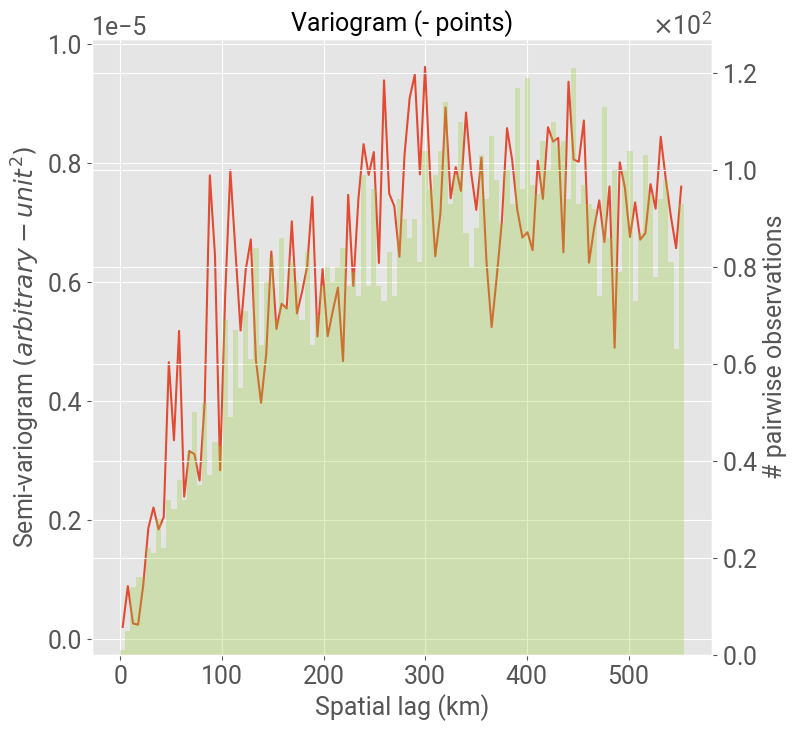

In [3]:
import matplotlib.ticker as mticker
df = pd.read_csv('/home/isingh/code/variogram_data/ARG1.1-R/G1/CSVs/experimental_variogram_ARG1.1-R_G1_environment_points_QV_levtype_pressure_lev_750_20181213210000.csv')
print(df)

fig, ax    = plt.subplots(1,1,figsize=(8,8))
ax.plot(df.bins,df.exp_variogram)
#formatter = plt.FuncFormatter(lambda x, _: '{:.0e}'.format(x))
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2,2))

ax_twin1 = ax.twinx()
ax_twin1.yaxis.set_major_formatter(formatter)
#ax_twin1.yaxis.offsetText.set_visible(False)
#offset = ax_twin1.yaxis.get_major_formatter().get_offset()
#ax_twin1.get_yaxis().get_major_formatter().set_scientific(True)
ax_twin1.bar(df.bins, df.counts, width = df.widths, color='yellowgreen', alpha=0.3)
ax_twin1.set_ylabel('# pairwise observations')

ax.set_title('Variogram (- points)')
ax.set_xlabel('Spatial lag (km)')
ax.set_ylabel('Semi-variogram $(arbitrary-unit^{2})$')

In [ ]:
import variogram_helper_functions
#163,174,181, 178, 87
import xarray as xr
radiometer_filename1 = 'a-L-2006-01-23-114000-g1_dz100_ARTS_7-9-20-33-30_c1_INCUS87.nc'
radiometer_filename2 = 'a-L-2006-01-23-114000-g1_dz100_ARTS_7-9-20-33-30_c1_INCUS163.nc'
radiometer_filename3 = 'a-L-2006-01-23-114000-g1_dz100_ARTS_7-9-20-33-30_c1_INCUS174.nc'
radiometer_filename4 = 'a-L-2006-01-23-114000-g1_dz100_ARTS_7-9-20-33-30_c1_INCUS178.nc'
radiometer_filename5 = 'a-L-2006-01-23-114000-g1_dz100_ARTS_7-9-20-33-30_c1_INCUS181.nc'
ds1 = xr.open_dataset('/monsoon/MODEL/FORWARD_MODEL_DATA/V0/AUS1.1-R-V0/RADIOMETER/'+radiometer_filename1)
ds2 = xr.open_dataset('/monsoon/MODEL/FORWARD_MODEL_DATA/V0/AUS1.1-R-V0/RADIOMETER/'+radiometer_filename2)
ds3 = xr.open_dataset('/monsoon/MODEL/FORWARD_MODEL_DATA/V0/AUS1.1-R-V0/RADIOMETER/'+radiometer_filename3)
ds4 = xr.open_dataset('/monsoon/MODEL/FORWARD_MODEL_DATA/V0/AUS1.1-R-V0/RADIOMETER/'+radiometer_filename4)
ds5 = xr.open_dataset('/monsoon/MODEL/FORWARD_MODEL_DATA/V0/AUS1.1-R-V0/RADIOMETER/'+radiometer_filename5)

fig = plt.figure()
labels = ['87','163','174','178','181']
for ii, z in enumerate([ds1.Tb.values,ds2.Tb.values,ds3.Tb.values,ds4.Tb.values,ds5.Tb.values]):
    print(ii,' : ',labels[ii])
    y_dim, x_dim     = np.shape(z)
    coords = variogram_helper_functions.produce_random_coords(x_dim,y_dim,15000)  
    # produce a random sample of coordinates
    nonnan_coords, nonnan_values = variogram_helper_functions.get_values_at_random_coords(z, coords)
    # get the values of the field at the random coordinates
    max_lag = np.sqrt(x_dim**2 + y_dim**2)/2.0# in grid points
    num_lag_classses = int(max_lag*1.6/5.0)
    # create a variogram and save bin and variogram values in a matrix for saving
    _ , bins, exp_variogram, matrix_for_saving = variogram_helper_functions.make_variogram(nonnan_coords, nonnan_values,num_lag_classses,MAXLAG=max_lag,DX=1.6)
    ##########################
    plt.plot(bins,exp_variogram,label=labels[ii])
    plt.legend()

In [ ]:
radiometer_filename1 = 'a-L-2006-01-23-114000-g1_dz100_ARTS_7-9-20-33-30_c1_INCUS87_FP.nc'
radiometer_filename2 = 'a-L-2006-01-23-114000-g1_dz100_ARTS_7-9-20-33-30_c1_INCUS163_FP.nc'
radiometer_filename3 = 'a-L-2006-01-23-114000-g1_dz100_ARTS_7-9-20-33-30_c1_INCUS174_FP.nc'
radiometer_filename4 = 'a-L-2006-01-23-114000-g1_dz100_ARTS_7-9-20-33-30_c1_INCUS178_FP.nc'
radiometer_filename5 = 'a-L-2006-01-23-114000-g1_dz100_ARTS_7-9-20-33-30_c1_INCUS181_FP.nc'
ds1 = xr.open_dataset('/monsoon/MODEL/FORWARD_MODEL_DATA/V0/AUS1.1-R-V0/RADIOMETER/'+radiometer_filename1)
ds2 = xr.open_dataset('/monsoon/MODEL/FORWARD_MODEL_DATA/V0/AUS1.1-R-V0/RADIOMETER/'+radiometer_filename2)
ds3 = xr.open_dataset('/monsoon/MODEL/FORWARD_MODEL_DATA/V0/AUS1.1-R-V0/RADIOMETER/'+radiometer_filename3)
ds4 = xr.open_dataset('/monsoon/MODEL/FORWARD_MODEL_DATA/V0/AUS1.1-R-V0/RADIOMETER/'+radiometer_filename4)
ds5 = xr.open_dataset('/monsoon/MODEL/FORWARD_MODEL_DATA/V0/AUS1.1-R-V0/RADIOMETER/'+radiometer_filename5)

fig = plt.figure()
labels = ['87','163','174','178','181']
for ii, z in enumerate([ds1.Tb.values,ds2.Tb.values,ds3.Tb.values,ds4.Tb.values,ds5.Tb.values]):
    print(ii,' : ',labels[ii])
    y_dim, x_dim     = np.shape(z)
    coords = variogram_helper_functions.produce_random_coords(x_dim,y_dim,15000)  
    # produce a random sample of coordinates
    nonnan_coords, nonnan_values = variogram_helper_functions.get_values_at_random_coords(z, coords)
    # get the values of the field at the random coordinates
    max_lag = np.sqrt(x_dim**2 + y_dim**2)/2.0# in grid points
    num_lag_classses = int(max_lag*1.6/5.0)
    # create a variogram and save bin and variogram values in a matrix for saving
    _ , bins, exp_variogram, matrix_for_saving = variogram_helper_functions.make_variogram(nonnan_coords, nonnan_values,num_lag_classses,MAXLAG=max_lag,DX=1.6)
    ##########################
    plt.plot(bins,exp_variogram,label=labels[ii])
    plt.legend()

In [ ]:
ds = xr.open_dataset('/monsoon/MODEL/FORWARD_MODEL_DATA/V0/AUS1.1-R-V0/GEO_IR/'+'a-A-2006-01-23-133000-g1_ahi_himawari8.nc')
fig = plt.figure()
wavelengths = ['6.2','6.9','7.3','11.2']
for ii, wavelength in enumerate(wavelengths):
    z = ds.Tb.sel(wavelength = float(wavelength)).values
    print(ii,' : ',wavelengths[ii])
    y_dim, x_dim     = np.shape(z)
    coords = variogram_helper_functions.produce_random_coords(x_dim,y_dim,5000)  
    # produce a random sample of coordinates
    nonnan_coords, nonnan_values = variogram_helper_functions.get_values_at_random_coords(z, coords)
    # get the values of the field at the random coordinates
    max_lag = np.sqrt(x_dim**2 + y_dim**2)/2.0# in grid points
    num_lag_classses = int(max_lag*1.6/5.0)
    # create a variogram and save bin and variogram values in a matrix for saving
    _ , bins, exp_variogram, matrix_for_saving = variogram_helper_functions.make_variogram(nonnan_coords, nonnan_values,num_lag_classses,MAXLAG=max_lag,DX=1.6)
    ##########################
    plt.plot(bins,exp_variogram,label=wavelengths[ii])
    plt.legend()

### One sample variograms for nested domains

In [ ]:
#%%writefile save_coincident_variograms_multiprocessing.py

import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import os
from multiprocessing import Pool, cpu_count
import time
import h5py
import hdf5plugin
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import cartopy.crs as crs
import random
import skgstat as skg
plt.style.use('ggplot')
from pprint import pprint
import seaborn as sns
import matplotlib.ticker as ticker
import read_vars_WRF_RAMS
from pathlib import Path


def save_coincident_variograms(WHICH_TIME, VARIABLE, SIMULATIONS, SAMPLE_SIZE, DOMAINS, COINCIDENT, NSAMPLES, COLORS, SAVE_NPY, PLOT):
    
    print('working on ',VARIABLE,'\n')

    for ii,simulation in enumerate(SIMULATIONS): 
        print('  <<working on simulation: ',simulation,'>>\n')
        if PLOT:
            fig    = plt.figure(figsize=(8,8))
        for DOMAIN in DOMAINS:
            print('    <<working on domain: ',DOMAIN,'>>\n')
            if DOMAIN==1:
                dx = 1.6
            if DOMAIN==2:
                dx=0.4
            if DOMAIN==3:
                dx=0.1
            
            if simulation=='PHI2.1-R':
                rams_g3_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/V0/'+simulation+'-V0/G'+'3'+'/out_30s/Lite/'+'a-L-*g3.h5'))# CSU machine
            else:
                rams_g3_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/V0/'+simulation+'-V0/G'+'3'+'/out_30s/'+'a-L-*g3.h5'))# CSU machine
            print('        total # files = ',len(rams_g3_files))
            print('        first file is ',rams_g3_files[0])
            print('        last file is ',rams_g3_files[-1])

            if WHICH_TIME=='start':
                rams_g3_fil    = rams_g3_files[0]
                print('        choosing the start file: ',rams_g3_fil)
            if WHICH_TIME=='middle':
                rams_g3_fil    = rams_g3_files[int(len(rams_g3_files)/2)]
                print('        choosing the middle file: ',rams_g3_fil)
            if WHICH_TIME=='end':
                rams_g3_fil    = rams_g3_files[-1]
                print('        choosing the end file: ',rams_g3_fil)

            if DOMAIN==1 or DOMAIN ==2:
                print('searching for domain ',DOMAIN,' file for the same time in the directory: ',\
                      '/monsoon/MODEL/LES_MODEL_DATA/V0/'+simulation+'-V0/G'+str(DOMAIN)+'/out/')
                g3_time = get_time_from_RAMS_file(rams_g3_fil)[2]
                print('        time in G3 file ',g3_time)
                if simulation=='PHI2.1-R':
                    rams_g1_or_g2_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/V0/'+simulation+'-V0/G3/out_30s/Lite/'+'a-L-*g'+str(DOMAIN)+'.h5'))# CSU machine
                else:
                    rams_g1_or_g2_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/V0/'+simulation+'-V0/G3/out_30s/'+'a-L-*g'+str(DOMAIN)+'.h5'))# CSU machine
                print('        found total ',len(rams_g1_or_g2_files),' files for domain ',DOMAIN,' for this simulation')
                list_of_times = [get_time_from_RAMS_file(fil)[2] for fil in rams_g1_or_g2_files]
                ind_g1_or_g2_file_index = find_closest_datetime_index(list_of_times, g3_time)
                rams_larger_grid_file = rams_g1_or_g2_files[ind_g1_or_g2_file_index]
                print('        found the file ',rams_larger_grid_file)


            if DOMAIN<3:
                print('Domain intersection portion...')
                z, z_name, z_units, z_time = grab_intersection_gbig_gsmall(VARIABLE,rams_larger_grid_file,rams_g3_fil)
            else:
                z, z_name, z_units, z_time = read_vars_WRF_RAMS.read_variable(rams_g3_fil,VARIABLE[0],'RAMS',output_height=False,interpolate=VARIABLE[1]>-1,level=VARIABLE[1],interptype=VARIABLE[2])

            # read the file to get coordinates
            y_dim, x_dim     = np.shape(z)
            coords = produce_random_coords(x_dim,y_dim,SAMPLE_SIZE)                           
            # produce a random sample of coordinates
            nonnan_coords, nonnan_values = get_values_at_random_coords(z, coords)
            # get the values of the field at the random coordinates
            max_lag = np.sqrt(x_dim**2 + y_dim**2)/2.0# in grid points
            # create a variogram and save bin and variogram values in a matrix for saving
            _ , bins, exp_variogram, matrix_for_saving = variogram_helper_functions.make_variogram(nonnan_coords, nonnan_values,100,MAXLAG=max_lag,DX=dx)

            if SAVE_NPY:
                if VARIABLE[2]:
                    data_file = 'experimental_variogram_RAMS_coincident_'+VARIABLE[0]+'_levtype_'+VARIABLE[2]+'_lev_'+str(int(VARIABLE[1]))+'_'+z_time+'_'+simulation+'_1_sample_no_mask_d0'+str(DOMAIN)+'.npy'
                else:
                    data_file = 'experimental_variogram_RAMS_coincident_'+VARIABLE[0]+'_levtype_'+'None'+'_lev_'+'None'+'_'+z_time+'_'+simulation+'_1_sample_no_mask_d0'+str(DOMAIN)+'.npy'

                with open(data_file, 'wb') as f:
                    np.save(f, matrix_for_saving)
                    np.save(f, matrix_for_saving)

                print('        saving variogram data to ',data_file)
                print('        ------\n')

            if DOMAIN==1:
                linestyle = '-'
            if DOMAIN==2:
                linestyle = '--'
            if DOMAIN==3:
                linestyle = ':'

            # Add lines to the plot
            if PLOT:
                plt.plot(bins[bins<150],exp_variogram[bins<150],label=simulation+' d0'+str(DOMAIN), color=COLORS[ii],linestyle=linestyle)

        # Add annotations/title and save the plot
        if PLOT:
            if VARIABLE[2]:
                title_string = 'Variogram for '+VARIABLE[0]+' at '+VARIABLE[2]+' level '+str(int(VARIABLE[1]))+'\nat mid-simulation'
            else:
                title_string = 'Variogram for '+VARIABLE[0]+'\nat mid-simulation'    
            plt.title(title_string)
            plt.xlabel('distance (km)')
            plt.ylabel(VARIABLE[3])
            plt.legend()
            if VARIABLE[2]:
                filename = 'experimental_variogram_RAMS_'+simulation+'_coincident_'+VARIABLE[0]+'_levtype_'+VARIABLE[2]+'_lev_'+str(int(VARIABLE[1]))+'_1_sample_no_mask_mid-simulation.png'
            else:
                filename = 'experimental_variogram_RAMS_'+simulation+'_coincident_'+VARIABLE[0]+'_levtype_'+'None'+'_lev_'+'None'+'_1_sample_no_mask_mid-simulation.png'
            print('        saving plot to file: ',filename)
            plt.savefig(filename,dpi=150)
            #print('\n\n')
        print('------------------------------------------------------------------------\n')

# PARAMETERS
simulations=['BRA1.1-R','PHI2.1-R','DRC1.1-R','PHI1.1-R','WPO1.1-R','BRA1.1-R','USA1.1-R','AUS1.1-R']
domains=[1,2,3]
nsamples=1
sample_size = 15000
variables = [['THETA', 0, 'model', '$Theta_{sfc}^{2} (K^{2})$'], ['QV', 0, 'model', '$Qvapor_{sfc}^{2} (kg^{2}kg^{-2})$'],\
              ['W', 750, 'pressure', '$W_{750}^{2} (m^{2}s^{-2})$'],['MCAPE', -999, None, '$MCAPE^{2} (J^{2}kg^{-2})$'] ]             
# [['TOP_SOIL_MOISTURE', -999, None, '$SM^{2} (m^{3} m^{3})$'], ['LHF', -999, None, '$LHF^{2} (Wm^{-2})$'],\
#              ['SHF', -999, None, '$SHF^{2} (Wm^{-2})$'],\
#              ['Tk', 0, 'model', '$T_{sfc}^{2} (K^{2})$']             , ['THETA', 0, 'model', '$Theta_{sfc}^{2} (K^{2})$'],\
#              ['QV', 0, 'model', '$Qvapor_{sfc}^{2} (kg^{2}kg^{-2})$'], ['RH', 0, 'model', '$RH_{sfc}^{2} (percent^{2})$'],\
#              ['U', 0, 'model', '$U_{sfc}^{2} (m^{2}s^{-2})$']        , ['V', 0, 'model', '$V_{sfc}^{2} (m^{2}s^{-2})$'],\
#              ['WSPD', 0, 'model', '$WSPD_{sfc}^{2} (m^{2}s^{-2})$']  , ['W', 0, 'model', '$W_{sfc}^{2} (m^{2}s^{-2})$'],\
#              ['MCAPE', -999, None, '$MCAPE^{2} (J^{2}kg^{-2})$']     , ['MCIN', -999, None, '$MCIN^{2} (J^{2}kg^{-2})$'], \
#              ['Tk', 750, 'pressure', '$T_{750}^{2} (K^{2})$']        , ['THETA', 750, 'pressure', '$Theta_{750}^{2} (K^{2})$'],\
#              ['QV', 750, 'pressure', '$Qvapor_{750}^{2} (kg^{2}kg^{-2})$'], ['RH', 750, 'pressure', '$RH_{750}^{2} (percent^{2})$'],\
#              ['U', 750, 'pressure', '$U_{750}^{2} (m^{2}s^{-2})$']   , ['V', 750, 'pressure', '$V_{750}^{2} (m^{2}s^{-2})$'],\
#              ['WSPD', 750, 'pressure', '$WSPD_{750}^{2} (m^{2}s^{-2})$'], ['W', 750, 'pressure', '$W_{750}^{2} (m^{2}s^{-2})$'],\
#              ['Tk', 500, 'pressure', '$T_{500}^{2} (K^{2})$']        , ['THETA', 500, 'pressure', '$Theta_{500}^{2} (K^{2})$'],\
#              ['QV', 500, 'pressure', '$Qvapor_{500}^{2} (kg^{2}kg^{-2})$'], ['RH', 500, 'pressure', '$RH_{500}^{2} (percent^{2})$'],\
#              ['U', 500, 'pressure', '$U_{500}^{2} (m^{2}s^{-2})$']   , ['V', 500, 'pressure', '$V_{500}^{2} (m^{2}s^{-2})$'],\
#              ['WSPD', 500, 'pressure', '$WSPD_{500}^{2} (m^{2}s^{-2})$'], ['W', 500, 'pressure', '$W_{500}^{2} (m^{2}s^{-2})$'],\
#              ['Tk', 200, 'pressure', '$T_{200}^{2} (K^{2})$']        , ['THETA', 200, 'pressure', '$Theta_{200}^{2} (K^{2})$'],\
#              ['QV', 200, 'pressure', '$Qvapor_{200}^{2} (kg^{2}kg^{-2})$'], ['RH', 200, 'pressure', '$RH_{200}^{2} (percent^{2})$'],\
#              ['U', 200, 'pressure', '$U_{200}^{2} (m^{2}s^{-2})$']   , ['V', 200, 'pressure', '$V_{200}^{2} (m^{2}s^{-2})$'], \
#              ['WSPD', 200, 'pressure', '$WSPD_{200}^{2} (m^{2}s^{-2})$'], ['W', 200, 'pressure', '$W_{200}^{2} (m^{2}s^{-2})$']]
colors    =  ['#000000','#000000','#E69F00','#56B4E9','#009E73','#0072B2','#D55E00','#CC79A7']

# for variable in variables:
#     save_coincident_variograms('middle', variable, simulations, 15000, domains, False, 1, colors, True)
#     print('=====================================================================================\n\n\n\n')
          
          
#Running on the terminal in parallel
argument = []
for variable in variables:
    argument = argument + [('middle', variable, simulations, 15000, domains, False, 1, colors, False, True)]

print('length of argument is: ',len(argument))


# # ############################### FIRST OF ALL ################################
cpu_count1 = 18 #cpu_count()
print('number of cpus: ',cpu_count1)
# # #############################################################################

def main(FUNCTION, ARGUMENT):
    start_time = time.perf_counter()
    with Pool(processes = (cpu_count1-1)) as pool:
        data = pool.starmap(FUNCTION, ARGUMENT)
    finish_time = time.perf_counter()
    print(f"Program finished in {finish_time-start_time} seconds")
    #df_all = pd.concat(data, ignore_index=True)
    #thermo_indices_data_csv_file = csv_folder+'thermodynamic_indices_' + DOMAIN + '_comb_track_filt_01_02_50_02_sr5017_setpos.csv'
    #print('saving thermodynamic indices to the file: ',thermo_indices_data_csv_file)
    #df_all.to_csv(thermo_indices_data_csv_file)  # sounding data
    
if __name__ == "__main__":
    main(save_coincident_variograms, argument)

### One sample variograms for nested, RESAMPLED domains

In [ ]:
#%%writefile save_resampled_coincident_variograms_multiprocessing.py

import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import os
from multiprocessing import Pool, cpu_count
import time
import h5py
import hdf5plugin
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import cartopy.crs as crs
import random
import skgstat as skg
plt.style.use('ggplot')
from pprint import pprint
import seaborn as sns
import matplotlib.ticker as ticker
import read_vars_WRF_RAMS
from pathlib import Path
import variogram_helper_functions



def save_resampled_coincident_variograms(WHICH_TIME, VARIABLE, SIMULATIONS, SAMPLE_SIZE, DOMAINS, COINCIDENT, NSAMPLES, COLORS, PLOT):
    
    print('working on ',VARIABLE,'\n')

    for ii,simulation in enumerate(SIMULATIONS): 
        print('  <<working on simulation: ',simulation,'>>\n')
        if PLOT:
            fig    = plt.figure(figsize=(8,8))
        for DOMAIN in DOMAINS:
            print('    <<working on domain: ',DOMAIN,'>>\n')
            if DOMAIN==1:
                dx=1.6
            if DOMAIN==2:
                dx=1.6
            if DOMAIN==3:
                dx=1.6
            
            if simulation=='PHI2.1-R':
                rams_g3_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/V0/'+simulation+'-V0/G'+'3'+'/out_30s/Lite/'+'a-L-*g3.h5'))# CSU machine
            else:
                rams_g3_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/V0/'+simulation+'-V0/G'+'3'+'/out_30s/'+'a-L-*g3.h5'))# CSU machine
            print('        total # files = ',len(rams_g3_files))
            print('        first file is ',rams_g3_files[0])
            print('        last file is ',rams_g3_files[-1])

            if WHICH_TIME=='start':
                rams_g3_fil    = rams_g3_files[0]
                print('        choosing the start file: ',rams_g3_fil)
            if WHICH_TIME=='middle':
                rams_g3_fil    = rams_g3_files[int(len(rams_g3_files)/2)]
                print('        choosing the middle file: ',rams_g3_fil)
            if WHICH_TIME=='end':
                rams_g3_fil    = rams_g3_files[-1]
                print('        choosing the end file: ',rams_g3_fil)

            if DOMAIN==1 or DOMAIN ==2:
                print('searching for domain ',DOMAIN,' file for the same time in the directory: ',\
                      '/monsoon/MODEL/LES_MODEL_DATA/V0/'+simulation+'-V0/G'+str(DOMAIN)+'/out/')
                g3_time = get_time_from_RAMS_file(rams_g3_fil)[2]
                print('        time in G3 file ',g3_time)
                if simulation=='PHI2.1-R':
                    rams_g1_or_g2_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/V0/'+simulation+'-V0/G3/out_30s/Lite/'+'a-L-*g'+str(DOMAIN)+'.h5'))# CSU machine
                else:
                    rams_g1_or_g2_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/V0/'+simulation+'-V0/G3/out_30s/'+'a-L-*g'+str(DOMAIN)+'.h5'))# CSU machine
                print('        found total ',len(rams_g1_or_g2_files),' files for domain ',DOMAIN,' for this simulation')
                list_of_times = [get_time_from_RAMS_file(fil)[2] for fil in rams_g1_or_g2_files]
                ind_g1_or_g2_file_index = find_closest_datetime_index(list_of_times, g3_time)
                rams_larger_grid_file = rams_g1_or_g2_files[ind_g1_or_g2_file_index]
                print('        found the file ',rams_larger_grid_file)


            if DOMAIN<3:
                print('Domain intersection portion...')
                z, z_name, z_units, z_time = grab_intersection_gbig_gsmall(VARIABLE,rams_larger_grid_file,rams_g3_fil)
            else:
                z, z_name, z_units, z_time = read_vars_WRF_RAMS.read_variable(rams_g3_fil,VARIABLE[0],'RAMS',output_height=False,interpolate=VARIABLE[1]>-1,level=VARIABLE[1],interptype=VARIABLE[2])

            
            if DOMAIN==2:
                # Reshape and average to reduce size by 4 in each dimension
                print('Resampling the domain 2 array...')
                new_shape = (z.shape[0] // 4, z.shape[1] // 4)
                z_temp = z[:new_shape[0]*4, :new_shape[1]*4].reshape(new_shape[0], 4, new_shape[1], 4)
                print('        shape of the temporary reshaped array is ',z_temp.shape)
                z = np.nanmean(z_temp,axis=(1, 3))
                print('        shape of the smaller array is ',z.shape)
            if DOMAIN==3:
                print('        Resampling the domain 3 array...')
                new_shape = (z.shape[0] // 16, z.shape[1] // 16)
                z_temp = z[:new_shape[0]*16, :new_shape[1]*16].reshape(new_shape[0], 16, new_shape[1], 16)
                print('        shape of the temporary reshaped array is ',z_temp.shape)
                z = np.nanmean(z_temp, axis=(1, 3))
                print('        shape of the smaller array is ',z.shape)
                
            # read the file to get coordinates
            y_dim, x_dim     = np.shape(z)
            coords = produce_random_coords(x_dim,y_dim,SAMPLE_SIZE)                           
            # produce a random sample of coordinates
            nonnan_coords, nonnan_values = get_values_at_random_coords(z, coords)
            # get the values of the field at the random coordinates
            bins, exp_variogram, matrix_for_saving = make_variogram(nonnan_coords, nonnan_values, 200, dx)
            # create a variogram and save bin and variogram values in a matrix for saving

            if VARIABLE[2]:
                data_file = 'experimental_resampled_variogram_RAMS_coincident_'+VARIABLE[0]+'_levtype_'+VARIABLE[2]+'_lev_'+str(int(VARIABLE[1]))+'_'+z_time+'_'+simulation+'_1_sample_no_mask_d0'+str(DOMAIN)+'.npy'
            else:
                data_file = 'experimental_resampled_variogram_RAMS_coincident_'+VARIABLE[0]+'_levtype_'+'None'+'_lev_'+'None'+'_'+z_time+'_'+simulation+'_1_sample_no_mask_d0'+str(DOMAIN)+'.npy'

            with open(data_file, 'wb') as f:
                np.save(f, matrix_for_saving)

            print('        saving variogram data to ',data_file)
            print('        ------\n')

            if DOMAIN==1:
                linestyle = '-'
            if DOMAIN==2:
                linestyle = '--'
            if DOMAIN==3:
                linestyle = ':'

            if PLOT:
                plt.plot(bins[bins<150],exp_variogram[bins<150],label=simulation+' d0'+str(DOMAIN), color=COLORS[ii],linestyle=linestyle)

        if PLOT:
            if VARIABLE[2]:
                title_string = 'Variogram (resampled) for '+VARIABLE[0]+' at '+VARIABLE[2]+' level '+str(int(VARIABLE[1]))+'\nat mid-simulation'
            else:
                title_string = 'Variogram (resampled) for '+VARIABLE[0]+'\nat mid-simulation'    
            plt.title(title_string)
            plt.xlabel('distance (km)')
            plt.ylabel(VARIABLE[3])
            plt.legend()
            if VARIABLE[2]:
                filename = 'experimental_resampled_variogram_RAMS_'+simulation+'_coincident_'+VARIABLE[0]+'_levtype_'+VARIABLE[2]+'_lev_'+str(int(VARIABLE[1]))+'_1_sample_no_mask_mid-simulation.png'
            else:
                filename = 'experimental_resampled_variogram_RAMS_'+simulation+'_coincident_'+VARIABLE[0]+'_levtype_'+'None'+'_lev_'+'None'+'_1_sample_no_mask_mid-simulation.png'
            print('        saving plot to file: ',filename)
            plt.savefig(filename,dpi=150)
            #print('\n\n')
        print('------------------------------------------------------------------------\n')

# PARAMETERS
simulations=['BRA1.1-R','PHI2.1-R','DRC1.1-R','PHI1.1-R','WPO1.1-R','USA1.1-R','AUS1.1-R']
domains=[1,2,3]
nsamples=1
sample_size = 15000
variables = [['THETA', 0, 'model', '$Theta_{sfc}^{2} (K^{2})$'], ['QV', 0, 'model', '$Qvapor_{sfc}^{2} (kg^{2}kg^{-2})$'],\
             ['W', 750, 'pressure', '$W_{750}^{2} (m^{2}s^{-2})$']]#,['MCAPE', -999, None, '$MCAPE^{2} (J^{2}kg^{-2})$'] ]             
# [['TOP_SOIL_MOISTURE', -999, None, '$SM^{2} (m^{3} m^{3})$'], ['LHF', -999, None, '$LHF^{2} (Wm^{-2})$'],\
#              ['SHF', -999, None, '$SHF^{2} (Wm^{-2})$'],\
#              ['Tk', 0, 'model', '$T_{sfc}^{2} (K^{2})$']             , ['THETA', 0, 'model', '$Theta_{sfc}^{2} (K^{2})$'],\
#              ['QV', 0, 'model', '$Qvapor_{sfc}^{2} (kg^{2}kg^{-2})$'], ['RH', 0, 'model', '$RH_{sfc}^{2} (percent^{2})$'],\
#              ['U', 0, 'model', '$U_{sfc}^{2} (m^{2}s^{-2})$']        , ['V', 0, 'model', '$V_{sfc}^{2} (m^{2}s^{-2})$'],\
#              ['WSPD', 0, 'model', '$WSPD_{sfc}^{2} (m^{2}s^{-2})$']  , ['W', 0, 'model', '$W_{sfc}^{2} (m^{2}s^{-2})$'],\
#              ['MCAPE', -999, None, '$MCAPE^{2} (J^{2}kg^{-2})$']     , ['MCIN', -999, None, '$MCIN^{2} (J^{2}kg^{-2})$'], \
#              ['Tk', 750, 'pressure', '$T_{750}^{2} (K^{2})$']        , ['THETA', 750, 'pressure', '$Theta_{750}^{2} (K^{2})$'],\
#              ['QV', 750, 'pressure', '$Qvapor_{750}^{2} (kg^{2}kg^{-2})$'], ['RH', 750, 'pressure', '$RH_{750}^{2} (percent^{2})$'],\
#              ['U', 750, 'pressure', '$U_{750}^{2} (m^{2}s^{-2})$']   , ['V', 750, 'pressure', '$V_{750}^{2} (m^{2}s^{-2})$'],\
#              ['WSPD', 750, 'pressure', '$WSPD_{750}^{2} (m^{2}s^{-2})$'], ['W', 750, 'pressure', '$W_{750}^{2} (m^{2}s^{-2})$'],\
#              ['Tk', 500, 'pressure', '$T_{500}^{2} (K^{2})$']        , ['THETA', 500, 'pressure', '$Theta_{500}^{2} (K^{2})$'],\
#              ['QV', 500, 'pressure', '$Qvapor_{500}^{2} (kg^{2}kg^{-2})$'], ['RH', 500, 'pressure', '$RH_{500}^{2} (percent^{2})$'],\
#              ['U', 500, 'pressure', '$U_{500}^{2} (m^{2}s^{-2})$']   , ['V', 500, 'pressure', '$V_{500}^{2} (m^{2}s^{-2})$'],\
#              ['WSPD', 500, 'pressure', '$WSPD_{500}^{2} (m^{2}s^{-2})$'], ['W', 500, 'pressure', '$W_{500}^{2} (m^{2}s^{-2})$'],\
#              ['Tk', 200, 'pressure', '$T_{200}^{2} (K^{2})$']        , ['THETA', 200, 'pressure', '$Theta_{200}^{2} (K^{2})$'],\
#              ['QV', 200, 'pressure', '$Qvapor_{200}^{2} (kg^{2}kg^{-2})$'], ['RH', 200, 'pressure', '$RH_{200}^{2} (percent^{2})$'],\
#              ['U', 200, 'pressure', '$U_{200}^{2} (m^{2}s^{-2})$']   , ['V', 200, 'pressure', '$V_{200}^{2} (m^{2}s^{-2})$'], \
#              ['WSPD', 200, 'pressure', '$WSPD_{200}^{2} (m^{2}s^{-2})$'], ['W', 200, 'pressure', '$W_{200}^{2} (m^{2}s^{-2})$']]
colors    =  ['#000000','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7']

# for variable in variables:
#     save_resampled_coincident_variograms('middle', variable, simulations, 15000, domains, False, 1, colors, True)
#     print('=====================================================================================\n\n\n\n')
          
          
#Running on the terminal in parallel
argument = []
for variable in variables:
    argument = argument + [('middle', variable, simulations, 15000, domains, False, 1, colors, True)]

print('length of argument is: ',len(argument))

# # ############################### FIRST OF ALL ################################
cpu_count1 = 18 #cpu_count()
print('number of cpus: ',cpu_count1)
# # #############################################################################

def main(FUNCTION, ARGUMENT):
    start_time = time.perf_counter()
    with Pool(processes = (cpu_count1-1)) as pool:
        data = pool.starmap(FUNCTION, ARGUMENT)
    finish_time = time.perf_counter()
    print(f"Program finished in {finish_time-start_time} seconds")
      
if __name__ == "__main__":
    main(save_resampled_coincident_variograms, argument)

### Save spatial autocorrelation

#### Testing/Scratch

In [ ]:
dx=0.1
temperature_data = np.random.rand(150, 150)  # Example random temperature field data
array = np.zeros((150, 150))

# Define the center and radius of the circle
center_x1 = 120
center_y1 = 60
radius1 = 7.5

center_x2 = 70
center_y2 = 100
radius2 = 10

# Generate indices for the circle
y_indices, x_indices = np.ogrid[:150, :150]
#circle_mask1 = (x_indices - center_x1)**2 + (y_indices - center_y1)**2 <= radius1**2
circle_mask2 = (x_indices - center_x2)**2 + (y_indices - center_y2)**2 <= radius2**2

# Set the values inside the circle to 1
#array[circle_mask1] = 1
array[circle_mask2] = 2
temperature_data = temperature_data  + array
plt.imshow(temperature_data)
plt.savefig('circle.png',dpi=150)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from libpysal.weights.distance import DistanceBand
import libpysal 
from esda.moran import Moran
import random

# Generate or load your 2D field data of temperature
# Here, I'm assuming you have a 2D array named 'temperature_data'
# Replace this with your actual temperature field data
dx=0.1
temperature_data = np.random.rand(150, 150)  # Example random temperature field data
array = np.zeros((150, 150))

# Define the center and radius of the circle
center_x1 = 120
center_y1 = 60
radius1 = 7.5

center_x2 = 70
center_y2 = 100
radius2 = 10

# Generate indices for the circle
y_indices, x_indices = np.ogrid[:150, :150]
#circle_mask1 = (x_indices - center_x1)**2 + (y_indices - center_y1)**2 <= radius1**2
circle_mask2 = (x_indices - center_x2)**2 + (y_indices - center_y2)**2 <= radius2**2

# Set the values inside the circle to 1
#array[circle_mask1] = 1
array[circle_mask2] = 2
temperature_data = temperature_data  + array


y_dim, x_dim     = np.shape(temperature_data)
print('        shape of the arrays is ',y_dim,'x',x_dim)
x      = np.arange(0,x_dim)#*dx
y      = np.arange(0,y_dim)#*dx
# # full coordinate arrays
xx, yy = np.meshgrid(x, y)
coords_tuples_2d = np.vstack(([yy.T], [xx.T])).T
print('        shape of combined coords matrix: ',np.shape(coords_tuples_2d))
coords_all_list = coords_tuples_2d.reshape(-1, 2).tolist()
print('        shape of 1d list of coords: ',np.shape(coords_all_list))
tuples_all_tuple =  [tuple(sublist) for sublist in coords_all_list]
#print(tuples_all_tuple[0:10])
#print(type(tuples_all_tuple[0]))

sample_coords_tuple = random.sample(tuples_all_tuple,5000)
print(sample_coords_tuple[0:10])
print('        get field values from these points...')
values = np.fromiter((temperature_data[c[0], c[1]] for c in sample_coords_tuple), dtype=float)
modified_sample_coords_tuple = [tuple(dx * element for element in tup) for tup in sample_coords_tuple]
print(modified_sample_coords_tuple[0:10])
#w=libpysal.weights.DistanceBand(sample_coords_tuple,threshold=11.2,binary=False)
#w=libpysal.weights.DistanceBand(sample_coords_tuple,threshold=11.2,binary=False,alpha=-2.)
distance_intervals = np.arange(0.1,14,0.5)  # Define distance intervals to compute Moran's I
moran_i_values  = []
moran_ei_values = []
moran_p_values  = []
moran_z_values  = []
moran_vi_values = []
for distance_interval in distance_intervals:
    print('distance interval : ',distance_interval)
    # Create binary spatial weights matrix based on distance interval
    w=libpysal.weights.DistanceBand(modified_sample_coords_tuple,threshold=distance_interval,binary=True,silence_warnings=True)
    #print(len(w.neighbors))
    print('# islands: ',len(w.islands))
    print('# max_neighbors: ',(w.max_neighbors))
    print('# mean_neighbors: ',(w.mean_neighbors))
    print('# min_neighbors: ',(w.min_neighbors))
    #print('neighbors : ')
    #print(w.neighbors)
    #print('weights : ')
    #print(w.weights)
    #w =DistanceBand (data = temperature_data, threshold = distance_interval)
    #w_interval = DistanceBand.from_array(temperature_data, threshold=distance_interval, binary=True)
    # Compute Moran's I
    moran = Moran(values, w)
    moran_i_values.append(moran.I)
    moran_ei_values.append(moran.EI)
    moran_vi_values.append(moran.VI_norm)
    moran_p_values.append(moran.p_norm)
    moran_z_values.append(moran.z_norm)
    print('------------------\n\n')

# Plot Moran's I versus distance

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
ax = axes.flatten()
ax[0].plot(distance_intervals, moran_i_values, marker='o')
ax[0].set_xlabel('Spatial lag (km)')
ax[0].set_ylabel("Moran's I")
ax[0].set_title("Moran's I vs Distance")
ax[0].grid()

ax[1].plot(distance_intervals, moran_ei_values, marker='o')
ax[1].set_xlabel('Spatial lag (km)')
ax[1].set_ylabel("Moran EI")
ax[1].set_title("Moran EI vs Distance")
ax[1].grid()

ax[2].plot(distance_intervals, moran_p_values, marker='o')
ax[2].set_xlabel('Spatial lag (km)')
ax[2].set_ylabel("Moran p_norm")
ax[2].set_title("Moran's p_norm vs Distance")
ax[2].grid()

ax[3].plot(distance_intervals, moran_z_values, marker='o')
ax[3].set_xlabel('Spatial lag (km)')
ax[3].set_ylabel("Moran z_norm")
ax[3].set_title("Moran z_norm vs Distance")
ax[3].grid()
plt.savefig('moran_testing.png',dpi=200)
plt.tight_layout()

In [ ]:
#%%writefile save_spatial_autocorr_multiprocessing.py

import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import os
from multiprocessing import Pool, cpu_count
import time
import h5py
import hdf5plugin
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import cartopy.crs as crs
import random
import skgstat as skg
plt.style.use('ggplot')
from pprint import pprint
import seaborn as sns
import matplotlib.ticker as ticker
import read_vars_WRF_RAMS


def get_time_from_RAMS_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][4:21] # Grab time string from RAMS file
    pd_time = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S')
   
def read_head(headfile,h5file):
        # Function that reads header files from RAMS

        # Inputs:
        #   headfile: header file including full path in str format
        #   h5file: h5 datafile including full path in str format

        # Returns:
        #   zmn: height levels for momentum values (i.e., grid box upper and lower levels)
        #   ztn: height levels for thermodynaic values (i.e., grid box centers)
        #   nx:: the number of x points for the domain associated with the h5file
        #   ny: the number of y points for the domain associated with the h5file
        #   npa: the number of surface patches


        dom_num = h5file[h5file.index('.h5')-1] # Find index of .h5 to determine position showing which nest domain to use

        with open(headfile) as f:
            contents = f.readlines()

        idx_zmn = contents.index('__zmn0'+dom_num+'\n')
        nz_m = int(contents[idx_zmn+1])
        zmn = np.zeros(nz_m)
        for i in np.arange(0,nz_m):
            zmn[i] =  float(contents[idx_zmn+2+i])

        idx_ztn = contents.index('__ztn0'+dom_num+'\n')
        nz_t = int(contents[idx_ztn+1])
        ztn = np.zeros(nz_t)
        for i in np.arange(0,nz_t):
            ztn[i] =  float(contents[idx_ztn+2+i])

        ztop = np.max(ztn) # Model domain top (m)

        # Grad the size of the horizontal grid spacing
        idx_dxy = contents.index('__deltaxn\n')
        dxy = float(contents[idx_dxy+1+int(dom_num)].strip())

        idx_npatch = contents.index('__npatch\n')
        npa = int(contents[idx_npatch+2])

        idx_ny = contents.index('__nnyp\n')
        idx_nx = contents.index('__nnxp\n')
        ny = np.ones(int(contents[idx_ny+1]))
        nx = np.ones(int(contents[idx_ny+1]))
        for i in np.arange(0,len(ny)):
            nx[i] = int(contents[idx_nx+2+i])
            ny[i] = int(contents[idx_ny+2+i])

        ny_out = ny[int(dom_num)-1]
        nx_out = nx[int(dom_num)-1]

        return zmn, ztn, nx_out, ny_out, dxy, npa 

simulations=['ARG1.1-R_old','PHI1.1-R','PHI2.1-R','WPO1.1-R','BRA1.1-R','USA1.1-R','DRC1.1-R','AUS1.1-R']
domain='3'
nsamples=1
sample_size = 15000
variables = [['Tk', 0, 'model', '$T_{sfc}^{2} (K^{2})$']             , ['THETA', 0, 'model', '$Theta_{sfc}^{2} (K^{2})$'],\
             ['QV', 0, 'model', '$Qvapor_{sfc}^{2} (kg^{2}kg^{-2})$'], ['RH', 0, 'model', '$RH_{sfc}^{2} (percent^{2})$'],\
             ['U', 0, 'model', '$U_{sfc}^{2} (m^{2}s^{-2})$']        , ['V', 0, 'model', '$V_{sfc}^{2} (m^{2}s^{-2})$'],\
             ['WSPD', 0, 'model', '$WSPD_{sfc}^{2} (m^{2}s^{-2})$']  , ['W', 0, 'model', '$W_{sfc}^{2} (m^{2}s^{-2})$'],\
             ['MCAPE', -999, None, '$MCAPE^{2} (J^{2}kg^{-2})$']     , ['MCIN', -999, None, '$MCIN^{2} (J^{2}kg^{-2})$'], \
             ['Tk', 750, 'pressure', '$T_{750}^{2} (K^{2})$']        , ['THETA', 750, 'pressure', '$Theta_{750}^{2} (K^{2})$'],\
             ['QV', 750, 'pressure', '$Qvapor_{750}^{2} (kg^{2}kg^{-2})$'], ['RH', 750, 'pressure', '$RH_{750}^{2} (percent^{2})$'],\
             ['U', 750, 'pressure', '$U_{750}^{2} (m^{2}s^{-2})$']   , ['V', 750, 'pressure', '$V_{750}^{2} (m^{2}s^{-2})$'],\
             ['WSPD', 750, 'pressure', '$WSPD_{750}^{2} (m^{2}s^{-2})$'], ['W', 750, 'pressure', '$W_{750}^{2} (m^{2}s^{-2})$'],\
             ['Tk', 500, 'pressure', '$T_{500}^{2} (K^{2})$']        , ['THETA', 500, 'pressure', '$Theta_{500}^{2} (K^{2})$'],\
             ['QV', 500, 'pressure', '$Qvapor_{500}^{2} (kg^{2}kg^{-2})$'], ['RH', 500, 'pressure', '$RH_{500}^{2} (percent^{2})$'],\
             ['U', 500, 'pressure', '$U_{500}^{2} (m^{2}s^{-2})$']   , ['V', 500, 'pressure', '$V_{500}^{2} (m^{2}s^{-2})$'],\
             ['WSPD', 500, 'pressure', '$WSPD_{500}^{2} (m^{2}s^{-2})$'], ['W', 500, 'pressure', '$W_{500}^{2} (m^{2}s^{-2})$'],\
             ['Tk', 200, 'pressure', '$T_{200}^{2} (K^{2})$']        , ['THETA', 200, 'pressure', '$Theta_{200}^{2} (K^{2})$'],\
             ['QV', 200, 'pressure', '$Qvapor_{200}^{2} (kg^{2}kg^{-2})$'], ['RH', 200, 'pressure', '$RH_{200}^{2} (percent^{2})$'],\
             ['U', 200, 'pressure', '$U_{200}^{2} (m^{2}s^{-2})$']   , ['V', 200, 'pressure', '$V_{200}^{2} (m^{2}s^{-2})$'], \
             ['WSPD', 200, 'pressure', '$WSPD_{200}^{2} (m^{2}s^{-2})$'], ['W', 200, 'pressure', '$W_{200}^{2} (m^{2}s^{-2})$']]

colors    =  ['#000000','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7']


import numpy as np
import matplotlib.pyplot as plt
from libpysal.weights.distance import DistanceBand
import libpysal 
from esda.moran import Moran
import random

# Generate or load your 2D field data of temperature
# Here, I'm assuming you have a 2D array named 'temperature_data'
# Replace this with your actual temperature field data
dx=0.1
temperature_data = np.random.rand(150, 150)  # Example random temperature field data
array = np.zeros((150, 150))

# Define the center and radius of the circle
center_x1 = 120
center_y1 = 60
radius1 = 7.5

center_x2 = 70
center_y2 = 100
radius2 = 10

# Generate indices for the circle
y_indices, x_indices = np.ogrid[:150, :150]
#circle_mask1 = (x_indices - center_x1)**2 + (y_indices - center_y1)**2 <= radius1**2
circle_mask2 = (x_indices - center_x2)**2 + (y_indices - center_y2)**2 <= radius2**2

# Set the values inside the circle to 1
#array[circle_mask1] = 1
array[circle_mask2] = 2
temperature_data = temperature_data  + array


y_dim, x_dim     = np.shape(temperature_data)
print('        shape of the arrays is ',y_dim,'x',x_dim)
x      = np.arange(0,x_dim)#*dx
y      = np.arange(0,y_dim)#*dx
# # full coordinate arrays
xx, yy = np.meshgrid(x, y)
coords_tuples_2d = np.vstack(([yy.T], [xx.T])).T
print('        shape of combined coords matrix: ',np.shape(coords_tuples_2d))
coords_all_list = coords_tuples_2d.reshape(-1, 2).tolist()
print('        shape of 1d list of coords: ',np.shape(coords_all_list))
tuples_all_tuple =  [tuple(sublist) for sublist in coords_all_list]
#print(tuples_all_tuple[0:10])
#print(type(tuples_all_tuple[0]))

sample_coords_tuple = random.sample(tuples_all_tuple,5000)
print(sample_coords_tuple[0:10])
print('        get field values from these points...')
values = np.fromiter((temperature_data[c[0], c[1]] for c in sample_coords_tuple), dtype=float)
modified_sample_coords_tuple = [tuple(dx * element for element in tup) for tup in sample_coords_tuple]
print(modified_sample_coords_tuple[0:10])
#w=libpysal.weights.DistanceBand(sample_coords_tuple,threshold=11.2,binary=False)
#w=libpysal.weights.DistanceBand(sample_coords_tuple,threshold=11.2,binary=False,alpha=-2.)
distance_intervals = np.arange(0.1,14,1.0)  # Define distance intervals to compute Moran's I
moran_i_values  = []
moran_ei_values = []
moran_p_values  = []
moran_z_values  = []
moran_vi_values = []
for distance_interval in distance_intervals:
    print('distance interval : ',distance_interval)
    # Create binary spatial weights matrix based on distance interval
    w=libpysal.weights.DistanceBand(modified_sample_coords_tuple,threshold=distance_interval,binary=True,silence_warnings=True)
    #print(len(w.neighbors))
    print('# islands: ',len(w.islands))
    print('# max_neighbors: ',(w.max_neighbors))
    print('# mean_neighbors: ',(w.mean_neighbors))
    print('# min_neighbors: ',(w.min_neighbors))
    #print('neighbors : ')
    #print(w.neighbors)
    #print('weights : ')
    #print(w.weights)
    #w =DistanceBand (data = temperature_data, threshold = distance_interval)
    #w_interval = DistanceBand.from_array(temperature_data, threshold=distance_interval, binary=True)
    # Compute Moran's I
    moran = Moran(values, w)
    moran_i_values.append(moran.I)
    moran_ei_values.append(moran.EI)
    moran_vi_values.append(moran.VI_norm)
    moran_p_values.append(moran.p_norm)
    moran_z_values.append(moran.z_norm)
    print('------------------\n\n')

# Plot Moran's I versus distance

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
ax = axes.flatten()
ax[0].plot(distance_intervals, moran_i_values, marker='o')
ax[0].set_xlabel('Spatial lag (km)')
ax[0].set_ylabel("Moran's I")
ax[0].set_title("Moran's I vs Distance")
ax[0].grid()

ax[1].plot(distance_intervals, moran_ei_values, marker='o')
ax[1].set_xlabel('Spatial lag (km)')
ax[1].set_ylabel("Moran EI")
ax[1].set_title("Moran EI vs Distance")
ax[1].grid()

ax[2].plot(distance_intervals, moran_p_values, marker='o')
ax[2].set_xlabel('Spatial lag (km)')
ax[2].set_ylabel("Moran p_norm")
ax[2].set_title("Moran's p_norm vs Distance")
ax[2].grid()

ax[3].plot(distance_intervals, moran_z_values, marker='o')
ax[3].set_xlabel('Spatial lag (km)')
ax[3].set_ylabel("Moran z_norm")
ax[3].set_title("Moran z_norm vs Distance")
ax[3].grid()

plt.tight_layout()
#plt.grid(True)
#plt.show()
#values_all = z_temp.flatten()# reshape(-1,0)
#print('        shape of flattened values array : ',np.shape(values_all))

def save_autocorr(WHICH_TIME, VARIABLE, SIMULATIONS, SAMPLE_SIZE, DOMAIN, NSAMPLES, COLORS, PLOT):
    if DOMAIN=='1':
        dx = 1.6
    if DOMAIN=='2':
        dx=0.4
    if DOMAIN=='3':
        dx=0.1
    print('working on ',VARIABLE,'\n')
    if PLOT:
        fig    = plt.figure(figsize=(8,8))
    for ii,simulation in enumerate(SIMULATIONS):   
        print('    working on simulation: ',simulation)
        if DOMAIN=='1' or DOMAIN =='2':
            rams_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/'+simulation+'/G'+DOMAIN+'/out/'+'a-A-*g'+DOMAIN+'.h5'))# CSU machine
        if DOMAIN=='3':
            rams_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/'+simulation+'/G'+DOMAIN+'/out_30s/'+'a-L-*g3.h5'))# CSU machine
        print('        total # files = ',len(rams_files))
        print('        first file is ',rams_files[0])
        print('        last file is ',rams_files[-1])
        if WHICH_TIME=='start':
            rams_fil    = rams_files[0]
        if WHICH_TIME=='middle':
            rams_fil    = rams_files[int(len(rams_files)/2)]
        if WHICH_TIME=='end':
            rams_fil    = rams_files[-1]
        print('        choosing the middle file: ',rams_fil)

        da     = xr.open_dataset(rams_fil,engine='h5netcdf', phony_dims='sort')
        z_temp = np.da['TOPT'].values
        y_dim, x_dim     = np.shape(z_temp)
        print('        shape of the arrays is ',y_dim,'x',x_dim)
        x      = np.arange(0,x_dim)
        y      = np.arange(0,y_dim)
        # # full coordinate arrays
        xx, yy = np.meshgrid(x, y)
        coords_tuples_2d = np.vstack(([yy.T], [xx.T])).T
        print('        shape of combined coords matrix: ',np.shape(coords_tuples_2d))
        coords_all = coords_tuples_2d.reshape(-1, 2).tolist()
        print('        shape of 1d list of coords: ',np.shape(coords_all))
        values_all = z_temp.flatten()# reshape(-1,0)
        print('        shape of flattened values array : ',np.shape(values_all))

        z, z_name, z_units, z_time = read_vars_WRF_RAMS.read_variable(rams_fil,VARIABLE[0],'RAMS',output_height=False,interpolate=VARIABLE[1]>-1,level=VARIABLE[1],interptype=VARIABLE[2])
        print('        got the data... min = ',np.nanmin(z),' max = ',np.nanmax(z))
        print('        percentage of nans is ',np.count_nonzero(np.isnan(z))/len(z.flatten()))
        print('        choosing '+str(SAMPLE_SIZE)+' random points...')
        coords = random.sample(coords_all,SAMPLE_SIZE)
        print('        get field values from these points...')
        values = np.fromiter((z[c[0], c[1]] for c in coords), dtype=float)
        # Remove nan values
        print('        Removing nan values and the corresponding coordinates...')
        nan_mask = ~np.isnan(values)
        print('        # non-nan values',np.count_nonzero(nan_mask))
        values   = values[nan_mask]
        sampled_coords_array = np.array(coords)
        coords   = sampled_coords_array[nan_mask].tolist()
        print('        final shape of coords is ',np.shape(coords))
        print('        final shape of values is ',np.shape(values))
        V        = skg.Variogram(coords, values,n_lags=200,bin_func='even')
        print('        creating variogram...')
        
        bins = V.bins*dx # convert from ineteger coordinates to physical coordinates (km)
        exp_variograms =  V.experimental

        matrix_for_saving = np.array([bins,exp_variograms]).T
        
        if VARIABLE[2]:
            data_file = 'experimental_variogram_RAMS_'+VARIABLE[0]+'_levtype_'+VARIABLE[2]+'_lev_'+str(int(VARIABLE[1]))+'_'+z_time+'_'+simulation+'_1_sample_no_mask_d0'+DOMAIN+'.npy'
        else:
            data_file = 'experimental_variogram_RAMS_'+VARIABLE[0]+'_levtype_'+'None'+'_lev_'+'None'+'_'+z_time+'_'+simulation+'_1_sample_no_mask_d0'+DOMAIN+'.npy'

        with open(data_file, 'wb') as f:
            np.save(f, matrix_for_saving)
            np.save(f, matrix_for_saving)

        print('        saving variogram data to ',data_file)
        print('    ------\n')
        
        if PLOT:
            plt.plot(bins,exp_variograms,label=simulation, color=COLORS[ii])
        
    if PLOT:
        if VARIABLE[2]:
            title_string = 'Variogram for '+VARIABLE[0]+' at '+VARIABLE[2]+' level '+str(int(VARIABLE[1]))+' for d0'+DOMAIN+'\nmid-simulation'
        else:
            title_string = 'Variogram for '+VARIABLE[0]+' for d0'+DOMAIN+'\nmid-simulation'    
        plt.title(title_string)
        plt.xlabel('distance (km)')
        plt.ylabel(VARIABLE[3])
        plt.legend()
        if VARIABLE[2]:
            filename = 'experimental_variogram_8_simulations_RAMS_'+VARIABLE[0]+'_levtype_'+VARIABLE[2]+'_lev_'+str(int(VARIABLE[1]))+'_1_sample_no_mask_d0'+DOMAIN+'_mid-simulation.png'
        else:
            filename = 'experimental_variogram_8_simulations_RAMS_'+VARIABLE[0]+'_levtype_'+'None'+'_lev_'+'None'+'_1_sample_no_mask_d0'+DOMAIN+'_mid-simulation.png'
        print('saving to file: ',filename)
        plt.savefig(filename,dpi=150)
        print('\n\n')

print('working on domain' ,domain)
#Running on the terminal in parallel
argument = []
for var in variables:
    argument = argument + [('end',var, simulations, sample_size, domain, nsamples, colors, True)]

print('length of argument is: ',len(argument))


# # ############################### FIRST OF ALL ################################
cpu_count1 = 37 #cpu_count()
print('number of cpus: ',cpu_count1)
# # #############################################################################

def main(FUNCTION, ARGUMENT):
    start_time = time.perf_counter()
    with Pool(processes = (cpu_count1-1)) as pool:
        data = pool.starmap(FUNCTION, ARGUMENT)
    finish_time = time.perf_counter()
    print(f"Program finished in {finish_time-start_time} seconds")
    #df_all = pd.concat(data, ignore_index=True)
    #thermo_indices_data_csv_file = csv_folder+'thermodynamic_indices_' + DOMAIN + '_comb_track_filt_01_02_50_02_sr5017_setpos.csv'
    #print('saving thermodynamic indices to the file: ',thermo_indices_data_csv_file)
    #df_all.to_csv(thermo_indices_data_csv_file)  # sounding data
    
if __name__ == "__main__":
    main(save_variogram, argument)

In [ ]:
# testing for autocorr calculation
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import os
from multiprocessing import Pool, cpu_count
import time
import h5py
import hdf5plugin
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import cartopy.crs as crs
import random
import skgstat as skg
plt.style.use('ggplot')
from pprint import pprint
import seaborn as sns
import matplotlib.ticker as ticker
import read_vars_WRF_RAMS

z_temp = np.random.rand(150, 150) 
y_dim, x_dim     = np.shape(z_temp)
print('        shape of the arrays is ',y_dim,'x',x_dim)
x      = np.arange(0,x_dim)
y      = np.arange(0,y_dim)
# # full coordinate arrays
xx, yy = np.meshgrid(x, y)
coords_tuples_2d = np.vstack(([yy.T], [xx.T])).T
print('        shape of combined coords matrix: ',np.shape(coords_tuples_2d))
coords_all = coords_tuples_2d.reshape(-1, 2).tolist()
print('        shape of 1d list of coords: ',np.shape(coords_all))
values_all = z_temp.flatten()# reshape(-1,0)
print('        shape of flattened values array : ',np.shape(values_all))
z = z_temp # z_name, z_units, z_time = read_vars_WRF_RAMS.read_variable(rams_fil,VARIABLE[0],'RAMS',output_height=False,interpolate=VARIABLE[1]>-1,level=VARIABLE[1],interptype=VARIABLE[2])
print('        got the data... min = ',np.nanmin(z),' max = ',np.nanmax(z))
print('        percentage of nans is ',np.count_nonzero(np.isnan(z))/len(z.flatten()))
print('        choosing '+str(1000)+' random points...')
coords = random.sample(coords_all,1000)
print('        get field values from these points...')
values = np.fromiter((z[c[0], c[1]] for c in coords), dtype=float)
# Remove nan values
print('        Removing nan values and the corresponding coordinates...')
nan_mask = ~np.isnan(values)
print('        # non-nan values',np.count_nonzero(nan_mask))
values   = values[nan_mask]
sampled_coords_array = np.array(coords)
coords   = sampled_coords_array[nan_mask].tolist()
print('        final shape of coords is ',np.shape(coords))
print('first 10 coords are: ',coords[0:10])
print('        final shape of values is ',np.shape(values))
V        = skg.Variogram(coords, values,n_lags=80,bin_func='even')
print('        creating variogram...')

bins = V.bins # convert from integer coordinates to physical coordinates (km)
exp_variograms =  V.experimental
print('bins are : ',bins, 'with shape ',np.shape(bins))
print('--------\n')
print('experimental variogram is :',exp_variograms ,' with shape ',np.shape(exp_variograms))
print('--------\n')
print('empirical variogram: ',V.get_empirical())
print('--------\n')
print('maxlag: ',V.maxlag)
print('--------\n')
#print('fit bounds: ',V.__get_fit_bounds())
print('--------\n')
print('data: ',V.data()) # theoretical model 
print('--------\n')
print('model_residuals: ',V.model_residuals) # theoretical model 
print('--------\n')
print('parameters: range, sill, nugget are ',V.parameters)
print('----plot----\n')
V.plot()
print('---scattergram-----\n')
#V.scattergram()
print('---distance_difference_plot-----\n')
V.distance_difference_plot()
print('--------\n')
print(' all pairwise differences shape :',np.shape(V.pairwise_diffs))
print('--------\n')
print(' all distance shape :',np.shape(V.distance))
print('--------\n')
print(' _calc_groups :',V._calc_groups())
print('--------\n')
print(' lag_classes :',V.lag_classes())
print('--------\n') 
print(' values shape :',np.shape (V.values))
print('--------\n') 
print(' _diff :',np.shape (V._diff))
print('--------\n') 
print(' lag_groups :',V.lag_groups(), ' with shape: ',np.shape(V.lag_groups()))
print('min lag group: ',min(V.lag_groups()), 'max lag group: ',max(V.lag_groups()))
print('unique lag groups ',np.unique(V.lag_groups()))
print('--------\n') 

In [ ]:
from scipy.spatial.distance import pdist, squareform
blah = pdist(np.column_stack((V.values, np.zeros(len(V.values)))),metric="euclidean")
print(np.shape(blah))
print(blah[0:50])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate or load your 2D field data
# Here, I'm assuming you have a 2D array named 'field_data'
# Replace this with your actual field data
field_data = np.random.rand(50, 50)  # Example random field data

# Define the maximum lag distance to consider
maxlag = min(field_data.shape) // 2

# Calculate spatial autocorrelation for different lags
spatial_autocorr = []

for lag in range(1, maxlag + 1):
    autocorr = np.corrcoef(field_data[:-lag, :-lag].flatten(), field_data[lag:, lag:].flatten())[0, 1]
    spatial_autocorr.append(autocorr)

# Plot spatial autocorrelation with lag
plt.plot(range(1, maxlag + 1), spatial_autocorr, marker='o')
plt.xlabel('Lag')
plt.ylabel('Spatial Autocorrelation')
plt.title('Spatial Autocorrelation vs Lag')
plt.grid(True)
plt.show()

### Plot variograms from saved .npy files

In [ ]:
import glob
import matplotlib.pyplot as plt
from pathlib import Path
plt.style.use('ggplot')

simulations=['PHI1.1-R','PHI2.1-R','WPO1.1-R','BRA1.1-R','USA1.1-R','DRC1.1-R','AUS1.1-R']
variables = [['Tk', 0, 'model', '$T_{sfc}^{2} (K^{2})$']             , ['THETA', 0, 'model', '$Theta_{sfc}^{2} (K^{2})$'],\
             ['QV', 0, 'model', '$Qvapor_{sfc}^{2} (kg^{2}kg^{-2})$'], ['RH', 0, 'model', '$RH_{sfc}^{2} (percent^{2})$'],\
             ['U', 0, 'model', '$U_{sfc}^{2} (m^{2}s^{-2})$']        , ['V', 0, 'model', '$V_{sfc}^{2} (m^{2}s^{-2})$'],\
             ['WSPD', 0, 'model', '$WSPD_{sfc}^{2} (m^{2}s^{-2})$']  , ['W', 0, 'model', '$W_{sfc}^{2} (m^{2}s^{-2})$'],\
             ['MCAPE', -999, None, '$MCAPE^{2} (J^{2}kg^{-2})$']     , ['MCIN', -999, None, '$MCIN^{2} (J^{2}kg^{-2})$'], \
             ['Tk', 750, 'pressure', '$T_{750}^{2} (K^{2})$']        , ['THETA', 750, 'pressure', '$Theta_{750}^{2} (K^{2})$'],\
             ['QV', 750, 'pressure', '$Qvapor_{750}^{2} (kg^{2}kg^{-2})$'], ['RH', 750, 'pressure', '$RH_{750}^{2} (percent^{2})$'],\
             ['U', 750, 'pressure', '$U_{750}^{2} (m^{2}s^{-2})$']   , ['V', 750, 'pressure', '$V_{750}^{2} (m^{2}s^{-2})$'],\
             ['WSPD', 750, 'pressure', '$WSPD_{750}^{2} (m^{2}s^{-2})$'], ['W', 750, 'pressure', '$W_{750}^{2} (m^{2}s^{-2})$'],\
             ['Tk', 500, 'pressure', '$T_{500}^{2} (K^{2})$']        , ['THETA', 500, 'pressure', '$Theta_{500}^{2} (K^{2})$'],\
             ['QV', 500, 'pressure', '$Qvapor_{500}^{2} (kg^{2}kg^{-2})$'], ['RH', 500, 'pressure', '$RH_{500}^{2} (percent^{2})$'],\
             ['U', 500, 'pressure', '$U_{500}^{2} (m^{2}s^{-2})$']   , ['V', 500, 'pressure', '$V_{500}^{2} (m^{2}s^{-2})$'],\
             ['WSPD', 500, 'pressure', '$WSPD_{500}^{2} (m^{2}s^{-2})$'], ['W', 500, 'pressure', '$W_{500}^{2} (m^{2}s^{-2})$'],\
             ['Tk', 200, 'pressure', '$T_{200}^{2} (K^{2})$']        , ['THETA', 200, 'pressure', '$Theta_{200}^{2} (K^{2})$'],\
             ['QV', 200, 'pressure', '$Qvapor_{200}^{2} (kg^{2}kg^{-2})$'], ['RH', 200, 'pressure', '$RH_{200}^{2} (percent^{2})$'],\
             ['U', 200, 'pressure', '$U_{200}^{2} (m^{2}s^{-2})$']   , ['V', 200, 'pressure', '$V_{200}^{2} (m^{2}s^{-2})$'], \
             ['WSPD', 200, 'pressure', '$WSPD_{200}^{2} (m^{2}s^{-2})$'], ['W', 200, 'pressure', '$W_{200}^{2} (m^{2}s^{-2})$']]
colors    = ['#7F7F7F','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7']
color_dict = {'ARG1.1-R_old':'#000000',\
              'PHI1.1-R':'#E69F00',\
              'PHI2.1-R':'#56B4E9',\
              'WPO1.1-R':'#009E73',\
              'BRA1.1-R':'#7F7F7F',\
              'USA1.1-R':'#0072B2',\
              'DRC1.1-R':'#D55E00',\
              'AUS1.1-R':'#CC79A7'}
linestyles = ['-', '--', ':']
domain='3'

for variable in variables:
    print('variable: ',variable[0],variable[1],variable[2])
    #print('simulation: ',simulation)
    if variable[2]:
        data_files = glob.glob('./variogram_data/experimental_variogram_RAMS_'+variable[0]+'_levtype_'+variable[2]+'_lev_'+str(int(variable[1]))+'_*_1_sample_no_mask_d0'+domain+'.npy')
    else:
        data_files =  glob.glob('./variogram_data/experimental_variogram_RAMS_'+variable[0]+'_levtype_'+'None'+'_lev_'+'None_*_1_sample_no_mask_d0'+domain+'.npy')
    #print(len(data_files),'\n')
    #print(data_files)
    #print('---------\n')
    #if len(data_files)<8:
    #    print(variable)#,': ',len(data_files))
    plt.figure(figsize=(11,8))
    ax = plt.gca()
    #temp_list = []
    for ii, fil in enumerate(sorted(data_files)):
        fil_name = Path(fil).name
        #print(fil_name)
        simulation_name = fil_name.split('_')[9]
        timestep        = fil_name.split('_')[8]
        timestep_pd     = pd.to_datetime(timestep,format='%Y%m%d%H%M%S')
        print('simulation_name: ',simulation_name)
        print('time: ',timestep_pd)
        vario_data = np.load(fil)
        bins = vario_data[:,0][vario_data[:,0]<=220.]
        exp_vario = vario_data[:,1][vario_data[:,0]<=220.]
        plt.plot(bins,exp_vario,label=simulation_name+' '+timestep_pd.strftime('%H:%M:%S'),color=color_dict[simulation_name],linestyle=linestyles[ii % len(linestyles)])
    if variable[2]:
        title_string = 'Variogram for '+variable[0]+' at '+variable[2]+' level '+str(int(variable[1]))+' for d0'+domain#+'\nmid-simulation'
    else:
        title_string = 'Variogram for '+variable[0]+' for d0'+domain#+'\nmid-simulation'    
    plt.title(title_string)
    plt.xlabel('distance (km)')
    plt.ylabel(variable[3])
    #plt.legend(prop = { "size": 9 })
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if variable[2]:
            filename = 'experimental_variogram_7_simulations_RAMS_'+variable[0]+'_levtype_'+variable[2]+'_lev_'+str(int(variable[1]))+'_1_sample_no_mask_d0'+domain+'.png'
    else:
            filename = 'experimental_variogram_7_simulations_RAMS_'+variable[0]+'_levtype_'+'None'+'_lev_'+'None'+'_1_sample_no_mask_d0'+domain+'.png'
    print('saving to file: ',filename)
    plt.savefig(filename,dpi=150,bbox_inches='tight')
    #print(sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/'+simulation+'/G'+'3'+'/out_30s/'+'a-L-*g3.h5')))
    print('---------------\n')

## Variograms with masked domain

### Create and save storm/environment masks

In [ ]:
%%writefile save_masks_for_variogram_multiprocessing.py

import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import os
from multiprocessing import Pool, cpu_count
import time
import h5py
import hdf5plugin
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import cartopy.crs as crs
import random
plt.style.use('ggplot')
from pprint import pprint
import seaborn as sns
import matplotlib.ticker as ticker
import read_vars_WRF_RAMS

def get_time_from_RAMS_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][4:21] # Grab time string from RAMS file
    pd_time = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S')
   
def read_head(headfile,h5file):
        # Function that reads header files from RAMS

        # Inputs:
        #   headfile: header file including full path in str format
        #   h5file: h5 datafile including full path in str format

        # Returns:
        #   zmn: height levels for momentum values (i.e., grid box upper and lower levels)
        #   ztn: height levels for thermodynaic values (i.e., grid box centers)
        #   nx:: the number of x points for the domain associated with the h5file
        #   ny: the number of y points for the domain associated with the h5file
        #   npa: the number of surface patches


        dom_num = h5file[h5file.index('.h5')-1] # Find index of .h5 to determine position showing which nest domain to use

        with open(headfile) as f:
            contents = f.readlines()

        idx_zmn = contents.index('__zmn0'+dom_num+'\n')
        nz_m = int(contents[idx_zmn+1])
        zmn = np.zeros(nz_m)
        for i in np.arange(0,nz_m):
            zmn[i] =  float(contents[idx_zmn+2+i])

        idx_ztn = contents.index('__ztn0'+dom_num+'\n')
        nz_t = int(contents[idx_ztn+1])
        ztn = np.zeros(nz_t)
        for i in np.arange(0,nz_t):
            ztn[i] =  float(contents[idx_ztn+2+i])

        ztop = np.max(ztn) # Model domain top (m)

        # Grad the size of the horizontal grid spacing
        idx_dxy = contents.index('__deltaxn\n')
        dxy = float(contents[idx_dxy+1+int(dom_num)].strip())

        idx_npatch = contents.index('__npatch\n')
        npa = int(contents[idx_npatch+2])

        idx_ny = contents.index('__nnyp\n')
        idx_nx = contents.index('__nnxp\n')
        ny = np.ones(int(contents[idx_ny+1]))
        nx = np.ones(int(contents[idx_ny+1]))
        for i in np.arange(0,len(ny)):
            nx[i] = int(contents[idx_nx+2+i])
            ny[i] = int(contents[idx_ny+2+i])

        ny_out = ny[int(dom_num)-1]
        nx_out = nx[int(dom_num)-1]

        return zmn, ztn, nx_out, ny_out, dxy, npa 

simulations=['USA1.1-R','ARG1.1-R_old','PHI1.1-R','PHI2.1-R','WPO1.1-R','BRA1.1-R','DRC1.1-R','AUS1.1-R']
domain='3'

def save_storm_mask_ITC(simulation_name):
    Cp=1004.
    Rd=287.0
    p00 = 100000.0
    path = '/monsoon/MODEL/LES_MODEL_DATA/'+simulation_name+'/G3/out_30s/'
    # Grab all the rams files 
    h5filepath = path+'a-L*g3.h5'
    h5files1 = sorted(glob.glob(h5filepath))
    hefilepath = path+'a-L*head.txt'
    hefiles1 = sorted(glob.glob(hefilepath))
    print('    first file: ',h5files1[0])
    print('    last file: ',h5files1[-1])
    middle_file = h5files1[int(len(h5files1)/2)]
    timestr = get_time_from_RAMS_file(middle_file)[1]
    da=xr.open_dataset(middle_file,engine='h5netcdf', phony_dims='sort')
    domain_z_dim,domain_y_dim,domain_x_dim=np.shape(da.WP)
    print('    ',domain_z_dim)
    print('    ',domain_y_dim)
    print('    ',domain_x_dim)

    zm, zt, nx, ny, dxy, npa = read_head(hefiles1[0],h5files1[0])

    print('    calculating ITC...')
    total_condensate = da['RTP']-da['RV']
    # Load variables needed to calculate density
    th = da['THETA']
    nx = np.shape(th)[2]
    ny = np.shape(th)[1]
    pi = da['PI']
    rv = da['RV']
    # Convert RAMS native variables to temperature and pressure
    pres = np.power((pi/Cp),Cp/Rd)*p00
    temp = th*(pi/Cp)
    del(th,pi)
    # Calculate atmospheric density
    dens = pres/(Rd*temp*(1+0.61*rv))
    del(pres,temp,rv)
    # Difference in heights (dz)    
    diff_zt_3D = np.tile(np.diff(zt),(int(ny),int(nx),1))
    diff_zt_3D = np.moveaxis(diff_zt_3D,2,0)
    itc                       = np.nansum(total_condensate[1:,:,:]*dens[1:,:,:]*diff_zt_3D,axis=0) 
    output_var                = itc/997.0*1000 # integrated total frozen condensate in mm
    output_var_mod = np.where(output_var > 2, 1 , np.nan)
    plt.imshow(output_var_mod,cmap='GnBu')
    plt.colorbar()
    print('    done estimating ITC for ',simulation_name)
    output_var_mask = np.where(output_var > 2.0, 1.0 , np.nan)
    storm_mask_filename = 'storm_mask_'+simulation_name+'_'+timestr+'.npy'
    print('    saving the storm mask to ',storm_mask_filename)
    with open(storm_mask_filename, 'wb') as f:
        np.save(f, output_var_mask)
    return
    
def save_storm_mask_surface_precip_w(WHICH_TIME, SIMULATIONS, DOMAIN, PLOT):
    print('creating a storm mask')
    if DOMAIN=='1':
        dx = 1.6
    if DOMAIN=='2':
        dx=0.4
    if DOMAIN=='3':
        dx=0.1
    
    for ii,simulation in enumerate(SIMULATIONS):   
        print('    working on simulation: ',simulation)
        if DOMAIN=='1' or DOMAIN =='2':
            rams_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/'+simulation+'/G'+DOMAIN+'/out/'+'a-A-*g'+DOMAIN+'.h5'))# CSU machine
        if DOMAIN=='3':
            rams_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/'+simulation+'/G'+DOMAIN+'/out_30s/'+'a-L-*g3.h5'))# CSU machine
        print('        total # files = ',len(rams_files))
        print('        first file is ',rams_files[0])
        print('        last file is ',rams_files[-1])
        if WHICH_TIME=='start':
            rams_fil    = rams_files[0]
        if WHICH_TIME=='middle':
            rams_fil    = rams_files[int(len(rams_files)/2)]
        if WHICH_TIME=='end':
            rams_fil    = rams_files[-1]
        print('        choosing the middle file: ',rams_fil)
       
        da     = xr.open_dataset(rams_fil,engine='h5netcdf', phony_dims='sort')
        precip = da['PCPRR'].values  # kgm**-2
        #print('        shape of precip rate is ',np.shape(z))
        w      = da['WP'].max(dim='phony_dim_3')
        print('        precip rate min = ',np.nanmin(precip),' max = ',np.nanmax(precip))
        #print('        max w is ',np.nanmax(w))
        # create a mask
        output_var_mask = np.where(precip > 0.0001, 1.0 , np.nan)#*np.where(qtc > 0.0001, 1.0 , np.nan)
        storm_mask_filename = 'storm_mask_precip_'+simulation+'_'+get_time_from_RAMS_file(rams_fil)[1]+'.npy'
        print('        saving the storm mask to ',storm_mask_filename)
        with open(storm_mask_filename, 'wb') as f:
            np.save(f, output_var_mask)
         
        if PLOT:
            fig    = plt.figure(figsize=(8,8))
            mask_contours = plt.imshow(output_var_mask)#,cmap='GnBu')
            plt.contour(w,levels=np.arange(5,60,10),colors='k')
            timestep_string = get_time_from_RAMS_file(rams_fil)[0]
            #timestep_string     = pd.to_datetime(z_time,format='%Y%m%d%H%M%S').strftime('%Y-%m-%d %H:%M:%S')
            plt.title('storm_mask_surface_precip'+simulation+'\n'+timestep_string)
            plt.colorbar(mask_contours)
            plt.savefig('storm_mask_surface_precip'+simulation+'_'+get_time_from_RAMS_file(rams_fil)[1]+'.png')

def save_storm_mask_upper_level_precip_w_qtc(WHICH_TIME, LEVEL, LEVEL_TYPE, SIMULATIONS, DOMAIN, PLOT, MASK_CRITERIA):
    print('creating a storm mask for ',LEVEL_TYPE,' level ',LEVEL)
    if DOMAIN=='1':
        dx = 1.6
    if DOMAIN=='2':
        dx=0.4
    if DOMAIN=='3':
        dx=0.1
    
    for ii,simulation in enumerate(SIMULATIONS):   
        print('    working on simulation: ',simulation)
        if DOMAIN=='1' or DOMAIN =='2':
            rams_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/'+simulation+'/G'+DOMAIN+'/out/'+'a-A-*g'+DOMAIN+'.h5'))# CSU machine
        if DOMAIN=='3':
            rams_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/'+simulation+'/G'+DOMAIN+'/out_30s/'+'a-L-*g3.h5'))# CSU machine
        print('        total # files = ',len(rams_files))
        print('        first file is ',rams_files[0])
        print('        last file is ',rams_files[-1])
        if WHICH_TIME=='start':
            rams_fil    = rams_files[0]
        if WHICH_TIME=='middle':
            rams_fil    = rams_files[int(len(rams_files)/2)]
        if WHICH_TIME=='end':
            rams_fil    = rams_files[-1]
        print('        choosing the ',WHICH_TIME,' file: ',rams_fil)
       
        w, w_name, w_units, w_time = read_vars_WRF_RAMS.read_variable(rams_fil,'W','RAMS',output_height=False,interpolate=True,level=LEVEL,interptype=LEVEL_TYPE)
        qtc, qtc_name, qtc_units, qtc_time = read_vars_WRF_RAMS.read_variable(rams_fil,'QTC','RAMS',output_height=False,interpolate=True,level=LEVEL,interptype=LEVEL_TYPE)
        #precip, precip_name, precip_units, precip_time = read_vars_WRF_RAMS.read_variable(rams_fil,'PCP_RATE_3D','RAMS',output_height=False,interpolate=True,level=LEVEL,interptype=LEVEL_TYPE)
        print('        w min = ',np.nanmin(w),' max = ',np.nanmax(w))
        print('        qtc min = ',np.nanmin(qtc),' max = ',np.nanmax(qtc))
        #print('        precip min = ',np.nanmin(precip),' max = ',np.nanmax(precip))
        # create a mask
        
        if MASK_CRITERIA=='qtc_0.00001_w_2':
            output_var_mask = np.where(qtc > 0.00001, 1.0 , np.nan)*np.where(w > 2.0, 1.0 , np.nan)
            storm_mask_filename = 'storm_mask_'+MASK_CRITERIA+'_'+LEVEL_TYPE+'_level_'+str(int(LEVEL))+'_'+simulation+'_'+get_time_from_RAMS_file(rams_fil)[1]+'.npy'
            print('        saving the storm mask to ',storm_mask_filename)
            with open(storm_mask_filename, 'wb') as f:
                np.save(f, output_var_mask)
        if MASK_CRITERIA=='qtc_0.00001_w_1':
            output_var_mask = np.where(qtc > 0.00001, 1.0 , np.nan)*np.where(w > 1.0, 1.0 , np.nan)
            storm_mask_filename = 'storm_mask_'+MASK_CRITERIA+'_'+LEVEL_TYPE+'_level_'+str(int(LEVEL))+'_'+simulation+'_'+get_time_from_RAMS_file(rams_fil)[1]+'.npy'
            print('        saving the storm mask to ',storm_mask_filename)
            with open(storm_mask_filename, 'wb') as g:
                np.save(g, output_var_mask)
        if MASK_CRITERIA=='qtc_0.00001':
            output_var_mask = np.where(qtc > 0.00001, 1.0 , np.nan)
            storm_mask_filename = 'storm_mask_'+MASK_CRITERIA+'_'+LEVEL_TYPE+'_level_'+str(int(LEVEL))+'_'+simulation+'_'+get_time_from_RAMS_file(rams_fil)[1]+'.npy'
            print('        saving the storm mask to ',storm_mask_filename)
            with open(storm_mask_filename, 'wb') as h:
                np.save(h, output_var_mask)

        if PLOT:
            fig    = plt.figure(figsize=(8,8))
            mask_contours = plt.imshow(output_var_mask)#,cmap='GnBu')
            plt.contour(w,levels=np.arange(5,60,10),colors='k')
            timestep_string = get_time_from_RAMS_file(rams_fil)[0]
            #timestep_string     = pd.to_datetime(z_time,format='%Y%m%d%H%M%S').strftime('%Y-%m-%d %H:%M:%S')
            plt.title('storm_mask: '+MASK_CRITERIA+' ;'+simulation+'\n'+timestep_string)
            plt.savefig('storm_mask_'+MASK_CRITERIA+'_'+simulation+'_'+w_time+'.png',dpi=150)
            plt.colorbar(mask_contours)
 
#save_storm_mask_surface_precip_w('end',simulations,domain,False)

# for pressure_lev in [750,500,200]:
#     #for mask_type in ['qtc_0.00001_w_2','qtc_0.00001_w_1','qtc_0.00001']:
#     for mask_criteria in ['qtc_0.00001']:
#         for sim_time in ['start','end']:
#             save_storm_mask_upper_level_precip_w_qtc('start', pressure_lev, 'pressure', simulations, domain, True, mask_criteria)
#             print('-----------\n\n')

#save_storm_mask_surface_precip_w('middle', simulations, domain, True)
# sims=['RSA1.1-R']
# for sim in sims:
#     print('working on simulation: ',sim)
#     save_storm_mask(sim)

#save_variogram_masked_domain('not_near_storm','middle',variables[0], simulations, sample_size, domain, nsamples, colors, True)                                        
                                         
print('working on domain' ,domain)
#Running on the terminal in parallel
argument = []
for sim_time in ['start','middle','end']:
    argument = argument + [(sim_time, simulations, domain, False)]

print('length of argument is: ',len(argument))


# # ############################### FIRST OF ALL ################################
cpu_count1 = 37 #cpu_count()
print('number of cpus: ',cpu_count1)
# # #############################################################################

def main(FUNCTION, ARGUMENT):
    start_time = time.perf_counter()
    with Pool(processes = (cpu_count1-1)) as pool:
        data = pool.starmap(FUNCTION, ARGUMENT)
    finish_time = time.perf_counter()
    print(f"Program finished in {finish_time-start_time} seconds")
    #df_all = pd.concat(data, ignore_index=True)
    #thermo_indices_data_csv_file = csv_folder+'thermodynamic_indices_' + DOMAIN + '_comb_track_filt_01_02_50_02_sr5017_setpos.csv'
    #print('saving thermodynamic indices to the file: ',thermo_indices_data_csv_file)
    #df_all.to_csv(thermo_indices_data_csv_file)  # sounding data
    
if __name__ == "__main__":
    main(save_storm_mask_surface_precip_w, argument)

In [ ]:
#Plot masks
temp_file_array = np.load('storm_mask_BRA1.1-R_20140331190000.npy')
mask            = np.where((temp_file_array < 1.1) & (temp_file_array > 0.9), np.nan , 1.0)
plt.imshow(temp_file_array)
plt.colorbar()

### Create variograms for masked domains

In [ ]:
%%writefile save_variogram_masked_domain_multiprocessing.py

import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import os
from multiprocessing import Pool, cpu_count
import time
import h5py
import hdf5plugin
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import cartopy.crs as crs
import random
import skgstat as skg
plt.style.use('ggplot')
from pprint import pprint
import seaborn as sns
import matplotlib.ticker as ticker
import read_vars_WRF_RAMS


def get_time_from_RAMS_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][4:21] # Grab time string from RAMS file
    pd_time = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S')
   
def read_head(headfile,h5file):
        # Function that reads header files from RAMS

        # Inputs:
        #   headfile: header file including full path in str format
        #   h5file: h5 datafile including full path in str format

        # Returns:
        #   zmn: height levels for momentum values (i.e., grid box upper and lower levels)
        #   ztn: height levels for thermodynaic values (i.e., grid box centers)
        #   nx:: the number of x points for the domain associated with the h5file
        #   ny: the number of y points for the domain associated with the h5file
        #   npa: the number of surface patches


        dom_num = h5file[h5file.index('.h5')-1] # Find index of .h5 to determine position showing which nest domain to use

        with open(headfile) as f:
            contents = f.readlines()

        idx_zmn = contents.index('__zmn0'+dom_num+'\n')
        nz_m = int(contents[idx_zmn+1])
        zmn = np.zeros(nz_m)
        for i in np.arange(0,nz_m):
            zmn[i] =  float(contents[idx_zmn+2+i])

        idx_ztn = contents.index('__ztn0'+dom_num+'\n')
        nz_t = int(contents[idx_ztn+1])
        ztn = np.zeros(nz_t)
        for i in np.arange(0,nz_t):
            ztn[i] =  float(contents[idx_ztn+2+i])

        ztop = np.max(ztn) # Model domain top (m)

        # Grad the size of the horizontal grid spacing
        idx_dxy = contents.index('__deltaxn\n')
        dxy = float(contents[idx_dxy+1+int(dom_num)].strip())

        idx_npatch = contents.index('__npatch\n')
        npa = int(contents[idx_npatch+2])

        idx_ny = contents.index('__nnyp\n')
        idx_nx = contents.index('__nnxp\n')
        ny = np.ones(int(contents[idx_ny+1]))
        nx = np.ones(int(contents[idx_ny+1]))
        for i in np.arange(0,len(ny)):
            nx[i] = int(contents[idx_nx+2+i])
            ny[i] = int(contents[idx_ny+2+i])

        ny_out = ny[int(dom_num)-1]
        nx_out = nx[int(dom_num)-1]

        return zmn, ztn, nx_out, ny_out, dxy, npa 

simulations=['ARG1.1-R_old','PHI1.1-R','PHI2.1-R','WPO1.1-R','BRA1.1-R','USA1.1-R','DRC1.1-R','AUS1.1-R']
domain='3'
nsamples=1
sample_size = 15000
variables = [['Tk', 0, 'model', '$T_{sfc}^{2} (K^{2})$','precip']             , ['THETA', 0, 'model', '$Theta_{sfc}^{2} (K^{2})$','precip'],\
             ['QV', 0, 'model', '$Qvapor_{sfc}^{2} (kg^{2}kg^{-2})$','precip'], ['RH', 0, 'model', '$RH_{sfc}^{2} (percent^{2})$','precip'],\
             ['U', 0, 'model', '$U_{sfc}^{2} (m^{2}s^{-2})$','precip']        , ['V', 0, 'model', '$V_{sfc}^{2} (m^{2}s^{-2})$','precip'],\
             ['WSPD', 0, 'model', '$WSPD_{sfc}^{2} (m^{2}s^{-2})$','precip']  , ['W', 0, 'model', '$W_{sfc}^{2} (m^{2}s^{-2})$','precip'],\
             ['MCAPE', -999, None, '$MCAPE^{2} (J^{2}kg^{-2})$','precip']     , ['MCIN', -999, None, '$MCIN^{2} (J^{2}kg^{-2})$','precip'], \
             ['Tk', 750, 'pressure', '$T_{750}^{2} (K^{2})$','qtc_0.00001_w_1']        , ['THETA', 750, 'pressure', '$Theta_{750}^{2} (K^{2})$','qtc_0.00001_w_1'],\
             ['QV', 750, 'pressure', '$Qvapor_{750}^{2} (kg^{2}kg^{-2})$','qtc_0.00001_w_1'], ['RH', 750, 'pressure', '$RH_{750}^{2} (percent^{2})$','qtc_0.00001_w_1'],\
             ['U', 750, 'pressure', '$U_{750}^{2} (m^{2}s^{-2})$','qtc_0.00001_w_1']   , ['V', 750, 'pressure', '$V_{750}^{2} (m^{2}s^{-2})$','qtc_0.00001_w_1'],\
             ['WSPD', 750, 'pressure', '$WSPD_{750}^{2} (m^{2}s^{-2})$','qtc_0.00001_w_1'], ['W', 750, 'pressure', '$W_{750}^{2} (m^{2}s^{-2})$','qtc_0.00001_w_1'],\
             ['Tk', 500, 'pressure', '$T_{500}^{2} (K^{2})$','qtc_0.00001_w_1']        , ['THETA', 500, 'pressure', '$Theta_{500}^{2} (K^{2})$','qtc_0.00001_w_1'],\
             ['QV', 500, 'pressure', '$Qvapor_{500}^{2} (kg^{2}kg^{-2})$','qtc_0.00001_w_1'], ['RH', 500, 'pressure', '$RH_{500}^{2} (percent^{2})$','qtc_0.00001_w_1'],\
             ['U', 500, 'pressure', '$U_{500}^{2} (m^{2}s^{-2})$','qtc_0.00001_w_1']   , ['V', 500, 'pressure', '$V_{500}^{2} (m^{2}s^{-2})$','qtc_0.00001_w_1'],\
             ['WSPD', 500, 'pressure', '$WSPD_{500}^{2} (m^{2}s^{-2})$','qtc_0.00001_w_1'], ['W', 500, 'pressure', '$W_{500}^{2} (m^{2}s^{-2})$','qtc_0.00001_w_1'],\
             ['Tk', 200, 'pressure', '$T_{200}^{2} (K^{2})$','qtc_0.00001_w_1']        , ['THETA', 200, 'pressure', '$Theta_{200}^{2} (K^{2})$','qtc_0.00001_w_1'],\
             ['QV', 200, 'pressure', '$Qvapor_{200}^{2} (kg^{2}kg^{-2})$','qtc_0.00001_w_1'], ['RH', 200, 'pressure', '$RH_{200}^{2} (percent^{2})$','qtc_0.00001_w_1'],\
             ['U', 200, 'pressure', '$U_{200}^{2} (m^{2}s^{-2})$','qtc_0.00001_w_1']   , ['V', 200, 'pressure', '$V_{200}^{2} (m^{2}s^{-2})$','qtc_0.00001_w_1'], \
             ['WSPD', 200, 'pressure', '$WSPD_{200}^{2} (m^{2}s^{-2})$','qtc_0.00001_w_1'], ['W', 200, 'pressure', '$W_{200}^{2} (m^{2}s^{-2})$','qtc_0.00001_w_1']]

colors    =  ['#000000','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7']

def save_variogram_masked_domain(MASK_AREA,WHICH_TIME, VARIABLE, SIMULATIONS, SAMPLE_SIZE, DOMAIN, NSAMPLES, COLORS, PLOT):
    if DOMAIN=='1':
        dx = 1.6
    if DOMAIN=='2':
        dx=0.4
    if DOMAIN=='3':
        dx=0.1
        
    print('working on ',VARIABLE,'\n')
    MASK_TYPE= 'precip' #VARIABLE[4]
    print('mask type is ',MASK_TYPE)
    
    if PLOT:
        fig    = plt.figure(figsize=(8,8))
        
    for ii,simulation in enumerate(SIMULATIONS):   
        print('    working on simulation: ',simulation)
                
        if DOMAIN=='1' or DOMAIN =='2':
            rams_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/'+simulation+'/G'+DOMAIN+'/out/'+'a-A-*g'+DOMAIN+'.h5'))# CSU machine
        if DOMAIN=='3':
            rams_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/'+simulation+'/G'+DOMAIN+'/out_30s/'+'a-L-*g3.h5'))# CSU machine
        print('        total # files = ',len(rams_files))
        print('        first file is ',rams_files[0])
        print('        last file is ',rams_files[-1])
        if WHICH_TIME=='start':
            rams_fil    = rams_files[0]
        if WHICH_TIME=='middle':
            rams_fil    = rams_files[int(len(rams_files)/2)]
        if WHICH_TIME=='end':
            rams_fil    = rams_files[-1]
        print('        choosing the ',WHICH_TIME,' file: ',rams_fil)
        
        ######################################################
        # if (VARIABLE[1]<0) or (VARIABLE[1]==0):
        #     mask_search_string = 'storm_mask_'+MASK_TYPE+'_'+simulation+'_'+get_time_from_RAMS_file(rams_fil)[1]+'.npy'
        #     print(        'mask search string: ',mask_search_string)
        #     mask_name = sorted(glob.glob(mask_search_string))
        # else:
        #     mask_search_string = 'storm_mask_'+MASK_TYPE+'_'+VARIABLE[2]+'_level_'+str(VARIABLE[1])+'_'+simulation+'_'+get_time_from_RAMS_file(rams_fil)[1]+'.npy'
        #     print('        mask search string: ',mask_search_string)
        #     mask_name = sorted(glob.glob(mask_search_string))
        
        mask_search_string = 'storm_mask_'+MASK_TYPE+'_'+simulation+'_'+get_time_from_RAMS_file(rams_fil)[1]+'.npy'
        mask_name = sorted(glob.glob(mask_search_string))
        print('        <<< found mask file>>>: ',mask_name)

        if MASK_AREA=='near_storm':
            mask    = np.load(mask_name[0])
        elif MASK_AREA=='not_near_storm':
            mask    = np.load(mask_name[0])
            mask    = np.where((mask < 1.1) & (mask > 0.9), np.nan , 1.0)
        else:
            print('please provide a corect value of area type')
        ###############################################################
        

        da     = xr.open_dataset(rams_fil,engine='h5netcdf', phony_dims='sort')
        z_temp = da['TOPT'].values
        y_dim, x_dim     = np.shape(z_temp)
        print('        shape of the arrays is ',y_dim,'x',x_dim)
        x      = np.arange(0,x_dim)
        y      = np.arange(0,y_dim)
        # # full coordinate arrays
        xx, yy = np.meshgrid(x, y)*mask
        coords_tuples_2d = np.vstack(([yy.T], [xx.T])).T
        print('        shape of combined coords matrix: ',np.shape(coords_tuples_2d))
        coords_all_np = coords_tuples_2d.reshape(-1, 2)#.tolist()
        print('        shape of 1d list of coords: ',np.shape(coords_all_np))
        # Create a boolean mask for rows with NaN values
        nan_rows_mask = np.any(np.isnan(coords_all_np), axis=1)
        # Use the mask to select rows without NaN values
        coords_all_np = coords_all_np[~nan_rows_mask]
        coords_all    = coords_all_np.tolist()
        #print('first 10 coords are: ',coords_all[0:11])

        z, z_name, z_units, z_time = read_vars_WRF_RAMS.read_variable(rams_fil,VARIABLE[0],'RAMS',output_height=False,interpolate=VARIABLE[1]>-1,level=VARIABLE[1],interptype=VARIABLE[2])
        print('        got the data... min = ',np.nanmin(z),' max = ',np.nanmax(z))
        print('        percentage of nans is ',np.count_nonzero(np.isnan(z))/len(z.flatten()))
        print('        choosing ',min(SAMPLE_SIZE,len(coords_all)),' random points...')
        coords = random.sample(coords_all,min(SAMPLE_SIZE,len(coords_all)))
        #print('first 10 randomly selected coords are: ',coords[0:11])
        print('        get field values from these points...')
        values = np.fromiter((z[int(c[0]), int(c[1])] for c in coords), dtype=float)
        # Remove nan values
        print('        Removing nan values and the corresponding coordinates...')
        nan_mask = ~np.isnan(values)
        print('        # non-nan values',np.count_nonzero(nan_mask))
        values   = values[nan_mask]
        sampled_coords_array = np.array(coords)
        coords   = sampled_coords_array[nan_mask].tolist()
        print('        final shape of coords is ',np.shape(coords))
        print('        final shape of values is ',np.shape(values))
        V        = skg.Variogram(coords, values,n_lags=200,bin_func='even')
        print('        creating variogram...')
        
        bins = V.bins*dx # convert from ineteger coordinates to physical coordinates (km)
        exp_variograms =  V.experimental

        matrix_for_saving = np.array([bins,exp_variograms]).T
        
        if VARIABLE[2]:
            data_file = 'experimental_variogram_RAMS_mask_'+MASK_AREA+'_criteria_'+MASK_TYPE+'_'+VARIABLE[0]+'_levtype_'+VARIABLE[2]+'_lev_'+str(int(VARIABLE[1]))+'_'+z_time+'_'+simulation+'_1_sample_d0'+DOMAIN+'.npy'
        else:
            data_file = 'experimental_variogram_RAMS_mask_'+MASK_AREA+'_criteria_'+MASK_TYPE+'_'+VARIABLE[0]+'_levtype_'+'None'+'_lev_'+'None'+'_'+z_time+'_'+simulation+'_1_sample_d0'+DOMAIN+'.npy'

        with open(data_file, 'wb') as f:
            np.save(f, matrix_for_saving)
            np.save(f, matrix_for_saving)

        print('        saving variogram data to ',data_file)
        print('    ------\n')
        
        if PLOT:
            plt.plot(bins,exp_variograms,label=simulation, color=COLORS[ii])
        
    if PLOT:
        if VARIABLE[2]:
            title_string = 'Variogram for masked ('+MASK_AREA+'; '+MASK_TYPE+') '+VARIABLE[0]+' at '+VARIABLE[2]+' level '+str(int(VARIABLE[1]))+' for d0'+DOMAIN+'\nmid-simulation'
        else:
            title_string = 'Variogram for masked ('+MASK_AREA+'; '+MASK_TYPE+') '+VARIABLE[0]+' for d0'+DOMAIN+'\nmid-simulation'    
        plt.title(title_string)
        plt.xlabel('distance (km)')
        plt.ylabel(VARIABLE[3])
        plt.legend()
        if VARIABLE[2]:
            filename = 'experimental_variogram_8_simulations_RAMS_mask_'+MASK_AREA+'_criteria_'+MASK_TYPE+'_'+VARIABLE[0]+'_levtype_'+VARIABLE[2]+'_lev_'+str(int(VARIABLE[1]))+'_1_sample_d0'+DOMAIN+'_mid-simulation.png'
        else:
            filename = 'experimental_variogram_8_simulations_RAMS_mask_'+MASK_AREA+'_criteria_'+MASK_TYPE+'_'+VARIABLE[0]+'_levtype_'+'None'+'_lev_'+'None'+'_1_sample_d0'+DOMAIN+'_mid-simulation.png'
        print('saving to file: ',filename)
        plt.savefig(filename,dpi=150)
        print('\n\n')

                                         
#save_variogram_masked_domain('not_near_storm','middle',variables[0], simulations, sample_size, domain, nsamples, colors, False)                                        
                                         
print('working on domain' ,domain)
#Running on the terminal in parallel
argument = []
for var in variables:
    for sim_time in ['start','end','middle']:
        argument = argument + [('not_near_storm',sim_time,var, simulations, sample_size, domain, nsamples, colors, False)]

print('length of argument is: ',len(argument))


# # ############################### FIRST OF ALL ################################
cpu_count1 = 37 #cpu_count()
print('number of cpus: ',cpu_count1)
# # #############################################################################

def main(FUNCTION, ARGUMENT):
    start_time = time.perf_counter()
    with Pool(processes = (cpu_count1-1)) as pool:
        data = pool.starmap(FUNCTION, ARGUMENT)
    finish_time = time.perf_counter()
    print(f"Program finished in {finish_time-start_time} seconds")
    #df_all = pd.concat(data, ignore_index=True)
    #thermo_indices_data_csv_file = csv_folder+'thermodynamic_indices_' + DOMAIN + '_comb_track_filt_01_02_50_02_sr5017_setpos.csv'
    #print('saving thermodynamic indices to the file: ',thermo_indices_data_csv_file)
    #df_all.to_csv(thermo_indices_data_csv_file)  # sounding data
    
if __name__ == "__main__":
    main(save_variogram_masked_domain, argument)

### Plot variograms from masked domains

In [ ]:
import glob
import matplotlib.pyplot as plt
from pathlib import Path
plt.style.use('ggplot')
from scipy.signal import find_peaks

simulations=['PHI1.1-R','PHI2.1-R','WPO1.1-R','BRA1.1-R','USA1.1-R','DRC1.1-R','AUS1.1-R']
variables = [['Tk', 0, 'model', '$T_{sfc}^{2} (K^{2})$','precip']             , ['THETA', 0, 'model', '$Theta_{sfc}^{2} (K^{2})$','precip'],\
             ['QV', 0, 'model', '$Qvapor_{sfc}^{2} (kg^{2}kg^{-2})$','precip'], ['RH', 0, 'model', '$RH_{sfc}^{2} (percent^{2})$','precip'],\
             ['U', 0, 'model', '$U_{sfc}^{2} (m^{2}s^{-2})$','precip']        , ['V', 0, 'model', '$V_{sfc}^{2} (m^{2}s^{-2})$','precip'],\
             ['WSPD', 0, 'model', '$WSPD_{sfc}^{2} (m^{2}s^{-2})$','precip']  , ['W', 0, 'model', '$W_{sfc}^{2} (m^{2}s^{-2})$','precip'],\
             ['MCAPE', -999, None, '$MCAPE^{2} (J^{2}kg^{-2})$','precip']     , ['MCIN', -999, None, '$MCIN^{2} (J^{2}kg^{-2})$','precip'], \
             ['Tk', 750, 'pressure', '$T_{750}^{2} (K^{2})$','qtc_0.00001_w_1']        , ['THETA', 750, 'pressure', '$Theta_{750}^{2} (K^{2})$','qtc_0.00001_w_1'],\
             ['QV', 750, 'pressure', '$Qvapor_{750}^{2} (kg^{2}kg^{-2})$','qtc_0.00001_w_1'], ['RH', 750, 'pressure', '$RH_{750}^{2} (percent^{2})$','qtc_0.00001_w_1'],\
             ['U', 750, 'pressure', '$U_{750}^{2} (m^{2}s^{-2})$','qtc_0.00001_w_1']   , ['V', 750, 'pressure', '$V_{750}^{2} (m^{2}s^{-2})$','qtc_0.00001_w_1'],\
             ['WSPD', 750, 'pressure', '$WSPD_{750}^{2} (m^{2}s^{-2})$','qtc_0.00001_w_1'], ['W', 750, 'pressure', '$W_{750}^{2} (m^{2}s^{-2})$','qtc_0.00001_w_1'],\
             ['Tk', 500, 'pressure', '$T_{500}^{2} (K^{2})$','qtc_0.00001_w_1']        , ['THETA', 500, 'pressure', '$Theta_{500}^{2} (K^{2})$','qtc_0.00001_w_1'],\
             ['QV', 500, 'pressure', '$Qvapor_{500}^{2} (kg^{2}kg^{-2})$','qtc_0.00001_w_1'], ['RH', 500, 'pressure', '$RH_{500}^{2} (percent^{2})$','qtc_0.00001_w_1'],\
             ['U', 500, 'pressure', '$U_{500}^{2} (m^{2}s^{-2})$','qtc_0.00001_w_1']   , ['V', 500, 'pressure', '$V_{500}^{2} (m^{2}s^{-2})$','qtc_0.00001_w_1'],\
             ['WSPD', 500, 'pressure', '$WSPD_{500}^{2} (m^{2}s^{-2})$','qtc_0.00001_w_1'], ['W', 500, 'pressure', '$W_{500}^{2} (m^{2}s^{-2})$','qtc_0.00001_w_1'],\
             ['Tk', 200, 'pressure', '$T_{200}^{2} (K^{2})$','qtc_0.00001_w_1']        , ['THETA', 200, 'pressure', '$Theta_{200}^{2} (K^{2})$','qtc_0.00001_w_1'],\
             ['QV', 200, 'pressure', '$Qvapor_{200}^{2} (kg^{2}kg^{-2})$','qtc_0.00001_w_1'], ['RH', 200, 'pressure', '$RH_{200}^{2} (percent^{2})$','qtc_0.00001_w_1'],\
             ['U', 200, 'pressure', '$U_{200}^{2} (m^{2}s^{-2})$','qtc_0.00001_w_1']   , ['V', 200, 'pressure', '$V_{200}^{2} (m^{2}s^{-2})$','qtc_0.00001_w_1'], \
             ['WSPD', 200, 'pressure', '$WSPD_{200}^{2} (m^{2}s^{-2})$','qtc_0.00001_w_1'], ['W', 200, 'pressure', '$W_{200}^{2} (m^{2}s^{-2})$','qtc_0.00001_w_1']]


colors    = ['#7F7F7F','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7']

color_dict = {'ARG1.1-R_old':'#000000',\
              'ARG1.1-R':'#000000',\
              'PHI1.1-R':'#E69F00',\
              'PHI2.1-R':'#56B4E9',\
              'WPO1.1-R':'#009E73',\
              'BRA1.1-R':'#7F7F7F',\
              'USA1.1-R':'#0072B2',\
              'DRC1.1-R':'#D55E00',\
              'AUS1.1-R':'#CC79A7'}
linestyles = ['-', '--', ':']
domain='3'
mask_type_dict = {'not_near_storm':'environment','near_storm':'storm'}
# the key is the type of the mask, the value is the corresponding title world
mask_type='not_near_storm'

for variable in variables:
    print('variable: ',variable[0],variable[1],variable[2])
    #criteria = variable[4]
    criteria = 'precip'
    
    #print('simulation: ',simulation)
    if variable[2]:
        data_files = glob.glob('experimental_variogram_RAMS_mask_'+mask_type+'_criteria_'+criteria+'_'+variable[0]+'_levtype_'+variable[2]+'_lev_'+str(int(variable[1]))+'_*_1_sample_d0'+domain+'.npy')
    else:
        data_files =  glob.glob('experimental_variogram_RAMS_mask_'+mask_type+'_criteria_'+criteria+'_'+variable[0]+'_levtype_'+'None'+'_lev_'+'None_*_1_sample_d0'+domain+'.npy')
    print(len(data_files),' files\n')
    print(data_files)
    print('---------\n')
    #if len(data_files)<8:
    #    print(variable)#,': ',len(data_files))
    plt.figure(figsize=(11,8))
    ax = plt.gca()
    #temp_list = []
    
    for ii, fil in enumerate(sorted(data_files)):
        fil_name = Path(fil).name
        print(fil_name.split('_'))
        simulation_name = fil_name.split('_')[15]
        timestep        = fil_name.split('_')[14]
        timestep_pd     = pd.to_datetime(timestep,format='%Y%m%d%H%M%S')
        print('simulation_name: ',simulation_name)
        print('time: ',timestep_pd)
        vario_data = np.load(fil)
        bins = vario_data[:,0][vario_data[:,0]<=100.]
        exp_vario = vario_data[:,1][vario_data[:,0]<=100.]

        def find_inflection_points(y,smooth):
            if smooth:
                from scipy.signal import savgol_filter
                from scipy.ndimage import gaussian_filter1d
                # Apply Savitzky-Golay filter for smoothing
                #window_size = 20  # Adjust the window size based on your data
                #order = 4  # Adjust the polynomial order based on your data
                sigma = 3
                #variogram_curve = savgol_filter(y, window_size, order)
                y = gaussian_filter1d(y,sigma)
                
            # Calculate the second derivative
            second_derivative = np.gradient(np.gradient(y))
            # Find peaks in the negative second derivative (indicating concave down regions)
            inflection_points = find_peaks(-second_derivative)[0]
            return inflection_points
        
        # Find inflection points
        #inflection_points = find_inflection_points(exp_vario,True)
        #plt.scatter(bins[inflection_points], exp_vario[inflection_points],color=color_dict[simulation_name])
        plt.plot(bins,exp_vario,label=simulation_name+' '+timestep_pd.strftime('%H:%M:%S'),color=color_dict[simulation_name],linestyle=linestyles[ii % len(linestyles)])

    if variable[2]:
        title_string = 'Variogram for masked ('+mask_type_dict[mask_type]+') '+variable[0]+' at '+variable[2]+' level '+str(int(variable[1]))+' for d0'+domain#+'\nmid-simulation'
    else:
        title_string = 'Variogram for masked ('+mask_type_dict[mask_type]+') '+variable[0]+' for d0'+domain#+'\nmid-simulation'    
    plt.title(title_string)
    plt.xlabel('distance (km)')
    plt.ylabel(variable[3])
    #plt.legend(prop = { "size": 9 })
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if variable[1]>=0:
            filename = 'experimental_variograms_simulations_RAMS_mask_'+mask_type+'_criteria_'+criteria+'_'+variable[0]+'_levtype_'+variable[2]+'_lev_'+str(int(variable[1]))+'_1_sample_no_mask_d0'+domain+'.png'
    else:
            filename = 'experimental_variograms_simulations_RAMS_mask_'+mask_type+'_criteria_'+criteria+'_'+variable[0]+'_levtype_'+'None'+'_lev_'+'None'+'_1_sample_no_mask_d0'+domain+'.png'
    print('saving to file: ',filename)
    plt.savefig(filename,dpi=150,bbox_inches='tight')
    #print(sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/'+simulation+'/G'+'3'+'/out_30s/'+'a-L-*g3.h5')))
    print('---------------\n')

In [ ]:
########################################## OLD CODE #############################################
from skgstat.plotting import backend
from pprint import pprint
import random
import skgstat as skg
plt.style.use('ggplot')

def create_variograms_for_masked_array(simulations,variables,ylabels,nsamples,sample_size,nbins,area_type='near_storm'):
    for ii, var in enumerate(variables):
        print('working on ',var,'\n')
        fig    = plt.figure(figsize=(8,8))
        for simulation in simulations:   
            print('    working on simulation: ',simulation)
            rams_files_g3=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/'+simulation+'/G3/out_30s/'+'a-L-*g3.h5'))# CSU machine
            print('        total # files = ',len(rams_files_g3))
            print('        first file is ',rams_files_g3[0])
            print('        last file is ',rams_files_g3[-1])
            rams_fil     = rams_files_g3[int(len(rams_files_g3)/2)]
            print('        choosing the middle file: ',rams_fil)
            timestr = get_time_from_RAMS_file(rams_fil)[1]
            mask_name = 'storm_mask_'+simulation+'_'+timestr+'.npy'
            print('        using storm mask file: ',mask_name)
            
            if area_type=='near_storm':
                mask    = np.load(mask_name)
            elif area_type=='not_near_storm':
                mask    = np.load(mask_name)
                mask    = np.where((mask < 1.1) & (mask > 0.9), np.nan , 1.0)
            else:
                print('please provide a corect value of area type')
            da     = xr.open_dataset(rams_fil,engine='h5netcdf', phony_dims='sort')
            z_temp = da['TOPT'].values
            y_dim, x_dim = np.shape(z_temp)
            print('        shape of the arrays is ',y_dim,'x',x_dim)
            x      = np.arange(0,x_dim)
            y      = np.arange(0,y_dim)
            # # full coordinate arrays
            xx, yy = np.meshgrid(x, y)*mask
            coords_tuples_2d = np.vstack(([yy.T], [xx.T])).T
            print('        shape of combined coords matrix: ',np.shape(coords_tuples_2d))
            coords_all_np = coords_tuples_2d.reshape(-1, 2)#.tolist()
            print('        shape of flattened combined coords matrix: ',np.shape(coords_all_np))
            # Create a boolean mask for rows with NaN values
            nan_rows_mask = np.any(np.isnan(coords_all_np), axis=1)
            # Use the mask to select rows without NaN values
            coords_all_np = coords_all_np[~nan_rows_mask]
            coords_all    = coords_all_np.tolist()
            print('        shape of flattened combined coords list with nans removed: ',np.shape(coords_all))
            values_all = z_temp.flatten()# reshape(-1,0)
            print('        shape of flattened values array : ',np.shape(values_all))
            
            if var=='WSPD':
                print('        calculating WSPD')
                z      = (da['UP'][0,:,:].values**2 + da['VP'][0,:,:].values**2)
            else:
                z      = da[var][0,:,:].values
            print('        choosing ',sample_size,' random points...')
            coords = random.sample(coords_all,sample_size)
            print('        shape of '+str(sample_size)+' random selected coords :',np.shape(coords))
            print('        get field values from these points...')
            values = np.fromiter((z[int(c[0]), int(c[1])] for c in coords), dtype=float)
            V      = skg.Variogram(coords, values,n_lags=nbins,bin_func='even')
            #print('        Variogram properties: ')
            #pprint(V.describe())
            #print('\n')
            print('        plotting experimental variogram...')
            plt.plot(V.bins/10.0, V.experimental,label=simulation)
            print('    ------\n')

        plt.title('Variogram for a sample of size '+str(sample_size)+' for surface '+var)
        plt.xlabel('distance (km)')
        plt.ylabel(ylabels[ii])
        plt.legend(loc='upper right')
        # l, b, h, w = .15, .72, .1, .2
        # axins = fig.add_axes([l, b, w, h])
        # axins.hist(output_variogram.distance/10.0,bins=nbins) 
        # axins.set_yticks([])
        # axins.set_xticks([50,150,250],labels=['50','150','250'])
        # axins.set_xticklabels(axins.get_xticklabels(), rotation=0, fontsize=8)
        # axins.set_xlabel('distance (km)',fontsize=8)
        # axins.set_title('#pairs by distance',fontsize=8)
        filename = 'experimental_variogram_all_simulations_RAMS_'+var+'_1_sample_d03_'+area_type+'.png'
        print('saving to file: ',filename)
        plt.savefig(filename,dpi=150)
        print('\n\n')
        return V
        
# output_variogram = create_variograms_for_masked_array(sims,varnames,ylabs,nsamp,20000,200,'near_storm')
# #output_variogram = create_variograms_for_masked_array(sims,varnames,ylabs,nsamp,10000,200,'not_near_storm')

In [ ]:
#backend('plotly')
from skgstat.plotting import backend
from pprint import pprint
import random
import skgstat as skg
plt.style.use('ggplot')

def create_histogram_variopairs(simulations,variables,nsamples,sample_size,nbins):
    for ii, var in enumerate(variables):
        print('working on ',var,'\n')
        fig, axes = plt.subplots(2, 4, figsize=(10, 8))
        flattened_axes = axes.reshape(-1)
        for jj, simulation in enumerate(simulations):   
            print('    working on simulation: ',simulation)
            rams_files_g3=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/'+simulation+'/G3/out_30s/'+'a-L-*g3.h5'))# CSU machine
            print('        total # files = ',len(rams_files_g3))
            print('        first file is ',rams_files_g3[0])
            print('        last file is ',rams_files_g3[-1])
            rams_fil     = rams_files_g3[int(len(rams_files_g3)/2)]
            print('        choosing the middle file: ',rams_fil)
            timestr = get_time_from_RAMS_file(rams_fil)[1]
            # mask_name = 'storm_mask_'+simulation+'_'+timestr+'.npy'
            # print('        using storm mask file: ',mask_name)
            # if area_type=='near_storm':
            #     mask    = np.load(mask_name)
            # elif area_type=='not_near_storm':
            #     mask    = np.load(mask_name)
            #     mask    = np.where((mask < 1.1) & (mask > 0.9), np.nan , 1.0)
            # else:
            #     print('please provide a corect value of area type')
            da     = xr.open_dataset(rams_fil,engine='h5netcdf', phony_dims='sort')
            z_temp = da['TOPT'].values
            y_dim, x_dim = np.shape(z_temp)
            print('        shape of the arrays is ',y_dim,'x',x_dim)
            x      = np.arange(0,x_dim)
            y      = np.arange(0,y_dim)
            # # full coordinate arrays
            xx, yy = np.meshgrid(x, y) #*mask
            coords_tuples_2d = np.vstack(([yy.T], [xx.T])).T
            print('        shape of combined coords matrix: ',np.shape(coords_tuples_2d))
            coords_all_np = coords_tuples_2d.reshape(-1, 2)#.tolist()
            print('        shape of flattened combined coords matrix: ',np.shape(coords_all_np))
            # Create a boolean mask for rows with NaN values
            nan_rows_mask = np.any(np.isnan(coords_all_np), axis=1)
            # Use the mask to select rows without NaN values
            coords_all_np = coords_all_np[~nan_rows_mask]
            coords_all    = coords_all_np.tolist()
            print('        shape of flattened combined coords list with nans removed: ',np.shape(coords_all))
            values_all = z_temp.flatten()# reshape(-1,0)
            print('        shape of flattened values array : ',np.shape(values_all))
            
            if var=='WSPD':
                print('        calculating WSPD')
                z      = (da['UP'][0,:,:].values**2 + da['VP'][0,:,:].values**2)
            else:
                z      = da[var][0,:,:].values
            print('        choosing ',sample_size,' random points...')
            coords = random.sample(coords_all,sample_size)
            print('        shape of '+str(sample_size)+' random selected coords :',np.shape(coords))
            print('        get field values from these points...')
            values = np.fromiter((z[int(c[0]), int(c[1])] for c in coords), dtype=float)
            #V      = skg.Variogram(coords, values,n_lags=nbins,bin_func='even')
            V      = skg.Variogram(coords, values,n_lags=nbins,bin_func='uniform')
            print('        Variogram properties: ')
            pprint(V.describe())
            print('\n')
            #print('        plotting experimental variogram...')
            #plt.plot(V.bins/10.0, V.experimental,label=simulation)

            flattened_axes[jj].hist(V.distance/10.0,bins=nbins,color = "skyblue") 
            #flattened_axes[jj].set_yticks([])
            flattened_axes[jj].set_xticks([50,150,250],labels=['50','150','250'])
            flattened_axes[jj].set_xticklabels(flattened_axes[jj].get_xticklabels(), rotation=0, fontsize=8)
            flattened_axes[jj].set_xlabel('distance (km)',fontsize=8)
            flattened_axes[jj].set_title(simulation+'\n'+get_time_from_RAMS_file(rams_fil)[0],fontsize=9)
            if jj==0 or jj==4:
                flattened_axes[jj].set_ylabel('#pairs',fontsize=8)

        plt.tight_layout()
        plt.suptitle('Histograms')
        filename = 'histogram_pairs_RAMS_all_sims.png'
        print('saving to file: ',filename)
        #plt.savefig(filename,dpi=150)
        print('\n\n')
        #return V
        
sims=['DRC1.1-R','AUS1.1-R']#,'PHI1.1-R','PHI2.1-R','WPO1.1-R','BRA1.1-R','USA1.1-R','RSA1.1-R']
nsamp=1
varnames = ['RV']
# ylabs=['$RV^{2} (kg^{2}kg^{-2})$']
# masked_array_list = []
        
#plot_variable(sims,varnames)
create_histogram_variopairs(sims,varnames,nsamp,10000,100)
# output_variogram = create_variograms_for_masked_array(sims,varnames,ylabs,nsamp,20000,200,'near_storm')
# #output_variogram = create_variograms_for_masked_array(sims,varnames,ylabs,nsamp,10000,200,'not_near_storm')

In [ ]:
output_variogram = create_variograms_for_masked_array(sims,varnames,ylabs,nsamp,20000,200,'not_near_storm')

## Data analysis with variograms

### k-mean analysis

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


import glob
import matplotlib.pyplot as plt
from pathlib import Path
plt.style.use('ggplot')

simulations=['PHI1.1-R','PHI2.1-R','WPO1.1-R','BRA1.1-R','USA1.1-R','DRC1.1-R','AUS1.1-R']
variables = [['THETA', 0, 'model', '$Theta_{sfc}^{2} (K^{2})$']]
#              ['Tk', 0, 'model', '$T_{sfc}^{2} (K^{2})$']             , ['THETA', 0, 'model', '$Theta_{sfc}^{2} (K^{2})$'],\
#              ['QV', 0, 'model', '$Qvapor_{sfc}^{2} (kg^{2}kg^{-2})$'], ['RH', 0, 'model', '$RH_{sfc}^{2} (percent^{2})$'],\
#              ['U', 0, 'model', '$U_{sfc}^{2} (m^{2}s^{-2})$']        , ['V', 0, 'model', '$V_{sfc}^{2} (m^{2}s^{-2})$'],\
#              ['WSPD', 0, 'model', '$WSPD_{sfc}^{2} (m^{2}s^{-2})$']  , ['W', 0, 'model', '$W_{sfc}^{2} (m^{2}s^{-2})$'],\
#              ['MCAPE', -999, None, '$MCAPE^{2} (J^{2}kg^{-2})$']     , ['MCIN', -999, None, '$MCIN^{2} (J^{2}kg^{-2})$'], \
#              ['Tk', 750, 'pressure', '$T_{750}^{2} (K^{2})$']        , ['THETA', 750, 'pressure', '$Theta_{750}^{2} (K^{2})$'],\
#              ['QV', 750, 'pressure', '$Qvapor_{750}^{2} (kg^{2}kg^{-2})$'], ['RH', 750, 'pressure', '$RH_{750}^{2} (percent^{2})$'],\
#              ['U', 750, 'pressure', '$U_{750}^{2} (m^{2}s^{-2})$']   , ['V', 750, 'pressure', '$V_{750}^{2} (m^{2}s^{-2})$'],\
#              ['WSPD', 750, 'pressure', '$WSPD_{750}^{2} (m^{2}s^{-2})$'], ['W', 750, 'pressure', '$W_{750}^{2} (m^{2}s^{-2})$'],\
#              ['Tk', 500, 'pressure', '$T_{500}^{2} (K^{2})$']        , ['THETA', 500, 'pressure', '$Theta_{500}^{2} (K^{2})$'],\
#              ['QV', 500, 'pressure', '$Qvapor_{500}^{2} (kg^{2}kg^{-2})$'], ['RH', 500, 'pressure', '$RH_{500}^{2} (percent^{2})$'],\
#              ['U', 500, 'pressure', '$U_{500}^{2} (m^{2}s^{-2})$']   , ['V', 500, 'pressure', '$V_{500}^{2} (m^{2}s^{-2})$'],\
#              ['WSPD', 500, 'pressure', '$WSPD_{500}^{2} (m^{2}s^{-2})$'], ['W', 500, 'pressure', '$W_{500}^{2} (m^{2}s^{-2})$'],\
#              ['Tk', 200, 'pressure', '$T_{200}^{2} (K^{2})$']        , ['THETA', 200, 'pressure', '$Theta_{200}^{2} (K^{2})$'],\
#              ['QV', 200, 'pressure', '$Qvapor_{200}^{2} (kg^{2}kg^{-2})$'], ['RH', 200, 'pressure', '$RH_{200}^{2} (percent^{2})$'],\
#              ['U', 200, 'pressure', '$U_{200}^{2} (m^{2}s^{-2})$']   , ['V', 200, 'pressure', '$V_{200}^{2} (m^{2}s^{-2})$'], \
#              ['WSPD', 200, 'pressure', '$WSPD_{200}^{2} (m^{2}s^{-2})$'], ['W', 200, 'pressure', '$W_{200}^{2} (m^{2}s^{-2})$']]
# colors    = ['#7F7F7F','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7']
color_dict = {'ARG1.1-R_old':'#000000',\
              'PHI1.1-R':'#E69F00',\
              'PHI2.1-R':'#56B4E9',\
              'WPO1.1-R':'#009E73',\
              'BRA1.1-R':'#7F7F7F',\
              'USA1.1-R':'#0072B2',\
              'DRC1.1-R':'#D55E00',\
              'AUS1.1-R':'#CC79A7'}
linestyles = ['-', '--', ':']
domain='3'

for variable in variables:
    print('variable: ',variable[0],variable[1],variable[2])
    #print('simulation: ',simulation)
    if variable[2]:
        data_files = glob.glob('./variogram_data/experimental_variogram_RAMS_'+variable[0]+'_levtype_'+variable[2]+'_lev_'+str(int(variable[1]))+'_*_1_sample_no_mask_d0'+domain+'.npy')
    else:
        data_files =  glob.glob('./variogram_data/experimental_variogram_RAMS_'+variable[0]+'_levtype_'+'None'+'_lev_'+'None_*_1_sample_no_mask_d0'+domain+'.npy')
    print(len(data_files),'\n')
    print(sorted(data_files))
    #print('---------\n')
    #if len(data_files)<8:
    #    print(variable)#,': ',len(data_files))
    #plt.figure(figsize=(11,8))
    #ax = plt.gca()
    temp_list = []
   
    for ii, fil in enumerate(sorted(data_files)[1::3]):
        print(ii)
        fil_name = Path(fil).name
        #print(fil_name)
        simulation_name = fil_name.split('_')[9]
        timestep        = fil_name.split('_')[8]
        timestep_pd     = pd.to_datetime(timestep,format='%Y%m%d%H%M%S')
        print('simulation_name: ',simulation_name)
        print('time: ',timestep_pd)
        vario_data = np.load(fil)
        bins = vario_data[:,0]#[vario_data[:,0]<=220.]
        exp_vario = vario_data[:,1]#[vario_data[:,0]<=220.]
        print(np.shape(exp_vario))
        temp_list.append(exp_vario)
        plt.plot(bins,exp_vario,label=simulation_name+' '+timestep_pd.strftime('%H:%M:%S'),color=color_dict[simulation_name])#,linestyle=linestyles[ii % len(linestyles)])
    print(np.shape(temp_list))
    if variable[2]:
        title_string = 'Variogram for '+variable[0]+' at '+variable[2]+' level '+str(int(variable[1]))+' for d0'+domain#+'\nmid-simulation'
    else:
        title_string = 'Variogram for '+variable[0]+' for d0'+domain#+'\nmid-simulation'    
    print(title_string)
    #plt.title(title_string)
    #plt.xlabel('distance (km)')
    #plt.ylabel(variable[3])
    #plt.legend(prop = { "size": 9 })
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #if variable[2]:
    #        filename = 'experimental_variogram_7_simulations_RAMS_'+variable[0]+'_levtype_'+variable[2]+'_lev_'+str(int(variable[1]))+'_1_sample_no_mask_d0'+domain+'.png'
    #else:
    #        filename = 'experimental_variogram_7_simulations_RAMS_'+variable[0]+'_levtype_'+'None'+'_lev_'+'None'+'_1_sample_no_mask_d0'+domain+'.png'
    #print('saving to file: ',filename)
    #plt.savefig(filename,dpi=150,bbox_inches='tight')
    #print(sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/'+simulation+'/G'+'3'+'/out_30s/'+'a-L-*g3.h5')))
    print('---------------\n')
    
# Generate or load your variogram data
# Here, I'm assuming you have 5 variograms stored in a 2D NumPy array, each with 200 bins

variograms = np.array(temp_list)  # Replace this with your variogram data

# Perform k-means clustering on each variogram
num_clusters = 3  # You can adjust the number of clusters as needed
cluster_labels = []

# for variogram in variograms:
#     kmeans = KMeans(n_clusters=num_clusters)
#     kmeans.fit(variogram.reshape(-1, 1))
#     cluster_labels.append(kmeans.labels_)


# Perform k-means clustering
num_clusters = 3  # You can adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(variograms)


# Get the cluster labels and centroids
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Print the cluster labels and centroids
print("Cluster Labels:", cluster_labels)
print("Centroids:", np.shape(centroids))

for ii, centroid in enumerate(centroids):
    plt.plot(centroid,label='cluster label '+str(cluster_labels[ii]),linestyle='--')
    

plt.legend()


plt.figure()
# Initialize lists to store inertias and number of clusters
inertias = []
num_clusters_range = range(1, 7)  # Range of number of clusters to try

# Iterate over different numbers of clusters
for num_clusters in num_clusters_range:
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(variograms)
    
    # Append the inertia to the list
    inertias.append(kmeans.inertia_)

# Plot inertia versus number of clusters
plt.plot(num_clusters_range, inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs Number of Clusters')
plt.grid(True)
plt.show()


# # Plot the clustered variograms
# plt.figure(figsize=(12, 10))

# for i, variogram in enumerate(variograms):
#     plt.subplot(3, 3, i+1)
#     for j in range(num_clusters):
#         plt.plot(variogram[cluster_labels[i] == j], label=f'Cluster {j+1}')
#     plt.title(f'Variogram {i+1}')
#     plt.xlabel('Bin')
#     plt.ylabel('Variogram Value')
#     plt.legend()

# plt.tight_layout()
# plt.show()

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

# Generate or load your vectors data
# Here, I'm assuming you have 10 vectors of size 19 stored in a 2D NumPy array
vectors_data = np.random.rand(10, 19)  # Replace this with your vector data

# Perform k-means clustering
num_clusters = 3  # You can adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(vectors_data)

# Get the cluster labels and centroids
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Print the cluster labels and centroids
print("Cluster Labels:", cluster_labels)
print("Centroids:", centroids)


In [ ]:
#variograms = np.random.rand(5, 200)  # Replace this with your variogram data

# Perform k-means clustering on each variogram
num_clusters = 3  # You can adjust the number of clusters as needed
cluster_labels = []

for variogram in variograms:
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(variogram.reshape(-1, 1))
    cluster_labels.append(kmeans.labels_)

# Plot the clustered variograms
plt.figure(figsize=(12, 8))

for i, variogram in enumerate(variograms):
    plt.subplot(2, 3, i+1)
    for j in range(num_clusters):
        plt.plot(variogram[cluster_labels[i] == j], label=f'Cluster {j+1}')
    plt.title(f'Variogram {i+1}')
    plt.xlabel('Bin')
    plt.ylabel('Variogram Value')
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Example 2D NumPy array with NaN values
array_2d = np.array([[1.0, 2.0, np.nan],
                    [4.0, np.nan, 6.0],
                    [7.0, 8.0, 9.0]])

# Create a boolean mask for rows with NaN values
nan_rows_mask = np.any(np.isnan(array_2d), axis=1)

# Use the mask to select rows without NaN values
array_without_nan_rows = array_2d[~nan_rows_mask]

print(array_without_nan_rows)

## Testing different bin functions

In [ ]:
import random

fig = plt.figure(figsize=(8,8))

nsamples=1
bin_functions = ['even','uniform','sturges','scott','ward', 'stable_entropy']
coords = random.sample(coords_all,10000)
print('selecting random samples from coordinates array, first sample: ',coords[0])
values = np.fromiter((z[c[0], c[1]] for c in coords), dtype=float)
print('shape of coords : ',np.shape(coords))
print('shape of values : ',np.shape(values))

for bf in bin_functions:
    print('    working on bin function : ',bf)
    V      = skg.Variogram(coords, values,n_lags=200,bin_func=bf)
    print('    estimator name is : ',V.estimator)#
    plt.plot(V.bins/10.0, V.experimental,label='bin func: '+bf)
    plt.title('$\Theta$ Variograms for multiple binning functions for a sameple of size 10000')
    plt.xlabel('distance (km)')
    #plt.ylabel('$w^{2} (m^{2}s^{-2})$')
    plt.ylabel('$\Theta^{2} (m^{2}s^{-2})$')
    print('    \n\n')
    
plt.legend()
#plt.savefig('experimental_variogram_theta_samples.png',dpi=150)

## PDFs of RAMS/WRF variables

### Main function

In [ ]:
#%%writefile save_coincident_variograms_multiprocessing.py

import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import os
from multiprocessing import Pool, cpu_count
import time
import h5py
import hdf5plugin
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import cartopy.crs as crs
import random
import skgstat as skg
plt.style.use('ggplot')
from pprint import pprint
import seaborn as sns
import matplotlib.ticker as ticker
import read_vars_WRF_RAMS
from pathlib import Path
import seaborn as sns
#from scipy.stats import powerlaw
import powerlaw

def get_time_from_RAMS_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][4:21] # Grab time string from RAMS file
    pd_time = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S'), pd_time

def find_closest_datetime_index(datetime_list, target_datetime):
    """
    Find the index of the closest datetime in the datetime_list to the target_datetime.
    """
    closest_datetime = min(datetime_list, key=lambda x: abs(x - target_datetime))
    closest_index = datetime_list.index(closest_datetime)
    return closest_index
   
def read_head(headfile,h5file):
        # Function that reads header files from RAMS

        # Inputs:
        #   headfile: header file including full path in str format
        #   h5file: h5 datafile including full path in str format

        # Returns:
        #   zmn: height levels for momentum values (i.e., grid box upper and lower levels)
        #   ztn: height levels for thermodynaic values (i.e., grid box centers)
        #   nx:: the number of x points for the domain associated with the h5file
        #   ny: the number of y points for the domain associated with the h5file
        #   npa: the number of surface patches


        dom_num = h5file[h5file.index('.h5')-1] # Find index of .h5 to determine position showing which nest domain to use

        with open(headfile) as f:
            contents = f.readlines()

        idx_zmn = contents.index('__zmn0'+dom_num+'\n')
        nz_m = int(contents[idx_zmn+1])
        zmn = np.zeros(nz_m)
        for i in np.arange(0,nz_m):
            zmn[i] =  float(contents[idx_zmn+2+i])

        idx_ztn = contents.index('__ztn0'+dom_num+'\n')
        nz_t = int(contents[idx_ztn+1])
        ztn = np.zeros(nz_t)
        for i in np.arange(0,nz_t):
            ztn[i] =  float(contents[idx_ztn+2+i])

        ztop = np.max(ztn) # Model domain top (m)

        # Grad the size of the horizontal grid spacing
        idx_dxy = contents.index('__deltaxn\n')
        dxy = float(contents[idx_dxy+1+int(dom_num)].strip())

        idx_npatch = contents.index('__npatch\n')
        npa = int(contents[idx_npatch+2])

        idx_ny = contents.index('__nnyp\n')
        idx_nx = contents.index('__nnxp\n')
        ny = np.ones(int(contents[idx_ny+1]))
        nx = np.ones(int(contents[idx_ny+1]))
        for i in np.arange(0,len(ny)):
            nx[i] = int(contents[idx_nx+2+i])
            ny[i] = int(contents[idx_ny+2+i])

        ny_out = ny[int(dom_num)-1]
        nx_out = nx[int(dom_num)-1]

        return zmn, ztn, nx_out, ny_out, dxy, npa 

def grab_intersection_gbig_gsmall(VARIABLE,RAMS_G1_or_G2_FILE,RAMS_G3_FILE):
    z, z_name, z_units, z_time = read_vars_WRF_RAMS.read_variable(RAMS_G1_or_G2_FILE,VARIABLE[0],'RAMS',output_height=False,interpolate=VARIABLE[1]>-1,level=VARIABLE[1],interptype=VARIABLE[2])
    #print(np.min(z))
    #print(np.max(z))
    #z2, z_name2, z_units2, z_time2 = read_vars_WRF_RAMS.read_variable(RAMS_G3_FILE,VARIABLE[0],'RAMS',output_height=False,interpolate=VARIABLE[1]>-1,level=VARIABLE[1],interptype=VARIABLE[2])
    print('        done getting the variable ',VARIABLE[0],' with shape: ',np.shape(z),'\n')
    print('        subsetting the larger domain...\n')
    # read the variables for which you want the variogram
    ds_big   = xr.open_dataset(RAMS_G1_or_G2_FILE,engine='h5netcdf',phony_dims='sort')[['GLAT','GLON']]
    ds_small = xr.open_dataset(RAMS_G3_FILE,engine='h5netcdf',phony_dims='sort')[['GLAT','GLON']]
    dim1, dim2 = ds_big.GLAT.dims
    #print('        ',ds_big)
    print('        -----')
    #print('        ',ds_small)
    #ds_big = ds_big.rename_dims({'phony_dim_0': 'y','phony_dim_1': 'x'})
    #ds_small = ds_small.rename_dims({'phony_dim_0': 'y','phony_dim_1': 'x'})
    min_lat_big = ds_big.GLAT.min().values
    max_lat_big = ds_big.GLAT.max().values
    min_lon_big = ds_big.GLON.min().values
    max_lon_big = ds_big.GLON.max().values
    print('        min and max lat for big domain = ',min_lat_big,' ',max_lat_big)
    print('        min and max lon for big domain = ',min_lon_big,' ',max_lon_big)
    #print('        ----')
    min_lat_small = ds_small.GLAT.min().values
    max_lat_small = ds_small.GLAT.max().values
    min_lon_small = ds_small.GLON.min().values
    max_lon_small = ds_small.GLON.max().values
    print('        min and max lat for small domain = ',min_lat_small,' ',max_lat_small)
    print('        min and max lon for small domain = ',min_lon_small,' ',max_lon_small)
    print('        ----')
    #subset by lat/lon - used so only region covered by inner grid is compared
    ds = xr.Dataset({VARIABLE[0]: xr.DataArray(data   = z,  dims   = [dim1,dim2])})
    ds = ds.assign(GLAT=ds_big.GLAT)
    ds = ds.assign(GLON=ds_big.GLON)
    #print('        ',ds)
    ds = ds.where((ds.GLAT>=min_lat_small) & (ds.GLAT<=max_lat_small) & (ds.GLON>=min_lon_small) & (ds.GLON<=max_lon_small), drop=True)
    #print(ds)
    min_lat = ds.GLAT.min().values
    max_lat = ds.GLAT.max().values
    min_lon = ds.GLON.min().values
    max_lon = ds.GLON.max().values
    
    print('        min and max lat for modified domain = ',min_lat,' ',max_lat)
    print('        min and max lon for modified domain = ',min_lon,' ',max_lon)
    print('        ----')
    
    #print(ds)
    print('        shape of small domain: ',np.shape(ds_small.GLAT))
    print('        shape of big domain: ',np.shape(ds_big.GLAT))
    print('        shape of modified domain: ',np.shape(ds.GLAT))
    #return z, z_name, z_units, z_time
    return ds.variables[VARIABLE[0]].values, z_name, z_units, z_time

def save_coincident_pdfs(WHICH_TIME, VARIABLE, SIMULATIONS, DOMAINS, COINCIDENT, POWER_LAW_FITTING, COLORS, PLOT):
    
    print('working on ',VARIABLE,'\n')
    #if VARIABLE[0]!='W':
    #    POWER_LAW_FITTING=False

    for ii,simulation in enumerate(SIMULATIONS): 
        print('  <<working on simulation: ',simulation,'>>\n')
        if PLOT:
            if POWER_LAW_FITTING:
                fig, axs = plt.subplots(1,2,figsize=(12,8)) 
                axs = axs.flatten()
                ax = axs[0]
            else:
                fig = plt.figure(figsize=(8,8))
                ax     = plt.gca()
        for DOMAIN in DOMAINS:
            print('    <<working on domain: ',DOMAIN,'>>\n')
            if DOMAIN==1:
                dx = 1.6
            if DOMAIN==2:
                dx=0.4
            if DOMAIN==3:
                dx=0.1
            
            if simulation=='PHI2.1-R':
                rams_g3_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/V0/'+simulation+'-V0/G'+'3'+'/out_30s/Lite/'+'a-L-*g3.h5'))# CSU machine
            else:
                rams_g3_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/V0/'+simulation+'-V0/G'+'3'+'/out_30s/'+'a-L-*g3.h5'))# CSU machine
            print('        total # files = ',len(rams_g3_files))
            print('        first file is ',rams_g3_files[0])
            print('        last file is ',rams_g3_files[-1])

            if WHICH_TIME=='start':
                rams_g3_fil    = rams_g3_files[0]
                print('        choosing the start file: ',rams_g3_fil)
            if WHICH_TIME=='middle':
                rams_g3_fil    = rams_g3_files[int(len(rams_g3_files)/2)]
                print('        choosing the middle file: ',rams_g3_fil)
            if WHICH_TIME=='end':
                rams_g3_fil    = rams_g3_files[-1]
                print('        choosing the end file: ',rams_g3_fil)

            if DOMAIN==1 or DOMAIN ==2:
                print('        searching for domain ',DOMAIN,' file for the same time in the directory: ',\
                      '/monsoon/MODEL/LES_MODEL_DATA/V0/'+simulation+'-V0/G'+str(DOMAIN)+'/out/')
                g3_time = get_time_from_RAMS_file(rams_g3_fil)[2]
                print('        time in G3 file ',g3_time)
                if simulation=='PHI2.1-R':
                    rams_g1_or_g2_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/V0/'+simulation+'-V0/G3/out_30s/Lite/'+'a-L-*g'+str(DOMAIN)+'.h5'))# CSU machine
                else:
                    rams_g1_or_g2_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/V0/'+simulation+'-V0/G3/out_30s/'+'a-L-*g'+str(DOMAIN)+'.h5'))# CSU machine
                print('        found total ',len(rams_g1_or_g2_files),' files for domain ',DOMAIN,' for this simulation')
                list_of_times = [get_time_from_RAMS_file(fil)[2] for fil in rams_g1_or_g2_files]
                ind_g1_or_g2_file_index = find_closest_datetime_index(list_of_times, g3_time)
                rams_larger_grid_file = rams_g1_or_g2_files[ind_g1_or_g2_file_index]
                print('        found the file ',rams_larger_grid_file)


            if DOMAIN<3:
                print('Domain intersection portion...')
                z, z_name, z_units, z_time = grab_intersection_gbig_gsmall(VARIABLE,rams_larger_grid_file,rams_g3_fil)
            else:
                z, z_name, z_units, z_time = read_vars_WRF_RAMS.read_variable(rams_g3_fil,VARIABLE[0],'RAMS',output_height=False,interpolate=VARIABLE[1]>-1,level=VARIABLE[1],interptype=VARIABLE[2])


            if DOMAIN==1:
                linestyle = '-'
                color_hist= 'blue'
            if DOMAIN==2:
                linestyle = '--'
                color_hist= 'green'
            if DOMAIN==3:
                linestyle = ':'
                color_hist= 'red'

            if PLOT:
                flat_data = z.flatten()
                
                if VARIABLE[0]!='W':
                    #ax.hist(flat_data,density=True,histtype='step',color = COLORS[ii],label=simulation+' domain d0'+str(DOMAIN))
                    #hist, edges = np.histogram(flat_data, bins='auto', density=True)
                    #bin_centers = (edges[1:]+edges[:-1])/2.0
                    #ax.plot(bin_centers, hist, color = COLORS[ii],label=simulation+' domain d0'+str(DOMAIN),linestyle=linestyle)
                    sns.kdeplot(data=flat_data,fill=False, color=COLORS[ii],label=simulation+' domain d0'+str(DOMAIN)+\
                                      '| $\mu$:'+str(np.round(np.nanmean(flat_data),4))+\
                                     '; $\sigma$:'+str(np.round(np.nanstd(flat_data),4)),linestyle=linestyle,ax=ax)
                else:
                    flat_data = flat_data[flat_data>0.5]
                    powerlaw.plot_pdf(flat_data, color = COLORS[ii],label=simulation+' domain d0'+str(DOMAIN)+\
                                      '| $\mu$:'+str(np.round(np.nanmean(flat_data),4))+\
                                     '; $\sigma$:'+str(np.round(np.nanstd(flat_data),4)),linestyle=linestyle,ax = ax)
                
                #ax.axvline(x = np.nanmean(flat_data), color = COLORS[ii], linestyle=linestyle)
                ax.set_ylabel('density')
                ax.set_xlabel(VARIABLE[3])
                ax.legend()
                
                
                if POWER_LAW_FITTING:
                    fit = powerlaw.Fit(flat_data,xmin=0.6,ax = axs[0])
                    fit.power_law.plot_pdf(color=color_hist, linestyle='-',ax = axs[1],label = 'power law d0'+str(DOMAIN))
                    fit.lognormal.plot_pdf( color=color_hist, linestyle='--',ax = axs[1],label = 'lognormal d0'+str(DOMAIN))
                    fit.exponential.plot_pdf(color=color_hist, linestyle=':',ax = axs[1],label = 'exponential d0'+str(DOMAIN))
                    axs[1].set_ylabel('density')
                    axs[1].set_xlabel(VARIABLE[3])
                    axs[1].set_title('Curve fitting')
                    axs[1].legend()
                    print('fitting to power law...')
                    print('        exponent: ',fit.power_law.alpha)
                    print('        xmin: ',fit.power_law.xmin)
                    print('        ----')
                    print('        fitting to lognormal...')
                    print('        mu: ',fit.lognormal.mu)
                    print('        sigma: ',fit.lognormal.sigma)
                    print('        -----')
                    print('        comparing pairs of distributions...')
                    R, p = fit.distribution_compare('power_law', 'lognormal')
                    print('        R,p for power law and lognormal: ',R,p)
                    #axs[1].text(0.03, 0.98,'R, p for PL and L: '+str(np.round(R,2))+', '+str(np.round(p,2)) , ha='left', va='top', transform=axs[1].transAxes, color=COLORS[ii])

                    R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
                    print('        R,p for power law and exponential: ',R,p)
                    #axs[1].text(0.03, 0.93,'R, p for PL and E: '+str(np.round(R,2))+', '+str(np.round(p,2)) , ha='left', va='top', transform=axs[1].transAxes, color=COLORS[ii])

                    R, p = fit.distribution_compare('power_law', 'truncated_power_law',)# normalized_ratio=True)
                    print('        R,p for power law and truncated power law: ',R,p)
                    #axs[1].text(0.03, 0.88,'R, p for PL and TPL: '+str(np.round(R,2))+', '+str(np.round(p,2)) , ha='left', va='top', transform=axs[1].transAxes, color=COLORS[ii])
                    
                    R, p = fit.distribution_compare('lognormal', 'exponential',)# normalized_ratio=True)
                    print('        R,p for lognormal and exponential: ',R,p)
                    #axs[1].text(0.03, 0.83,'R, p for L and E: '+str(np.round(R,2))+', '+str(np.round(p,2)) , ha='left', va='top', transform=axs[1].transAxes, color=COLORS[ii])

                    plt.tight_layout()
                    #plt.hist(flat_data, density=True, color = color_hist, bins='doane', histtype='stepfilled', alpha=0.3)
                    #fig4 = fit.plot_ccdf(linewidth=3)
                    #fit.power_law.plot_ccdf(ax=fig4, color='r', linestyle='--')
                    #fit.lognormal.plot_ccdf(ax=fig4, color='g', linestyle='--')
                    #plt.xlim([0,50])
        if PLOT:
            if VARIABLE[2]:
                title_string = 'PDF for '+VARIABLE[0]+' at '+VARIABLE[2]+' level '+str(int(VARIABLE[1]))+'\nat mid-simulation'
            else:
                title_string = 'PDF for '+VARIABLE[0]+'\nat mid-simulation'  
                
            ax.set_title(title_string)
            
            if VARIABLE[2]:
                filename = 'PDF_RAMS_'+simulation+'_coincident_'+VARIABLE[0]+'_levtype_'+VARIABLE[2]+'_lev_'+str(int(VARIABLE[1]))+'_1_sample_no_mask_mid-simulation.png'
            else:
                filename = 'PDF_RAMS_'+simulation+'_coincident_'+VARIABLE[0]+'_levtype_'+'None'+'_lev_'+'None'+'_1_sample_no_mask_mid-simulation.png'
            print('        saving plot to file: ',filename)
            plt.savefig(filename,dpi=150)
            #print('\n\n')
        print('------------------------------------------------------------------------\n')

# PARAMETERS
simulations=['AUS1.1-R','BRA1.1-R','PHI2.1-R','DRC1.1-R','PHI1.1-R','WPO1.1-R','USA1.1-R']
domains=[1,2,3]
variables = [['QV', 0, 'model', '$Qvapor_{sfc} (kgkg^{-1})$']]#['W', 750, 'pressure', '$W_{750} (ms^{-1})$']]
variables = [['THETA', 0, 'model', '$Theta_{sfc} (K)$'], ['QV', 0, 'model', '$Qvapor_{sfc} (kgkg^{-1})$'],\
             ['W', 750, 'pressure', '$W_{750} (ms^{-1})$'],['MCAPE', -999, None, '$MCAPE (Jkg^{-1})$']]             
# [['TOP_SOIL_MOISTURE', -999, None, '$SM^{2} (m^{3} m^{3})$'], ['LHF', -999, None, '$LHF^{2} (Wm^{-2})$'],\
#              ['SHF', -999, None, '$SHF^{2} (Wm^{-2})$'],\
#              ['Tk', 0, 'model', '$T_{sfc}^{2} (K^{2})$']             , ['THETA', 0, 'model', '$Theta_{sfc}^{2} (K^{2})$'],\
#              ['QV', 0, 'model', '$Qvapor_{sfc}^{2} (kg^{2}kg^{-2})$'], ['RH', 0, 'model', '$RH_{sfc}^{2} (percent^{2})$'],\
#              ['U', 0, 'model', '$U_{sfc}^{2} (m^{2}s^{-2})$']        , ['V', 0, 'model', '$V_{sfc}^{2} (m^{2}s^{-2})$'],\
#              ['WSPD', 0, 'model', '$WSPD_{sfc}^{2} (m^{2}s^{-2})$']  , ['W', 0, 'model', '$W_{sfc}^{2} (m^{2}s^{-2})$'],\
#              ['MCAPE', -999, None, '$MCAPE^{2} (J^{2}kg^{-2})$']     , ['MCIN', -999, None, '$MCIN^{2} (J^{2}kg^{-2})$'], \
#              ['Tk', 750, 'pressure', '$T_{750}^{2} (K^{2})$']        , ['THETA', 750, 'pressure', '$Theta_{750}^{2} (K^{2})$'],\
#              ['QV', 750, 'pressure', '$Qvapor_{750}^{2} (kg^{2}kg^{-2})$'], ['RH', 750, 'pressure', '$RH_{750}^{2} (percent^{2})$'],\
#              ['U', 750, 'pressure', '$U_{750}^{2} (m^{2}s^{-2})$']   , ['V', 750, 'pressure', '$V_{750}^{2} (m^{2}s^{-2})$'],\
#              ['WSPD', 750, 'pressure', '$WSPD_{750}^{2} (m^{2}s^{-2})$'], ['W', 750, 'pressure', '$W_{750}^{2} (m^{2}s^{-2})$'],\
#              ['Tk', 500, 'pressure', '$T_{500}^{2} (K^{2})$']        , ['THETA', 500, 'pressure', '$Theta_{500}^{2} (K^{2})$'],\
#              ['QV', 500, 'pressure', '$Qvapor_{500}^{2} (kg^{2}kg^{-2})$'], ['RH', 500, 'pressure', '$RH_{500}^{2} (percent^{2})$'],\
#              ['U', 500, 'pressure', '$U_{500}^{2} (m^{2}s^{-2})$']   , ['V', 500, 'pressure', '$V_{500}^{2} (m^{2}s^{-2})$'],\
#              ['WSPD', 500, 'pressure', '$WSPD_{500}^{2} (m^{2}s^{-2})$'], ['W', 500, 'pressure', '$W_{500}^{2} (m^{2}s^{-2})$'],\
#              ['Tk', 200, 'pressure', '$T_{200}^{2} (K^{2})$']        , ['THETA', 200, 'pressure', '$Theta_{200}^{2} (K^{2})$'],\
#              ['QV', 200, 'pressure', '$Qvapor_{200}^{2} (kg^{2}kg^{-2})$'], ['RH', 200, 'pressure', '$RH_{200}^{2} (percent^{2})$'],\
#              ['U', 200, 'pressure', '$U_{200}^{2} (m^{2}s^{-2})$']   , ['V', 200, 'pressure', '$V_{200}^{2} (m^{2}s^{-2})$'], \
#              ['WSPD', 200, 'pressure', '$WSPD_{200}^{2} (m^{2}s^{-2})$'], ['W', 200, 'pressure', '$W_{200}^{2} (m^{2}s^{-2})$']]
colors    =  ['#000000','#E69F00','#56B4E9','#009E73','#000000','#0072B2','#D55E00','#CC79A7']
# for variable in variables:
#     save_coincident_pdfs('middle', variable, simulations, domains, False, False, colors, True)
#     print('=====================================================================================\n\n\n\n')
          
          
#Running on the terminal in parallel
argument = []
for variable in variables:
    argument = argument + [('middle', variable, simulations, domains, False, False, colors, True)]

print('length of argument is: ',len(argument))


# # ############################### FIRST OF ALL ################################
cpu_count1 = 18 #cpu_count()
print('number of cpus: ',cpu_count1)
# # #############################################################################

def main(FUNCTION, ARGUMENT):
    start_time = time.perf_counter()
    with Pool(processes = (cpu_count1-1)) as pool:
        data = pool.starmap(FUNCTION, ARGUMENT)
    finish_time = time.perf_counter()
    print(f"Program finished in {finish_time-start_time} seconds")
      
if __name__ == "__main__":
    main(save_coincident_pdfs, argument)

### PDF of RESAMPLED data

In [ ]:
#%%writefile save_coincident_variograms_multiprocessing.py

import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import os
from multiprocessing import Pool, cpu_count
import time
import h5py
import hdf5plugin
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import cartopy.crs as crs
import random
import skgstat as skg
plt.style.use('ggplot')
from pprint import pprint
import seaborn as sns
import matplotlib.ticker as ticker
import read_vars_WRF_RAMS
from pathlib import Path
import seaborn as sns
#from scipy.stats import powerlaw
import powerlaw

def get_time_from_RAMS_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][4:21] # Grab time string from RAMS file
    pd_time = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S'), pd_time

def find_closest_datetime_index(datetime_list, target_datetime):
    """
    Find the index of the closest datetime in the datetime_list to the target_datetime.
    """
    closest_datetime = min(datetime_list, key=lambda x: abs(x - target_datetime))
    closest_index = datetime_list.index(closest_datetime)
    return closest_index
   
def read_head(headfile,h5file):
        # Function that reads header files from RAMS

        # Inputs:
        #   headfile: header file including full path in str format
        #   h5file: h5 datafile including full path in str format

        # Returns:
        #   zmn: height levels for momentum values (i.e., grid box upper and lower levels)
        #   ztn: height levels for thermodynaic values (i.e., grid box centers)
        #   nx:: the number of x points for the domain associated with the h5file
        #   ny: the number of y points for the domain associated with the h5file
        #   npa: the number of surface patches


        dom_num = h5file[h5file.index('.h5')-1] # Find index of .h5 to determine position showing which nest domain to use

        with open(headfile) as f:
            contents = f.readlines()

        idx_zmn = contents.index('__zmn0'+dom_num+'\n')
        nz_m = int(contents[idx_zmn+1])
        zmn = np.zeros(nz_m)
        for i in np.arange(0,nz_m):
            zmn[i] =  float(contents[idx_zmn+2+i])

        idx_ztn = contents.index('__ztn0'+dom_num+'\n')
        nz_t = int(contents[idx_ztn+1])
        ztn = np.zeros(nz_t)
        for i in np.arange(0,nz_t):
            ztn[i] =  float(contents[idx_ztn+2+i])

        ztop = np.max(ztn) # Model domain top (m)

        # Grad the size of the horizontal grid spacing
        idx_dxy = contents.index('__deltaxn\n')
        dxy = float(contents[idx_dxy+1+int(dom_num)].strip())

        idx_npatch = contents.index('__npatch\n')
        npa = int(contents[idx_npatch+2])

        idx_ny = contents.index('__nnyp\n')
        idx_nx = contents.index('__nnxp\n')
        ny = np.ones(int(contents[idx_ny+1]))
        nx = np.ones(int(contents[idx_ny+1]))
        for i in np.arange(0,len(ny)):
            nx[i] = int(contents[idx_nx+2+i])
            ny[i] = int(contents[idx_ny+2+i])

        ny_out = ny[int(dom_num)-1]
        nx_out = nx[int(dom_num)-1]

        return zmn, ztn, nx_out, ny_out, dxy, npa 

def grab_intersection_gbig_gsmall(VARIABLE,RAMS_G1_or_G2_FILE,RAMS_G3_FILE):
    z, z_name, z_units, z_time = read_vars_WRF_RAMS.read_variable(RAMS_G1_or_G2_FILE,VARIABLE[0],'RAMS',output_height=False,interpolate=VARIABLE[1]>-1,level=VARIABLE[1],interptype=VARIABLE[2])
    #print(np.min(z))
    #print(np.max(z))
    #z2, z_name2, z_units2, z_time2 = read_vars_WRF_RAMS.read_variable(RAMS_G3_FILE,VARIABLE[0],'RAMS',output_height=False,interpolate=VARIABLE[1]>-1,level=VARIABLE[1],interptype=VARIABLE[2])
    print('        done getting the variable ',VARIABLE[0],' with shape: ',np.shape(z),'\n')
    print('        subsetting the larger domain...\n')
    # read the variables for which you want the variogram
    ds_big   = xr.open_dataset(RAMS_G1_or_G2_FILE,engine='h5netcdf',phony_dims='sort')[['GLAT','GLON']]
    ds_small = xr.open_dataset(RAMS_G3_FILE,engine='h5netcdf',phony_dims='sort')[['GLAT','GLON']]
    dim1, dim2 = ds_big.GLAT.dims
    #print('        ',ds_big)
    print('        -----')
    #print('        ',ds_small)
    #ds_big = ds_big.rename_dims({'phony_dim_0': 'y','phony_dim_1': 'x'})
    #ds_small = ds_small.rename_dims({'phony_dim_0': 'y','phony_dim_1': 'x'})
    min_lat_big = ds_big.GLAT.min().values
    max_lat_big = ds_big.GLAT.max().values
    min_lon_big = ds_big.GLON.min().values
    max_lon_big = ds_big.GLON.max().values
    print('        min and max lat for big domain = ',min_lat_big,' ',max_lat_big)
    print('        min and max lon for big domain = ',min_lon_big,' ',max_lon_big)
    #print('        ----')
    min_lat_small = ds_small.GLAT.min().values
    max_lat_small = ds_small.GLAT.max().values
    min_lon_small = ds_small.GLON.min().values
    max_lon_small = ds_small.GLON.max().values
    print('        min and max lat for small domain = ',min_lat_small,' ',max_lat_small)
    print('        min and max lon for small domain = ',min_lon_small,' ',max_lon_small)
    print('        ----')
    #subset by lat/lon - used so only region covered by inner grid is compared
    ds = xr.Dataset({VARIABLE[0]: xr.DataArray(data   = z,  dims   = [dim1,dim2])})
    ds = ds.assign(GLAT=ds_big.GLAT)
    ds = ds.assign(GLON=ds_big.GLON)
    #print('        ',ds)
    ds = ds.where((ds.GLAT>=min_lat_small) & (ds.GLAT<=max_lat_small) & (ds.GLON>=min_lon_small) & (ds.GLON<=max_lon_small), drop=True)
    #print(ds)
    min_lat = ds.GLAT.min().values
    max_lat = ds.GLAT.max().values
    min_lon = ds.GLON.min().values
    max_lon = ds.GLON.max().values
    
    print('        min and max lat for modified domain = ',min_lat,' ',max_lat)
    print('        min and max lon for modified domain = ',min_lon,' ',max_lon)
    print('        ----')
    
    #print(ds)
    print('        shape of small domain: ',np.shape(ds_small.GLAT))
    print('        shape of big domain: ',np.shape(ds_big.GLAT))
    print('        shape of modified domain: ',np.shape(ds.GLAT))
    #return z, z_name, z_units, z_time
    return ds.variables[VARIABLE[0]].values, z_name, z_units, z_time

def save_resampled_coincident_pdfs(WHICH_TIME, VARIABLE, SIMULATIONS, DOMAINS, COINCIDENT, POWER_LAW_FITTING, COLORS, PLOT):
    
    print('working on ',VARIABLE,'\n')
    #if VARIABLE[0]!='W':
    #    POWER_LAW_FITTING=False

    for ii,simulation in enumerate(SIMULATIONS): 
        print('  <<working on simulation: ',simulation,'>>\n')
        if PLOT:
            if POWER_LAW_FITTING:
                fig, axs = plt.subplots(1,2,figsize=(12,8)) 
                axs = axs.flatten()
                ax = axs[0]
            else:
                fig = plt.figure(figsize=(8,8))
                ax     = plt.gca()
        for DOMAIN in DOMAINS:
            print('    <<working on domain: ',DOMAIN,'>>\n')
            if DOMAIN==1:
                dx = 1.6
            if DOMAIN==2:
                dx=0.4
            if DOMAIN==3:
                dx=0.1
            
            if simulation=='PHI2.1-R':
                rams_g3_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/V0/'+simulation+'-V0/G'+'3'+'/out_30s/Lite/'+'a-L-*g3.h5'))# CSU machine
            else:
                rams_g3_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/V0/'+simulation+'-V0/G'+'3'+'/out_30s/'+'a-L-*g3.h5'))# CSU machine
            print('        total # files = ',len(rams_g3_files))
            print('        first file is ',rams_g3_files[0])
            print('        last file is ',rams_g3_files[-1])

            if WHICH_TIME=='start':
                rams_g3_fil    = rams_g3_files[0]
                print('        choosing the start file: ',rams_g3_fil)
            if WHICH_TIME=='middle':
                rams_g3_fil    = rams_g3_files[int(len(rams_g3_files)/2)]
                print('        choosing the middle file: ',rams_g3_fil)
            if WHICH_TIME=='end':
                rams_g3_fil    = rams_g3_files[-1]
                print('        choosing the end file: ',rams_g3_fil)

            if DOMAIN==1 or DOMAIN ==2:
                print('        searching for domain ',DOMAIN,' file for the same time in the directory: ',\
                      '/monsoon/MODEL/LES_MODEL_DATA/V0/'+simulation+'-V0/G'+str(DOMAIN)+'/out/')
                g3_time = get_time_from_RAMS_file(rams_g3_fil)[2]
                print('        time in G3 file ',g3_time)
                if simulation=='PHI2.1-R':
                    rams_g1_or_g2_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/V0/'+simulation+'-V0/G3/out_30s/Lite/'+'a-L-*g'+str(DOMAIN)+'.h5'))# CSU machine
                else:
                    rams_g1_or_g2_files=sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/V0/'+simulation+'-V0/G3/out_30s/'+'a-L-*g'+str(DOMAIN)+'.h5'))# CSU machine
                print('        found total ',len(rams_g1_or_g2_files),' files for domain ',DOMAIN,' for this simulation')
                list_of_times = [get_time_from_RAMS_file(fil)[2] for fil in rams_g1_or_g2_files]
                ind_g1_or_g2_file_index = find_closest_datetime_index(list_of_times, g3_time)
                rams_larger_grid_file = rams_g1_or_g2_files[ind_g1_or_g2_file_index]
                print('        found the file ',rams_larger_grid_file)


            if DOMAIN<3:
                print('Domain intersection portion...')
                z, z_name, z_units, z_time = grab_intersection_gbig_gsmall(VARIABLE,rams_larger_grid_file,rams_g3_fil)
                
            else:
                z, z_name, z_units, z_time = read_vars_WRF_RAMS.read_variable(rams_g3_fil,VARIABLE[0],'RAMS',output_height=False,interpolate=VARIABLE[1]>-1,level=VARIABLE[1],interptype=VARIABLE[2])


            if DOMAIN==1:
                linestyle = '-'
                color_hist= 'blue'
            if DOMAIN==2:
                # Reshape and average to reduce size by 4 in each dimension
                print('Resampling the domain 2 array...')
                new_shape = (z.shape[0] // 4, z.shape[1] // 4)
                z_temp = z[:new_shape[0]*4, :new_shape[1]*4].reshape(new_shape[0], 4, new_shape[1], 4)
                print('        shape of the temporary reshaped array is ',z_temp.shape)
                z = np.nanmean(z_temp,axis=(1, 3))
                print('        shape of the smaller array is ',z.shape)
                linestyle = '--'
                color_hist= 'green'
            if DOMAIN==3:
                print('        Resampling the domain 3 array...')
                new_shape = (z.shape[0] // 16, z.shape[1] // 16)
                z_temp = z[:new_shape[0]*16, :new_shape[1]*16].reshape(new_shape[0], 16, new_shape[1], 16)
                print('        shape of the temporary reshaped array is ',z_temp.shape)
                z = np.nanmean(z_temp, axis=(1, 3))
                print('        shape of the smaller array is ',z.shape)
                linestyle = ':'
                color_hist= 'red'

            if PLOT:
                flat_data = z.flatten()
                flat_data = flat_data[~np.isnan(flat_data)]
                
                if VARIABLE[0]!='W':
                    #ax.hist(flat_data,density=True,histtype='step',color = COLORS[ii],label=simulation+' domain d0'+str(DOMAIN))
                    #hist, edges = np.histogram(flat_data, bins='auto', density=True)
                    #bin_centers = (edges[1:]+edges[:-1])/2.0
                    #ax.plot(bin_centers, hist, color = COLORS[ii],label=simulation+' domain d0'+str(DOMAIN),linestyle=linestyle)
                    sns.kdeplot(data=flat_data,fill=False, color=COLORS[ii],label=simulation+' domain d0'+str(DOMAIN)+\
                                      '| $\mu$:'+str(np.round(np.nanmean(flat_data),4))+\
                                     '; $\sigma$:'+str(np.round(np.nanstd(flat_data),4)),linestyle=linestyle,ax=ax)
                else:
                    flat_data = flat_data[flat_data>0.5]
                    powerlaw.plot_pdf(flat_data, color = COLORS[ii],label=simulation+' domain d0'+str(DOMAIN)+\
                                      '| $\mu$:'+str(np.round(np.nanmean(flat_data),4))+\
                                     '; $\sigma$:'+str(np.round(np.nanstd(flat_data),4)),linestyle=linestyle,ax = ax)
                
                #ax.axvline(x = np.nanmean(flat_data), color = COLORS[ii], linestyle=linestyle)
                ax.set_ylabel('density')
                ax.set_xlabel(VARIABLE[3])
                ax.legend()
                
                
                if POWER_LAW_FITTING:
                    fit = powerlaw.Fit(flat_data,xmin=0.6,ax = axs[0])
                    fit.power_law.plot_pdf(color=color_hist, linestyle='-',ax = axs[1],label = 'power law d0'+str(DOMAIN))
                    fit.lognormal.plot_pdf( color=color_hist, linestyle='--',ax = axs[1],label = 'lognormal d0'+str(DOMAIN))
                    fit.exponential.plot_pdf(color=color_hist, linestyle=':',ax = axs[1],label = 'exponential d0'+str(DOMAIN))
                    axs[1].set_ylabel('density')
                    axs[1].set_xlabel(VARIABLE[3])
                    axs[1].set_title('Curve fitting')
                    axs[1].legend()
                    print('fitting to power law...')
                    print('        exponent: ',fit.power_law.alpha)
                    print('        xmin: ',fit.power_law.xmin)
                    print('        ----')
                    print('        fitting to lognormal...')
                    print('        mu: ',fit.lognormal.mu)
                    print('        sigma: ',fit.lognormal.sigma)
                    print('        -----')
                    print('        comparing pairs of distributions...')
                    R, p = fit.distribution_compare('power_law', 'lognormal')
                    print('        R,p for power law and lognormal: ',R,p)
                    #axs[1].text(0.03, 0.98,'R, p for PL and L: '+str(np.round(R,2))+', '+str(np.round(p,2)) , ha='left', va='top', transform=axs[1].transAxes, color=COLORS[ii])

                    R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
                    print('        R,p for power law and exponential: ',R,p)
                    #axs[1].text(0.03, 0.93,'R, p for PL and E: '+str(np.round(R,2))+', '+str(np.round(p,2)) , ha='left', va='top', transform=axs[1].transAxes, color=COLORS[ii])

                    R, p = fit.distribution_compare('power_law', 'truncated_power_law',)# normalized_ratio=True)
                    print('        R,p for power law and truncated power law: ',R,p)
                    #axs[1].text(0.03, 0.88,'R, p for PL and TPL: '+str(np.round(R,2))+', '+str(np.round(p,2)) , ha='left', va='top', transform=axs[1].transAxes, color=COLORS[ii])
                    
                    R, p = fit.distribution_compare('lognormal', 'exponential',)# normalized_ratio=True)
                    print('        R,p for lognormal and exponential: ',R,p)
                    #axs[1].text(0.03, 0.83,'R, p for L and E: '+str(np.round(R,2))+', '+str(np.round(p,2)) , ha='left', va='top', transform=axs[1].transAxes, color=COLORS[ii])

                    plt.tight_layout()
                    #plt.hist(flat_data, density=True, color = color_hist, bins='doane', histtype='stepfilled', alpha=0.3)
                    #fig4 = fit.plot_ccdf(linewidth=3)
                    #fit.power_law.plot_ccdf(ax=fig4, color='r', linestyle='--')
                    #fit.lognormal.plot_ccdf(ax=fig4, color='g', linestyle='--')
                    #plt.xlim([0,50])
        if PLOT:
            if VARIABLE[2]:
                title_string = 'PDF for resampled '+VARIABLE[0]+' at '+VARIABLE[2]+' level '+str(int(VARIABLE[1]))+'\nat mid-simulation'
            else:
                title_string = 'PDF for resampled '+VARIABLE[0]+'\nat mid-simulation'  
                
            ax.set_title(title_string)
            
            if VARIABLE[2]:
                filename = 'PDF_RAMS_'+simulation+'_resampled_coincident_'+VARIABLE[0]+'_levtype_'+VARIABLE[2]+'_lev_'+str(int(VARIABLE[1]))+'_1_sample_no_mask_mid-simulation.png'
            else:
                filename = 'PDF_RAMS_'+simulation+'_resampled_coincident_'+VARIABLE[0]+'_levtype_'+'None'+'_lev_'+'None'+'_1_sample_no_mask_mid-simulation.png'
            print('        saving plot to file: ',filename)
            plt.savefig(filename,dpi=150)
            #print('\n\n')
        print('------------------------------------------------------------------------\n')

# PARAMETERS
simulations=['AUS1.1-R','BRA1.1-R','PHI2.1-R','DRC1.1-R','PHI1.1-R','WPO1.1-R','USA1.1-R']
domains=[1,2,3]
#variables = [['QV', 0, 'model', '$Qvapor_{sfc} (kgkg^{-1})$']]#['W', 750, 'pressure', '$W_{750} (ms^{-1})$']]
variables = [['THETA', 0, 'model', '$Theta_{sfc} (K)$'], ['QV', 0, 'model', '$Qvapor_{sfc} (kgkg^{-1})$'],\
             ['W', 750, 'pressure', '$W_{750} (ms^{-1})$'],['MCAPE', -999, None, '$MCAPE (Jkg^{-1})$']]             
# [['TOP_SOIL_MOISTURE', -999, None, '$SM^{2} (m^{3} m^{3})$'], ['LHF', -999, None, '$LHF^{2} (Wm^{-2})$'],\
#              ['SHF', -999, None, '$SHF^{2} (Wm^{-2})$'],\
#              ['Tk', 0, 'model', '$T_{sfc}^{2} (K^{2})$']             , ['THETA', 0, 'model', '$Theta_{sfc}^{2} (K^{2})$'],\
#              ['QV', 0, 'model', '$Qvapor_{sfc}^{2} (kg^{2}kg^{-2})$'], ['RH', 0, 'model', '$RH_{sfc}^{2} (percent^{2})$'],\
#              ['U', 0, 'model', '$U_{sfc}^{2} (m^{2}s^{-2})$']        , ['V', 0, 'model', '$V_{sfc}^{2} (m^{2}s^{-2})$'],\
#              ['WSPD', 0, 'model', '$WSPD_{sfc}^{2} (m^{2}s^{-2})$']  , ['W', 0, 'model', '$W_{sfc}^{2} (m^{2}s^{-2})$'],\
#              ['MCAPE', -999, None, '$MCAPE^{2} (J^{2}kg^{-2})$']     , ['MCIN', -999, None, '$MCIN^{2} (J^{2}kg^{-2})$'], \
#              ['Tk', 750, 'pressure', '$T_{750}^{2} (K^{2})$']        , ['THETA', 750, 'pressure', '$Theta_{750}^{2} (K^{2})$'],\
#              ['QV', 750, 'pressure', '$Qvapor_{750}^{2} (kg^{2}kg^{-2})$'], ['RH', 750, 'pressure', '$RH_{750}^{2} (percent^{2})$'],\
#              ['U', 750, 'pressure', '$U_{750}^{2} (m^{2}s^{-2})$']   , ['V', 750, 'pressure', '$V_{750}^{2} (m^{2}s^{-2})$'],\
#              ['WSPD', 750, 'pressure', '$WSPD_{750}^{2} (m^{2}s^{-2})$'], ['W', 750, 'pressure', '$W_{750}^{2} (m^{2}s^{-2})$'],\
#              ['Tk', 500, 'pressure', '$T_{500}^{2} (K^{2})$']        , ['THETA', 500, 'pressure', '$Theta_{500}^{2} (K^{2})$'],\
#              ['QV', 500, 'pressure', '$Qvapor_{500}^{2} (kg^{2}kg^{-2})$'], ['RH', 500, 'pressure', '$RH_{500}^{2} (percent^{2})$'],\
#              ['U', 500, 'pressure', '$U_{500}^{2} (m^{2}s^{-2})$']   , ['V', 500, 'pressure', '$V_{500}^{2} (m^{2}s^{-2})$'],\
#              ['WSPD', 500, 'pressure', '$WSPD_{500}^{2} (m^{2}s^{-2})$'], ['W', 500, 'pressure', '$W_{500}^{2} (m^{2}s^{-2})$'],\
#              ['Tk', 200, 'pressure', '$T_{200}^{2} (K^{2})$']        , ['THETA', 200, 'pressure', '$Theta_{200}^{2} (K^{2})$'],\
#              ['QV', 200, 'pressure', '$Qvapor_{200}^{2} (kg^{2}kg^{-2})$'], ['RH', 200, 'pressure', '$RH_{200}^{2} (percent^{2})$'],\
#              ['U', 200, 'pressure', '$U_{200}^{2} (m^{2}s^{-2})$']   , ['V', 200, 'pressure', '$V_{200}^{2} (m^{2}s^{-2})$'], \
#              ['WSPD', 200, 'pressure', '$WSPD_{200}^{2} (m^{2}s^{-2})$'], ['W', 200, 'pressure', '$W_{200}^{2} (m^{2}s^{-2})$']]
colors    =  ['#000000','#E69F00','#56B4E9','#009E73','#000000','#0072B2','#D55E00','#CC79A7']
# for variable in variables:
#     save_coincident_pdfs('middle', variable, simulations, domains, False, False, colors, True)
#     print('=====================================================================================\n\n\n\n')
          
          
#Running on the terminal in parallel
argument = []
for variable in variables:
    argument = argument + [('middle', variable, simulations, domains, False, False, colors, True)]

print('length of argument is: ',len(argument))


# # ############################### FIRST OF ALL ################################
cpu_count1 = 18 #cpu_count()
print('number of cpus: ',cpu_count1)
# # #############################################################################

def main(FUNCTION, ARGUMENT):
    start_time = time.perf_counter()
    with Pool(processes = (cpu_count1-1)) as pool:
        data = pool.starmap(FUNCTION, ARGUMENT)
    finish_time = time.perf_counter()
    print(f"Program finished in {finish_time-start_time} seconds")
      
if __name__ == "__main__":
    main(save_resampled_coincident_pdfs, argument)

In [ ]:
import read_vars_WRF_RAMS

z, z_name, z_units, z_time = read_vars_WRF_RAMS.read_variable('/monsoon/MODEL/LES_MODEL_DATA/V0/PHI1.1-R-V0/G3/out_30s/a-L-2019-09-10-121900-g1.h5',\
                                                              'W','RAMS',output_height=False,interpolate=True,level=750,interptype='pressure')



In [ ]:
print(np.shape(z))
print(np.shape(z)[0]/4)
print(np.shape(z)[1]/4)

In [ ]:
# Reshape and average to reduce size by 4 in each dimension
new_shape = (z.shape[0] // 4, z.shape[1] // 4)
reduced_array = z[:new_shape[0]*4, :new_shape[1]*4].reshape(new_shape[0], 4, new_shape[1], 4).mean(axis=(1, 3))

# Example: Access reduced array
print(reduced_array.shape)  # Output: (50, 50)

In [ ]:
plt.imshow(reduced_array,cmap='seismic',vmin=-20,vmax=20)

In [ ]:
plt.imshow(z,cmap='seismic',vmin=-20,vmax=20)

### Power law testing

In [ ]:
import read_vars_WRF_RAMS
import powerlaw

z, z_name, z_units, z_time = read_vars_WRF_RAMS.read_variable('/monsoon/MODEL/LES_MODEL_DATA/V0/PHI1.1-R-V0/G3/out_30s/a-L-2019-09-10-121900-g1.h5',\
                                                              'W','RAMS',output_height=False,interpolate=True,level=750,interptype='pressure')
flat_data = z.flatten()
flat_data = flat_data[flat_data>0.5]
print(len(flat_data))
print(np.min(flat_data))
print(np.max(flat_data))

In [ ]:
powerlaw.plot_pdf(flat_data, color='b')
#powerlaw.plot_pdf(flat_data, linear_bins=True, color='r')
plt.hist(flat_data, density=True, color = 'green', bins='doane', histtype='stepfilled', alpha=0.3)
plt.axvline(x = 3.2, color = 'k')

In [ ]:

#powerlaw.Fit(xmin=min(flat_data),xmax=max(flat_data),discrete=False,fit_method='Likelihood',\
# data=flat_data,discrete_approximation='round', parent_Fit=None)

fit = powerlaw.Fit(flat_data)
print(fit.power_law.alpha)
print(fit.power_law.xmin)
print(fit.fixed_xmin)
#print(results.power_law.parameter1_name)
print(fit.power_law.D)
print('----')
print(fit.lognormal.mu)
print(fit.lognormal.sigma)
#print(dir(fit.lognormal))
print('-----')
R, p = fit.distribution_compare('power_law', 'lognormal')
print(R,p)
R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print(R,p)
R, p = fit.distribution_compare('power_law', 'truncated_power_law',)# normalized_ratio=True)
print(R,p)

powerlaw.plot_pdf(flat_data, color='b')
plt.hist(flat_data, density=True, color = 'green', bins='doane', histtype='stepfilled', alpha=0.3)
#fig4 = fit.plot_ccdf(linewidth=3)
#fit.power_law.plot_ccdf(ax=fig4, color='r', linestyle='--')
#fit.lognormal.plot_ccdf(ax=fig4, color='g', linestyle='--')
#plt.xlim([0,50])

In [ ]:
plt.plot(fit.xmins, fit.Ds, color='r')
plt.plot(fit.xmins, fit.sigmas, color='g')
plt.plot(fit.xmins, fit.sigmas/fit.alphas, color='b')

In [ ]:
results.supported_distributions

# Jennie CMF/anvil testing

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import powerlaw
import scipy
#from scipy.stats import powerlaw


# Generate example data
# Define parameters
a = 2.5  # Shape parameter (> 1)

# Generate random samples
data = scipy.stats.powerlaw.rvs(a, size=1000)
#rv = powerlaw(a)
#ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
#print(data)
#data = np.random.pareto(a=2, size=1000)  # Example data, replace this with your 1D numpy array

# Create figure and main axis
fig, ax_main = plt.subplots(figsize=(8, 6))

# Plot PDF using seaborn kdeplot
#sns.kdeplot(data, ax=ax_main)
ax_main.hist(data, density=True, bins='auto')#, histtype='stepfilled', alpha=0.2)
ax_main.set_title('Probability Density Function (PDF)')
ax_main.set_xlabel('Value')
ax_main.set_ylabel('Density')

# Create inset axis for log-log plot
ax_inset = inset_axes(ax_main, width="30%", height="30%", loc='upper left')

# Plot log-log plot in inset
sns.kdeplot(data, fill=False,ax=ax_inset)#density=True, alpha=0.5)
ax_inset.set_xscale('log')
ax_inset.set_yscale('log')
#ax_inset.set_title('Log-Log Plot')
ax_inset.set_xlabel('Value')
ax_inset.set_ylabel('Density')

plt.show()


In [ ]:
from scipy.stats import powerlaw
fig, ax = plt.subplots(figsize=(8, 6))
#ax = axs.flatten()
a = .659
data = scipy.stats.powerlaw.rvs(a, size=100000)
x = np.linspace(powerlaw.ppf(0.01, a),powerlaw.ppf(0.99, a), 100)
ax.plot(x, powerlaw.pdf(x, a),'r-', lw=5, alpha=0.6, label='powerlaw pdf')
ax.hist(data, density=True, bins='auto', histtype='stepfilled', alpha=0.6)

#data = powerlaw.rvs(a, size=1000)
sns.kdeplot(data, ax=ax)
# ax.set_xlim([x[0], x[-1]])

ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table, find_contours
from skimage.transform import rotate
from skimage.morphology import closing, square
from skimage.segmentation import clear_border
from skimage import filters

import plotly
import plotly.express as px
import plotly.graph_objects as go
import glob
import xarray as xr
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

import read_vars_WRF_RAMS

def get_time_from_RAMS_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][4:21] # Grab time string from RAMS file
    pd_time = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S')

def get_time_from_RAMS_GeoIR_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][4:21] # Grab time string from RAMS file
    pd_time = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S')

simulations= ['USA1.1-R','ARG1.1-R_old','PHI1.1-R','PHI2.1-R','WPO1.1-R','BRA1.1-R','DRC1.1-R','AUS1.1-R']
properties = ['area' , 'intensity_mean']
WHICH_TIME = 'middle'
CMF_level = 400 # pressure level to calculate CMF
simulation = simulations[3] # choose 'PHI2.1-R' only for now

data_list =[] # list to store dictionaries to anvils and their properties and the associated 400 hPa CMF

geo_ir_files=sorted(glob.glob('/monsoon/MODEL/FORWARD_MODEL_DATA/'+simulation+'/GEO_IR/*.nc'))# grab GEO IR files for this simulation on the CSU machine
print('total # GeoIR files in the folder = ',len(geo_ir_files))
print('first file is ',geo_ir_files[0])
print('last file is ',geo_ir_files[-1])
if WHICH_TIME=='start':
    geo_ir_fil    = geo_ir_files[0]
if WHICH_TIME=='middle':
    geo_ir_fil    = geo_ir_files[int(len(geo_ir_files)/2)]
if WHICH_TIME=='end':
    geo_ir_fil    = geo_ir_files[-1]
print('choosing the ',WHICH_TIME,' file: ',geo_ir_fil)

da = xr.open_dataset(geo_ir_fil) # open this GEO IR file
BT_values = da.Tb[-1,:,:].values# grab the brightness temp values

#plt.imshow(BT_values)
img         = BT_values
threshold   = 200.0         # change BT threshold (in K) here 
bw          = closing(img < threshold , square(3)) # apply fixed threshold
cleared     = clear_border(bw)             # remove artifacts connected to image border
labels      = label(cleared)           #  label the different regions
regions     = regionprops(labels, img) # grab the regions and put them in a list called regions. We'll deal with only this list.
print('found ',len(regions),' anvil regions')
if len(regions)==0:
    print('regionprops could not find any anvil < 200 K !!!\n\n\n')

# get corresponding RAMS file: 
rams_fil  = sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/'+simulation+'/G1/out/'+os.path.basename(geo_ir_fil)[0:20]+'*.h5'))[0]
print('found corresponding RAMS file',rams_fil)
print('calculating CMF at ',CMF_level,' hPa ...')
w, w_name, w_units, w_time         = read_vars_WRF_RAMS.read_variable(rams_fil,'W','RAMS',output_height=False,interpolate=True,level=CMF_level,interptype='pressure')
rho, rho_name, rho_units, rho_time = read_vars_WRF_RAMS.read_variable(rams_fil,'RHO','RAMS',output_height=False,interpolate=True,level=CMF_level,interptype='pressure')
cmf_400hPa = np.where(w > 0.0, w, np.nan)*rho

# Set a threshold for the minimum area you want to keep
min_area_threshold = 30  # probabaly need to increase this
# Create a list to store accepted regions
accepted_regions   = []  # empty list to store regions that meet the area criterion
# Iterate through regions and reject based on area
for region in regions:
    if region.area >= min_area_threshold:
        accepted_regions.append(region)
print('based on the area threshold, ',len(accepted_regions),' were detected')

##### This snippet plots the different segmented regions (anvils) #######
##### comment out if the plot is not needed ###############
fig = px.imshow(img, binary_string=True)
#fig.update_traces(hoverinfo='skip') # hover is only for label info

# For each label, add a filled scatter trace for its contour,
# and display the properties of the label in the hover of this trace.
for index in range(len(accepted_regions)):
    label_i = accepted_regions[index].label
    contour = find_contours(labels == label_i, 0.5)[0]
    y, x = contour.T
    hoverinfo = ''
    for prop_name in properties:
        hoverinfo += f'<b>{prop_name}: {getattr(accepted_regions[index], prop_name):.2f}</b><br>'
    fig.add_trace(go.Scatter(
        x=x, y=y, name=label_i,
        mode='lines', fill='toself', showlegend=False,
        hovertemplate=hoverinfo, hoveron='points+fills'))
plotly.io.show(fig)
# fig.write_image("plotly_anvil_test.png") save this image; need to install kaleido package for that
########## Plotting snipped end #######


# go through each of the anvils that make it through the area criterion
for ii, anvil in enumerate(accepted_regions):
    print('working on anvil#',ii, 'with label ',accepted_regions[ii].label)
    for prop_name in properties:
        print(prop_name,': ',getattr(anvil, prop_name))
    chosen_area_label_coords_array = anvil.coords             # mask creation
    rows = [uu[0] for uu in chosen_area_label_coords_array]   # mask creation
    cols = [uu[1] for uu in chosen_area_label_coords_array]   # mask creation
    segmented_arr = np.zeros_like(img)*np.nan                 # mask creation
    segmented_arr[rows, cols] = 1.0                           # mask creation
    #fig = plt.figure()
    #plt.imshow(segmented_arr)                                # I've commented out the code to create images for all the masks
    #plt.colorbar()
    #plt.title('anvil #'+str(ii)+'\n area = '+str(getattr(anvil, 'area'))+'\n label: '+str(accepted_regions[ii].label))
   
    anvil_mean_cmf = np.nanmean(cmf_400hPa*segmented_arr)     # calculate mean anvil cmf mean(cmf*mask)
    print('mean anvil cmf:',anvil_mean_cmf)
    # area is in pixel^2
    current_dict = {
        'anvil#': ii, 
        'area': getattr(anvil, 'area'),
        'perimeter': getattr(anvil, 'perimeter'),
        'intensity_mean'  : getattr(anvil, 'intensity_mean'),
        'anvil_mean_cmf':anvil_mean_cmf
    }    # store all the information in a dictionary
    
    # Appending the current dictionary to the list
    data_list.append(current_dict)
    print('---------\n')
    
# Display the list of dictionaries
print(data_list)
# make a scatter plot of anvil area v. anvil_mean_cmf
fig1 = plt.figure()
for element in data_list:
    plt.scatter(element['area'],element['anvil_mean_cmf'])
    plt.xlabel('Anvil area')
    plt.ylabel('Anvil mean CMF')

In [ ]:
aa = np.array([1,2,3,np.nan,5,6])
print(aa>3)
print(aa[aa>3])

In [ ]:
region_choice_criteria='closest'
# choose the region whose centroid is closest to the centroid of tobac cell in question
if region_choice_criteria=='closest':
    centroids = [r.centroid for r in regions] #  y0, x0 = props.centroid; note the order 'y' and 'x'
    areas     = [r.area for r in regions]
    dist      = []  # calculate distances of the centroids of ud from the given point
    for centt in centroids:
        centt = np.array((centt))  # convert tuple to np array
        dist.append(np.linalg.norm(centt - np.array([np.shape(vertical_vel)[0]//2,np.shape(vertical_vel)[1]//2])))

    ind_closest_ud = np.argmin(np.array(dist))

    if areas[ind_closest_ud] <0.5:
        print('area of the selected updraft is too small... moving on to the next timestep\n*\n*\n*\n')
        continue

    print('distances of all the detected updrafts from the tobac thermal centroid are: ', dist)

    cell_area          = areas[ind_closest_ud]
    chosen_region      = regions[ind_closest_ud]
    chosen_centroid    = centroids[ind_closest_ud]
    chosen_centroid    = list(chosen_centroid) 
    chosen_centroid[0] = int(chosen_centroid[0])   # convert to integer # Y
    chosen_centroid[1] = int(chosen_centroid[1])                        # X
    print('    index of chosen region is ',     ind_closest_ud)
    print('    centroid of chosen region is ', chosen_centroid)


In [ ]:
import random

print(len(coords_all))
random.seed(1)
list1 = random.sample(coords_all,10000)
list1_products = [element[0]*element[1] for element in list1]
random.seed(10000)
list2 = random.sample(coords_all,10000)
list2_products = [element[0]*element[1] for element in list2]
common_elements = set(list1_products) & set(list2_products)

print(len(common_elements))

In [ ]:
plt.plot(V.bins,group_means)

In [ ]:
 V.distance_difference_plot()

In [ ]:
with np.errstate(all='raise', over='raise', under='ignore', divide='ignore'):
    dx = 100./1000. # in kms
    dy = 100./1000. # in kms
    y = np.arange(0,da.dims['phony_dim_1']*dy,dy)[800:-800].astype(np.float32)
    x = np.arange(0,da.dims['phony_dim_2']*dx,dx)[800:-800].astype(np.float32)
    print(np.shape(y))
    print(np.shape(x))

    xx,yy = np.meshgrid(x,y)
    print(np.shape(yy))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample numpy arrays (replace these with your actual data)
X = xx.flatten()
Y = yy.flatten()
Values = da['UP'][0,800:-800,800:-800].values.flatten()
print(np.shape(da['UP'][0,800:-800,800:-800].values))
from scipy.spatial.distance import pdist, squareform
del(xx,yy)
# Combine the coordinates (X, Y) and field values into a single array
data = np.column_stack((X, Y, Values))

# Calculate pairwise Euclidean distances between all data points
distances = pdist(data[:, :2])
print('calculated distances')
# Create a square distance matrix from the pairwise distances
distance_matrix = squareform(distances)
print('distance_matrix')
# Calculate the squared differences in field values
semivariance = pdist(data[:, 2:], 'sqeuclidean')

# Define lag distances (you can adjust the number and range as needed)
lag_distances = np.linspace(0, distance_matrix.max(), 10)

# Create a list to store the semivariance for each lag distance
semivariance_values = []

# Calculate the semivariance for each lag distance
for lag in lag_distances:
    bin_mask = (distance_matrix >= lag) & (distance_matrix < lag + (distance_matrix.max() / len(lag_distances)))
    n_pairs = bin_mask.sum()
    if n_pairs > 0:
        semivariance_values.append(semivariance[bin_mask].mean())
    else:
        semivariance_values.append(0)

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

# Sample DataFrame (replace this with your actual data)
data = {'X': np.arange(0,100,1),
        'Y':  np.arange(0,100,1),
        'Value': np.random.random(100)}

df = pd.DataFrame(data)

print(df)

# Combine the coordinates (X, Y) and field values into a single array
data = np.column_stack((df['X'], df['Y'], df['Value']))

# Calculate pairwise Euclidean distances between all data points
distances = pdist(data[:, :2])
print('shape of distances: ', np.shape(distances))
# Create a square distance matrix from the pairwise distances
distance_matrix = squareform(distances)
print('shape of distance_matrix: ', np.shape(distance_matrix))
# Create a list to store the semivariance for each lag distance
lags = np.linspace(0, distance_matrix.max(), 10)
semivariance_values = []

# Calculate the semivariance for each lag distance
for lag in lags:
    semivariance = 0
    count = 0
    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            dx = df.iloc[i]['X'] - df.iloc[j]['X']
            dy = df.iloc[i]['Y'] - df.iloc[j]['Y']
            dist = np.sqrt(dx**2 + dy**2)
            if dist >= lag and dist < lag + (distance_matrix.max() / len(lags)):
                semivariance += (df.iloc[i]['Value'] - df.iloc[j]['Value'])**2
                count += 1
    if count > 0:
        semivariance /= (2 * count)
    semivariance_values.append(semivariance)

# Plot the variogram
plt.figure(figsize=(8, 6))
plt.plot(lags, semivariance_values, 'bo-', label='Experimental Variogram')
plt.xlabel('Lag Distance')
plt.ylabel('Semivariance')
plt.title('Variogram Plot')
plt.grid(True)
plt.legend()
plt.show()

# Get environmental soundings: Multiprocessing

## Create csv files for thermal surroundings

In [ ]:
%%writefile create_environmental_soundings_multiprocessing_2mps_copy.py
# masking of other updrafts
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import datetime
import sys
import glob
import os
import hdf5plugin
import h5py
# have to install h5netcdf for xarray to read .h5 files
import pandas as pd
import xarray as xr
import cartopy.crs as crs

import matplotlib.axis as maxis
import matplotlib.path as mpath
import matplotlib.spines as mspines
import matplotlib.transforms as transforms
import metpy.calc as mpcalc
import sharppy.sharptab.interp as interp
import sharppy.sharptab.params as params
import sharppy.sharptab.profile as profile
import sharppy.sharptab.thermo as thermo
import sharppy.sharptab.utils as utils
import sharppy.sharptab.winds as winds
from matplotlib.axes import Axes
from matplotlib.projections import register_projection
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from cartopy.geodesic import Geodesic
import shapely.geometry as sgeom

from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate
from skimage.morphology import closing, square
from skimage.segmentation import clear_border

import csv
import random
from multiprocessing import Pool, cpu_count
import os
import time

from RAMS_functions import read_head, get_time_from_RAMS_file
from sounding_functions import create_indices, plot_skewT, plot_area_average_sounding_RAMS_around_point

def create_circular_mask(h, w, keep_in_or_out, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    if keep_in_or_out=='in':
        mask = np.where(dist_from_center <= radius, 1.0, np.nan)
    elif keep_in_or_out=='out':
        mask = np.where(dist_from_center >= radius, 1.0, np.nan)
    else:
        print('Please provide <<in>> or <<out>> values for the --keep_in_or_out-- argument')
    return mask

def create_environmental_soundings_parallel(DOMAIN,DXY,DF_CELL,CELL_NO,ZM,ZT,PLOTTING_RANGE,FIXED_THREHOLD,MASK_OTHER_UPDRAFTS):
    
    # declare function-wide parameters
    Cp=1004.0
    Rd=287.0
    p00 = 100000.0
    ##############
    # Retreive all positions of this cell
    print('\n\n=============================================================')
    print('working on cell # ',CELL_NO)
    print('this cell has '+str(len(DF_CELL))+' time steps -- lifetime of ',len(DF_CELL)*0.5,' mins')
    xpos_all_times         = DF_CELL.X.values.astype(int)
    ypos_all_times         = DF_CELL.Y.values.astype(int)
    zpos_all_times         = DF_CELL.zmn.values.astype(int)
    cell_lat_all_times     = DF_CELL.lat.values
    cell_lon_all_times     = DF_CELL.lon.values
    times_tracked          = DF_CELL.timestr.values
    thresholds_all_times   = DF_CELL.threshold_value.values
    print('x-positions: ',xpos_all_times)
    print('y-positions: ',ypos_all_times)
    print('z-positions: ',zpos_all_times)
    print('threshold for this cell: ',thresholds_all_times)
    print('times for this cell: ',times_tracked)
    
    for counter,(tim,xpos,ypos,zpos,cell_lat,cell_lon,tobac_threshold) in enumerate(zip(times_tracked,xpos_all_times,ypos_all_times,zpos_all_times,cell_lat_all_times,cell_lon_all_times,thresholds_all_times)):
        print('\n\n-----------------------')
        print('timestep '+str(counter)+': '+tim)
        tim_pd = pd.to_datetime(tim)
        #rams_fil=glob.glob('/nobackup/pmarines/DATA_FM/'+DOMAIN+'/LES_data/'+'a-L-'+tim_pd.strftime("%Y-%m-%d-%H%M%S")+'-g3.h5')[0] # Pleiades
        rams_fil=glob.glob('/monsoon/LES_MODEL_DATA/'+DOMAIN+'/G3/out_30s/'+'a-L-'+tim_pd.strftime("%Y-%m-%d-%H%M%S")+'-g3.h5')[0] # CSU machine
        print('    RAMS date file: ',rams_fil)
        da = xr.open_dataset(rams_fil,engine='h5netcdf', phony_dims='sort')
        #da = read_file_h5py(h5files1[-1])
        ############################### WP SNAPSHOTS ################################
        rams_lats=da['GLAT'][ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE].values
        rams_lons=da['GLON'][ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE].values
        
        RAMS_closest_level = np.argmin(np.abs(ZM-zpos))
        print('    RAMS closest vertical level to the thermal centroid is ',RAMS_closest_level)
        vertical_vel = da['WP'][RAMS_closest_level,ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE].values
        print('    dimensions of plotted field is ',np.shape(vertical_vel))  
        
        # 2D segmentation of the updraft
        IMAGE       = vertical_vel*create_circular_mask(np.shape(vertical_vel)[0],np.shape(vertical_vel)[1], 'in', center=None, radius=60)
        bw          = closing(IMAGE > FIXED_THREHOLD, square(3)) # apply fixed threshold
        cleared     = clear_border(bw)             # remove artifacts connected to image border
        label_image = label(cleared)           # label image regions
        regions     = [rr for rr in regionprops(label_image)]
        #print('regions: ',regions)
        #print('length of regions list ',len(regions))
        if len(regions)==0:
            print('regionprops could not find any updraft!!!\n\n\n')
            continue
            
        region_choice_criteria='closest'
        # choose the region whose centroid is closest to the centroid of tobac cell in question
        if region_choice_criteria=='closest':
            centroids = [r.centroid for r in regions] #  y0, x0 = props.centroid; note the order 'y' and 'x'
            areas     = [r.area for r in regions]
            dist      = []  # calculate distances of the centroids of ud from the given point
            for centt in centroids:
                centt = np.array((centt))  # convert tuple to np array
                dist.append(np.linalg.norm(centt - np.array([np.shape(vertical_vel)[0]//2,np.shape(vertical_vel)[1]//2])))
            
            ind_closest_ud = np.argmin(np.array(dist))
            
            if areas[ind_closest_ud] <0.5:
                print('area of the selected updraft is too small... moving on to the next timestep\n*\n*\n*\n')
                continue
            
            print('distances of all the detected updrafts from the tobac thermal centroid are: ', dist)
            
            cell_area          = areas[ind_closest_ud]
            chosen_region      = regions[ind_closest_ud]
            chosen_centroid    = centroids[ind_closest_ud]
            chosen_centroid    = list(chosen_centroid) 
            chosen_centroid[0] = int(chosen_centroid[0])   # convert to integer # Y
            chosen_centroid[1] = int(chosen_centroid[1])                        # X
            print('    index of chosen region is ',     ind_closest_ud)
            print('    centroid of chosen region is ', chosen_centroid)
            
        elif region_choice_criteria=='largest':
            areas = [r.area for r in regions]
            centroids = [r.centroid for r in regions]
            max_area=max(np.array(areas))
            max_area_ind= areas.index(max(areas))
            chosen_region=regions[max_area_ind]
            chosen_centroid = centroids[max_area_ind]
            chosen_centroid = list(chosen_centroid) 
            chosen_centroid[0] = int(chosen_centroid[0])   # convert to integer
            chosen_centroid[1] = int(chosen_centroid[1])
            print('    index of chosen region is ', max_area_ind)
            print('    centroid of chosen region is ', chosen_centroid)

        else:
            print('    closest or max are the only options for choosing areas')
            
        chosen_area_label_coords_array = chosen_region.coords

        rows = [uu[0] for uu in chosen_area_label_coords_array]
        cols = [uu[1] for uu in chosen_area_label_coords_array]

        segmented_arr = np.zeros_like(label_image)  # *np.nan
        segmented_arr[rows, cols] = 1111111.0

        updraft_radius = chosen_region.axis_minor_length*0.75 + chosen_region.axis_major_length*0.25
        print('    found an updraft with radius = ',updraft_radius,' gridpoints or ',updraft_radius*dxy/1000.,' km')
        print('    using it to create updraft mask')
        
        mask_center_string = 'detected_updraft_center' # 'tobac_cell_centroid'
        
        if mask_center_string   == 'detected_updraft_center':
            mask_center          = [chosen_centroid[1],chosen_centroid[0]] # has to X, Y
            circle_center_latlon = [rams_lats[chosen_centroid[0],chosen_centroid[1]],rams_lons[chosen_centroid[0],chosen_centroid[1]]]
            print('    lat-lon of updated cell position is : ',circle_center_latlon)
        elif mask_center_string == 'tobac_cell_centroid':
            mask_center          = [int(np.shape(vertical_vel)[1]/2), int(np.shape(vertical_vel)[0]/2)]
            circle_center_latlon = [cell_lat,cell_lon]

        # mask out the main updraft with a circle surrounding it
        updraft_mask1_2D = create_circular_mask(np.shape(vertical_vel)[0],np.shape(vertical_vel)[1], 'out', center=mask_center, radius=int(updraft_radius))
        vertical_vel_3D  = da['WP'][:,ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE].values
        
        # mask out all the updrafts in 3d 
        if MASK_OTHER_UPDRAFTS:
            all_uds_mask_3D  = np.where(vertical_vel_3D<=2.0,1.0,np.nan)
            masking_filename_label='other_uds_masked'
        else:
            all_uds_mask_3D  = np.ones_like(vertical_vel_3D)
            masking_filename_label='other_uds_not_masked'
            
        #env radius dependent on updraft radius
        env_radius_array = np.arange(10,210,10) # in units of pixels
        
        for env_radius in env_radius_array:
            print('    \n---- working on radius ---- : ',env_radius ,'grid points or '+str(int(env_radius*DXY))+' m')
            # create mask for this environmental width
            env_mask_2D = create_circular_mask(np.shape(vertical_vel)[0],np.shape(vertical_vel)[1], 'in', center=mask_center, radius=env_radius+updraft_radius)#*\
            total_3D_mask=updraft_mask1_2D[np.newaxis,:,:]*env_mask_2D[np.newaxis,:,:]*all_uds_mask_3D
            print('    shape  of 3d mask: ',np.shape(total_3D_mask))
            ######### PLOT WP SNAPSHOT and ENV ANNULUS FOR THIS CELL AT THIS TIME #########
            plot_snapshots=True
            current_cmap = plt.get_cmap('bwr').copy()
            if env_radius == 70:
                if plot_snapshots:
                    coords = 'latlon'
                    if coords=='cartesian':
                        fig = plt.figure(figsize=(8,8))
                        ax = plt.gca()
                        ax.axis('equal')
                        C111 = ax.contourf(vertical_vel,levels=np.arange(-20,21,1),cmap=current_cmap,extend='both')#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
                        plt.colorbar(C111,shrink=0.7, pad=0.02,fraction=0.11)
                        ax.set_title('Plan view of vertical velocity at height '+str(zpos)+' m AGL; Cell#'+str(CELL_NO)+'\n'+get_time_from_RAMS_file(rams_fil)[0])

                        # for zoomed in 
                        tobac_features_scatter = ax.scatter(ypos,xpos,label='cell#'+str(CELL_NO),marker='.',s=85.5,c='k')

                    elif coords=='latlon':
                        fig = plt.figure(figsize=(8,8))
                        ax = fig.add_subplot(1, 1, 1, projection=crs.PlateCarree(),facecolor='lightgray')
                        # plot vertical velocity of the environment
                        C111 = ax.contourf(rams_lons ,rams_lats, vertical_vel*total_3D_mask[RAMS_closest_level,:,:],levels=np.arange(-20,21,1),cmap=current_cmap,extend='both',transform=crs.PlateCarree())#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
                        # plot the segmented main updrafts
                        C7 = ax.contour(rams_lons ,rams_lats, segmented_arr, levels=[1111111.0], colors='darkblue', linewidths=1.1, linestyles='--')
                        # plot the centroid the segmented updraft
                        ax.scatter(rams_lons[chosen_centroid[0],chosen_centroid[1]],rams_lats[chosen_centroid[0],chosen_centroid[1]],marker='^',s=55.5,c='fuchsia',)

                        plt.colorbar(C111,shrink=0.7, pad=0.02,fraction=0.11)
                        ax.set_title('Plan view of vertical velocity at height '+str(zpos)+' m AGL; Cell#'+str(CELL_NO)+'\n'+get_time_from_RAMS_file(rams_fil)[0])

                        # plot the cell point
                        tobac_features_scatter = ax.scatter(cell_lon,cell_lat,label='cell#'+str(CELL_NO),marker='.',s=55.5,c='k',transform=crs.PlateCarree())
                        gd = Geodesic()
                        env_circle = gd.circle(lon=circle_center_latlon[1], lat=circle_center_latlon[0], radius=(env_radius+updraft_radius)*dxy)
                        updraft_circle = gd.circle(lon=circle_center_latlon[1], lat=circle_center_latlon[0], radius=updraft_radius*dxy)
                        ax.add_geometries([sgeom.Polygon(env_circle)], crs=crs.PlateCarree(), edgecolor='green', facecolor="none")
                        ax.add_geometries([sgeom.Polygon(updraft_circle)], crs=crs.PlateCarree(), edgecolor='maroon', facecolor="none")

                        gl = ax.gridlines()
                        ax.coastlines(resolution='50m')
                        gl.xlines = True
                        gl.ylines = True
                        LATLON_LABELS=True
                        if LATLON_LABELS:
                            #print('LATLON labels are on')
                            gl.xlabels_top = True
                            gl.ylabels_right = False
                            gl.ylabels_left = True
                            gl.ylabels_bottom = True
                        else:
                            gl.xlabels_top = False
                            gl.ylabels_right = False
                            gl.ylabels_left = False
                            gl.ylabels_bottom = True

                        gl.xlabel_style = {'size': 13, 'color': 'gray'}
                        gl.ylabel_style = {'size': 13, 'color': 'gray'}

                        import matplotlib.transforms as transforms
                        trans = transforms.blended_transform_factory(ax.transAxes,ax.transData)
                        props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
                        ax.text(0.52, 0.94, 'cell radius = '+str(np.round(updraft_radius*dxy/1000.,1))+\
                                ' km'+'\n'+'tobac cell detection threshold ='+str(int(tobac_threshold))+' m/s\n'+\
                                'w threshold for sounding ='+str(int(FIXED_THREHOLD))+' m/s\n'+\
                                'environment width = '+str(int(env_radius*DXY/1000.0))+' km',
                                fontsize=9,verticalalignment='top',\
                                bbox=props,transform=ax.transAxes)

                    else:
                        print('coords option for w snapshots has to be <cartesian> or <latlon>')

                #snapshot_png_saving_directory = '/nobackupp11/isingh2/tobac_plots/sounding_csvs_and_WP_snapshots/' #Pleaides
                #snapshot_png_saving_directory = '/Users/isingh/SVH/SVH_paper1/scratch/'  # Personal computer
                snapshot_png_saving_directory  = '/home/isingh/code/scratch/environmental_assessment/' # CSU machine
                
                wp_snapshot_with_environment_annulus_png=snapshot_png_saving_directory + 'WP_snapshot_cellcenter_'+mask_center_string+'_envwidth'+str(int(env_radius*DXY))+'m_cell'+str(CELL_NO)+'_xpos'+str(xpos)+'_ypos'+str(ypos)+'_zpos'+str(zpos)+'_'+get_time_from_RAMS_file(rams_fil)[1]+'_'+DOMAIN+'_comb_track_filt_01_02_50_02_sr5017_setpos_'+masking_filename_label+'.png'
                print('    saving plan view wp snapshot with name: \n',wp_snapshot_with_environment_annulus_png)
                plt.savefig(wp_snapshot_with_environment_annulus_png,dpi=75)
                plt.close()
            ########### ################## GET SOUNDING DATA ############################# 
            save_soundings = True
            
            if save_soundings:
                #sounding_saving_directory = '/nobackupp11/isingh2/tobac_plots/sounding_csvs_and_WP_snapshots/' # Pleaides
                #sounding_saving_directory = '/Users/isingh/SVH/SVH_paper1/scratch/' # personal computer
                sounding_saving_directory =  '/home/isingh/code/scratch/environmental_assessment/' # CSU machine
                print('    saving soundings...\n')

                rams_exner       = da['PI']   [:,ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE].values/1004.0*total_3D_mask
                rams_theta       = da['THETA'][:,ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE].values*total_3D_mask# Kelvin
                rams_temp_K      = rams_exner*rams_theta*units('K') # Kelvin
                rams_temp_degC   = rams_temp_K.to('degC')
                rams_pres_Pa     = (p00*(rams_exner)**(Cp/Rd))*units('Pa')
                rams_pres_hPa    = rams_pres_Pa.to('hPa')
                rams_rv          = da['RV'][:,ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE].values*total_3D_mask*units('kg/kg') # kg/kg
                rams_sphum       = mpcalc.specific_humidity_from_mixing_ratio(rams_rv)
                rams_dewpt       = mpcalc.dewpoint_from_specific_humidity(rams_pres_Pa,rams_temp_degC,rams_sphum)
                rams_u           = da['UP'][:,ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE].values*total_3D_mask*units('m/s')
                rams_v           = da['VP'][:,ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE].values*total_3D_mask*units('m/s')
                rams_ter         = np.nanmean(da['TOPT'][ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE].values*env_mask_2D,axis=(0,1))
                rams_hgt_msl     = (rams_ter + ZT)*units('meter')

                #print('shape of rams_hgt_msl: ', np.shape(rams_hgt_msl))

                output_median = False
                output_mean   = True
                output_std    = True
                
                if output_median: 
                    print('    saving median sounding')
                    rams_temp_degC_median      = np.nanmedian(rams_temp_degC.magnitude,axis=(1,2))
                    rams_dewpt_median          = np.nanmedian(rams_dewpt.magnitude,axis=(1,2))
                    rams_u_median              = np.nanmedian(rams_u.magnitude,axis=(1,2))
                    rams_v_median              = np.nanmedian(rams_v.magnitude,axis=(1,2))
                    rams_pres_hPa_median       = np.nanmedian(rams_pres_hPa.magnitude,axis=(1,2))
                    csv_sounding_file_name_mean= sounding_saving_directory +'area_avgd_annulus_envwidth_'+str(int(env_radius*DXY))+'m_2mps_'+'median_sounding_cell_'  +str(CELL_NO)+'_'+get_time_from_RAMS_file(rams_fil)[1]+'_'+DOMAIN+'_comb_track_filt_01_02_50_02_sr5017_setpos_'+masking_filename_label+'.csv'
                    csv_median_sounding_df     = pd.DataFrame(data={'height_m':rams_hgt_msl,'pressure_hPa':rams_pres_hPa_median,'temp_degC':rams_temp_degC_median,'dewpt_degC':rams_dewpt_median,'uwnd_mps':rams_u_median,'vwnd_mps':rams_v_median})
                    csv_median_sounding_df.to_csv(csv_sounding_file_name_median,index=False)
                    print('    writing median sounding csv file for cell#',CELL_NO,' for time ',tim,' : <<<',csv_sounding_file_name_median,'>>>')
                    
                if output_mean: 
                    print('    saving mean sounding')
                    rams_temp_degC_mean        = np.nanmean(rams_temp_degC.magnitude,axis=(1,2))
                    rams_dewpt_mean            = np.nanmean(rams_dewpt.magnitude,axis=(1,2))
                    rams_u_mean                = np.nanmean(rams_u.magnitude,axis=(1,2))
                    rams_v_mean                = np.nanmean(rams_v.magnitude,axis=(1,2))
                    rams_pres_hPa_mean         = np.nanmean(rams_pres_hPa.magnitude,axis=(1,2))
                    csv_sounding_file_name_mean= sounding_saving_directory +'area_avgd_annulus_envwidth_'+str(int(env_radius*DXY))+'m_2mps_'+'mean_sounding_cell_'  +str(CELL_NO)+'_'+get_time_from_RAMS_file(rams_fil)[1]+'_'+DOMAIN+'_comb_track_filt_01_02_50_02_sr5017_setpos_'+masking_filename_label+'.csv'
                    csv_mean_sounding_df = pd.DataFrame(data={'height_m':rams_hgt_msl,'pressure_hPa':rams_pres_hPa_mean,'temp_degC':rams_temp_degC_mean,'dewpt_degC':rams_dewpt_mean,'uwnd_mps':rams_u_mean,'vwnd_mps':rams_v_mean})
                    csv_mean_sounding_df.to_csv(csv_sounding_file_name_mean,index=False)
                    print('    writing mean sounding csv file for cell#',CELL_NO,' for time ',tim,' : <<<',csv_sounding_file_name_mean,'>>>')
                    
                if output_std:
                    print('    saving std sounding')
                    rams_temp_degC_std         = np.nanstd(rams_temp_degC.magnitude,axis=(1,2))
                    rams_dewpt_std             = np.nanstd(rams_dewpt.magnitude,axis=(1,2))
                    rams_u_std                 = np.nanstd(rams_u.magnitude,axis=(1,2))
                    rams_v_std                 = np.nanstd(rams_v.magnitude,axis=(1,2))
                    rams_pres_hPa_std          = np.nanstd(rams_pres_hPa.magnitude,axis=(1,2))
                    csv_sounding_file_name_std = sounding_saving_directory +'area_avgd_annulus_envwidth_'+str(int(env_radius*DXY))+'m_2mps_'+'std_sounding_cell_'   +str(CELL_NO)+'_'+get_time_from_RAMS_file(rams_fil)[1]+'_'+DOMAIN+'_comb_track_filt_01_02_50_02_sr5017_setpos_'+masking_filename_label+'.csv'
                    csv_std_sounding_df = pd.DataFrame(data={'height_m':rams_hgt_msl,'pressure_hPa':rams_pres_hPa_std,'temp_degC':rams_temp_degC_std,'dewpt_degC':rams_dewpt_std,'uwnd_mps':rams_u_std,'vwnd_mps':rams_v_std})
                    csv_std_sounding_df.to_csv(csv_sounding_file_name_std,index=False)
                    print('    writing std sounding csv file for cell#',CELL_NO,' for time ',tim,' : <<<',csv_sounding_file_name_std,'>>>')

    print('====================== END OF CELL ======================\n\n')
    

############################################################################
# Paths to model data and where to save data

domain='DRC1.1-R'

#path = '/nobackup/pmarines/DATA_FM/'+domain+'/LES_data/'     # Pleiades
#path = '/Users/isingh/SVH/INCUS/sample_LES_data/'+domain+'/' # personal macbook
path = '/monsoon/LES_MODEL_DATA/'+domain+'/G3/out_30s/'         # CSU machine

#savepath = './'
#tobac_data='/nobackup/pmarines/DATA_FM/'+domain+'/tobac_data/'                                 # Pleiades
#tobac_data='/Users/isingh/SVH/INCUS/jupyter_nbks/tobac_thermals/peter_tobac_output/'+domain+'/'# personal macbook
tobac_data='/monsoon/pmarin/Tracking/Updrafts/'+domain+'/tobac_data/'                           # CSU machine

#tobac_filename = 'comb_track_filt_01_02_05_10_20.p'
tobac_filename = 'comb_track_filt_01_02_50_02_sr5017_setpos.p'
tobac_filepath  = tobac_data+tobac_filename


# Grab all the rams files 
h5filepath = path+'a-L*g3.h5'
h5files1 = sorted(glob.glob(h5filepath))
hefilepath = path+'a-L*head.txt'
hefiles1 = sorted(glob.glob(hefilepath))
#print(h5files1)
start_time=get_time_from_RAMS_file(h5files1[0])[0]
end_time=get_time_from_RAMS_file(h5files1[-1])[0]
print('Simulation name: ',domain)
print('starting time of the simulation: ',start_time)
print('ending time of the simulation: ',end_time)

ds=xr.open_dataset(h5files1[-1],engine='h5netcdf', phony_dims='sort')
wp = ds['WP']
#ds = h5py.File(h5files1[-1], 'r')
#wp = read_var_h5py(h5files1[-1],'WP')
#ds#.TOPT.values

domain_z_dim,domain_y_dim,domain_x_dim=np.shape(wp)
print('domain_z_dim: ',domain_z_dim)
print('domain_y_dim: ',domain_y_dim)
print('domain_x_dim: ',domain_x_dim)

zm, zt, nx, ny, dxy, npa = read_head(hefiles1[0],h5files1[0])

#******************
plotting_range = 250 # 25 km # need to know now for filtering cells close to edges
#******************

##### read in tobac data #####
print('reading ',tobac_filepath)
tdata = pd.read_pickle(tobac_filepath)

def filter_cells(g):
    return ((g.zmn.max() >= 2000.0) & (g.zmn.min() <= 15000.) & (g.X.max() <= domain_x_dim-plotting_range-1) & (g.X.min() >= plotting_range+1) &
            (g.Y.max() <= domain_y_dim-plotting_range-1) & (g.Y.min() >= plotting_range+1) & (g.threshold_value.count() >= 5)  \
             & (pd.to_datetime(g.timestr).min() > pd.to_datetime(start_time)) & (pd.to_datetime(g.timestr).max() <  pd.to_datetime(end_time)))

tdata_temp=tdata.groupby('cell').filter(filter_cells)
#print(tdata_temp)
all_cells = tdata_temp.cell.unique().tolist()

print('number of unique cells identified: ',len(all_cells))
#print('these cells are: ',all_cells)
############################################################################


# Running in the notebook
# cn = random.choice(all_cells)
# print('randomly chosen cell#: ',cn)
# tdata_subset=tdata_temp[tdata_temp['cell']==cn]
# #print(tdata_subset)
# create_environmental_soundings_parallel(domain,dxy,tdata_subset,cn,zm,zt,plotting_range,2.0,True)

#Running on the terminal in parallel
#selected_cells = random.sample(all_cells,100)
selected_cells=[ 8961, 9687, 11239, 11776, 11816, 11910, 12508, 12517, 14048, 14080, 14305, 14935, 14947, 15001,\
                15047, 15635, 15650, 15669, 15752, 15772, 16404, 17050, 17052, 17160, 17165, 17193, 17860, 17862,\
                18431, 20083, 22353, 22905, 23153, 24569, 25444, 25475, 28322, 28435, 28545, 29100, 29621, 29833,\
                29837, 29889, 30520, 31830, 34238, 34318, 34933, 34939, 35735, 36254, 37121, 40050, 40123, 41566,\
                43635, 44436, 45892, 46530, 46674, 47321, 47915, 48039, 48708, 49257, 52425, 54908, 56310, 56979,\
                59846, 62013, 62830, 66438, 67063, 69909, 70551, 70563, 70681, 73919, 74684, 74712, 75306, 76540,\
                76725, 78575, 79269, 79361, 79617, 80186, 81956, 81959, 82133, 83435, 83535, 84105, 86891, 88337,\
                90184, 28327]
print('100 randomly selected cells are: ',selected_cells)
argument = []
#for cn in all_cells:
for cn in selected_cells:
    tdata_subset=tdata_temp[tdata_temp['cell']==cn]
    argument = argument + [(domain,dxy,tdata_subset,cn,zm,zt,plotting_range,2.0,False)]

print('length of argument is: ',len(argument))

############################## FIRST OF ALL ################################
cpu_count1 = 32 #int(cpu_count()/2)
print('number of cpus: ',cpu_count1)
############################################################################


def main(FUNCTION, ARGUMENT):
    pool = Pool(cpu_count1)
    start_time = time.perf_counter()
    results = pool.starmap(FUNCTION, ARGUMENT)
    finish_time = time.perf_counter()
    print(f"Program finished in {finish_time-start_time} seconds")

if __name__ == "__main__":
    main(create_environmental_soundings_parallel, argument)

In [ ]:
# get isolate cells only: separated from the nearest neighbour by atleast 500 m or something
from sklearn.neighbors import KDTree

test_df = tdata_temp[pd.to_datetime(tdata_temp.timestr) == pd.to_datetime('2016-12-30 11:59:30') ]
#print(test_df)

x_temp = np.array(test_df.X)#.T
y_temp = np.array(test_df.Y)#.T
X = np.column_stack((x_temp,y_temp))
#print(X)
print(np.shape(X))
tree = KDTree(X)
nearest_dist, nearest_ind = tree.query(X, k=2)  # k=2 nearest neighbors where k1 = identity
nearest_dist_final = nearest_dist[:, 1]
nearest_ind_final = nearest_ind[:,1]
print(nearest_dist[:, 1])    # drop id; assumes sorted -> see args!
print(nearest_ind[:, 1])     # 

plt.scatter(x_temp,y_temp)
print(x_temp[nearest_ind[0]])
for ii in range(len(test_df)):
    plt.plot((x_temp[ii],x_temp[nearest_ind_final[ii]]),(y_temp[ii],y_temp[nearest_ind_final[ii]]))
    plt.text((x_temp[ii]+x_temp[nearest_ind_final[ii]])/2,(y_temp[ii]+y_temp[nearest_ind_final[ii]])/2,\
             str(int(nearest_dist_final[ii])))

## Plot sample sounding from one of the csv files

In [ ]:
import re 

plot_one_file = False

if plot_one_file:
    #dff = pd.read_csv('/nobackupp11/isingh2/tobac_plots/sounding_csvs_and_WP_snapshots/area_avgd_annulus_envradius_6000m_2mps_median_sounding_cell25168_20140331190430_BRA1.1-R.csv')
    dff = pd.read_csv('/home/isingh/code/scratch/environmental_assessment/area_avgd_annulus_envwidth_4000m_2mps_final_mean_sounding_cell42217_20161230111800_DRC1.1-R.csv')
    print(dff)
    # plot_skewT(dff.temp_degC.values*units('degC'),dff.dewpt_degC.values*units('degC'),dff.uwnd_mps.values*units('m/s'),dff.vwnd_mps.values*units('m/s'),\
    #               dff.height_m.values*units('meters'),dff.pressure_hPa.values*units('hPa'),'Area- and lifetime-averaged environment sounding around cell#'+str(99999999)+' - '+str(len([9,9])*0.5)+' mins'+'\n'+get_time_from_RAMS_file(rams_fil)[0],\
    #               'area_avgd_lifetime_sounding_cell'+str(9999999999)+'_'+get_time_from_RAMS_file(rams_fil)[1]+'_TEST_DELETE.png',BARB_INTERVAL=6,PLOT_PARCEL_PROFILE=None, PROF_TV=None, PRINT_INDICES=None, BUNKERS=None,\
    #               WRITE_SRH_OBS=None, L_OR_R=None, U_STORM_OBS=None, V_STORM_OBS=None)

    plot_skewT(dff.temp_degC.values*units('degC'),dff.dewpt_degC.values*units('degC'),dff.uwnd_mps.values*units('m/s'),dff.vwnd_mps.values*units('m/s'),\
                  dff.height_m.values*units('meters'),dff.pressure_hPa.values*units('hPa'),'RANDOM CELL',\
                  'area_avgd_sounding_cell_TEST_DELETE.png',BARB_INTERVAL=6,PLOT_PARCEL_PROFILE=None, PROF_TV=None, PRINT_INDICES=None, BUNKERS=None,\
                  WRITE_SRH_OBS=None, L_OR_R=None, U_STORM_OBS=None, V_STORM_OBS=None)

plot_multiple_soundings = True


if plot_multiple_soundings:
    #csv_files = sorted(glob.glob('/home/isingh/code/scratch/environmental_assessment/area_avgd_annulus_envwidth_4000m_2mps_final_mean_sounding_cell42217_20161230111800_DRC1.1-R.csv'))
    csv_files = sorted(glob.glob('/home/isingh/code/scratch/environmental_assessment/area_avgd_annulus_envwidth_*m_2mps_final_mean_sounding_cell42217_20161230111800_DRC1.1-R.csv'))
    
    print('print # files ', len(csv_files)) 
    
    for fil in csv_files:
        #print(fil)
        fname = os.path.basename(fil)
        split_filename = fname.split("_")
        #print(split_filename)
        env_radius = re.sub('[^0-9]','', split_filename[4])
        #print(env_radius)
        cellno     = split_filename[9][4:]
        timestr    = split_filename[10]
        
        sounding_png_name = 'area_avgd_sounding_cell'+cellno+'_envradius'+str(env_radius)+'_time'+str(timestr)+'.png'
        #print(sounding_png_name)
        dff = pd.read_csv(fil)
        plot_skewT(dff.temp_degC.values*units('degC'),dff.dewpt_degC.values*units('degC'),dff.uwnd_mps.values*units('m/s'),dff.vwnd_mps.values*units('m/s'),\
                  dff.height_m.values*units('meters'),dff.pressure_hPa.values*units('hPa'),'cell#'+str(cellno)+' Env width: '+str(env_radius),\
                  sounding_png_name,BARB_INTERVAL=6,PLOT_PARCEL_PROFILE=None, PROF_TV=None, PRINT_INDICES=None, BUNKERS=None,\
                  WRITE_SRH_OBS=None, L_OR_R=None, U_STORM_OBS=None, V_STORM_OBS=None)

After soundings have been stored, we need to identify cells for which soundings have been written. After that, we need to create environmental indices and storm properties dataframes for those cells.

## Examine the csv sounding files

In [ ]:
import re
import glob
import numpy as np
import os
import pandas as pd

domain='DRC1.1-R'

#tobac_filepath = '/nobackup/pmarines/DATA_FM/'+domain+'/tobac_data/'+'comb_track_filt_01_02_05_10_20.p'     # Pleiades
tobac_filepath  = '/monsoon/pmarin/Tracking/Updrafts/'+domain+'/tobac_data/comb_track_filt_01_02_50_02_sr5017_setpos.p' # CSU machine
#comb_track_filt_01_02_05_10_20.p
##### read in tobac data #####
print('reading ',tobac_filepath)
tdata = pd.read_pickle(tobac_filepath)

#tdata_subset=tdata[(tdata.cell.isin(cells_processed))]

#csv_folder = '/nobackupp11/isingh2/tobac_plots/sounding_csvs_and_WP_snapshots/'                         # Pleiades
#csv_folder = '/Users/isingh/SVH/SVH_paper1/scratch/'                                                    # Personal computer
csv_folder  = '/home/isingh/code/scratch/environmental_assessment/' # CSU machine

csv_files=sorted(glob.glob(csv_folder+'area_avgd_annulus_envwidth_*m_2mps_mean_sounding_cell_*_*_'+domain+'_comb_track_filt_01_02_50_02_sr5017_setpos_other_uds_not_masked.csv'))
#print('# csv files',len(csv_files))
cells_processed = []
env_radii       = []
timestr_list    = []

for fil in csv_files:
    fname = os.path.basename(fil)
    split_filename = fname.split("_")
    #print(split_filename)
    env_radius = re.sub('[^0-9]','', split_filename[4])
    #print(env_radius)
    cellno     = split_filename[9]
    timestr    = split_filename[10]
    cells_processed.append(int(cellno))
    env_radii.append(int(env_radius))
    timestr_list.append(int(timestr))
  
print('# files found',len(csv_files))
print('unique cells processed: ',len(np.unique(np.array(cells_processed))),' cells namely: ',list(np.unique(np.array(cells_processed))))
#print('env radii: ',np.unique(np.array(env_radii)))
#print('times: ',np.unique(np.array(timestr_list)))
print('-----------------\n')

good_cells=[]
bad_cells=[]

for cell in np.unique(np.array(cells_processed)):
    print('cell is :',cell)
    csv_files_cell=sorted(glob.glob(csv_folder+'area_avgd_annulus_envwidth_*m_2mps_mean_sounding_cell_'+str(cell)+'_*_'+domain+'_comb_track_filt_01_02_50_02_sr5017_setpos_other_uds_not_masked.csv'))
    print(cell,'->',int(len(csv_files_cell)/20),' | ',len(tdata[tdata['cell']==cell]),'\n')
    if int(len(csv_files_cell)/20)==len(tdata[tdata['cell']==cell]):
        good_cells.append(cell)
    else:
        bad_cells.append(cell)
    #print('---')
print('there are ',len(good_cells),' complete cells: ',  good_cells) 
print('there are ',len(bad_cells),' INcomplete cells: ',  bad_cells) 
    #print('#csv files per envwidth/timsesteps for this cell are: ',len(csv_files_cell))
    #print('#timesteps for this cell ',len(tdata[tdata['cell']==cell]))
# remove problematic cells based on WP snapshots
#cells_processed = [item for item in cells_processed if item not in (5665, 7202, 3340, 3836, 4896, 5987)]#WPO1.1-R
#print(len(cells_processed))
#cells_processed

## Read all the soundings and write environmental indices dataframe/csv

### Serial

In [ ]:
# Call all the modules used in sounding functions
import pandas as pd
import re

from sounding_functions import create_indices, plot_skewT
# Metpy
from metpy.units import units as munits
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

##################################################
# SharpPy: https://github.com/sharppy/SHARPpy/archive/refs/heads/master.zip
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

# Matplotlib helper modules/functions for skew-T
from matplotlib.axes import Axes
import matplotlib.transforms as transforms
import matplotlib.axis as maxis
import matplotlib.spines as mspines
import matplotlib.path as mpath
from matplotlib.projections import register_projection
##################################################

domain='DRC1.1-R'
#csv_folder='/nobackupp11/isingh2/tobac_plots/sounding_csvs_and_WP_snapshots/'  # Pleaides
#csv_folder='/Users/isingh/SVH/SVH_paper1/scratch/'                             # Personal computer
csv_folder='/home/isingh/code/scratch/environmental_assessment/'                # CSU machine

# good_cells = [9248, 11337, 11338, 12359, 12375, 12433, 13385, 18361, 18367, 22293, 22337, 23259, 23283, 24234, 25223, 25249, \
#               25266, 26292, 26368, 30365, 30392, 31336, 35269, 36244, 38196, 39147, 40177, 40186, 41205, 42212, 46105, 46112, \
#               47077, 47084, 47106, 48108, 50021, 50022, 50966, 53788, 53790, 53803, 53859, 57689, 58626, 58632, 58648, 59611,\
#               59615, 61601, 62583, 62668, 69790, 69794, 69843, 70804, 75524, 75609, 77534, 81338, 82296, 84244, 85178, 86169,\
#               87056, 88814, 88820, 91621, 97939, 97952, 100682, 101563, 104265, 105990, 106841, 107801, 110523, 111367, 112325]

good_cells = [9441, 9668, 10438, 10973, 10983, 11115, 12536, 12648, 12688, 13468, 13535, 14251, 15766, 17154, 17845, \
              17871, 17947, 18604, 19410, 20068, 23216, 23709, 24327, 24707, 25433, 26103, 26162, 28334, 28809, 29822,\
              30526, 31191, 31926, 32722, 32822, 33509, 33516, 33583, 33944, 33997, 34668, 34908, 35624, 36463, 37574,\
              39193, 39293, 39773, 40055, 40092, 40148, 40773, 40799, 41375, 43670, 45573, 45820, 46535, 46602, 46618,\
              46636, 46669, 47251, 53193, 53273, 53281, 53957, 55559, 55612, 57085, 57713, 57789, 58483, 59985, 61327,\
              62644, 64841, 64927, 67835, 69885, 70440, 70569, 71923, 72566, 73964, 74546, 74653, 74703, 76029, 77210,\
              77376, 78016, 79256, 79401, 80771, 81395, 82776, 84694, 87474]

csv_files=[]
for cell in good_cells:
    for fil in sorted(glob.glob(csv_folder+'area_avgd_annulus_envwidth_*_2mps_mean_sounding_nearby_uds_incl_cell_'+str(cell)+'_*_'+domain+'_comb_track_filt_01_02_50_02_sr5017_setpos.csv')):
        csv_files.append(fil)

print('#csv files: ',len(csv_files))
#csv_files=sorted(glob.glob(csv_folder+'area_avgd_annulus_envwidth_*_2mps_mean_sounding_nearby_uds_incl_cell*_*_'+domain+'.csv'))

dfs_list = []
cell_no=[]

ii=0
for fil in csv_files:
    #print(ii)
    print(fil)
    
    fname = os.path.basename(fil)
    split_filename = fname.split("_")
    #print(split_filename)
    env_radius = re.sub('[^0-9]','', split_filename[4])
    cellno     = split_filename[9][4:]
    timestr    = split_filename[10]
    #print('cell#: ',cellno)
    #print('env radius: ',env_radius)
    #print('time: ',timestr)
    df_inflow = pd.read_csv(fil)[1:]
    #print(df_inflow)
    #print('##########')
    # Drop any rows with all NaN values for T, Td, winds
    df_inflow = df_inflow.dropna(subset=('height_m', 'pressure_hPa', 'temp_degC', 'dewpt_degC', 'uwnd_mps', 'vwnd_mps'),
                                 how='all').reset_index(drop=True)
    p_inflow      = df_inflow['pressure_hPa'].values * units.hPa
    h_inflow      = df_inflow['height_m'].values     * units.m
    tc_inflow     = df_inflow['temp_degC'].values    * units.degC
    td_inflow     = df_inflow['dewpt_degC'].values   * units.degC
    u_inflow      = df_inflow['uwnd_mps'].values     * units('m/s')
    u_inflow      = u_inflow.to('knots')
    v_inflow      = df_inflow['vwnd_mps'].values     * units('m/s')
    v_inflow      = v_inflow.to('knots')
    inflow_params = create_indices(p_inflow, h_inflow,tc_inflow,td_inflow,u_inflow,v_inflow, WRITE_SRH_OBS=False, WRITE_ADVANCED_INDICES=False, L_OR_R=None, U_STORM_OBS=None, V_STORM_OBS=None)
    inflow_params_df_temp = pd.DataFrame.from_dict(inflow_params).drop(labels=1)#.iloc[0]
    inflow_params_df_temp['cell']=cellno
    inflow_params_df_temp['env_radius']=env_radius
    inflow_params_df_temp['time']=timestr
    dfs_list.append(inflow_params_df_temp)
    ii=ii+1
    #print('\n\n')

df_all = pd.concat(dfs_list, ignore_index=True)
#df_all.index = df1.index
#print(df_all)
thermo_indices_data_csv_file = csv_folder+'thermodynamic_indices_init_' + domain + '_comb_track_filt_01_02_50_02_sr5017_setpos_part2.csv'
df_all.to_csv(thermo_indices_data_csv_file)  # sounding data

### Parallel

In [ ]:
%%writefile calculate_thermo_indices_from_soundings.py

# PARALLEL

# Call all the modules used in sounding functions
import pandas as pd
import re, time, glob, os
from multiprocessing import Pool, cpu_count

from sounding_functions import create_indices, plot_skewT
# Metpy
from metpy.units import units as munits
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

##################################################
# SharpPy: https://github.com/sharppy/SHARPpy/archive/refs/heads/master.zip
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

# Matplotlib helper modules/functions for skew-T
from matplotlib.axes import Axes
import matplotlib.transforms as transforms
import matplotlib.axis as maxis
import matplotlib.spines as mspines
import matplotlib.path as mpath
from matplotlib.projections import register_projection
##################################################

def create_thermodynamic_indices(CSVFILE,UNUSED):   
        
    fname = os.path.basename(CSVFILE)
    split_filename = fname.split("_")
    env_radius = re.sub('[^0-9]','', split_filename[4])
    cellno     = split_filename[12]
    timestr    = split_filename[13]
    #print('cell#: ',cellno)
    #print('env radius: ',env_radius)
    #print('time: ',timestr)
    df_inflow = pd.read_csv(CSVFILE)[1:]
    #print(df_inflow)
    #print('##########')
    # Drop any rows with all NaN values for T, Td, winds
    df_inflow = df_inflow.dropna(subset=('height_m', 'pressure_hPa', 'temp_degC', 'dewpt_degC', 'uwnd_mps', 'vwnd_mps'),
                                 how='all').reset_index(drop=True)
    p_inflow      = df_inflow['pressure_hPa'].values * units.hPa
    h_inflow      = df_inflow['height_m'].values     * units.m
    tc_inflow     = df_inflow['temp_degC'].values    * units.degC
    td_inflow     = df_inflow['dewpt_degC'].values   * units.degC
    u_inflow      = df_inflow['uwnd_mps'].values     * units('m/s')
    u_inflow      = u_inflow.to('knots')
    v_inflow      = df_inflow['vwnd_mps'].values     * units('m/s')
    v_inflow      = v_inflow.to('knots')
    inflow_params = create_indices(p_inflow, h_inflow,tc_inflow,td_inflow,u_inflow,v_inflow, WRITE_SRH_OBS=False, WRITE_ADVANCED_INDICES=False, L_OR_R=None, U_STORM_OBS=None, V_STORM_OBS=None)
    inflow_params_df_temp = pd.DataFrame.from_dict(inflow_params).drop(labels=1)#.iloc[0]
    inflow_params_df_temp['cell']=cellno
    inflow_params_df_temp['env_radius']=env_radius
    inflow_params_df_temp['time']=timestr
    #print(inflow_params_df_temp)
    return inflow_params_df_temp

###-------------------------------------------------###
domain='DRC1.1-R'
#csv_folder='/nobackupp11/isingh2/tobac_plots/sounding_csvs_and_WP_snapshots/'  # Pleaides
#csv_folder='/Users/isingh/SVH/SVH_paper1/scratch/'                             # Personal computer
csv_folder='/home/isingh/code/scratch/environmental_assessment/'                # CSU machine

good_cells = [9441, 9668, 10438, 10973, 10983, 11115, 12536, 12648, 12688, 13468, 13535, 14251, 15766, 17154, 17845, \
              17871, 17947, 18604, 19410, 20068, 23216, 23709, 24327, 24707, 25433, 26103, 26162, 28334, 28809, 29822,\
              30526, 31191, 31926, 32722, 32822, 33509, 33516, 33583, 33944, 33997, 34668, 34908, 35624, 36463, 37574,\
              39193, 39293, 39773, 40055, 40092, 40148, 40773, 40799, 41375, 43670, 45573, 45820, 46535, 46602, 46618,\
              46636, 46669, 47251, 53193, 53273, 53281, 53957, 55559, 55612, 57085, 57713, 57789, 58483, 59985, 61327,\
              62644, 64841, 64927, 67835, 69885, 70440, 70569, 71923, 72566, 73964, 74546, 74653, 74703, 76029, 77210,\
              77376, 78016, 79256, 79401, 80771, 81395, 82776, 84694, 87474]
csv_files=[]
for cell in good_cells:
    for fil in sorted(glob.glob(csv_folder+'area_avgd_annulus_envwidth_*_2mps_mean_sounding_nearby_uds_incl_cell_'+str(cell)+'_*_'+domain+'_comb_track_filt_01_02_50_02_sr5017_setpos.csv')):
        csv_files.append(fil)

print('total #csv files: ',len(csv_files))
#csv_files=sorted(glob.glob(csv_folder+'area_avgd_annulus_envwidth_*_2mps_mean_sounding_nearby_uds_incl_cell*_*_'+domain+'.csv'))#

#Running in the notebook
# cf = random.choice(csv_files)
# print('sample csv file #: ',cf)
# sample_output_df = create_thermodynamic_indices(cf,None)
# sample_output_df.to_csv('sample_file_thermodynamic_indices'+'.csv')
# 

#Running on the terminal in parallel
argument = []
for fil in csv_files:
    argument = argument + [(fil,None)]

print('length of argument is: ',len(argument))


# # ############################### FIRST OF ALL ################################
cpu_count1 = 33 #cpu_count()
print('number of cpus: ',cpu_count1)
# # #############################################################################

def main(DOMAIN, FUNCTION, ARGUMENT):
    start_time = time.perf_counter()
    with Pool(processes = (cpu_count1-1)) as pool:
        data = pool.starmap(FUNCTION, ARGUMENT)
    finish_time = time.perf_counter()
    print(f"Program finished in {finish_time-start_time} seconds")
    df_all = pd.concat(data, ignore_index=True)
    thermo_indices_data_csv_file = csv_folder+'thermodynamic_indices_' + DOMAIN + '_comb_track_filt_01_02_50_02_sr5017_setpos.csv'
    print('saving thermodynamic indices to the file: ',thermo_indices_data_csv_file)
    df_all.to_csv(thermo_indices_data_csv_file)  # sounding data
    
if __name__ == "__main__":
    main(domain, create_thermodynamic_indices, argument)

### Parallel tqdm

In [ ]:
%%writefile calculate_thermo_indices_from_soundings_tqdm.py

# PARALLEL

# Call all the modules used in sounding functions
import pandas as pd
import re, time, glob, os , tqdm 
#from tqdm.notebook import trange, tqdm
from multiprocessing import Pool, cpu_count
import istarmap 

from sounding_functions import create_indices, plot_skewT
# Metpy
from metpy.units import units as munits
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

##################################################
# SharpPy: https://github.com/sharppy/SHARPpy/archive/refs/heads/master.zip
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

# Matplotlib helper modules/functions for skew-T
from matplotlib.axes import Axes
import matplotlib.transforms as transforms
import matplotlib.axis as maxis
import matplotlib.spines as mspines
import matplotlib.path as mpath
from matplotlib.projections import register_projection
##################################################

def create_thermodynamic_indices(CSVFILE,UNUSED):   
        
    fname = os.path.basename(CSVFILE)
    split_filename = fname.split("_")
    env_radius = re.sub('[^0-9]','', split_filename[4])
    cellno     = split_filename[12]
    timestr    = split_filename[13]
    #print('cell#: ',cellno)
    #print('env radius: ',env_radius)
    #print('time: ',timestr)
    df_inflow = pd.read_csv(CSVFILE)[1:]
    #print(df_inflow)
    #print('##########')
    # Drop any rows with all NaN values for T, Td, winds
    df_inflow = df_inflow.dropna(subset=('height_m', 'pressure_hPa', 'temp_degC', 'dewpt_degC', 'uwnd_mps', 'vwnd_mps'),
                                 how='all').reset_index(drop=True)
    p_inflow      = df_inflow['pressure_hPa'].values * units.hPa
    h_inflow      = df_inflow['height_m'].values     * units.m
    tc_inflow     = df_inflow['temp_degC'].values    * units.degC
    td_inflow     = df_inflow['dewpt_degC'].values   * units.degC
    u_inflow      = df_inflow['uwnd_mps'].values     * units('m/s')
    u_inflow      = u_inflow.to('knots')
    v_inflow      = df_inflow['vwnd_mps'].values     * units('m/s')
    v_inflow      = v_inflow.to('knots')
    inflow_params = create_indices(p_inflow, h_inflow,tc_inflow,td_inflow,u_inflow,v_inflow, WRITE_SRH_OBS=False, WRITE_ADVANCED_INDICES=False, L_OR_R=None, U_STORM_OBS=None, V_STORM_OBS=None)
    inflow_params_df_temp = pd.DataFrame.from_dict(inflow_params).drop(labels=1)#.iloc[0]
    inflow_params_df_temp['cell']=cellno
    inflow_params_df_temp['env_radius']=env_radius
    inflow_params_df_temp['time']=timestr
    #print(inflow_params_df_temp)
    return inflow_params_df_temp

###-------------------------------------------------###
domain='DRC1.1-R'
#csv_folder='/nobackupp11/isingh2/tobac_plots/sounding_csvs_and_WP_snapshots/'  # Pleaides
#csv_folder='/Users/isingh/SVH/SVH_paper1/scratch/'                             # Personal computer
csv_folder='/home/isingh/code/scratch/environmental_assessment/'                # CSU machine

good_cells = [9441, 9668, 10438, 10973, 10983, 11115, 12536, 12648, 12688, 13468, 13535, 14251, 15766, 17154, 17845, \
              17871, 17947, 18604, 19410, 20068, 23216, 23709, 24327, 24707, 25433, 26103, 26162, 28334, 28809, 29822,\
              30526, 31191, 31926, 32722, 32822, 33509, 33516, 33583, 33944, 33997, 34668, 34908, 35624, 36463, 37574,\
              39193, 39293, 39773, 40055, 40092, 40148, 40773, 40799, 41375, 43670, 45573, 45820, 46535, 46602, 46618,\
              46636, 46669, 47251, 53193, 53273, 53281, 53957, 55559, 55612, 57085, 57713, 57789, 58483, 59985, 61327,\
              62644, 64841, 64927, 67835, 69885, 70440, 70569, 71923, 72566, 73964, 74546, 74653, 74703, 76029, 77210,\
              77376, 78016, 79256, 79401, 80771, 81395, 82776, 84694, 87474]
csv_files=[]
for cell in good_cells:
    for fil in sorted(glob.glob(csv_folder+'area_avgd_annulus_envwidth_*_2mps_mean_sounding_nearby_uds_incl_cell_'+str(cell)+'_*_'+domain+'_comb_track_filt_01_02_50_02_sr5017_setpos.csv')):
        csv_files.append(fil)

print('total #csv files: ',len(csv_files))
#csv_files=sorted(glob.glob(csv_folder+'area_avgd_annulus_envwidth_*_2mps_mean_sounding_nearby_uds_incl_cell*_*_'+domain+'.csv'))#

#Running in the notebook
# cf = random.choice(csv_files)
# print('sample csv file #: ',cf)
# sample_output_df = create_thermodynamic_indices(cf,None)
# sample_output_df.to_csv('sample_file_thermodynamic_indices'+'.csv')
# 

#Running on the terminal in parallel
argument = []
for fil in csv_files:
    argument = argument + [(fil,None)]

print('length of argument is: ',len(argument))


# # ############################### FIRST OF ALL ################################
cpu_count1 = 33 #cpu_count()
print('number of cpus: ',cpu_count1)
# # #############################################################################

data=[]

def main(DOMAIN, FUNCTION, ARGUMENT):
    start_time = time.perf_counter()
    with Pool(processes = (cpu_count1-1)) as pool:
        for result in tqdm.tqdm(pool.istarmap(create_thermodynamic_indices, argument),total=len(argument)):
            data.append(result)
        #data = pool.starmap(FUNCTION, ARGUMENT)
    finish_time = time.perf_counter()
    print(f"Program finished in {finish_time-start_time} seconds")
    df_all = pd.concat(data, ignore_index=True)
    thermo_indices_data_csv_file = csv_folder+'thermodynamic_indices_' + DOMAIN + '_comb_track_filt_01_02_50_02_sr5017_setpos.csv'
    print('saving thermodynamic indices to the file: ',thermo_indices_data_csv_file)
    df_all.to_csv(thermo_indices_data_csv_file)  # sounding data
    
if __name__ == "__main__":
    main(domain, create_thermodynamic_indices, argument)

### test the output thermo indices output

In [ ]:
df_out = pd.read_csv('/home/isingh/code/scratch/environmental_assessment/thermodynamic_indices_DRC1.1-R_comb_track_filt_01_02_50_02_sr5017_setpos.csv',index_col=0)
df_out

In [ ]:
for col in df_out.columns:
    print(col)
    print(df_out[col])
    print('-------')

## Get WP, Z, and other cell properties

In [ ]:
%%writefile get_storm_properties.py
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import datetime
import sys
import glob
import os
import hdf5plugin
import h5py
import pandas as pd
import xarray as xr
import cartopy.crs as crs
#matplotlib.rcParams['axes.facecolor'] = 'white'
#plt.rcParams["font.family"] = "helvetica"

from cartopy.geodesic import Geodesic
import shapely.geometry as sgeom

from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate
from skimage.morphology import closing, square
from skimage.segmentation import clear_border

from multiprocessing import Pool, cpu_count
import os
import time
import random
#import istarmap
#import tqdm

def radar_colormap():
    nws_reflectivity_colors = [
    "#646464", # ND
    "#ccffff", # -30
    "#cc99cc", # -25
    "#996699", # -20
    "#663366", # -15
    "#cccc99", # -10
    "#999966", # -5
    "#646464", # 0
    "#04e9e7", # 5
    "#019ff4", # 10
    "#0300f4", # 15
    "#02fd02", # 20
    "#01c501", # 25
    "#008e00", # 30
    "#fdf802", # 35
    "#e5bc00", # 40
    "#fd9500", # 45
    "#fd0000", # 50
    "#d40000", # 55
    "#bc0000", # 60
    "#f800fd", # 65
    "#9854c6", # 70
    "#fdfdfd" # 75
    ]

    return mpl.colors.ListedColormap(nws_reflectivity_colors)


cma1=plt.get_cmap('bwr')
cma2=radar_colormap()
cma3=plt.get_cmap('tab20c')
import nclcmaps as ncm
cma4=ncm.cmap("WhiteBlueGreenYellowRed")
cma5=plt.get_cmap('gray_r')
cma6=plt.get_cmap('rainbow')
cma7=plt.get_cmap('Oranges')
cma8=plt.get_cmap('coolwarm')
#cma9=cma4.reversed()
cma10=plt.get_cmap('gist_yarg')

####################################################################################

def get_time_from_RAMS_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][4:21] # Grab time string from RAMS file
    pd_time = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S')

def create_circular_mask(h, w, keep_in_or_out, center=None, radius=None):
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    if keep_in_or_out=='in':
        mask = np.where(dist_from_center <= radius, 1.0, np.nan)
    elif keep_in_or_out=='out':
        mask = np.where(dist_from_center >= radius, 1.0, np.nan)
    else:
        print('Please provide <<in>> or <<out>> values for the --keep_in_or_out-- argument')
    return mask


def read_head(headfile,h5file):
    
    # Function that reads header files from RAMS
    
    # Inputs:
    #   headfile: header file including full path in str format
    #   h5file: h5 datafile including full path in str format
    
    # Returns:
    #   zmn: height levels for momentum values (i.e., grid box upper and lower levels)
    #   ztn: height levels for thermodynaic values (i.e., grid box centers)
    #   nx:: the number of x points for the domain associated with the h5file
    #   ny: the number of y points for the domain associated with the h5file
    #   npa: the number of surface patches
    
    
    dom_num = h5file[h5file.index('.h5')-1] # Find index of .h5 to determine position showing which nest domain to use

    with open(headfile) as f:
        contents = f.readlines()
        
    idx_zmn = contents.index('__zmn0'+dom_num+'\n')
    nz_m = int(contents[idx_zmn+1])
    zmn = np.zeros(nz_m)
    for i in np.arange(0,nz_m):
        zmn[i] =  float(contents[idx_zmn+2+i])
    
    idx_ztn = contents.index('__ztn0'+dom_num+'\n')
    nz_t = int(contents[idx_ztn+1])
    ztn = np.zeros(nz_t)
    for i in np.arange(0,nz_t):
        ztn[i] =  float(contents[idx_ztn+2+i])
    
    ztop = np.max(ztn) # Model domain top (m)
    
    # Grad the size of the horizontal grid spacing
    idx_dxy = contents.index('__deltaxn\n')
    dxy = float(contents[idx_dxy+1+int(dom_num)].strip())

    idx_npatch = contents.index('__npatch\n')
    npa = int(contents[idx_npatch+2])
    
    idx_ny = contents.index('__nnyp\n')
    idx_nx = contents.index('__nnxp\n')
    ny = np.ones(int(contents[idx_ny+1]))
    nx = np.ones(int(contents[idx_ny+1]))
    for i in np.arange(0,len(ny)):
        nx[i] = int(contents[idx_nx+2+i])
        ny[i] = int(contents[idx_ny+2+i])

    ny_out = ny[int(dom_num)-1]
    nx_out = nx[int(dom_num)-1]

    return zmn, ztn, nx_out, ny_out, dxy, npa 


def get_cell_W_area_rad_itc_iwp_rain(DOMAIN,DXY,UPDRAFT_DETECTION_THRESHOLD,TOBAC_CELL_DF,CELLNO,ZM,ZT,PLOTTING_RANGE,UPDRAFT_CONTAMINATION_CHECK,PLOT_QUANTITIES):
    # make a copy of the dataframe to work on
    # this dataframe is a subset of the larger dataframe and contains data for only one cell 
    g                       = TOBAC_CELL_DF.copy()
    #print('the DATAFRAME: ',g,'\n\n')
    print('working on cell#',CELLNO)
    print('this cell has '+str(len(g))+' time steps -- lifetime of ',len(g)*0.5,' mins')
    xpos_all_times          = g.X.values.astype(int)
    ypos_all_times          = g.Y.values.astype(int)
    zpos_all_times          = g.zmn.values.astype(int)
    cell_lat_all_times      = g.lat.values
    cell_lon_all_times      = g.lon.values
    times_tracked           = g.timestr.values
    thresholds_all_times    = g.threshold_value.values
    #print('x-positions: ',xpos)
    #print('y-positions: ',ypos)
    #print('z-positions: ',zpos)
    print('thresholds for this cell: ',thresholds_all_times)
    print('times for this cells: '    ,times_tracked)


    for counter, (tim,xpos,ypos,zpos,cell_lat,cell_lon,tobac_threshold) in enumerate(zip(times_tracked,xpos_all_times,ypos_all_times,zpos_all_times,cell_lat_all_times,cell_lon_all_times,thresholds_all_times)): # loop over timesteps of this cell 
        print('------------------------------------------------')
        print('timestep '+str(counter)+': '+tim)
        tim_pd   = pd.to_datetime(tim)
        # Pleiades
        #rams_fil=glob.glob('/nobackup/pmarines/DATA_FM/'+domain+'/LES_data/a-L-'+tim_pd.strftime("%Y-%m-%d-%H%M%S")+'-g3.h5')[0]
        # CSU machine
        rams_fil = glob.glob('/monsoon/LES_MODEL_DATA/'+DOMAIN+'/G3/out_30s/'+'a-L-'+tim_pd.strftime("%Y-%m-%d-%H%M%S")+'-g3.h5')[0]

        print('RAMS file for this timestep: ',rams_fil)

        # use xarray like here or h5py
        da = xr.open_dataset(rams_fil,engine='h5netcdf', phony_dims='sort')
        rams_lats=da['GLAT'][ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE].values
        rams_lons=da['GLON'][ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE].values
        RAMS_closest_level = np.argmin(np.abs(ZM-zpos))
        print('RAMS closest vertical level to the thermal centroid is ',RAMS_closest_level)
        # get the maximum value of w in the vicinity of the tobacl cell centroid
        vertical_vel_centroid = np.nanmax(da.WP[RAMS_closest_level-3:RAMS_closest_level+3,ypos-3:ypos+3,xpos-3:xpos+3].values)
        print('vertical velocity at the centroid is ',vertical_vel_centroid,' m/s')
        # 2D vertical velocity at the level of the tobac cell centroid
        vertical_vel = da['WP'][RAMS_closest_level,ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE]#.values
        
        ########## 2D SEGMENTATION HERE #############
        IMAGE   = vertical_vel*create_circular_mask(np.shape(vertical_vel)[0],np.shape(vertical_vel)[1], 'in', center=None, radius=PLOTTING_RANGE-1)
        bw      = closing(IMAGE >= UPDRAFT_DETECTION_THRESHOLD, square(3)) # apply fixed threshold
        cleared = clear_border(bw)                                         # remove artifacts connected to image border
        label_image = label(cleared)                                       # label image regions
        regions = [rr for rr in regionprops(label_image)]                  # use regionprops to get regions of w with the goven value
        #print('regions: ',regions)
        #print('length of regions list ',len(regions))
        if len(regions)==0:
            print('regionprops could not find any updraft!!!\n\n\n')
            g.loc[g['timestr'] == tim, 'area_m2'] = np.nan
            g.loc[g['timestr'] == tim, 'calcnumpixels']  = np.nan
            g.loc[g['timestr'] == tim, 'perimeter_scipy_default'] = np.nan
            g.loc[g['timestr'] == tim, 'areaconvex_scipy_default'] = np.nan
            g.loc[g['timestr'] == tim, 'eqdiameterareascipy_m'] = np.nan
            g.loc[g['timestr'] == tim, 'calcellipseradius_m'] = np.nan
            g.loc[g['timestr'] == tim, 'minoraxis_m'] = np.nan
            g.loc[g['timestr'] == tim, 'majoraxis_m'] = np.nan
            g.loc[g['timestr'] == tim, 'eccentricity'] = np.nan
            g.loc[g['timestr'] == tim, 'wcentroid_mps'] = np.nan
            g.loc[g['timestr'] == tim, 'IWP_mm'] = np.nan
            g.loc[g['timestr'] == tim, 'ITC_mm'] = np.nan
            g.loc[g['timestr'] == tim, 'rainmax_mm_per_hr'] = np.nan
            g.loc[g['timestr'] == tim, 'rain_mean'] = np.nan
            g.loc[g['timestr'] == tim, 'updraftcontamination_fraction'] = np.nan
            continue # to the next timestep 
        else:
            centroids = [r.centroid for r in regions]
            areas     = [r.area for r in regions]
            dist      = []  # calculate distances of the centroids of ud from the tobac cell centroid (which is at the center of the 
                            # subdomain
            for centt in centroids:
                centt = np.array((centt))  # convert tuple to np array
                dist.append(np.linalg.norm(centt - np.array([np.shape(vertical_vel)[0]//2,np.shape(vertical_vel)[1]//2])))

            print('distances of all the detected updrafts from the tobac thermal centroid are: ', dist)

            ind_closest_ud = np.argmin(np.array(dist))
            print('index of chosen region is ', ind_closest_ud)
            print('checking if the area of the appropriate region is > 0.5')

            if areas[ind_closest_ud] <0.5:
                g.loc[g['timestr'] == tim, 'area_m2'] = np.nan
                g.loc[g['timestr'] == tim, 'calcnumpixels']  = np.nan
                g.loc[g['timestr'] == tim, 'perimeter_scipy_default'] = np.nan
                g.loc[g['timestr'] == tim, 'areaconvex_scipy_default'] = np.nan
                g.loc[g['timestr'] == tim, 'eqdiameterareascipy_m'] = np.nan
                g.loc[g['timestr'] == tim, 'calcellipseradius_m'] = np.nan
                g.loc[g['timestr'] == tim, 'minoraxis_m'] = np.nan
                g.loc[g['timestr'] == tim, 'majoraxis_m'] = np.nan
                g.loc[g['timestr'] == tim, 'eccentricity'] = np.nan
                g.loc[g['timestr'] == tim, 'wcentroid_mps'] = np.nan
                g.loc[g['timestr'] == tim, 'IWP_mm'] = np.nan
                g.loc[g['timestr'] == tim, 'ITC_mm'] = np.nan
                g.loc[g['timestr'] == tim, 'rainmax_mm_per_hr'] = np.nan
                g.loc[g['timestr'] == tim, 'rain_mean'] = np.nan
                g.loc[g['timestr'] == tim, 'updraftcontamination_fraction'] = np.nan
                print('area of the selected updraft is too small... moving on to the next timestep\n*\n*\n*\n')
                continue
            else:
                print('Yes, it does.')
                ################## AREA AND RADIUS #######################
                cell_area          = areas[ind_closest_ud]*DXY*DXY
                chosen_region      = regions[ind_closest_ud]
                chosen_centroid    = centroids[ind_closest_ud]
                chosen_centroid    = list(chosen_centroid) 
                chosen_centroid[0] = int(chosen_centroid[0])   # convert to integer
                chosen_centroid[1] = int(chosen_centroid[1])
                print('centroid of chosen updrafts is : ',chosen_centroid)
                updraft_radius = (chosen_region.axis_minor_length*0.75 + chosen_region.axis_major_length*0.25)*DXY
                print('the chosen updraft has radius = ',updraft_radius,' m')
                print('the chosen updraft has area = ',cell_area,' m^2')
                ####################### CREATE STORM MASK ###############################
                chosen_area_label_coords_array = chosen_region.coords
                rows = [uu[0] for uu in chosen_area_label_coords_array]
                cols = [uu[1] for uu in chosen_area_label_coords_array]
                storm_mask_zeros = np.zeros_like(label_image)#*np.nan  # *np.nan
                storm_mask_zeros[rows, cols] = 1.0
                storm_mask_nans = np.zeros_like(label_image)*np.nan  # *np.nan
                storm_mask_nans[rows, cols] = 1.0
                ########################################################################
                
                if len(regions) > 1:
                    if UPDRAFT_CONTAMINATION_CHECK:
                        overlap_list = []
                        storm_circular_mask_boolean= ~np.isnan(create_circular_mask(np.shape(vertical_vel)[0],np.shape(vertical_vel)[1], 'in', center=[chosen_centroid[1],chosen_centroid[0]], radius=updraft_radius/DXY))
                        regions_without_main_storm = regions.copy()
                        regions_without_main_storm.pop(ind_closest_ud)
                        print('original regions: ',regions)
                        print('regions_without_main_storm:', regions_without_main_storm)
                        radii_other_uds = [(r.axis_minor_length*0.75 + r.axis_major_length*0.25) for r in regions_without_main_storm]
                        centroids_other_uds = [r.centroid for r in regions_without_main_storm]
                        print('\n\n !!!!updraft contamination check!!!!')
                        print('centroids of all detection regions are: ',centroids_other_uds)
                        print('radii of all detection regions are: ',radii_other_uds)
                        overlap_fraction_list = []
                        iii = 0
                        for dd,ee in list(zip(centroids_other_uds,radii_other_uds)):
                            print('region#',iii,' : ',dd,ee)
                            print('centoid of storm is',chosen_centroid)
                            print('centroid is ',dd)
                            print('radius is ',ee)
                            adjacent_storm_circular_mask_boolean = ~np.isnan(create_circular_mask(np.shape(vertical_vel)[0],np.shape(vertical_vel)[1], 'in', center=[dd[1],dd[0]], radius=ee))
                            overlap = storm_circular_mask_boolean * adjacent_storm_circular_mask_boolean # Logical AND
                            IOS = np.count_nonzero(overlap)/np.count_nonzero(storm_circular_mask_boolean) 
                            print('overlap for this region is: ',IOS)
                            overlap_fraction_list.append(IOS)
                            iii = iii + 1
                            print('\n-----')
                        print('maximum overlap is ',max(overlap_fraction_list))
                        print('minimum overlap is ',min(overlap_fraction_list))
                        print('\n\n !!!!updraft contamination check OVER!!!!')
                        max_ud_contamination_fraction = max(overlap_fraction_list)
                else:
                    max_ud_contamination_fraction = 0.0
                ####################### IWP ###############################
                # Constants for calculating total integrated condensate
                cp  = 1004    # J/kg/K
                rd  = 287     # J/kg/K
                p00 = 100000  # Reference Pressure
                condensate = da['RTP'][:,ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE].values- \
                             da['RV'] [:,ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE].values

                frozen_condensate = da['RPP'][:,ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE].values+\
                                    da['RSP'][:,ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE].values+\
                                    da['RAP'][:,ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE].values+\
                                    da['RGP'][:,ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE].values+\
                                    da['RHP'][:,ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE].values

                # Load variables needed to calculate density
                th = da['THETA'][:,ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE].values
                nx = np.shape(th)[2]
                ny = np.shape(th)[1]
                pi = da['PI']   [:,ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE].values
                rv = da['RV']   [:,ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE].values
                # Convert RAMS native variables to temperature and pressure
                pres = np.power((pi/cp),cp/rd)*p00
                temp = th*(pi/cp)
                del(th,pi)
                # Calculate atmospheric density
                dens = pres/(rd*temp*(1+0.61*rv))
                del(pres,temp,rv)
                # Difference in heights (dz)    
                diff_zt_3D = np.tile(np.diff(zt),(int(ny),int(nx),1))
                diff_zt_3D = np.moveaxis(diff_zt_3D,2,0)
                # Calculate integrated condensate
                itc               = np.nansum(condensate[1:,:,:]*dens[1:,:,:]*diff_zt_3D,axis=0) # integrated total condensate in kg
                itc_mm            = itc/997.0*1000 # integrated total condensate in mm
                itc_mm[itc_mm<=0] = 0.001
                itc_max           = np.nanmax(storm_mask_zeros*itc_mm)
                # Calculate IWP (ice water path)
                iwp               = np.nansum(frozen_condensate[1:,:,:]*dens[1:,:,:]*diff_zt_3D,axis=0) 
                iwp_mm            = iwp/997.0*1000 # integrated total frozen condensate in mm
                iwp_mm[iwp_mm<=0] = 0.001
                iwp_max           = np.nanmax(storm_mask_zeros*iwp_mm)
                ####################### MAX SURFACE PRECIP RATE ###############################
                rain              = da['PCPRR'][ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE]*3600.0#.values
                rain_max          = np.nanmax(storm_mask_zeros*rain)
                rain_mean         = np.nanmean(storm_mask_nans*rain)
                #####################################################################
                # add all these variables calculated above to the dataframe 
                g.loc[g['timestr'] == tim, 'area_m2']                  = cell_area
                g.loc[g['timestr'] == tim, 'calcnumpixels']            = np.count_nonzero(~np.isnan(storm_mask_nans))
                #g.loc[tdata_subset['timestr'] == tim, 'numpixels_scipy_default'] = chosen_region.num_pixels
                g.loc[g['timestr'] == tim, 'perimeter_scipy_default']  = chosen_region.perimeter
                g.loc[g['timestr'] == tim, 'areaconvex_scipy_default'] = chosen_region.area_convex
                g.loc[g['timestr'] == tim, 'eqdiameterareascipy_m']    = chosen_region.equivalent_diameter_area*DXY/2.0
                g.loc[g['timestr'] == tim, 'calcellipseradius_m']      = updraft_radius
                g.loc[g['timestr'] == tim, 'minoraxis_m']              = chosen_region.axis_minor_length*DXY
                g.loc[g['timestr'] == tim, 'majoraxis_m']              = chosen_region.axis_major_length*DXY
                g.loc[g['timestr'] == tim, 'eccentricity']             = chosen_region.eccentricity
                g.loc[g['timestr'] == tim, 'wcentroid_mps']            = vertical_vel_centroid
                g.loc[g['timestr'] == tim, 'IWP_mm']                   = iwp_max
                g.loc[g['timestr'] == tim, 'ITC_mm']                   = itc_max
                g.loc[g['timestr'] == tim, 'rainmax_mm_per_hr']        = rain_max
                g.loc[g['timestr'] == tim, 'rain_mean']                = rain_mean
                if UPDRAFT_CONTAMINATION_CHECK:
                    g.loc[g['timestr'] == tim, 'updraftcontamination_fraction'] = max_ud_contamination_fraction
                else:
                    g.loc[g['timestr'] == tim, 'updraftcontamination_fraction'] = np.nan
                    
                ######################### PLOTTING #########################
                if PLOT_QUANTITIES:
                    print('plotting = True')

                    current_cmap = plt.get_cmap('bwr').copy()
                    mask_center_string = 'detected_updraft_center' # 'tobac_cell_centroid'

                    if mask_center_string == 'detected_updraft_center':
                        mask_center = chosen_centroid
                        circle_center_latlon = [rams_lats[chosen_centroid[0],chosen_centroid[1]],rams_lons[chosen_centroid[0],chosen_centroid[1]]]
                        print('lat-lon of updated cell position is : ',circle_center_latlon)
                    elif mask_center_string == 'tobac_cell_centroid':
                        mask_center = [int(np.shape(vertical_vel)[1]/2), int(np.shape(vertical_vel)[0]/2)]
                        circle_center_latlon = [cell_lat,cell_lon]

                    ############ WP #############
                    fig  = plt.figure(figsize=(8,8))
                    ax1  = fig.add_subplot(2, 2, 1, projection=crs.PlateCarree())
                    w_plotting =  da['WP'][RAMS_closest_level,ypos-PLOTTING_RANGE:ypos+PLOTTING_RANGE,xpos-PLOTTING_RANGE:xpos+PLOTTING_RANGE]#.values
                    C111 = ax1.contourf(rams_lons ,rams_lats, w_plotting,levels=np.arange(-20,21,1),cmap=current_cmap,extend='both',transform=crs.PlateCarree())#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
                    C7   = ax1.contour(rams_lons ,rams_lats, storm_mask_zeros,  colors='k', linewidths=0.7, linestyles='-')
                    #levels=[0.9],
                    ax1.scatter(rams_lons[chosen_centroid[0],chosen_centroid[1]],rams_lats[chosen_centroid[0],chosen_centroid[1]],marker='^',s=55.5,color='limegreen')
                    tobac_features_scatter = ax1.scatter(cell_lon,cell_lat,label='cell#'+str(CELLNO),marker='.',s=55.5,c='k',transform=crs.PlateCarree())
                    #plt.colorbar(C111,shrink=0.7, pad=0.02,fraction=0.11)
                    ax1.set_title('w (m/s) at height '+str(zpos)+' m AGL; Cell#'+str(CELLNO)+'\n'+get_time_from_RAMS_file(rams_fil)[0])
                    #plot the cell point
                    gd = Geodesic()
                    print('plotting the updraft radius circle with radius: ',updraft_radius)
                    updraft_circle = gd.circle(lon=circle_center_latlon[1], lat=circle_center_latlon[0], radius=updraft_radius)
                    ax1.add_geometries([sgeom.Polygon(updraft_circle)], crs=crs.PlateCarree(), edgecolor='maroon', facecolor="none")
                    ########################################################################################
                    plot_all_other_detected_regions = False
                    if len(regions) > 1:
                        if plot_all_other_detected_regions:
                            for centt,radius,ovlap in list(zip(centroids_other_uds,radii_other_uds,overlap_fraction_list)):
                                centt_int = list(centt) 
                                centt_int[0] = int(centt_int[0])   # convert to integer
                                centt_int[1] = int(centt_int[1])
                                ax1.scatter(rams_lons[centt_int[0],centt_int[1]],rams_lats[centt_int[0],centt_int[1]],marker='^',s=10.5,color='lightgreen')
                                ud_center = [rams_lats[centt_int[0],centt_int[1]].values,rams_lons[centt_int[0],centt_int[1]].values]
                                adjacent_updraft_circle = gd.circle(lon=ud_center[1], lat=ud_center[0], radius=radius*DXY)
                                ax1.add_geometries([sgeom.Polygon(adjacent_updraft_circle)], crs=crs.PlateCarree(), edgecolor='indianred', facecolor="none")
                                ax1.text(ud_center[1],ud_center[0],str(np.round(ovlap,2)))
                    ########################################################################################
                    gl = ax1.gridlines()
                    ax1.coastlines(resolution='50m')
                    gl.xlines = True
                    gl.ylines = True
                    LATLON_LABELS=True
                    gl.xlabels_top = True
                    gl.ylabels_right = False
                    gl.ylabels_left = True
                    gl.ylabels_bottom = False
                    gl.xlabel_style = {'size': 9, 'color': 'gray'}
                    gl.ylabel_style = {'size': 9, 'color': 'gray'}
                    fig.colorbar(C111, ax=ax1, shrink=0.7)#,orientation='horizontal')
                    ############ ITC (from Marinescu) #############
                     # contour and colobar ticks and levels     
                    itc_lvls = np.arange(0.01,10.01,0.01) # Adjusted these levels, such that figure shows regions with at least 1 grid box with 0.1 g/kg of condensate
                    itc_cbar_ticks = np.log10(np.array([1,5,10]))
                    itc_cbar_ticklbls = np.array([1,5,10])
                    # Make new colorbar to blue (no condensate) to white (condensate)
                    from matplotlib.colors import LinearSegmentedColormap
                    colorlist=["darkblue", "lightsteelblue", "white"]
                    newcmp = LinearSegmentedColormap.from_list('testCmap', colors=colorlist, N=256)
                    # Scale size of figure based on dimensions of domain
                    max_dim = np.max([nx,ny])
                    ax2 = fig.add_subplot(2, 2, 2, projection=crs.PlateCarree())
                    C111 = ax2.contourf(rams_lons ,rams_lats, np.log10(itc_mm),levels = np.log10(itc_lvls),cmap=newcmp,extend='both',transform=crs.PlateCarree())#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
                    C7   = ax2.contour (rams_lons ,rams_lats, storm_mask_zeros,  colors='k', linewidths=0.7, linestyles='-')
                    ax2.scatter(rams_lons[chosen_centroid[0],chosen_centroid[1]],rams_lats[chosen_centroid[0],chosen_centroid[1]],marker='^',s=55.5,color='limegreen')
                    tobac_features_scatter = ax2.scatter(cell_lon,cell_lat,label='cell#'+str(CELLNO),marker='.',s=55.5,c='k',transform=crs.PlateCarree())
                    ax2.add_geometries([sgeom.Polygon(updraft_circle)], crs=crs.PlateCarree(), edgecolor='maroon', facecolor="none")
                    #plt.colorbar(C111,shrink=0.7, pad=0.02,fraction=0.11)
                    ax2.set_title('ITC (mm) for Cell#'+str(CELLNO)+'\n'+get_time_from_RAMS_file(rams_fil)[0])
                    gl = ax2.gridlines()
                    ax2.coastlines(resolution='50m')
                    gl.xlines = True
                    gl.ylines = True
                    gl.xlabels_top = True
                    gl.ylabels_right = False
                    gl.ylabels_left = False
                    gl.ylabels_bottom = False
                    gl.xlabel_style = {'size': 9, 'color': 'gray'}
                    gl.ylabel_style = {'size': 9, 'color': 'gray'}
                    cbar = plt.colorbar(C111,ax=ax2,ticks=itc_cbar_ticks,shrink=0.7)#,orientation='horizontal')
                    cbar.ax.set_yticklabels(itc_cbar_ticklbls)
                    # plot the cell point
#                         updraft_circle = gd.circle(lon=circle_center_latlon[1], lat=circle_center_latlon[0], radius=updraft_radius*DXY)
#                         ax2.add_geometries([sgeom.Polygon(updraft_circle)], crs=crs.PlateCarree(), edgecolor='maroon', facecolor="none")
                    ############ IWP (from Marinescu) #############
                    ax3   = fig.add_subplot(2, 2, 3, projection=crs.PlateCarree())
                    C_iwp = ax3.contourf(rams_lons ,rams_lats, np.log10(iwp_mm),levels = np.log10(itc_lvls),cmap=newcmp,extend='both',transform=crs.PlateCarree())#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
                    C7    = ax3.contour(rams_lons ,rams_lats, storm_mask_zeros,  colors='k', linewidths=0.7, linestyles='-')
                    ax3.scatter(rams_lons[chosen_centroid[0],chosen_centroid[1]],rams_lats[chosen_centroid[0],chosen_centroid[1]],marker='^',s=55.5,color='limegreen')
                    tobac_features_scatter = ax3.scatter(cell_lon,cell_lat,label='cell#'+str(CELLNO),marker='.',s=55.5,c='k',transform=crs.PlateCarree())
                    ax3.add_geometries([sgeom.Polygon(updraft_circle)], crs=crs.PlateCarree(), edgecolor='maroon', facecolor="none")
                    #plt.colorbar(C111,shrink=0.7, pad=0.02,fraction=0.11)
                    ax3.set_title('IWP (mm) for Cell#'+str(CELLNO)+'\n'+get_time_from_RAMS_file(rams_fil)[0])
                    gl = ax3.gridlines()
                    ax3.coastlines(resolution='50m')
                    gl.xlines = True
                    gl.ylines = True
                    LATLON_LABELS=True
                    gl.xlabels_top = False
                    gl.ylabels_right = False
                    gl.ylabels_left = True
                    gl.ylabels_bottom = True
                    gl.xlabel_style = {'size': 9, 'color': 'gray'}
                    gl.ylabel_style = {'size': 9, 'color': 'gray'}
                    cbar = plt.colorbar(C_iwp,ax=ax3,ticks=itc_cbar_ticks,shrink=0.7)#,orientation='horizontal')
                    cbar.ax.set_yticklabels(itc_cbar_ticklbls)
                    # plot the cell point
#                       updraft_circle = gd.circle(lon=circle_center_latlon[1], lat=circle_center_latlon[0], radius=updraft_radius*DXY)
#                       ax3.add_geometries([sgeom.Polygon(updraft_circle)], crs=crs.PlateCarree(), edgecolor='maroon', facecolor="none")
                    ############ RR# #############
                    ax4 = fig.add_subplot(2, 2, 4, projection=crs.PlateCarree())
                    C111 = ax4.contourf(rams_lons ,rams_lats, rain,extend='both',cmap=cma4,levels=np.arange(5,35.5,.5),transform=crs.PlateCarree())#,colors=PLOT_ANOTHER_VAR_CONT[7],linestyles=np.where(levels >= 0, "-", "--"),linewidths=PLOT_ANOTHER_VAR_CONT[8])
                    C7   = ax4.contour(rams_lons  ,rams_lats, storm_mask_zeros,  colors='k', linewidths=0.7, linestyles='-')
                    ax4.scatter(rams_lons[chosen_centroid[0],chosen_centroid[1]],rams_lats[chosen_centroid[0],chosen_centroid[1]],marker='^',s=55.5,color='limegreen')
                    tobac_features_scatter = ax4.scatter(cell_lon,cell_lat,label='cell#'+str(CELLNO),marker='.',s=55.5,c='k',transform=crs.PlateCarree())
                    ax4.add_geometries([sgeom.Polygon(updraft_circle)], crs=crs.PlateCarree(), edgecolor='maroon', facecolor="none")
                    #plt.colorbar(C111,shrink=0.7, pad=0.02,fraction=0.11)
                    ax4.set_title('Rain rate (mm/h) for Cell#'+str(CELLNO)+'\n'+get_time_from_RAMS_file(rams_fil)[0])
                    gl = ax4.gridlines()
                    ax4.coastlines(resolution='50m')
                    gl.xlines = True
                    gl.ylines = True
                    LATLON_LABELS=True
                    gl.xlabels_top = False
                    gl.ylabels_right = False
                    gl.ylabels_left = False
                    gl.ylabels_bottom = True
                    gl.xlabel_style = {'size': 9, 'color': 'gray'}
                    gl.ylabel_style = {'size': 9, 'color': 'gray'}
                    fig.colorbar(C111, ax=ax4, shrink=0.7)#,orientation='horizontal')
                    # Adjust spacing b/w subplots
                    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.0001)
                    #png_save_folder ='/nobackupp11/isingh2/tobac_plots/sounding_csvs_and_WP_snapshots/'  # Pleaides
                    png_save_folder =  '/home/isingh/code/scratch/environmental_assessment/'              # CSU machine
                    pngfile = 'four_panel_wp_itc_iwp_rain_'+DOMAIN+'_cell'+str(CELLNO)+'_'+get_time_from_RAMS_file(rams_fil)[1]+'_comb_track_filt_01_02_50_02_sr5017_setpos.png'
                    print('saving image to file: ',png_save_folder+pngfile)
                    plt.savefig(png_save_folder+pngfile,dpi = 75)
                    plt.close()
                    #plt.tight_layout(pad=1.0)
#                         import matplotlib.transforms as transforms
#                         trans = transforms.blended_transform_factory(ax.transAxes,ax.transData)
#                         props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
#                         ax.text(0.52, 0.94, 'cell radius = '+str(np.round(updraft_radius*DXY/1000.,1))+\
#                                 ' km'+'\n'+'tobac cell detection threshold ='+str(int(thresholds[ii]))+' m/s\n'+\
#                                 'w threshold for sounding ='+str(int(FIXED_THREHOLD))+' m/s\n'+\
#                                 'environment width = '+str(int(env_radius*DXY/1000.0))+' km',
#                                 fontsize=9,verticalalignment='top',\
#                                 bbox=props,transform=ax.transAxes)


        print('===============================\n\n')
    
    print('saving cell properties to ',DOMAIN+'_cell_'+str(CELLNO)+'_properties_comb_track_filt_01_02_50_02_sr5017_setpos.csv')
    g.to_csv('/home/isingh/code/scratch/environmental_assessment/'+DOMAIN+'_cell_'+str(CELLNO)+'_properties_comb_track_filt_01_02_50_02_sr5017_setpos.csv')
    return g

############################################################################
############################################################################
############################################################################
# Paths to model data and where to save data
domain='DRC1.1-R'
#path = '/nobackup/pmarines/DATA_FM/'+domain+'/LES_data/'     # Pleiades
#path = '/Users/isingh/SVH/INCUS/sample_LES_data/'+domain+'/' # personal macbook
path ='/monsoon/LES_MODEL_DATA/'+domain+'/G3/out_30s/'        # CSU machine

#savepath = './'
#tobac_data='/nobackup/pmarines/DATA_FM/'+domain+'/tobac_data/'                                 # Pleiades
#tobac_data='/Users/isingh/SVH/INCUS/jupyter_nbks/tobac_thermals/peter_tobac_output/'+domain+'/'# personal macbook
tobac_data='/monsoon/pmarin/Tracking/Updrafts/'+domain+'/tobac_data/'                           # CSU machine

#tobac_filename  = 'comb_track_filt_01_02_05_10_20.p'
tobac_filename   = 'comb_track_filt_01_02_50_02_sr5017_setpos.p'
tobac_filepath  = tobac_data+tobac_filename


# Grab all the rams files 
h5filepath = path+'a-L*g3.h5'
h5files1 = sorted(glob.glob(h5filepath))
hefilepath = path+'a-L*head.txt'
hefiles1 = sorted(glob.glob(hefilepath))
#print(h5files1)
start_time=get_time_from_RAMS_file(h5files1[0])[0]
end_time=get_time_from_RAMS_file(h5files1[-1])[0]
print('Simulation name: ',domain)
print('starting time of the simulation: ',start_time)
print('ending time of the simulation: ',end_time)

da_dummy = xr.open_dataset(h5files1[0],engine='h5netcdf', phony_dims='sort')

domain_z_dim,domain_y_dim,domain_x_dim=np.shape(da_dummy['WP'])
print('domain_z_dim: ',domain_z_dim)
print('domain_y_dim: ',domain_y_dim)
print('domain_x_dim: ',domain_x_dim)

zm, zt, nx, ny, dxy, npa = read_head(hefiles1[0],h5files1[0])

#******************
PLOTTING_RANGE = 75 # 25 km # need to know now for filtering cells close to edges
#******************

##### read in tobac data #####
print('reading ',tobac_filepath)
tdata = pd.read_pickle(tobac_filepath)

def filter_cells(g):
    return ((g.zmn.max() >= 2000.0) & (g.zmn.min() <= 15000.) & (g.X.max() <= domain_x_dim-PLOTTING_RANGE-1) & (g.X.min() >= PLOTTING_RANGE+1) &
            (g.Y.max() <= domain_y_dim-PLOTTING_RANGE-1) & (g.Y.min() >= PLOTTING_RANGE+1) & (g.threshold_value.count() >= 10)\
             & (pd.to_datetime(g.timestr).min() > pd.to_datetime(start_time)) & (pd.to_datetime(g.timestr).max() <  pd.to_datetime(end_time)) \
            )

tdata_temp=tdata.groupby('cell').filter(filter_cells)
#print(tdata_temp)

#all_cells = tdata_temp.cell.unique()
#print('number of unique cells identified: ',len(all_cells))
#print('these cells are: ',all_cells)
############################################################################


# # Running in the notebook
# cn = random.choice(all_cells)
# print('cell#: ',cn)
# tdata_subset=tdata_temp[tdata_temp['cell']==cn]
# #print(tdata_subset)
# output_df = get_cell_W_area_rad_itc_iwp_rain(domain,dxy,2.0,tdata_subset,cn,zm,zt,100,UPDRAFT_CONTAMINATION_CHECK=False,PLOT_QUANTITIES=True)#(domain,dxy,tdata_subset,cn,zm,zt,PLOTTING_RANGE,2.0)
#output_df.to_csv('./cell_properties_'+domain+'_cell'+str(cn)+'.csv')
# #

already_done_cells=[76725, 70551, 47915, 34238, 15669, 81956, 40050, 67063, 14305, 69909, 29100, 17193, 37121, 52425,\
                    78575, 17050, 79269, 14080, 41566, 62830, 15001, 14048, 56979, 14935, 44436, 86891, 70681, 82133,\
                    66438, 62013, 70563, 48039, 74684, 31830, 12517, 34318, 29621, 8961, 46674, 11239, 17860, 34939,\
                    75306, 59846, 22353, 17862, 17165, 23153, 80186, 28327, 18431, 9687, 17160, 11816, 83535, 29837,\
                    12508, 14947, 22905, 20083, 56310, 73919, 48708, 35735, 40123, 15772, 34933, 43635, 25444, 29833,\
                    28435, 49257]

total_cells= [8776, 8800, 8961, 9663, 9687, 10283, 11239, 11776, 11816, 11910, 11919, 12508, 12517, 12534, 13311, 14048,\
              14080, 14305, 14935, 14947, 14989, 15001, 15047, 15070, 15635, 15650, 15657, 15669, 15752, 15772, 16277, 16392,\
              16404, 16426, 16450, 17050, 17052, 17061, 17160, 17165, 17193, 17633, 17834, 17860, 17862, 18431, 19181, 19898,\
              20061, 20083, 21744, 22353, 22496, 22905, 23153, 23181, 24569, 25444, 25475, 26747, 26857, 26864, 26933, 27576,\
              27650, 28322, 28327, 28340, 28435, 28545, 29067, 29100, 29621, 29833, 29837, 29889, 30520, 30526, 31224, 31830,\
              32010, 32610, 32714, 33358, 34238, 34318, 34933, 34939, 35611, 35735, 36254, 36367, 37121, 37808, 38468, 38600,\
              40050, 40123, 40505, 41338, 41566, 42197, 42422, 43547, 43635, 43651, 44436, 45164, 45185, 45280, 45856, 45892,\
              45928, 46530, 46674, 47321, 47915, 48039, 48708, 48714, 49257, 49490, 51073, 51088, 51653, 51867, 52393, 52425,\
              52521, 53290, 54057, 54132, 54171, 54908, 56044, 56243, 56310, 56979, 57761, 59143, 59778, 59846, 59906, 60658,\
              61618, 62013, 62038, 62070, 62830, 62915, 63471, 64226, 64977, 65009, 65563, 65682, 66425, 66438, 67063, 67149,\
              69213, 69841, 69909, 70551, 70563, 70681, 71871, 72618, 73919, 73941, 74684, 74712, 75306, 75323, 75342, 76540,\
              76725, 77789, 78575, 79269, 79361, 79465, 79466, 79617, 80119, 80186, 80870, 81477, 81956, 81959, 82133, 82791,\
              83435, 83535, 84105, 85485, 86891, 87634, 88337, 90184]

all_cells = [cc for cc in total_cells if cc not in already_done_cells]
print('will work on <<',len(all_cells),'>>',all_cells)
#Running on the terminal in parallel
argument = []
for cn in all_cells:
    tdata_subset=tdata_temp[tdata_temp['cell']==cn]
    argument = argument + [(domain,dxy,2.0,tdata_subset,cn,zm,zt,100,False,True)]

print('length of argument is: ',len(argument))

# # ############################### FIRST OF ALL ################################
cpu_count1 = 4 #cpu_count()
print('number of cpus: ',cpu_count1)
# # #############################################################################

def main(DOMAIN, FUNCTION, ARGUMENT):
    start_time = time.perf_counter()
    with Pool(processes = cpu_count1) as pool:
        #for _ in tqdm.tqdm(pool.istarmap(FUNCTION, argument),total=len(argument)):
        #    pass
        data = pool.starmap(FUNCTION, ARGUMENT)
    #output_df = pd.concat(data, axis=0)
    #output_df.to_csv('/home/isingh/code/scratch/environmental_assessment/'+DOMAIN+'_cell_properties.csv')
    #print('saving cell properties to : ','/home/isingh/code/scratch/environmental_assessment/'+DOMAIN+'_cell_properties.csv')
    finish_time = time.perf_counter()
    print(f"Program finished in {finish_time-start_time} seconds")

if __name__ == "__main__":
    main(domain, get_cell_W_area_rad_itc_iwp_rain, argument)

In [ ]:
domain = 'DRC1.1-R'
cell_props_files = sorted(glob.glob(('/home/isingh/code/scratch/environmental_assessment/'+domain+'_cell_*_properties_comb_track_filt_01_02_50_02_sr5017_setpos.csv')))
print(len(cell_props_files))      

## Analysis

### Load everything

In [ ]:
domain='DRC1.1-R'

#csv_folder = '/nobackupp11/isingh2/tobac_plots/sounding_csvs_and_WP_snapshots/' # Pleiades
#csv_folder = '/nobackupp11/isingh2/tobac_plots/sounding_csvs_and_WP_snapshots/' # Personal computer
csv_folder='/home/isingh/code/scratch/environmental_assessment/'                 # CSU machine
thermo_csv_file1 = csv_folder+'thermodynamic_indices_'+domain+'_comb_track_filt_01_02_50_02_sr5017_setpos_100_cells_other_uds_masked.csv'
thermo_csv_file2 = csv_folder+'thermodynamic_indices_'+domain+'_comb_track_filt_01_02_50_02_sr5017_setpos_100_cells_other_uds_not_masked.csv'
print('thermo file 1 is : ',thermo_csv_file1)
print('thermo file 2 is : ',thermo_csv_file2)
thermo_df1 = pd.read_csv(thermo_csv_file1,index_col=0)
thermo_df2 = pd.read_csv(thermo_csv_file2,index_col=0)
thermo_df1['time'] = pd.to_datetime(thermo_df1['time'],format='%Y%m%d%H%M%S')
thermo_df2['time'] = pd.to_datetime(thermo_df2['time'],format='%Y%m%d%H%M%S')

unique_cells1=thermo_df1.cell.unique()
unique_cells2=thermo_df2.cell.unique()
#thermo_df
#print(thermo_df.columns)

In [ ]:
# combine all cell properties DFs
df_list =[pd.read_csv(csv_folder+domain+'_cell_'+str(cell)+'_properties_comb_track_filt_01_02_50_02_sr5017_setpos.csv',index_col=0) for cell in unique_cells1]
cell_properties_df = pd.concat(df_list,axis=0)
unique_cells = np.unique(cell_properties_df.cell)
print(len(unique_cells))
cell_properties_df
cell_properties_df.columns

In [ ]:
cell_properties_df.columns

In [ ]:
# combine all cell properties DFs
domain = 'DRC1.1-R'
tobac_data='/monsoon/pmarin/Tracking/Updrafts/'+domain+'/tobac_data/'                           # CSU machine
tobac_filename   = 'comb_track_filt_01_02_50_02_sr5017_setpos.p'
tobac_filepath  = tobac_data+tobac_filename
tdata = pd.read_pickle(tobac_filepath)

non_zero_cells = []
sum_cells=0
#for cell in unique_cells:
cell_prop_files = glob.glob(csv_folder+domain+'_cell_*_properties_comb_track_filt_01_02_50_02_sr5017_setpos.csv')
print(len(cell_prop_files))
for fi in cell_prop_files:
    df = pd.read_csv(fi,index_col=0)
    fname = os.path.basename(fi)
    split_filename = fname.split("_")
    cell     = split_filename[2]
    #print(cell)
    #df = pd.read_csv(csv_folder+domain+'_cell_'+str(cell)+'_properties_comb_track_filt_01_02_50_02_sr5017_setpos.csv',index_col=0)
    #print(df)
    if len(df) >= 1:
        non_zero_cells.append(int(cell))
        #print(len(df),' ',len(tdata[tdata.cell==cell]))
        sum_cells=sum_cells+len(df)
print(len(non_zero_cells))
print(sum_cells)
print(non_zero_cells)
unique_cells=non_zero_cells

In [ ]:
print(fi)

In [ ]:
from statsmodels.stats.dist_dependence_measures import distance_correlation

def calc_corr_coeff(THERMO_INDICES_DF,ENV_VAR,STORM_VAR,CELL_NOS,ENV_WIDTHS,COEFF_NAME):
    
    print('    ',ENV_VAR)
    correlation_list=[]
    env_var=[]
    storm_var=[]
    
    for env_width in ENV_WIDTHS:
        env_var=[]
        storm_var=[]
        for cell in CELL_NOS:
            #print('cell# : ',cell)
            thermo_df_cell_subset = THERMO_INDICES_DF[(THERMO_INDICES_DF.cell==cell) & (THERMO_INDICES_DF.env_width==env_width)]
            cell_props_df_subset  = pd.read_csv(csv_folder+domain+'_cell_'+str(cell)+'_properties_comb_track_filt_01_02_50_02_sr5017_setpos.csv')
            #print(cell_props_df_subset)
            env_var.append(thermo_df_cell_subset[ENV_VAR].values[0])
            storm_var.append(np.nanmax(cell_props_df_subset[STORM_VAR].values))

        if COEFF_NAME=='pearson':
            corr_coeff=np.corrcoef(env_var, storm_var)[0,1]
            correlation_list.append(corr_coeff)
            
        if COEFF_NAME=='distance_correlation':
            corr_coeff=distance_correlation(env_var, storm_var)
            correlation_list.append(corr_coeff)
            
        if COEFF_NAME=='MIC':
            # Create a MINE object
            mine = MINE()
            # Compute the MIC between x and y
            mine.compute_score(env_var,storm_var)
            # The MIC score is stored in the mic value
            corr_coeff = mine.mic()
            correlation_list.append(corr_coeff)
    print('    ===========')
    return correlation_list

### Variation of Pearson CC with environmental width for all cells

#### thermodynamic quantities

In [ ]:
env_widths=np.arange(10,210,10)*100.

env_var_list=['MLCAPE'        ,'MLCIN'          , 'MLLCL'        , 'MLLFC',\
              'SFC-800 hPa RH', '800-400 hPa RH','400-100 hPa RH', 'Precipitable Water']


for storm_prop in ['wcentroid_mps','calcellipseradius_m','IWP_mm','area_m2','ITC_mm','rainmax_mm_per_hr', 'rain_mean']:#,'area_m2','calcellipseradius_m','eccentricity','IWP_mm','ITC_mm','rainmax_mm_per_hr','rain_mean',]:
    
    print('\n\nworking on storm property: ',storm_prop)
    
    all_corr_list1 = [calc_corr_coeff(thermo_df1,aa,storm_prop,unique_cells,env_widths,'pearson') for aa in env_var_list]
    #all_corr_list2 = [calc_corr_coeff(thermo_df2,aa,storm_prop,unique_cells,env_widths,'pearson') for aa in env_var_list]

    ### plotting
    linestyle_list1=['solid','dotted','dashed','dashdot',\
                    'solid','dotted','dashed','dashdot']
    
    #linestyle_list1=['solid','solid','solid','solid',\
    #                 'solid','solid','solid','solid']
    
    #linestyle_list2=['dashed','dashed','dashed','dashed',\
    #                 'dashed','dashed','dashed','dashed']
    
    colors1 =['green','red','gold','pink',\
              'black','gray','chocolate','darkviolet']

    NUM_COLORS = len(env_var_list)
    cm         = plt.get_cmap('nipy_spectral')
    fig, ax    = plt.subplots(figsize=(8,6))
    ax2        = ax.twinx() 

    for ev,cc,ls,co in zip(env_var_list,all_corr_list1,linestyle_list1,colors1):
        print('    plotting ',ev,' ',ls)
        ax.plot(env_widths/1000.0,cc,label=ev,linestyle=ls,color=co)
        ax.set_xlabel('environmental width (km)')
        ax.set_ylabel('correlation')
        plt.title('Correlation b/w initial environment and storm lifetime max '+storm_prop)
        
    #for ev,cc,ls,co in zip(env_var_list,all_corr_list2,linestyle_list2,colors1):
    #    print('    plotting ',ev,' ',ls)
    #    ax.plot(env_widths/1000.0,cc,linestyle=ls,color=co)

     
    ud_radii = cell_properties_df.groupby('cell')['calcellipseradius_m'].max().values*2.0/1000.0
    sns.kdeplot(ud_radii,ax=ax2, color='green',cut=0,fill='True')    
    ax2.set_ylabel('PDF of updraft diameter')
    ax.legend(bbox_to_anchor=(1.10, 1.0), loc='upper left')
    
    png_name = storm_prop+'_lifetime_env_vars_pearson_correlation_comb_track_filt_01_02_50_02_sr5017_setpos.png'
    print('saving to ',png_name)
    plt.savefig(png_name,dpi=150,bbox_inches='tight')
#print('---------------------------------------------')

In [ ]:
cell_properties_df.columns

#### Kinematic quantities

In [ ]:
thermo_csv_file = csv_folder+'thermodynamic_indices_'+domain+'_comb_track_filt_01_02_50_02_sr5017_setpos_100_cells_other_uds_not_masked.csv'
print('thermo file is : ',thermo_csv_file)
thermo_df = pd.read_csv(thermo_csv_file,index_col=0)
thermo_df['time'] = pd.to_datetime(thermo_df['time'],format='%Y%m%d%H%M%S')


env_widths=np.arange(10,210,10)*100.

env_var_list=['0-1 km Shear','0-3 km Shear', '0-6 km Shear']


for storm_prop in ['wcentroid_mps']:#,'area_m2','calcellipseradius_m','eccentricity','IWP_mm','ITC_mm','rainmax_mm_per_hr','rain_mean',]:
    
    print('working on storm property: ',storm_prop)
    
    all_corr_list1 = [calc_corr_coeff(thermo_df1,aa,storm_prop,unique_cells,env_widths,'pearson') for aa in env_var_list]
    all_corr_list2 = [calc_corr_coeff(thermo_df2,aa,storm_prop,unique_cells,env_widths,'pearson') for aa in env_var_list]

    ### plotting
    linestyle_list1=['solid','solid','solid']
    linestyle_list2=['dashed','dashed','dashed']
    colors1 =['green','red','gold']

    NUM_COLORS = len(env_var_list)
    cm         = plt.get_cmap('nipy_spectral')
    fig, ax    = plt.subplots(figsize=(8,6))
    ax2        = ax.twinx() 

    for ev,cc,ls,co in zip(env_var_list,all_corr_list1,linestyle_list1,colors1):
        print('plotting ',ev,' ',ls)
        ax.plot(env_widths/1000.0,cc,label=ev,linestyle=ls,color=co)
        ax.set_xlabel('environmental width (km)')
        ax.set_ylabel('correlation')
        plt.title('Correlation b/w initial environment and storm lifetime max '+storm_prop)
        
    for ev,cc,ls,co in zip(env_var_list,all_corr_list2,linestyle_list2,colors1):
        print('plotting ',ev,' ',ls)
        ax.plot(env_widths/1000.0,cc,linestyle=ls,color=co)
     
    ud_radii = cell_properties_df.groupby('cell')['calcellipseradius_m'].max().values*2.0/1000.0
    sns.kdeplot(ud_radii,ax=ax2, color='green',cut=0,fill='True')    
    ax2.set_ylabel('PDF of updraft diameter')
    ax.legend(bbox_to_anchor=(1.10, 1.0), loc='upper left')
    
#plt.savefig(storm_prop+'_lifetime_env_vars_pearson_correlation_comb_track_filt_01_02_50_02_sr5017_setpos.png',dpi=150,bbox_inches='tight')
#print('---------------------------------------------')

### Variation of distance CC with environmental width for all cells

In [ ]:
env_widths=np.arange(10,210,10)*100.

env_var_list=['MLCAPE'        ,'MLCIN'          , 'MLLCL'        , 'MLLFC',\
              'SFC-800 hPa RH', '800-400 hPa RH','400-100 hPa RH', 'Precipitable Water']


for storm_prop in ['wcentroid_mps']:#,'area_m2','calcellipseradius_m','eccentricity','IWP_mm','ITC_mm','rainmax_mm_per_hr','rain_mean',]:
    
    print('working on storm property: ',storm_prop)
    
    all_corr_list1 = [calc_corr_coeff(thermo_df1,aa,storm_prop,unique_cells,env_widths,'distance_correlation') for aa in env_var_list]
    #all_corr_list2 = [calc_corr_coeff(thermo_df2,aa,storm_prop,unique_cells,env_widths,'distance_correlation') for aa in env_var_list]

    ### plotting
    #linestyle_list=['solid','dotted','dashed','dashdot',\
    #                'solid','dotted','dashed','dashdot']
    
    linestyle_list1=['solid','solid','solid','solid',\
                     'solid','solid','solid','solid']
    
    linestyle_list2=['dashed','dashed','dashed','dashed',\
                     'dashed','dashed','dashed','dashed']
    
    colors1 =['green','red','gold','pink',\
              'black','gray','chocolate','darkviolet']

    NUM_COLORS = len(env_var_list)
    cm         = plt.get_cmap('nipy_spectral')
    fig, ax    = plt.subplots(figsize=(8,6))
    ax2        = ax.twinx() 

    for ev,cc,ls,co in zip(env_var_list,all_corr_list1,linestyle_list1,colors1):
        print('plotting ',ev,' ',ls)
        ax.plot(env_widths/1000.0,cc,label=ev,linestyle=ls,color=co)
        ax.set_xlabel('environmental width (km)')
        ax.set_ylabel('correlation')
        plt.title('Correlation b/w initial environment and storm lifetime max '+storm_prop)
        
#     for ev,cc,ls,co in zip(env_var_list,all_corr_list2,linestyle_list2,colors1):
#         print('plotting ',ev,' ',ls)
#         ax.plot(env_widths/1000.0,cc,linestyle=ls,color=co)

     
    ud_radii = cell_properties_df.groupby('cell')['calcellipseradius_m'].max().values*2.0/1000.0
    sns.kdeplot(ud_radii,ax=ax2, color='green',cut=0,fill='True')    
    ax2.set_ylabel('PDF of updraft diameter')
    ax.legend(bbox_to_anchor=(1.10, 1.0), loc='upper left')
    
#plt.savefig(storm_prop+'_lifetime_env_vars_pearson_correlation_comb_track_filt_01_02_50_02_sr5017_setpos.png',dpi=150,bbox_inches='tight')
#print('---------------------------------------------')

### Variation of CC with environmental width for various categories

In [ ]:
env_widths=np.arange(10,210,10)*100.

env_var_list=['MLCAPE']#,'MLCIN' , 'MLLCL' , 'MLLFC',\
#              'SFC-800 hPa RH', '800-400 hPa RH','400-100 hPa RH', 'Precipitable Water', \
#              '0-1 km Shear','0-3 km Shear', '0-6 km Shear']


def divide_cell_into_categories(CELL_PROPS_DF,CELL_PROP,THRESHOLDS):
    cell_max_radii  = CELL_PROPS_DF.groupby('cell')[CELL_PROP].max()
    threshold_pairs = [(THRESHOLDS[i], THRESHOLDS[i + 1]) for i in range(0, len(THRESHOLDS), 2)]
    category_list   = []
    for value1, value2 in threshold_pairs:
        print(value1, value2)
        category_list.append(cell_max_radii[(cell_max_radii > value1) & (cell_max_radii < value2)])
    return category_list


fig, ax    = plt.subplots(figsize=(8,6))
ax2        = ax.twinx() 



for storm_prop in ['wcentroid_mps']:#,'area_m2','calcellipseradius_m','eccentricity','IWP_mm','ITC_mm','rainmax_mm_per_hr','rain_mean',]:

    print('working on storm property: ',storm_prop)

    all_corr_list = [calc_corr_coeff(thermo_df,'MLCAPE',storm_prop,category_pd_series.index.to_list(),env_widths,'pearson') for category_pd_series in divide_cell_into_categories(cell_properties_df,'calcellipseradius_m',[0,1500,1501,2600,2601,5000,5001,20000])]

    ### plotting
    linestyle_list=['solid','dotted','dashed','dashdot',\
                    'solid','dotted','dashed','dashdot',\
                    'solid','dotted','dashed','dashdot',\
                    'solid','dotted','dashed','dashdot',\
                    'solid','dotted','dashed']

    for cc in all_corr_list:
        #print('plotting ',ev,' ',ls)
        ax.plot(env_widths/1000.0,cc,label=ev)#,linestyle=ls)
        ax.set_xlabel('environmental width (km)')
        ax.set_ylabel('correlation')
        plt.title('Distance correlation b/w initial environment and storm lifetime max '+storm_prop)

#     ud_radii = cell_properties_df.groupby('cell')['calcellipseradius_m'].max().values*2.0/1000.0
#     sns.kdeplot(ud_radii,ax=ax2, color='green',cut=0,fill='True')    
#     ax2.set_ylabel('PDF of updraft diameter')
#     ax.legend(bbox_to_anchor=(1.10, 1.0), loc='upper left')

# plt.savefig(storm_prop+'_lifetime_env_vars_distance_correlations_comb_track_filt_01_02_50_02_sr5017_setpos.png',dpi=150,bbox_inches='tight')
# #print('---------------------------------------------')

### Correlation heatmap 

In [ ]:
import seaborn as sns

thermo_df.corr()
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
#heatmap = sns.heatmap(dataframe.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
#heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(thermo_df.corr(), dtype=np.bool))
heatmap = sns.heatmap(thermo_df.corr(), mask=mask, vmin=-1, vmax=1, annot=False)#, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

### Relating updraft characteristics with environmental variables

In [ ]:
def create_scatter_plot(DOMAIN,THERMO_DF,CELL_PROP_DF,ENV_RADIUS,THERMO_QUANTITY,UNITS):

    thermo_df_index_cell = THERMO_DF[THERMO_DF.env_width==ENV_RADIUS].groupby('cell').filter().first()
    cell_prop_df_index_cell = CELL_PROP_DF.groupby('cell').max()
    
    total_df = pd.merge(thermo_df_index_cell, cell_prop_df_index_cell, left_index=True, right_index=True)
    print(total_df)
    sc_plot = plt.scatter(total_df[THERMO_QUANTITY],total_df.wcentroid_mps,c=total_df.zmn)
    ###############
    ###############
    plt.xlabel(THERMO_QUANTITY+' ('+UNITS+')')
    plt.ylabel('w max (m/s) for cells')
    plt.title(DOMAIN+'\n'+THERMO_QUANTITY+' v. '+' w_max')
    plt.colorbar()
    filename = 'scatter_plot_'+THERMO_QUANTITY.replace(" ", "_")+'_'+'w_max'+'_'+DOMAIN+'.png'
    print('output png: ',filename)
    #plt.savefig(filename,dpi=200)
    
create_scatter_plot('DRC1.1-R',thermo_df2,cell_properties_df,4000,'MLCAPE','J/kg')

### PDFs of storm properties: area, radius, wmax, etc. 

In [ ]:
import seaborn as sns

def make_pdf_storm_property(DOMAIN,STORM_PROPERTY,CELL_PROPS_DF):
    #csv_folder        ='/home/isingh/code/scratch/environmental_assessment/'                 # CSU machine
    #cell_prop_csv_file   = csv_folder+'thermodynamic_indices_'+DOMAIN+'_comb_track_filt_01_02_50_02_sr5017_setpos.csv'
    #print('thermo file is : ',thermo_csv_file)
    #cell_prop_df_index_cell = cell_properties_df.groupby('cell').max()
    
    # Group by 'group_column' and define a custom aggregation function
    def get_middle_value(group):
        middle_index = len(group) // 2
        return group.iloc[middle_index]

    cell_prop_df_index_cell1 = CELL_PROPS_DF.groupby('cell').first()
    cell_prop_df_index_cell2 = CELL_PROPS_DF.groupby('cell').last()
    cell_prop_df_index_cell3 = CELL_PROPS_DF.groupby('cell').apply(get_middle_value)

    fig = plt.figure(figsize=(8,8))
    ss1 = sns.kdeplot(cell_prop_df_index_cell1[STORM_PROPERTY],label='initial',fill=False)    
    ss2 = sns.kdeplot(cell_prop_df_index_cell2[STORM_PROPERTY],label='final',fill=False)  
    ss3 = sns.kdeplot(cell_prop_df_index_cell3[STORM_PROPERTY],label='middle',fill=False)  
    plt.xlabel(STORM_PROPERTY)
    plt.ylabel('Density')
    plt.title('PDF of '+STORM_PROPERTY)
    #plt.yscale('log')
    #plt.xlim([1,65])
    plt.legend()
    filenamepng='cells_wmax_pdf_lifetime_'+'.png'
    print(filenamepng)
    plt.savefig(filenamepng,dpi=150)
    
make_pdf_storm_property('DRC1.1-R','wcentroid_mps',cell_properties_df)

### PDFs of environmental properties like CAPE, CIN, etc. 

In [ ]:
import seaborn as sns

def make_pdf_env_variable(DOMAIN,ENV_RADII,VAR):
    csv_folder        ='/home/isingh/code/scratch/environmental_assessment/'                 # CSU machine
    thermo_csv_file   = glob.glob(csv_folder+'area_avgd_annulus_envwidth_*m_2mps_mean_sounding_cell_*_*_'+DOMAIN+'_comb_track_filt_01_02_50_02_sr5017_setpos_other_uds_masked.csv')
    #print('thermo file is : ',thermo_csv_file)
    thermo_df         = pd.read_csv(thermo_csv_file,index_col=0)
    thermo_df['time'] = pd.to_datetime(thermo_df['time'],format='%Y%m%d%H%M%S') 
    thermo_df         = thermo_df.sort_values(['time'],ascending=True)
    
    # Group by 'group_column' and define a custom aggregation function
    def get_middle_value(group):
        middle_index = len(group) // 2
        return group.iloc[middle_index]

    fig = plt.figure(figsize=(8,8))
    
    for ENV_RADIUS in ENV_RADII:
        print(ENV_RADIUS)
        thermo_df_index_cell1 = thermo_df[thermo_df.env_width==ENV_RADIUS].groupby('cell').first()
        #thermo_df_index_cell2 = thermo_df[thermo_df.env_width==ENV_RADIUS].groupby('cell').last()
        #thermo_df_index_cell3 = thermo_df[thermo_df.env_width==ENV_RADIUS].groupby('cell').apply(get_middle_value)

        ss1 = sns.kdeplot(thermo_df_index_cell1[VAR],label=str(ENV_RADIUS)+' m',fill=False,cut=0)    
        #ss2 = sns.kdeplot(thermo_df_index_cell2.MLCAPE,label='final',fill=False,cut=0)  
        #ss3 = sns.kdeplot(thermo_df_index_cell3.MLCAPE,label='middle',fill=False,cut=0)  
        plt.xlabel(VAR)
        plt.ylabel('Density')
        plt.title('PDF of '+VAR)
    
    #plt.yscale('log')
    #plt.xlim([1,65])
    plt.legend()
    filenamepng='PDF_'+VAR+'DRC1.1-R.png'
    print(filenamepng)
    plt.savefig(filenamepng,dpi=150)
    
make_pdf_env_variable('DRC1.1-R',[1000,5000,10000,20000],'Precipitable Water')

In [ ]:
import seaborn as sns

def make_pdf_storm_property(DOMAIN,STORM_PROPERTY,CELL_PROPS_DF):
    #csv_folder        ='/home/isingh/code/scratch/environmental_assessment/'                 # CSU machine
    #cell_prop_csv_file   = csv_folder+'thermodynamic_indices_'+DOMAIN+'_comb_track_filt_01_02_50_02_sr5017_setpos.csv'
    #print('thermo file is : ',thermo_csv_file)
    #cell_prop_df_index_cell = cell_properties_df.groupby('cell').max()
    
    # Group by 'group_column' and define a custom aggregation function
    def get_middle_value(group):
        middle_index = len(group) // 2
        return group.iloc[middle_index]
    
    cell_prop_df_index_cell1 = CELL_PROPS_DF.groupby('cell').first()
    cell_prop_df_index_cell2 = CELL_PROPS_DF.groupby('cell').last()
    cell_prop_df_index_cell3 = CELL_PROPS_DF.groupby('cell').apply(get_middle_value)

    fig = plt.figure(figsize=(8,8))
    ss1 = sns.kdeplot(cell_prop_df_index_cell1[STORM_PROPERTY],label='initial',fill=False,cut=0)    
    ss2 = sns.kdeplot(cell_prop_df_index_cell2[STORM_PROPERTY],label='final',fill=False,cut=0)  
    ss3 = sns.kdeplot(cell_prop_df_index_cell3[STORM_PROPERTY],label='middle',fill=False,cut=0)  
    plt.xlabel(STORM_PROPERTY)
    plt.ylabel('Density')
    plt.title('PDF of '+STORM_PROPERTY)
    #plt.yscale('log')
    #plt.xlim([1,65])
    plt.legend()
    filenamepng='cells_'+STORM_PROPERTY+'_pdf_lifetime_DRC1.1-R'+'.png'
    print(filenamepng)
    plt.savefig(filenamepng,dpi=150)
    
#make_pdf_storm_property('DRC1.1-R','MLCAPE',thermo_df1)
make_pdf_storm_property('DRC1.1-R','wcentroid_mps',cell_properties_df)

In [ ]:
import seaborn as sns

def make_pdf_env_variable(DOMAIN,ENV_WIDTHS,VAR):
    csv_folder    ='/home/isingh/code/scratch/environmental_assessment/'                 # CSU machine
    sounding_files=sorted(glob.glob(csv_folder+'area_avgd_annulus_envwidth_'+str(ENV_WIDTHS[0])+'m_2mps_mean_sounding_cell_*_*_'+domain+'_comb_track_filt_01_02_50_02_sr5017_setpos_other_uds_masked.csv'))
    print('# files found',len(sounding_files))
    
    cells_processed = []
    env_radii       = []
    timestr_list    = []
    
    for fil in sounding_files:
        fname = os.path.basename(fil)
        split_filename = fname.split("_")
        #print(split_filename)
        env_radius = re.sub('[^0-9]','', split_filename[4])
        #print(env_radius)
        cellno     = split_filename[9]
        timestr    = split_filename[10]
        cells_processed.append(int(cellno))
        env_radii.append(int(env_radius))
        timestr_list.append(pd.to_datetime(int(timestr),format='%Y%m%d%H%M%S'))
  
    print('unique cells processed: ',len(np.unique(np.array(cells_processed))),' cells namely: ',np.unique(np.array(cells_processed)))

    data = {'cell': cells_processed, 'time': timestr_list}
    cells_first_time_df =  pd.DataFrame(data)
    print(type(cells_first_time_df))
    print(cells_first_time_df)
    cells_initial_times = cells_first_time_df.groupby('cell')['time'].min()
    print(cells_initial_times)
    
    fig = plt.figure(figsize=(8,8))
    
    for ENV_WIDTH in ENV_WIDTHS:
        csv_files_envwidth_initial_time = []
        for index, value in cells_initial_times.iteritems():
            #print(index,'  ',value)
            csv_files_envwidth_initial_time.append(sorted(glob.glob(csv_folder+'area_avgd_annulus_envwidth_'+str(ENV_WIDTH)+'m_2mps_mean_sounding_cell_'+str(index)+'_'+value.strftime('%Y%m%d%H%M%S')+'_'+domain+'_comb_track_filt_01_02_50_02_sr5017_setpos_other_uds_masked.csv'))[0])

        print(len(csv_files_envwidth_initial_time))  
        df_list = [pd.read_csv(fil) for fil in csv_files_envwidth_initial_time]
        var_values = [df.loc[0, VAR] for df in df_list]
        ss1 = sns.kdeplot(var_values,label=str(ENV_WIDTH)+' m',fill=False,cut=0)    
    
    
    plt.xlabel(VAR)
    plt.ylabel('Density')
    plt.title('PDF of '+VAR)
    plt.legend()
    filenamepng='tobac_tracking_stats_pdf_lifetime_'+'.png'
    print(filenamepng)
    #plt.savefig(filenamepng,dpi=150)

make_pdf_env_variable('DRC1.1-R',[1000,5000,10000,20000],'temp_degC')

In [ ]:
# load multiple thermo indices files

domain='DRC1.1-R'
csv_folder='/home/isingh/code/scratch/environmental_assessment/'                 # CSU machine
thermo_csv_files = glob.glob(csv_folder+'thermodynamic_indices_'+domain+'_comb_track_filt_01_02_50_02_sr5017_setpos*.csv')
print(thermo_csv_files)
df_list=[]
for file in thermo_csv_files:
    df_list.append(pd.read_csv(file,index_col=0))

thermo_df=pd.concat(df_list,axis=0)
thermo_df['time'] = pd.to_datetime(thermo_df['time'],format='%Y%m%d%H%M%S')
unique_cells=thermo_df.cell.unique()
thermo_df

### Variability in the environment

In [ ]:
import glob

csv_folder     = '/home/isingh/code/scratch/environmental_assessment/'                 # CSU machine
sounding_files = glob.glob(csv_folder + 'area_avgd_annulus_envwidth_'+ \
                '*m_2mps_std_sounding_cell_*_*_DRC1.1-R_comb_track_filt_01_02_50_02_sr5017_setpos_other_uds_masked.csv')

print(len(sounding_files))

def get_(ENV_WIDTHS,ENV_VAR):
    
    fig = plt.figure(figsize=(8,8))
    
    colors = ['silver','peachpuff']
    
    for ENV_WIDTH in ENV_WIDTHS:
        print('working on width ',ENV_WIDTH)
        cells_processed = []
        timestr_list    = []

        csv_files_envwidth=sorted(glob.glob(csv_folder+'area_avgd_annulus_envwidth_'+str(ENV_WIDTH)+'m_2mps_mean_sounding_cell_*_*_'+domain+'_comb_track_filt_01_02_50_02_sr5017_setpos_other_uds_masked.csv'))
        print('found ',len(csv_files_envwidth))
        for fil in csv_files_envwidth:
            fname = os.path.basename(fil)
            split_filename = fname.split("_")
            cellno     = split_filename[9]
            timestr    = split_filename[10]
            cells_processed.append(int(cellno))
            timestr_list.append(pd.to_datetime(int(timestr),format='%Y%m%d%H%M%S'))

        data = {'cell': cells_processed, 'time': timestr_list}

        cells_first_time_df =  pd.DataFrame(data).groupby('cell').time.min()

        #print(cells_first_time_df)

        #print('------\n\n')

        csv_files_envwidth = []
        for index, value in cells_first_time_df.iteritems():
            #print(index,'  ',value)
            csv_files_envwidth.append(sorted(glob.glob(csv_folder+'area_avgd_annulus_envwidth_'+str(ENV_WIDTH)+'m_2mps_std_sounding_cell_'+str(index)+'_'+value.strftime('%Y%m%d%H%M%S')+'_'+domain+'_comb_track_filt_01_02_50_02_sr5017_setpos_other_uds_masked.csv'))[0])

        print(len(csv_files_envwidth))
        
        df_list_var = []
        df_list_hgt = []
        for ff in csv_files_envwidth:
            dddf = pd.read_csv(ff)
            #plt.plot(dddf.temp_degC,dddf.height_m,linewidth=0.5,color=color)
            df_list_var.append(dddf[ENV_VAR])
            df_list_hgt.append(dddf.height_m)
         
        df_mean_var = pd.concat(df_list_var, axis=1)
        df_mean_hgt = pd.concat(df_list_hgt, axis=1)
        # Calculate the mean along the desired axis (0 for column-wise mean)
        mean_var = df_mean_var.mean(axis=1)
        mean_hgt = df_mean_hgt.mean(axis=1)
        plt.plot(mean_var,mean_hgt,label=str(ENV_WIDTH)+' m')
        plt.title('mean standard deviation of '+ENV_VAR)
        plt.ylim([0,17000])
        plt.legend()
        png_name = 'mean_std_dev_with_height_for_'+ENV_VAR+'.png'
        print(png_name)
        plt.savefig(png_name,dpi=150)

for vv in ['temp_degC','dewpt_degC','uwnd_mps','vwnd_mps']:
    get_([1000,5000,10000,15000,20000],vv)

In [ ]:
# Create a list of Pandas Series (replace with your own Series)
series1 = pd.Series([1, 2, 3, 4, 5])
series2 = pd.Series([6, 7, 8, 9, 10])
series3 = pd.Series([11, 12, 13, 14, 15])

# Create a list of Series
series_list = [series1, series2, series3]
print(series_list)
# Combine the Series into a DataFrame
df = pd.concat(series_list, axis=1)
print(df)
# Calculate the mean along the desired axis (0 for column-wise mean)
mean_series = df.mean(axis=1)
print(mean_series)

### Dividing thermals into categories

#### Divide thermals into strong and weak

In [ ]:

tracks_lt_10min=tdata_subset[wp_cents_list.groupby("cell")["WP_centroid"].transform("max") <= \
                                  20.0]

tracks_gt_10min=tdata_subset[wp_cents_list.groupby("cell")["WP_centroid"].transform("max") > \
                                  20.0]

cells_gt_10min = tracks_gt_10min.cell.unique()
cells_gt_10min
gt_10_min_files=sorted([csv_folder+'area_avgd_annulus_2mps_init_sounding_cell'+str(cc)+'_'+domain+'.csv' for cc in cells_gt_10min])
print(len(gt_10_min_files))

#gt_10_min_files

df_gt_concat=pd.concat([pd.read_csv(fil) for fil in gt_10_min_files])
df_gt_means = df_gt_concat.groupby(df_gt_concat.index).mean()
df_gt_means

cells_lt_10min = tracks_lt_10min.cell.unique()
cells_lt_10min
lt_10_min_files=sorted([csv_folder+'area_avgd_annulus_2mps_init_sounding_cell'+str(cc)+'_'+domain+'.csv' for cc in cells_lt_10min])
print(len(lt_10_min_files))
#lt_10_min_files

df_lt_concat=pd.concat([pd.read_csv(fil) for fil in lt_10_min_files])
df_lt_means = df_lt_concat.groupby(df_lt_concat.index).mean()
df_lt_means

#### Divide thermals into long and short lived

In [ ]:
division_condition='lt_5_gt_20_'

tracks_lt_10min=tdata_subset[tdata_subset.groupby("cell")["time_cell"].transform("max") <= \
                                  datetime.timedelta(minutes=5)]

tracks_gt_10min=tdata_subset[tdata_subset.groupby("cell")["time_cell"].transform("max") > \
                                  datetime.timedelta(minutes=20)]

cells_gt_10min = tracks_gt_10min.cell.unique()
cells_gt_10min
gt_10_min_files=sorted([csv_folder+'area_avgd_annulus_2mps_init_sounding_cell'+str(cc)+'_'+domain+'.csv' for cc in cells_gt_10min])
print(len(gt_10_min_files))

#gt_10_min_files

df_gt_concat=pd.concat([pd.read_csv(fil) for fil in gt_10_min_files])
df_gt_means = df_gt_concat.groupby(df_gt_concat.index).mean()
df_gt_means

cells_lt_10min = tracks_lt_10min.cell.unique()
cells_lt_10min
lt_10_min_files=sorted([csv_folder+'area_avgd_annulus_2mps_init_sounding_cell'+str(cc)+'_'+domain+'.csv' for cc in cells_lt_10min])
print(len(lt_10_min_files))
#lt_10_min_files

df_lt_concat=pd.concat([pd.read_csv(fil) for fil in lt_10_min_files])
df_lt_means = df_lt_concat.groupby(df_lt_concat.index).mean()
df_lt_means

In [ ]:
plot_skewT([df_lt_means.temp_degC.values *units('degC')  ,df_gt_means.temp_degC.values*units('degC')] ,\
           [df_lt_means.dewpt_degC.values*units('degC')  ,df_gt_means.dewpt_degC.values*units('degC')],\
           [df_lt_means.uwnd_mps.values  *units('m/s')   ,df_gt_means.uwnd_mps.values*units('m/s')]   ,\
           [df_lt_means.vwnd_mps.values  *units('m/s')   ,df_gt_means.vwnd_mps.values*units('m/s')]   ,\
           [df_lt_means.height_m.values  *units('meters'),df_gt_means.height_m.values*units('meters')],\
           [df_lt_means.pressure_hPa.values*units('hPa') ,df_gt_means.pressure_hPa.values*units('hPa')],\
           domain+' Initial area-averaged environment sounding around short- and long-lived cells',\
           'initial_area_avgd_sounding_short_long_lived_cells_'+domain+'_'+division_condition+'.png', True, False, ['Cell lifetime < 5 mins','Cell lifetime > 20 mins'],\
           BARB_INTERVAL=6,PLOT_PARCEL_PROFILE=None, PROF_TV=None, PRINT_INDICES=None, BUNKERS=None,\
           WRITE_SRH_OBS=None, L_OR_R=None, U_STORM_OBS=None, V_STORM_OBS=None)


In [ ]:
cells_lt_10min = tracks_lt_10min.cell.unique()
cells_lt_10min
lt_10_min_files=sorted([csv_folder+'area_avgd_annulus_2mps_init_sounding_cell'+str(cc)+'_'+domain+'.csv' for cc in cells_lt_10min])
print(len(lt_10_min_files))
#lt_10_min_files

df_lt_concat=pd.concat([pd.read_csv(fil) for fil in lt_10_min_files])
df_lt_means = df_lt_concat.groupby(df_lt_concat.index).mean()
df_lt_means

In [ ]:
plot_skewT([df_lt_means.temp_degC.values *units('degC')  ,df_gt_means.temp_degC.values*units('degC')] ,\
           [df_lt_means.dewpt_degC.values*units('degC')  ,df_gt_means.dewpt_degC.values*units('degC')],\
           [df_lt_means.uwnd_mps.values  *units('m/s')   ,df_gt_means.uwnd_mps.values*units('m/s')]   ,\
           [df_lt_means.vwnd_mps.values  *units('m/s')   ,df_gt_means.vwnd_mps.values*units('m/s')]   ,\
           [df_lt_means.height_m.values  *units('meters'),df_gt_means.height_m.values*units('meters')],\
           [df_lt_means.pressure_hPa.values*units('hPa') ,df_gt_means.pressure_hPa.values*units('hPa')],\
           'Initial area-averaged environment sounding around strong and weak cells',\
           'initial_area_avgd_sounding_weak_strong_lived_cells_'+domain+'.png', True, False, ['w_max =< 20 m/s','w_max > 20 m/s'],\
           BARB_INTERVAL=6,PLOT_PARCEL_PROFILE=None, PROF_TV=None, PRINT_INDICES=None, BUNKERS=None,\
           WRITE_SRH_OBS=None, L_OR_R=None, U_STORM_OBS=None, V_STORM_OBS=None)


In [ ]:
plot_skewT(df_lt_means.temp_degC.values*units('degC'),df_lt_means.dewpt_degC.values*units('degC'),df_lt_means.uwnd_mps.values*units('m/s'),df_lt_means.vwnd_mps.values*units('m/s'),\
              df_lt_means.height_m.values*units('meters'),df_lt_means.pressure_hPa.values*units('hPa'),'Initial, area-averaged environment sounding around short-lived cell',\
              'area_avgd_initial_sounding_short-lived_cells_'+domain+'.png',BARB_INTERVAL=6,PLOT_PARCEL_PROFILE=None, PROF_TV=None, PRINT_INDICES=None, BUNKERS=None,\
              WRITE_SRH_OBS=None, L_OR_R=None, U_STORM_OBS=None, V_STORM_OBS=None)

In [ ]:
plot_skewT(df_gt_means.temp_degC.values*units('degC'),df_gt_means.dewpt_degC.values*units('degC'),df_gt_means.uwnd_mps.values*units('m/s'),df_gt_means.vwnd_mps.values*units('m/s'),\
              df_gt_means.height_m.values*units('meters'),df_gt_means.pressure_hPa.values*units('hPa'),'Initial, area-averaged environment sounding around long-lived cell',\
              'area_avgd_lifetime_sounding_long-lived_cells_'+domain+'.png',BARB_INTERVAL=6,PLOT_PARCEL_PROFILE=None, PROF_TV=None, PRINT_INDICES=None, BUNKERS=None,\
              WRITE_SRH_OBS=None, L_OR_R=None, U_STORM_OBS=None, V_STORM_OBS=None)


In [ ]:
domain='WPO1.1-R'

csv_folder='/nobackupp11/isingh2/tobac_plots/sounding_csvs_and_WP_snapshots/'

csv_files=sorted(glob.glob(csv_folder+'area_avgd_annulus_2mps_init_sounding_cell*'+domain+'.csv'))

cells_processed=[]
for fil in csv_files:
    fname = os.path.basename(fil)
    cellno = fname.split("_")[6][4:]
    cells_processed.append(int(cellno))
  
print(len(cells_processed))
print(cells_processed)
# remove problematic cells based on WP snapshots
cells_processed = [item for item in cells_processed if item not in (5665, 7202, 3340, 3836, 4896, 5987)]#WPO1.1-R
print(len(cells_processed))
cells_processed

In [ ]:
sounding_files = sorted(glob.glob('/nobackupp11/isingh2/tobac_plots/sounding_csvs_and_WP_snapshots/area_avgd_annulus_2mps_init_sounding_cell*_DRC1.1-R.csv'))
print(len(sounding_files))

In [ ]:
cells_processed=[]
for fil in sounding_files:
    fname = os.path.basename(fil)
    cellno = fname.split("_")[6][4:]
    cells_processed.append(int(cellno))
    
print(len(cells_processed))
print(cells_processed)

In [ ]:
def get_time_from_RAMS_file(INPUT_FILE):
    cur_time = os.path.split(INPUT_FILE)[1][4:21] # Grab time string from RAMS file
    pd_time = pd.to_datetime(cur_time[0:10]+' '+cur_time[11:13]+":"+cur_time[13:15]+":"+cur_time[15:17])
    return pd_time.strftime('%Y-%m-%d %H:%M:%S'), pd_time.strftime('%Y%m%d%H%M%S')

domain='DRC1.1-R'

path = '/nobackup/pmarines/DATA_FM/'+domain+'/LES_data/' # Pleiades
savepath = './'
tobac_data='/nobackup/pmarines/DATA_FM/'+domain+'/tobac_data/' # Pleiades

tobac_filename  = 'comb_track_filt_01_02_05_10_20.p'
tobac_filepath  = tobac_data+tobac_filename


# Grab all the rams files 
h5filepath = path+'a-L*g3.h5'
h5files1 = sorted(glob.glob(h5filepath))
hefilepath = path+'a-L*head.txt'
hefiles1 = sorted(glob.glob(hefilepath))
#print(h5files1)
start_time=get_time_from_RAMS_file(h5files1[0])[0]
end_time=get_time_from_RAMS_file(h5files1[-1])[0]
print('Simulation name: ',domain)
print('starting time in simulations: ',start_time)
print('ending time in simulations: ',end_time)

ds=xr.open_dataset(h5files1[-1],engine='h5netcdf', phony_dims='sort')
#ds#.TOPT.values

domain_z_dim,domain_y_dim,domain_x_dim=np.shape(ds.WP)
print(domain_z_dim)
print(domain_y_dim)
print(domain_x_dim)

zm, zt, nx, ny, dxy, npa = RAMS_fx.read_head(hefiles1[0],h5files1[0])

#******************
plotting_range = 125 # 25 km # need to know now for filtering cells close to edges
#******************

##### read in tobac data #####
print('reading ',tobac_filepath)
tdata = pd.read_pickle(tobac_filepath)

def filt_positive_vert_vel(g):
    return ((g.zmn.max() >= 1500.0) & (g.zmn.min() <= 15000.) & (g.X.max() <= domain_x_dim-plotting_range-1) & (g.X.min() >= plotting_range+1) &
            (g.Y.max() <= domain_y_dim-plotting_range-1) & (g.Y.min() >= plotting_range+1) & (g.threshold_value.max() > 1.0))

tdata_temp=tdata.groupby('cell').filter(filt_positive_vert_vel)
all_cells = tdata_temp.cell.unique()
print('number of unique cells identified: ',len(all_cells))
############################################################################

list_cells = [jj for jj in all_cells if jj not in cells_processed]
print(len(list_cells))

In [ ]:
print(len(list_cells))
print(list_cells)

In [ ]:
dd=pd.read_csv(thermo_indices_data_csv_file)
dd.columns

In [ ]:
import plotly.express as px

def create_3dscatter_plot(DOMAIN):

    thermo_csv_file = './thermodynamic_indices_init_'+DOMAIN+'.csv'
    print('thermo file is : ',thermo_csv_file)
    thermo_df = pd.read_csv(thermo_csv_file)
    #print(len(thermo_df))
    thermo_df = thermo_df.dropna(how='all').reset_index(drop=True)
    #print(len(thermo_df))
    thermo_df = thermo_df.set_index('cell')
    #thermo_df
    
    wp_file = '/nobackupp11/isingh2/tobac_plots/sounding_csvs_and_WP_snapshots/'+\
                     DOMAIN+'_comb_track_filt_01_02_05_10_20_wp_max.csv'
    print('wp_file file is : ',wp_file)
    wp_df = pd.read_csv(wp_file)
    wp_wmax_df = wp_df.groupby('cell').WP_max.max()
    zmn_df = wp_df.groupby('cell').zmn.max()
    #print(wp_wmax_df)
    
    total_df0 = pd.merge(wp_wmax_df,zmn_df, left_index=True, right_index=True)
    total_df = pd.merge(thermo_df, total_df0, left_index=True, right_index=True)

    fig = px.scatter_3d(total_df, x='SBCAPE', y='800-400 hPa RH', z='WP_max',
                    color='zmn')#, symbol='species')
    fig.show()
    #filename = 'scatter_plot_'+THERMO_QUANTITY.replace(" ", "_")+'_'+'w_max'+'_'+DOMAIN+'.png'
    #print('output png: ',filename)
    #plt.savefig(filename,dpi=200)
    
create_3dscatter_plot('DRC1.1-R')#,'SBCAPE','%')
#

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
    zs = randrange(n, zlow, zhigh)
    ax.scatter(xs, ys, zs, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

# RAMS trajectories

## Read in RAMS data

* User must insert path to data
    * If model output is one file use ***xr.open_dataset***
    * If model output is in multiple files use ***xr.openmfdataset***


### Load in tobac file and select a cell

In [ ]:
import random, time
from RAMS_functions import read_head, get_time_from_RAMS_file
from scipy import interpolate

domain = 'DRC1.1-R'

tobac_filepath  = '/monsoon/pmarin/Tracking/Updrafts/'+domain+'/tobac_data/comb_track_filt_01_02_05_10_20.p' # CSU machine
##### read in tobac data #####
print('reading ',tobac_filepath)
tdata = pd.read_pickle(tobac_filepath)

print('number of unique cells identified: ',len(tdata.cell.unique()))
all_cells=np.array(tdata.cell.unique())

cl = random.choice(all_cells) 

print('# unique cells ',len(all_cells))
print('randomly selected cell ',cl)

tdata_subset=tdata[tdata.cell==cl]
print('subset of tdata for this cell: ',tdata_subset)

In [ ]:
tobac_cell_xpos =  int(tdata_subset.hdim_2.values[-1])   
tobac_cell_ypos =  int(tdata_subset.hdim_1.values[-1])
tobac_cell_zpos =  int(tdata_subset.vdim.values[-1])

print('tobac_cell_xpos: ',tobac_cell_xpos)
print('tobac_cell_ypos: ',tobac_cell_ypos)
print('tobac_cell_zpos: ',tobac_cell_zpos)

In [ ]:
#Use xarray to open model output and specify chunking if data set is large (set by user)
times_tracked = tdata_subset.timestr.values
print('times for this cells: ',times_tracked)

tim_pd   = pd.to_datetime(times_tracked)

fi_list = []

#rams_fil=glob.glob('/nobackup/pmarines/DATA_FM/'+domain+'/LES_data/a-L-'+tim_pd.strftime("%Y-%m-%d-%H%M%S")+'-g3.h5')[0] # Pleiades
for tim in tim_pd:
    fi_list.append(glob.glob('/monsoon/LES_MODEL_DATA/'+domain+'/G3/out_30s/'+'a-L-'+tim.strftime("%Y-%m-%d-%H%M%S")+'-g3.h5')[0]) # CSU machine

    
rams_header_file = sorted(glob.glob(os.path.dirname(fi_list[0])+'/a-L*head.txt'))[0]
print('rams header file: ',rams_header_file)
zm, zt, nx, ny, dxy, npa = read_head(rams_header_file,fi_list[0])

for fi in fi_list:
    print(fi)
    
print(len(fi_list))

In [ ]:
def add_time_dimenion(ds):
    source_file = ds.encoding["source"]
    source_time = pd.to_datetime(get_time_from_RAMS_file(source_file)[0])
    return ds.assign(time=source_time)[['UP','VP','WP','RV','TOPT']].rename_dims({'phony_dim_3':'z','phony_dim_2':'y','phony_dim_1':'x'})
 

ds_sample = xr.open_dataset(fi_list[0],engine='h5netcdf', phony_dims='sort')
ds = xr.open_mfdataset(fi_list,engine='h5netcdf', phony_dims='sort', preprocess = add_time_dimenion, combine='nested', concat_dim='time')#,chunks={'time': 1}
ds

In [ ]:
ds_sample

In [ ]:
#Get model output dimensions
temp_var = ds_sample.UP
nx = np.shape(temp_var)[2] #Number of gridpoints in x
ny = np.shape(temp_var)[1] #Number of gridpoints in y
nz = np.shape(temp_var)[0] #Number of gridpoints in z

x = np.arange(0,nx,1)
y = np.arange(0,ny,1)
z = np.arange(0,nz,1)

print('nx: ',nx)
print('ny: ',ny)
print('nz: ',nz)

In [ ]:
# ni = ds.dims['ni']
# nj = ds.dims['nj']
# nk = ds.dims['nk']

dx = 100.0
dy = 100.0

xh = np.linspace(dx/2,dx*nx,nx)
yh = np.linspace(dy/2,dy*ny,ny)
zs = ds_sample.TOPT.values
zh = zs[np.newaxis,:,:]+zt[:,np.newaxis,np.newaxis]


print('xh :',xh)
print('yh :',yh)
#print('zh :',zh)

print('xh shape: ',np.shape(xh))
print('yh shape: ',np.shape(yh))
print('zh shape: ',np.shape(zh))

## Initialize Parcels

User must enter desired trajectory characteristics

In [ ]:
#Number of parcels in vertical (can be more than number of vertical levels; set by user) 
num_seeds_z = 4#205

#Number of parcels in y (set by user) 
num_seeds_y = 4#300

#Number of parcels in x (set by user) 
num_seeds_x = 4#125

#Number of time steps to run trajectories back (set by user) 
time_steps = len(fi_list)-1
print('number of time steps: ',time_steps)
incre = 1

#Time step to start backward trajectories at (set by user) 
start_time_step = len(fi_list) - 1 
print('start_time_step: ',start_time_step)

#Variable to record at each parcel's location throughout trajectory (code can be easily modified to add more; set by user) 
var_name1 = 'RV'
#var_name2 = 'qv'
#var_name3 = 'prs'

#var_name4 = 'qvb_mp'
#var_name5 = 'qvb_pbl'

#var_name6 = 'ub_pbl'
#var_name7 = 'ub_pgrad'
#var_name8 = 'ub_cor'

#var_name9 = 'vb_pbl'
#var_name10 = 'vb_pgrad'
#var_name11 = 'vb_cor'

#var_name12 = 'wb_pgrad'
#var_name13 = 'wb_buoy'

#var_name14 = 'ptb_div'
#var_name15 = 'ptb_mp'
#var_name16 = 'ptb_pbl'
#var_name17 = 'ptb_rad'

#var_name18 = 'xvort'
#var_name19 = 'yvort'
#var_name20 = 'zvort'

#Set as 'Y' or 'N' for 'yes' or 'no' if the u, v, and w model output is on the staggered grid 
#(unless you have interpolated u, v, and w to the scalar grid, they are most likely on the staggered grid (set by user)
staggered = 'N'

**Model output info**

In [ ]:
#Horizontal resolution of model output (meters)
hor_resolution = 100.0 #(ds.xf[0,1].values-ds.xf[0,0].values)*1000.0
#print('horizontal resolution is '+str(hor_resolution))
#Vertical resolution of model output (meters). Changes in x and y, if there is terrain, and z, if grid is stretched.
#try:
vert_resolution = zh[1:,:,:]-zh[:-1,:,:]
print('shape of vertical resolution is ',np.shape(vert_resolution))
print('vertical resolution is ',vert_resolution)
print('Output has terrain')
    
# except:
#     vert_res1d = (ds.z[1:].values-ds.z[:-1].values)*1000
#     vert_res2d = np.repeat(vert_res1d,ds.ny, axis = 0).reshape(ds.nz-1, ds.ny)
#     vert_resolution = np.repeat(vert_res2d,ds.nx, axis = 0).reshape(ds.nz-1, ds.ny, ds.nx)
#     print('vertical resolution is '+str(vert_resolution))
#     print('Output does not have terrain')
            
#Model output time step length (seconds)
time_step_length = 30 # (ds.time[1].values - ds.time[0].values)/np.timedelta64(1, 's')*incre
print('time step in seconds is '+str(time_step_length))

**Create empty arrays to store x, y, and z positions of parcels**

In [ ]:
xpos      = np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #x-location (grid points on staggered grid)
print('size of xpos is ',np.shape(xpos))
ypos      = np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #y-location (grid points on staggered grid)
zpos      = np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #z-location (grid points on staggered grid)
zpos_heightASL \
          = np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #Height above sea level (meters)
zpos_vert_res  \
          = np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #Vertical grid spacing at parcel location (meters)
variable1 =    \
            np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
# variable2 =    \
#             np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
# variable3 =    \
#             np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track

# variable4 =    \
#             np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
# variable5 =    \
#             np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
# variable6 =    \
#             np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
# variable7 =    \
#             np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
# variable8 =    \
#             np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
# variable9 =    \
#             np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
# variable10 =    \
#             np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
# variable11 =    \
#             np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
# variable12 =    \
#             np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
# variable13 =    \
#             np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
# variable14 =    \
#             np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
# variable15 =    \
#             np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
# variable16 =    \
#             np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
# variable17 =    \
#             np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
# variable18 =    \
#             np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
# variable19 =    \
#             np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
# variable20 =    \
#             np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track

In [ ]:
#x-position
nn = 10

for i in range(num_seeds_x):
    xpos[0,:,:,i] =  int(tobac_cell_xpos-nn*(num_seeds_x/2)) + nn*i #This example initializes all seeds at same x-position (1000th x-grpt, set by user)

#y-position   
for i in range(num_seeds_y):
    ypos[0,:,i,:] =  int(tobac_cell_ypos-nn*(num_seeds_y/2)) + nn*i #This example initializes seeds evenly in y-dimension (0th, 4th, 8th, etc. y-grpt; set by user)

#z-position
for i in range(num_seeds_z):
    zpos[0,i,:,:] = int(tobac_cell_zpos-(num_seeds_z/2)) + i  #This example initializes seeds evenly starting in z-dimension (0th, 1st, 2nd, etc., z-grpt; set by user)

## Determine Initial Height of Parcels Above Sea Level
Use the height of the models levels (meters above sea level) to convert from terrain following grid points to height above seal level.

In [ ]:
#Get height of surface
# try:
#     zs = ds.TOPO[0,:,:].values
#     print('Output has terrain')
# except: 
#     zs = np.zeros((ds.ny,ds.nx))
#     print('Output does not have terrain')

# #Get height of vertical coordinates (scalar grid)
# try:
#     zh = ds.zh[0,:,:,:].values
#     print('Output has terrain')
# except:
#     zh1d = (ds.z[:].values)*1000
#     zh2d = np.repeat(zh1d,ds.ny, axis = 0).reshape(ds.nz, ds.ny)
#     zh = np.repeat(zh2d,ds.nx, axis = 0).reshape(ds.nz, ds.ny, ds.nx)
#     print('Output does not have terrain')

#Create list of initial coordinates to get height
xloc = (xpos[0,:,:,:]).flatten()
yloc = (ypos[0,:,:,:]).flatten()
zloc = (zpos[0,:,:,:]).flatten()
coord_height = []
for i in range(len(xloc)):
    coord_height.append((zloc[i], yloc[i], xloc[i]))

#Get the actual inital height of the parcels in meters above sea level
zpos_heightASL[0,:,:] = np.reshape(interpolate.interpn((z,y,x), zh, coord_height, method='linear', bounds_error=False, fill_value= 0), (num_seeds_z, num_seeds_y, num_seeds_x))

In [ ]:
plt.figure(figsize=(12,9))
levels_terrain = np.arange(100.0,1000.0,100.0)
terr_ct = plt.contourf(zs,cmap=plt.get_cmap('terrain'),alpha=0.2) #linewidths=0.75
#C1 = plt.contourf(ds.zs[0,:,:],levels_terrain,cmap="terrain",alpha=0.2)

for ii in range(num_seeds_x):
    for jj in range(num_seeds_y):
        plt.plot(xpos[0,1,jj,ii],ypos[0,1,jj,ii],color='orangered',label='model lev 1',marker='.',ms=1)
        
        
plt.plot(tobac_cell_xpos,tobac_cell_ypos,marker='^',color='black')

plt.xlabel('West-East distance (km)',fontsize=16)
plt.ylabel('North-south distance (km)',fontsize=16)
#plt.title('Trajectories: Top and Bottom',fontsize=22)
#plt.axvline(x=594,color='lime',linestyle='--',lw=2)
#matplotlib.rc('xtick', labelsize=16) 
#matplotlib.rc('ytick', labelsize=16) 
#plt.legend()
#plt.savefig('trajectories.png',dpi=200.)

plt.colorbar(terr_ct)

In [ ]:
print("x-locations of particles are:")
print('np.shape of xloc ',np.shape(xloc))
print(xloc)
print("y-locations of particles are:")
print('np.shape of yloc ',np.shape(yloc))
print(yloc)
print("z-locations of particles are:")
#print(zloc)
print('zpos_heightASL: ', zpos_heightASL)
print('coord_height: ', coord_height)
print('------')

## Calculate Trajectories
The method used to calculate trajectories is a second-order semi-implicit discretization in space and time. The method is described in depth in section 2.1 pf Miltenberger et al. 2013 (https://www.geosci-model-dev.net/6/1989/2013/gmd-6-1989-2013.pdf)
Unless user is changing trajectories from backwards to forwards, nothing should be changed here.

In [ ]:
#Loop over all time steps and compute trajectory
print("no. of steps to be taken: "+str(time_steps))

for t in range(time_steps-1):
    print('t = ',t)
    
    start = time.time() #Timer
    
    ##########################################################################################################
    ##########################################################################################################   
    ##################### Get data for 'first guess' step of integration scheme ##############################
    ##########################################################################################################
    ##########################################################################################################
    
    xmin = int(np.nanmin(xpos[t,:,:])-2)
    xmin = 0 if xmin < 0 else xmin
    
    xmax = int(np.nanmax(xpos[t,:,:])+2)
    xmax = nx if xmax > nx else xmax
    
    ymin = int(np.nanmin(ypos[t,:,:])-2)
    ymin = 0 if ymin < 0 else ymin
    
    ymax = int(np.nanmax(ypos[t,:,:])+2)
    ymax = ny if ymax > ny else ymax
    
    zmin = int(np.nanmin(zpos[t,:,:])-2)
    zmin = 0 if zmin < 0 else zmin
    
    zmax = int(np.nanmax(zpos[t,:,:])+2)
    zmax = nz if zmax > nz else zmax
    
    print('xmin: ',xmin)
    print('xmax: ',xmax)
    print('ymin: ',ymin)
    print('ymax: ',ymax)
    print('zmin: ',zmin)
    print('zmax: ',zmax)
    
    x_fast = np.arange(0,xmax-xmin)
    y_fast = np.arange(0,ymax-ymin)
    z_fast = np.arange(0,zmax-zmin)
    
    #Get model data
    t = int(t * incre)
    
    u = ds.UP[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values
    v = ds.VP[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values
    w = ds.WP[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values
    
    #var1 = getattr(ds,var_name1)[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values     #th
    exner = getattr(ds,"PI")[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values/1004.0
    var1  = getattr(ds,"THETA")[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values*exner
    #print('density: ',density)
    #var2 = getattr(ds,var_name2)[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values     #qv
    #var3 = getattr(ds,var_name3)[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values     #prs
    #var4 = getattr(ds,var_name4)[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values     #qvb_mp
    #var5 = getattr(ds,var_name5)[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values     #qvb_pbl
    
    #var6 = wrf.destagger(getattr(ds2,var_name6)[start_time_step-t,:,:,:],2,meta=True)
    #var6 = var6[zmin:zmax,ymin:ymax,xmin:xmax].values                                         #ub_pbl
    #var7 = wrf.destagger(getattr(ds2,var_name7)[start_time_step-t,:,:,:],2,meta=True)
    #var7 = var7[zmin:zmax,ymin:ymax,xmin:xmax].values                                         #ub_pgrad
    #var8 = wrf.destagger(getattr(ds2,var_name8)[start_time_step-t,:,:,:],2,meta=True)
    #var8 = var8[zmin:zmax,ymin:ymax,xmin:xmax].values                                         #ub_cor
    

    #var9 = wrf.destagger(getattr(ds2,var_name9)[start_time_step-t,:,:,:],1,meta=True)
    #var9 = var9[zmin:zmax,ymin:ymax,xmin:xmax].values                                         #vb_pbl
    #var10 = wrf.destagger(getattr(ds2,var_name10)[start_time_step-t,:,:,:],1,meta=True)
    #var10 = var10[zmin:zmax,ymin:ymax,xmin:xmax].values                                       #vb_pgrad
    #var11 = wrf.destagger(getattr(ds2,var_name11)[start_time_step-t,:,:,:],1,meta=True)
    #var11 = var11[zmin:zmax,ymin:ymax,xmin:xmax].values                                       #vb_cor
    
    #var12 = wrf.destagger(getattr(ds2,var_name12)[start_time_step-t,:,:,:],0,meta=True)
    #var12 = var12[zmin:zmax,ymin:ymax,xmin:xmax].values                                       #wb_pgrad
    #var13 = wrf.destagger(getattr(ds2,var_name13)[start_time_step-t,:,:,:],0,meta=True)
    #var13 = var13[zmin:zmax,ymin:ymax,xmin:xmax].values                                       #wb_buoy
    
    #var14 = getattr(ds2,var_name14)[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values   #ptb_div
    #var15 = getattr(ds2,var_name15)[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values   #ptb_mp
    #var16 = getattr(ds2,var_name16)[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values   #ptb_pbl
    #var17 = getattr(ds2,var_name17)[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values   #ptb_rad

    #var18 = getattr(ds,var_name18)[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values   #xvort
    #var19 = getattr(ds,var_name19)[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values   #yvort
    #var20 = getattr(ds,var_name20)[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values   #zvort

    
    t = int(t/incre) 
    
#     #Smooth data
#     smooth = 20
#     u = np.copy(scipy.ndimage.filters.uniform_filter(u, smooth))
#     v = np.copy(scipy.ndimage.filters.uniform_filter(v, smooth))
#     w = np.copy(scipy.ndimage.filters.uniform_filter(w, smooth))
    
    ############## Generate coordinates for interpolations ###############

    #x, y, and z on staggered and scalar grids
    xloc = np.copy(xpos[t,:,:]).flatten()-xmin
    xloc_stag = np.copy(xpos[t,:,:]+0.5).flatten()-xmin
    yloc = np.copy(ypos[t,:,:]).flatten()-ymin
    yloc_stag = np.copy(ypos[t,:,:]+0.5).flatten()-ymin
    zloc = np.copy(zpos[t,:,:]).flatten()-zmin
    zloc_stag = np.copy(zpos[t,:,:]+0.5).flatten()-zmin

    #If u, v, and w are staggered, generate three staggered sets of coordinates:
    #    1) u-grid (staggered in x)
    #    2) v-grid (staggered in y)
    #    3) w-grid (staggered in z)
    
    if staggered == 'Y':
        coord_u = []
        coord_v = []
        coord_w = []
        for i in range(len(xloc)):
            coord_u.append((zloc[i], yloc[i], xloc_stag[i])) 
            coord_v.append((zloc[i], yloc_stag[i], xloc[i])) 
            coord_w.append((zloc_stag[i], yloc[i], xloc[i])) 
    
    #If not, generate scalar coordinates
    else: 
        coord_u = []
        coord_v = []
        coord_w = []
        for i in range(len(xloc)):
            coord_u.append((zloc[i], yloc[i], xloc[i])) 
            coord_v.append((zloc[i], yloc[i], xloc[i])) 
            coord_w.append((zloc[i], yloc[i], xloc[i])) 
    
    #Scalar coordinates for all other variables
    coord = []
    coord_fast = []
    for i in range(len(xloc)):
        coord.append((zloc[i]+zmin, yloc[i]+ymin, xloc[i]+xmin)) 
        coord_fast.append((zloc[i], yloc[i], xloc[i])) 
    
    
    
    ##########################################################################################################   
    ########################## Integrate 'first guess' of parcel's new location ##############################
    ##########################################################################################################   

    
    #########################   Calc 'first guess' new xpos in grdpts   #######################################
    dx_0 = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), u, coord_u, method='linear', bounds_error=False, fill_value=np.nan)*time_step_length/hor_resolution, (num_seeds_z, num_seeds_y, num_seeds_x))
    xpos_1 = xpos[t,:,:] - dx_0

    #########################   Calc 'first guess' new ypos in grdpts   #######################################
    dy_0 = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), v, coord_v, method='linear', bounds_error=False, fill_value=np.nan)*time_step_length/hor_resolution, (num_seeds_z, num_seeds_y, num_seeds_x))
    ypos_1 = ypos[t,:,:] - dy_0

    #########################   Calc 'first guess' new zpos in meters above sea level ######################################
    dz_0 = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), w, coord_w, method='linear', bounds_error=False, fill_value= 0)*time_step_length, (num_seeds_z, num_seeds_y, num_seeds_x))
    zpos_heightASL_1 = zpos_heightASL[t,:,:] - dz_0
    
    ############# Convert zpos from meters above sea level to gridpts abve surface for interpolation #########
    #Get vertical grid spacing at each parcel's location
    zpos_vert_res[t,:,:] = np.reshape(interpolate.interpn((z[:-1],y,x), vert_resolution, coord, method='linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x))


    #Calculate change in surface height and change in parcel height
    xloc = np.copy(xpos[t,:,:]).flatten()
    yloc = np.copy(ypos[t,:,:]).flatten()
    coord_zs1 = []
    for i in range(len(xloc)):
        coord_zs1.append((yloc[i], xloc[i]))
        
    xloc = np.copy(xpos_1).flatten()
    yloc = np.copy(ypos_1).flatten()
    coord_zs2 = []
    for i in range(len(xloc)):
        coord_zs2.append((yloc[i], xloc[i]))
    
    #Change in surface height over last timestep
    zs1 = interpolate.interpn((y,x), zs, coord_zs1, method='linear', bounds_error=False, fill_value= np.nan)
    zs2 = interpolate.interpn((y,x), zs, coord_zs2, method='linear', bounds_error=False, fill_value= np.nan)
    zs_change = zs2-zs1
    
    #Change in parcel height over last times step
    zpos_heightASL_change = zpos_heightASL_1.flatten()-zpos_heightASL[t,:,:].flatten()
    
    #Calculate zpos in grdpts above surface
    zpos_1 = zpos[t,:,:] + np.reshape((zpos_heightASL_change - zs_change)/zpos_vert_res[t,:,:].flatten(), (num_seeds_z, num_seeds_y, num_seeds_x))
    
    #Prevent parcels from going into the ground
    zpos_heightASL_1 = zpos_heightASL_1.clip(min=0)
    zpos_1 = zpos_1.clip(min=0)
    
    
    #Calculate value of variable at each parcel's location
    variable1[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var1, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable2[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var2, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable3[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var3, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable4[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var4, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable5[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var5, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable6[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var6, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable7[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var7, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable8[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var8, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable9[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var9, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable10[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var10, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x))
    #variable11[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var11, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x))##########################################################################################################
    #variable12[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var12, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable13[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var13, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable14[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var14, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable15[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var15, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable16[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var16, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x))
    #variable17[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var17, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x))##########################################################################################################
    #variable18[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var18, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable19[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var19, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x))
    #variable20[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var20, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x))##########################################################################################################
    
    ##########################################################################################################   
    ##################### Get data for 'correction' step of integration scheme ###############################
    ##########################################################################################################
    ##########################################################################################################
    
    xmin = int(np.nanmin(xpos_1)-2)
    xmin = 0 if xmin < 0 else xmin
    
    xmax = int(np.nanmax(xpos_1)+2)
    xmax = nx if xmax > nx else xmax
    
    ymin = int(np.nanmin(ypos_1)-2)
    ymin = 0 if ymin < 0 else ymin
    
    ymax = int(np.nanmax(ypos_1)+2)
    ymax = ny if ymax > ny else ymax
    
    zmin = int(np.nanmin(zpos_1)-2)
    zmin = 0 if zmin < 0 else zmin
    
    zmax = int(np.nanmax(zpos_1)+2)
    zmax = nz if zmax > nz else zmax
    
    x_fast = np.arange(0,xmax-xmin)
    y_fast = np.arange(0,ymax-ymin)
    z_fast = np.arange(0,zmax-zmin)
    
    #Get model data for next time step
    t = t + 1
    t = int(t * incre)
    
    u = ds.UP[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values
    v = ds.VP[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values
    w = ds.WP[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values
    
    t = int(t/incre)
    t = t - 1
    
#     #Smooth data
#     smooth = 20
#     u = np.copy(scipy.ndimage.filters.uniform_filter(u, smooth))
#     v = np.copy(scipy.ndimage.filters.uniform_filter(v, smooth))
#     w = np.copy(scipy.ndimage.filters.uniform_filter(w, smooth))
#     var1 = np.copy(scipy.ndimage.filters.uniform_filter(var1, smooth))
    
        
        
    ############## Generate coordinates for interpolations ###############

    #x, y, and z on staggered and scalar grids
    xloc = np.copy(xpos_1).flatten()-xmin
    xloc_stag = np.copy(xpos_1+0.5).flatten()-xmin
    yloc = np.copy(ypos_1).flatten()-ymin
    yloc_stag = np.copy(ypos_1+0.5).flatten()-ymin
    zloc = np.copy(zpos_1).flatten()-zmin
    zloc_stag = np.copy(zpos_1+0.5).flatten()-zmin

    #If u, v, and w are staggered, generate three staggered sets of coordinates:
    #    1) u-grid (staggered in x)
    #    2) v-grid (staggered in y)
    #    3) w-grid (staggered in z)
    
    if staggered == 'Y':
        coord_u = []
        coord_v = []
        coord_w = []
        for i in range(len(xloc)):
            coord_u.append((zloc[i], yloc[i], xloc_stag[i])) 
            coord_v.append((zloc[i], yloc_stag[i], xloc[i])) 
            coord_w.append((zloc_stag[i], yloc[i], xloc[i])) 
    
    #If not, generate scalar coordinates
    else: 
        coord_u = []
        coord_v = []
        coord_w = []
        for i in range(len(xloc)):
            coord_u.append((zloc[i], yloc[i], xloc[i])) 
            coord_v.append((zloc[i], yloc[i], xloc[i])) 
            coord_w.append((zloc[i], yloc[i], xloc[i])) 
    
    #Scalar coordinates for all other variables
    coord = []
    coord_fast = []
    for i in range(len(xloc)):
        coord.append((zloc[i]+zmin, yloc[i]+ymin, xloc[i]+xmin)) 
        coord_fast.append((zloc[i], yloc[i], xloc[i])) 
    
    ##########################################################################################################   
    ########################## Integrate 'correction' of parcel's new location ###############################
    ##########################################################################################################   

    
    #########################   Calc 'correction' new xpos in grdpts   #######################################
    dx_1 = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), u, coord_u, method='linear', bounds_error=False, fill_value=np.nan)*time_step_length/hor_resolution, (num_seeds_z, num_seeds_y, num_seeds_x))
    xpos[t+1,:,:] = xpos[t,:,:] - (dx_0 + dx_1)/2

    #########################   Calc 'correction' new ypos in grdpts   #######################################
    dy_1 = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), v, coord_v, method='linear', bounds_error=False, fill_value=np.nan)*time_step_length/hor_resolution, (num_seeds_z, num_seeds_y, num_seeds_x))
    ypos[t+1,:,:] = ypos[t,:,:] - (dy_0 + dy_1)/2

    #########################   Calc 'correction' new zpos in meters above sea level ######################################
    dz_1 = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), w, coord_w, method='linear', bounds_error=False, fill_value= 0)*time_step_length, (num_seeds_z, num_seeds_y, num_seeds_x))
    zpos_heightASL[t+1,:,:] = zpos_heightASL[t,:,:] - (dz_0 + dz_1)/2
    
    
    
    ############# Convert zpos from meters above sea level to gridpts abve surface for interpolation #########
    #Get vertical grid spacing at each parcel's location
    zpos_vert_res[t,:,:] = np.reshape(interpolate.interpn((z[:-1],y,x), vert_resolution, coord, method='linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x))

    
    #Calculate change in surface height and change in parcel height
    xloc = np.copy(xpos[t,:,:]).flatten()
    yloc = np.copy(ypos[t,:,:]).flatten()
    coord_zs1 = []
    for i in range(len(xloc)):
        coord_zs1.append((yloc[i], xloc[i]))
        
    xloc = np.copy(xpos[t+1,:,:]).flatten()
    yloc = np.copy(ypos[t+1,:,:]).flatten()
    coord_zs2 = []
    for i in range(len(xloc)):
        coord_zs2.append((yloc[i], xloc[i]))
    
    #Change in surface height over last timestep
    zs1 = interpolate.interpn((y,x), zs, coord_zs1, method='linear', bounds_error=False, fill_value= np.nan)
    zs2 = interpolate.interpn((y,x), zs, coord_zs2, method='linear', bounds_error=False, fill_value= np.nan)
    zs_change = zs2-zs1
    
    #Change in parcel height over last times step
    zpos_heightASL_change = zpos_heightASL[t+1,:,:].flatten()-zpos_heightASL[t,:,:].flatten()
    
    #Calculate zpos in grdpts above surface
    zpos[t+1,:,:] = zpos[t,:,:] + np.reshape((zpos_heightASL_change - zs_change)/zpos_vert_res[t,:,:].flatten(), (num_seeds_z, num_seeds_y, num_seeds_x))
    

    ##########################################################################################################
    
    
    #Prevent parcels from going into the ground
    zpos = zpos.clip(min=0)
    zpos_heightASL = zpos_heightASL.clip(min=0)
    
    #Timer
    stop = time.time()
    print("Integration {:01d} took {:.2f} seconds".format(t, stop-start))

In [ ]:
print(np.shape(z_fast))
print(np.shape(y_fast))
print(np.shape(x_fast))
print(np.shape(u))
print(np.shape(coord_u))
print((num_seeds_z))
print((num_seeds_y))
print((num_seeds_x))
print(time_step_length)
print(hor_resolution)
print(interpolate.interpn((z_fast,y_fast,x_fast), u, coord_u, method='linear', bounds_error=False, fill_value=np.nan)*time_step_length/hor_resolution)
#dx_0 = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), u, coord_u, method='linear', bounds_error=False, fill_value=np.nan)

In [ ]:
print(

In [ ]:
var_name1 = 'th'
var_name2 = 'qv'
var_name3 = 'prs'


np.save('/glade/u/home/isingh9/jupyter_nbks/RW_LLJ_50_percent_xpos_'+str(start_time_step)+'_'+str(time_steps), xpos)
np.save('/glade/u/home/isingh9/jupyter_nbks/RW_LLJ_50_percent_ypos_'+str(start_time_step)+'_'+str(time_steps), ypos)
np.save('/glade/u/home/isingh9/jupyter_nbks/RW_LLJ_50_percent_zpos_'+str(start_time_step)+'_'+str(time_steps), zpos_heightASL)

np.save('/glade/u/home/isingh9/jupyter_nbks/RW_LLJ_50_percent_th_traj_'+str(start_time_step)+'_'+str(time_steps), variable1)
np.save('/glade/u/home/isingh9/jupyter_nbks/RW_LLJ_50_percentqv_traj_'+str(start_time_step)+'_'+str(time_steps), variable2)
np.save('/glade/u/home/isingh9/jupyter_nbks/RW_LLJ_50_percentprs_traj_'+str(start_time_step)+'_'+str(time_steps), variable3)

## Plot trajectories 

In [ ]:
xpos=np.load('RW_LLJ_50_percent_xpos_66_61.npy')
ypos=np.load('RW_LLJ_50_percent_ypos_66_61.npy')
zpos=np.load('RW_LLJ_50_percent_zpos_66_61.npy')

th=np.load('RW_LLJ_50_percent_th_traj_66_61.npy')
qv=np.load('RW_LLJ_50_percentqv_traj_66_61.npy')
prs=np.load('RW_LLJ_50_percentprs_traj_66_61.npy')

In [ ]:
xpos_xr=xr.DataArray(xpos,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(400,700,1))\
                              ,('ni',np.arange(500,625,1))],attrs={'short_name':'xpos','long_name':'x-position','units':'km'})
ypos_xr=xr.DataArray(ypos,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(400,700,1))\
                              ,('ni',np.arange(500,625,1))],attrs={'short_name':'ypos','long_name':'y-position','units':'km'})
zpos_xr=xr.DataArray(zpos,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(400,700,1))\
                              ,('ni',np.arange(500,625,1))],attrs={'short_name':'zpos','long_name':'z-position','units':'km'})
th_xr=xr.DataArray(th,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(400,700,1))\
                              ,('ni',np.arange(500,625,1))],attrs={'short_name':'th','long_name':'potential temperature','units':'K'})
prs_xr=xr.DataArray(prs,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(400,700,1))\
                              ,('ni',np.arange(500,625,1))],attrs={'short_name':'prs','long_name':'pressure','units':'Pa'})
qv_xr=xr.DataArray(qv,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(400,700,1))\
                              ,('ni',np.arange(500,625,1))],attrs={'short_name':'qv','long_name':'mixing ratio','units':'kg/kg'})

## Save Trajectory Data
The x, y, and z positions and user-specified variable values are saved in 3D numpy arrays. The first dimension is time and the other two are the positions and values of variables of all the parcels at that specifc time.

In [ ]:
var_name1 = 'th'
var_name2 = 'qv'
var_name3 = 'prs'

var_name4 = 'qvb_mp'
var_name5 = 'qvb_pbl'

var_name6 = 'ub_pbl'
var_name7 = 'ub_pgrad'
var_name8 = 'ub_cor'

var_name9 = 'vb_pbl'
var_name10 = 'vb_pgrad'
var_name11 = 'vb_cor'

var_name12 = 'wb_pgrad'
var_name13 = 'wb_buoy'

var_name14 = 'ptb_div'
var_name15 = 'ptb_mp'
var_name16 = 'ptb_pbl'
var_name17 = 'ptb_rad'

var_name18 = 'xvort'
var_name19 = 'yvort'
var_name20 = 'zvort'

np.save('/glade/u/home/isingh9/jupyter_nbks/xpos_'+str(start_time_step)+'_'+str(time_steps), xpos)
np.save('/glade/u/home/isingh9/jupyter_nbks/ypos_'+str(start_time_step)+'_'+str(time_steps), ypos)
np.save('/glade/u/home/isingh9/jupyter_nbks/zpos_'+str(start_time_step)+'_'+str(time_steps), zpos_heightASL)

np.save('/glade/u/home/isingh9/jupyter_nbks/th_traj_'+str(start_time_step)+'_'+str(time_steps), variable1)
np.save('/glade/u/home/isingh9/jupyter_nbks/qv_traj_'+str(start_time_step)+'_'+str(time_steps), variable2)
np.save('/glade/u/home/isingh9/jupyter_nbks/prs_traj_'+str(start_time_step)+'_'+str(time_steps), variable3)

np.save('/glade/u/home/isingh9/jupyter_nbks/qvb_mp_traj_'+str(start_time_step)+'_'+str(time_steps), variable4)
np.save('/glade/u/home/isingh9/jupyter_nbks/qvb_pbl_traj_'+str(start_time_step)+'_'+str(time_steps), variable5)

np.save('/glade/u/home/isingh9/jupyter_nbks/ub_pbl_traj_'+str(start_time_step)+'_'+str(time_steps), variable6)
np.save('/glade/u/home/isingh9/jupyter_nbks/ub_pgrad_traj_'+str(start_time_step)+'_'+str(time_steps), variable7)
np.save('/glade/u/home/isingh9/jupyter_nbks/ub_cor_traj_'+str(start_time_step)+'_'+str(time_steps), variable8)

np.save('/glade/u/home/isingh9/jupyter_nbks/vb_pbl_traj_'+str(start_time_step)+'_'+str(time_steps), variable9)
np.save('/glade/u/home/isingh9/jupyter_nbks/vb_pgrad_traj_'+str(start_time_step)+'_'+str(time_steps), variable10)
np.save('/glade/u/home/isingh9/jupyter_nbks/vb_cor_traj_'+str(start_time_step)+'_'+str(time_steps), variable11)

np.save('/glade/u/home/isingh9/jupyter_nbks/wb_pgrad_traj_'+str(start_time_step)+'_'+str(time_steps), variable12)
np.save('/glade/u/home/isingh9/jupyter_nbks/wb_buoy_traj_'+str(start_time_step)+'_'+str(time_steps), variable13)

np.save('/glade/u/home/isingh9/jupyter_nbks/ptb_div_traj_'+str(start_time_step)+'_'+str(time_steps), variable14)
np.save('/glade/u/home/isingh9/jupyter_nbks/ptb_mp_traj_'+str(start_time_step)+'_'+str(time_steps), variable15)
np.save('/glade/u/home/isingh9/jupyter_nbks/ptb_pbl_traj_'+str(start_time_step)+'_'+str(time_steps), variable16)
np.save('/glade/u/home/isingh9/jupyter_nbks/ptb_rad_traj_'+str(start_time_step)+'_'+str(time_steps), variable17)

np.save('/glade/u/home/isingh9/jupyter_nbks/xvort_traj_'+str(start_time_step)+'_'+str(time_steps), variable18)
np.save('/glade/u/home/isingh9/jupyter_nbks/yvort_traj_'+str(start_time_step)+'_'+str(time_steps), variable19)
np.save('/glade/u/home/isingh9/jupyter_nbks/zvort_traj_'+str(start_time_step)+'_'+str(time_steps), variable20)